In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import io 
from numpy import array
from numpy import hstack
from statsmodels.tools.eval_measures import mse,rmse,meanabs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
#from tsmoothie.utils_func import sim_randomwalk
#from tsmoothie.smoother import *
import seaborn as sns
#import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
# import optuna
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz
# from optuna.integration import KerasPruningCallback
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from keras.layers import BatchNormalization
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import os
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras import initializers

In [ ]:
# pip install optuna 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Buffalo Viewpoint_outlier_2015_realRH.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc1
# df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Buffalo Viewpoint_outlier_2012_borrowedRH.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc2
df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Buffalo Viewpoint_outlier_NOX.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc3

In [ ]:
df1.columns

Index(['SO2 (ppb)', 'H2S (ppb)', 'THC (ppm)', 'NOX (ppb)',
       'PM2.5 Mass (ug/m3)', 'RH %', 'Humidity Inst. (%)', 'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',
       'score'],
      dtype='object')

In [ ]:
def wind (df, radius):
  dff = df.copy()
  a = 'sin'
  b =  'cos'
  dff[a]=np.sin(dff[radius]*np.pi/180)
  dff[b]=np.cos(dff[radius]*np.pi/180)
  #dff[a] = dff[a] * dff[speed]
  #dff[b] = dff[b] * dff[speed]
  # dff.drop(columns=[radius],inplace = True)
  return dff


def lag_maker(df,column, num):
    for i in  range(num):
        df[column+ '-lag' + str(i+1)] = df[column].shift(i+1)
        df[column+ '-lag' + str(i+1)] = df[column+ '-lag' + str(i+1)]

def lag(df_reg, num):
    for i in c:
        lag_maker(df_reg,i,num)
        
    df_reg = df_reg.iloc[num:]
    return df_reg        




# df2 = lag(df1,1)
df1_w = wind(df1,'Wind Direction')

In [ ]:
df1_w.columns

Index(['SO2 (ppb)', 'H2S (ppb)', 'THC (ppm)', 'NOX (ppb)',
       'PM2.5 Mass (ug/m3)', 'RH %', 'Humidity Inst. (%)', 'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',
       'score', 'sin', 'cos'],
      dtype='object')

In [ ]:
df1_w= df1_w[[
              # 'H2S (ppb)', 
              # 'THC (ppm)', 
              'NOX (ppb)',
            #  'PM2.5 Mass (ug/m3)',
        'RH %',  'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',
       'score' ]].copy()


In [ ]:
aa = 'NOX (ppb)'

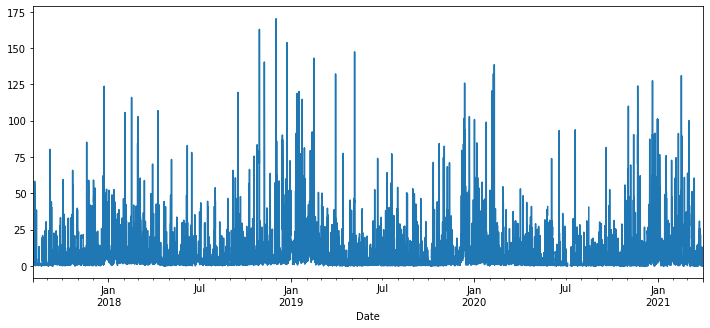

In [ ]:
df1_w[aa].resample('H').mean().plot(figsize = (12,5))

In [ ]:
# df1_w[ aa][df1_w[ a]>10] = np.nan
# df1_w.dropna(inplace = True)

In [ ]:
# df1_w[ 'H2S (ppb)'][df1_w[ 'H2S (ppb)']>3].plot.hist()

In [ ]:
df1_w.columns

Index(['NOX (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
avg = df1_w['score'].mean()
std = df1_w['score'].std()
len(df1_w[df1_w['score']<avg + 7*std])/len(df1_w)

0.9969263970179512

In [ ]:
def objectivee(trial):    
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.00001, random_state = 42)
        param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]), #",,""gblinear" , "dart"
        "lambda": trial.suggest_loguniform("lambda", 0.01, 1000.0),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 1000.0),
        "score" : trial.suggest_float( 'score', avg + 1.5*std, avg + 7 * std )
        }

        # if param["booster"] == "gbtree" :
        #     param["n_estimators"] =  trial.suggest_int("n_estimators" , 1, 10000)

        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 10)
            param["eta"] = trial.suggest_loguniform("eta", 0.1, 1000.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 0.1, 1000.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-3, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-3, 1.0)

        df_xg =  df1_w[df1_w['score'] < param["score"]].copy()
        df_xg.drop(columns = ['score'], inplace = True)
        Y =  df_xg[aa]
        Y = np.array(Y).reshape(-1,1)
        X = np.array( df_xg[ df_xg.columns[1:]])
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.000000001000, random_state = 42)

        K = 5
        kf = KFold(n_splits=K)
        acc = 0 
        for train_index, test_index in kf.split(X):   
                X_tr, X_tes = X[train_index], X[test_index]
                y_tr, y_tes =  Y[train_index],  Y[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
    
                dtrain = xgb.DMatrix(X_tra, label=y_tra)
                dval = xgb.DMatrix(X_val, label=y_val)
                dtest = xgb.DMatrix(X_tes, label=y_tes)
                
                pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
                bst = xgb.train(param, dtrain, evals=[(dval, "validation")],  early_stopping_rounds=30,
                                callbacks=[pruning_callback],
                               # verbose_eval = False
                               )
                preds = bst.predict(dtest)
                accuracy = mean_squared_error(y_tes, preds)
                acc = acc + accuracy/K
                
        print(acc)
        return acc    

In [ ]:
study2 = optuna.create_study()
study2.optimize(objectivee, n_trials=5000)
print(study2.best_trial)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/XGB_Buffalo Viewpoint_OT_NOX_HP_hourly.csv')

[I 2021-05-16 16:48:21,162] A new study created in memory with name: no-name-f123b2f8-4f7a-4e30-9f2e-577db51aec95


[0]	validation-rmse:15.9775
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:17.6047
[2]	validation-rmse:19.2762
[3]	validation-rmse:20.0991
[4]	validation-rmse:21.6935
[5]	validation-rmse:23.0282
[6]	validation-rmse:24.9931
[7]	validation-rmse:26.7922
[8]	validation-rmse:29.3614
[9]	validation-rmse:31.7175
[0]	validation-rmse:15.3233
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:16.8693
[2]	validation-rmse:18.4147
[3]	validation-rmse:20.4129
[4]	validation-rmse:21.4018
[5]	validation-rmse:23.8176
[6]	validation-rmse:24.9393
[7]	validation-rmse:27.8895
[8]	validation-rmse:29.6978
[9]	validation-rmse:32.657
[0]	validation-rmse:15.5565
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:17.7167
[2]	validation-rmse:17.7379
[3]	validation-rmse:20.79
[4]	validation-rmse:20.8567
[5]	validation-rmse:24.7665
[6]	validation-rmse:24.5874
[7]	validation-rmse:28.8214
[8]	validation-rmse:28.8128
[9

[I 2021-05-16 16:48:22,609] Trial 0 finished with value: 1120.7068430750178 and parameters: {'booster': 'gbtree', 'lambda': 0.0573156431692354, 'alpha': 0.07497798402603596, 'score': 35.82980147851701, 'max_depth': 7, 'eta': 2.1162904345167006, 'gamma': 180.59037606683293, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 1120.7068430750178.


1120.7068430750178
[0]	validation-rmse:11.008
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.0416
[2]	validation-rmse:9.69231
[3]	validation-rmse:9.46757
[4]	validation-rmse:9.31711
[5]	validation-rmse:9.29746
[6]	validation-rmse:9.13794
[7]	validation-rmse:9.08488
[8]	validation-rmse:9.01232
[9]	validation-rmse:8.90483
[0]	validation-rmse:10.4474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.65463
[2]	validation-rmse:9.14246
[3]	validation-rmse:9.01723
[4]	validation-rmse:8.83477
[5]	validation-rmse:8.72995
[6]	validation-rmse:8.57966
[7]	validation-rmse:8.52886
[8]	validation-rmse:8.49536
[9]	validation-rmse:8.47853
[0]	validation-rmse:10.9681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.0679
[2]	validation-rmse:9.67312
[3]	validation-rmse:9.48359
[4]	validation-rmse:9.24725
[5]	validation-rmse:9.17177
[6]	validation-rmse:9.11886
[7]	validation-rmse:9.03184
[8]	valid

[I 2021-05-16 16:48:24,664] Trial 1 finished with value: 131.4675397119093 and parameters: {'booster': 'gbtree', 'lambda': 343.27204564741555, 'alpha': 10.061520676046534, 'score': 36.96843180822846, 'max_depth': 9, 'eta': 1.6021567280531246, 'gamma': 0.21334387760532167, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 131.4675397119093.


131.4675397119093
[0]	validation-rmse:2146.87
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:547750
[2]	validation-rmse:1.42074e+08
[3]	validation-rmse:3.6898e+10
[4]	validation-rmse:9.4947e+12
[5]	validation-rmse:2.46668e+15
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:2205.8
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:571131
[2]	validation-rmse:1.48609e+08
[3]	validation-rmse:3.89991e+10
[4]	validation-rmse:1.02413e+13
[5]	validation-rmse:2.691e+15
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:2174.7
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:551935
[2]	validation-rmse:1.41353e+08
[3]	validation-rmse:3.6524e+10
[4]	validation-rmse:9.44386e+12
[5]	validation-rmse:2.44347e+15
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validat

[I 2021-05-16 16:48:25,252] Trial 2 finished with value: 1.2263380274838391e+50 and parameters: {'booster': 'gbtree', 'lambda': 193.6329285414368, 'alpha': 0.01439798117416343, 'score': 31.4537999922014, 'max_depth': 3, 'eta': 279.09339515280027, 'gamma': 1.0489271136258311, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 131.4675397119093.


1.2263380274838391e+50
[0]	validation-rmse:55.251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:279.568
[2]	validation-rmse:1482.39
[3]	validation-rmse:7819.34
[4]	validation-rmse:41498.6
[5]	validation-rmse:226307
[6]	validation-rmse:1.23559e+06
[7]	validation-rmse:6.77411e+06
[8]	validation-rmse:3.67643e+07
[9]	validation-rmse:2.01807e+08
[0]	validation-rmse:55.0945
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:277.935
[2]	validation-rmse:1492.72
[3]	validation-rmse:7959.85
[4]	validation-rmse:42947.3
[5]	validation-rmse:233938
[6]	validation-rmse:1.27601e+06
[7]	validation-rmse:6.84839e+06
[8]	validation-rmse:3.75376e+07
[9]	validation-rmse:2.06386e+08
[0]	validation-rmse:54.5095
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:274.171
[2]	validation-rmse:1462.3
[3]	validation-rmse:7894.77
[4]	validation-rmse:42865.8
[5]	validation-rmse:233257
[6]	validation-rmse:1.25803e+06
[

[I 2021-05-16 16:48:26,660] Trial 3 finished with value: 3.700976404912849e+16 and parameters: {'booster': 'gbtree', 'lambda': 5.039313483786628, 'alpha': 1.6762962702833089, 'score': 33.51399206173974, 'max_depth': 7, 'eta': 6.616628420265489, 'gamma': 0.6558423925812377, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 131.4675397119093.


3.700976404912849e+16
[0]	validation-rmse:3428.74
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.45548e+06
[2]	validation-rmse:6.18372e+08
[3]	validation-rmse:2.62955e+11
[4]	validation-rmse:1.11918e+14
[5]	validation-rmse:4.76764e+16
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:3569.95
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.53527e+06
[2]	validation-rmse:6.58734e+08
[3]	validation-rmse:2.83331e+11
[4]	validation-rmse:1.21888e+14
[5]	validation-rmse:5.24466e+16
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:3516.88
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.5171e+06
[2]	validation-rmse:6.55028e+08
[3]	validation-rmse:2.83046e+11
[4]	validation-rmse:1.22392e+14
[5]	validation-rmse:5.29541e+16
[6]	validation-rmse:inf
[7]	valida

[I 2021-05-16 16:48:27,170] Trial 4 finished with value: 2.6364211029444848e+54 and parameters: {'booster': 'gbtree', 'lambda': 177.01157783406083, 'alpha': 0.07854332629301365, 'score': 33.255733756583396, 'max_depth': 2, 'eta': 451.2616336950436, 'gamma': 0.23176818201825805, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 131.4675397119093.


2.6364211029444848e+54
[0]	validation-rmse:11.562
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.8513
[2]	validation-rmse:10.2574
[3]	validation-rmse:9.98229
[4]	validation-rmse:9.71443
[5]	validation-rmse:9.59968
[6]	validation-rmse:9.54909
[7]	validation-rmse:9.37163
[8]	validation-rmse:9.37582
[9]	validation-rmse:9.43265
[0]	validation-rmse:11.6944
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.9853
[2]	validation-rmse:10.6673
[3]	validation-rmse:10.2063
[4]	validation-rmse:10.0168
[5]	validation-rmse:9.89184
[6]	validation-rmse:9.8255
[7]	validation-rmse:9.76069
[8]	validation-rmse:9.61303
[9]	validation-rmse:9.5399
[0]	validation-rmse:11.4369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:11.1099
[2]	validation-rmse:10.4241
[3]	validation-rmse:10.2648
[4]	validation-rmse:10.0996
[5]	validation-rmse:9.86571
[6]	validation-rmse:9.88423
[7]	validation-rmse:9.75218
[8]	val

[I 2021-05-16 16:48:27,982] Trial 5 finished with value: 281.4243864756343 and parameters: {'booster': 'gbtree', 'lambda': 0.1141323969198738, 'alpha': 1.3493445454909898, 'score': 14.956326121655502, 'max_depth': 4, 'eta': 1.8513208780020265, 'gamma': 31.31330893252539, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 131.4675397119093.


281.4243864756343


[I 2021-05-16 16:48:28,051] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:28,125] Trial 7 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:28,193] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:28,237] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:12.3512
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:11.7297
[2]	validation-rmse:11.2616
[3]	validation-rmse:10.8989
[4]	validation-rmse:10.5842
[5]	validation-rmse:10.3399
[6]	validation-rmse:10.1526
[7]	validation-rmse:9.9828
[8]	validation-rmse:9.85528
[9]	validation-rmse:9.73643
[0]	validation-rmse:12.1387
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:11.4765
[2]	validation-rmse:10.9852
[3]	validation-rmse:10.5882
[4]	validation-rmse:10.2906
[5]	validation-rmse:10.0588
[6]	validation-rmse:9.85964
[7]	validation-rmse:9.68708
[8]	validation-rmse:9.55068
[9]	validation-rmse:9.43363
[0]	validation-rmse:12.3473
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:11.7139
[2]	validation-rmse:11.2437
[3]	validation-rmse:10.89
[4]	validation-rmse:10.577
[5]	validation-rmse:10.3429
[6]	validation-rmse:10.1389
[7]	validation-rmse:9.96986
[8]	validation-rmse:9.8395
[9]	

[I 2021-05-16 16:48:29,480] Trial 10 finished with value: 120.20389494758835 and parameters: {'booster': 'gbtree', 'lambda': 792.0845906065678, 'alpha': 59.518520214393845, 'score': 39.87091219294167, 'max_depth': 6, 'eta': 0.204219618292738, 'gamma': 0.1076916707019339, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 120.20389494758835.


120.20389494758835
[0]	validation-rmse:13.1755
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:12.7977
[2]	validation-rmse:12.467
[3]	validation-rmse:12.1739
[4]	validation-rmse:11.9183
[5]	validation-rmse:11.6927
[6]	validation-rmse:11.4922
[7]	validation-rmse:11.3012
[8]	validation-rmse:11.1466
[9]	validation-rmse:10.9907
[0]	validation-rmse:12.9982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:12.5955
[2]	validation-rmse:12.2442
[3]	validation-rmse:11.9402
[4]	validation-rmse:11.6711
[5]	validation-rmse:11.436
[6]	validation-rmse:11.2196
[7]	validation-rmse:11.0389
[8]	validation-rmse:10.8677
[9]	validation-rmse:10.7255
[0]	validation-rmse:13.3906
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:13.0002
[2]	validation-rmse:12.6694
[3]	validation-rmse:12.3799
[4]	validation-rmse:12.1219
[5]	validation-rmse:11.9036
[6]	validation-rmse:11.7084
[7]	validation-rmse:11.5287
[8]	valida

[I 2021-05-16 16:48:30,694] Trial 11 finished with value: 137.15287840094715 and parameters: {'booster': 'gbtree', 'lambda': 776.5150594245438, 'alpha': 55.81494051124754, 'score': 39.93133158832104, 'max_depth': 6, 'eta': 0.10509649309291644, 'gamma': 0.10687587283180769, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 120.20389494758835.


137.15287840094715
[0]	validation-rmse:12.6864
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:12.2788
[2]	validation-rmse:11.9297
[3]	validation-rmse:11.6239
[4]	validation-rmse:11.3607
[5]	validation-rmse:11.1209
[6]	validation-rmse:10.9214
[7]	validation-rmse:10.7341
[8]	validation-rmse:10.5791
[9]	validation-rmse:10.4469
[0]	validation-rmse:12.4979
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:12.0601
[2]	validation-rmse:11.6906
[3]	validation-rmse:11.3662
[4]	validation-rmse:11.0979
[5]	validation-rmse:10.8495
[6]	validation-rmse:10.6376
[7]	validation-rmse:10.4544
[8]	validation-rmse:10.2983
[9]	validation-rmse:10.1496
[0]	validation-rmse:12.6885
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:12.2683
[2]	validation-rmse:11.9171
[3]	validation-rmse:11.608
[4]	validation-rmse:11.3444
[5]	validation-rmse:11.124
[6]	validation-rmse:10.9168
[7]	validation-rmse:10.7265
[8]	valida

[I 2021-05-16 16:48:32,351] Trial 12 finished with value: 135.8739547423884 and parameters: {'booster': 'gbtree', 'lambda': 731.523038101633, 'alpha': 26.7926875319659, 'score': 39.786602111755336, 'max_depth': 8, 'eta': 0.11424031752800684, 'gamma': 2.7203941053457026, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 120.20389494758835.


135.8739547423884
[0]	validation-rmse:12.1274
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:11.3212
[2]	validation-rmse:10.782
[3]	validation-rmse:10.4781
[4]	validation-rmse:10.2233
[5]	validation-rmse:10.0433
[6]	validation-rmse:9.90003
[7]	validation-rmse:9.78843
[8]	validation-rmse:9.67929
[9]	validation-rmse:9.61435
[0]	validation-rmse:11.9375
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:11.0674
[2]	validation-rmse:10.5405
[3]	validation-rmse:10.214
[4]	validation-rmse:9.95366
[5]	validation-rmse:9.78837
[6]	validation-rmse:9.64746
[7]	validation-rmse:9.52843
[8]	validation-rmse:9.44457
[9]	validation-rmse:9.36914
[0]	validation-rmse:11.9409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:11.1343
[2]	validation-rmse:10.6725
[3]	validation-rmse:10.332
[4]	validation-rmse:10.0966
[5]	validation-rmse:9.93055
[6]	validation-rmse:9.81445
[7]	validation-rmse:9.71689
[8]	validati

[I 2021-05-16 16:48:33,375] Trial 13 finished with value: 93.38164833782264 and parameters: {'booster': 'gbtree', 'lambda': 809.2298420505397, 'alpha': 10.928188509585373, 'score': 23.730832668313397, 'max_depth': 5, 'eta': 0.457062298138697, 'gamma': 0.11940309307313547, 'grow_policy': 'lossguide'}. Best is trial 13 with value: 93.38164833782264.


93.38164833782264
[0]	validation-rmse:11.3589
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.4452
[2]	validation-rmse:9.87349
[3]	validation-rmse:9.54197
[4]	validation-rmse:9.32716
[5]	validation-rmse:9.16742
[6]	validation-rmse:8.98703
[7]	validation-rmse:8.91514
[8]	validation-rmse:8.81351
[9]	validation-rmse:8.7558
[0]	validation-rmse:11.3153
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.3747
[2]	validation-rmse:9.80163
[3]	validation-rmse:9.48837
[4]	validation-rmse:9.27231
[5]	validation-rmse:9.03993
[6]	validation-rmse:8.9231
[7]	validation-rmse:8.86708
[8]	validation-rmse:8.80137
[9]	validation-rmse:8.73542
[0]	validation-rmse:11.3752
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.4682
[2]	validation-rmse:9.91817
[3]	validation-rmse:9.57958
[4]	validation-rmse:9.35626
[5]	validation-rmse:9.15327
[6]	validation-rmse:9.04016
[7]	validation-rmse:8.96181
[8]	validat

[I 2021-05-16 16:48:34,396] Trial 14 finished with value: 83.70801651697468 and parameters: {'booster': 'gbtree', 'lambda': 34.124234200018066, 'alpha': 578.6150350312979, 'score': 22.574724085616953, 'max_depth': 5, 'eta': 0.3481096977655968, 'gamma': 0.1012134901048463, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 83.70801651697468.


83.70801651697468
[0]	validation-rmse:11.0589
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.1497
[2]	validation-rmse:9.76138
[3]	validation-rmse:9.51068
[4]	validation-rmse:9.35747
[5]	validation-rmse:9.27735
[6]	validation-rmse:9.16608
[7]	validation-rmse:9.09442
[8]	validation-rmse:9.05293
[9]	validation-rmse:9.0193
[0]	validation-rmse:10.9261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.0075
[2]	validation-rmse:9.55725
[3]	validation-rmse:9.27364
[4]	validation-rmse:9.13628
[5]	validation-rmse:8.98897
[6]	validation-rmse:8.9227
[7]	validation-rmse:8.85215
[8]	validation-rmse:8.8417
[9]	validation-rmse:8.81009
[0]	validation-rmse:10.9481
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.0982
[2]	validation-rmse:9.6657
[3]	validation-rmse:9.42649
[4]	validation-rmse:9.30637
[5]	validation-rmse:9.22129
[6]	validation-rmse:9.12172
[7]	validation-rmse:9.05952
[8]	validatio

[I 2021-05-16 16:48:35,403] Trial 15 finished with value: 85.21842735279799 and parameters: {'booster': 'gbtree', 'lambda': 27.645667118280638, 'alpha': 889.5041267903587, 'score': 22.21675914063396, 'max_depth': 5, 'eta': 0.4379339508392382, 'gamma': 3.0687123425313154, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 83.70801651697468.


85.21842735279799
[0]	validation-rmse:10.7716
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.127
[2]	validation-rmse:9.81925
[3]	validation-rmse:9.62791
[4]	validation-rmse:9.50372
[5]	validation-rmse:9.43568
[6]	validation-rmse:9.39518
[7]	validation-rmse:9.34203
[8]	validation-rmse:9.30444
[9]	validation-rmse:9.26706
[0]	validation-rmse:10.7106
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.0135
[2]	validation-rmse:9.68744
[3]	validation-rmse:9.51258
[4]	validation-rmse:9.37262
[5]	validation-rmse:9.3128
[6]	validation-rmse:9.24821
[7]	validation-rmse:9.20593
[8]	validation-rmse:9.15212
[9]	validation-rmse:9.10191
[0]	validation-rmse:11.033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.3573
[2]	validation-rmse:10.0474
[3]	validation-rmse:9.84872
[4]	validation-rmse:9.70307
[5]	validation-rmse:9.62005
[6]	validation-rmse:9.56352
[7]	validation-rmse:9.49751
[8]	validati

[I 2021-05-16 16:48:35,870] Trial 16 finished with value: 86.20640745184886 and parameters: {'booster': 'gbtree', 'lambda': 34.00668614410177, 'alpha': 946.5812369769046, 'score': 18.293277035887908, 'max_depth': 1, 'eta': 0.39329295344021564, 'gamma': 3.62091994433439, 'grow_policy': 'lossguide'}. Best is trial 14 with value: 83.70801651697468.


86.20640745184886
[0]	validation-rmse:10.0303
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.24581
[2]	validation-rmse:9.04415
[3]	validation-rmse:8.90807
[4]	validation-rmse:8.83908
[5]	validation-rmse:8.72145
[6]	validation-rmse:8.6972
[7]	validation-rmse:8.68158
[8]	validation-rmse:8.66167
[9]	validation-rmse:8.61917
[0]	validation-rmse:9.87876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.19236
[2]	validation-rmse:8.98479
[3]	validation-rmse:8.8853
[4]	validation-rmse:8.73423
[5]	validation-rmse:8.68162
[6]	validation-rmse:8.64142
[7]	validation-rmse:8.57457
[8]	validation-rmse:8.54922
[9]	validation-rmse:8.5333
[0]	validation-rmse:9.96344
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.31085
[2]	validation-rmse:9.06289
[3]	validation-rmse:8.91774
[4]	validation-rmse:8.83811
[5]	validation-rmse:8.68519
[6]	validation-rmse:8.66262
[7]	validation-rmse:8.62548
[8]	validati

[I 2021-05-16 16:48:36,862] Trial 17 finished with value: 79.84929555495947 and parameters: {'booster': 'gbtree', 'lambda': 1.4804552503019253, 'alpha': 924.0630881662387, 'score': 18.996441652741183, 'max_depth': 5, 'eta': 0.6414500303884658, 'gamma': 666.926533196693, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 79.84929555495947.


79.84929555495947


[I 2021-05-16 16:48:36,919] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:36,970] Trial 19 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:10.1323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.44295
[2]	validation-rmse:9.26793
[3]	validation-rmse:9.18408
[4]	validation-rmse:8.94737
[5]	validation-rmse:8.85487
[6]	validation-rmse:8.78486
[7]	validation-rmse:8.73147
[8]	validation-rmse:8.68386
[9]	validation-rmse:8.66732
[0]	validation-rmse:9.82598
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.19902
[2]	validation-rmse:8.96397
[3]	validation-rmse:8.71556
[4]	validation-rmse:8.63316
[5]	validation-rmse:8.57956
[6]	validation-rmse:8.50458
[7]	validation-rmse:8.48233
[8]	validation-rmse:8.45643
[9]	validation-rmse:8.43188
[0]	validation-rmse:9.85479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.27407
[2]	validation-rmse:9.08192
[3]	validation-rmse:8.95221
[4]	validation-rmse:8.88241
[5]	validation-rmse:8.70501
[6]	validation-rmse:8.63282
[7]	validation-rmse:8.6137
[8]	validation-rmse:8.57575


[I 2021-05-16 16:48:38,324] Trial 20 finished with value: 94.54550846033851 and parameters: {'booster': 'gbtree', 'lambda': 0.8486565447415496, 'alpha': 988.4719199946691, 'score': 26.474212392186068, 'max_depth': 7, 'eta': 0.721067113646542, 'gamma': 403.9097757413824, 'grow_policy': 'depthwise'}. Best is trial 17 with value: 79.84929555495947.


94.54550846033851
[0]	validation-rmse:11.8423
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:11.049
[2]	validation-rmse:10.51
[3]	validation-rmse:10.1319
[4]	validation-rmse:9.84702
[5]	validation-rmse:9.64613
[6]	validation-rmse:9.45585
[7]	validation-rmse:9.31374
[8]	validation-rmse:9.23962
[9]	validation-rmse:9.14774
[0]	validation-rmse:11.7775
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.9437
[2]	validation-rmse:10.3585
[3]	validation-rmse:9.99044
[4]	validation-rmse:9.69748
[5]	validation-rmse:9.48478
[6]	validation-rmse:9.33014
[7]	validation-rmse:9.22052
[8]	validation-rmse:9.12867
[9]	validation-rmse:9.01339
[0]	validation-rmse:11.5321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.7392
[2]	validation-rmse:10.1946
[3]	validation-rmse:9.8006
[4]	validation-rmse:9.49958
[5]	validation-rmse:9.29685
[6]	validation-rmse:9.13669
[7]	validation-rmse:9.03984
[8]	validatio

[I 2021-05-16 16:48:39,315] Trial 21 finished with value: 86.35777325570757 and parameters: {'booster': 'gbtree', 'lambda': 26.78731317881337, 'alpha': 893.326376429097, 'score': 20.655185484344617, 'max_depth': 5, 'eta': 0.24345410880318094, 'gamma': 102.89700014342812, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 79.84929555495947.


86.35777325570757
[0]	validation-rmse:9.7155
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.35324
[2]	validation-rmse:9.01678
[3]	validation-rmse:8.9496
[4]	validation-rmse:8.86795
[5]	validation-rmse:8.81264
[6]	validation-rmse:8.76554
[7]	validation-rmse:8.64663
[8]	validation-rmse:8.59606
[9]	validation-rmse:8.53572
[0]	validation-rmse:9.28267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.00558
[2]	validation-rmse:8.92475
[3]	validation-rmse:8.66564
[4]	validation-rmse:8.59696
[5]	validation-rmse:8.52672
[6]	validation-rmse:8.42899
[7]	validation-rmse:8.40077
[8]	validation-rmse:8.37922
[9]	validation-rmse:8.36153
[0]	validation-rmse:9.59811
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.3508
[2]	validation-rmse:9.24246
[3]	validation-rmse:9.01523
[4]	validation-rmse:8.92627
[5]	validation-rmse:8.77727
[6]	validation-rmse:8.69875
[7]	validation-rmse:8.65043
[8]	validati

[I 2021-05-16 16:48:40,353] Trial 22 finished with value: 91.17249087236576 and parameters: {'booster': 'gbtree', 'lambda': 15.718667827633839, 'alpha': 356.15350851106797, 'score': 22.437694084139057, 'max_depth': 5, 'eta': 0.9575869784229791, 'gamma': 2.782903766503255, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 79.84929555495947.
[I 2021-05-16 16:48:40,411] Trial 23 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:11.8304
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:40,474] Trial 24 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:48:40,528] Trial 25 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:10.2194
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.87153
[2]	validation-rmse:9.59229
[3]	validation-rmse:9.448
[4]	validation-rmse:9.33377
[5]	validation-rmse:9.2503
[6]	validation-rmse:9.16648
[7]	validation-rmse:9.14617
[8]	validation-rmse:9.13515
[9]	validation-rmse:9.1309
[0]	validation-rmse:9.66697
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.34848
[2]	validation-rmse:9.26621
[3]	validation-rmse:8.94886
[4]	validation-rmse:8.85871
[5]	validation-rmse:8.8185
[6]	validation-rmse:8.79695
[7]	validation-rmse:8.77943
[8]	validation-rmse:8.73582
[9]	validation-rmse:8.70527
[0]	validation-rmse:9.70476
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.43708
[2]	validation-rmse:9.28495
[3]	validation-rmse:8.96945
[4]	validation-rmse:8.89537
[5]	validation-rmse:8.85853
[6]	validation-rmse:8.82617
[7]	validation-rmse:8.80431
[8]	validation-rmse:8.73264
[9]	

[I 2021-05-16 16:48:41,606] Trial 26 finished with value: 98.28012132530279 and parameters: {'booster': 'gbtree', 'lambda': 2.030465234530284, 'alpha': 856.7126013237963, 'score': 25.726389499727585, 'max_depth': 5, 'eta': 0.9950172956622182, 'gamma': 1.695712316767924, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 79.84929555495947.


98.28012132530279
[0]	validation-rmse:10.1842
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.22077
[2]	validation-rmse:8.87637
[3]	validation-rmse:8.65749
[4]	validation-rmse:8.55786
[5]	validation-rmse:8.4317
[6]	validation-rmse:8.35602
[7]	validation-rmse:8.32126
[8]	validation-rmse:8.27829
[9]	validation-rmse:8.27176
[0]	validation-rmse:9.99524
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.11379
[2]	validation-rmse:8.71315
[3]	validation-rmse:8.47175
[4]	validation-rmse:8.24493
[5]	validation-rmse:8.16308
[6]	validation-rmse:8.12038
[7]	validation-rmse:8.08478
[8]	validation-rmse:7.95584
[9]	validation-rmse:7.92174
[0]	validation-rmse:10.2522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.39042
[2]	validation-rmse:8.96594
[3]	validation-rmse:8.73274
[4]	validation-rmse:8.70291
[5]	validation-rmse:8.61969
[6]	validation-rmse:8.58691
[7]	validation-rmse:8.51562
[8]	valida

[I 2021-05-16 16:48:42,855] Trial 27 finished with value: 86.71696330446784 and parameters: {'booster': 'gbtree', 'lambda': 10.887644089822203, 'alpha': 120.3752381327919, 'score': 20.4906897541163, 'max_depth': 6, 'eta': 0.5778462274794629, 'gamma': 8.20540732114308, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 79.84929555495947.


86.71696330446784
[0]	validation-rmse:11.0215
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.3956
[2]	validation-rmse:9.94067
[3]	validation-rmse:9.62303
[4]	validation-rmse:9.38227
[5]	validation-rmse:9.21646
[6]	validation-rmse:9.08421
[7]	validation-rmse:8.98568
[8]	validation-rmse:8.90311
[9]	validation-rmse:8.82756
[0]	validation-rmse:11.2241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.5453
[2]	validation-rmse:10.075
[3]	validation-rmse:9.74735
[4]	validation-rmse:9.49832
[5]	validation-rmse:9.3068
[6]	validation-rmse:9.16127
[7]	validation-rmse:9.02703
[8]	validation-rmse:8.94999
[9]	validation-rmse:8.86579
[0]	validation-rmse:11.5993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.9637
[2]	validation-rmse:10.5073
[3]	validation-rmse:10.1498
[4]	validation-rmse:9.90391
[5]	validation-rmse:9.72514
[6]	validation-rmse:9.59939
[7]	validation-rmse:9.47955
[8]	validat

[I 2021-05-16 16:48:43,417] Trial 28 finished with value: 81.82067170296577 and parameters: {'booster': 'gbtree', 'lambda': 76.98112706032096, 'alpha': 25.108154084771733, 'score': 17.52304222642467, 'max_depth': 2, 'eta': 0.2090214653244647, 'gamma': 388.75052530098, 'grow_policy': 'lossguide'}. Best is trial 17 with value: 79.84929555495947.


81.82067170296577


[I 2021-05-16 16:48:43,461] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:11.2635
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:48:43,519] Trial 30 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:10.8029
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.0044
[2]	validation-rmse:9.62603
[3]	validation-rmse:9.29571
[4]	validation-rmse:9.15033
[5]	validation-rmse:9.03173
[6]	validation-rmse:8.93042
[7]	validation-rmse:8.8478
[8]	validation-rmse:8.77937
[9]	validation-rmse:8.7261
[0]	validation-rmse:10.9123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.0798
[2]	validation-rmse:9.62723
[3]	validation-rmse:9.36885
[4]	validation-rmse:9.19181
[5]	validation-rmse:9.00772
[6]	validation-rmse:8.91377
[7]	validation-rmse:8.8235
[8]	validation-rmse:8.77182
[9]	validation-rmse:8.73289
[0]	validation-rmse:11.1563
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:10.3855
[2]	validation-rmse:9.94045
[3]	validation-rmse:9.65469
[4]	validation-rmse:9.51306
[5]	validation-rmse:9.36989
[6]	validation-rmse:9.28928
[7]	validation-rmse:9.1937
[8]	validation-rmse:9.14087
[9]

[I 2021-05-16 16:48:44,088] Trial 31 finished with value: 78.76351046542374 and parameters: {'booster': 'gbtree', 'lambda': 44.20258686583047, 'alpha': 575.3533895546199, 'score': 18.72729048460441, 'max_depth': 2, 'eta': 0.3553083659270281, 'gamma': 162.1110181589365, 'grow_policy': 'lossguide'}. Best is trial 31 with value: 78.76351046542374.


78.76351046542374
[0]	validation-rmse:9.4658
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.12624
[2]	validation-rmse:9.045
[3]	validation-rmse:8.89384
[4]	validation-rmse:8.77486
[5]	validation-rmse:8.7754
[6]	validation-rmse:8.70179
[7]	validation-rmse:8.68955
[8]	validation-rmse:8.61876
[9]	validation-rmse:8.58928
[0]	validation-rmse:9.68917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.44175
[2]	validation-rmse:9.2116
[3]	validation-rmse:9.12555
[4]	validation-rmse:9.0489
[5]	validation-rmse:8.95462
[6]	validation-rmse:8.9148
[7]	validation-rmse:8.84988
[8]	validation-rmse:8.81728
[9]	validation-rmse:8.81785
[0]	validation-rmse:10.1462
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.63332
[2]	validation-rmse:9.44905
[3]	validation-rmse:9.36897
[4]	validation-rmse:9.29313
[5]	validation-rmse:9.24773
[6]	validation-rmse:9.22101
[7]	validation-rmse:9.20468
[8]	validation-r

[I 2021-05-16 16:48:44,674] Trial 32 finished with value: 80.41559824903402 and parameters: {'booster': 'gbtree', 'lambda': 114.74664833384412, 'alpha': 453.9973623038486, 'score': 19.166253352720258, 'max_depth': 2, 'eta': 0.9356541494557383, 'gamma': 243.40788113709885, 'grow_policy': 'lossguide'}. Best is trial 31 with value: 78.76351046542374.


80.41559824903402
[0]	validation-rmse:9.87434
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.55324
[2]	validation-rmse:9.23978
[3]	validation-rmse:9.06453
[4]	validation-rmse:8.94551
[5]	validation-rmse:8.88352
[6]	validation-rmse:8.82649
[7]	validation-rmse:8.75421
[8]	validation-rmse:8.7232
[9]	validation-rmse:8.6688
[0]	validation-rmse:9.58313
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.96133
[2]	validation-rmse:8.65458
[3]	validation-rmse:8.56309
[4]	validation-rmse:8.52981
[5]	validation-rmse:8.53285
[6]	validation-rmse:8.51837
[7]	validation-rmse:8.48667
[8]	validation-rmse:8.47102
[9]	validation-rmse:8.48898
[0]	validation-rmse:9.26634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.74922
[2]	validation-rmse:8.53759
[3]	validation-rmse:8.43539
[4]	validation-rmse:8.32869
[5]	validation-rmse:8.26298
[6]	validation-rmse:8.20486
[7]	validation-rmse:8.16993
[8]	validat

[I 2021-05-16 16:48:45,261] Trial 33 finished with value: 76.26805365399001 and parameters: {'booster': 'gbtree', 'lambda': 286.5582209350772, 'alpha': 37.025187258165744, 'score': 16.034018990901124, 'max_depth': 2, 'eta': 1.3830355839086599, 'gamma': 214.99762705722557, 'grow_policy': 'lossguide'}. Best is trial 33 with value: 76.26805365399001.


76.26805365399001
[0]	validation-rmse:10.2823
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.9428
[2]	validation-rmse:9.71101
[3]	validation-rmse:9.593


[I 2021-05-16 16:48:45,339] Trial 34 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:48:45,386] Trial 35 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.0719
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.69318
[2]	validation-rmse:8.52774
[3]	validation-rmse:8.34756
[4]	validation-rmse:8.32245
[5]	validation-rmse:8.30305
[6]	validation-rmse:8.27418
[7]	validation-rmse:8.22955
[8]	validation-rmse:8.21018
[9]	validation-rmse:8.18456
[0]	validation-rmse:9.06348
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.5303
[2]	validation-rmse:8.35829
[3]	validation-rmse:8.31175
[4]	validation-rmse:8.2333
[5]	validation-rmse:8.17902
[6]	validation-rmse:8.15412
[7]	validation-rmse:8.04127
[8]	validation-rmse:8.00335
[9]	validation-rmse:7.96536
[0]	validation-rmse:8.97376
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.54663
[2]	validation-rmse:8.18744
[3]	validation-rmse:8.15952
[4]	validation-rmse:8.17866
[5]	validation-rmse:8.12353
[6]	validation-rmse:8.07271
[7]	validation-rmse:8.04837
[8]	validation-rmse:7.99927
[9

[I 2021-05-16 16:48:46,092] Trial 36 finished with value: 77.45955438429417 and parameters: {'booster': 'gbtree', 'lambda': 152.77048025572094, 'alpha': 4.362129180202982, 'score': 16.088164475241705, 'max_depth': 3, 'eta': 1.3513335902793926, 'gamma': 997.1682729645893, 'grow_policy': 'depthwise'}. Best is trial 33 with value: 76.26805365399001.


77.45955438429417
[0]	validation-rmse:10.7262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.91367
[2]	validation-rmse:9.26765
[3]	validation-rmse:9.02059
[4]	validation-rmse:8.86734
[5]	validation-rmse:8.80693
[6]	validation-rmse:8.75954
[7]	validation-rmse:8.75959
[8]	validation-rmse:8.70116
[9]	validation-rmse:8.73489
[0]	validation-rmse:10.8118
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.79429
[2]	validation-rmse:9.47452
[3]	validation-rmse:9.07461
[4]	validation-rmse:8.7876
[5]	validation-rmse:8.7028
[6]	validation-rmse:8.65254
[7]	validation-rmse:8.6542
[8]	validation-rmse:8.6058
[9]	validation-rmse:8.56877
[0]	validation-rmse:10.7417
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.73845
[2]	validation-rmse:9.24794
[3]	validation-rmse:9.00607
[4]	validation-rmse:8.89528
[5]	validation-rmse:8.83869
[6]	validation-rmse:8.73935
[7]	validation-rmse:8.68055
[8]	validatio

[I 2021-05-16 16:48:46,783] Trial 37 finished with value: 99.49823926230064 and parameters: {'booster': 'gbtree', 'lambda': 186.08822543595252, 'alpha': 4.908683167924002, 'score': 13.753782278661035, 'max_depth': 3, 'eta': 1.8251336928411943, 'gamma': 678.6362613521093, 'grow_policy': 'depthwise'}. Best is trial 33 with value: 76.26805365399001.


99.49823926230064


[I 2021-05-16 16:48:46,835] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:46,879] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:46,931] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.55554
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.30321
[2]	validation-rmse:9.17571
[3]	validation-rmse:9.08707
[4]	validation-rmse:9.01878
[5]	validation-rmse:8.97203
[6]	validation-rmse:8.96133
[7]	validation-rmse:8.94498
[8]	validation-rmse:8.85883
[9]	validation-rmse:8.80424
[0]	validation-rmse:9.55249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.25643
[2]	validation-rmse:9.13123
[3]	validation-rmse:8.95941
[4]	validation-rmse:8.91444
[5]	validation-rmse:8.82128
[6]	validation-rmse:8.76331
[7]	validation-rmse:8.76107
[8]	validation-rmse:8.70432
[9]	validation-rmse:8.6875
[0]	validation-rmse:9.86811
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.52473
[2]	validation-rmse:9.40032
[3]	validation-rmse:9.30167
[4]	validation-rmse:9.23648
[5]	validation-rmse:9.20423
[6]	validation-rmse:9.1653
[7]	validation-rmse:9.05766
[8]	validation-rmse:9.00147
[

[I 2021-05-16 16:48:47,500] Trial 41 finished with value: 84.84409653361811 and parameters: {'booster': 'gbtree', 'lambda': 143.7757359346479, 'alpha': 12.5005936047273, 'score': 19.329025532948698, 'max_depth': 2, 'eta': 1.1656300778574447, 'gamma': 205.21429334435027, 'grow_policy': 'depthwise'}. Best is trial 33 with value: 76.26805365399001.


84.84409653361811
[0]	validation-rmse:9.78259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.38567
[2]	validation-rmse:9.14758
[3]	validation-rmse:9.0232
[4]	validation-rmse:8.93282
[5]	validation-rmse:8.90288
[6]	validation-rmse:8.84763
[7]	validation-rmse:8.80624
[8]	validation-rmse:8.75165
[9]	validation-rmse:8.74208
[0]	validation-rmse:9.65028
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.20223
[2]	validation-rmse:9.00253
[3]	validation-rmse:8.87664
[4]	validation-rmse:8.80237
[5]	validation-rmse:8.73722
[6]	validation-rmse:8.69044
[7]	validation-rmse:8.67632
[8]	validation-rmse:8.63276
[9]	validation-rmse:8.59587
[0]	validation-rmse:9.98273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.55693
[2]	validation-rmse:9.32614
[3]	validation-rmse:9.17374
[4]	validation-rmse:9.11688
[5]	validation-rmse:9.03205
[6]	validation-rmse:8.98393
[7]	validation-rmse:8.92471
[8]	valida

[I 2021-05-16 16:48:48,069] Trial 42 finished with value: 78.55747828403196 and parameters: {'booster': 'gbtree', 'lambda': 144.99556238807975, 'alpha': 0.02990298889239399, 'score': 18.284456018388752, 'max_depth': 2, 'eta': 0.7231490297361968, 'gamma': 282.879114284341, 'grow_policy': 'depthwise'}. Best is trial 33 with value: 76.26805365399001.


78.55747828403196


[I 2021-05-16 16:48:48,116] Trial 43 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.76405
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.04694
[2]	validation-rmse:8.82384
[3]	validation-rmse:8.67821
[4]	validation-rmse:8.61843
[5]	validation-rmse:8.54479
[6]	validation-rmse:8.46894
[7]	validation-rmse:8.42496
[8]	validation-rmse:8.40034
[9]	validation-rmse:8.36698
[0]	validation-rmse:9.32352
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.72335
[2]	validation-rmse:8.48571
[3]	validation-rmse:8.36821
[4]	validation-rmse:8.29813
[5]	validation-rmse:8.20966
[6]	validation-rmse:8.16888
[7]	validation-rmse:8.14488
[8]	validation-rmse:8.0821
[9]	validation-rmse:8.06
[0]	validation-rmse:9.68336
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.0427
[2]	validation-rmse:8.81113
[3]	validation-rmse:8.66904
[4]	validation-rmse:8.58052
[5]	validation-rmse:8.51705
[6]	validation-rmse:8.42303
[7]	validation-rmse:8.36419
[8]	validation-rmse:8.34122
[9]	

[I 2021-05-16 16:48:48,797] Trial 44 finished with value: 76.75043724699748 and parameters: {'booster': 'gbtree', 'lambda': 237.44355364493933, 'alpha': 0.019818394054623663, 'score': 16.33589775217998, 'max_depth': 3, 'eta': 0.7242665997367206, 'gamma': 37.14593158345936, 'grow_policy': 'depthwise'}. Best is trial 33 with value: 76.26805365399001.


76.75043724699748
[0]	validation-rmse:10.4084
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.8025
[2]	validation-rmse:9.52283


[I 2021-05-16 16:48:48,885] Trial 45 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:48:48,930] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:48,982] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:49,031] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:49,082] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:49,130] Trial 50 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.13938
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44758
[2]	validation-rmse:8.16416
[3]	validation-rmse:8.00349
[4]	validation-rmse:7.92295
[5]	validation-rmse:7.83643
[6]	validation-rmse:7.79522
[7]	validation-rmse:7.75128
[8]	validation-rmse:7.74245
[9]	validation-rmse:7.73987
[0]	validation-rmse:9.06575
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38542
[2]	validation-rmse:8.16405
[3]	validation-rmse:8.04966
[4]	validation-rmse:7.9242
[5]	validation-rmse:7.82907
[6]	validation-rmse:7.80207
[7]	validation-rmse:7.75952
[8]	validation-rmse:7.72682
[9]	validation-rmse:7.70193
[0]	validation-rmse:9.54568
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.84409
[2]	validation-rmse:8.64054
[3]	validation-rmse:8.42168
[4]	validation-rmse:8.28089
[5]	validation-rmse:8.16974
[6]	validation-rmse:8.11544
[7]	validation-rmse:8.08727
[8]	validation-rmse:8.02471


[I 2021-05-16 16:48:49,971] Trial 51 finished with value: 76.26960006298368 and parameters: {'booster': 'gbtree', 'lambda': 43.2662119963092, 'alpha': 0.02229773618354166, 'score': 18.389852802681506, 'max_depth': 4, 'eta': 0.6115146013718391, 'gamma': 955.0769235192683, 'grow_policy': 'depthwise'}. Best is trial 33 with value: 76.26805365399001.


76.26960006298368


[I 2021-05-16 16:48:50,025] Trial 52 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.52876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.67181
[2]	validation-rmse:8.23062
[3]	validation-rmse:8.03207
[4]	validation-rmse:7.91409
[5]	validation-rmse:7.81265
[6]	validation-rmse:7.7561
[7]	validation-rmse:7.6987
[8]	validation-rmse:7.64394
[9]	validation-rmse:7.5957
[0]	validation-rmse:9.51082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.61435
[2]	validation-rmse:8.25469
[3]	validation-rmse:8.07273
[4]	validation-rmse:7.92996
[5]	validation-rmse:7.84948
[6]	validation-rmse:7.7935
[7]	validation-rmse:7.75937
[8]	validation-rmse:7.69767
[9]	validation-rmse:7.67371
[0]	validation-rmse:9.2393
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45276
[2]	validation-rmse:8.09779
[3]	validation-rmse:7.90835
[4]	validation-rmse:7.78909
[5]	validation-rmse:7.70876
[6]	validation-rmse:7.65728
[7]	validation-rmse:7.57279
[8]	validation-rmse:7.54652
[9]	

[I 2021-05-16 16:48:50,696] Trial 53 finished with value: 69.35084197958666 and parameters: {'booster': 'gbtree', 'lambda': 177.46635811295081, 'alpha': 0.05105488975831315, 'score': 14.49748617198454, 'max_depth': 3, 'eta': 0.4723611672604321, 'gamma': 84.1216057146469, 'grow_policy': 'depthwise'}. Best is trial 53 with value: 69.35084197958666.


69.35084197958666
[0]	validation-rmse:10.4102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.58027
[2]	validation-rmse:9.14351
[3]	validation-rmse:8.93661
[4]	validation-rmse:8.80775
[5]	validation-rmse:8.68099
[6]	validation-rmse:8.61516
[7]	validation-rmse:8.49356
[8]	validation-rmse:8.46903
[9]	validation-rmse:8.42552
[0]	validation-rmse:10.3853
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.54778
[2]	validation-rmse:9.10294
[3]	validation-rmse:8.90075
[4]	validation-rmse:8.73041
[5]	validation-rmse:8.61113
[6]	validation-rmse:8.51782
[7]	validation-rmse:8.47926
[8]	validation-rmse:8.42284
[9]	validation-rmse:8.39329
[0]	validation-rmse:10.2307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.50011
[2]	validation-rmse:9.12531
[3]	validation-rmse:8.84472
[4]	validation-rmse:8.71606
[5]	validation-rmse:8.6113
[6]	validation-rmse:8.5225
[7]	validation-rmse:8.4556
[8]	validati

[I 2021-05-16 16:48:51,381] Trial 54 finished with value: 71.17437522240768 and parameters: {'booster': 'gbtree', 'lambda': 518.6945471022647, 'alpha': 0.03500112255246387, 'score': 14.611557871204962, 'max_depth': 3, 'eta': 0.49636184698663177, 'gamma': 84.93724092232942, 'grow_policy': 'depthwise'}. Best is trial 53 with value: 69.35084197958666.


71.17437522240768
[0]	validation-rmse:9.30524
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.82002
[2]	validation-rmse:8.5622
[3]	validation-rmse:8.47561
[4]	validation-rmse:8.38442
[5]	validation-rmse:8.33035
[6]	validation-rmse:8.27734
[7]	validation-rmse:8.2058
[8]	validation-rmse:8.14019
[9]	validation-rmse:8.12449
[0]	validation-rmse:9.13679
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.6646
[2]	validation-rmse:8.48403
[3]	validation-rmse:8.35875
[4]	validation-rmse:8.29899
[5]	validation-rmse:8.21097
[6]	validation-rmse:8.1536
[7]	validation-rmse:8.10027
[8]	validation-rmse:8.06629
[9]	validation-rmse:8.01696
[0]	validation-rmse:9.27842
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.82295
[2]	validation-rmse:8.6176
[3]	validation-rmse:8.50676
[4]	validation-rmse:8.43922
[5]	validation-rmse:8.41166
[6]	validation-rmse:8.4159
[7]	validation-rmse:8.35558
[8]	validation-

[I 2021-05-16 16:48:52,086] Trial 55 finished with value: 87.34443023171136 and parameters: {'booster': 'gbtree', 'lambda': 570.6404761875714, 'alpha': 0.061707536821901623, 'score': 14.265780228285564, 'max_depth': 3, 'eta': 1.343975684965094, 'gamma': 77.5289808329811, 'grow_policy': 'depthwise'}. Best is trial 53 with value: 69.35084197958666.


87.34443023171136
[0]	validation-rmse:10.4515
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.59038
[2]	validation-rmse:9.19297
[3]	validation-rmse:8.95303
[4]	validation-rmse:8.77233
[5]	validation-rmse:8.66562
[6]	validation-rmse:8.58594
[7]	validation-rmse:8.51031
[8]	validation-rmse:8.445
[9]	validation-rmse:8.40752
[0]	validation-rmse:10.1776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.29353
[2]	validation-rmse:8.86732
[3]	validation-rmse:8.64108
[4]	validation-rmse:8.48794
[5]	validation-rmse:8.40665
[6]	validation-rmse:8.33614
[7]	validation-rmse:8.26913
[8]	validation-rmse:8.23178
[9]	validation-rmse:8.20168
[0]	validation-rmse:10.6292
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.74611
[2]	validation-rmse:9.30204
[3]	validation-rmse:9.03034
[4]	validation-rmse:8.89186
[5]	validation-rmse:8.78929
[6]	validation-rmse:8.71176
[7]	validation-rmse:8.65605
[8]	validat

[I 2021-05-16 16:48:52,908] Trial 56 finished with value: 73.34491569518016 and parameters: {'booster': 'gbtree', 'lambda': 304.412478540497, 'alpha': 0.01114988029025552, 'score': 14.699681830788005, 'max_depth': 4, 'eta': 0.492116510150873, 'gamma': 36.502678095058954, 'grow_policy': 'depthwise'}. Best is trial 53 with value: 69.35084197958666.


73.34491569518016
[0]	validation-rmse:10.4846
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.7273
[2]	validation-rmse:9.26835
[3]	validation-rmse:9.02374
[4]	validation-rmse:8.83642
[5]	validation-rmse:8.70555
[6]	validation-rmse:8.63021
[7]	validation-rmse:8.51915
[8]	validation-rmse:8.45299
[9]	validation-rmse:8.39561
[0]	validation-rmse:10.0398
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.26598
[2]	validation-rmse:8.86669
[3]	validation-rmse:8.59989
[4]	validation-rmse:8.44557
[5]	validation-rmse:8.32609
[6]	validation-rmse:8.24703
[7]	validation-rmse:8.14995
[8]	validation-rmse:8.10214
[9]	validation-rmse:8.0672
[0]	validation-rmse:10.1067
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.37122
[2]	validation-rmse:8.98378
[3]	validation-rmse:8.71535
[4]	validation-rmse:8.53493
[5]	validation-rmse:8.44214
[6]	validation-rmse:8.37404
[7]	validation-rmse:8.29362
[8]	validat

[I 2021-05-16 16:48:53,760] Trial 57 finished with value: 76.5159341013764 and parameters: {'booster': 'gbtree', 'lambda': 965.6089744108352, 'alpha': 0.011795249824512568, 'score': 15.025004769556046, 'max_depth': 4, 'eta': 0.5076001910000703, 'gamma': 17.297542512982528, 'grow_policy': 'depthwise'}. Best is trial 53 with value: 69.35084197958666.


76.5159341013764


[I 2021-05-16 16:48:53,817] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:53,871] Trial 59 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:10.3945
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.5315
[2]	validation-rmse:9.00688
[3]	validation-rmse:8.75127
[4]	validation-rmse:8.57721
[5]	validation-rmse:8.45076
[6]	validation-rmse:8.36431
[7]	validation-rmse:8.26489
[8]	validation-rmse:8.20428
[9]	validation-rmse:8.15325
[0]	validation-rmse:10.5394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.62348
[2]	validation-rmse:9.17303
[3]	validation-rmse:8.89015
[4]	validation-rmse:8.73099
[5]	validation-rmse:8.61004
[6]	validation-rmse:8.51729
[7]	validation-rmse:8.45207
[8]	validation-rmse:8.41758
[9]	validation-rmse:8.35661
[0]	validation-rmse:10.5196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.65574
[2]	validation-rmse:9.19397
[3]	validation-rmse:8.91563
[4]	validation-rmse:8.77375
[5]	validation-rmse:8.65328
[6]	validation-rmse:8.5495
[7]	validation-rmse:8.46897
[8]	validation-rmse:8.40951
[

[I 2021-05-16 16:48:54,705] Trial 60 finished with value: 75.72861614910889 and parameters: {'booster': 'gbtree', 'lambda': 352.6116452718534, 'alpha': 0.05530014335982575, 'score': 15.186477550696344, 'max_depth': 4, 'eta': 0.49134194501548506, 'gamma': 15.461907738955878, 'grow_policy': 'depthwise'}. Best is trial 53 with value: 69.35084197958666.


75.72861614910889
[0]	validation-rmse:9.50147
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.65272
[2]	validation-rmse:8.26099
[3]	validation-rmse:8.02476
[4]	validation-rmse:7.8827
[5]	validation-rmse:7.79914
[6]	validation-rmse:7.71929
[7]	validation-rmse:7.68855
[8]	validation-rmse:7.64139
[9]	validation-rmse:7.5849
[0]	validation-rmse:9.58187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.71647
[2]	validation-rmse:8.32331
[3]	validation-rmse:8.10386
[4]	validation-rmse:7.95133
[5]	validation-rmse:7.84379
[6]	validation-rmse:7.78153
[7]	validation-rmse:7.7279
[8]	validation-rmse:7.68906
[9]	validation-rmse:7.65401
[0]	validation-rmse:9.88648
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.99306
[2]	validation-rmse:8.57937
[3]	validation-rmse:8.33494
[4]	validation-rmse:8.18741
[5]	validation-rmse:8.05878
[6]	validation-rmse:7.98162
[7]	validation-rmse:7.93091
[8]	validati

[I 2021-05-16 16:48:55,534] Trial 61 finished with value: 68.99392361436844 and parameters: {'booster': 'gbtree', 'lambda': 320.26771473360594, 'alpha': 0.06814121715711068, 'score': 13.322225883706205, 'max_depth': 4, 'eta': 0.5133583210684715, 'gamma': 6.464583624696155, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


68.99392361436844


[I 2021-05-16 16:48:55,590] Trial 62 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:10.4085
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.53881
[2]	validation-rmse:8.974
[3]	validation-rmse:8.65875
[4]	validation-rmse:8.40966
[5]	validation-rmse:8.23337
[6]	validation-rmse:8.13538
[7]	validation-rmse:8.03523
[8]	validation-rmse:7.9317
[9]	validation-rmse:7.87729
[0]	validation-rmse:10.7062
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.80298
[2]	validation-rmse:9.2644
[3]	validation-rmse:8.93024
[4]	validation-rmse:8.72032
[5]	validation-rmse:8.53588
[6]	validation-rmse:8.41972
[7]	validation-rmse:8.30651
[8]	validation-rmse:8.22564
[9]	validation-rmse:8.17113
[0]	validation-rmse:10.532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.67287
[2]	validation-rmse:9.15011
[3]	validation-rmse:8.79264
[4]	validation-rmse:8.56231
[5]	validation-rmse:8.38388
[6]	validation-rmse:8.2561
[7]	validation-rmse:8.17477
[8]	validation-rmse:8.0975
[9]	va

[I 2021-05-16 16:48:56,620] Trial 63 finished with value: 76.0988615297777 and parameters: {'booster': 'gbtree', 'lambda': 316.5945459990881, 'alpha': 0.12228215196319694, 'score': 15.249728550139412, 'max_depth': 5, 'eta': 0.37386827562996144, 'gamma': 4.361990173444837, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


76.0988615297777


[I 2021-05-16 16:48:56,680] Trial 64 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:56,736] Trial 65 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.12013
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50803
[2]	validation-rmse:8.20812
[3]	validation-rmse:8.06284
[4]	validation-rmse:7.93454
[5]	validation-rmse:7.81857
[6]	validation-rmse:7.72464
[7]	validation-rmse:7.65583
[8]	validation-rmse:7.60743
[9]	validation-rmse:7.56629
[0]	validation-rmse:9.35537
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.70137
[2]	validation-rmse:8.49277
[3]	validation-rmse:8.38387
[4]	validation-rmse:8.21103
[5]	validation-rmse:8.11191
[6]	validation-rmse:8.03557
[7]	validation-rmse:7.98281
[8]	validation-rmse:7.93994
[9]	validation-rmse:7.92841
[0]	validation-rmse:9.58762
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.00299
[2]	validation-rmse:8.75389
[3]	validation-rmse:8.58837
[4]	validation-rmse:8.5443
[5]	validation-rmse:8.43621
[6]	validation-rmse:8.35094
[7]	validation-rmse:8.30967
[8]	validation-rmse:8.22508


[I 2021-05-16 16:48:58,023] Trial 66 finished with value: 84.76405679784821 and parameters: {'booster': 'gbtree', 'lambda': 303.5370942961847, 'alpha': 0.21763867149919056, 'score': 16.945942404017124, 'max_depth': 6, 'eta': 0.8312249284226687, 'gamma': 1.860320110245501, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


84.76405679784821


[I 2021-05-16 16:48:58,082] Trial 67 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:58,141] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:58,191] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:48:58,249] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.76105
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.93444
[2]	validation-rmse:8.58855
[3]	validation-rmse:8.38847
[4]	validation-rmse:8.22863
[5]	validation-rmse:8.15736
[6]	validation-rmse:8.07207
[7]	validation-rmse:8.01265
[8]	validation-rmse:7.96974
[9]	validation-rmse:7.93328
[0]	validation-rmse:9.9181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.04477
[2]	validation-rmse:8.6814
[3]	validation-rmse:8.45817
[4]	validation-rmse:8.32228
[5]	validation-rmse:8.24139
[6]	validation-rmse:8.17072
[7]	validation-rmse:8.12719
[8]	validation-rmse:8.07568
[9]	validation-rmse:8.04106
[0]	validation-rmse:10.0548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.26069
[2]	validation-rmse:8.84006
[3]	validation-rmse:8.64483
[4]	validation-rmse:8.52388
[5]	validation-rmse:8.43622
[6]	validation-rmse:8.35984
[7]	validation-rmse:8.29918
[8]	validation-rmse:8.27234
[

[I 2021-05-16 16:48:59,093] Trial 71 finished with value: 76.75657436029633 and parameters: {'booster': 'gbtree', 'lambda': 345.2802969228188, 'alpha': 0.016175822223604416, 'score': 17.17041476944231, 'max_depth': 4, 'eta': 0.5538400033483597, 'gamma': 5.072137745922176, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


76.75657436029633
[0]	validation-rmse:9.41126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.9929
[2]	validation-rmse:8.79675
[3]	validation-rmse:8.68296
[4]	validation-rmse:8.61843
[5]	validation-rmse:8.52987
[6]	validation-rmse:8.47947
[7]	validation-rmse:8.42779
[8]	validation-rmse:8.4147
[9]	validation-rmse:8.38772
[0]	validation-rmse:9.22682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.9291
[2]	validation-rmse:8.75437
[3]	validation-rmse:8.682
[4]	validation-rmse:8.56573
[5]	validation-rmse:8.42596
[6]	validation-rmse:8.40846
[7]	validation-rmse:8.39264
[8]	validation-rmse:8.33316
[9]	validation-rmse:8.31446
[0]	validation-rmse:9.10427
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.81427
[2]	validation-rmse:8.56667
[3]	validation-rmse:8.45491
[4]	validation-rmse:8.38675
[5]	validation-rmse:8.30902
[6]	validation-rmse:8.25663
[7]	validation-rmse:8.22347
[8]	validation

[I 2021-05-16 16:48:59,821] Trial 72 finished with value: 72.85099045838265 and parameters: {'booster': 'gbtree', 'lambda': 188.75210473318555, 'alpha': 0.026921434365617947, 'score': 15.064575864252394, 'max_depth': 3, 'eta': 1.1067052359327352, 'gamma': 31.417540262956248, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


72.85099045838265
[0]	validation-rmse:8.96908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.69785
[2]	validation-rmse:8.51339
[3]	validation-rmse:8.40641
[4]	validation-rmse:8.40074
[5]	validation-rmse:8.2511
[6]	validation-rmse:8.30106
[7]	validation-rmse:8.2605
[8]	validation-rmse:8.21306
[9]	validation-rmse:8.19989
[0]	validation-rmse:9.18816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.80053
[2]	validation-rmse:8.69975
[3]	validation-rmse:8.64469
[4]	validation-rmse:8.56927
[5]	validation-rmse:8.5333
[6]	validation-rmse:8.44185
[7]	validation-rmse:8.48702
[8]	validation-rmse:8.43694
[9]	validation-rmse:8.41197
[0]	validation-rmse:8.98761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.73643
[2]	validation-rmse:8.60746
[3]	validation-rmse:8.52828
[4]	validation-rmse:8.51559
[5]	validation-rmse:8.48189
[6]	validation-rmse:8.43487
[7]	validation-rmse:8.41566
[8]	validati

[I 2021-05-16 16:49:00,528] Trial 73 finished with value: 106.88797312251859 and parameters: {'booster': 'gbtree', 'lambda': 0.02192738399231898, 'alpha': 0.028313582211649986, 'score': 15.240699408666023, 'max_depth': 3, 'eta': 0.96366428719443, 'gamma': 30.883418930428498, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


106.88797312251859


[I 2021-05-16 16:49:00,587] Trial 74 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:00,637] Trial 75 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.81846
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.04819
[2]	validation-rmse:8.80971
[3]	validation-rmse:8.61337
[4]	validation-rmse:8.46931
[5]	validation-rmse:8.36547
[6]	validation-rmse:8.31632
[7]	validation-rmse:8.23207
[8]	validation-rmse:8.17
[9]	validation-rmse:8.1389
[0]	validation-rmse:9.7385
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.02869
[2]	validation-rmse:8.77228
[3]	validation-rmse:8.54323
[4]	validation-rmse:8.44569
[5]	validation-rmse:8.38853
[6]	validation-rmse:8.26276
[7]	validation-rmse:8.19224
[8]	validation-rmse:8.13907
[9]	validation-rmse:8.09997
[0]	validation-rmse:10.129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.38081
[2]	validation-rmse:8.99907
[3]	validation-rmse:8.83763
[4]	validation-rmse:8.6489
[5]	validation-rmse:8.57542
[6]	validation-rmse:8.45393
[7]	validation-rmse:8.39016
[8]	validation-rmse:8.33544
[9]	va

[I 2021-05-16 16:49:01,880] Trial 76 finished with value: 82.34513142161296 and parameters: {'booster': 'gbtree', 'lambda': 234.7464224954903, 'alpha': 0.014993207962711473, 'score': 16.39528872730506, 'max_depth': 6, 'eta': 0.8084436167624729, 'gamma': 8.35737969370389, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.
[I 2021-05-16 16:49:01,935] Trial 77 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.69031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.94653
[2]	validation-rmse:8.45188
[3]	validation-rmse:8.3262
[4]	validation-rmse:8.23127
[5]	validation-rmse:8.18511
[6]	validation-rmse:8.08625
[7]	validation-rmse:8.04113
[8]	validation-rmse:8.01484
[9]	validation-rmse:7.99786
[0]	validation-rmse:9.53079
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.72702
[2]	validation-rmse:8.31726
[3]	validation-rmse:8.12381
[4]	validation-rmse:8.0923
[5]	validation-rmse:8.01768
[6]	validation-rmse:8.0068
[7]	validation-rmse:7.93689
[8]	validation-rmse:7.88212
[9]	validation-rmse:7.88493
[0]	validation-rmse:10.0094
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.0524
[2]	validation-rmse:8.73447
[3]	validation-rmse:8.524
[4]	validation-rmse:8.4321
[5]	validation-rmse:8.39045
[6]	validation-rmse:8.33499
[7]	validation-rmse:8.26375
[8]	validation-rmse:8.2128
[9]	val

[I 2021-05-16 16:49:02,979] Trial 78 finished with value: 110.25155358961209 and parameters: {'booster': 'gbtree', 'lambda': 801.550437648743, 'alpha': 0.24603780699257394, 'score': 15.708285600672582, 'max_depth': 5, 'eta': 1.650429370400425, 'gamma': 101.33077717907598, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


110.25155358961209
[0]	validation-rmse:10.2058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.32539
[2]	validation-rmse:8.73832
[3]	validation-rmse:8.3995
[4]	validation-rmse:8.12895
[5]	validation-rmse:7.92819
[6]	validation-rmse:7.80404
[7]	validation-rmse:7.73167
[8]	validation-rmse:7.62059
[9]	validation-rmse:7.5035
[0]	validation-rmse:10.5658
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.64472
[2]	validation-rmse:9.11563
[3]	validation-rmse:8.75143
[4]	validation-rmse:8.51592
[5]	validation-rmse:8.28747
[6]	validation-rmse:8.15851
[7]	validation-rmse:8.04219
[8]	validation-rmse:7.96723
[9]	validation-rmse:7.88216
[0]	validation-rmse:10.7414
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.8548
[2]	validation-rmse:9.31631
[3]	validation-rmse:8.97793
[4]	validation-rmse:8.73991
[5]	validation-rmse:8.57762
[6]	validation-rmse:8.43939
[7]	validation-rmse:8.3076
[8]	validati

[I 2021-05-16 16:49:05,378] Trial 79 finished with value: 82.03246131873722 and parameters: {'booster': 'gbtree', 'lambda': 148.0015907140583, 'alpha': 0.02682114214170797, 'score': 16.93865234197679, 'max_depth': 10, 'eta': 0.3456319399442367, 'gamma': 63.339978533324036, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


82.03246131873722
[0]	validation-rmse:8.45603
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.03607
[2]	validation-rmse:7.86626
[3]	validation-rmse:7.72997
[4]	validation-rmse:7.64422
[5]	validation-rmse:7.54996
[6]	validation-rmse:7.52454
[7]	validation-rmse:7.51297
[8]	validation-rmse:7.48647
[9]	validation-rmse:7.4543
[0]	validation-rmse:8.69718
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36504
[2]	validation-rmse:8.19959
[3]	validation-rmse:8.02817
[4]	validation-rmse:7.95985
[5]	validation-rmse:7.91635
[6]	validation-rmse:7.86998
[7]	validation-rmse:7.8263
[8]	validation-rmse:7.80387
[9]	validation-rmse:7.78322
[0]	validation-rmse:8.93919
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.59014
[2]	validation-rmse:8.44984
[3]	validation-rmse:8.27449
[4]	validation-rmse:8.17093
[5]	validation-rmse:8.08261
[6]	validation-rmse:8.01434
[7]	validation-rmse:7.94928
[8]	validat

[I 2021-05-16 16:49:06,311] Trial 80 finished with value: 84.18598191454731 and parameters: {'booster': 'gbtree', 'lambda': 297.9263628160335, 'alpha': 0.09416343664112385, 'score': 13.910406590392098, 'max_depth': 4, 'eta': 1.097212306534634, 'gamma': 2.0433637196497996, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


84.18598191454731
[0]	validation-rmse:9.75641
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.93881
[2]	validation-rmse:8.53098
[3]	validation-rmse:8.39772
[4]	validation-rmse:8.25012
[5]	validation-rmse:8.21579
[6]	validation-rmse:8.1488
[7]	validation-rmse:8.11297
[8]	validation-rmse:8.0961
[9]	validation-rmse:8.0611
[0]	validation-rmse:9.46568
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.74479
[2]	validation-rmse:8.44715
[3]	validation-rmse:8.31555
[4]	validation-rmse:8.16973
[5]	validation-rmse:8.08679
[6]	validation-rmse:8.02245
[7]	validation-rmse:8.00845
[8]	validation-rmse:7.94836
[9]	validation-rmse:7.92258
[0]	validation-rmse:10.0772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.32129
[2]	validation-rmse:8.96104
[3]	validation-rmse:8.7604
[4]	validation-rmse:8.68988
[5]	validation-rmse:8.59627
[6]	validation-rmse:8.52854
[7]	validation-rmse:8.43896
[8]	validatio

[I 2021-05-16 16:49:07,200] Trial 81 finished with value: 77.72649005808323 and parameters: {'booster': 'gbtree', 'lambda': 18.921351933664827, 'alpha': 0.025086632365505075, 'score': 18.033366512262837, 'max_depth': 4, 'eta': 0.5560431676557698, 'gamma': 25.71490721686799, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


77.72649005808323
[0]	validation-rmse:9.79318
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.12837
[2]	validation-rmse:8.84314
[3]	validation-rmse:8.69539
[4]	validation-rmse:8.57653
[5]	validation-rmse:8.42685
[6]	validation-rmse:8.37394
[7]	validation-rmse:8.31807
[8]	validation-rmse:8.27493
[9]	validation-rmse:8.25536
[0]	validation-rmse:9.3937
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.70968
[2]	validation-rmse:8.49744
[3]	validation-rmse:8.38594
[4]	validation-rmse:8.24583
[5]	validation-rmse:8.1687
[6]	validation-rmse:8.13566
[7]	validation-rmse:8.10188
[8]	validation-rmse:8.05061
[9]	validation-rmse:8.03567
[0]	validation-rmse:9.77108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.07839
[2]	validation-rmse:8.79563
[3]	validation-rmse:8.60077
[4]	validation-rmse:8.51617
[5]	validation-rmse:8.41762
[6]	validation-rmse:8.33662
[7]	validation-rmse:8.31231
[8]	validat

[I 2021-05-16 16:49:07,964] Trial 82 finished with value: 73.09234780758538 and parameters: {'booster': 'gbtree', 'lambda': 174.21065568141935, 'alpha': 0.42480249059660585, 'score': 16.337638679382408, 'max_depth': 3, 'eta': 0.6703937172647213, 'gamma': 36.824191110088314, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


73.09234780758538
[0]	validation-rmse:9.50626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.25838
[2]	validation-rmse:8.92268
[3]	validation-rmse:8.77251
[4]	validation-rmse:8.73574
[5]	validation-rmse:8.64697
[6]	validation-rmse:8.58724
[7]	validation-rmse:8.50441
[8]	validation-rmse:8.47536
[9]	validation-rmse:8.45591
[0]	validation-rmse:9.15225
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.64598
[2]	validation-rmse:8.50071
[3]	validation-rmse:8.49237
[4]	validation-rmse:8.3911
[5]	validation-rmse:8.35957
[6]	validation-rmse:8.32574
[7]	validation-rmse:8.31648
[8]	validation-rmse:8.29508
[9]	validation-rmse:8.25475
[0]	validation-rmse:9.29098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.98812
[2]	validation-rmse:8.91504
[3]	validation-rmse:8.78985
[4]	validation-rmse:8.70714
[5]	validation-rmse:8.62874
[6]	validation-rmse:8.57404
[7]	validation-rmse:8.52788
[8]	valida

[I 2021-05-16 16:49:08,586] Trial 83 finished with value: 74.45685025709417 and parameters: {'booster': 'gbtree', 'lambda': 195.54611491655257, 'alpha': 0.0379462522366852, 'score': 15.022421953086386, 'max_depth': 2, 'eta': 1.1254912738261569, 'gamma': 49.58176814397806, 'grow_policy': 'depthwise'}. Best is trial 61 with value: 68.99392361436844.


74.45685025709417
[0]	validation-rmse:10.0859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.45955


[I 2021-05-16 16:49:08,663] Trial 84 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:08,715] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:08,769] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.20257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.75127
[2]	validation-rmse:8.522
[3]	validation-rmse:8.4302
[4]	validation-rmse:8.38376
[5]	validation-rmse:8.32681
[6]	validation-rmse:8.30449
[7]	validation-rmse:8.28706
[8]	validation-rmse:8.24995
[9]	validation-rmse:8.24152
[0]	validation-rmse:9.21038
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.77975
[2]	validation-rmse:8.60518
[3]	validation-rmse:8.51081
[4]	validation-rmse:8.45575
[5]	validation-rmse:8.39623
[6]	validation-rmse:8.34333
[7]	validation-rmse:8.34631
[8]	validation-rmse:8.3233
[9]	validation-rmse:8.30268
[0]	validation-rmse:9.6491
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.16086
[2]	validation-rmse:8.99322
[3]	validation-rmse:8.90725
[4]	validation-rmse:8.84708
[5]	validation-rmse:8.79637
[6]	validation-rmse:8.74295
[7]	validation-rmse:8.70227
[8]	validation-rmse:8.6527
[9]	v

[I 2021-05-16 16:49:09,373] Trial 87 finished with value: 67.07729493395384 and parameters: {'booster': 'gbtree', 'lambda': 498.91240386080074, 'alpha': 0.05170823914506829, 'score': 13.357352202508064, 'max_depth': 2, 'eta': 1.107106830112836, 'gamma': 30.547438449568514, 'grow_policy': 'depthwise'}. Best is trial 87 with value: 67.07729493395384.


67.07729493395384
[0]	validation-rmse:8.75785
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33291
[2]	validation-rmse:8.15247
[3]	validation-rmse:8.06288
[4]	validation-rmse:7.99461
[5]	validation-rmse:7.9895
[6]	validation-rmse:7.93333
[7]	validation-rmse:7.91666
[8]	validation-rmse:7.90569
[9]	validation-rmse:7.8811
[0]	validation-rmse:8.93454
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.57896
[2]	validation-rmse:8.43829
[3]	validation-rmse:8.36861
[4]	validation-rmse:8.3057
[5]	validation-rmse:8.25315
[6]	validation-rmse:8.23345
[7]	validation-rmse:8.20672
[8]	validation-rmse:8.15235
[9]	validation-rmse:8.11159
[0]	validation-rmse:9.19059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.75468
[2]	validation-rmse:8.61628
[3]	validation-rmse:8.49604
[4]	validation-rmse:8.41965
[5]	validation-rmse:8.38755
[6]	validation-rmse:8.33902
[7]	validation-rmse:8.31953
[8]	validati

[I 2021-05-16 16:49:10,000] Trial 88 finished with value: 68.93000916679507 and parameters: {'booster': 'gbtree', 'lambda': 489.6986799679307, 'alpha': 0.061199060814666216, 'score': 13.915312620302293, 'max_depth': 2, 'eta': 1.0990787669008093, 'gamma': 29.52953574779654, 'grow_policy': 'depthwise'}. Best is trial 87 with value: 67.07729493395384.


68.93000916679507
[0]	validation-rmse:8.65263
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.22266
[2]	validation-rmse:8.0423
[3]	validation-rmse:7.9385
[4]	validation-rmse:7.84996
[5]	validation-rmse:7.8372
[6]	validation-rmse:7.8099
[7]	validation-rmse:7.77492
[8]	validation-rmse:7.75475
[9]	validation-rmse:7.74131
[0]	validation-rmse:8.82429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46382
[2]	validation-rmse:8.29185
[3]	validation-rmse:8.20558
[4]	validation-rmse:8.13833
[5]	validation-rmse:8.08643
[6]	validation-rmse:8.06084
[7]	validation-rmse:8.04062
[8]	validation-rmse:7.96555
[9]	validation-rmse:7.91837
[0]	validation-rmse:9.23168
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.81008
[2]	validation-rmse:8.6924
[3]	validation-rmse:8.57584
[4]	validation-rmse:8.51555
[5]	validation-rmse:8.47642
[6]	validation-rmse:8.42845
[7]	validation-rmse:8.39654
[8]	validation

[I 2021-05-16 16:49:10,617] Trial 89 finished with value: 68.87652280606363 and parameters: {'booster': 'gbtree', 'lambda': 518.1144172797119, 'alpha': 0.014974063627607429, 'score': 13.905161906279554, 'max_depth': 2, 'eta': 1.1036800864140646, 'gamma': 66.63496896644048, 'grow_policy': 'depthwise'}. Best is trial 87 with value: 67.07729493395384.


68.87652280606363


[I 2021-05-16 16:49:10,670] Trial 90 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.85088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41178
[2]	validation-rmse:8.19092
[3]	validation-rmse:8.09882
[4]	validation-rmse:8.05927
[5]	validation-rmse:7.99564
[6]	validation-rmse:7.95483
[7]	validation-rmse:7.94292
[8]	validation-rmse:7.9193
[9]	validation-rmse:7.89262
[0]	validation-rmse:8.88004
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48006
[2]	validation-rmse:8.28004
[3]	validation-rmse:8.19346
[4]	validation-rmse:8.13894
[5]	validation-rmse:8.07132
[6]	validation-rmse:8.0392
[7]	validation-rmse:8.01537
[8]	validation-rmse:7.98728
[9]	validation-rmse:7.96988
[0]	validation-rmse:9.14885
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.70821
[2]	validation-rmse:8.53523
[3]	validation-rmse:8.43141
[4]	validation-rmse:8.39618
[5]	validation-rmse:8.37514
[6]	validation-rmse:8.34437
[7]	validation-rmse:8.30195
[8]	validation-rmse:8.2784
[9

[I 2021-05-16 16:49:11,285] Trial 91 finished with value: 67.01693662030753 and parameters: {'booster': 'gbtree', 'lambda': 683.9410993650092, 'alpha': 0.017398489161159842, 'score': 13.325096398281174, 'max_depth': 2, 'eta': 1.0457366043603968, 'gamma': 102.55365176288623, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


67.01693662030753


[I 2021-05-16 16:49:11,340] Trial 92 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:11,392] Trial 93 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.60762
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.95973
[2]	validation-rmse:8.64979
[3]	validation-rmse:8.44965
[4]	validation-rmse:8.3321
[5]	validation-rmse:8.25034
[6]	validation-rmse:8.1686
[7]	validation-rmse:8.10563
[8]	validation-rmse:8.05153
[9]	validation-rmse:8.01839
[0]	validation-rmse:9.58246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.92666
[2]	validation-rmse:8.64315
[3]	validation-rmse:8.44304
[4]	validation-rmse:8.35144
[5]	validation-rmse:8.26992
[6]	validation-rmse:8.18163
[7]	validation-rmse:8.14878
[8]	validation-rmse:8.10671
[9]	validation-rmse:8.08849
[0]	validation-rmse:9.32024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.76701
[2]	validation-rmse:8.50067
[3]	validation-rmse:8.29072
[4]	validation-rmse:8.19111
[5]	validation-rmse:8.13316
[6]	validation-rmse:8.07165
[7]	validation-rmse:8.02518
[8]	validation-rmse:7.99882
[

[I 2021-05-16 16:49:12,011] Trial 94 finished with value: 70.78284695527589 and parameters: {'booster': 'gbtree', 'lambda': 853.4743578516477, 'alpha': 0.017938587465427393, 'score': 14.466750520024698, 'max_depth': 2, 'eta': 0.643829231963903, 'gamma': 118.50900758487957, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


[0]	validation-rmse:9.58237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.03347
[2]	validation-rmse:8.83938
[3]	validation-rmse:8.6987
[4]	validation-rmse:8.58775
[5]	validation-rmse:8.5275
[6]	validation-rmse:8.45719
[7]	validation-rmse:8.40103
[8]	validation-rmse:8.36025
[9]	validation-rmse:8.33392
[0]	validation-rmse:9.36786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.79468
[2]	validation-rmse:8.64468
[3]	validation-rmse:8.51305
[4]	validation-rmse:8.42179
[5]	validation-rmse:8.35033
[6]	validation-rmse:8.30368
[7]	validation-rmse:8.24916
[8]	validation-rmse:8.23076
[9]	validation-rmse:8.20023
[0]	validation-rmse:9.32803
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.80334
[2]	validation-rmse:8.64463
[3]	validation-rmse:8.54332
[4]	validation-rmse:8.446
[5]	validation-rmse:8.37258
[6]	validation-rmse:8.32366
[7]	validation-rmse:8.2914
[8]	validation-rmse:8.26194
[9]	

[I 2021-05-16 16:49:12,523] Trial 95 finished with value: 74.320459679657 and parameters: {'booster': 'gbtree', 'lambda': 978.5466693145834, 'alpha': 0.017421275821634226, 'score': 13.936291219032032, 'max_depth': 1, 'eta': 0.6719067387573615, 'gamma': 163.415179754893, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


74.320459679657
[0]	validation-rmse:9.31939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.8829
[2]	validation-rmse:8.69443
[3]	validation-rmse:8.60304
[4]	validation-rmse:8.49855
[5]	validation-rmse:8.46116
[6]	validation-rmse:8.43183
[7]	validation-rmse:8.4153
[8]	validation-rmse:8.37439
[9]	validation-rmse:8.34882
[0]	validation-rmse:9.0801
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.69615
[2]	validation-rmse:8.52046
[3]	validation-rmse:8.44686
[4]	validation-rmse:8.39736
[5]	validation-rmse:8.34583
[6]	validation-rmse:8.31086
[7]	validation-rmse:8.29246
[8]	validation-rmse:8.27442
[9]	validation-rmse:8.25718
[0]	validation-rmse:8.93131
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53205
[2]	validation-rmse:8.4272
[3]	validation-rmse:8.34644
[4]	validation-rmse:8.30151
[5]	validation-rmse:8.28033
[6]	validation-rmse:8.24703
[7]	validation-rmse:8.19378
[8]	validation-

[I 2021-05-16 16:49:13,148] Trial 96 finished with value: 71.03786724581828 and parameters: {'booster': 'gbtree', 'lambda': 651.7697572389656, 'alpha': 0.031450185640464534, 'score': 14.329753325752423, 'max_depth': 2, 'eta': 1.1273719244221772, 'gamma': 98.65104822391783, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


71.03786724581828
[0]	validation-rmse:8.87546
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42655
[2]	validation-rmse:8.15406
[3]	validation-rmse:8.06078
[4]	validation-rmse:7.97998
[5]	validation-rmse:7.90295
[6]	validation-rmse:7.84408
[7]	validation-rmse:7.81885
[8]	validation-rmse:7.8002
[9]	validation-rmse:7.75903
[0]	validation-rmse:8.84646
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41638
[2]	validation-rmse:8.17084
[3]	validation-rmse:8.09295
[4]	validation-rmse:8.0555
[5]	validation-rmse:8.01232
[6]	validation-rmse:7.95247
[7]	validation-rmse:7.92969
[8]	validation-rmse:7.88298
[9]	validation-rmse:7.86565
[0]	validation-rmse:8.90442
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44931
[2]	validation-rmse:8.26101
[3]	validation-rmse:8.1913
[4]	validation-rmse:8.14418
[5]	validation-rmse:8.10925
[6]	validation-rmse:8.03264
[7]	validation-rmse:8.02052
[8]	validati

[I 2021-05-16 16:49:13,771] Trial 97 finished with value: 69.80779791999369 and parameters: {'booster': 'gbtree', 'lambda': 699.0186776284675, 'alpha': 0.03083066414683764, 'score': 14.435673731649272, 'max_depth': 2, 'eta': 0.9371536267438814, 'gamma': 123.18026174409987, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


69.80779791999369
[0]	validation-rmse:9.53856
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.05738
[2]	validation-rmse:8.75885
[3]	validation-rmse:8.63348
[4]	validation-rmse:8.52189
[5]	validation-rmse:8.47533
[6]	validation-rmse:8.43904
[7]	validation-rmse:8.39433
[8]	validation-rmse:8.35566
[9]	validation-rmse:8.33624
[0]	validation-rmse:9.28605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.8489
[2]	validation-rmse:8.563
[3]	validation-rmse:8.44801
[4]	validation-rmse:8.35781
[5]	validation-rmse:8.33546
[6]	validation-rmse:8.30013
[7]	validation-rmse:8.27255
[8]	validation-rmse:8.22778
[9]	validation-rmse:8.20774
[0]	validation-rmse:9.50834
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.02679
[2]	validation-rmse:8.82636
[3]	validation-rmse:8.68972
[4]	validation-rmse:8.60856
[5]	validation-rmse:8.53383
[6]	validation-rmse:8.50334
[7]	validation-rmse:8.473
[8]	validation

[I 2021-05-16 16:49:14,419] Trial 98 finished with value: 69.24565440722607 and parameters: {'booster': 'gbtree', 'lambda': 982.6464946451506, 'alpha': 0.06305496773796222, 'score': 14.268224130551692, 'max_depth': 2, 'eta': 0.8960384849695641, 'gamma': 113.87849410903013, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


69.24565440722607


[I 2021-05-16 16:49:14,475] Trial 99 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:14,525] Trial 100 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.36379
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.89574
[2]	validation-rmse:8.64115
[3]	validation-rmse:8.48879
[4]	validation-rmse:8.39365
[5]	validation-rmse:8.35266
[6]	validation-rmse:8.32946
[7]	validation-rmse:8.29157
[8]	validation-rmse:8.26841
[9]	validation-rmse:8.25086
[0]	validation-rmse:9.20415
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.75503
[2]	validation-rmse:8.48519
[3]	validation-rmse:8.38938
[4]	validation-rmse:8.32162
[5]	validation-rmse:8.26475
[6]	validation-rmse:8.23749
[7]	validation-rmse:8.1957
[8]	validation-rmse:8.15537
[9]	validation-rmse:8.13512
[0]	validation-rmse:9.38317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.88341
[2]	validation-rmse:8.66041
[3]	validation-rmse:8.54341
[4]	validation-rmse:8.47356
[5]	validation-rmse:8.43805
[6]	validation-rmse:8.41523
[7]	validation-rmse:8.37713
[8]	validation-rmse:8.33864


[I 2021-05-16 16:49:15,149] Trial 101 finished with value: 69.42384360522831 and parameters: {'booster': 'gbtree', 'lambda': 615.2755865125883, 'alpha': 0.0357628459522194, 'score': 14.28646614339961, 'max_depth': 2, 'eta': 0.894539556794559, 'gamma': 105.71910384030137, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


69.42384360522831
[0]	validation-rmse:9.20239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.87955
[2]	validation-rmse:8.66367
[3]	validation-rmse:8.54076
[4]	validation-rmse:8.45754
[5]	validation-rmse:8.38039
[6]	validation-rmse:8.32929
[7]	validation-rmse:8.3151
[8]	validation-rmse:8.28822
[9]	validation-rmse:8.27365
[0]	validation-rmse:9.44462
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.0281
[2]	validation-rmse:8.81249
[3]	validation-rmse:8.6861
[4]	validation-rmse:8.62096
[5]	validation-rmse:8.5496
[6]	validation-rmse:8.48385
[7]	validation-rmse:8.46831
[8]	validation-rmse:8.43481
[9]	validation-rmse:8.40616
[0]	validation-rmse:9.72247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.3714
[2]	validation-rmse:9.11374
[3]	validation-rmse:9.02814
[4]	validation-rmse:8.95144
[5]	validation-rmse:8.88039
[6]	validation-rmse:8.80581
[7]	validation-rmse:8.78665
[8]	validation

[I 2021-05-16 16:49:15,660] Trial 102 finished with value: 74.37480561129834 and parameters: {'booster': 'gbtree', 'lambda': 963.3070544235851, 'alpha': 0.04580477766634735, 'score': 14.066249161754603, 'max_depth': 1, 'eta': 0.9178015152706192, 'gamma': 115.74125193316166, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


74.37480561129834
[0]	validation-rmse:9.20739
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.80961
[2]	validation-rmse:8.55858
[3]	validation-rmse:8.46753
[4]	validation-rmse:8.43473
[5]	validation-rmse:8.39902
[6]	validation-rmse:8.35336
[7]	validation-rmse:8.31956
[8]	validation-rmse:8.28762
[9]	validation-rmse:8.2721
[0]	validation-rmse:9.11709
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.66985
[2]	validation-rmse:8.46294
[3]	validation-rmse:8.41407
[4]	validation-rmse:8.31596
[5]	validation-rmse:8.24362
[6]	validation-rmse:8.22922
[7]	validation-rmse:8.1818
[8]	validation-rmse:8.17365
[9]	validation-rmse:8.15618
[0]	validation-rmse:9.17607
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.77731
[2]	validation-rmse:8.65343
[3]	validation-rmse:8.57141
[4]	validation-rmse:8.56037
[5]	validation-rmse:8.50295
[6]	validation-rmse:8.48608
[7]	validation-rmse:8.43419
[8]	validat

[I 2021-05-16 16:49:16,282] Trial 103 finished with value: 71.36719127142469 and parameters: {'booster': 'gbtree', 'lambda': 627.2965080244217, 'alpha': 0.02340885505519863, 'score': 14.420476278241562, 'max_depth': 2, 'eta': 1.2964049871505094, 'gamma': 166.78729800407984, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.
[I 2021-05-16 16:49:16,332] Trial 104 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:16,385] Trial 105 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.05758
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.7411
[2]	validation-rmse:8.49307
[3]	validation-rmse:8.45132
[4]	validation-rmse:8.32067
[5]	validation-rmse:8.28404
[6]	validation-rmse:8.23673
[7]	validation-rmse:8.23188
[8]	validation-rmse:8.21394
[9]	validation-rmse:8.18396
[0]	validation-rmse:9.17571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.76515
[2]	validation-rmse:8.56793
[3]	validation-rmse:8.51459
[4]	validation-rmse:8.46122
[5]	validation-rmse:8.40227
[6]	validation-rmse:8.37705
[7]	validation-rmse:8.33421
[8]	validation-rmse:8.29949
[9]	validation-rmse:8.28567
[0]	validation-rmse:9.29931
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.86195
[2]	validation-rmse:8.72703
[3]	validation-rmse:8.64809
[4]	validation-rmse:8.58075
[5]	validation-rmse:8.56876
[6]	validation-rmse:8.53147
[7]	validation-rmse:8.52427
[8]	validation-rmse:8.50354


[I 2021-05-16 16:49:16,995] Trial 106 finished with value: 68.31510916807045 and parameters: {'booster': 'gbtree', 'lambda': 604.4055052412501, 'alpha': 0.0729833721332142, 'score': 13.735990798082177, 'max_depth': 2, 'eta': 1.1580027651506113, 'gamma': 244.59062560783042, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


68.31510916807045
[0]	validation-rmse:9.37633
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.83823
[2]	validation-rmse:8.53655
[3]	validation-rmse:8.37172
[4]	validation-rmse:8.2662
[5]	validation-rmse:8.16328
[6]	validation-rmse:8.07743
[7]	validation-rmse:8.02471
[8]	validation-rmse:7.99893
[9]	validation-rmse:7.98105
[0]	validation-rmse:9.49132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.91121
[2]	validation-rmse:8.67274
[3]	validation-rmse:8.48261
[4]	validation-rmse:8.40113
[5]	validation-rmse:8.31244
[6]	validation-rmse:8.23928
[7]	validation-rmse:8.18307
[8]	validation-rmse:8.14718
[9]	validation-rmse:8.13458
[0]	validation-rmse:9.39202
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.81131
[2]	validation-rmse:8.54689
[3]	validation-rmse:8.39159
[4]	validation-rmse:8.31626
[5]	validation-rmse:8.25274
[6]	validation-rmse:8.18019
[7]	validation-rmse:8.14031
[8]	valida

[I 2021-05-16 16:49:17,601] Trial 107 finished with value: 67.97090161096656 and parameters: {'booster': 'gbtree', 'lambda': 989.2861976242614, 'alpha': 0.06478833720618031, 'score': 13.799305115595438, 'max_depth': 2, 'eta': 0.74469929666143, 'gamma': 209.33033838239638, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


67.97090161096656


[I 2021-05-16 16:49:17,652] Trial 108 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:17,703] Trial 109 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.42595
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.94979
[2]	validation-rmse:8.61827
[3]	validation-rmse:8.51025
[4]	validation-rmse:8.38039
[5]	validation-rmse:8.29824
[6]	validation-rmse:8.27558
[7]	validation-rmse:8.23119
[8]	validation-rmse:8.20563
[9]	validation-rmse:8.18012
[0]	validation-rmse:9.34133
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.84955
[2]	validation-rmse:8.56671
[3]	validation-rmse:8.40532
[4]	validation-rmse:8.29922
[5]	validation-rmse:8.22105
[6]	validation-rmse:8.17953
[7]	validation-rmse:8.16374
[8]	validation-rmse:8.132
[9]	validation-rmse:8.0967
[0]	validation-rmse:9.28168
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.73048
[2]	validation-rmse:8.49646
[3]	validation-rmse:8.34971
[4]	validation-rmse:8.2822
[5]	validation-rmse:8.1918
[6]	validation-rmse:8.16128
[7]	validation-rmse:8.13658
[8]	validation-rmse:8.12121
[9]	

[I 2021-05-16 16:49:18,335] Trial 110 finished with value: 68.17892934350402 and parameters: {'booster': 'gbtree', 'lambda': 990.2507946359655, 'alpha': 0.10134227919239341, 'score': 13.786529653846966, 'max_depth': 2, 'eta': 0.8165582878241002, 'gamma': 252.47502889184378, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


68.17892934350402


[I 2021-05-16 16:49:18,394] Trial 111 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.99784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.55414
[2]	validation-rmse:8.34116
[3]	validation-rmse:8.23733
[4]	validation-rmse:8.19154
[5]	validation-rmse:8.12257
[6]	validation-rmse:8.07466
[7]	validation-rmse:8.08061
[8]	validation-rmse:8.04785
[9]	validation-rmse:8.03154
[0]	validation-rmse:8.89846
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.51604
[2]	validation-rmse:8.31734
[3]	validation-rmse:8.24291
[4]	validation-rmse:8.18411
[5]	validation-rmse:8.15143
[6]	validation-rmse:8.09104
[7]	validation-rmse:8.01309
[8]	validation-rmse:7.99593
[9]	validation-rmse:7.97711
[0]	validation-rmse:9.03547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.56884
[2]	validation-rmse:8.50032
[3]	validation-rmse:8.37232
[4]	validation-rmse:8.32721
[5]	validation-rmse:8.26502
[6]	validation-rmse:8.22389
[7]	validation-rmse:8.17097
[8]	validation-rmse:8.12974

[I 2021-05-16 16:49:19,019] Trial 112 finished with value: 69.0960570536449 and parameters: {'booster': 'gbtree', 'lambda': 947.1730341597369, 'alpha': 0.16573954994728016, 'score': 13.884303426062386, 'max_depth': 2, 'eta': 1.263621265520197, 'gamma': 186.10306308529837, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


69.0960570536449
[0]	validation-rmse:9.46091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.00274
[2]	validation-rmse:8.73226
[3]	validation-rmse:8.62419
[4]	validation-rmse:8.56544


[I 2021-05-16 16:49:19,123] Trial 113 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:9.23702
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.84099
[2]	validation-rmse:8.62972
[3]	validation-rmse:8.50382
[4]	validation-rmse:8.43286
[5]	validation-rmse:8.35539
[6]	validation-rmse:8.29994
[7]	validation-rmse:8.25614
[8]	validation-rmse:8.2194
[9]	validation-rmse:8.19021
[0]	validation-rmse:9.3113
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.85103
[2]	validation-rmse:8.67842
[3]	validation-rmse:8.55593
[4]	validation-rmse:8.49282
[5]	validation-rmse:8.40181
[6]	validation-rmse:8.37026
[7]	validation-rmse:8.31245
[8]	validation-rmse:8.277
[9]	validation-rmse:8.24916
[0]	validation-rmse:9.36877
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.91197
[2]	validation-rmse:8.7009
[3]	validation-rmse:8.58772
[4]	validation-rmse:8.4978
[5]	validation-rmse:8.39845
[6]	validation-rmse:8.34472
[7]	validation-rmse:8.30385
[8]	validation-rmse:8.28377
[9]	v

[I 2021-05-16 16:49:19,647] Trial 114 finished with value: 71.77987839901587 and parameters: {'booster': 'gbtree', 'lambda': 424.0649050182699, 'alpha': 0.05033457759447496, 'score': 13.307504122869542, 'max_depth': 1, 'eta': 0.7773464701660615, 'gamma': 178.01819734366654, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


[0]	validation-rmse:8.99822
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.55453
[2]	validation-rmse:8.38515
[3]	validation-rmse:8.34004
[4]	validation-rmse:8.26305
[5]	validation-rmse:8.2759
[6]	validation-rmse:8.13744
[7]	validation-rmse:8.10062
[8]	validation-rmse:8.09041
[9]	validation-rmse:8.05974
[0]	validation-rmse:9.28969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.93563
[2]	validation-rmse:8.78315
[3]	validation-rmse:8.63888
[4]	validation-rmse:8.60961
[5]	validation-rmse:8.52209
[6]	validation-rmse:8.50911
[7]	validation-rmse:8.48338
[8]	validation-rmse:8.47157
[9]	validation-rmse:8.41956
[0]	validation-rmse:9.17387
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.8353
[2]	validation-rmse:8.72724
[3]	validation-rmse:8.6298
[4]	validation-rmse:8.59475
[5]	validation-rmse:8.52757
[6]	validation-rmse:8.46203
[7]	validation-rmse:8.40822
[8]	validation-rmse:8.36808
[9

[I 2021-05-16 16:49:20,298] Trial 115 finished with value: 70.1702171130421 and parameters: {'booster': 'gbtree', 'lambda': 568.2841605876484, 'alpha': 0.10530108863042546, 'score': 13.956515491426845, 'max_depth': 2, 'eta': 1.23382216895389, 'gamma': 490.82562745516935, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.
[I 2021-05-16 16:49:20,352] Trial 116 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:20,407] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:20,460] Trial 118 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.3352
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.05887


[I 2021-05-16 16:49:20,534] Trial 119 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:20,586] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.39768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.90971
[2]	validation-rmse:8.60932
[3]	validation-rmse:8.51312
[4]	validation-rmse:8.44251
[5]	validation-rmse:8.39753
[6]	validation-rmse:8.36114
[7]	validation-rmse:8.33258
[8]	validation-rmse:8.31091
[9]	validation-rmse:8.27635
[0]	validation-rmse:9.28975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.82831
[2]	validation-rmse:8.57533
[3]	validation-rmse:8.47802
[4]	validation-rmse:8.43199
[5]	validation-rmse:8.35144
[6]	validation-rmse:8.29852
[7]	validation-rmse:8.27229
[8]	validation-rmse:8.23732
[9]	validation-rmse:8.21186
[0]	validation-rmse:9.37493
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.05728
[2]	validation-rmse:8.83564
[3]	validation-rmse:8.63252
[4]	validation-rmse:8.55616
[5]	validation-rmse:8.51835
[6]	validation-rmse:8.48517
[7]	validation-rmse:8.44005
[8]	validation-rmse:8.39604

[I 2021-05-16 16:49:21,212] Trial 121 finished with value: 70.5507925148393 and parameters: {'booster': 'gbtree', 'lambda': 653.8393997286076, 'alpha': 0.03306515820224447, 'score': 14.533528683418034, 'max_depth': 2, 'eta': 0.9423297601695498, 'gamma': 129.45822335979656, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


70.5507925148393
[0]	validation-rmse:8.94542
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50229
[2]	validation-rmse:8.20812
[3]	validation-rmse:8.10172
[4]	validation-rmse:8.03141
[5]	validation-rmse:8.00858
[6]	validation-rmse:7.97856
[7]	validation-rmse:7.96822
[8]	validation-rmse:7.92416
[9]	validation-rmse:7.89144
[0]	validation-rmse:8.95966
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.57144
[2]	validation-rmse:8.29436
[3]	validation-rmse:8.18205
[4]	validation-rmse:8.12297
[5]	validation-rmse:8.09653
[6]	validation-rmse:8.06503
[7]	validation-rmse:8.02624
[8]	validation-rmse:7.9947
[9]	validation-rmse:7.97206
[0]	validation-rmse:9.05385
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.55895
[2]	validation-rmse:8.38166
[3]	validation-rmse:8.24827
[4]	validation-rmse:8.19421
[5]	validation-rmse:8.15493
[6]	validation-rmse:8.1279
[7]	validation-rmse:8.11434
[8]	validati

[I 2021-05-16 16:49:21,839] Trial 122 finished with value: 69.75048777259798 and parameters: {'booster': 'gbtree', 'lambda': 772.391558847387, 'alpha': 0.07672096542501523, 'score': 14.41006706594218, 'max_depth': 2, 'eta': 0.9431046081924529, 'gamma': 240.77513605420492, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


69.75048777259798
[0]	validation-rmse:9.51818
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.93993
[2]	validation-rmse:8.68984
[3]	validation-rmse:8.47721
[4]	validation-rmse:8.35791
[5]	validation-rmse:8.31073
[6]	validation-rmse:8.26478
[7]	validation-rmse:8.18265
[8]	validation-rmse:8.13689
[9]	validation-rmse:8.1121
[0]	validation-rmse:9.59392
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.01039
[2]	validation-rmse:8.77261
[3]	validation-rmse:8.57279
[4]	validation-rmse:8.5107
[5]	validation-rmse:8.41095
[6]	validation-rmse:8.36839
[7]	validation-rmse:8.31393
[8]	validation-rmse:8.29163
[9]	validation-rmse:8.26103
[0]	validation-rmse:9.51561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.00438
[2]	validation-rmse:8.77229
[3]	validation-rmse:8.60282
[4]	validation-rmse:8.5125
[5]	validation-rmse:8.47178
[6]	validation-rmse:8.42068
[7]	validation-rmse:8.31114
[8]	validati

[I 2021-05-16 16:49:22,474] Trial 123 finished with value: 68.84542564226314 and parameters: {'booster': 'gbtree', 'lambda': 999.528717334548, 'alpha': 0.08368770632597401, 'score': 13.950422361490894, 'max_depth': 2, 'eta': 0.6845884141449508, 'gamma': 197.72134753617362, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


68.84542564226314


[I 2021-05-16 16:49:22,535] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:22,602] Trial 125 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.53088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.87997
[2]	validation-rmse:8.59055
[3]	validation-rmse:8.40011
[4]	validation-rmse:8.31819
[5]	validation-rmse:8.23687
[6]	validation-rmse:8.15795
[7]	validation-rmse:8.10059
[8]	validation-rmse:8.08108
[9]	validation-rmse:8.04854
[0]	validation-rmse:9.64771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.95361
[2]	validation-rmse:8.6544
[3]	validation-rmse:8.44316
[4]	validation-rmse:8.33797
[5]	validation-rmse:8.23296
[6]	validation-rmse:8.17414
[7]	validation-rmse:8.1413
[8]	validation-rmse:8.08607
[9]	validation-rmse:8.05706
[0]	validation-rmse:9.62778
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.04633
[2]	validation-rmse:8.82093
[3]	validation-rmse:8.54981
[4]	validation-rmse:8.42348
[5]	validation-rmse:8.31146
[6]	validation-rmse:8.2516
[7]	validation-rmse:8.20498
[8]	validation-rmse:8.1742
[9]

[I 2021-05-16 16:49:23,221] Trial 126 finished with value: 68.35878879203904 and parameters: {'booster': 'gbtree', 'lambda': 508.21304288589226, 'alpha': 0.10307055858295461, 'score': 13.82761276366064, 'max_depth': 2, 'eta': 0.5916638194552966, 'gamma': 158.20103757056407, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


68.35878879203904


[I 2021-05-16 16:49:23,280] Trial 127 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:23,337] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:23,394] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:23,446] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:23,499] Trial 131 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.27858
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.64679
[2]	validation-rmse:8.49909
[3]	validation-rmse:8.44204
[4]	validation-rmse:8.34338
[5]	validation-rmse:8.30145
[6]	validation-rmse:8.26396
[7]	validation-rmse:8.21964
[8]	validation-rmse:8.18252
[9]	validation-rmse:8.15342
[0]	validation-rmse:9.51751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.95665
[2]	validation-rmse:8.74686
[3]	validation-rmse:8.71759
[4]	validation-rmse:8.62585
[5]	validation-rmse:8.56711
[6]	validation-rmse:8.5341
[7]	validation-rmse:8.50295
[8]	validation-rmse:8.4595
[9]	validation-rmse:8.39509
[0]	validation-rmse:9.83057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.21247
[2]	validation-rmse:9.05873
[3]	validation-rmse:8.86138
[4]	validation-rmse:8.79935
[5]	validation-rmse:8.71525
[6]	validation-rmse:8.63394
[7]	validation-rmse:8.58848
[8]	validation-rmse:8.56202
[

[I 2021-05-16 16:49:24,148] Trial 132 finished with value: 72.35866495073125 and parameters: {'booster': 'gbtree', 'lambda': 583.7754420929881, 'alpha': 0.19568690912413347, 'score': 14.092812499086095, 'max_depth': 2, 'eta': 1.5065284852604686, 'gamma': 92.49674659605952, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


72.35866495073125


[I 2021-05-16 16:49:24,205] Trial 133 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.51643
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:24,276] Trial 134 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:24,332] Trial 135 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.22346
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.79121
[2]	validation-rmse:8.55167
[3]	validation-rmse:8.44088
[4]	validation-rmse:8.39661
[5]	validation-rmse:8.31982
[6]	validation-rmse:8.29818
[7]	validation-rmse:8.26825
[8]	validation-rmse:8.23693
[9]	validation-rmse:8.20563
[0]	validation-rmse:9.17022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.75952
[2]	validation-rmse:8.45652
[3]	validation-rmse:8.34097
[4]	validation-rmse:8.29027
[5]	validation-rmse:8.2218
[6]	validation-rmse:8.1775
[7]	validation-rmse:8.18235
[8]	validation-rmse:8.12323
[9]	validation-rmse:8.09243
[0]	validation-rmse:8.98068
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.5656
[2]	validation-rmse:8.31849
[3]	validation-rmse:8.24053
[4]	validation-rmse:8.13855
[5]	validation-rmse:8.10708
[6]	validation-rmse:8.05444
[7]	validation-rmse:8.01699
[8]	validation-rmse:7.97263
[9

[I 2021-05-16 16:49:25,090] Trial 136 finished with value: 80.01499337075782 and parameters: {'booster': 'gbtree', 'lambda': 436.3167528819645, 'alpha': 0.03901473681534738, 'score': 14.168409963546093, 'max_depth': 3, 'eta': 1.2031614825182133, 'gamma': 148.3659137958228, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


80.01499337075782


[I 2021-05-16 16:49:25,147] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.03566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52996
[2]	validation-rmse:8.31335
[3]	validation-rmse:8.20314
[4]	validation-rmse:8.11567
[5]	validation-rmse:8.03179
[6]	validation-rmse:7.99079
[7]	validation-rmse:7.95834
[8]	validation-rmse:7.90361
[9]	validation-rmse:7.88031
[0]	validation-rmse:9.07122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53754
[2]	validation-rmse:8.33929
[3]	validation-rmse:8.19094
[4]	validation-rmse:8.06986
[5]	validation-rmse:8.01783
[6]	validation-rmse:7.98445
[7]	validation-rmse:7.94666
[8]	validation-rmse:7.91431
[9]	validation-rmse:7.9014
[0]	validation-rmse:9.10748
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.655
[2]	validation-rmse:8.40058
[3]	validation-rmse:8.31147
[4]	validation-rmse:8.1353
[5]	validation-rmse:8.10951
[6]	validation-rmse:8.07126
[7]	validation-rmse:8.03703
[8]	validation-rmse:8.0032
[9]	

[I 2021-05-16 16:49:25,772] Trial 138 finished with value: 67.05245402849191 and parameters: {'booster': 'gbtree', 'lambda': 310.30255356642266, 'alpha': 0.2924609068202576, 'score': 13.308527073213506, 'max_depth': 2, 'eta': 0.713491118272059, 'gamma': 98.15986771872205, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


67.05245402849191
[0]	validation-rmse:8.89596
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21961
[2]	validation-rmse:7.95428
[3]	validation-rmse:7.85542
[4]	validation-rmse:7.76163
[5]	validation-rmse:7.69509
[6]	validation-rmse:7.66252
[7]	validation-rmse:7.60774
[8]	validation-rmse:7.56956
[9]	validation-rmse:7.54177
[0]	validation-rmse:8.95961
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2599
[2]	validation-rmse:8.02081
[3]	validation-rmse:7.90835
[4]	validation-rmse:7.82711
[5]	validation-rmse:7.77615
[6]	validation-rmse:7.72944
[7]	validation-rmse:7.67759
[8]	validation-rmse:7.65984
[9]	validation-rmse:7.61816
[0]	validation-rmse:8.96976
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33964
[2]	validation-rmse:8.09651
[3]	validation-rmse:7.95646
[4]	validation-rmse:7.89511
[5]	validation-rmse:7.84346
[6]	validation-rmse:7.78601
[7]	validation-rmse:7.73285
[8]	valida

[I 2021-05-16 16:49:26,520] Trial 139 finished with value: 68.28626486288715 and parameters: {'booster': 'gbtree', 'lambda': 285.6452242179037, 'alpha': 0.3109151249861666, 'score': 13.313210094413497, 'max_depth': 3, 'eta': 0.675816979363656, 'gamma': 60.8283060762529, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


68.28626486288715


[I 2021-05-16 16:49:26,579] Trial 140 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:26,637] Trial 141 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:26,691] Trial 142 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:26,744] Trial 143 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:26,799] Trial 144 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.98721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47231
[2]	validation-rmse:8.26267
[3]	validation-rmse:8.18615
[4]	validation-rmse:8.1034
[5]	validation-rmse:8.05659
[6]	validation-rmse:7.97145
[7]	validation-rmse:7.9173
[8]	validation-rmse:7.91138
[9]	validation-rmse:7.8728
[0]	validation-rmse:9.01904
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.5364
[2]	validation-rmse:8.35249
[3]	validation-rmse:8.28098
[4]	validation-rmse:8.21147
[5]	validation-rmse:8.1669
[6]	validation-rmse:8.12384
[7]	validation-rmse:8.08423
[8]	validation-rmse:8.07531
[9]	validation-rmse:8.05729
[0]	validation-rmse:9.29851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.81928
[2]	validation-rmse:8.65554
[3]	validation-rmse:8.55447
[4]	validation-rmse:8.45865
[5]	validation-rmse:8.43355
[6]	validation-rmse:8.38294
[7]	validation-rmse:8.34917
[8]	validation-rmse:8.34517
[9]	

[I 2021-05-16 16:49:27,404] Trial 145 finished with value: 69.48448760811515 and parameters: {'booster': 'gbtree', 'lambda': 500.1398942625093, 'alpha': 0.10719375645845813, 'score': 13.326174676401935, 'max_depth': 2, 'eta': 1.3889898642922216, 'gamma': 137.9240644828778, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


69.48448760811515
[0]	validation-rmse:9.42876
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:27,468] Trial 146 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:27,522] Trial 147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:27,574] Trial 148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:27,625] Trial 149 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:27,674] Trial 150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:27,724] Trial 151 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.16291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.91641
[2]	validation-rmse:8.71496
[3]	validation-rmse:8.5667


[I 2021-05-16 16:49:27,818] Trial 152 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:9.06075
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50452
[2]	validation-rmse:8.25915
[3]	validation-rmse:8.10679
[4]	validation-rmse:7.9961
[5]	validation-rmse:7.95276
[6]	validation-rmse:7.92867
[7]	validation-rmse:7.87966
[8]	validation-rmse:7.86287
[9]	validation-rmse:7.82207
[0]	validation-rmse:9.15259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.58647
[2]	validation-rmse:8.32422
[3]	validation-rmse:8.16972
[4]	validation-rmse:8.08926
[5]	validation-rmse:8.0629
[6]	validation-rmse:7.99818
[7]	validation-rmse:7.96755
[8]	validation-rmse:7.94749
[9]	validation-rmse:7.93412
[0]	validation-rmse:9.92753
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.45203
[2]	validation-rmse:9.06701
[3]	validation-rmse:8.92527
[4]	validation-rmse:8.8351
[5]	validation-rmse:8.78976
[6]	validation-rmse:8.75002
[7]	validation-rmse:8.70709
[8]	validation-rmse:8.68713
[9

[I 2021-05-16 16:49:28,439] Trial 153 finished with value: 67.71419434642584 and parameters: {'booster': 'gbtree', 'lambda': 542.584521779952, 'alpha': 0.09540469431638827, 'score': 13.819909703116679, 'max_depth': 2, 'eta': 0.7239868261793095, 'gamma': 0.221715978652252, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


67.71419434642584
[0]	validation-rmse:9.03571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47743
[2]	validation-rmse:8.26519
[3]	validation-rmse:8.08501
[4]	validation-rmse:7.98292
[5]	validation-rmse:7.92455
[6]	validation-rmse:7.91138
[7]	validation-rmse:7.88172
[8]	validation-rmse:7.84322
[9]	validation-rmse:7.81804
[0]	validation-rmse:9.23916
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.71295
[2]	validation-rmse:8.47263
[3]	validation-rmse:8.33199
[4]	validation-rmse:8.24314
[5]	validation-rmse:8.19689
[6]	validation-rmse:8.17086
[7]	validation-rmse:8.15248
[8]	validation-rmse:8.12342
[9]	validation-rmse:8.10628
[0]	validation-rmse:9.49889
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.03317
[2]	validation-rmse:8.78077
[3]	validation-rmse:8.56034
[4]	validation-rmse:8.47814
[5]	validation-rmse:8.42562
[6]	validation-rmse:8.36414
[7]	validation-rmse:8.33739
[8]	valid

[I 2021-05-16 16:49:29,091] Trial 154 finished with value: 68.08460389089785 and parameters: {'booster': 'gbtree', 'lambda': 452.0948144118362, 'alpha': 0.09805929774278029, 'score': 13.912334638264925, 'max_depth': 2, 'eta': 0.7254899859242053, 'gamma': 0.22474457406370324, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.
[I 2021-05-16 16:49:29,148] Trial 155 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.0578
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.62503
[2]	validation-rmse:8.39499
[3]	validation-rmse:8.28774
[4]	validation-rmse:8.24999
[5]	validation-rmse:8.18961
[6]	validation-rmse:8.1334
[7]	validation-rmse:8.11239
[8]	validation-rmse:8.08091
[9]	validation-rmse:8.05983
[0]	validation-rmse:9.11835
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.70292
[2]	validation-rmse:8.48393
[3]	validation-rmse:8.39017
[4]	validation-rmse:8.37967
[5]	validation-rmse:8.32222
[6]	validation-rmse:8.26522
[7]	validation-rmse:8.23659
[8]	validation-rmse:8.2015
[9]	validation-rmse:8.17289
[0]	validation-rmse:9.21261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.76622
[2]	validation-rmse:8.62607
[3]	validation-rmse:8.52185
[4]	validation-rmse:8.45312
[5]	validation-rmse:8.41951
[6]	validation-rmse:8.3684
[7]	validation-rmse:8.33028
[8]	validation-rmse:8.27994
[9]

[I 2021-05-16 16:49:29,749] Trial 156 finished with value: 67.58198088089527 and parameters: {'booster': 'gbtree', 'lambda': 836.0632875901598, 'alpha': 0.09424594644380796, 'score': 13.367641190642848, 'max_depth': 2, 'eta': 1.3070108427701856, 'gamma': 0.15099102357864563, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


67.58198088089527


[I 2021-05-16 16:49:29,801] Trial 157 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.28309
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.68437
[2]	validation-rmse:8.40252
[3]	validation-rmse:8.40351
[4]	validation-rmse:8.34765
[5]	validation-rmse:8.25506
[6]	validation-rmse:8.1944
[7]	validation-rmse:8.17104
[8]	validation-rmse:8.11738
[9]	validation-rmse:8.12044
[0]	validation-rmse:9.29969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.79605
[2]	validation-rmse:8.50731
[3]	validation-rmse:8.46178
[4]	validation-rmse:8.38374
[5]	validation-rmse:8.35694
[6]	validation-rmse:8.31945
[7]	validation-rmse:8.27885
[8]	validation-rmse:8.2663
[9]	validation-rmse:8.24451
[0]	validation-rmse:9.33677
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.86066
[2]	validation-rmse:8.7266
[3]	validation-rmse:8.56196
[4]	validation-rmse:8.51444
[5]	validation-rmse:8.32474
[6]	validation-rmse:8.24825
[7]	validation-rmse:8.22676
[8]	validation-rmse:8.21062
[9

[I 2021-05-16 16:49:30,439] Trial 158 finished with value: 72.83460699135048 and parameters: {'booster': 'gbtree', 'lambda': 384.86396266176985, 'alpha': 0.11904978563676692, 'score': 13.795553926448324, 'max_depth': 2, 'eta': 1.4177975493907506, 'gamma': 0.27054637264766, 'grow_policy': 'depthwise'}. Best is trial 91 with value: 67.01693662030753.


72.83460699135048


[I 2021-05-16 16:49:30,501] Trial 159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:30,554] Trial 160 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.38782
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.83769
[2]	validation-rmse:8.51357
[3]	validation-rmse:8.33783
[4]	validation-rmse:8.21449
[5]	validation-rmse:8.13069
[6]	validation-rmse:8.06959
[7]	validation-rmse:8.01153
[8]	validation-rmse:7.98663
[9]	validation-rmse:7.95193
[0]	validation-rmse:9.52221
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.95055
[2]	validation-rmse:8.69796
[3]	validation-rmse:8.49726
[4]	validation-rmse:8.38957
[5]	validation-rmse:8.29365
[6]	validation-rmse:8.25417
[7]	validation-rmse:8.21681
[8]	validation-rmse:8.17897
[9]	validation-rmse:8.13401
[0]	validation-rmse:9.60249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.03271
[2]	validation-rmse:8.73167
[3]	validation-rmse:8.57608
[4]	validation-rmse:8.46438
[5]	validation-rmse:8.3954
[6]	validation-rmse:8.3614
[7]	validation-rmse:8.29175
[8]	validation-rmse:8.24937
[

[I 2021-05-16 16:49:31,179] Trial 161 finished with value: 66.9797424888656 and parameters: {'booster': 'gbtree', 'lambda': 994.3558499489131, 'alpha': 0.06961803641236777, 'score': 13.378258202410226, 'max_depth': 2, 'eta': 0.7644796219870115, 'gamma': 0.18037816052847383, 'grow_policy': 'depthwise'}. Best is trial 161 with value: 66.9797424888656.


66.9797424888656


[I 2021-05-16 16:49:31,255] Trial 162 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:31,309] Trial 163 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.20994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.71289
[2]	validation-rmse:8.53972
[3]	validation-rmse:8.43943
[4]	validation-rmse:8.39488
[5]	validation-rmse:8.33901
[6]	validation-rmse:8.31476


[I 2021-05-16 16:49:31,424] Trial 164 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:9.27962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.79969
[2]	validation-rmse:8.59766


[I 2021-05-16 16:49:31,508] Trial 165 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:49:31,568] Trial 166 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:31,629] Trial 167 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:31,687] Trial 168 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:31,750] Trial 169 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.14064
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52942
[2]	validation-rmse:8.29761
[3]	validation-rmse:8.11011
[4]	validation-rmse:7.99671
[5]	validation-rmse:7.93158
[6]	validation-rmse:7.91432
[7]	validation-rmse:7.88412
[8]	validation-rmse:7.86968
[9]	validation-rmse:7.83381
[0]	validation-rmse:9.34804
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.76901
[2]	validation-rmse:8.5026
[3]	validation-rmse:8.35618
[4]	validation-rmse:8.26248
[5]	validation-rmse:8.2025
[6]	validation-rmse:8.1709
[7]	validation-rmse:8.13082
[8]	validation-rmse:8.10433
[9]	validation-rmse:8.07522
[0]	validation-rmse:9.60131
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.09512
[2]	validation-rmse:8.69834
[3]	validation-rmse:8.55441
[4]	validation-rmse:8.45787
[5]	validation-rmse:8.39149
[6]	validation-rmse:8.34931
[7]	validation-rmse:8.32269
[8]	validation-rmse:8.26837
[9

[I 2021-05-16 16:49:32,446] Trial 170 finished with value: 68.46326465146288 and parameters: {'booster': 'gbtree', 'lambda': 397.1995283399674, 'alpha': 0.09819911852900051, 'score': 13.907170763678078, 'max_depth': 2, 'eta': 0.6592629121743622, 'gamma': 226.1451108649309, 'grow_policy': 'depthwise'}. Best is trial 161 with value: 66.9797424888656.


68.46326465146288
[0]	validation-rmse:9.43845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.79976
[2]	validation-rmse:8.59354
[3]	validation-rmse:8.40714
[4]	validation-rmse:8.2961
[5]	validation-rmse:8.20961
[6]	validation-rmse:8.16948
[7]	validation-rmse:8.13631
[8]	validation-rmse:8.11694
[9]	validation-rmse:8.08665
[0]	validation-rmse:9.53089
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.86203
[2]	validation-rmse:8.66903
[3]	validation-rmse:8.46319
[4]	validation-rmse:8.35771
[5]	validation-rmse:8.29675
[6]	validation-rmse:8.23662
[7]	validation-rmse:8.18017
[8]	validation-rmse:8.16566
[9]	validation-rmse:8.12524
[0]	validation-rmse:9.4165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.9083
[2]	validation-rmse:8.62868
[3]	validation-rmse:8.34773
[4]	validation-rmse:8.24337
[5]	validation-rmse:8.1589
[6]	validation-rmse:8.10261
[7]	validation-rmse:8.05472
[8]	validatio

[I 2021-05-16 16:49:33,081] Trial 171 finished with value: 67.99907128048301 and parameters: {'booster': 'gbtree', 'lambda': 392.41083014935805, 'alpha': 0.10431244155565403, 'score': 13.842686623292456, 'max_depth': 2, 'eta': 0.6791270569021666, 'gamma': 0.5414500433764408, 'grow_policy': 'depthwise'}. Best is trial 161 with value: 66.9797424888656.


67.99907128048301
[0]	validation-rmse:9.35382
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.72372
[2]	validation-rmse:8.43895
[3]	validation-rmse:8.24173
[4]	validation-rmse:8.15025
[5]	validation-rmse:8.05233
[6]	validation-rmse:7.99911
[7]	validation-rmse:7.96719
[8]	validation-rmse:7.93272
[9]	validation-rmse:7.92899
[0]	validation-rmse:9.44444
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.81649
[2]	validation-rmse:8.51643
[3]	validation-rmse:8.3168
[4]	validation-rmse:8.19506
[5]	validation-rmse:8.12204
[6]	validation-rmse:8.0746
[7]	validation-rmse:8.03831
[8]	validation-rmse:8.00873
[9]	validation-rmse:7.9721
[0]	validation-rmse:9.7186
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.06067
[2]	validation-rmse:8.75996
[3]	validation-rmse:8.56695
[4]	validation-rmse:8.424
[5]	validation-rmse:8.36692
[6]	validation-rmse:8.29703
[7]	validation-rmse:8.24841
[8]	validation-

[I 2021-05-16 16:49:33,698] Trial 172 finished with value: 66.57942417460488 and parameters: {'booster': 'gbtree', 'lambda': 395.1442060550806, 'alpha': 0.09995645706780537, 'score': 13.324766787177111, 'max_depth': 2, 'eta': 0.619189109792154, 'gamma': 0.5725185426944719, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


66.57942417460488


[I 2021-05-16 16:49:33,753] Trial 173 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:33,806] Trial 174 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.45791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.81381
[2]	validation-rmse:8.5528
[3]	validation-rmse:8.36966
[4]	validation-rmse:8.25641
[5]	validation-rmse:8.14276
[6]	validation-rmse:8.08389
[7]	validation-rmse:7.99493
[8]	validation-rmse:7.94586
[9]	validation-rmse:7.92808
[0]	validation-rmse:9.28537
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.63942
[2]	validation-rmse:8.38575
[3]	validation-rmse:8.17889
[4]	validation-rmse:8.07302
[5]	validation-rmse:7.99029
[6]	validation-rmse:7.93116
[7]	validation-rmse:7.90392
[8]	validation-rmse:7.86215
[9]	validation-rmse:7.83644
[0]	validation-rmse:9.83216
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.24022
[2]	validation-rmse:8.83907
[3]	validation-rmse:8.656
[4]	validation-rmse:8.5554
[5]	validation-rmse:8.46288
[6]	validation-rmse:8.40793
[7]	validation-rmse:8.37992
[8]	validation-rmse:8.34944
[9]

[I 2021-05-16 16:49:34,448] Trial 175 finished with value: 69.46681510187244 and parameters: {'booster': 'gbtree', 'lambda': 423.7262823053537, 'alpha': 0.054158884325163685, 'score': 14.27995285555202, 'max_depth': 2, 'eta': 0.6187842832025252, 'gamma': 0.6664303100267436, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


69.46681510187244


[I 2021-05-16 16:49:34,508] Trial 176 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.38896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.86678
[2]	validation-rmse:8.64413


[I 2021-05-16 16:49:34,599] Trial 177 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:49:34,651] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.39316
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.692
[2]	validation-rmse:8.43363
[3]	validation-rmse:8.21983
[4]	validation-rmse:8.12192
[5]	validation-rmse:8.01746
[6]	validation-rmse:7.965
[7]	validation-rmse:7.92917
[8]	validation-rmse:7.90668
[9]	validation-rmse:7.86764
[0]	validation-rmse:9.94586
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.23411
[2]	validation-rmse:8.94747
[3]	validation-rmse:8.71337
[4]	validation-rmse:8.61815
[5]	validation-rmse:8.5486
[6]	validation-rmse:8.49687
[7]	validation-rmse:8.42964
[8]	validation-rmse:8.39065
[9]	validation-rmse:8.37974
[0]	validation-rmse:10.2175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.581
[2]	validation-rmse:9.16124
[3]	validation-rmse:9.00599
[4]	validation-rmse:8.87533
[5]	validation-rmse:8.80562
[6]	validation-rmse:8.74592
[7]	validation-rmse:8.68176
[8]	validation-rmse:8.63612
[9]	va

[I 2021-05-16 16:49:35,277] Trial 179 finished with value: 68.10250131965692 and parameters: {'booster': 'gbtree', 'lambda': 299.296817957487, 'alpha': 0.13192604488776774, 'score': 13.815249736371372, 'max_depth': 2, 'eta': 0.5446815057061406, 'gamma': 258.47400646461915, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


68.10250131965692


[I 2021-05-16 16:49:35,335] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.97087
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44484
[2]	validation-rmse:8.26028
[3]	validation-rmse:8.07136
[4]	validation-rmse:8.00859
[5]	validation-rmse:7.95258
[6]	validation-rmse:7.92238
[7]	validation-rmse:7.88567
[8]	validation-rmse:7.8497
[9]	validation-rmse:7.82905
[0]	validation-rmse:9.14859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.6265
[2]	validation-rmse:8.46189
[3]	validation-rmse:8.32737
[4]	validation-rmse:8.19494
[5]	validation-rmse:8.16488
[6]	validation-rmse:8.12655
[7]	validation-rmse:8.10444
[8]	validation-rmse:8.08801
[9]	validation-rmse:8.03174
[0]	validation-rmse:9.03352
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.60582
[2]	validation-rmse:8.42756
[3]	validation-rmse:8.24089
[4]	validation-rmse:8.1944
[5]	validation-rmse:8.15368
[6]	validation-rmse:8.1154
[7]	validation-rmse:8.07852
[8]	validation-rmse:8.06115
[9]

[I 2021-05-16 16:49:36,001] Trial 181 finished with value: 68.6228472970118 and parameters: {'booster': 'gbtree', 'lambda': 399.9978472712815, 'alpha': 0.13172791926489166, 'score': 13.879899898080616, 'max_depth': 2, 'eta': 0.7394823496715004, 'gamma': 329.85479580199416, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


68.6228472970118


[I 2021-05-16 16:49:36,066] Trial 182 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:36,126] Trial 183 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:36,189] Trial 184 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.11793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.71534
[2]	validation-rmse:8.50433
[3]	validation-rmse:8.30517
[4]	validation-rmse:8.24881
[5]	validation-rmse:8.1911
[6]	validation-rmse:8.17452
[7]	validation-rmse:8.07447
[8]	validation-rmse:8.04283
[9]	validation-rmse:8.00356
[0]	validation-rmse:9.28888
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.80505
[2]	validation-rmse:8.60676
[3]	validation-rmse:8.44732
[4]	validation-rmse:8.38688
[5]	validation-rmse:8.3628
[6]	validation-rmse:8.33191
[7]	validation-rmse:8.32372
[8]	validation-rmse:8.29518
[9]	validation-rmse:8.24949
[0]	validation-rmse:9.43496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.86557
[2]	validation-rmse:8.64089
[3]	validation-rmse:8.55184
[4]	validation-rmse:8.48258
[5]	validation-rmse:8.4153
[6]	validation-rmse:8.3765
[7]	validation-rmse:8.33176
[8]	validation-rmse:8.29823
[9]

[I 2021-05-16 16:49:36,871] Trial 185 finished with value: 68.57530661511223 and parameters: {'booster': 'gbtree', 'lambda': 212.37842202390658, 'alpha': 0.14900586098147342, 'score': 13.86538032845679, 'max_depth': 2, 'eta': 0.7550562013687914, 'gamma': 0.3203861354546887, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


68.57530661511223


[I 2021-05-16 16:49:36,934] Trial 186 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:36,997] Trial 187 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:37,059] Trial 188 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75927
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42631
[2]	validation-rmse:8.23453
[3]	validation-rmse:8.16158
[4]	validation-rmse:8.10409
[5]	validation-rmse:8.00821
[6]	validation-rmse:7.92672
[7]	validation-rmse:7.87289
[8]	validation-rmse:7.84051
[9]	validation-rmse:7.80614
[0]	validation-rmse:8.86123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53447
[2]	validation-rmse:8.37533
[3]	validation-rmse:8.30654
[4]	validation-rmse:8.2332
[5]	validation-rmse:8.18664
[6]	validation-rmse:8.15146
[7]	validation-rmse:8.13047
[8]	validation-rmse:8.07598
[9]	validation-rmse:8.06761
[0]	validation-rmse:9.6911
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.34165
[2]	validation-rmse:9.14914
[3]	validation-rmse:8.96217
[4]	validation-rmse:8.86391
[5]	validation-rmse:8.77142
[6]	validation-rmse:8.71757
[7]	validation-rmse:8.6916
[8]	validation-rmse:8.68172
[9

[I 2021-05-16 16:49:37,730] Trial 189 finished with value: 70.7513601626388 and parameters: {'booster': 'gbtree', 'lambda': 0.08186885153517913, 'alpha': 7.879999096988267, 'score': 13.82079706959579, 'max_depth': 2, 'eta': 0.8227851778225062, 'gamma': 513.9172271404734, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


70.7513601626388


[I 2021-05-16 16:49:37,791] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40736
[2]	validation-rmse:8.14508
[3]	validation-rmse:8.08879
[4]	validation-rmse:8.01817
[5]	validation-rmse:7.95458
[6]	validation-rmse:7.95871
[7]	validation-rmse:7.91828
[8]	validation-rmse:7.90154
[9]	validation-rmse:7.8757
[0]	validation-rmse:8.99983
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.57942
[2]	validation-rmse:8.33382
[3]	validation-rmse:8.23415
[4]	validation-rmse:8.17755
[5]	validation-rmse:8.12888
[6]	validation-rmse:8.07974
[7]	validation-rmse:8.05085
[8]	validation-rmse:8.01704
[9]	validation-rmse:7.97748
[0]	validation-rmse:8.8807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42257
[2]	validation-rmse:8.26002
[3]	validation-rmse:8.16851
[4]	validation-rmse:8.10918
[5]	validation-rmse:8.10069
[6]	validation-rmse:8.06648
[7]	validation-rmse:8.03598
[8]	validation-rmse:8.01474
[

[I 2021-05-16 16:49:38,498] Trial 191 finished with value: 68.64009901051725 and parameters: {'booster': 'gbtree', 'lambda': 674.2545212988198, 'alpha': 0.15425462550581362, 'score': 13.87859255282385, 'max_depth': 2, 'eta': 0.9056272353876657, 'gamma': 0.23728198962766628, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


68.64009901051725
[0]	validation-rmse:9.26884
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.76934
[2]	validation-rmse:8.47958
[3]	validation-rmse:8.2912
[4]	validation-rmse:8.2025
[5]	validation-rmse:8.13595
[6]	validation-rmse:8.10132
[7]	validation-rmse:8.08421
[8]	validation-rmse:8.07152
[9]	validation-rmse:8.04275
[0]	validation-rmse:9.20647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.67583
[2]	validation-rmse:8.41654
[3]	validation-rmse:8.2598
[4]	validation-rmse:8.1618
[5]	validation-rmse:8.10893
[6]	validation-rmse:8.06256
[7]	validation-rmse:8.02311
[8]	validation-rmse:8.00293
[9]	validation-rmse:7.97305
[0]	validation-rmse:9.2944
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.86529
[2]	validation-rmse:8.63113
[3]	validation-rmse:8.45859
[4]	validation-rmse:8.37114
[5]	validation-rmse:8.32541
[6]	validation-rmse:8.24215
[7]	validation-rmse:8.22453
[8]	validation

[I 2021-05-16 16:49:39,171] Trial 192 finished with value: 67.76248512822262 and parameters: {'booster': 'gbtree', 'lambda': 668.3071145462983, 'alpha': 0.15316935820895305, 'score': 13.882162670555033, 'max_depth': 2, 'eta': 0.7531358370710237, 'gamma': 0.23544073676997432, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


67.76248512822262


[I 2021-05-16 16:49:39,230] Trial 193 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.4324
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:39,299] Trial 194 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:49:39,355] Trial 195 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:39,412] Trial 196 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52599
[2]	validation-rmse:8.32786
[3]	validation-rmse:8.181
[4]	validation-rmse:8.0833
[5]	validation-rmse:8.06352
[6]	validation-rmse:8.01007
[7]	validation-rmse:7.95829
[8]	validation-rmse:7.92378
[9]	validation-rmse:7.89987
[0]	validation-rmse:8.88212
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4976
[2]	validation-rmse:8.25901
[3]	validation-rmse:8.18828
[4]	validation-rmse:8.11473
[5]	validation-rmse:8.07595
[6]	validation-rmse:8.0335
[7]	validation-rmse:7.98752
[8]	validation-rmse:7.95208
[9]	validation-rmse:7.93392
[0]	validation-rmse:9.08814
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.59935
[2]	validation-rmse:8.41717
[3]	validation-rmse:8.32682
[4]	validation-rmse:8.27306
[5]	validation-rmse:8.23871
[6]	validation-rmse:8.16339
[7]	validation-rmse:8.11794
[8]	validation-rmse:8.08954
[9]	

[I 2021-05-16 16:49:40,050] Trial 197 finished with value: 69.00967277698105 and parameters: {'booster': 'gbtree', 'lambda': 346.4673708842384, 'alpha': 0.12255250187038105, 'score': 13.803407507093326, 'max_depth': 2, 'eta': 0.9289451549403905, 'gamma': 0.13004393914337192, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


69.00967277698105


[I 2021-05-16 16:49:40,110] Trial 198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:40,173] Trial 199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:40,230] Trial 200 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.04213
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47785
[2]	validation-rmse:8.24961
[3]	validation-rmse:8.07147
[4]	validation-rmse:7.94904
[5]	validation-rmse:7.87617
[6]	validation-rmse:7.82769
[7]	validation-rmse:7.82186
[8]	validation-rmse:7.80679
[9]	validation-rmse:7.77706
[0]	validation-rmse:9.21166
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.66105
[2]	validation-rmse:8.40643
[3]	validation-rmse:8.25101
[4]	validation-rmse:8.15638
[5]	validation-rmse:8.10377
[6]	validation-rmse:8.05677
[7]	validation-rmse:8.01581
[8]	validation-rmse:8.00443
[9]	validation-rmse:7.98383
[0]	validation-rmse:9.3326
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.8904
[2]	validation-rmse:8.66634
[3]	validation-rmse:8.4954
[4]	validation-rmse:8.38146
[5]	validation-rmse:8.3229
[6]	validation-rmse:8.27467
[7]	validation-rmse:8.2568
[8]	validation-rmse:8.22841
[9]	

[I 2021-05-16 16:49:40,859] Trial 201 finished with value: 68.19685738868364 and parameters: {'booster': 'gbtree', 'lambda': 539.3805711720756, 'alpha': 0.08456718936401932, 'score': 13.892180253577466, 'max_depth': 2, 'eta': 0.7259758944110085, 'gamma': 204.7866958567872, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


68.19685738868364
[0]	validation-rmse:9.23137
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.67566
[2]	validation-rmse:8.46482
[3]	validation-rmse:8.29197
[4]	validation-rmse:8.15981
[5]	validation-rmse:8.08997
[6]	validation-rmse:8.04834
[7]	validation-rmse:8.0265
[8]	validation-rmse:7.98539
[9]	validation-rmse:7.95225
[0]	validation-rmse:9.33105
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.82284
[2]	validation-rmse:8.47311
[3]	validation-rmse:8.33647
[4]	validation-rmse:8.24288
[5]	validation-rmse:8.16752
[6]	validation-rmse:8.15174
[7]	validation-rmse:8.10286
[8]	validation-rmse:8.0803
[9]	validation-rmse:8.04541
[0]	validation-rmse:9.2427
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.80669
[2]	validation-rmse:8.60137
[3]	validation-rmse:8.3826
[4]	validation-rmse:8.27876
[5]	validation-rmse:8.23163
[6]	validation-rmse:8.16421
[7]	validation-rmse:8.14671
[8]	validatio

[I 2021-05-16 16:49:41,536] Trial 202 finished with value: 67.61887069607158 and parameters: {'booster': 'gbtree', 'lambda': 501.2589731122538, 'alpha': 0.09796193053157534, 'score': 13.800240397560504, 'max_depth': 2, 'eta': 0.7522793019036945, 'gamma': 288.39287167893474, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


67.61887069607158


[I 2021-05-16 16:49:41,603] Trial 203 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.26655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.57771
[2]	validation-rmse:8.30354
[3]	validation-rmse:8.15603
[4]	validation-rmse:7.99664
[5]	validation-rmse:7.90022
[6]	validation-rmse:7.79861
[7]	validation-rmse:7.76445
[8]	validation-rmse:7.72791
[9]	validation-rmse:7.69354
[0]	validation-rmse:9.34248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.66848
[2]	validation-rmse:8.36138
[3]	validation-rmse:8.15682
[4]	validation-rmse:8.03858
[5]	validation-rmse:7.96058
[6]	validation-rmse:7.91843
[7]	validation-rmse:7.87566
[8]	validation-rmse:7.83059
[9]	validation-rmse:7.79652
[0]	validation-rmse:9.36687
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.76036
[2]	validation-rmse:8.43478
[3]	validation-rmse:8.24714
[4]	validation-rmse:8.17515
[5]	validation-rmse:8.08053
[6]	validation-rmse:8.02585
[7]	validation-rmse:7.995
[8]	validation-rmse:7.93741
[

[I 2021-05-16 16:49:42,268] Trial 204 finished with value: 66.80378172822772 and parameters: {'booster': 'gbtree', 'lambda': 386.9274090512782, 'alpha': 0.09305895439275469, 'score': 13.3186427776868, 'max_depth': 2, 'eta': 0.5619369637132264, 'gamma': 227.78828697948302, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.
[I 2021-05-16 16:49:42,330] Trial 205 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:42,391] Trial 206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:42,453] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75282
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.16908
[2]	validation-rmse:7.97267
[3]	validation-rmse:7.86062
[4]	validation-rmse:7.77
[5]	validation-rmse:7.7401
[6]	validation-rmse:7.67788
[7]	validation-rmse:7.64505
[8]	validation-rmse:7.6184
[9]	validation-rmse:7.61475
[0]	validation-rmse:8.78694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19831
[2]	validation-rmse:7.96842
[3]	validation-rmse:7.88008
[4]	validation-rmse:7.79493
[5]	validation-rmse:7.73658
[6]	validation-rmse:7.6817
[7]	validation-rmse:7.65513
[8]	validation-rmse:7.61036
[9]	validation-rmse:7.5804
[0]	validation-rmse:8.82182
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26424
[2]	validation-rmse:8.08039
[3]	validation-rmse:8.03224
[4]	validation-rmse:7.90006
[5]	validation-rmse:7.83428
[6]	validation-rmse:7.78754
[7]	validation-rmse:7.75179
[8]	validation-rmse:7.71998
[9]	va

[I 2021-05-16 16:49:43,234] Trial 208 finished with value: 69.8891295000158 and parameters: {'booster': 'gbtree', 'lambda': 448.3711166650132, 'alpha': 0.061198191066825766, 'score': 13.31902011940483, 'max_depth': 3, 'eta': 0.8038801761217488, 'gamma': 197.30987571232765, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


69.8891295000158
[0]	validation-rmse:8.84629
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40555
[2]	validation-rmse:8.17812
[3]	validation-rmse:8.12083
[4]	validation-rmse:8.07169
[5]	validation-rmse:8.03868
[6]	validation-rmse:7.96046
[7]	validation-rmse:7.91636
[8]	validation-rmse:7.89067
[9]	validation-rmse:7.85348
[0]	validation-rmse:8.87097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.59073
[2]	validation-rmse:8.35809
[3]	validation-rmse:8.26258
[4]	validation-rmse:8.1914
[5]	validation-rmse:8.14845
[6]	validation-rmse:8.0581
[7]	validation-rmse:8.00973
[8]	validation-rmse:7.99215
[9]	validation-rmse:7.97189
[0]	validation-rmse:8.98532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53795
[2]	validation-rmse:8.42128
[3]	validation-rmse:8.31646
[4]	validation-rmse:8.29178
[5]	validation-rmse:8.24068
[6]	validation-rmse:8.17488
[7]	validation-rmse:8.13828
[8]	validati

[I 2021-05-16 16:49:43,868] Trial 209 finished with value: 67.38401059246064 and parameters: {'booster': 'gbtree', 'lambda': 788.6800442817724, 'alpha': 0.07298365999700371, 'score': 13.305239432848108, 'max_depth': 2, 'eta': 1.0611523580981366, 'gamma': 169.07854046655416, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


[0]	validation-rmse:8.68225
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25203
[2]	validation-rmse:7.99569
[3]	validation-rmse:7.92096
[4]	validation-rmse:7.87329
[5]	validation-rmse:7.85173
[6]	validation-rmse:7.78093
[7]	validation-rmse:7.75223
[8]	validation-rmse:7.72399
[9]	validation-rmse:7.72187
[0]	validation-rmse:8.7125
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31591
[2]	validation-rmse:8.13364
[3]	validation-rmse:8.03664
[4]	validation-rmse:7.94291
[5]	validation-rmse:7.90339
[6]	validation-rmse:7.86389
[7]	validation-rmse:7.83765
[8]	validation-rmse:7.79646
[9]	validation-rmse:7.78342
[0]	validation-rmse:8.78232
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38773
[2]	validation-rmse:8.23734
[3]	validation-rmse:8.12096
[4]	validation-rmse:8.0766
[5]	validation-rmse:8.04014
[6]	validation-rmse:7.99806
[7]	validation-rmse:7.93177
[8]	validation-rmse:7.90033
[

[I 2021-05-16 16:49:44,529] Trial 210 finished with value: 67.03040036745692 and parameters: {'booster': 'gbtree', 'lambda': 834.7118738848202, 'alpha': 0.07703799891787408, 'score': 13.318810798293923, 'max_depth': 2, 'eta': 1.0408891559316025, 'gamma': 159.00278388871095, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


67.03040036745692
[0]	validation-rmse:8.98437
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50564
[2]	validation-rmse:8.25242
[3]	validation-rmse:8.14793
[4]	validation-rmse:8.11394
[5]	validation-rmse:8.06272
[6]	validation-rmse:8.02672
[7]	validation-rmse:7.99804
[8]	validation-rmse:7.95094
[9]	validation-rmse:7.94137
[0]	validation-rmse:9.01467
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.56527
[2]	validation-rmse:8.3695
[3]	validation-rmse:8.2645
[4]	validation-rmse:8.2342
[5]	validation-rmse:8.18735
[6]	validation-rmse:8.13976
[7]	validation-rmse:8.09304
[8]	validation-rmse:8.06084
[9]	validation-rmse:8.03353
[0]	validation-rmse:9.04969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.56973
[2]	validation-rmse:8.39109
[3]	validation-rmse:8.30026
[4]	validation-rmse:8.23651
[5]	validation-rmse:8.18405
[6]	validation-rmse:8.132
[7]	validation-rmse:8.10972
[8]	validation

[I 2021-05-16 16:49:45,232] Trial 211 finished with value: 67.44185371966107 and parameters: {'booster': 'gbtree', 'lambda': 852.2097159683112, 'alpha': 0.07927192228761791, 'score': 13.331818907401239, 'max_depth': 2, 'eta': 1.1255017127839746, 'gamma': 205.09241956869133, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.
[I 2021-05-16 16:49:45,293] Trial 212 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76973
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34215
[2]	validation-rmse:8.15938
[3]	validation-rmse:8.06513
[4]	validation-rmse:7.98807
[5]	validation-rmse:7.954
[6]	validation-rmse:7.90407
[7]	validation-rmse:7.88753
[8]	validation-rmse:7.89802
[9]	validation-rmse:7.88375
[0]	validation-rmse:8.80616
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43127
[2]	validation-rmse:8.26414
[3]	validation-rmse:8.19158
[4]	validation-rmse:8.16813
[5]	validation-rmse:8.08862
[6]	validation-rmse:8.04697
[7]	validation-rmse:8.00627
[8]	validation-rmse:7.94988
[9]	validation-rmse:7.947
[0]	validation-rmse:8.97563
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52757
[2]	validation-rmse:8.381
[3]	validation-rmse:8.28849
[4]	validation-rmse:8.23459
[5]	validation-rmse:8.15451
[6]	validation-rmse:8.11954
[7]	validation-rmse:8.09909
[8]	validation-rmse:8.05396
[9]	v

[I 2021-05-16 16:49:46,007] Trial 213 finished with value: 68.02047066687788 and parameters: {'booster': 'gbtree', 'lambda': 997.1857591047753, 'alpha': 0.05602116177658112, 'score': 13.306958448989988, 'max_depth': 2, 'eta': 1.2289462528001498, 'gamma': 164.94434702607944, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


68.02047066687788
[0]	validation-rmse:8.78575
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34256
[2]	validation-rmse:8.15388
[3]	validation-rmse:8.05758
[4]	validation-rmse:8.0167
[5]	validation-rmse:7.9944
[6]	validation-rmse:7.96952
[7]	validation-rmse:7.93818
[8]	validation-rmse:7.92851
[9]	validation-rmse:7.93199
[0]	validation-rmse:8.82118
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43681
[2]	validation-rmse:8.26972
[3]	validation-rmse:8.21429
[4]	validation-rmse:8.12621
[5]	validation-rmse:8.07883
[6]	validation-rmse:8.04508
[7]	validation-rmse:8.03241
[8]	validation-rmse:8.00464
[9]	validation-rmse:7.9735
[0]	validation-rmse:8.89517
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44001
[2]	validation-rmse:8.32044
[3]	validation-rmse:8.25138
[4]	validation-rmse:8.22783
[5]	validation-rmse:8.18339
[6]	validation-rmse:8.13963
[7]	validation-rmse:8.07677
[8]	validati

[I 2021-05-16 16:49:46,716] Trial 214 finished with value: 68.24367659655752 and parameters: {'booster': 'gbtree', 'lambda': 800.9262976256928, 'alpha': 0.050218704129542484, 'score': 13.31125322728307, 'max_depth': 2, 'eta': 1.2653066565718514, 'gamma': 203.40311588824767, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


68.24367659655752


[I 2021-05-16 16:49:46,784] Trial 215 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.27805
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.78664
[2]	validation-rmse:8.57237


[I 2021-05-16 16:49:46,877] Trial 216 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:9.26269
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.81842


[I 2021-05-16 16:49:46,959] Trial 217 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:49:47,022] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:47,083] Trial 219 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.04311
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.61584
[2]	validation-rmse:8.40894
[3]	validation-rmse:8.33585
[4]	validation-rmse:8.3066
[5]	validation-rmse:8.27058
[6]	validation-rmse:8.23562
[7]	validation-rmse:8.18671


[I 2021-05-16 16:49:47,231] Trial 220 pruned. Trial was pruned at iteration 8.


[0]	validation-rmse:9.22083
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.72949
[2]	validation-rmse:8.50949


[I 2021-05-16 16:49:47,324] Trial 221 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:9.16483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.67086
[2]	validation-rmse:8.35053
[3]	validation-rmse:8.29314
[4]	validation-rmse:8.19096
[5]	validation-rmse:8.17244
[6]	validation-rmse:8.12771
[7]	validation-rmse:8.08377
[8]	validation-rmse:8.06171
[9]	validation-rmse:8.0521
[0]	validation-rmse:9.23894
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.74886
[2]	validation-rmse:8.42811
[3]	validation-rmse:8.33336
[4]	validation-rmse:8.2685
[5]	validation-rmse:8.19651
[6]	validation-rmse:8.16491
[7]	validation-rmse:8.13224
[8]	validation-rmse:8.09304
[9]	validation-rmse:8.0851
[0]	validation-rmse:9.12505
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.82004
[2]	validation-rmse:8.56986
[3]	validation-rmse:8.39306
[4]	validation-rmse:8.33241
[5]	validation-rmse:8.24273
[6]	validation-rmse:8.20063
[7]	validation-rmse:8.17519
[8]	validation-rmse:8.08257
[9

[I 2021-05-16 16:49:48,032] Trial 222 finished with value: 68.41143115923887 and parameters: {'booster': 'gbtree', 'lambda': 603.5208610758158, 'alpha': 0.0673697492676403, 'score': 13.839844283048135, 'max_depth': 2, 'eta': 0.9065023305052358, 'gamma': 206.14180629076836, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


68.41143115923887


[I 2021-05-16 16:49:48,097] Trial 223 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:48,167] Trial 224 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:48,230] Trial 225 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.27011
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.83619
[2]	validation-rmse:8.53628
[3]	validation-rmse:8.42227


[I 2021-05-16 16:49:48,347] Trial 226 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:49:48,409] Trial 227 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.95124
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32498
[2]	validation-rmse:8.0744
[3]	validation-rmse:7.96279
[4]	validation-rmse:7.8625
[5]	validation-rmse:7.80641
[6]	validation-rmse:7.7103
[7]	validation-rmse:7.68044
[8]	validation-rmse:7.66042
[9]	validation-rmse:7.65822
[0]	validation-rmse:8.99684
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38324
[2]	validation-rmse:8.16654
[3]	validation-rmse:8.03475
[4]	validation-rmse:7.96952
[5]	validation-rmse:7.93502
[6]	validation-rmse:7.88875
[7]	validation-rmse:7.83058
[8]	validation-rmse:7.80605
[9]	validation-rmse:7.75894
[0]	validation-rmse:9.21993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.6367
[2]	validation-rmse:8.4361
[3]	validation-rmse:8.32777
[4]	validation-rmse:8.25821
[5]	validation-rmse:8.18136
[6]	validation-rmse:8.11525
[7]	validation-rmse:8.08382
[8]	validation-rmse:8.05882
[9]	

[I 2021-05-16 16:49:49,238] Trial 228 finished with value: 70.40654430394417 and parameters: {'booster': 'gbtree', 'lambda': 572.9682319442139, 'alpha': 0.11371831846098653, 'score': 13.323040018439228, 'max_depth': 3, 'eta': 0.8606096465346642, 'gamma': 288.01503494802694, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


70.40654430394417
[0]	validation-rmse:9.21564
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.79173
[2]	validation-rmse:8.52666
[3]	validation-rmse:8.39711
[4]	validation-rmse:8.34246


[I 2021-05-16 16:49:49,356] Trial 229 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:9.16071
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.66261
[2]	validation-rmse:8.48758
[3]	validation-rmse:8.32464
[4]	validation-rmse:8.22451
[5]	validation-rmse:8.20326
[6]	validation-rmse:8.16578
[7]	validation-rmse:8.13055
[8]	validation-rmse:8.0838
[9]	validation-rmse:8.05935
[0]	validation-rmse:9.41081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.91371
[2]	validation-rmse:8.65634
[3]	validation-rmse:8.53549
[4]	validation-rmse:8.44065
[5]	validation-rmse:8.38268
[6]	validation-rmse:8.35678
[7]	validation-rmse:8.31776
[8]	validation-rmse:8.29104
[9]	validation-rmse:8.26804
[0]	validation-rmse:9.69474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.30002
[2]	validation-rmse:9.06941
[3]	validation-rmse:8.93517
[4]	validation-rmse:8.8729
[5]	validation-rmse:8.80408
[6]	validation-rmse:8.76724
[7]	validation-rmse:8.67061
[8]	validation-rmse:8.64408
[

[I 2021-05-16 16:49:50,038] Trial 230 finished with value: 69.30620036255424 and parameters: {'booster': 'gbtree', 'lambda': 495.67759673331506, 'alpha': 0.10746099325602326, 'score': 14.086443467541454, 'max_depth': 2, 'eta': 0.8295991574681886, 'gamma': 0.10623602859245986, 'grow_policy': 'depthwise'}. Best is trial 172 with value: 66.57942417460488.


[0]	validation-rmse:9.26268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.65772
[2]	validation-rmse:8.41091
[3]	validation-rmse:8.241
[4]	validation-rmse:8.11395
[5]	validation-rmse:8.03815
[6]	validation-rmse:7.98142
[7]	validation-rmse:7.94252
[8]	validation-rmse:7.88373
[9]	validation-rmse:7.85815
[0]	validation-rmse:9.32502
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.73018
[2]	validation-rmse:8.44799
[3]	validation-rmse:8.24209
[4]	validation-rmse:8.16012
[5]	validation-rmse:8.08887
[6]	validation-rmse:8.03397
[7]	validation-rmse:7.98807
[8]	validation-rmse:7.97145
[9]	validation-rmse:7.95368
[0]	validation-rmse:9.33544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.79668
[2]	validation-rmse:8.52354
[3]	validation-rmse:8.33673
[4]	validation-rmse:8.22622
[5]	validation-rmse:8.13491
[6]	validation-rmse:8.08052
[7]	validation-rmse:8.05974
[8]	validation-rmse:8.02452
[

[I 2021-05-16 16:49:50,708] Trial 231 finished with value: 66.48574146732805 and parameters: {'booster': 'gbtree', 'lambda': 653.9565863880092, 'alpha': 0.09309905106926901, 'score': 13.30955993858814, 'max_depth': 2, 'eta': 0.6527326620948033, 'gamma': 165.52969765149288, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


66.48574146732805


[I 2021-05-16 16:49:50,771] Trial 232 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81212
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3429
[2]	validation-rmse:8.04063
[3]	validation-rmse:7.91226
[4]	validation-rmse:7.83833
[5]	validation-rmse:7.78712
[6]	validation-rmse:7.75497
[7]	validation-rmse:7.72584
[8]	validation-rmse:7.69728
[9]	validation-rmse:7.67156
[0]	validation-rmse:8.84184
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41749
[2]	validation-rmse:8.17506
[3]	validation-rmse:8.03691
[4]	validation-rmse:7.96536
[5]	validation-rmse:7.93268
[6]	validation-rmse:7.88654
[7]	validation-rmse:7.86528
[8]	validation-rmse:7.84038
[9]	validation-rmse:7.83557
[0]	validation-rmse:8.89046
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.433
[2]	validation-rmse:8.2128
[3]	validation-rmse:8.09425
[4]	validation-rmse:8.02337
[5]	validation-rmse:7.98188
[6]	validation-rmse:7.95013
[7]	validation-rmse:7.90221
[8]	validation-rmse:7.88018
[9]

[I 2021-05-16 16:49:51,439] Trial 233 finished with value: 66.60792407896793 and parameters: {'booster': 'gbtree', 'lambda': 989.8594665871221, 'alpha': 0.0993150849488188, 'score': 13.315648658790142, 'max_depth': 2, 'eta': 0.927435186239514, 'gamma': 234.14272530980617, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


66.60792407896793


[I 2021-05-16 16:49:51,503] Trial 234 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.04636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53798
[2]	validation-rmse:8.24063
[3]	validation-rmse:8.11236
[4]	validation-rmse:8.03694
[5]	validation-rmse:7.9717
[6]	validation-rmse:7.93178
[7]	validation-rmse:7.90478
[8]	validation-rmse:7.8864
[9]	validation-rmse:7.85987
[0]	validation-rmse:9.09614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.62912
[2]	validation-rmse:8.40968
[3]	validation-rmse:8.2701
[4]	validation-rmse:8.1629
[5]	validation-rmse:8.09913
[6]	validation-rmse:8.07354
[7]	validation-rmse:8.05562
[8]	validation-rmse:8.00744
[9]	validation-rmse:7.97587
[0]	validation-rmse:9.16047
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.64296
[2]	validation-rmse:8.45439
[3]	validation-rmse:8.31376
[4]	validation-rmse:8.24873
[5]	validation-rmse:8.17241
[6]	validation-rmse:8.1355
[7]	validation-rmse:8.10371
[8]	validation-rmse:8.09684
[9]	

[I 2021-05-16 16:49:52,229] Trial 235 finished with value: 66.52082049354753 and parameters: {'booster': 'gbtree', 'lambda': 808.8745859896857, 'alpha': 0.11860910260028477, 'score': 13.306393177153051, 'max_depth': 2, 'eta': 0.854259648843478, 'gamma': 136.9778996290491, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


66.52082049354753
[0]	validation-rmse:8.95078
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48559
[2]	validation-rmse:8.20217
[3]	validation-rmse:8.07534
[4]	validation-rmse:8.02146
[5]	validation-rmse:7.96412
[6]	validation-rmse:7.92785
[7]	validation-rmse:7.90466
[8]	validation-rmse:7.9041
[9]	validation-rmse:7.86989
[0]	validation-rmse:8.97918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.54309
[2]	validation-rmse:8.29447
[3]	validation-rmse:8.18941
[4]	validation-rmse:8.14897
[5]	validation-rmse:8.07818
[6]	validation-rmse:8.06164
[7]	validation-rmse:8.03642
[8]	validation-rmse:8.00887
[9]	validation-rmse:7.99706
[0]	validation-rmse:9.26897
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.78742
[2]	validation-rmse:8.5597
[3]	validation-rmse:8.44342
[4]	validation-rmse:8.36304
[5]	validation-rmse:8.32385
[6]	validation-rmse:8.27473
[7]	validation-rmse:8.26903
[8]	validat

[I 2021-05-16 16:49:52,894] Trial 236 finished with value: 67.03055497038335 and parameters: {'booster': 'gbtree', 'lambda': 834.3899779178392, 'alpha': 0.0917399414403012, 'score': 13.322484097887077, 'max_depth': 2, 'eta': 0.9529205199952602, 'gamma': 126.83347901077697, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


67.03055497038335
[0]	validation-rmse:9.24389
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.75819
[2]	validation-rmse:8.46741
[3]	validation-rmse:8.33019
[4]	validation-rmse:8.23914
[5]	validation-rmse:8.18843
[6]	validation-rmse:8.16715


[I 2021-05-16 16:49:53,033] Trial 237 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 16:49:53,095] Trial 238 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.99159
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52804
[2]	validation-rmse:8.23663
[3]	validation-rmse:8.17395
[4]	validation-rmse:8.11557
[5]	validation-rmse:8.04059
[6]	validation-rmse:8.01387
[7]	validation-rmse:7.96012
[8]	validation-rmse:7.91131
[9]	validation-rmse:7.8992
[0]	validation-rmse:9.03241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.57968
[2]	validation-rmse:8.34008
[3]	validation-rmse:8.25804
[4]	validation-rmse:8.19635
[5]	validation-rmse:8.1279
[6]	validation-rmse:8.09664
[7]	validation-rmse:8.03745
[8]	validation-rmse:8.01467
[9]	validation-rmse:7.99631
[0]	validation-rmse:9.0635
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.5715
[2]	validation-rmse:8.37376
[3]	validation-rmse:8.28311
[4]	validation-rmse:8.23219
[5]	validation-rmse:8.20648
[6]	validation-rmse:8.17894
[7]	validation-rmse:8.13321
[8]	validation-rmse:8.09504
[9]

[I 2021-05-16 16:49:53,768] Trial 239 finished with value: 66.89765629677956 and parameters: {'booster': 'gbtree', 'lambda': 715.1947089640103, 'alpha': 0.13046039450635216, 'score': 13.330977253923308, 'max_depth': 2, 'eta': 1.033017166090215, 'gamma': 118.06124492382826, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


66.89765629677956


[I 2021-05-16 16:49:53,828] Trial 240 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78192
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36224
[2]	validation-rmse:8.10239
[3]	validation-rmse:8.04064
[4]	validation-rmse:7.98169
[5]	validation-rmse:7.93491
[6]	validation-rmse:7.90754
[7]	validation-rmse:7.85198
[8]	validation-rmse:7.84021
[9]	validation-rmse:7.82848
[0]	validation-rmse:9.27956
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.85506
[2]	validation-rmse:8.6379
[3]	validation-rmse:8.55474
[4]	validation-rmse:8.52822
[5]	validation-rmse:8.45978
[6]	validation-rmse:8.4262
[7]	validation-rmse:8.41615
[8]	validation-rmse:8.36457
[9]	validation-rmse:8.33923
[0]	validation-rmse:9.58205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.09083
[2]	validation-rmse:8.93299
[3]	validation-rmse:8.81808
[4]	validation-rmse:8.73197
[5]	validation-rmse:8.69713
[6]	validation-rmse:8.67497
[7]	validation-rmse:8.64054
[8]	validation-rmse:8.61413
[

[I 2021-05-16 16:49:54,491] Trial 241 finished with value: 67.71305870399613 and parameters: {'booster': 'gbtree', 'lambda': 625.17026074181, 'alpha': 0.12481299455961628, 'score': 13.813303188393506, 'max_depth': 2, 'eta': 1.0127583483324814, 'gamma': 110.69532371380038, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


[0]	validation-rmse:8.86041
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41811
[2]	validation-rmse:8.14642
[3]	validation-rmse:8.08029
[4]	validation-rmse:8.00962
[5]	validation-rmse:7.94887
[6]	validation-rmse:7.92066
[7]	validation-rmse:7.87628
[8]	validation-rmse:7.82358
[9]	validation-rmse:7.80893
[0]	validation-rmse:8.9427
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53514
[2]	validation-rmse:8.29002
[3]	validation-rmse:8.21542
[4]	validation-rmse:8.15749
[5]	validation-rmse:8.07322
[6]	validation-rmse:8.04563
[7]	validation-rmse:8.01879
[8]	validation-rmse:7.98336
[9]	validation-rmse:7.93219
[0]	validation-rmse:9.14475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.65389
[2]	validation-rmse:8.5178
[3]	validation-rmse:8.39631
[4]	validation-rmse:8.32645
[5]	validation-rmse:8.29751
[6]	validation-rmse:8.24298
[7]	validation-rmse:8.22764
[8]	validation-rmse:8.19975
[

[I 2021-05-16 16:49:55,115] Trial 242 finished with value: 68.13355360399497 and parameters: {'booster': 'gbtree', 'lambda': 813.209564789288, 'alpha': 0.1138696942468165, 'score': 13.803552114684942, 'max_depth': 2, 'eta': 1.002489294783714, 'gamma': 106.78905472563059, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


68.13355360399497
[0]	validation-rmse:8.97564
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53807
[2]	validation-rmse:8.23522
[3]	validation-rmse:8.14916
[4]	validation-rmse:8.09057
[5]	validation-rmse:8.00945
[6]	validation-rmse:7.98474
[7]	validation-rmse:7.94681
[8]	validation-rmse:7.91616
[9]	validation-rmse:7.90841
[0]	validation-rmse:8.89519
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47524
[2]	validation-rmse:8.19728
[3]	validation-rmse:8.11211
[4]	validation-rmse:8.07558
[5]	validation-rmse:8.02403
[6]	validation-rmse:7.988
[7]	validation-rmse:7.9697
[8]	validation-rmse:7.93265
[9]	validation-rmse:7.91246
[0]	validation-rmse:9.16435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.68627
[2]	validation-rmse:8.52184
[3]	validation-rmse:8.3922
[4]	validation-rmse:8.33895
[5]	validation-rmse:8.33039
[6]	validation-rmse:8.27795
[7]	validation-rmse:8.26639
[8]	validatio

[I 2021-05-16 16:49:55,756] Trial 243 finished with value: 66.62375926149468 and parameters: {'booster': 'gbtree', 'lambda': 759.2201047853665, 'alpha': 0.1260226261907072, 'score': 13.329810232772324, 'max_depth': 2, 'eta': 1.0113418699796208, 'gamma': 108.75684157598617, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


[0]	validation-rmse:8.75792
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34565
[2]	validation-rmse:8.15453
[3]	validation-rmse:8.06551
[4]	validation-rmse:8.03103
[5]	validation-rmse:7.98123
[6]	validation-rmse:7.95668
[7]	validation-rmse:7.92967
[8]	validation-rmse:7.89137
[9]	validation-rmse:7.89053
[0]	validation-rmse:8.76135
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39066
[2]	validation-rmse:8.20256
[3]	validation-rmse:8.15245
[4]	validation-rmse:8.12309
[5]	validation-rmse:8.04366
[6]	validation-rmse:8.00742
[7]	validation-rmse:8.00328
[8]	validation-rmse:7.95344
[9]	validation-rmse:7.93964
[0]	validation-rmse:8.81428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43143
[2]	validation-rmse:8.34518
[3]	validation-rmse:8.26742
[4]	validation-rmse:8.192
[5]	validation-rmse:8.11916
[6]	validation-rmse:8.05647
[7]	validation-rmse:8.02027
[8]	validation-rmse:7.99624
[

[I 2021-05-16 16:49:56,390] Trial 244 finished with value: 67.50971463956706 and parameters: {'booster': 'gbtree', 'lambda': 646.6958246297529, 'alpha': 0.12444105225277767, 'score': 13.31032415336837, 'max_depth': 2, 'eta': 1.150250322963251, 'gamma': 91.89727340606034, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


67.50971463956706


[I 2021-05-16 16:49:56,454] Trial 245 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.2174
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.76612
[2]	validation-rmse:8.49517
[3]	validation-rmse:8.38394


[I 2021-05-16 16:49:56,553] Trial 246 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:8.68789
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27275
[2]	validation-rmse:8.02508
[3]	validation-rmse:7.92263
[4]	validation-rmse:7.87365
[5]	validation-rmse:7.85217
[6]	validation-rmse:7.81917
[7]	validation-rmse:7.79952
[8]	validation-rmse:7.77441
[9]	validation-rmse:7.7515
[0]	validation-rmse:8.68835
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42951
[2]	validation-rmse:8.2286
[3]	validation-rmse:8.13554
[4]	validation-rmse:8.06705
[5]	validation-rmse:8.00591
[6]	validation-rmse:7.96956
[7]	validation-rmse:7.96171
[8]	validation-rmse:7.93573
[9]	validation-rmse:7.86728
[0]	validation-rmse:8.77199
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35448
[2]	validation-rmse:8.18512
[3]	validation-rmse:8.12045
[4]	validation-rmse:8.06315
[5]	validation-rmse:8.0473
[6]	validation-rmse:7.9903
[7]	validation-rmse:7.92913
[8]	validation-rmse:7.89182
[9]

[I 2021-05-16 16:49:57,212] Trial 247 finished with value: 67.70715205454412 and parameters: {'booster': 'gbtree', 'lambda': 675.9993751162165, 'alpha': 0.08972308794109456, 'score': 13.313413293509988, 'max_depth': 2, 'eta': 0.9878093309627025, 'gamma': 120.02995831752312, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


67.70715205454412


[I 2021-05-16 16:49:57,276] Trial 248 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:57,332] Trial 249 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.85662
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39806
[2]	validation-rmse:8.21348
[3]	validation-rmse:8.11092
[4]	validation-rmse:8.09238
[5]	validation-rmse:8.0573
[6]	validation-rmse:8.02944
[7]	validation-rmse:7.98931
[8]	validation-rmse:7.96957
[9]	validation-rmse:7.97328
[0]	validation-rmse:8.88163
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47491
[2]	validation-rmse:8.32015
[3]	validation-rmse:8.23958
[4]	validation-rmse:8.19134
[5]	validation-rmse:8.13155
[6]	validation-rmse:8.09469
[7]	validation-rmse:8.05582
[8]	validation-rmse:8.03568
[9]	validation-rmse:8.02638
[0]	validation-rmse:9.14125
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.69768
[2]	validation-rmse:8.58445
[3]	validation-rmse:8.46584
[4]	validation-rmse:8.40297
[5]	validation-rmse:8.30434
[6]	validation-rmse:8.25726
[7]	validation-rmse:8.22463
[8]	validation-rmse:8.21187


[I 2021-05-16 16:49:57,977] Trial 250 finished with value: 68.5555416385102 and parameters: {'booster': 'gbtree', 'lambda': 626.7326339409286, 'alpha': 0.08900476192103134, 'score': 13.321266048226525, 'max_depth': 2, 'eta': 1.2779369912159644, 'gamma': 97.99804773921404, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


68.5555416385102


[I 2021-05-16 16:49:58,040] Trial 251 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:49:58,098] Trial 252 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.30134
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:49:58,169] Trial 253 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:9.18826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.67205


[I 2021-05-16 16:49:58,249] Trial 254 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:8.63264
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24867
[2]	validation-rmse:8.01094
[3]	validation-rmse:7.98077
[4]	validation-rmse:7.95637
[5]	validation-rmse:7.90713
[6]	validation-rmse:7.87261
[7]	validation-rmse:7.82408
[8]	validation-rmse:7.77991
[9]	validation-rmse:7.78324
[0]	validation-rmse:8.64462
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28436
[2]	validation-rmse:8.08403
[3]	validation-rmse:8.0485
[4]	validation-rmse:7.95662
[5]	validation-rmse:7.91221
[6]	validation-rmse:7.88235
[7]	validation-rmse:7.87
[8]	validation-rmse:7.85398
[9]	validation-rmse:7.84203
[0]	validation-rmse:8.73435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35515
[2]	validation-rmse:8.20828
[3]	validation-rmse:8.11433
[4]	validation-rmse:8.06445
[5]	validation-rmse:7.97562
[6]	validation-rmse:7.91395
[7]	validation-rmse:7.88188
[8]	validation-rmse:7.85358
[9]

[I 2021-05-16 16:49:58,892] Trial 255 finished with value: 66.70694015612405 and parameters: {'booster': 'gbtree', 'lambda': 527.4865681241425, 'alpha': 0.06784238366182237, 'score': 13.317461704400523, 'max_depth': 2, 'eta': 1.113720266452927, 'gamma': 87.58929471623225, 'grow_policy': 'depthwise'}. Best is trial 231 with value: 66.48574146732805.


66.70694015612405
[0]	validation-rmse:9.0018
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52217
[2]	validation-rmse:8.31844
[3]	validation-rmse:8.13621
[4]	validation-rmse:8.08296
[5]	validation-rmse:8.01472
[6]	validation-rmse:7.97784
[7]	validation-rmse:7.94449
[8]	validation-rmse:7.92631
[9]	validation-rmse:7.92558
[0]	validation-rmse:9.05802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.57514
[2]	validation-rmse:8.33287
[3]	validation-rmse:8.21358
[4]	validation-rmse:8.13778
[5]	validation-rmse:8.08849
[6]	validation-rmse:8.0686
[7]	validation-rmse:8.04637
[8]	validation-rmse:8.0076
[9]	validation-rmse:7.99464
[0]	validation-rmse:9.34003
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.82125
[2]	validation-rmse:8.57924
[3]	validation-rmse:8.44712
[4]	validation-rmse:8.34436
[5]	validation-rmse:8.30314
[6]	validation-rmse:8.25824
[7]	validation-rmse:8.23758
[8]	validati

[I 2021-05-16 16:49:59,540] Trial 256 finished with value: 66.27290337133839 and parameters: {'booster': 'gbtree', 'lambda': 513.8155145701725, 'alpha': 0.08340716797145217, 'score': 13.321074063610554, 'max_depth': 2, 'eta': 0.8395566313045135, 'gamma': 89.93133603258211, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


66.27290337133839
[0]	validation-rmse:9.10812
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.63035
[2]	validation-rmse:8.32478
[3]	validation-rmse:8.25139
[4]	validation-rmse:8.16682
[5]	validation-rmse:8.08217
[6]	validation-rmse:8.07061
[7]	validation-rmse:8.04912
[8]	validation-rmse:8.00312
[9]	validation-rmse:7.96753
[0]	validation-rmse:9.18044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.6943
[2]	validation-rmse:8.38947
[3]	validation-rmse:8.27458
[4]	validation-rmse:8.22373
[5]	validation-rmse:8.16336
[6]	validation-rmse:8.14006
[7]	validation-rmse:8.12394
[8]	validation-rmse:8.09564
[9]	validation-rmse:8.05598
[0]	validation-rmse:9.15712
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.74933
[2]	validation-rmse:8.54266
[3]	validation-rmse:8.36767
[4]	validation-rmse:8.28197
[5]	validation-rmse:8.21829
[6]	validation-rmse:8.17281
[7]	validation-rmse:8.17009
[8]	valida

[I 2021-05-16 16:50:00,187] Trial 257 finished with value: 67.67872475817914 and parameters: {'booster': 'gbtree', 'lambda': 538.3214519215189, 'alpha': 0.07917669199881272, 'score': 13.826585204855736, 'max_depth': 2, 'eta': 0.8415486561505602, 'gamma': 77.12399698467186, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


67.67872475817914


[I 2021-05-16 16:50:00,256] Trial 258 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.59149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17155
[2]	validation-rmse:7.92599
[3]	validation-rmse:7.83878
[4]	validation-rmse:7.79039
[5]	validation-rmse:7.75557
[6]	validation-rmse:7.71065
[7]	validation-rmse:7.70345
[8]	validation-rmse:7.68037
[9]	validation-rmse:7.64006
[0]	validation-rmse:8.79644
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41328
[2]	validation-rmse:8.21367
[3]	validation-rmse:8.11879
[4]	validation-rmse:8.03865
[5]	validation-rmse:8.00255
[6]	validation-rmse:7.96228
[7]	validation-rmse:7.94473
[8]	validation-rmse:7.92324
[9]	validation-rmse:7.90369
[0]	validation-rmse:9.43465
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.98057
[2]	validation-rmse:8.77613
[3]	validation-rmse:8.65231
[4]	validation-rmse:8.57185
[5]	validation-rmse:8.55558
[6]	validation-rmse:8.48073
[7]	validation-rmse:8.4388
[8]	validation-rmse:8.4
[9]	

[I 2021-05-16 16:50:00,892] Trial 259 finished with value: 68.79514353140564 and parameters: {'booster': 'gbtree', 'lambda': 510.0646406694272, 'alpha': 0.07549652001625222, 'score': 13.942661544794053, 'max_depth': 2, 'eta': 0.8716958763099634, 'gamma': 70.44393725075385, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


68.79514353140564
[0]	validation-rmse:8.81604
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39045
[2]	validation-rmse:8.21521
[3]	validation-rmse:8.15838
[4]	validation-rmse:8.07297
[5]	validation-rmse:8.03642
[6]	validation-rmse:7.99343
[7]	validation-rmse:7.99099
[8]	validation-rmse:7.95489
[9]	validation-rmse:7.9423
[0]	validation-rmse:8.84892
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45856
[2]	validation-rmse:8.28711
[3]	validation-rmse:8.21746
[4]	validation-rmse:8.16327
[5]	validation-rmse:8.091
[6]	validation-rmse:8.07195
[7]	validation-rmse:8.05415
[8]	validation-rmse:8.02901
[9]	validation-rmse:7.98973
[0]	validation-rmse:9.13518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.68459
[2]	validation-rmse:8.49808
[3]	validation-rmse:8.40436
[4]	validation-rmse:8.3274
[5]	validation-rmse:8.281
[6]	validation-rmse:8.2194
[7]	validation-rmse:8.19719
[8]	validation-r

[I 2021-05-16 16:50:01,543] Trial 260 finished with value: 66.82749526110811 and parameters: {'booster': 'gbtree', 'lambda': 495.60860587510916, 'alpha': 0.16292121733160272, 'score': 13.323889490927606, 'max_depth': 2, 'eta': 1.0997530411840408, 'gamma': 77.28300268087683, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


66.82749526110811


[I 2021-05-16 16:50:01,613] Trial 261 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2997
[2]	validation-rmse:8.2038
[3]	validation-rmse:8.01483
[4]	validation-rmse:7.93643
[5]	validation-rmse:7.86819
[6]	validation-rmse:7.84
[7]	validation-rmse:7.80488
[8]	validation-rmse:7.8275
[9]	validation-rmse:7.79664
[0]	validation-rmse:8.74056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34327
[2]	validation-rmse:8.14421
[3]	validation-rmse:8.04613
[4]	validation-rmse:7.9686
[5]	validation-rmse:7.95202
[6]	validation-rmse:7.90687
[7]	validation-rmse:7.89074
[8]	validation-rmse:7.87147
[9]	validation-rmse:7.84843
[0]	validation-rmse:8.85105
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42759
[2]	validation-rmse:8.27315
[3]	validation-rmse:8.17839
[4]	validation-rmse:8.12366
[5]	validation-rmse:8.0715
[6]	validation-rmse:8.04303
[7]	validation-rmse:8.01396
[8]	validation-rmse:8.0023
[9]	vali

[I 2021-05-16 16:50:02,272] Trial 262 finished with value: 68.77448536545836 and parameters: {'booster': 'gbtree', 'lambda': 466.5958127998563, 'alpha': 0.1263755084586677, 'score': 13.313536687143168, 'max_depth': 2, 'eta': 1.2832942962420137, 'gamma': 94.54514163163398, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


[I 2021-05-16 16:50:02,338] Trial 263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.97261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53273
[2]	validation-rmse:8.25146
[3]	validation-rmse:8.157
[4]	validation-rmse:8.07706
[5]	validation-rmse:8.02095
[6]	validation-rmse:7.97541
[7]	validation-rmse:7.94611
[8]	validation-rmse:7.9177
[9]	validation-rmse:7.87198
[0]	validation-rmse:8.79293
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38435
[2]	validation-rmse:8.16793
[3]	validation-rmse:8.08749
[4]	validation-rmse:8.02169
[5]	validation-rmse:7.9722
[6]	validation-rmse:7.93525
[7]	validation-rmse:7.89794
[8]	validation-rmse:7.86019
[9]	validation-rmse:7.84117
[0]	validation-rmse:9.29289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.83716
[2]	validation-rmse:8.65315
[3]	validation-rmse:8.55058
[4]	validation-rmse:8.49641
[5]	validation-rmse:8.4745
[6]	validation-rmse:8.43881
[7]	validation-rmse:8.38734
[8]	validation-rmse:8.31693
[9]	

[I 2021-05-16 16:50:02,968] Trial 264 finished with value: 70.47454223493924 and parameters: {'booster': 'gbtree', 'lambda': 438.8898213279875, 'alpha': 0.21174696479673863, 'score': 14.281127581987379, 'max_depth': 2, 'eta': 0.9830429818326627, 'gamma': 87.3624179692408, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


70.47454223493924
[0]	validation-rmse:8.87081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4058
[2]	validation-rmse:8.24218
[3]	validation-rmse:8.16714
[4]	validation-rmse:8.14669
[5]	validation-rmse:8.08859
[6]	validation-rmse:8.07001
[7]	validation-rmse:7.98544
[8]	validation-rmse:7.97087
[9]	validation-rmse:7.93944
[0]	validation-rmse:8.88743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46079
[2]	validation-rmse:8.30164
[3]	validation-rmse:8.25662
[4]	validation-rmse:8.21853
[5]	validation-rmse:8.18612
[6]	validation-rmse:8.15441
[7]	validation-rmse:8.11633
[8]	validation-rmse:8.10528
[9]	validation-rmse:8.07107
[0]	validation-rmse:8.95666
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.54313
[2]	validation-rmse:8.45623
[3]	validation-rmse:8.37626
[4]	validation-rmse:8.33996
[5]	validation-rmse:8.30093
[6]	validation-rmse:8.22991
[7]	validation-rmse:8.1911
[8]	validat

[I 2021-05-16 16:50:03,623] Trial 265 finished with value: 70.01023080090961 and parameters: {'booster': 'gbtree', 'lambda': 569.5949622883254, 'alpha': 0.09242438141267646, 'score': 13.308737422708298, 'max_depth': 2, 'eta': 1.3485019122794508, 'gamma': 110.68096562328358, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


70.01023080090961


[I 2021-05-16 16:50:03,685] Trial 266 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.05561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.56424
[2]	validation-rmse:8.3386
[3]	validation-rmse:8.24701
[4]	validation-rmse:8.22826
[5]	validation-rmse:8.14929
[6]	validation-rmse:8.11253


[I 2021-05-16 16:50:03,811] Trial 267 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 16:50:03,871] Trial 268 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.93838
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.49131
[2]	validation-rmse:8.23045
[3]	validation-rmse:8.1359
[4]	validation-rmse:8.1038
[5]	validation-rmse:8.07518
[6]	validation-rmse:7.99487
[7]	validation-rmse:7.98509
[8]	validation-rmse:7.93607
[9]	validation-rmse:7.91652
[0]	validation-rmse:8.9664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.51196
[2]	validation-rmse:8.30631
[3]	validation-rmse:8.22486
[4]	validation-rmse:8.14451
[5]	validation-rmse:8.08965
[6]	validation-rmse:8.04938
[7]	validation-rmse:8.03208
[8]	validation-rmse:7.99551
[9]	validation-rmse:7.9589
[0]	validation-rmse:8.99056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52366
[2]	validation-rmse:8.35964
[3]	validation-rmse:8.27686
[4]	validation-rmse:8.22565
[5]	validation-rmse:8.18859
[6]	validation-rmse:8.14099
[7]	validation-rmse:8.11041
[8]	validation-rmse:8.04961
[9]

[I 2021-05-16 16:50:04,501] Trial 269 finished with value: 67.7250934075185 and parameters: {'booster': 'gbtree', 'lambda': 525.5006550087977, 'alpha': 0.06157327214312129, 'score': 13.331323769067204, 'max_depth': 2, 'eta': 1.0285491544546774, 'gamma': 55.62552939309264, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


67.7250934075185


[I 2021-05-16 16:50:04,562] Trial 270 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:04,624] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:04,682] Trial 272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:04,743] Trial 273 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:04,799] Trial 274 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:04,856] Trial 275 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.67676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24825
[2]	validation-rmse:7.99493
[3]	validation-rmse:7.92227
[4]	validation-rmse:7.87394
[5]	validation-rmse:7.85293
[6]	validation-rmse:7.78329
[7]	validation-rmse:7.75474
[8]	validation-rmse:7.72671
[9]	validation-rmse:7.7246
[0]	validation-rmse:8.70716
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31283
[2]	validation-rmse:8.13356
[3]	validation-rmse:8.03812
[4]	validation-rmse:7.94499
[5]	validation-rmse:7.90591
[6]	validation-rmse:7.86688
[7]	validation-rmse:7.84112
[8]	validation-rmse:7.7991
[9]	validation-rmse:7.78485
[0]	validation-rmse:8.77798
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38576
[2]	validation-rmse:8.23842
[3]	validation-rmse:8.13985
[4]	validation-rmse:8.09485
[5]	validation-rmse:8.06474
[6]	validation-rmse:8.00932
[7]	validation-rmse:7.94414
[8]	validation-rmse:7.91287
[

[I 2021-05-16 16:50:05,505] Trial 276 finished with value: 67.07671483945435 and parameters: {'booster': 'gbtree', 'lambda': 822.28372420966, 'alpha': 0.1309534804435947, 'score': 13.31312562909066, 'max_depth': 2, 'eta': 1.0484082570335895, 'gamma': 114.66101479315707, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


67.07671483945435


[I 2021-05-16 16:50:05,573] Trial 277 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.15424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.61341
[2]	validation-rmse:8.38608


[I 2021-05-16 16:50:05,667] Trial 278 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:50:05,727] Trial 279 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:05,783] Trial 280 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.05215
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.55555
[2]	validation-rmse:8.33686
[3]	validation-rmse:8.23175
[4]	validation-rmse:8.1869
[5]	validation-rmse:8.14891
[6]	validation-rmse:8.11303
[7]	validation-rmse:8.03459
[8]	validation-rmse:7.97137
[9]	validation-rmse:7.9661
[0]	validation-rmse:9.1144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.66368
[2]	validation-rmse:8.4322
[3]	validation-rmse:8.3898
[4]	validation-rmse:8.31436
[5]	validation-rmse:8.23921
[6]	validation-rmse:8.19866
[7]	validation-rmse:8.14598
[8]	validation-rmse:8.1285
[9]	validation-rmse:8.10738
[0]	validation-rmse:9.00137
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50845
[2]	validation-rmse:8.39538
[3]	validation-rmse:8.24923
[4]	validation-rmse:8.19844
[5]	validation-rmse:8.12429
[6]	validation-rmse:8.09903
[7]	validation-rmse:8.06573
[8]	validation-rmse:8.04508
[9]	v

[I 2021-05-16 16:50:06,428] Trial 281 finished with value: 68.6898342591134 and parameters: {'booster': 'gbtree', 'lambda': 659.2447060964803, 'alpha': 0.14620859910824194, 'score': 13.838852848641574, 'max_depth': 2, 'eta': 1.1488305530737941, 'gamma': 137.14537691555856, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


68.6898342591134


[I 2021-05-16 16:50:06,493] Trial 282 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.15855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.88847
[2]	validation-rmse:7.94854
[3]	validation-rmse:7.97766
[4]	validation-rmse:7.99769
[5]	validation-rmse:7.97024
[6]	validation-rmse:7.94916
[7]	validation-rmse:8.05598
[8]	validation-rmse:8.05843
[9]	validation-rmse:8.06873
[0]	validation-rmse:8.10146
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.94926
[2]	validation-rmse:7.95357
[3]	validation-rmse:7.99454
[4]	validation-rmse:8.03788
[5]	validation-rmse:8.06992
[6]	validation-rmse:8.09185
[7]	validation-rmse:8.03716
[8]	validation-rmse:8.03713
[9]	validation-rmse:8.05377
[0]	validation-rmse:8.2317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2592
[2]	validation-rmse:8.27664
[3]	validation-rmse:8.2679
[4]	validation-rmse:8.15896
[5]	validation-rmse:8.13461
[6]	validation-rmse:8.18808
[7]	validation-rmse:8.19928
[8]	validation-rmse:8.18958
[9

[I 2021-05-16 16:50:08,448] Trial 283 finished with value: 116.27551560157357 and parameters: {'booster': 'gbtree', 'lambda': 2.4074838398739833, 'alpha': 0.046723457259076354, 'score': 14.277231300505747, 'max_depth': 9, 'eta': 1.120490485542527, 'gamma': 108.13969241191583, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


116.27551560157357


[I 2021-05-16 16:50:08,507] Trial 284 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.93159
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46855
[2]	validation-rmse:8.20731
[3]	validation-rmse:8.08873
[4]	validation-rmse:8.0167
[5]	validation-rmse:7.9527
[6]	validation-rmse:7.9279
[7]	validation-rmse:7.90982
[8]	validation-rmse:7.88299
[9]	validation-rmse:7.86221
[0]	validation-rmse:8.96254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53511
[2]	validation-rmse:8.30866
[3]	validation-rmse:8.19277
[4]	validation-rmse:8.12206
[5]	validation-rmse:8.08432
[6]	validation-rmse:8.03498
[7]	validation-rmse:8.01023
[8]	validation-rmse:7.98073
[9]	validation-rmse:7.96878
[0]	validation-rmse:9.12638
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.65202
[2]	validation-rmse:8.47804
[3]	validation-rmse:8.35342
[4]	validation-rmse:8.29242
[5]	validation-rmse:8.26824
[6]	validation-rmse:8.23781
[7]	validation-rmse:8.20585
[8]	validation-rmse:8.16334
[9

[I 2021-05-16 16:50:09,169] Trial 285 finished with value: 67.42898694143233 and parameters: {'booster': 'gbtree', 'lambda': 988.383765411311, 'alpha': 0.25250409977458366, 'score': 13.304817768824526, 'max_depth': 2, 'eta': 1.0042890332373988, 'gamma': 55.35933782973263, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.
[I 2021-05-16 16:50:09,234] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:09,291] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:09,350] Trial 288 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.70697
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.10747
[2]	validation-rmse:7.8169
[3]	validation-rmse:7.55955
[4]	validation-rmse:7.45826
[5]	validation-rmse:7.41677
[6]	validation-rmse:7.38756
[7]	validation-rmse:7.31806
[8]	validation-rmse:7.27032
[9]	validation-rmse:7.20827
[0]	validation-rmse:8.61686
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.93126
[2]	validation-rmse:7.73042
[3]	validation-rmse:7.55404
[4]	validation-rmse:7.48617
[5]	validation-rmse:7.36076
[6]	validation-rmse:7.33907
[7]	validation-rmse:7.28875
[8]	validation-rmse:7.22057
[9]	validation-rmse:7.1783
[0]	validation-rmse:9.11492
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3186
[2]	validation-rmse:8.09877
[3]	validation-rmse:7.8579
[4]	validation-rmse:7.74438
[5]	validation-rmse:7.68101
[6]	validation-rmse:7.58303
[7]	validation-rmse:7.53996
[8]	validation-rmse:7.4748
[9]	

[I 2021-05-16 16:50:11,226] Trial 289 finished with value: 87.44092131823959 and parameters: {'booster': 'gbtree', 'lambda': 387.93113869593583, 'alpha': 0.1677909910676009, 'score': 13.323832542374857, 'max_depth': 8, 'eta': 1.2811901221678792, 'gamma': 78.22775510613398, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


87.44092131823959


[I 2021-05-16 16:50:11,288] Trial 290 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:11,346] Trial 291 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:11,404] Trial 292 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7559
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35207
[2]	validation-rmse:8.1754
[3]	validation-rmse:8.07524
[4]	validation-rmse:8.02817
[5]	validation-rmse:8.00502
[6]	validation-rmse:7.98066
[7]	validation-rmse:7.95607
[8]	validation-rmse:7.9381
[9]	validation-rmse:7.93945
[0]	validation-rmse:8.73344
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34868
[2]	validation-rmse:8.17906
[3]	validation-rmse:8.15071
[4]	validation-rmse:8.09765
[5]	validation-rmse:8.05176
[6]	validation-rmse:8.00498
[7]	validation-rmse:7.99186
[8]	validation-rmse:7.98053
[9]	validation-rmse:7.94902
[0]	validation-rmse:8.81063
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43742
[2]	validation-rmse:8.31704
[3]	validation-rmse:8.26802
[4]	validation-rmse:8.18356
[5]	validation-rmse:8.14339
[6]	validation-rmse:8.08312
[7]	validation-rmse:8.03806
[8]	validation-rmse:8.02201
[9

[I 2021-05-16 16:50:12,036] Trial 293 finished with value: 68.21181057248603 and parameters: {'booster': 'gbtree', 'lambda': 457.8758143366645, 'alpha': 0.06763013109039737, 'score': 13.306827193273195, 'max_depth': 2, 'eta': 1.1086702105515083, 'gamma': 91.06756837937883, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


68.21181057248603


[I 2021-05-16 16:50:12,106] Trial 294 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:12,165] Trial 295 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:12,222] Trial 296 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:12,286] Trial 297 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:12,345] Trial 298 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:12,408] Trial 299 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40061
[2]	validation-rmse:8.18817
[3]	validation-rmse:8.13782
[4]	validation-rmse:8.08476
[5]	validation-rmse:8.0433
[6]	validation-rmse:8.01024
[7]	validation-rmse:7.97408
[8]	validation-rmse:7.95476
[9]	validation-rmse:7.92437
[0]	validation-rmse:8.89973
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47159
[2]	validation-rmse:8.27123
[3]	validation-rmse:8.18719
[4]	validation-rmse:8.15468
[5]	validation-rmse:8.13572
[6]	validation-rmse:8.08855
[7]	validation-rmse:8.03963
[8]	validation-rmse:7.99712
[9]	validation-rmse:7.96777
[0]	validation-rmse:8.94239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.49207
[2]	validation-rmse:8.37576
[3]	validation-rmse:8.26942
[4]	validation-rmse:8.233
[5]	validation-rmse:8.20445
[6]	validation-rmse:8.15693
[7]	validation-rmse:8.09198
[8]	validation-rmse:8.05431
[9

[I 2021-05-16 16:50:13,056] Trial 300 finished with value: 67.26020735609602 and parameters: {'booster': 'gbtree', 'lambda': 825.0447384510109, 'alpha': 0.07354727528678838, 'score': 13.304450932604697, 'max_depth': 2, 'eta': 1.1274175547174314, 'gamma': 99.70762292677702, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


[0]	validation-rmse:8.99111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.5627
[2]	validation-rmse:8.44214
[3]	validation-rmse:8.28745
[4]	validation-rmse:8.19777
[5]	validation-rmse:8.15166


[I 2021-05-16 16:50:13,177] Trial 301 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:50:13,238] Trial 302 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38741
[2]	validation-rmse:8.22037
[3]	validation-rmse:8.08173
[4]	validation-rmse:7.97206
[5]	validation-rmse:7.92469
[6]	validation-rmse:7.87141
[7]	validation-rmse:7.86904
[8]	validation-rmse:7.85645
[9]	validation-rmse:7.83283
[0]	validation-rmse:9.24485
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.82082
[2]	validation-rmse:8.64329
[3]	validation-rmse:8.5208
[4]	validation-rmse:8.46192
[5]	validation-rmse:8.4063
[6]	validation-rmse:8.36328
[7]	validation-rmse:8.32311
[8]	validation-rmse:8.28489
[9]	validation-rmse:8.27024
[0]	validation-rmse:9.36767
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.92153
[2]	validation-rmse:8.76479
[3]	validation-rmse:8.67351
[4]	validation-rmse:8.6265
[5]	validation-rmse:8.55098
[6]	validation-rmse:8.5096
[7]	validation-rmse:8.50308
[8]	validation-rmse:8.48403
[9]

[I 2021-05-16 16:50:13,892] Trial 303 finished with value: 68.60857994179499 and parameters: {'booster': 'gbtree', 'lambda': 564.9790221267289, 'alpha': 0.08420060576674288, 'score': 13.364722306689213, 'max_depth': 2, 'eta': 1.2465757167900582, 'gamma': 71.38902990370123, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


68.60857994179499


[I 2021-05-16 16:50:13,956] Trial 304 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.96749
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:14,027] Trial 305 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:14,094] Trial 306 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.06761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.58511
[2]	validation-rmse:8.37067
[3]	validation-rmse:8.1969
[4]	validation-rmse:8.08328
[5]	validation-rmse:8.01219
[6]	validation-rmse:7.97799
[7]	validation-rmse:7.94871
[8]	validation-rmse:7.92259
[9]	validation-rmse:7.91474
[0]	validation-rmse:9.15251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.66729
[2]	validation-rmse:8.4575
[3]	validation-rmse:8.29883
[4]	validation-rmse:8.15726
[5]	validation-rmse:8.08699
[6]	validation-rmse:8.0689
[7]	validation-rmse:8.05134
[8]	validation-rmse:8.02646
[9]	validation-rmse:7.99569
[0]	validation-rmse:9.16082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.63881
[2]	validation-rmse:8.43635
[3]	validation-rmse:8.29822
[4]	validation-rmse:8.20808
[5]	validation-rmse:8.16942
[6]	validation-rmse:8.12993
[7]	validation-rmse:8.08485
[8]	validation-rmse:8.08319
[9

[I 2021-05-16 16:50:14,738] Trial 307 finished with value: 66.63020128727014 and parameters: {'booster': 'gbtree', 'lambda': 777.610597296293, 'alpha': 0.11012523139010254, 'score': 13.304233087527981, 'max_depth': 2, 'eta': 0.8393362140881815, 'gamma': 83.3223234391729, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


66.63020128727014


[I 2021-05-16 16:50:14,804] Trial 308 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.67584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38152
[2]	validation-rmse:8.23789
[3]	validation-rmse:8.22462
[4]	validation-rmse:8.11753
[5]	validation-rmse:8.06036
[6]	validation-rmse:8.03703
[7]	validation-rmse:7.99976
[8]	validation-rmse:7.96931
[9]	validation-rmse:7.95236
[0]	validation-rmse:8.74725
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50604
[2]	validation-rmse:8.32827
[3]	validation-rmse:8.282
[4]	validation-rmse:8.19622
[5]	validation-rmse:8.1653
[6]	validation-rmse:8.1435
[7]	validation-rmse:8.09332
[8]	validation-rmse:8.0822
[9]	validation-rmse:8.043
[0]	validation-rmse:8.83456
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.57471
[2]	validation-rmse:8.41006
[3]	validation-rmse:8.38551
[4]	validation-rmse:8.28228
[5]	validation-rmse:8.24593
[6]	validation-rmse:8.20704
[7]	validation-rmse:8.17688
[8]	validation-rmse:8.13191
[9]	va

[I 2021-05-16 16:50:15,461] Trial 309 finished with value: 71.77083443234838 and parameters: {'booster': 'gbtree', 'lambda': 0.19007697744033888, 'alpha': 0.20947573863068064, 'score': 13.308656985801958, 'max_depth': 2, 'eta': 0.9436037650218169, 'gamma': 182.32711004405382, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


71.77083443234838


[I 2021-05-16 16:50:15,525] Trial 310 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.00729
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50335
[2]	validation-rmse:8.26806
[3]	validation-rmse:8.2194


[I 2021-05-16 16:50:15,629] Trial 311 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:50:15,690] Trial 312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:15,747] Trial 313 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.87784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40412
[2]	validation-rmse:8.16665
[3]	validation-rmse:7.99715
[4]	validation-rmse:7.94097
[5]	validation-rmse:7.87324
[6]	validation-rmse:7.85002
[7]	validation-rmse:7.82941
[8]	validation-rmse:7.80195
[9]	validation-rmse:7.78056
[0]	validation-rmse:8.9233
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45718
[2]	validation-rmse:8.23009
[3]	validation-rmse:8.08982
[4]	validation-rmse:7.96059
[5]	validation-rmse:7.90862
[6]	validation-rmse:7.89011
[7]	validation-rmse:7.84626
[8]	validation-rmse:7.82461
[9]	validation-rmse:7.80349
[0]	validation-rmse:8.96272
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44257
[2]	validation-rmse:8.23036
[3]	validation-rmse:8.10503
[4]	validation-rmse:8.03513
[5]	validation-rmse:7.97977
[6]	validation-rmse:7.94748
[7]	validation-rmse:7.91034
[8]	validation-rmse:7.90336


[I 2021-05-16 16:50:16,402] Trial 314 finished with value: 66.82513734068186 and parameters: {'booster': 'gbtree', 'lambda': 765.1437787498965, 'alpha': 0.09199387235419265, 'score': 13.314355962133064, 'max_depth': 2, 'eta': 0.823377891344475, 'gamma': 67.35336351387838, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.
[I 2021-05-16 16:50:16,467] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:16,525] Trial 316 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34139
[2]	validation-rmse:8.13713
[3]	validation-rmse:8.04391
[4]	validation-rmse:7.97434
[5]	validation-rmse:7.93997
[6]	validation-rmse:7.90602
[7]	validation-rmse:7.88485
[8]	validation-rmse:7.89069
[9]	validation-rmse:7.86271
[0]	validation-rmse:8.79373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42355
[2]	validation-rmse:8.2442
[3]	validation-rmse:8.18838
[4]	validation-rmse:8.14635
[5]	validation-rmse:8.0839
[6]	validation-rmse:8.06062
[7]	validation-rmse:8.02466
[8]	validation-rmse:7.99573
[9]	validation-rmse:7.97769
[0]	validation-rmse:8.85832
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42005
[2]	validation-rmse:8.31918
[3]	validation-rmse:8.23196
[4]	validation-rmse:8.20335
[5]	validation-rmse:8.15898
[6]	validation-rmse:8.10185
[7]	validation-rmse:8.07313
[8]	validation-rmse:8.04507
[

[I 2021-05-16 16:50:17,156] Trial 317 finished with value: 68.22522504781152 and parameters: {'booster': 'gbtree', 'lambda': 828.7584139609811, 'alpha': 0.1799146020985893, 'score': 13.312300795263603, 'max_depth': 2, 'eta': 1.1575336658320117, 'gamma': 38.57249949047619, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


[0]	validation-rmse:8.6597
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.0983
[2]	validation-rmse:7.96404
[3]	validation-rmse:7.837
[4]	validation-rmse:7.71246
[5]	validation-rmse:7.62687
[6]	validation-rmse:7.59763
[7]	validation-rmse:7.57731
[8]	validation-rmse:7.55168
[9]	validation-rmse:7.5494
[0]	validation-rmse:8.58453
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.12629
[2]	validation-rmse:8.00519
[3]	validation-rmse:7.95051
[4]	validation-rmse:7.85425
[5]	validation-rmse:7.78325
[6]	validation-rmse:7.70542
[7]	validation-rmse:7.68771
[8]	validation-rmse:7.65922
[9]	validation-rmse:7.61651
[0]	validation-rmse:8.68494
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23032
[2]	validation-rmse:8.09828
[3]	validation-rmse:8.05984
[4]	validation-rmse:7.97571
[5]	validation-rmse:7.91629
[6]	validation-rmse:7.84828
[7]	validation-rmse:7.78695
[8]	validation-rmse:7.75894
[9]	

[I 2021-05-16 16:50:17,945] Trial 318 finished with value: 71.31389632660373 and parameters: {'booster': 'gbtree', 'lambda': 648.2196683028131, 'alpha': 0.08717440081314728, 'score': 13.31307727261831, 'max_depth': 3, 'eta': 0.9705816484075487, 'gamma': 10.685617130278585, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


71.31389632660373


[I 2021-05-16 16:50:18,011] Trial 319 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:18,074] Trial 320 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.85504
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39655
[2]	validation-rmse:8.23321
[3]	validation-rmse:8.14793
[4]	validation-rmse:8.07621
[5]	validation-rmse:8.05725
[6]	validation-rmse:8.00631
[7]	validation-rmse:7.94941
[8]	validation-rmse:7.93834
[9]	validation-rmse:7.92454
[0]	validation-rmse:8.87114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45047
[2]	validation-rmse:8.29174
[3]	validation-rmse:8.24784
[4]	validation-rmse:8.2104
[5]	validation-rmse:8.17815
[6]	validation-rmse:8.14072
[7]	validation-rmse:8.12192
[8]	validation-rmse:8.08782
[9]	validation-rmse:8.05542
[0]	validation-rmse:8.93959
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53046
[2]	validation-rmse:8.41833
[3]	validation-rmse:8.33964
[4]	validation-rmse:8.2985
[5]	validation-rmse:8.236
[6]	validation-rmse:8.21759
[7]	validation-rmse:8.17262
[8]	validation-rmse:8.15168
[9]

[I 2021-05-16 16:50:18,721] Trial 321 finished with value: 70.09657689718573 and parameters: {'booster': 'gbtree', 'lambda': 591.827197615188, 'alpha': 0.13487131098582356, 'score': 13.310850045711458, 'max_depth': 2, 'eta': 1.3393901151004084, 'gamma': 103.42518056016772, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


70.09657689718573


[I 2021-05-16 16:50:18,791] Trial 322 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:18,852] Trial 323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:18,915] Trial 324 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.11129
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:18,984] Trial 325 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:9.1639
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.61486


[I 2021-05-16 16:50:19,066] Trial 326 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:8.96364
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21991
[2]	validation-rmse:7.96161
[3]	validation-rmse:7.7077
[4]	validation-rmse:7.60938
[5]	validation-rmse:7.52035
[6]	validation-rmse:7.4347
[7]	validation-rmse:7.41371
[8]	validation-rmse:7.34819
[9]	validation-rmse:7.31364
[0]	validation-rmse:9.11655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46119
[2]	validation-rmse:8.14759
[3]	validation-rmse:7.92809
[4]	validation-rmse:7.82765
[5]	validation-rmse:7.71593
[6]	validation-rmse:7.6224
[7]	validation-rmse:7.55505
[8]	validation-rmse:7.5095
[9]	validation-rmse:7.49203
[0]	validation-rmse:9.03293
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43453
[2]	validation-rmse:8.27029
[3]	validation-rmse:8.0373
[4]	validation-rmse:7.88369
[5]	validation-rmse:7.80015
[6]	validation-rmse:7.74548
[7]	validation-rmse:7.6655
[8]	validation-rmse:7.60503
[9]	v

[I 2021-05-16 16:50:21,493] Trial 327 finished with value: 88.62852072395542 and parameters: {'booster': 'gbtree', 'lambda': 992.2332348773826, 'alpha': 0.15236062121781632, 'score': 13.872284060963654, 'max_depth': 10, 'eta': 1.4197245205794238, 'gamma': 100.63097277383122, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


88.62852072395542


[I 2021-05-16 16:50:21,562] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77814
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37275
[2]	validation-rmse:8.16958
[3]	validation-rmse:8.05771
[4]	validation-rmse:8.03225
[5]	validation-rmse:7.96357
[6]	validation-rmse:7.94305
[7]	validation-rmse:7.90716
[8]	validation-rmse:7.89784
[9]	validation-rmse:7.86653
[0]	validation-rmse:8.77789
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4063
[2]	validation-rmse:8.21204
[3]	validation-rmse:8.16215
[4]	validation-rmse:8.11724
[5]	validation-rmse:8.06509
[6]	validation-rmse:8.01788
[7]	validation-rmse:8.00535
[8]	validation-rmse:7.9694
[9]	validation-rmse:7.95399
[0]	validation-rmse:8.8664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43428
[2]	validation-rmse:8.3182
[3]	validation-rmse:8.21534
[4]	validation-rmse:8.18823
[5]	validation-rmse:8.12951
[6]	validation-rmse:8.09211
[7]	validation-rmse:8.03725
[8]	validation-rmse:8.00101
[9]

[I 2021-05-16 16:50:22,240] Trial 329 finished with value: 67.7214188053634 and parameters: {'booster': 'gbtree', 'lambda': 772.6964183143998, 'alpha': 0.012709009860279565, 'score': 13.308427603558604, 'max_depth': 2, 'eta': 1.0713922290720264, 'gamma': 78.37555020675894, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


67.7214188053634


[I 2021-05-16 16:50:22,305] Trial 330 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.07185
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:22,372] Trial 331 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:8.8466
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38793
[2]	validation-rmse:8.20378
[3]	validation-rmse:8.10112
[4]	validation-rmse:8.05419
[5]	validation-rmse:8.04218
[6]	validation-rmse:8.00036
[7]	validation-rmse:7.94289
[8]	validation-rmse:7.93138
[9]	validation-rmse:7.90344
[0]	validation-rmse:8.90692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4589
[2]	validation-rmse:8.25548
[3]	validation-rmse:8.19523
[4]	validation-rmse:8.16168
[5]	validation-rmse:8.09921
[6]	validation-rmse:8.03453
[7]	validation-rmse:8.00608
[8]	validation-rmse:7.98521
[9]	validation-rmse:7.95746
[0]	validation-rmse:8.96651
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48532
[2]	validation-rmse:8.39639
[3]	validation-rmse:8.31268
[4]	validation-rmse:8.27551
[5]	validation-rmse:8.21625
[6]	validation-rmse:8.19865
[7]	validation-rmse:8.17235
[8]	validation-rmse:8.12968
[

[I 2021-05-16 16:50:23,041] Trial 332 finished with value: 67.70639075986787 and parameters: {'booster': 'gbtree', 'lambda': 802.1963054212844, 'alpha': 0.3316697476970618, 'score': 13.30448036425869, 'max_depth': 2, 'eta': 1.2688396555091246, 'gamma': 183.8284931473994, 'grow_policy': 'depthwise'}. Best is trial 256 with value: 66.27290337133839.


67.70639075986787


[I 2021-05-16 16:50:23,110] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:23,172] Trial 334 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.12048
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.64727
[2]	validation-rmse:8.35049
[3]	validation-rmse:8.22398
[4]	validation-rmse:8.17209
[5]	validation-rmse:8.0859
[6]	validation-rmse:8.05554


[I 2021-05-16 16:50:23,303] Trial 335 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 16:50:23,364] Trial 336 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:23,421] Trial 337 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:23,484] Trial 338 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.8256
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35995
[2]	validation-rmse:8.14964
[3]	validation-rmse:8.01917
[4]	validation-rmse:7.89934
[5]	validation-rmse:7.84107
[6]	validation-rmse:7.82486
[7]	validation-rmse:7.79133
[8]	validation-rmse:7.75805
[9]	validation-rmse:7.76118
[0]	validation-rmse:8.86491
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43004
[2]	validation-rmse:8.22233
[3]	validation-rmse:8.10751
[4]	validation-rmse:7.97281
[5]	validation-rmse:7.92548
[6]	validation-rmse:7.8847
[7]	validation-rmse:7.8544
[8]	validation-rmse:7.8174
[9]	validation-rmse:7.79912
[0]	validation-rmse:8.91752
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42342
[2]	validation-rmse:8.22331
[3]	validation-rmse:8.12369
[4]	validation-rmse:8.04057
[5]	validation-rmse:7.96918
[6]	validation-rmse:7.95625
[7]	validation-rmse:7.91792
[8]	validation-rmse:7.91785
[9]

[I 2021-05-16 16:50:24,161] Trial 339 finished with value: 66.26301373695017 and parameters: {'booster': 'gbtree', 'lambda': 528.6536551245089, 'alpha': 0.4526276300195879, 'score': 13.317776296500925, 'max_depth': 2, 'eta': 0.8162961572194148, 'gamma': 88.21062546633075, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.
[I 2021-05-16 16:50:24,224] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:24,287] Trial 341 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.00276
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.473
[2]	validation-rmse:8.25008
[3]	validation-rmse:8.09245
[4]	validation-rmse:8.00903
[5]	validation-rmse:7.95111
[6]	validation-rmse:7.91687
[7]	validation-rmse:7.86506
[8]	validation-rmse:7.82634
[9]	validation-rmse:7.80683
[0]	validation-rmse:8.94909
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.49363
[2]	validation-rmse:8.17919
[3]	validation-rmse:8.07044
[4]	validation-rmse:8.00966
[5]	validation-rmse:7.98488
[6]	validation-rmse:7.94334
[7]	validation-rmse:7.93065
[8]	validation-rmse:7.89935
[9]	validation-rmse:7.88044
[0]	validation-rmse:8.74909
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33676
[2]	validation-rmse:8.1254
[3]	validation-rmse:8.00852
[4]	validation-rmse:7.94233
[5]	validation-rmse:7.89242
[6]	validation-rmse:7.85564
[7]	validation-rmse:7.82237
[8]	validation-rmse:7.79744
[9

[I 2021-05-16 16:50:24,937] Trial 342 finished with value: 69.99737946097241 and parameters: {'booster': 'gbtree', 'lambda': 412.1568234161767, 'alpha': 0.45754328131336924, 'score': 14.495367634831357, 'max_depth': 2, 'eta': 0.7701015550840644, 'gamma': 66.23428051432381, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


69.99737946097241


[I 2021-05-16 16:50:25,006] Trial 343 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,066] Trial 344 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,130] Trial 345 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,194] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,254] Trial 347 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.09833
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:25,324] Trial 348 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:25,386] Trial 349 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,449] Trial 350 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,512] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,577] Trial 352 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:25,638] Trial 353 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72595
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17229
[2]	validation-rmse:8.07296
[3]	validation-rmse:7.97104
[4]	validation-rmse:7.88299
[5]	validation-rmse:7.86656
[6]	validation-rmse:7.81858
[7]	validation-rmse:7.80673
[8]	validation-rmse:7.77946
[9]	validation-rmse:7.73189
[0]	validation-rmse:8.69768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21165
[2]	validation-rmse:8.09792
[3]	validation-rmse:7.98702
[4]	validation-rmse:7.91498
[5]	validation-rmse:7.89678
[6]	validation-rmse:7.82593
[7]	validation-rmse:7.79863
[8]	validation-rmse:7.76433
[9]	validation-rmse:7.72846
[0]	validation-rmse:8.75098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30499
[2]	validation-rmse:8.19517
[3]	validation-rmse:8.09961
[4]	validation-rmse:8.04624
[5]	validation-rmse:7.93109
[6]	validation-rmse:7.87519
[7]	validation-rmse:7.84267
[8]	validation-rmse:7.81167

[I 2021-05-16 16:50:26,452] Trial 354 finished with value: 70.55884948851777 and parameters: {'booster': 'gbtree', 'lambda': 430.7510478841764, 'alpha': 0.057239383476249926, 'score': 13.311244690414993, 'max_depth': 3, 'eta': 0.9473889414846173, 'gamma': 220.93603979819943, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.
[I 2021-05-16 16:50:26,515] Trial 355 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:26,581] Trial 356 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.1131
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.51817
[2]	validation-rmse:8.28046
[3]	validation-rmse:8.12802
[4]	validation-rmse:8.01136
[5]	validation-rmse:7.97581
[6]	validation-rmse:7.93583
[7]	validation-rmse:7.88415
[8]	validation-rmse:7.84198
[9]	validation-rmse:7.78446
[0]	validation-rmse:9.04392
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47499
[2]	validation-rmse:8.24522
[3]	validation-rmse:8.14203
[4]	validation-rmse:8.03758
[5]	validation-rmse:7.95777
[6]	validation-rmse:7.90965
[7]	validation-rmse:7.87169
[8]	validation-rmse:7.79764
[9]	validation-rmse:7.77595
[0]	validation-rmse:8.80504
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25536
[2]	validation-rmse:8.09728
[3]	validation-rmse:8.02109
[4]	validation-rmse:7.91224
[5]	validation-rmse:7.86036
[6]	validation-rmse:7.78106
[7]	validation-rmse:7.72464
[8]	validation-rmse:7.68795


[I 2021-05-16 16:50:27,364] Trial 357 finished with value: 71.1651907850223 and parameters: {'booster': 'gbtree', 'lambda': 596.798910109948, 'alpha': 0.09971106069140377, 'score': 14.466286326817494, 'max_depth': 3, 'eta': 0.8546441316795106, 'gamma': 27.087156771714145, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


71.1651907850223


[I 2021-05-16 16:50:27,428] Trial 358 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:27,489] Trial 359 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:27,553] Trial 360 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:27,618] Trial 361 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:27,689] Trial 362 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.92437
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46369
[2]	validation-rmse:8.19072
[3]	validation-rmse:8.07671
[4]	validation-rmse:8.02554
[5]	validation-rmse:7.99872
[6]	validation-rmse:7.97732
[7]	validation-rmse:7.93994
[8]	validation-rmse:7.92063
[9]	validation-rmse:7.90142
[0]	validation-rmse:8.9516
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52419
[2]	validation-rmse:8.2916
[3]	validation-rmse:8.19233
[4]	validation-rmse:8.13586
[5]	validation-rmse:8.07811
[6]	validation-rmse:8.0396
[7]	validation-rmse:8.01356
[8]	validation-rmse:7.97942
[9]	validation-rmse:7.96798
[0]	validation-rmse:9.2307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.74628
[2]	validation-rmse:8.54457
[3]	validation-rmse:8.43399
[4]	validation-rmse:8.38133
[5]	validation-rmse:8.31333
[6]	validation-rmse:8.27658
[7]	validation-rmse:8.24271
[8]	validation-rmse:8.21303
[9]

[I 2021-05-16 16:50:28,364] Trial 363 finished with value: 66.72066580825452 and parameters: {'booster': 'gbtree', 'lambda': 698.5091488246774, 'alpha': 0.06018862537592933, 'score': 13.321987403659422, 'max_depth': 2, 'eta': 0.9484078596933989, 'gamma': 150.4712458592695, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


66.72066580825452


[I 2021-05-16 16:50:28,433] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:28,500] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:28,564] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:28,626] Trial 367 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:28,691] Trial 368 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:28,757] Trial 369 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:28,824] Trial 370 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:28,887] Trial 371 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78203
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37445
[2]	validation-rmse:8.15489
[3]	validation-rmse:8.04202
[4]	validation-rmse:8.01285
[5]	validation-rmse:7.94572
[6]	validation-rmse:7.92373
[7]	validation-rmse:7.89039
[8]	validation-rmse:7.88337
[9]	validation-rmse:7.85153
[0]	validation-rmse:8.79676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41415
[2]	validation-rmse:8.20878
[3]	validation-rmse:8.15754
[4]	validation-rmse:8.11412
[5]	validation-rmse:8.06941
[6]	validation-rmse:8.01467
[7]	validation-rmse:7.95856
[8]	validation-rmse:7.93355
[9]	validation-rmse:7.92817
[0]	validation-rmse:8.83513
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42725
[2]	validation-rmse:8.30862
[3]	validation-rmse:8.22091
[4]	validation-rmse:8.1383
[5]	validation-rmse:8.09074
[6]	validation-rmse:8.06699
[7]	validation-rmse:8.0501
[8]	validation-rmse:8.01573
[

[I 2021-05-16 16:50:29,551] Trial 372 finished with value: 67.25101251955583 and parameters: {'booster': 'gbtree', 'lambda': 706.0689488634652, 'alpha': 0.09375224386326732, 'score': 13.311327378376534, 'max_depth': 2, 'eta': 1.0438522267469206, 'gamma': 244.03278807193124, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


67.25101251955583


[I 2021-05-16 16:50:29,625] Trial 373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:29,692] Trial 374 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:29,755] Trial 375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:29,823] Trial 376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:29,886] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:29,954] Trial 378 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:30,024] Trial 379 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:30,092] Trial 380 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:30,159] Trial 381 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81823
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19581
[2]	validation-rmse:7.95361
[3]	validation-rmse:7.80087
[4]	validation-rmse:7.67652
[5]	validation-rmse:7.61156
[6]	validation-rmse:7.51346
[7]	validation-rmse:7.45485
[8]	validation-rmse:7.38721
[9]	validation-rmse:7.33776
[0]	validation-rmse:8.64074
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.00252
[2]	validation-rmse:7.78082
[3]	validation-rmse:7.65919
[4]	validation-rmse:7.54241
[5]	validation-rmse:7.4505
[6]	validation-rmse:7.39611
[7]	validation-rmse:7.34665
[8]	validation-rmse:7.32471
[9]	validation-rmse:7.27304
[0]	validation-rmse:9.25896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.55185
[2]	validation-rmse:8.27757
[3]	validation-rmse:8.1072
[4]	validation-rmse:7.98163
[5]	validation-rmse:7.8456
[6]	validation-rmse:7.78698
[7]	validation-rmse:7.71598
[8]	validation-rmse:7.67085
[9

[I 2021-05-16 16:50:31,550] Trial 382 finished with value: 82.95488938819813 and parameters: {'booster': 'gbtree', 'lambda': 401.59173659396237, 'alpha': 0.19861599719966871, 'score': 14.279850118701951, 'max_depth': 6, 'eta': 0.895834690341158, 'gamma': 159.67686561299024, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


82.95488938819813


[I 2021-05-16 16:50:31,617] Trial 383 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:31,685] Trial 384 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:31,749] Trial 385 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.92366
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.49104
[2]	validation-rmse:8.23461
[3]	validation-rmse:8.12496
[4]	validation-rmse:8.0927
[5]	validation-rmse:8.05342
[6]	validation-rmse:7.9695
[7]	validation-rmse:7.95345
[8]	validation-rmse:7.95651
[9]	validation-rmse:7.93844
[0]	validation-rmse:8.87333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45847
[2]	validation-rmse:8.23027
[3]	validation-rmse:8.15543
[4]	validation-rmse:8.11801
[5]	validation-rmse:8.06562
[6]	validation-rmse:8.04828
[7]	validation-rmse:8.01626
[8]	validation-rmse:7.99746
[9]	validation-rmse:7.98413
[0]	validation-rmse:9.14795
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.66009
[2]	validation-rmse:8.55454
[3]	validation-rmse:8.43035
[4]	validation-rmse:8.39036
[5]	validation-rmse:8.33522
[6]	validation-rmse:8.32711
[7]	validation-rmse:8.28033
[8]	validation-rmse:8.24874
[

[I 2021-05-16 16:50:32,436] Trial 386 finished with value: 67.60031378880097 and parameters: {'booster': 'gbtree', 'lambda': 785.9329130576788, 'alpha': 0.1362880224799542, 'score': 13.328678098221296, 'max_depth': 2, 'eta': 1.2487554349263734, 'gamma': 74.49861627995757, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


67.60031378880097


[I 2021-05-16 16:50:32,510] Trial 387 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:32,577] Trial 388 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83675
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23826
[2]	validation-rmse:8.07569
[3]	validation-rmse:7.93424
[4]	validation-rmse:7.84535
[5]	validation-rmse:7.76095
[6]	validation-rmse:7.71312
[7]	validation-rmse:7.66021
[8]	validation-rmse:7.62876
[9]	validation-rmse:7.61926
[0]	validation-rmse:8.84332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29303
[2]	validation-rmse:8.13589
[3]	validation-rmse:8.01762
[4]	validation-rmse:7.90114
[5]	validation-rmse:7.83925
[6]	validation-rmse:7.81799
[7]	validation-rmse:7.74861
[8]	validation-rmse:7.70409
[9]	validation-rmse:7.69088
[0]	validation-rmse:8.82793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32606
[2]	validation-rmse:8.16758
[3]	validation-rmse:8.11251
[4]	validation-rmse:8.04382
[5]	validation-rmse:7.93582
[6]	validation-rmse:7.8603
[7]	validation-rmse:7.8172
[8]	validation-rmse:7.77356
[

[I 2021-05-16 16:50:33,396] Trial 389 finished with value: 69.6834498742012 and parameters: {'booster': 'gbtree', 'lambda': 679.2217566056592, 'alpha': 0.2681345128046796, 'score': 13.312440843443907, 'max_depth': 3, 'eta': 0.921222962231499, 'gamma': 217.9183154886608, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


69.6834498742012


[I 2021-05-16 16:50:33,469] Trial 390 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:33,535] Trial 391 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:33,598] Trial 392 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.94922
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.51697
[2]	validation-rmse:8.28003
[3]	validation-rmse:8.1874
[4]	validation-rmse:8.09804
[5]	validation-rmse:8.0596
[6]	validation-rmse:8.01737
[7]	validation-rmse:7.99064
[8]	validation-rmse:7.94382
[9]	validation-rmse:7.91136
[0]	validation-rmse:8.77857
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37898
[2]	validation-rmse:8.18753
[3]	validation-rmse:8.12358
[4]	validation-rmse:8.0555
[5]	validation-rmse:8.02234
[6]	validation-rmse:7.98401
[7]	validation-rmse:7.94754
[8]	validation-rmse:7.90536
[9]	validation-rmse:7.88921
[0]	validation-rmse:9.26036
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.81609
[2]	validation-rmse:8.63717
[3]	validation-rmse:8.53517
[4]	validation-rmse:8.47715
[5]	validation-rmse:8.44531
[6]	validation-rmse:8.42889
[7]	validation-rmse:8.41525
[8]	validation-rmse:8.38413
[9

[I 2021-05-16 16:50:34,288] Trial 393 finished with value: 71.08930146238428 and parameters: {'booster': 'gbtree', 'lambda': 421.77650149281664, 'alpha': 0.17681214947756577, 'score': 14.277083278178013, 'max_depth': 2, 'eta': 1.0633321353034069, 'gamma': 22.117571252808826, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


71.08930146238428


[I 2021-05-16 16:50:34,360] Trial 394 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:34,425] Trial 395 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82905
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3914
[2]	validation-rmse:8.17952
[3]	validation-rmse:8.07573
[4]	validation-rmse:8.04713
[5]	validation-rmse:8.00392
[6]	validation-rmse:7.94493
[7]	validation-rmse:7.94416
[8]	validation-rmse:7.90751
[9]	validation-rmse:7.88807
[0]	validation-rmse:8.8544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46823
[2]	validation-rmse:8.28742
[3]	validation-rmse:8.22076
[4]	validation-rmse:8.18421
[5]	validation-rmse:8.13068
[6]	validation-rmse:8.11303
[7]	validation-rmse:8.07635
[8]	validation-rmse:8.05534
[9]	validation-rmse:8.01571
[0]	validation-rmse:9.14378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.68447
[2]	validation-rmse:8.53557
[3]	validation-rmse:8.44621
[4]	validation-rmse:8.39431
[5]	validation-rmse:8.37353
[6]	validation-rmse:8.33384
[7]	validation-rmse:8.3048
[8]	validation-rmse:8.2721
[9]

[I 2021-05-16 16:50:35,117] Trial 396 finished with value: 68.23439545453141 and parameters: {'booster': 'gbtree', 'lambda': 769.612101228909, 'alpha': 0.1443136206370453, 'score': 13.324003186560075, 'max_depth': 2, 'eta': 1.204833429534867, 'gamma': 84.11091702733134, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


68.23439545453141


[I 2021-05-16 16:50:35,192] Trial 397 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.67969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25086
[2]	validation-rmse:8.03288
[3]	validation-rmse:7.96951
[4]	validation-rmse:7.9118
[5]	validation-rmse:7.87646
[6]	validation-rmse:7.85918
[7]	validation-rmse:7.8342
[8]	validation-rmse:7.79086
[9]	validation-rmse:7.79186
[0]	validation-rmse:8.69618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29969
[2]	validation-rmse:8.05217
[3]	validation-rmse:7.99095
[4]	validation-rmse:7.89969
[5]	validation-rmse:7.86782
[6]	validation-rmse:7.838
[7]	validation-rmse:7.79025
[8]	validation-rmse:7.77009
[9]	validation-rmse:7.74784
[0]	validation-rmse:8.76511
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35167
[2]	validation-rmse:8.16878
[3]	validation-rmse:8.06688
[4]	validation-rmse:8.01486
[5]	validation-rmse:7.95178
[6]	validation-rmse:7.90974
[7]	validation-rmse:7.88092
[8]	validation-rmse:7.86432
[9]

[I 2021-05-16 16:50:35,859] Trial 398 finished with value: 66.84941487103369 and parameters: {'booster': 'gbtree', 'lambda': 372.7288408369396, 'alpha': 0.04007101753063137, 'score': 13.318319639488319, 'max_depth': 2, 'eta': 0.9305395843786576, 'gamma': 137.80040158855917, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


66.84941487103369
[0]	validation-rmse:9.02092
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.55768


[I 2021-05-16 16:50:35,949] Trial 399 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:36,016] Trial 400 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:36,086] Trial 401 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:36,171] Trial 402 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:36,234] Trial 403 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.89774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42732
[2]	validation-rmse:8.13944
[3]	validation-rmse:8.05942
[4]	validation-rmse:7.9953
[5]	validation-rmse:7.9421
[6]	validation-rmse:7.92498
[7]	validation-rmse:7.88544
[8]	validation-rmse:7.87317
[9]	validation-rmse:7.84103
[0]	validation-rmse:8.97346
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.54537
[2]	validation-rmse:8.28539
[3]	validation-rmse:8.17933
[4]	validation-rmse:8.09695
[5]	validation-rmse:8.07606
[6]	validation-rmse:8.0173
[7]	validation-rmse:7.99019
[8]	validation-rmse:7.97259
[9]	validation-rmse:7.942
[0]	validation-rmse:9.16886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.63933
[2]	validation-rmse:8.40849
[3]	validation-rmse:8.34054
[4]	validation-rmse:8.27634
[5]	validation-rmse:8.228
[6]	validation-rmse:8.18632
[7]	validation-rmse:8.16654
[8]	validation-rmse:8.14355
[9]	va

[I 2021-05-16 16:50:36,902] Trial 404 finished with value: 68.02211188890745 and parameters: {'booster': 'gbtree', 'lambda': 411.31885245211475, 'alpha': 0.05744824152375351, 'score': 13.803931372117319, 'max_depth': 2, 'eta': 0.8526928881113983, 'gamma': 191.55237196647045, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


68.02211188890745
[0]	validation-rmse:9.0977
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.56114
[2]	validation-rmse:8.32309
[3]	validation-rmse:8.13516
[4]	validation-rmse:8.06933
[5]	validation-rmse:8.01277
[6]	validation-rmse:7.96986
[7]	validation-rmse:7.95122
[8]	validation-rmse:7.91672
[9]	validation-rmse:7.90112
[0]	validation-rmse:9.14559
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.61477
[2]	validation-rmse:8.32417
[3]	validation-rmse:8.16606
[4]	validation-rmse:8.07159
[5]	validation-rmse:8.01059
[6]	validation-rmse:7.95549
[7]	validation-rmse:7.92226
[8]	validation-rmse:7.90769
[9]	validation-rmse:7.88562
[0]	validation-rmse:9.16765
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.70042
[2]	validation-rmse:8.45642
[3]	validation-rmse:8.2216
[4]	validation-rmse:8.15148
[5]	validation-rmse:8.08406
[6]	validation-rmse:8.04897
[7]	validation-rmse:8.01458
[8]	validat

[I 2021-05-16 16:50:37,589] Trial 405 finished with value: 66.68312036803417 and parameters: {'booster': 'gbtree', 'lambda': 598.6854000571735, 'alpha': 0.06301384687921537, 'score': 13.309667500834527, 'max_depth': 2, 'eta': 0.7311630639377328, 'gamma': 122.51280462758537, 'grow_policy': 'lossguide'}. Best is trial 339 with value: 66.26301373695017.


66.68312036803417


[I 2021-05-16 16:50:37,656] Trial 406 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:37,718] Trial 407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:37,784] Trial 408 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:37,850] Trial 409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:37,917] Trial 410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:37,983] Trial 411 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:38,052] Trial 412 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:38,122] Trial 413 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.92867
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.49209
[2]	validation-rmse:8.21327
[3]	validation-rmse:8.10166
[4]	validation-rmse:8.06424
[5]	validation-rmse:8.03106
[6]	validation-rmse:7.98734
[7]	validation-rmse:7.96381
[8]	validation-rmse:7.93495
[9]	validation-rmse:7.90127
[0]	validation-rmse:8.84658
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40652
[2]	validation-rmse:8.15626
[3]	validation-rmse:8.07788
[4]	validation-rmse:7.98908
[5]	validation-rmse:7.96024
[6]	validation-rmse:7.92629
[7]	validation-rmse:7.89589
[8]	validation-rmse:7.88605
[9]	validation-rmse:7.85466
[0]	validation-rmse:9.10548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.65612
[2]	validation-rmse:8.46801
[3]	validation-rmse:8.38595
[4]	validation-rmse:8.33928
[5]	validation-rmse:8.33284
[6]	validation-rmse:8.28015
[7]	validation-rmse:8.26333
[8]	validation-rmse:8.24881

[I 2021-05-16 16:50:38,781] Trial 414 finished with value: 67.38931894784987 and parameters: {'booster': 'gbtree', 'lambda': 372.8075422641121, 'alpha': 3.7040372948274225, 'score': 13.32790659161749, 'max_depth': 2, 'eta': 0.9523795845966319, 'gamma': 96.27312779892671, 'grow_policy': 'lossguide'}. Best is trial 339 with value: 66.26301373695017.
[I 2021-05-16 16:50:38,854] Trial 415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:38,919] Trial 416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:38,985] Trial 417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:39,053] Trial 418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:39,113] Trial 419 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.94739
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:39,193] Trial 420 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:39,263] Trial 421 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.93633
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:39,336] Trial 422 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:39,403] Trial 423 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:39,468] Trial 424 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.64692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25841
[2]	validation-rmse:8.00396
[3]	validation-rmse:7.91155
[4]	validation-rmse:7.86714
[5]	validation-rmse:7.78447
[6]	validation-rmse:7.75431
[7]	validation-rmse:7.7211
[8]	validation-rmse:7.70796
[9]	validation-rmse:7.66912
[0]	validation-rmse:8.66372
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29151
[2]	validation-rmse:8.07479
[3]	validation-rmse:8.02196
[4]	validation-rmse:7.94713
[5]	validation-rmse:7.89398
[6]	validation-rmse:7.86192
[7]	validation-rmse:7.85191
[8]	validation-rmse:7.83277
[9]	validation-rmse:7.79989
[0]	validation-rmse:8.74242
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36092
[2]	validation-rmse:8.20835
[3]	validation-rmse:8.1095
[4]	validation-rmse:8.04589
[5]	validation-rmse:7.97405
[6]	validation-rmse:7.95249
[7]	validation-rmse:7.89594
[8]	validation-rmse:7.87033
[

[I 2021-05-16 16:50:40,135] Trial 425 finished with value: 67.1182036887281 and parameters: {'booster': 'gbtree', 'lambda': 562.6385498922467, 'alpha': 0.03354801373965646, 'score': 13.316295456168136, 'max_depth': 2, 'eta': 1.0319430167141896, 'gamma': 121.57485572361634, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


[0]	validation-rmse:8.84643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40127
[2]	validation-rmse:8.15427
[3]	validation-rmse:8.04764
[4]	validation-rmse:8.00842
[5]	validation-rmse:7.94725
[6]	validation-rmse:7.92585
[7]	validation-rmse:7.88726
[8]	validation-rmse:7.85755
[9]	validation-rmse:7.80757
[0]	validation-rmse:8.86477
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43517
[2]	validation-rmse:8.19735
[3]	validation-rmse:8.12312
[4]	validation-rmse:8.06217
[5]	validation-rmse:8.02554
[6]	validation-rmse:8.01085
[7]	validation-rmse:7.96824
[8]	validation-rmse:7.95861
[9]	validation-rmse:7.93801
[0]	validation-rmse:8.90581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45457
[2]	validation-rmse:8.3066
[3]	validation-rmse:8.19035
[4]	validation-rmse:8.1075
[5]	validation-rmse:8.06186
[6]	validation-rmse:8.04145
[7]	validation-rmse:8.02272
[8]	validation-rmse:7.98917
[

[I 2021-05-16 16:50:40,791] Trial 426 finished with value: 66.70601588049675 and parameters: {'booster': 'gbtree', 'lambda': 489.2465117435995, 'alpha': 0.03005791894514973, 'score': 13.307697531023102, 'max_depth': 2, 'eta': 0.8965131389741953, 'gamma': 1.5059677816994885, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


66.70601588049675


[I 2021-05-16 16:50:40,869] Trial 427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:40,939] Trial 428 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:41,006] Trial 429 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:41,070] Trial 430 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:41,137] Trial 431 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:41,209] Trial 432 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:41,273] Trial 433 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:41,339] Trial 434 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:41,406] Trial 435 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.94255
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48159
[2]	validation-rmse:8.29975
[3]	validation-rmse:8.20285


[I 2021-05-16 16:50:41,528] Trial 436 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:50:41,594] Trial 437 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.95558
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4792
[2]	validation-rmse:8.25223
[3]	validation-rmse:8.1441


[I 2021-05-16 16:50:41,698] Trial 438 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:50:41,764] Trial 439 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:41,829] Trial 440 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:41,894] Trial 441 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:41,957] Trial 442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:42,030] Trial 443 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38624
[2]	validation-rmse:8.18922
[3]	validation-rmse:8.06824
[4]	validation-rmse:8.0282
[5]	validation-rmse:7.94595
[6]	validation-rmse:7.93237
[7]	validation-rmse:7.88172
[8]	validation-rmse:7.84922
[9]	validation-rmse:7.83615
[0]	validation-rmse:8.88659
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.51168
[2]	validation-rmse:8.31766
[3]	validation-rmse:8.2638
[4]	validation-rmse:8.18713
[5]	validation-rmse:8.1004
[6]	validation-rmse:8.08804
[7]	validation-rmse:8.02813
[8]	validation-rmse:8.00509
[9]	validation-rmse:7.98566
[0]	validation-rmse:9.1069
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.61741
[2]	validation-rmse:8.53533
[3]	validation-rmse:8.41702
[4]	validation-rmse:8.39216
[5]	validation-rmse:8.33216
[6]	validation-rmse:8.30274
[7]	validation-rmse:8.26703
[8]	validation-rmse:8.22102
[9]

[I 2021-05-16 16:50:42,710] Trial 444 finished with value: 68.6626177877799 and parameters: {'booster': 'gbtree', 'lambda': 833.3838115346023, 'alpha': 0.05296076822223938, 'score': 13.802282962315559, 'max_depth': 2, 'eta': 1.196751235093216, 'gamma': 0.10068334106504902, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


68.6626177877799
[0]	validation-rmse:8.85041
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.93653
[2]	validation-rmse:7.65271
[3]	validation-rmse:7.41209
[4]	validation-rmse:7.31354
[5]	validation-rmse:7.2645
[6]	validation-rmse:7.20395
[7]	validation-rmse:7.13882
[8]	validation-rmse:7.14215
[9]	validation-rmse:7.10438
[0]	validation-rmse:8.89478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.94017
[2]	validation-rmse:7.63853
[3]	validation-rmse:7.51439
[4]	validation-rmse:7.37043
[5]	validation-rmse:7.29056
[6]	validation-rmse:7.23087
[7]	validation-rmse:7.19947
[8]	validation-rmse:7.12025
[9]	validation-rmse:7.07216
[0]	validation-rmse:9.26391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.07811
[2]	validation-rmse:7.85533
[3]	validation-rmse:7.68631
[4]	validation-rmse:7.59096
[5]	validation-rmse:7.54627
[6]	validation-rmse:7.40528
[7]	validation-rmse:7.36863
[8]	validat

[I 2021-05-16 16:50:44,951] Trial 445 finished with value: 92.36385266404325 and parameters: {'booster': 'gbtree', 'lambda': 425.00523906266193, 'alpha': 0.034522585281975306, 'score': 13.314192638837511, 'max_depth': 9, 'eta': 1.5608249991806125, 'gamma': 0.4274387597094208, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


92.36385266404325


[I 2021-05-16 16:50:45,019] Trial 446 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84487
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2692
[2]	validation-rmse:8.08208
[3]	validation-rmse:8.0004
[4]	validation-rmse:7.86185
[5]	validation-rmse:7.82827
[6]	validation-rmse:7.81842
[7]	validation-rmse:7.79352
[8]	validation-rmse:7.7914
[9]	validation-rmse:7.73726
[0]	validation-rmse:8.85784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28251
[2]	validation-rmse:8.13491
[3]	validation-rmse:7.99383
[4]	validation-rmse:7.90915
[5]	validation-rmse:7.83691
[6]	validation-rmse:7.79172
[7]	validation-rmse:7.73356
[8]	validation-rmse:7.69497
[9]	validation-rmse:7.65419
[0]	validation-rmse:8.9652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.444
[2]	validation-rmse:8.2996
[3]	validation-rmse:8.21763
[4]	validation-rmse:8.14243
[5]	validation-rmse:8.0548
[6]	validation-rmse:8.01415
[7]	validation-rmse:7.95844
[8]	validation-rmse:7.93061
[9]	val

[I 2021-05-16 16:50:45,830] Trial 447 finished with value: 72.06115890610269 and parameters: {'booster': 'gbtree', 'lambda': 551.2240034258461, 'alpha': 0.050524019655432954, 'score': 13.327001077217894, 'max_depth': 3, 'eta': 0.9527143859436774, 'gamma': 145.18319360590078, 'grow_policy': 'lossguide'}. Best is trial 339 with value: 66.26301373695017.


72.06115890610269


[I 2021-05-16 16:50:45,908] Trial 448 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:45,977] Trial 449 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:46,046] Trial 450 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.0111
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:46,122] Trial 451 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:46,189] Trial 452 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:46,253] Trial 453 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.00571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48079


[I 2021-05-16 16:50:46,348] Trial 454 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:46,410] Trial 455 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81673
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39371
[2]	validation-rmse:8.21652
[3]	validation-rmse:8.13261
[4]	validation-rmse:8.10475
[5]	validation-rmse:8.05285


[I 2021-05-16 16:50:46,537] Trial 456 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:50:46,603] Trial 457 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:46,671] Trial 458 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:46,739] Trial 459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:46,809] Trial 460 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:46,874] Trial 461 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.0558
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43406


[I 2021-05-16 16:50:46,978] Trial 462 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:47,043] Trial 463 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:47,111] Trial 464 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:47,177] Trial 465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:47,247] Trial 466 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:47,311] Trial 467 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.8489
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37359
[2]	validation-rmse:8.16388
[3]	validation-rmse:8.02807
[4]	validation-rmse:7.9046
[5]	validation-rmse:7.84277
[6]	validation-rmse:7.82703
[7]	validation-rmse:7.79288
[8]	validation-rmse:7.75886
[9]	validation-rmse:7.7627
[0]	validation-rmse:8.89062
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44272
[2]	validation-rmse:8.23209
[3]	validation-rmse:8.11203
[4]	validation-rmse:7.97401
[5]	validation-rmse:7.92288
[6]	validation-rmse:7.87976
[7]	validation-rmse:7.85007
[8]	validation-rmse:7.82215
[9]	validation-rmse:7.79817
[0]	validation-rmse:8.94089
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43495
[2]	validation-rmse:8.22985
[3]	validation-rmse:8.11595
[4]	validation-rmse:8.05111
[5]	validation-rmse:7.97652
[6]	validation-rmse:7.96365
[7]	validation-rmse:7.92601
[8]	validation-rmse:7.92682
[9

[I 2021-05-16 16:50:47,971] Trial 468 finished with value: 66.40301013456828 and parameters: {'booster': 'gbtree', 'lambda': 569.1436387052016, 'alpha': 0.0443839770076022, 'score': 13.318098099424141, 'max_depth': 2, 'eta': 0.8071946079937313, 'gamma': 37.13062646817627, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


66.40301013456828


[I 2021-05-16 16:50:48,048] Trial 469 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.37636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.94492
[2]	validation-rmse:7.75913
[3]	validation-rmse:7.70794
[4]	validation-rmse:7.64665
[5]	validation-rmse:7.60704
[6]	validation-rmse:7.6107
[7]	validation-rmse:7.58978
[8]	validation-rmse:7.56865
[9]	validation-rmse:7.52203
[0]	validation-rmse:8.49328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.0835
[2]	validation-rmse:7.92681
[3]	validation-rmse:7.89339
[4]	validation-rmse:7.77624
[5]	validation-rmse:7.73326
[6]	validation-rmse:7.68397
[7]	validation-rmse:7.6409
[8]	validation-rmse:7.60215
[9]	validation-rmse:7.52712
[0]	validation-rmse:8.53581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.13586
[2]	validation-rmse:7.96716
[3]	validation-rmse:7.86425
[4]	validation-rmse:7.79536
[5]	validation-rmse:7.74871
[6]	validation-rmse:7.71728
[7]	validation-rmse:7.66577
[8]	validation-rmse:7.65392
[9

[I 2021-05-16 16:50:48,837] Trial 470 finished with value: 70.19795808110706 and parameters: {'booster': 'gbtree', 'lambda': 6.092991859050385, 'alpha': 0.07003019267425606, 'score': 13.319285712570057, 'max_depth': 3, 'eta': 0.7810250863274731, 'gamma': 21.767737814501068, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.
[I 2021-05-16 16:50:48,906] Trial 471 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:48,974] Trial 472 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:49,044] Trial 473 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:49,113] Trial 474 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:49,180] Trial 475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:49,249] Trial 476 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84001
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36087
[2]	validation-rmse:8.0622
[3]	validation-rmse:7.93297
[4]	validation-rmse:7.86252
[5]	validation-rmse:7.81374
[6]	validation-rmse:7.78307
[7]	validation-rmse:7.75447
[8]	validation-rmse:7.72247
[9]	validation-rmse:7.69927
[0]	validation-rmse:8.87143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45927
[2]	validation-rmse:8.2361
[3]	validation-rmse:8.10983
[4]	validation-rmse:7.99471
[5]	validation-rmse:7.93461
[6]	validation-rmse:7.91808
[7]	validation-rmse:7.89649
[8]	validation-rmse:7.87291
[9]	validation-rmse:7.82812
[0]	validation-rmse:8.91808
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44814
[2]	validation-rmse:8.22016
[3]	validation-rmse:8.09722
[4]	validation-rmse:8.02079
[5]	validation-rmse:7.97437
[6]	validation-rmse:7.93926
[7]	validation-rmse:7.91251
[8]	validation-rmse:7.90043
[

[I 2021-05-16 16:50:49,943] Trial 477 finished with value: 66.79138370182747 and parameters: {'booster': 'gbtree', 'lambda': 996.1625955737286, 'alpha': 0.0694714205527249, 'score': 13.31561324567742, 'max_depth': 2, 'eta': 0.9036123388053284, 'gamma': 35.29852739574159, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


66.79138370182747


[I 2021-05-16 16:50:50,021] Trial 478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:50,088] Trial 479 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:50,158] Trial 480 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:50,227] Trial 481 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:50,294] Trial 482 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.90477
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:50,375] Trial 483 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:50,446] Trial 484 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:50,510] Trial 485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:50,578] Trial 486 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:50,641] Trial 487 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81912
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37278
[2]	validation-rmse:8.17128
[3]	validation-rmse:8.07564
[4]	validation-rmse:8.03221
[5]	validation-rmse:7.99156
[6]	validation-rmse:7.94991
[7]	validation-rmse:7.94435
[8]	validation-rmse:7.90977
[9]	validation-rmse:7.89626
[0]	validation-rmse:8.84901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46496
[2]	validation-rmse:8.28306
[3]	validation-rmse:8.21727
[4]	validation-rmse:8.11896
[5]	validation-rmse:8.09244
[6]	validation-rmse:8.06368
[7]	validation-rmse:8.03361
[8]	validation-rmse:8.01814
[9]	validation-rmse:7.99748
[0]	validation-rmse:8.99569
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53556
[2]	validation-rmse:8.42102
[3]	validation-rmse:8.34329
[4]	validation-rmse:8.26895
[5]	validation-rmse:8.21151
[6]	validation-rmse:8.17846
[7]	validation-rmse:8.15441
[8]	validation-rmse:8.13648

[I 2021-05-16 16:50:51,320] Trial 488 finished with value: 67.89120653929662 and parameters: {'booster': 'gbtree', 'lambda': 763.5280682703167, 'alpha': 0.09756753034858603, 'score': 13.304805391668388, 'max_depth': 2, 'eta': 1.2385865716758766, 'gamma': 130.0832517494633, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


67.89120653929662


[I 2021-05-16 16:50:51,394] Trial 489 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:51,465] Trial 490 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:51,531] Trial 491 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:51,599] Trial 492 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:51,666] Trial 493 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36587
[2]	validation-rmse:8.26833
[3]	validation-rmse:8.16395
[4]	validation-rmse:8.09434
[5]	validation-rmse:8.0321
[6]	validation-rmse:7.98732


[I 2021-05-16 16:50:51,826] Trial 494 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 16:50:51,898] Trial 495 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:51,965] Trial 496 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35233
[2]	validation-rmse:8.17665
[3]	validation-rmse:8.07649
[4]	validation-rmse:8.02921
[5]	validation-rmse:8.00605
[6]	validation-rmse:7.98202
[7]	validation-rmse:7.95747
[8]	validation-rmse:7.92676
[9]	validation-rmse:7.92826
[0]	validation-rmse:8.75238
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37992
[2]	validation-rmse:8.20481
[3]	validation-rmse:8.17581
[4]	validation-rmse:8.12339
[5]	validation-rmse:8.07558
[6]	validation-rmse:8.02682
[7]	validation-rmse:8.0144
[8]	validation-rmse:8.00146
[9]	validation-rmse:7.97011
[0]	validation-rmse:8.81365
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43142
[2]	validation-rmse:8.30028
[3]	validation-rmse:8.23407
[4]	validation-rmse:8.21029
[5]	validation-rmse:8.11052
[6]	validation-rmse:8.07218
[7]	validation-rmse:8.02525
[8]	validation-rmse:7.99966


[I 2021-05-16 16:50:52,656] Trial 497 finished with value: 67.68880004010015 and parameters: {'booster': 'gbtree', 'lambda': 475.4148249075563, 'alpha': 0.08798501598071216, 'score': 13.308291621699238, 'max_depth': 2, 'eta': 1.115805091124803, 'gamma': 28.106235466585048, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


67.68880004010015


[I 2021-05-16 16:50:52,732] Trial 498 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.01226
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:52,812] Trial 499 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:52,881] Trial 500 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:52,948] Trial 501 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:53,018] Trial 502 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34746
[2]	validation-rmse:8.17793
[3]	validation-rmse:8.07908
[4]	validation-rmse:8.03265
[5]	validation-rmse:8.00911
[6]	validation-rmse:7.97156
[7]	validation-rmse:7.95432
[8]	validation-rmse:7.91506
[9]	validation-rmse:7.90608
[0]	validation-rmse:8.76267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39205
[2]	validation-rmse:8.21005
[3]	validation-rmse:8.19767
[4]	validation-rmse:8.13735
[5]	validation-rmse:8.07533
[6]	validation-rmse:8.01293
[7]	validation-rmse:7.97018
[8]	validation-rmse:7.95681
[9]	validation-rmse:7.92333
[0]	validation-rmse:8.81971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44341
[2]	validation-rmse:8.33106
[3]	validation-rmse:8.28202
[4]	validation-rmse:8.19225
[5]	validation-rmse:8.13894
[6]	validation-rmse:8.06458
[7]	validation-rmse:8.01997
[8]	validation-rmse:8.00391

[I 2021-05-16 16:50:53,707] Trial 503 finished with value: 67.77213998855007 and parameters: {'booster': 'gbtree', 'lambda': 558.8941278175644, 'alpha': 0.16683299860244957, 'score': 13.312119857791027, 'max_depth': 2, 'eta': 1.1552266505860358, 'gamma': 53.555834048578966, 'grow_policy': 'lossguide'}. Best is trial 339 with value: 66.26301373695017.


67.77213998855007


[I 2021-05-16 16:50:53,784] Trial 504 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:53,852] Trial 505 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:53,924] Trial 506 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.99124
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.5235


[I 2021-05-16 16:50:54,013] Trial 507 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:50:54,086] Trial 508 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:54,161] Trial 509 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:54,232] Trial 510 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:54,301] Trial 511 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:54,370] Trial 512 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:54,443] Trial 513 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.93892
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45546
[2]	validation-rmse:8.24496
[3]	validation-rmse:8.13431
[4]	validation-rmse:8.04417
[5]	validation-rmse:7.98476
[6]	validation-rmse:7.97337
[7]	validation-rmse:7.9232
[8]	validation-rmse:7.90792
[9]	validation-rmse:7.89799
[0]	validation-rmse:9.01009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.57807
[2]	validation-rmse:8.35895
[3]	validation-rmse:8.27214
[4]	validation-rmse:8.18313
[5]	validation-rmse:8.14014
[6]	validation-rmse:8.09919
[7]	validation-rmse:8.05058
[8]	validation-rmse:7.99746
[9]	validation-rmse:7.98872
[0]	validation-rmse:9.29128
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.79171
[2]	validation-rmse:8.59031
[3]	validation-rmse:8.42716
[4]	validation-rmse:8.34055
[5]	validation-rmse:8.27365
[6]	validation-rmse:8.24542
[7]	validation-rmse:8.18449
[8]	validation-rmse:8.16216


[I 2021-05-16 16:50:55,125] Trial 514 finished with value: 69.64676891097113 and parameters: {'booster': 'gbtree', 'lambda': 0.019376141397064638, 'alpha': 0.13082517401754257, 'score': 13.326017088717832, 'max_depth': 2, 'eta': 0.7547866080247071, 'gamma': 647.1956208712716, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


69.64676891097113


[I 2021-05-16 16:50:55,198] Trial 515 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.61856
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37565
[2]	validation-rmse:8.20008
[3]	validation-rmse:8.12304
[4]	validation-rmse:8.04726
[5]	validation-rmse:7.96494
[6]	validation-rmse:7.92747
[7]	validation-rmse:7.91833
[8]	validation-rmse:7.90979
[9]	validation-rmse:7.87859
[0]	validation-rmse:8.76914
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.51676
[2]	validation-rmse:8.4248
[3]	validation-rmse:8.20387
[4]	validation-rmse:8.15483
[5]	validation-rmse:8.02639
[6]	validation-rmse:7.97515
[7]	validation-rmse:7.94274
[8]	validation-rmse:7.88671
[9]	validation-rmse:7.86859
[0]	validation-rmse:8.86245
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52961
[2]	validation-rmse:8.38889
[3]	validation-rmse:8.38025
[4]	validation-rmse:8.29429
[5]	validation-rmse:8.24077
[6]	validation-rmse:8.18047
[7]	validation-rmse:8.17025
[8]	validation-rmse:8.159
[9

[I 2021-05-16 16:50:55,885] Trial 516 finished with value: 70.50631046803574 and parameters: {'booster': 'gbtree', 'lambda': 70.94079419035911, 'alpha': 0.09726082364738374, 'score': 13.315501837197353, 'max_depth': 2, 'eta': 1.1894359064631823, 'gamma': 46.163873374423986, 'grow_policy': 'lossguide'}. Best is trial 339 with value: 66.26301373695017.


70.50631046803574


[I 2021-05-16 16:50:55,971] Trial 517 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:56,042] Trial 518 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:56,109] Trial 519 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:56,177] Trial 520 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:56,246] Trial 521 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.63682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25347
[2]	validation-rmse:8.09628
[3]	validation-rmse:8.01496
[4]	validation-rmse:7.97914
[5]	validation-rmse:7.95426
[6]	validation-rmse:7.91456
[7]	validation-rmse:7.83356
[8]	validation-rmse:7.80927
[9]	validation-rmse:7.76355
[0]	validation-rmse:8.64608
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27876
[2]	validation-rmse:8.06215
[3]	validation-rmse:8.02004
[4]	validation-rmse:7.9316
[5]	validation-rmse:7.87333
[6]	validation-rmse:7.85836
[7]	validation-rmse:7.83926
[8]	validation-rmse:7.81817
[9]	validation-rmse:7.79613
[0]	validation-rmse:8.7273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35075
[2]	validation-rmse:8.19057
[3]	validation-rmse:8.10273
[4]	validation-rmse:8.05045
[5]	validation-rmse:7.97196
[6]	validation-rmse:7.92507
[7]	validation-rmse:7.90309
[8]	validation-rmse:7.87338
[

[I 2021-05-16 16:50:56,912] Trial 522 finished with value: 67.1958655046657 and parameters: {'booster': 'gbtree', 'lambda': 386.60175455876, 'alpha': 0.06961028419261839, 'score': 13.318189579832389, 'max_depth': 2, 'eta': 1.0372075895229436, 'gamma': 143.11504363186233, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


67.1958655046657


[I 2021-05-16 16:50:56,996] Trial 523 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:57,065] Trial 524 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76454
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:57,152] Trial 525 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:57,222] Trial 526 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.91337
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45935
[2]	validation-rmse:8.18958
[3]	validation-rmse:8.07753
[4]	validation-rmse:7.98905
[5]	validation-rmse:7.95925
[6]	validation-rmse:7.93641
[7]	validation-rmse:7.8965
[8]	validation-rmse:7.87237
[9]	validation-rmse:7.86874
[0]	validation-rmse:8.94671
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50867
[2]	validation-rmse:8.27793
[3]	validation-rmse:8.18016
[4]	validation-rmse:8.11262
[5]	validation-rmse:8.05784
[6]	validation-rmse:8.01142
[7]	validation-rmse:7.99334
[8]	validation-rmse:7.97201
[9]	validation-rmse:7.9458
[0]	validation-rmse:8.98815
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.49979
[2]	validation-rmse:8.32201
[3]	validation-rmse:8.19067
[4]	validation-rmse:8.14371
[5]	validation-rmse:8.08528
[6]	validation-rmse:8.03754
[7]	validation-rmse:8.02137
[8]	validation-rmse:7.99882
[

[I 2021-05-16 16:50:57,910] Trial 527 finished with value: 66.72429272033197 and parameters: {'booster': 'gbtree', 'lambda': 800.3421836408759, 'alpha': 0.5272772980281213, 'score': 13.312643112154795, 'max_depth': 2, 'eta': 0.899337382894169, 'gamma': 12.252547741926495, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


66.72429272033197
[0]	validation-rmse:8.91801
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43943
[2]	validation-rmse:8.13431
[3]	validation-rmse:8.04968
[4]	validation-rmse:7.97347
[5]	validation-rmse:7.95596
[6]	validation-rmse:7.90438
[7]	validation-rmse:7.89053
[8]	validation-rmse:7.86824
[9]	validation-rmse:7.84938
[0]	validation-rmse:9.00379
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.5396
[2]	validation-rmse:8.26562
[3]	validation-rmse:8.15144
[4]	validation-rmse:8.08452
[5]	validation-rmse:8.0333
[6]	validation-rmse:7.99208
[7]	validation-rmse:7.97499
[8]	validation-rmse:7.94203
[9]	validation-rmse:7.90405
[0]	validation-rmse:9.19757
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.66105
[2]	validation-rmse:8.45204
[3]	validation-rmse:8.32774
[4]	validation-rmse:8.23493
[5]	validation-rmse:8.21509
[6]	validation-rmse:8.18646
[7]	validation-rmse:8.17394
[8]	validat

[I 2021-05-16 16:50:58,629] Trial 528 finished with value: 67.3553335308451 and parameters: {'booster': 'gbtree', 'lambda': 494.73331283512965, 'alpha': 0.6637850384773577, 'score': 13.804512519154905, 'max_depth': 2, 'eta': 0.8458380100451716, 'gamma': 14.592161751354286, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


67.3553335308451


[I 2021-05-16 16:50:58,702] Trial 529 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:58,770] Trial 530 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:58,838] Trial 531 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:58,905] Trial 532 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:58,974] Trial 533 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.01118
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:59,057] Trial 534 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:50:59,126] Trial 535 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:59,195] Trial 536 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:50:59,261] Trial 537 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.01959
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:50:59,349] Trial 538 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:8.99164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50687
[2]	validation-rmse:8.21421
[3]	validation-rmse:8.08858
[4]	validation-rmse:8.03401
[5]	validation-rmse:7.9616
[6]	validation-rmse:7.92708
[7]	validation-rmse:7.88825
[8]	validation-rmse:7.87525
[9]	validation-rmse:7.85238
[0]	validation-rmse:9.02302
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.56667
[2]	validation-rmse:8.31639
[3]	validation-rmse:8.20338
[4]	validation-rmse:8.14531
[5]	validation-rmse:8.0726
[6]	validation-rmse:8.06155
[7]	validation-rmse:8.03763
[8]	validation-rmse:7.99556
[9]	validation-rmse:7.9764
[0]	validation-rmse:9.32772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.83085
[2]	validation-rmse:8.59437
[3]	validation-rmse:8.46887
[4]	validation-rmse:8.40018
[5]	validation-rmse:8.3191
[6]	validation-rmse:8.2761
[7]	validation-rmse:8.23639
[8]	validation-rmse:8.21621
[9]	

[I 2021-05-16 16:51:00,032] Trial 539 finished with value: 66.63613340152483 and parameters: {'booster': 'gbtree', 'lambda': 716.176424384046, 'alpha': 2.0795889418095777, 'score': 13.324018735794473, 'max_depth': 2, 'eta': 0.8892884685355905, 'gamma': 10.284326821458269, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


66.63613340152483
[0]	validation-rmse:8.68986
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29097
[2]	validation-rmse:8.03998
[3]	validation-rmse:7.96054
[4]	validation-rmse:7.90104
[5]	validation-rmse:7.82099
[6]	validation-rmse:7.81494
[7]	validation-rmse:7.78869
[8]	validation-rmse:7.76281
[9]	validation-rmse:7.7366
[0]	validation-rmse:8.72139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32047
[2]	validation-rmse:8.13329
[3]	validation-rmse:8.03435
[4]	validation-rmse:7.9399
[5]	validation-rmse:7.89007
[6]	validation-rmse:7.86003
[7]	validation-rmse:7.84018
[8]	validation-rmse:7.81683
[9]	validation-rmse:7.80771
[0]	validation-rmse:8.79014
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39055
[2]	validation-rmse:8.23624
[3]	validation-rmse:8.11649
[4]	validation-rmse:8.07037
[5]	validation-rmse:8.04028
[6]	validation-rmse:8.00028
[7]	validation-rmse:7.93645
[8]	validat

[I 2021-05-16 16:51:00,700] Trial 540 finished with value: 67.09337697603837 and parameters: {'booster': 'gbtree', 'lambda': 793.9086882240033, 'alpha': 3.099547346205767, 'score': 13.318145162652604, 'max_depth': 2, 'eta': 1.0175678435785749, 'gamma': 9.010692052930583, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


67.09337697603837


[I 2021-05-16 16:51:00,772] Trial 541 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66788
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24074
[2]	validation-rmse:7.99097
[3]	validation-rmse:7.88768
[4]	validation-rmse:7.86753
[5]	validation-rmse:7.83451
[6]	validation-rmse:7.76988
[7]	validation-rmse:7.75788
[8]	validation-rmse:7.73812
[9]	validation-rmse:7.713
[0]	validation-rmse:8.69661
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33763
[2]	validation-rmse:8.17135
[3]	validation-rmse:8.09121
[4]	validation-rmse:8.0372
[5]	validation-rmse:7.95304
[6]	validation-rmse:7.93156
[7]	validation-rmse:7.89946
[8]	validation-rmse:7.84341
[9]	validation-rmse:7.83066
[0]	validation-rmse:8.76531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37347
[2]	validation-rmse:8.26433
[3]	validation-rmse:8.15824
[4]	validation-rmse:8.09149
[5]	validation-rmse:8.02998
[6]	validation-rmse:7.99448
[7]	validation-rmse:7.97207
[8]	validation-rmse:7.92021
[9

[I 2021-05-16 16:51:01,465] Trial 542 finished with value: 67.78009208194509 and parameters: {'booster': 'gbtree', 'lambda': 979.6821787526602, 'alpha': 0.03925579000401422, 'score': 13.316619858149634, 'max_depth': 2, 'eta': 1.2227465208061046, 'gamma': 38.5268262683169, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


67.78009208194509


[I 2021-05-16 16:51:01,544] Trial 543 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76382
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35933
[2]	validation-rmse:8.1457
[3]	validation-rmse:8.04406
[4]	validation-rmse:7.99608
[5]	validation-rmse:7.92755
[6]	validation-rmse:7.90754
[7]	validation-rmse:7.85761
[8]	validation-rmse:7.85453
[9]	validation-rmse:7.85328
[0]	validation-rmse:8.77036
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39537
[2]	validation-rmse:8.18835
[3]	validation-rmse:8.12824
[4]	validation-rmse:8.09929
[5]	validation-rmse:8.02843
[6]	validation-rmse:7.97243
[7]	validation-rmse:7.95797
[8]	validation-rmse:7.94024
[9]	validation-rmse:7.92113
[0]	validation-rmse:8.81759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42455
[2]	validation-rmse:8.31992
[3]	validation-rmse:8.23332
[4]	validation-rmse:8.14878
[5]	validation-rmse:8.07443
[6]	validation-rmse:8.04256
[7]	validation-rmse:8.01148
[8]	validation-rmse:7.99594


[I 2021-05-16 16:51:02,270] Trial 544 finished with value: 67.22625544330685 and parameters: {'booster': 'gbtree', 'lambda': 649.9732915715306, 'alpha': 0.019020010575899107, 'score': 13.30884276262768, 'max_depth': 2, 'eta': 1.0799979411561607, 'gamma': 10.486255100891242, 'grow_policy': 'depthwise'}. Best is trial 339 with value: 66.26301373695017.


67.22625544330685
[0]	validation-rmse:8.92682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29001
[2]	validation-rmse:7.99591
[3]	validation-rmse:7.8381
[4]	validation-rmse:7.75465
[5]	validation-rmse:7.70556
[6]	validation-rmse:7.64503
[7]	validation-rmse:7.61007
[8]	validation-rmse:7.58409
[9]	validation-rmse:7.5568
[0]	validation-rmse:9.08058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47852
[2]	validation-rmse:8.23367
[3]	validation-rmse:8.09972
[4]	validation-rmse:8.03177
[5]	validation-rmse:7.95391
[6]	validation-rmse:7.9111
[7]	validation-rmse:7.85653
[8]	validation-rmse:7.83344
[9]	validation-rmse:7.80824
[0]	validation-rmse:9.23451
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.62262
[2]	validation-rmse:8.39637
[3]	validation-rmse:8.28674
[4]	validation-rmse:8.19528
[5]	validation-rmse:8.14756
[6]	validation-rmse:8.08335
[7]	validation-rmse:8.03247
[8]	validati

[I 2021-05-16 16:51:03,094] Trial 545 finished with value: 70.16603400587823 and parameters: {'booster': 'gbtree', 'lambda': 795.1056526205745, 'alpha': 34.2900406612985, 'score': 13.895114699130787, 'max_depth': 3, 'eta': 0.8399924643025327, 'gamma': 13.746905475518309, 'grow_policy': 'lossguide'}. Best is trial 339 with value: 66.26301373695017.


70.16603400587823


[I 2021-05-16 16:51:03,172] Trial 546 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,242] Trial 547 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,311] Trial 548 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,380] Trial 549 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,454] Trial 550 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,527] Trial 551 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,607] Trial 552 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:9.00885
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:03,686] Trial 553 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:03,765] Trial 554 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,835] Trial 555 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,907] Trial 556 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:03,982] Trial 557 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,053] Trial 558 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,126] Trial 559 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,199] Trial 560 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,267] Trial 561 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,339] Trial 562 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,427] Trial 563 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,498] Trial 564 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:04,571] Trial 565 pruned. Trial 

[0]	validation-rmse:8.76177
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32109
[2]	validation-rmse:8.12704
[3]	validation-rmse:8.00972
[4]	validation-rmse:7.90118
[5]	validation-rmse:7.82652
[6]	validation-rmse:7.81559
[7]	validation-rmse:7.78086
[8]	validation-rmse:7.77483
[9]	validation-rmse:7.76661
[0]	validation-rmse:8.788
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3456
[2]	validation-rmse:8.08244
[3]	validation-rmse:7.99664
[4]	validation-rmse:7.89853
[5]	validation-rmse:7.87638
[6]	validation-rmse:7.84231
[7]	validation-rmse:7.80088
[8]	validation-rmse:7.77794
[9]	validation-rmse:7.7603
[0]	validation-rmse:8.84817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38013
[2]	validation-rmse:8.18717
[3]	validation-rmse:8.10042
[4]	validation-rmse:8.0441
[5]	validation-rmse:7.99965
[6]	validation-rmse:7.96462
[7]	validation-rmse:7.95811
[8]	validation-rmse:7.93638
[9]	

[I 2021-05-16 16:51:05,456] Trial 569 finished with value: 66.24706002997601 and parameters: {'booster': 'gbtree', 'lambda': 415.5570843074463, 'alpha': 0.04112661895303457, 'score': 13.318037387425964, 'max_depth': 2, 'eta': 0.8495113638827111, 'gamma': 124.50325913555609, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.


66.24706002997601
[0]	validation-rmse:8.92388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46897
[2]	validation-rmse:8.23649
[3]	validation-rmse:8.15382
[4]	validation-rmse:8.06482
[5]	validation-rmse:7.98449
[6]	validation-rmse:7.93839
[7]	validation-rmse:7.90132
[8]	validation-rmse:7.88372
[9]	validation-rmse:7.8704
[0]	validation-rmse:9.4465
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.95149
[2]	validation-rmse:8.73745
[3]	validation-rmse:8.57421
[4]	validation-rmse:8.53666
[5]	validation-rmse:8.49982
[6]	validation-rmse:8.48113
[7]	validation-rmse:8.4627
[8]	validation-rmse:8.41243
[9]	validation-rmse:8.37018
[0]	validation-rmse:9.72973
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.31332
[2]	validation-rmse:9.0586
[3]	validation-rmse:8.91701
[4]	validation-rmse:8.83961
[5]	validation-rmse:8.78726
[6]	validation-rmse:8.69106
[7]	validation-rmse:8.64022
[8]	validatio

[I 2021-05-16 16:51:06,157] Trial 570 finished with value: 68.26183282787812 and parameters: {'booster': 'gbtree', 'lambda': 329.65900249625827, 'alpha': 0.03146997186842113, 'score': 13.813703292230883, 'max_depth': 2, 'eta': 0.7921687823270135, 'gamma': 0.9339942977259279, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.


68.26183282787812


[I 2021-05-16 16:51:06,238] Trial 571 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:06,310] Trial 572 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.67756
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.316
[2]	validation-rmse:8.10204
[3]	validation-rmse:8.02496
[4]	validation-rmse:7.9163
[5]	validation-rmse:7.89264
[6]	validation-rmse:7.82477
[7]	validation-rmse:7.79379
[8]	validation-rmse:7.76863
[9]	validation-rmse:7.74597
[0]	validation-rmse:8.73498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31993
[2]	validation-rmse:8.05782
[3]	validation-rmse:7.98838
[4]	validation-rmse:7.89587
[5]	validation-rmse:7.85313
[6]	validation-rmse:7.82408
[7]	validation-rmse:7.78899
[8]	validation-rmse:7.76184
[9]	validation-rmse:7.74524
[0]	validation-rmse:8.80098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36196
[2]	validation-rmse:8.159
[3]	validation-rmse:8.05228
[4]	validation-rmse:8.01277
[5]	validation-rmse:7.97624
[6]	validation-rmse:7.94469
[7]	validation-rmse:7.91167
[8]	validation-rmse:7.91026
[9]	

[I 2021-05-16 16:51:06,984] Trial 573 finished with value: 67.76527991767225 and parameters: {'booster': 'gbtree', 'lambda': 295.56457219068454, 'alpha': 0.022332453253525467, 'score': 13.318345958045127, 'max_depth': 2, 'eta': 0.867361537735971, 'gamma': 85.78822804658405, 'grow_policy': 'lossguide'}. Best is trial 569 with value: 66.24706002997601.


67.76527991767225
[0]	validation-rmse:8.78908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34014
[2]	validation-rmse:8.20049
[3]	validation-rmse:8.08068
[4]	validation-rmse:8.00098
[5]	validation-rmse:7.96606
[6]	validation-rmse:7.91305
[7]	validation-rmse:7.89268
[8]	validation-rmse:7.85354
[9]	validation-rmse:7.84355
[0]	validation-rmse:9.26453
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.8398
[2]	validation-rmse:8.65756
[3]	validation-rmse:8.58873
[4]	validation-rmse:8.50026
[5]	validation-rmse:8.44477
[6]	validation-rmse:8.44497
[7]	validation-rmse:8.4003
[8]	validation-rmse:8.38472
[9]	validation-rmse:8.36691
[0]	validation-rmse:9.55021
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.02308
[2]	validation-rmse:8.87369
[3]	validation-rmse:8.80311
[4]	validation-rmse:8.74655
[5]	validation-rmse:8.67242
[6]	validation-rmse:8.64283
[7]	validation-rmse:8.60151
[8]	validat

[I 2021-05-16 16:51:07,718] Trial 574 finished with value: 70.09503433262165 and parameters: {'booster': 'gbtree', 'lambda': 395.3559473589107, 'alpha': 0.04322703715454757, 'score': 13.816443222140133, 'max_depth': 2, 'eta': 1.1782121333737998, 'gamma': 153.4476680159124, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.


70.09503433262165


[I 2021-05-16 16:51:07,797] Trial 575 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:07,869] Trial 576 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:07,940] Trial 577 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:08,013] Trial 578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:08,078] Trial 579 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:08,152] Trial 580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:08,218] Trial 581 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79594
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40374
[2]	validation-rmse:8.25251


[I 2021-05-16 16:51:08,329] Trial 582 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:51:08,398] Trial 583 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.97243
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:08,481] Trial 584 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:08,557] Trial 585 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:08,626] Trial 586 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:08,696] Trial 587 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75557
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:08,774] Trial 588 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:08,845] Trial 589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:08,920] Trial 590 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:08,992] Trial 591 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81382
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28486
[2]	validation-rmse:8.12671
[3]	validation-rmse:8.00766
[4]	validation-rmse:7.89934
[5]	validation-rmse:7.85774
[6]	validation-rmse:7.84801
[7]	validation-rmse:7.80716
[8]	validation-rmse:7.79257
[9]	validation-rmse:7.77398
[0]	validation-rmse:8.81201
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37128
[2]	validation-rmse:8.22246
[3]	validation-rmse:8.10158
[4]	validation-rmse:8.04882
[5]	validation-rmse:7.95783
[6]	validation-rmse:7.89168
[7]	validation-rmse:7.87057
[8]	validation-rmse:7.84534
[9]	validation-rmse:7.80212
[0]	validation-rmse:8.98904
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.51874
[2]	validation-rmse:8.37426
[3]	validation-rmse:8.19227
[4]	validation-rmse:8.06151
[5]	validation-rmse:8.01831
[6]	validation-rmse:8.00576
[7]	validation-rmse:7.97875
[8]	validation-rmse:7.94324

[I 2021-05-16 16:51:09,844] Trial 592 finished with value: 69.3365713297913 and parameters: {'booster': 'gbtree', 'lambda': 676.4312631592269, 'alpha': 0.05352841035270708, 'score': 13.8026897052585, 'max_depth': 3, 'eta': 1.2555511995478383, 'gamma': 66.43060286989899, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.


69.3365713297913


[I 2021-05-16 16:51:09,920] Trial 593 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45082
[2]	validation-rmse:8.24695
[3]	validation-rmse:8.14213


[I 2021-05-16 16:51:10,032] Trial 594 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:51:10,101] Trial 595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:10,176] Trial 596 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:10,245] Trial 597 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:10,314] Trial 598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:10,382] Trial 599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:10,452] Trial 600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:10,527] Trial 601 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:10,602] Trial 602 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.94188
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50567
[2]	validation-rmse:8.21179
[3]	validation-rmse:8.11552
[4]	validation-rmse:8.07573
[5]	validation-rmse:7.99814


[I 2021-05-16 16:51:10,738] Trial 603 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:51:10,809] Trial 604 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.63152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38857
[2]	validation-rmse:8.20907
[3]	validation-rmse:8.1367
[4]	validation-rmse:8.06138
[5]	validation-rmse:7.97799
[6]	validation-rmse:7.92361
[7]	validation-rmse:7.8464
[8]	validation-rmse:7.77033
[9]	validation-rmse:7.72713
[0]	validation-rmse:8.78025
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4701
[2]	validation-rmse:8.33746
[3]	validation-rmse:8.21905
[4]	validation-rmse:8.15618
[5]	validation-rmse:8.02621
[6]	validation-rmse:7.97416
[7]	validation-rmse:7.94117
[8]	validation-rmse:7.89696
[9]	validation-rmse:7.88258
[0]	validation-rmse:8.87275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53745
[2]	validation-rmse:8.39748
[3]	validation-rmse:8.38924
[4]	validation-rmse:8.30274
[5]	validation-rmse:8.24921
[6]	validation-rmse:8.18749
[7]	validation-rmse:8.17966
[8]	validation-rmse:8.16886
[9

[I 2021-05-16 16:51:11,481] Trial 605 finished with value: 74.6558983231482 and parameters: {'booster': 'gbtree', 'lambda': 38.39266229130915, 'alpha': 0.102292435328639, 'score': 13.319330452935306, 'max_depth': 2, 'eta': 1.185160028881781, 'gamma': 0.2889292760555273, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.


74.6558983231482


[I 2021-05-16 16:51:11,568] Trial 606 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:11,643] Trial 607 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:11,721] Trial 608 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:11,796] Trial 609 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.96702
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:11,879] Trial 610 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:11,958] Trial 611 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:12,042] Trial 612 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:12,131] Trial 613 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80539
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31028
[2]	validation-rmse:8.15638
[3]	validation-rmse:8.01687
[4]	validation-rmse:7.91821
[5]	validation-rmse:7.8144
[6]	validation-rmse:7.76514
[7]	validation-rmse:7.73037
[8]	validation-rmse:7.69861
[9]	validation-rmse:7.66444
[0]	validation-rmse:8.82867
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37024
[2]	validation-rmse:8.20937
[3]	validation-rmse:8.14921
[4]	validation-rmse:8.04972
[5]	validation-rmse:7.99829
[6]	validation-rmse:7.94473
[7]	validation-rmse:7.91406
[8]	validation-rmse:7.90237
[9]	validation-rmse:7.87963
[0]	validation-rmse:8.94092
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.49271
[2]	validation-rmse:8.30814
[3]	validation-rmse:8.23519
[4]	validation-rmse:8.14485
[5]	validation-rmse:8.02802
[6]	validation-rmse:8.01758
[7]	validation-rmse:7.97001
[8]	validation-rmse:7.94353


[I 2021-05-16 16:51:12,840] Trial 614 finished with value: 68.95617353211685 and parameters: {'booster': 'gbtree', 'lambda': 368.3805242489612, 'alpha': 0.14189074010699856, 'score': 13.314003777078076, 'max_depth': 2, 'eta': 1.3265764039280108, 'gamma': 40.275036884198194, 'grow_policy': 'lossguide'}. Best is trial 569 with value: 66.24706002997601.


68.95617353211685
[0]	validation-rmse:8.89771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44198
[2]	validation-rmse:8.18849
[3]	validation-rmse:8.11816
[4]	validation-rmse:8.05177
[5]	validation-rmse:7.96711
[6]	validation-rmse:7.93678
[7]	validation-rmse:7.90953
[8]	validation-rmse:7.89314
[9]	validation-rmse:7.8784
[0]	validation-rmse:8.92446
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.62333
[2]	validation-rmse:8.38917
[3]	validation-rmse:8.29104
[4]	validation-rmse:8.20644
[5]	validation-rmse:8.15805
[6]	validation-rmse:8.12493
[7]	validation-rmse:8.08646
[8]	validation-rmse:8.02143
[9]	validation-rmse:7.99527
[0]	validation-rmse:9.02566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.56209
[2]	validation-rmse:8.42079
[3]	validation-rmse:8.30217
[4]	validation-rmse:8.26987
[5]	validation-rmse:8.22913
[6]	validation-rmse:8.18555
[7]	validation-rmse:8.14215
[8]	valida

[I 2021-05-16 16:51:13,537] Trial 615 finished with value: 66.82277077588971 and parameters: {'booster': 'gbtree', 'lambda': 790.7391033905312, 'alpha': 0.08523818478502344, 'score': 13.306346234889, 'max_depth': 2, 'eta': 0.9858916499567868, 'gamma': 250.25261138923918, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.
[I 2021-05-16 16:51:13,618] Trial 616 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:13,691] Trial 617 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:13,764] Trial 618 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:13,835] Trial 619 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:13,912] Trial 620 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:13,983] Trial 621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:14,056] Trial 622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:14,129] Trial 623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:5

[0]	validation-rmse:8.7703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36635
[2]	validation-rmse:8.15416
[3]	validation-rmse:8.04823
[4]	validation-rmse:8.02148
[5]	validation-rmse:7.95359
[6]	validation-rmse:7.93325
[7]	validation-rmse:7.8984
[8]	validation-rmse:7.89273
[9]	validation-rmse:7.86045
[0]	validation-rmse:8.77103
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39384
[2]	validation-rmse:8.18267
[3]	validation-rmse:8.1148
[4]	validation-rmse:8.0872
[5]	validation-rmse:8.01546
[6]	validation-rmse:7.96008
[7]	validation-rmse:7.94595
[8]	validation-rmse:7.92755
[9]	validation-rmse:7.90732
[0]	validation-rmse:8.82373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42483
[2]	validation-rmse:8.31964
[3]	validation-rmse:8.23313
[4]	validation-rmse:8.14436
[5]	validation-rmse:8.09469
[6]	validation-rmse:8.06519
[7]	validation-rmse:7.99701
[8]	validation-rmse:7.97638
[9]

[I 2021-05-16 16:51:15,217] Trial 629 finished with value: 67.4775484975265 and parameters: {'booster': 'gbtree', 'lambda': 679.0402880193933, 'alpha': 0.20552972852383403, 'score': 13.312893569298252, 'max_depth': 2, 'eta': 1.0662686992719743, 'gamma': 75.53972519728926, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.
[I 2021-05-16 16:51:15,292] Trial 630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:15,369] Trial 631 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.94937
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:15,464] Trial 632 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:8.67998
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27784
[2]	validation-rmse:8.02984
[3]	validation-rmse:7.95753
[4]	validation-rmse:7.89316
[5]	validation-rmse:7.81381
[6]	validation-rmse:7.77713
[7]	validation-rmse:7.76977
[8]	validation-rmse:7.74883
[9]	validation-rmse:7.72102
[0]	validation-rmse:8.70199
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31014
[2]	validation-rmse:8.07742
[3]	validation-rmse:8.01317
[4]	validation-rmse:7.94777
[5]	validation-rmse:7.90744
[6]	validation-rmse:7.88511
[7]	validation-rmse:7.84088
[8]	validation-rmse:7.80554
[9]	validation-rmse:7.78669
[0]	validation-rmse:8.77267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36587
[2]	validation-rmse:8.1961
[3]	validation-rmse:8.09177
[4]	validation-rmse:8.03829
[5]	validation-rmse:7.96867
[6]	validation-rmse:7.94037
[7]	validation-rmse:7.89898
[8]	validation-rmse:7.86906


[I 2021-05-16 16:51:16,171] Trial 633 finished with value: 66.90596100172745 and parameters: {'booster': 'gbtree', 'lambda': 572.7470528156857, 'alpha': 0.05947217012245352, 'score': 13.317649114403167, 'max_depth': 2, 'eta': 0.9705428619549017, 'gamma': 16.12242245029136, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.


66.90596100172745


[I 2021-05-16 16:51:16,258] Trial 634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:16,333] Trial 635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:16,407] Trial 636 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:16,479] Trial 637 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:16,550] Trial 638 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:16,624] Trial 639 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:16,698] Trial 640 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78861
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3755
[2]	validation-rmse:8.13962
[3]	validation-rmse:8.02859
[4]	validation-rmse:7.9525
[5]	validation-rmse:7.93093
[6]	validation-rmse:7.8976
[7]	validation-rmse:7.88311
[8]	validation-rmse:7.86319
[9]	validation-rmse:7.82309
[0]	validation-rmse:9.25003
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.87251
[2]	validation-rmse:8.67666
[3]	validation-rmse:8.64364
[4]	validation-rmse:8.5624
[5]	validation-rmse:8.50064
[6]	validation-rmse:8.48593
[7]	validation-rmse:8.412
[8]	validation-rmse:8.38558
[9]	validation-rmse:8.3379
[0]	validation-rmse:9.55317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.07417
[2]	validation-rmse:8.93258
[3]	validation-rmse:8.82836
[4]	validation-rmse:8.70491
[5]	validation-rmse:8.68002
[6]	validation-rmse:8.64992
[7]	validation-rmse:8.62692
[8]	validation-rmse:8.5866
[9]	val

[I 2021-05-16 16:51:17,408] Trial 641 finished with value: 68.16067473722578 and parameters: {'booster': 'gbtree', 'lambda': 668.4468175667835, 'alpha': 0.036189193515744233, 'score': 13.811502855372385, 'max_depth': 2, 'eta': 1.0904472037083475, 'gamma': 7.961463734903577, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.


68.16067473722578


[I 2021-05-16 16:51:17,483] Trial 642 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:17,562] Trial 643 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84008
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38918
[2]	validation-rmse:8.15281
[3]	validation-rmse:8.07605
[4]	validation-rmse:8.02784
[5]	validation-rmse:7.96331
[6]	validation-rmse:7.91697
[7]	validation-rmse:7.90398
[8]	validation-rmse:7.8901
[9]	validation-rmse:7.86926
[0]	validation-rmse:9.03227
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.62088
[2]	validation-rmse:8.39612
[3]	validation-rmse:8.30303
[4]	validation-rmse:8.25466
[5]	validation-rmse:8.21761
[6]	validation-rmse:8.15944
[7]	validation-rmse:8.12058
[8]	validation-rmse:8.09778
[9]	validation-rmse:8.08432
[0]	validation-rmse:9.29296
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.97671
[2]	validation-rmse:8.74242
[3]	validation-rmse:8.55553
[4]	validation-rmse:8.46962
[5]	validation-rmse:8.42861
[6]	validation-rmse:8.3712
[7]	validation-rmse:8.34272
[8]	validation-rmse:8.31301
[

[I 2021-05-16 16:51:18,259] Trial 644 finished with value: 68.24998731164774 and parameters: {'booster': 'gbtree', 'lambda': 561.8350627320146, 'alpha': 0.10765774318377833, 'score': 13.908537725759276, 'max_depth': 2, 'eta': 0.9006363953951133, 'gamma': 11.312487640576702, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.


68.24998731164774


[I 2021-05-16 16:51:18,345] Trial 645 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,417] Trial 646 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,494] Trial 647 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,569] Trial 648 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,639] Trial 649 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,710] Trial 650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,780] Trial 651 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,849] Trial 652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:18,926] Trial 653 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:19,000] Trial 654 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:19,074] Trial 655 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:19,142] Trial 656 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:19,215] Trial 657 pruned. Trial 

[0]	validation-rmse:8.90595
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4439
[2]	validation-rmse:8.20919
[3]	validation-rmse:8.09883
[4]	validation-rmse:8.05558
[5]	validation-rmse:8.01225
[6]	validation-rmse:7.96755


[I 2021-05-16 16:51:20,115] Trial 668 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:8.66183
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27226
[2]	validation-rmse:8.03862
[3]	validation-rmse:7.96946
[4]	validation-rmse:7.91405
[5]	validation-rmse:7.90651
[6]	validation-rmse:7.87937
[7]	validation-rmse:7.86622
[8]	validation-rmse:7.84648
[9]	validation-rmse:7.82362
[0]	validation-rmse:8.69266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3052
[2]	validation-rmse:8.11984
[3]	validation-rmse:8.03029
[4]	validation-rmse:7.93953
[5]	validation-rmse:7.89998
[6]	validation-rmse:7.87755
[7]	validation-rmse:7.83327
[8]	validation-rmse:7.8017
[9]	validation-rmse:7.79237
[0]	validation-rmse:8.76664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3812
[2]	validation-rmse:8.24377
[3]	validation-rmse:8.15064
[4]	validation-rmse:8.10449
[5]	validation-rmse:8.05011
[6]	validation-rmse:7.98198
[7]	validation-rmse:7.96257
[8]	validation-rmse:7.91301
[9

[I 2021-05-16 16:51:20,790] Trial 669 finished with value: 67.93243737781589 and parameters: {'booster': 'gbtree', 'lambda': 794.6277542872169, 'alpha': 0.21706307077992304, 'score': 13.313714106140996, 'max_depth': 2, 'eta': 1.0764175064965928, 'gamma': 55.9310463571614, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.


67.93243737781589


[I 2021-05-16 16:51:20,885] Trial 670 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:20,957] Trial 671 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:21,034] Trial 672 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:21,106] Trial 673 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.95751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48299
[2]	validation-rmse:8.22095
[3]	validation-rmse:8.0973
[4]	validation-rmse:8.02478
[5]	validation-rmse:7.95013
[6]	validation-rmse:7.93137
[7]	validation-rmse:7.89517
[8]	validation-rmse:7.87801
[9]	validation-rmse:7.84136
[0]	validation-rmse:8.99106
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.57279
[2]	validation-rmse:8.38865
[3]	validation-rmse:8.25582
[4]	validation-rmse:8.14673
[5]	validation-rmse:8.07354
[6]	validation-rmse:8.04106
[7]	validation-rmse:8.0242
[8]	validation-rmse:8.00545
[9]	validation-rmse:7.97404
[0]	validation-rmse:9.0971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.59327
[2]	validation-rmse:8.39351
[3]	validation-rmse:8.24115
[4]	validation-rmse:8.18183
[5]	validation-rmse:8.11709
[6]	validation-rmse:8.07389
[7]	validation-rmse:8.04602
[8]	validation-rmse:8.02414
[9

[I 2021-05-16 16:51:21,803] Trial 674 finished with value: 67.22966137474344 and parameters: {'booster': 'gbtree', 'lambda': 998.9486155097621, 'alpha': 0.04230756006128638, 'score': 13.309288602947415, 'max_depth': 2, 'eta': 0.900375089997009, 'gamma': 85.78781537765116, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.
[I 2021-05-16 16:51:21,875] Trial 675 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:21,953] Trial 676 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:22,025] Trial 677 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81949
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38654
[2]	validation-rmse:8.17209
[3]	validation-rmse:8.06674
[4]	validation-rmse:8.038
[5]	validation-rmse:7.9955
[6]	validation-rmse:7.93017
[7]	validation-rmse:7.90521
[8]	validation-rmse:7.91245
[9]	validation-rmse:7.87746
[0]	validation-rmse:8.8483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45712
[2]	validation-rmse:8.29314
[3]	validation-rmse:8.22307
[4]	validation-rmse:8.16859
[5]	validation-rmse:8.0923
[6]	validation-rmse:8.07278
[7]	validation-rmse:8.04245
[8]	validation-rmse:7.98861
[9]	validation-rmse:7.93917
[0]	validation-rmse:9.10888
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.69919
[2]	validation-rmse:8.55422
[3]	validation-rmse:8.45608
[4]	validation-rmse:8.39187
[5]	validation-rmse:8.31774
[6]	validation-rmse:8.26481
[7]	validation-rmse:8.23512
[8]	validation-rmse:8.21066
[9]	

[I 2021-05-16 16:51:22,695] Trial 678 finished with value: 67.93713417640926 and parameters: {'booster': 'gbtree', 'lambda': 603.1238475975246, 'alpha': 0.10758937034050708, 'score': 13.320008581005112, 'max_depth': 2, 'eta': 1.1503938244221101, 'gamma': 94.66028998919269, 'grow_policy': 'depthwise'}. Best is trial 569 with value: 66.24706002997601.


67.93713417640926


[I 2021-05-16 16:51:22,771] Trial 679 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:22,841] Trial 680 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:22,916] Trial 681 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:22,989] Trial 682 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31928
[2]	validation-rmse:8.14716
[3]	validation-rmse:8.06277
[4]	validation-rmse:7.99544
[5]	validation-rmse:7.9836
[6]	validation-rmse:7.9553
[7]	validation-rmse:7.92208
[8]	validation-rmse:7.90592
[9]	validation-rmse:7.87236
[0]	validation-rmse:8.93303
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.58309
[2]	validation-rmse:8.4404
[3]	validation-rmse:8.35576
[4]	validation-rmse:8.28574
[5]	validation-rmse:8.24279
[6]	validation-rmse:8.19807
[7]	validation-rmse:8.18908
[8]	validation-rmse:8.16447
[9]	validation-rmse:8.13609
[0]	validation-rmse:9.1761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.75452
[2]	validation-rmse:8.60321
[3]	validation-rmse:8.48855
[4]	validation-rmse:8.40645
[5]	validation-rmse:8.39567
[6]	validation-rmse:8.34401
[7]	validation-rmse:8.31994
[8]	validation-rmse:8.27949
[9]

[I 2021-05-16 16:51:23,679] Trial 683 finished with value: 69.35093234256256 and parameters: {'booster': 'gbtree', 'lambda': 339.23157644180225, 'alpha': 0.06043307475437288, 'score': 13.915352994282891, 'max_depth': 2, 'eta': 1.0446978729285348, 'gamma': 76.75960812760432, 'grow_policy': 'lossguide'}. Best is trial 569 with value: 66.24706002997601.


69.35093234256256


[I 2021-05-16 16:51:23,759] Trial 684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:23,832] Trial 685 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:23,909] Trial 686 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:23,987] Trial 687 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:24,059] Trial 688 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:24,135] Trial 689 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:24,210] Trial 690 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.90734
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46113
[2]	validation-rmse:8.20004
[3]	validation-rmse:8.08972
[4]	validation-rmse:8.04121
[5]	validation-rmse:8.00637


[I 2021-05-16 16:51:24,347] Trial 691 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:51:24,427] Trial 692 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35928
[2]	validation-rmse:8.14878
[3]	validation-rmse:8.02221
[4]	validation-rmse:7.90319
[5]	validation-rmse:7.84036
[6]	validation-rmse:7.80311
[7]	validation-rmse:7.77869
[8]	validation-rmse:7.75039
[9]	validation-rmse:7.72924
[0]	validation-rmse:8.86739
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42652
[2]	validation-rmse:8.21849
[3]	validation-rmse:8.10674
[4]	validation-rmse:7.97133
[5]	validation-rmse:7.9257
[6]	validation-rmse:7.88584
[7]	validation-rmse:7.85447
[8]	validation-rmse:7.81764
[9]	validation-rmse:7.79977
[0]	validation-rmse:8.92033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41292
[2]	validation-rmse:8.21172
[3]	validation-rmse:8.10994
[4]	validation-rmse:8.02852
[5]	validation-rmse:7.99126
[6]	validation-rmse:7.95925
[7]	validation-rmse:7.91922
[8]	validation-rmse:7.91781


[I 2021-05-16 16:51:25,142] Trial 693 finished with value: 66.10732858308268 and parameters: {'booster': 'gbtree', 'lambda': 434.2395902691221, 'alpha': 0.061282005234161836, 'score': 13.317760066626798, 'max_depth': 2, 'eta': 0.7962689157030161, 'gamma': 85.24529691132878, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.10732858308268
[0]	validation-rmse:8.70345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45212


[I 2021-05-16 16:51:25,261] Trial 694 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:25,345] Trial 695 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.9515
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30452
[2]	validation-rmse:8.066
[3]	validation-rmse:7.96923
[4]	validation-rmse:7.86331
[5]	validation-rmse:7.78942
[6]	validation-rmse:7.75506
[7]	validation-rmse:7.72431
[8]	validation-rmse:7.68497
[9]	validation-rmse:7.66241
[0]	validation-rmse:8.95965
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30319
[2]	validation-rmse:8.08905
[3]	validation-rmse:7.94407
[4]	validation-rmse:7.84358
[5]	validation-rmse:7.80476
[6]	validation-rmse:7.75779
[7]	validation-rmse:7.73622
[8]	validation-rmse:7.70436
[9]	validation-rmse:7.67555
[0]	validation-rmse:9.09692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46993
[2]	validation-rmse:8.27221
[3]	validation-rmse:8.19937
[4]	validation-rmse:8.08492
[5]	validation-rmse:8.01667
[6]	validation-rmse:7.97507
[7]	validation-rmse:7.9039
[8]	validation-rmse:7.84488
[9]

[I 2021-05-16 16:51:26,217] Trial 696 finished with value: 67.38536726462289 and parameters: {'booster': 'gbtree', 'lambda': 408.4096619929138, 'alpha': 0.061516182892920844, 'score': 13.327407277571535, 'max_depth': 3, 'eta': 0.8088815527312093, 'gamma': 71.441854543352, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.38536726462289


[I 2021-05-16 16:51:26,300] Trial 697 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75188
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:26,391] Trial 698 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:26,465] Trial 699 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:26,537] Trial 700 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:26,613] Trial 701 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:26,705] Trial 702 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.8836
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35795
[2]	validation-rmse:8.13195
[3]	validation-rmse:8.00509
[4]	validation-rmse:7.91422
[5]	validation-rmse:7.84907
[6]	validation-rmse:7.80265
[7]	validation-rmse:7.75865
[8]	validation-rmse:7.73888
[9]	validation-rmse:7.68439
[0]	validation-rmse:8.95752
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44912
[2]	validation-rmse:8.22604
[3]	validation-rmse:8.10563
[4]	validation-rmse:7.95804
[5]	validation-rmse:7.91043
[6]	validation-rmse:7.86393
[7]	validation-rmse:7.855
[8]	validation-rmse:7.81904
[9]	validation-rmse:7.80174
[0]	validation-rmse:9.00441
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.56546
[2]	validation-rmse:8.27785
[3]	validation-rmse:8.16439
[4]	validation-rmse:8.06848
[5]	validation-rmse:8.004
[6]	validation-rmse:7.95855
[7]	validation-rmse:7.9308
[8]	validation-rmse:7.92243
[9]	v

[I 2021-05-16 16:51:27,428] Trial 703 finished with value: 67.1083456872302 and parameters: {'booster': 'gbtree', 'lambda': 263.21166854789595, 'alpha': 0.06579179966266774, 'score': 13.313484165144265, 'max_depth': 2, 'eta': 0.7104474954315004, 'gamma': 69.15396364371867, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.1083456872302


[I 2021-05-16 16:51:27,509] Trial 704 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:27,595] Trial 705 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:27,671] Trial 706 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:27,751] Trial 707 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:27,829] Trial 708 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38966
[2]	validation-rmse:8.1859
[3]	validation-rmse:8.08856
[4]	validation-rmse:8.04987


[I 2021-05-16 16:51:27,962] Trial 709 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:51:28,044] Trial 710 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:28,120] Trial 711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:28,201] Trial 712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:28,282] Trial 713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:28,359] Trial 714 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7788
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35078
[2]	validation-rmse:8.14289
[3]	validation-rmse:8.05631
[4]	validation-rmse:8.0253
[5]	validation-rmse:7.98097
[6]	validation-rmse:7.95212
[7]	validation-rmse:7.92217
[8]	validation-rmse:7.88892
[9]	validation-rmse:7.85764
[0]	validation-rmse:8.76976
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36647
[2]	validation-rmse:8.14968
[3]	validation-rmse:8.09929
[4]	validation-rmse:8.03513
[5]	validation-rmse:8.01042
[6]	validation-rmse:7.97359
[7]	validation-rmse:7.93536
[8]	validation-rmse:7.91902
[9]	validation-rmse:7.8946
[0]	validation-rmse:8.83333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42211
[2]	validation-rmse:8.26304
[3]	validation-rmse:8.19353
[4]	validation-rmse:8.13252
[5]	validation-rmse:8.08982
[6]	validation-rmse:8.06002
[7]	validation-rmse:8.03624
[8]	validation-rmse:8.0013
[9]

[I 2021-05-16 16:51:29,084] Trial 715 finished with value: 66.39195108915513 and parameters: {'booster': 'gbtree', 'lambda': 402.7394164228617, 'alpha': 0.037547327675714094, 'score': 13.308402018232531, 'max_depth': 2, 'eta': 0.9688686466531187, 'gamma': 20.57313462591609, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.39195108915513


[I 2021-05-16 16:51:29,177] Trial 716 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:29,259] Trial 717 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.88563
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48262


[I 2021-05-16 16:51:29,361] Trial 718 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:29,441] Trial 719 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:29,517] Trial 720 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:29,599] Trial 721 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:29,681] Trial 722 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:29,763] Trial 723 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:29,845] Trial 724 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:29,925] Trial 725 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:30,001] Trial 726 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:30,079] Trial 727 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:30,158] Trial 728 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:30,234] Trial 729 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:30,314] Trial 730 pruned. Trial 

[0]	validation-rmse:8.71226
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2866
[2]	validation-rmse:8.02278
[3]	validation-rmse:7.91734
[4]	validation-rmse:7.88082
[5]	validation-rmse:7.86037
[6]	validation-rmse:7.80563
[7]	validation-rmse:7.79411
[8]	validation-rmse:7.77794
[9]	validation-rmse:7.75704
[0]	validation-rmse:8.71557
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43033
[2]	validation-rmse:8.22864
[3]	validation-rmse:8.1295
[4]	validation-rmse:8.05798
[5]	validation-rmse:8.0295
[6]	validation-rmse:7.96591
[7]	validation-rmse:7.95151
[8]	validation-rmse:7.9304
[9]	validation-rmse:7.90319
[0]	validation-rmse:8.80155
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37384
[2]	validation-rmse:8.20011
[3]	validation-rmse:8.12155
[4]	validation-rmse:8.06299
[5]	validation-rmse:8.04556
[6]	validation-rmse:8.00084
[7]	validation-rmse:7.97535
[8]	validation-rmse:7.92467
[9]

[I 2021-05-16 16:51:31,046] Trial 731 finished with value: 67.39485683113581 and parameters: {'booster': 'gbtree', 'lambda': 642.3786058784403, 'alpha': 0.29248974462623895, 'score': 13.31346783638331, 'max_depth': 2, 'eta': 0.9466168738056676, 'gamma': 105.76657227457456, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.39485683113581


[I 2021-05-16 16:51:31,137] Trial 732 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:31,218] Trial 733 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:31,291] Trial 734 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:31,367] Trial 735 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.87655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40398


[I 2021-05-16 16:51:31,465] Trial 736 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:31,541] Trial 737 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:31,621] Trial 738 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:31,701] Trial 739 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.94166
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33693
[2]	validation-rmse:8.07894
[3]	validation-rmse:7.99843
[4]	validation-rmse:7.94261
[5]	validation-rmse:7.85054
[6]	validation-rmse:7.8053
[7]	validation-rmse:7.76835
[8]	validation-rmse:7.73982
[9]	validation-rmse:7.71954
[0]	validation-rmse:8.97413
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34478
[2]	validation-rmse:8.14031
[3]	validation-rmse:8.03447
[4]	validation-rmse:7.91744
[5]	validation-rmse:7.8699
[6]	validation-rmse:7.83774
[7]	validation-rmse:7.7893
[8]	validation-rmse:7.74244
[9]	validation-rmse:7.6943
[0]	validation-rmse:9.01429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40989
[2]	validation-rmse:8.19624
[3]	validation-rmse:8.07326
[4]	validation-rmse:8.00887
[5]	validation-rmse:7.94269
[6]	validation-rmse:7.89165
[7]	validation-rmse:7.85485
[8]	validation-rmse:7.8184
[9]	

[I 2021-05-16 16:51:32,561] Trial 740 finished with value: 69.1012876509548 and parameters: {'booster': 'gbtree', 'lambda': 810.7701842311365, 'alpha': 0.1195673725977449, 'score': 13.311525340608181, 'max_depth': 3, 'eta': 0.8589014301939738, 'gamma': 94.28780909481434, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


69.1012876509548


[I 2021-05-16 16:51:32,643] Trial 741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:32,722] Trial 742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:32,807] Trial 743 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40105
[2]	validation-rmse:8.11352
[3]	validation-rmse:8.03553
[4]	validation-rmse:7.96438
[5]	validation-rmse:7.93809
[6]	validation-rmse:7.89808
[7]	validation-rmse:7.8695
[8]	validation-rmse:7.85149
[9]	validation-rmse:7.82318
[0]	validation-rmse:9.35377
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.89706
[2]	validation-rmse:8.63515
[3]	validation-rmse:8.54797
[4]	validation-rmse:8.48411
[5]	validation-rmse:8.43049
[6]	validation-rmse:8.39509
[7]	validation-rmse:8.36912
[8]	validation-rmse:8.34839
[9]	validation-rmse:8.31832
[0]	validation-rmse:9.65387
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.14369
[2]	validation-rmse:8.96217
[3]	validation-rmse:8.83871
[4]	validation-rmse:8.73818
[5]	validation-rmse:8.69129
[6]	validation-rmse:8.64387
[7]	validation-rmse:8.62344
[8]	validation-rmse:8.58124


[I 2021-05-16 16:51:33,545] Trial 744 finished with value: 67.53727680905891 and parameters: {'booster': 'gbtree', 'lambda': 529.487781411406, 'alpha': 0.09542417597688539, 'score': 13.815311901301797, 'max_depth': 2, 'eta': 0.9023602043354444, 'gamma': 160.03566965224715, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.53727680905891
[0]	validation-rmse:8.94067
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42997


[I 2021-05-16 16:51:33,649] Trial 745 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:33,739] Trial 746 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:33,821] Trial 747 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:33,904] Trial 748 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:33,979] Trial 749 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:34,064] Trial 750 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.69496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25103
[2]	validation-rmse:8.02156
[3]	validation-rmse:7.93705
[4]	validation-rmse:7.87862
[5]	validation-rmse:7.84535
[6]	validation-rmse:7.79683
[7]	validation-rmse:7.76277
[8]	validation-rmse:7.73133
[9]	validation-rmse:7.68452
[0]	validation-rmse:8.73106
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35701
[2]	validation-rmse:8.19993
[3]	validation-rmse:8.12799
[4]	validation-rmse:8.02763
[5]	validation-rmse:7.93716
[6]	validation-rmse:7.91694
[7]	validation-rmse:7.8891
[8]	validation-rmse:7.82607
[9]	validation-rmse:7.80833
[0]	validation-rmse:8.80456
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39948
[2]	validation-rmse:8.24825
[3]	validation-rmse:8.17194
[4]	validation-rmse:8.11986
[5]	validation-rmse:8.06107
[6]	validation-rmse:7.9798
[7]	validation-rmse:7.95365
[8]	validation-rmse:7.94544
[

[I 2021-05-16 16:51:34,743] Trial 751 finished with value: 67.82668621905742 and parameters: {'booster': 'gbtree', 'lambda': 996.2246865250104, 'alpha': 0.05103230046630893, 'score': 13.314879232197942, 'max_depth': 2, 'eta': 1.318206323788194, 'gamma': 91.92309174185496, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.
[I 2021-05-16 16:51:34,827] Trial 752 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:34,913] Trial 753 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.89858
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47964


[I 2021-05-16 16:51:35,009] Trial 754 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:35,086] Trial 755 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,170] Trial 756 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,249] Trial 757 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,328] Trial 758 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,409] Trial 759 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,488] Trial 760 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,576] Trial 761 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,657] Trial 762 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,738] Trial 763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,815] Trial 764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,896] Trial 765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:35,979] Trial 766 pruned. Trial 

[0]	validation-rmse:8.92019
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46315
[2]	validation-rmse:8.23603
[3]	validation-rmse:8.12245


[I 2021-05-16 16:51:36,421] Trial 771 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:51:36,505] Trial 772 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:36,604] Trial 773 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:36,681] Trial 774 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:36,760] Trial 775 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:36,834] Trial 776 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:36,913] Trial 777 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:37,000] Trial 778 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:37,081] Trial 779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:37,163] Trial 780 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:37,246] Trial 781 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:37,327] Trial 782 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:37,410] Trial 783 pruned. Trial 

[0]	validation-rmse:8.87227
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47883


[I 2021-05-16 16:51:37,596] Trial 785 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:51:37,679] Trial 786 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:37,754] Trial 787 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:37,834] Trial 788 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:37,921] Trial 789 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:38,005] Trial 790 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38265
[2]	validation-rmse:8.20453


[I 2021-05-16 16:51:38,115] Trial 791 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:51:38,194] Trial 792 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:38,273] Trial 793 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:38,362] Trial 794 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:38,452] Trial 795 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81185
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38003
[2]	validation-rmse:8.17436
[3]	validation-rmse:8.07617
[4]	validation-rmse:8.03706
[5]	validation-rmse:7.99542
[6]	validation-rmse:7.95014
[7]	validation-rmse:7.9166
[8]	validation-rmse:7.88605
[9]	validation-rmse:7.87619
[0]	validation-rmse:8.81741
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42156
[2]	validation-rmse:8.22353
[3]	validation-rmse:8.18562
[4]	validation-rmse:8.117
[5]	validation-rmse:8.04574
[6]	validation-rmse:8.00227
[7]	validation-rmse:7.96826
[8]	validation-rmse:7.941
[9]	validation-rmse:7.93218
[0]	validation-rmse:8.91639
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52022
[2]	validation-rmse:8.3644
[3]	validation-rmse:8.31421
[4]	validation-rmse:8.27231
[5]	validation-rmse:8.20202
[6]	validation-rmse:8.12203
[7]	validation-rmse:8.09251
[8]	validation-rmse:8.07266
[9]	v

[I 2021-05-16 16:51:39,210] Trial 796 finished with value: 67.94642821773559 and parameters: {'booster': 'gbtree', 'lambda': 556.9646634711552, 'alpha': 0.043966028361610496, 'score': 13.30504105361014, 'max_depth': 2, 'eta': 1.1141156024681882, 'gamma': 17.46928922606644, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.94642821773559


[I 2021-05-16 16:51:39,304] Trial 797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:39,389] Trial 798 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.92195
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:39,494] Trial 799 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:39,578] Trial 800 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.91077
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41185
[2]	validation-rmse:8.10183
[3]	validation-rmse:7.9939
[4]	validation-rmse:7.95681
[5]	validation-rmse:7.90483
[6]	validation-rmse:7.85607
[7]	validation-rmse:7.83195
[8]	validation-rmse:7.81185
[9]	validation-rmse:7.78658
[0]	validation-rmse:8.98369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52468
[2]	validation-rmse:8.22793
[3]	validation-rmse:8.11259
[4]	validation-rmse:8.05263
[5]	validation-rmse:7.99442
[6]	validation-rmse:7.97505
[7]	validation-rmse:7.94577
[8]	validation-rmse:7.90461
[9]	validation-rmse:7.89222
[0]	validation-rmse:9.75827
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.34586
[2]	validation-rmse:9.11461
[3]	validation-rmse:8.98321
[4]	validation-rmse:8.92268
[5]	validation-rmse:8.86711
[6]	validation-rmse:8.78881
[7]	validation-rmse:8.76803
[8]	validation-rmse:8.74925


[I 2021-05-16 16:51:40,305] Trial 801 finished with value: 68.00445326440463 and parameters: {'booster': 'gbtree', 'lambda': 529.0485835222343, 'alpha': 0.029770399735062594, 'score': 13.820873351517044, 'max_depth': 2, 'eta': 0.8265455964944125, 'gamma': 187.8783588340079, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


68.00445326440463


[I 2021-05-16 16:51:40,405] Trial 802 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:40,488] Trial 803 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:40,568] Trial 804 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:40,651] Trial 805 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:40,735] Trial 806 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:40,813] Trial 807 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:40,898] Trial 808 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:40,980] Trial 809 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:41,076] Trial 810 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:41,167] Trial 811 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:41,250] Trial 812 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78788
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36132
[2]	validation-rmse:8.14099
[3]	validation-rmse:8.09355
[4]	validation-rmse:8.04159
[5]	validation-rmse:7.98594
[6]	validation-rmse:7.91097
[7]	validation-rmse:7.89997
[8]	validation-rmse:7.88382
[9]	validation-rmse:7.84439
[0]	validation-rmse:8.81409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43546
[2]	validation-rmse:8.23626
[3]	validation-rmse:8.16312
[4]	validation-rmse:8.11058
[5]	validation-rmse:8.06678
[6]	validation-rmse:8.02112
[7]	validation-rmse:7.99118
[8]	validation-rmse:7.94362
[9]	validation-rmse:7.93532
[0]	validation-rmse:8.87074
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43787
[2]	validation-rmse:8.31598
[3]	validation-rmse:8.21051
[4]	validation-rmse:8.18079
[5]	validation-rmse:8.12857
[6]	validation-rmse:8.08291
[7]	validation-rmse:8.04276
[8]	validation-rmse:8.00826

[I 2021-05-16 16:51:42,001] Trial 813 finished with value: 67.66670998866655 and parameters: {'booster': 'gbtree', 'lambda': 830.4176530070594, 'alpha': 0.13952853810002194, 'score': 13.311114763031572, 'max_depth': 2, 'eta': 1.0691193345874903, 'gamma': 537.242443592474, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.66670998866655
[0]	validation-rmse:8.95004
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47813
[2]	validation-rmse:8.19398
[3]	validation-rmse:8.07113
[4]	validation-rmse:8.00709
[5]	validation-rmse:7.94257
[6]	validation-rmse:7.90364
[7]	validation-rmse:7.88444
[8]	validation-rmse:7.86121
[9]	validation-rmse:7.83478
[0]	validation-rmse:8.98321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53781
[2]	validation-rmse:8.30601
[3]	validation-rmse:8.19569
[4]	validation-rmse:8.1255
[5]	validation-rmse:8.06724
[6]	validation-rmse:8.03744
[7]	validation-rmse:8.01251
[8]	validation-rmse:8.00375
[9]	validation-rmse:7.976
[0]	validation-rmse:9.09052
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.5894
[2]	validation-rmse:8.39164
[3]	validation-rmse:8.24552
[4]	validation-rmse:8.17341
[5]	validation-rmse:8.10689
[6]	validation-rmse:8.06607
[7]	validation-rmse:8.03914
[8]	validatio

[I 2021-05-16 16:51:42,709] Trial 814 finished with value: 66.96863594582058 and parameters: {'booster': 'gbtree', 'lambda': 997.3697719017844, 'alpha': 4.097297542739545, 'score': 13.30985531977386, 'max_depth': 2, 'eta': 0.9065078411197434, 'gamma': 241.43244117612335, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.96863594582058


[I 2021-05-16 16:51:42,800] Trial 815 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:42,881] Trial 816 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.85716
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:42,982] Trial 817 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:43,071] Trial 818 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:43,151] Trial 819 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:43,231] Trial 820 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:43,312] Trial 821 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:43,397] Trial 822 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.89561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32294
[2]	validation-rmse:8.07798
[3]	validation-rmse:7.94088
[4]	validation-rmse:7.89578
[5]	validation-rmse:7.85141
[6]	validation-rmse:7.80635
[7]	validation-rmse:7.78841
[8]	validation-rmse:7.77131
[9]	validation-rmse:7.742
[0]	validation-rmse:8.91512
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34726
[2]	validation-rmse:8.12346
[3]	validation-rmse:7.99849
[4]	validation-rmse:7.94672
[5]	validation-rmse:7.87167
[6]	validation-rmse:7.80891
[7]	validation-rmse:7.79425
[8]	validation-rmse:7.75349
[9]	validation-rmse:7.72144
[0]	validation-rmse:9.04163
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44869
[2]	validation-rmse:8.25886
[3]	validation-rmse:8.15432
[4]	validation-rmse:8.06089
[5]	validation-rmse:8.0002
[6]	validation-rmse:7.94902
[7]	validation-rmse:7.91078
[8]	validation-rmse:7.86297
[9

[I 2021-05-16 16:51:44,279] Trial 823 finished with value: 69.8410933833032 and parameters: {'booster': 'gbtree', 'lambda': 999.2450968264299, 'alpha': 0.026449023155456206, 'score': 13.309595686447521, 'max_depth': 3, 'eta': 0.9423299032834943, 'gamma': 11.845583818785476, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


69.8410933833032


[I 2021-05-16 16:51:44,362] Trial 824 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:44,439] Trial 825 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:44,520] Trial 826 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35623
[2]	validation-rmse:8.15193
[3]	validation-rmse:8.02156
[4]	validation-rmse:7.90551
[5]	validation-rmse:7.84778
[6]	validation-rmse:7.81489
[7]	validation-rmse:7.78563
[8]	validation-rmse:7.76012
[9]	validation-rmse:7.7206
[0]	validation-rmse:8.82374
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4582
[2]	validation-rmse:8.2449
[3]	validation-rmse:8.11984
[4]	validation-rmse:8.03907
[5]	validation-rmse:7.97659
[6]	validation-rmse:7.95127
[7]	validation-rmse:7.93174
[8]	validation-rmse:7.90906
[9]	validation-rmse:7.88329
[0]	validation-rmse:8.90042
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41548
[2]	validation-rmse:8.22205
[3]	validation-rmse:8.12434
[4]	validation-rmse:8.04332
[5]	validation-rmse:7.97657
[6]	validation-rmse:7.94517
[7]	validation-rmse:7.93198
[8]	validation-rmse:7.89484
[9

[I 2021-05-16 16:51:45,266] Trial 827 finished with value: 66.8621766728775 and parameters: {'booster': 'gbtree', 'lambda': 593.1852528509868, 'alpha': 0.03406533621869685, 'score': 13.31587130456929, 'max_depth': 2, 'eta': 0.8416512476176128, 'gamma': 134.7004617065509, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.8621766728775


[I 2021-05-16 16:51:45,354] Trial 828 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:45,437] Trial 829 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:45,524] Trial 830 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:45,617] Trial 831 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:45,698] Trial 832 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:45,777] Trial 833 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:45,861] Trial 834 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:45,948] Trial 835 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.86798
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47662
[2]	validation-rmse:8.20202


[I 2021-05-16 16:51:46,071] Trial 836 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:51:46,149] Trial 837 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:46,237] Trial 838 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:46,324] Trial 839 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:46,407] Trial 840 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:46,489] Trial 841 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.86725
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40403
[2]	validation-rmse:8.22188
[3]	validation-rmse:8.11793


[I 2021-05-16 16:51:46,613] Trial 842 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:51:46,697] Trial 843 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.93001
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42413
[2]	validation-rmse:8.16561
[3]	validation-rmse:7.98465
[4]	validation-rmse:7.92044
[5]	validation-rmse:7.84067
[6]	validation-rmse:7.8255
[7]	validation-rmse:7.80037
[8]	validation-rmse:7.77934
[9]	validation-rmse:7.75412
[0]	validation-rmse:8.95757
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50096
[2]	validation-rmse:8.27725
[3]	validation-rmse:8.09195
[4]	validation-rmse:8.0036
[5]	validation-rmse:7.96749
[6]	validation-rmse:7.93555
[7]	validation-rmse:7.87532
[8]	validation-rmse:7.85847
[9]	validation-rmse:7.83759
[0]	validation-rmse:9.02401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48019
[2]	validation-rmse:8.25619
[3]	validation-rmse:8.12443
[4]	validation-rmse:8.04773
[5]	validation-rmse:7.98946
[6]	validation-rmse:7.93495
[7]	validation-rmse:7.92841
[8]	validation-rmse:7.91633
[

[I 2021-05-16 16:51:47,438] Trial 844 finished with value: 67.15335303878477 and parameters: {'booster': 'gbtree', 'lambda': 636.8537322070995, 'alpha': 0.046347880247900965, 'score': 13.317470454890703, 'max_depth': 2, 'eta': 0.7654050867411766, 'gamma': 65.05341393664894, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.15335303878477


[I 2021-05-16 16:51:47,535] Trial 845 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:47,619] Trial 846 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:47,703] Trial 847 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:47,781] Trial 848 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.90308
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38225
[2]	validation-rmse:8.17134
[3]	validation-rmse:8.0546
[4]	validation-rmse:7.99062
[5]	validation-rmse:7.92711
[6]	validation-rmse:7.88077
[7]	validation-rmse:7.85374
[8]	validation-rmse:7.8074
[9]	validation-rmse:7.77669
[0]	validation-rmse:8.53933
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1949
[2]	validation-rmse:8.02599
[3]	validation-rmse:7.89599
[4]	validation-rmse:7.86211
[5]	validation-rmse:7.7842
[6]	validation-rmse:7.74465
[7]	validation-rmse:7.70941
[8]	validation-rmse:7.69157
[9]	validation-rmse:7.64846
[0]	validation-rmse:9.05809
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.6074
[2]	validation-rmse:8.38502
[3]	validation-rmse:8.31865
[4]	validation-rmse:8.20339
[5]	validation-rmse:8.12805
[6]	validation-rmse:8.09204
[7]	validation-rmse:8.05756
[8]	validation-rmse:8.02009
[9]	

[I 2021-05-16 16:51:48,629] Trial 849 finished with value: 74.98452133145989 and parameters: {'booster': 'gbtree', 'lambda': 431.3193510339943, 'alpha': 0.0698273743720396, 'score': 14.659320609188937, 'max_depth': 3, 'eta': 1.184525481208902, 'gamma': 19.00421878128694, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


74.98452133145989


[I 2021-05-16 16:51:48,710] Trial 850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:48,794] Trial 851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:48,873] Trial 852 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:48,956] Trial 853 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:49,046] Trial 854 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84206
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40606
[2]	validation-rmse:8.17619
[3]	validation-rmse:8.11118
[4]	validation-rmse:8.04596


[I 2021-05-16 16:51:49,185] Trial 855 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:51:49,265] Trial 856 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.71859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30925
[2]	validation-rmse:8.04567
[3]	validation-rmse:7.9579
[4]	validation-rmse:7.91503
[5]	validation-rmse:7.86867
[6]	validation-rmse:7.84878
[7]	validation-rmse:7.82118
[8]	validation-rmse:7.77256
[9]	validation-rmse:7.75395
[0]	validation-rmse:8.7512
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33714
[2]	validation-rmse:8.13933
[3]	validation-rmse:8.04219
[4]	validation-rmse:7.98631
[5]	validation-rmse:7.93026
[6]	validation-rmse:7.89187
[7]	validation-rmse:7.88141
[8]	validation-rmse:7.86412
[9]	validation-rmse:7.83507
[0]	validation-rmse:8.81601
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4025
[2]	validation-rmse:8.23563
[3]	validation-rmse:8.11078
[4]	validation-rmse:8.0595
[5]	validation-rmse:8.02728
[6]	validation-rmse:7.98674
[7]	validation-rmse:7.93554
[8]	validation-rmse:7.8832
[9]	

[I 2021-05-16 16:51:49,974] Trial 857 finished with value: 66.83244475773961 and parameters: {'booster': 'gbtree', 'lambda': 806.804028560602, 'alpha': 0.05143568100618458, 'score': 13.319218515677873, 'max_depth': 2, 'eta': 0.9788635407630777, 'gamma': 228.7227400471098, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.
[I 2021-05-16 16:51:50,062] Trial 858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:50,143] Trial 859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:50,230] Trial 860 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78869
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:50,334] Trial 861 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:50,415] Trial 862 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:50,497] Trial 863 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:50,580] Trial 864 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:50,663] Trial 865 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:50,743] Trial 866 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:50,824] Trial 867 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.64917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26292
[2]	validation-rmse:8.04218
[3]	validation-rmse:7.9814
[4]	validation-rmse:7.9561
[5]	validation-rmse:7.93251
[6]	validation-rmse:7.90456
[7]	validation-rmse:7.86431
[8]	validation-rmse:7.81408
[9]	validation-rmse:7.77751
[0]	validation-rmse:8.64403
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2782
[2]	validation-rmse:8.06006
[3]	validation-rmse:8.02013
[4]	validation-rmse:7.98116
[5]	validation-rmse:7.91811
[6]	validation-rmse:7.85912
[7]	validation-rmse:7.80978
[8]	validation-rmse:7.79787
[9]	validation-rmse:7.77692
[0]	validation-rmse:8.73588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34822
[2]	validation-rmse:8.19574
[3]	validation-rmse:8.09291
[4]	validation-rmse:8.03322
[5]	validation-rmse:7.96833
[6]	validation-rmse:7.93119
[7]	validation-rmse:7.87005
[8]	validation-rmse:7.81294
[9

[I 2021-05-16 16:51:51,581] Trial 868 finished with value: 67.02554190625317 and parameters: {'booster': 'gbtree', 'lambda': 677.6391104206367, 'alpha': 1.3007602686752122, 'score': 13.313390692818516, 'max_depth': 2, 'eta': 1.0722826981733344, 'gamma': 353.4666047193417, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.02554190625317
[0]	validation-rmse:8.75618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.13015
[2]	validation-rmse:7.86808
[3]	validation-rmse:7.79069
[4]	validation-rmse:7.69618
[5]	validation-rmse:7.65399
[6]	validation-rmse:7.62385
[7]	validation-rmse:7.5943
[8]	validation-rmse:7.56107
[9]	validation-rmse:7.53771
[0]	validation-rmse:8.79202
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.20834
[2]	validation-rmse:7.97124
[3]	validation-rmse:7.87512
[4]	validation-rmse:7.8141
[5]	validation-rmse:7.74779
[6]	validation-rmse:7.71085
[7]	validation-rmse:7.66881
[8]	validation-rmse:7.61517
[9]	validation-rmse:7.58263
[0]	validation-rmse:8.794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2457
[2]	validation-rmse:8.0661
[3]	validation-rmse:8.01778
[4]	validation-rmse:7.97253
[5]	validation-rmse:7.87005
[6]	validation-rmse:7.80988
[7]	validation-rmse:7.79432
[8]	validation-

[I 2021-05-16 16:51:52,449] Trial 869 finished with value: 68.6862989460889 and parameters: {'booster': 'gbtree', 'lambda': 525.6694277221469, 'alpha': 0.04734924081353458, 'score': 13.317594720233958, 'max_depth': 3, 'eta': 0.8389798461229669, 'gamma': 207.86445534963914, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


68.6862989460889
[0]	validation-rmse:8.92685
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:52,547] Trial 870 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:8.89203
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43856
[2]	validation-rmse:8.18816
[3]	validation-rmse:8.08049
[4]	validation-rmse:8.02951
[5]	validation-rmse:7.97621
[6]	validation-rmse:7.94799
[7]	validation-rmse:7.88349
[8]	validation-rmse:7.87144
[9]	validation-rmse:7.85362
[0]	validation-rmse:9.37611
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.92168
[2]	validation-rmse:8.65606
[3]	validation-rmse:8.54977
[4]	validation-rmse:8.49901
[5]	validation-rmse:8.42975
[6]	validation-rmse:8.41016
[7]	validation-rmse:8.38831
[8]	validation-rmse:8.37296
[9]	validation-rmse:8.33938
[0]	validation-rmse:9.70514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.17735
[2]	validation-rmse:9.00782
[3]	validation-rmse:8.86113
[4]	validation-rmse:8.80968
[5]	validation-rmse:8.73424
[6]	validation-rmse:8.69731
[7]	validation-rmse:8.65894
[8]	validation-rmse:8.62161

[I 2021-05-16 16:51:53,272] Trial 871 finished with value: 68.43542023273275 and parameters: {'booster': 'gbtree', 'lambda': 827.7617346300046, 'alpha': 0.11037090257963496, 'score': 13.813115226165992, 'max_depth': 2, 'eta': 0.9393930928180234, 'gamma': 29.05124730415915, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


68.43542023273275


[I 2021-05-16 16:51:53,355] Trial 872 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:53,437] Trial 873 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:53,517] Trial 874 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:53,600] Trial 875 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:53,684] Trial 876 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:53,769] Trial 877 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84587
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4049
[2]	validation-rmse:8.15254
[3]	validation-rmse:8.08376
[4]	validation-rmse:8.02205
[5]	validation-rmse:7.94363
[6]	validation-rmse:7.91417
[7]	validation-rmse:7.88722
[8]	validation-rmse:7.86871
[9]	validation-rmse:7.83706
[0]	validation-rmse:8.87025
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47035
[2]	validation-rmse:8.26224
[3]	validation-rmse:8.15352
[4]	validation-rmse:8.09113
[5]	validation-rmse:8.05536
[6]	validation-rmse:8.02252
[7]	validation-rmse:8.0099
[8]	validation-rmse:7.9808
[9]	validation-rmse:7.9682
[0]	validation-rmse:8.91772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4653
[2]	validation-rmse:8.31178
[3]	validation-rmse:8.19558
[4]	validation-rmse:8.1552
[5]	validation-rmse:8.11524
[6]	validation-rmse:8.06322
[7]	validation-rmse:8.03792
[8]	validation-rmse:8.00097
[9]	v

[I 2021-05-16 16:51:54,473] Trial 878 finished with value: 67.45064358697584 and parameters: {'booster': 'gbtree', 'lambda': 964.4922564791456, 'alpha': 0.08655198450179898, 'score': 13.309366213143367, 'max_depth': 2, 'eta': 1.0063660985178593, 'gamma': 64.9064696929305, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.45064358697584


[I 2021-05-16 16:51:54,580] Trial 879 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:54,658] Trial 880 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:54,741] Trial 881 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.11506
[2]	validation-rmse:7.94454
[3]	validation-rmse:7.80282
[4]	validation-rmse:7.69826
[5]	validation-rmse:7.64905
[6]	validation-rmse:7.60141
[7]	validation-rmse:7.56713
[8]	validation-rmse:7.54024
[9]	validation-rmse:7.53575
[0]	validation-rmse:8.75565
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19355
[2]	validation-rmse:8.03847
[3]	validation-rmse:7.88737
[4]	validation-rmse:7.83024
[5]	validation-rmse:7.77644
[6]	validation-rmse:7.71778
[7]	validation-rmse:7.68772
[8]	validation-rmse:7.64603
[9]	validation-rmse:7.62682
[0]	validation-rmse:8.75815
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23594
[2]	validation-rmse:8.06847
[3]	validation-rmse:8.02424
[4]	validation-rmse:7.98026
[5]	validation-rmse:7.87576
[6]	validation-rmse:7.81615
[7]	validation-rmse:7.799
[8]	validation-rmse:7.76039
[

[I 2021-05-16 16:51:55,608] Trial 882 finished with value: 69.50443834355917 and parameters: {'booster': 'gbtree', 'lambda': 555.2379480093168, 'alpha': 0.04983777840771279, 'score': 13.315543389539245, 'max_depth': 3, 'eta': 0.8732266456701613, 'gamma': 38.70134219646464, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


69.50443834355917


[I 2021-05-16 16:51:55,702] Trial 883 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:55,783] Trial 884 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:55,866] Trial 885 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:55,956] Trial 886 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,038] Trial 887 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,124] Trial 888 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.86789
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:51:56,216] Trial 889 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:51:56,301] Trial 890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,390] Trial 891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,479] Trial 892 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,564] Trial 893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,653] Trial 894 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,738] Trial 895 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,826] Trial 896 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,912] Trial 897 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:56,996] Trial 898 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:57,082] Trial 899 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:57,176] Trial 900 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:57,259] Trial 901 pruned. Trial 

[0]	validation-rmse:8.80612
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38938
[2]	validation-rmse:8.16919
[3]	validation-rmse:8.06601
[4]	validation-rmse:8.00339
[5]	validation-rmse:7.97477
[6]	validation-rmse:7.94192
[7]	validation-rmse:7.91758
[8]	validation-rmse:7.88818
[9]	validation-rmse:7.87069
[0]	validation-rmse:8.81246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41617
[2]	validation-rmse:8.19889
[3]	validation-rmse:8.11885
[4]	validation-rmse:8.0965
[5]	validation-rmse:8.05386
[6]	validation-rmse:8.00465
[7]	validation-rmse:7.97477
[8]	validation-rmse:7.95633
[9]	validation-rmse:7.94891
[0]	validation-rmse:8.85907
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43504
[2]	validation-rmse:8.30362
[3]	validation-rmse:8.20057
[4]	validation-rmse:8.12092
[5]	validation-rmse:8.0723
[6]	validation-rmse:8.04933
[7]	validation-rmse:8.03146
[8]	validation-rmse:7.99474
[

[I 2021-05-16 16:51:58,424] Trial 907 finished with value: 67.24140696416765 and parameters: {'booster': 'gbtree', 'lambda': 694.0903835852554, 'alpha': 0.07319646980547109, 'score': 13.306950443420751, 'max_depth': 2, 'eta': 0.9968941569029407, 'gamma': 34.15257921867639, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.24140696416765


[I 2021-05-16 16:51:58,510] Trial 908 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:58,594] Trial 909 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:58,676] Trial 910 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:58,760] Trial 911 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80767
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38295
[2]	validation-rmse:8.17377
[3]	validation-rmse:8.0968
[4]	validation-rmse:8.00277
[5]	validation-rmse:7.96515
[6]	validation-rmse:7.93327
[7]	validation-rmse:7.89588
[8]	validation-rmse:7.89419
[9]	validation-rmse:7.85892
[0]	validation-rmse:8.84718
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45139
[2]	validation-rmse:8.26863
[3]	validation-rmse:8.22776
[4]	validation-rmse:8.13985
[5]	validation-rmse:8.07278
[6]	validation-rmse:8.02501
[7]	validation-rmse:7.99858
[8]	validation-rmse:7.94781
[9]	validation-rmse:7.94389
[0]	validation-rmse:9.13364
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.68411
[2]	validation-rmse:8.49783
[3]	validation-rmse:8.40352
[4]	validation-rmse:8.32715
[5]	validation-rmse:8.28218
[6]	validation-rmse:8.21604
[7]	validation-rmse:8.19587
[8]	validation-rmse:8.16154


[I 2021-05-16 16:51:59,463] Trial 912 finished with value: 67.515213507326 and parameters: {'booster': 'gbtree', 'lambda': 464.7423344557106, 'alpha': 0.051549549983696645, 'score': 13.324262631895108, 'max_depth': 2, 'eta': 1.1070554966757058, 'gamma': 42.85402719981909, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.515213507326


[I 2021-05-16 16:51:59,558] Trial 913 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:59,640] Trial 914 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:59,723] Trial 915 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:59,815] Trial 916 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:59,904] Trial 917 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:51:59,987] Trial 918 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.8148
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38696
[2]	validation-rmse:8.20187


[I 2021-05-16 16:52:00,105] Trial 919 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:00,193] Trial 920 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:00,276] Trial 921 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:00,368] Trial 922 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:00,452] Trial 923 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:00,539] Trial 924 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:00,629] Trial 925 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.63783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25334
[2]	validation-rmse:7.99899
[3]	validation-rmse:7.91774
[4]	validation-rmse:7.89987
[5]	validation-rmse:7.85717
[6]	validation-rmse:7.78277
[7]	validation-rmse:7.76185
[8]	validation-rmse:7.7224
[9]	validation-rmse:7.69452
[0]	validation-rmse:8.6478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28639
[2]	validation-rmse:8.07057
[3]	validation-rmse:8.02724
[4]	validation-rmse:7.94182
[5]	validation-rmse:7.88386
[6]	validation-rmse:7.86381
[7]	validation-rmse:7.83257
[8]	validation-rmse:7.78817
[9]	validation-rmse:7.76547
[0]	validation-rmse:8.73161
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34972
[2]	validation-rmse:8.19032
[3]	validation-rmse:8.08781
[4]	validation-rmse:8.03668
[5]	validation-rmse:7.95305
[6]	validation-rmse:7.8937
[7]	validation-rmse:7.86402
[8]	validation-rmse:7.83401
[9

[I 2021-05-16 16:52:01,381] Trial 926 finished with value: 66.6614298972375 and parameters: {'booster': 'gbtree', 'lambda': 444.81545696891004, 'alpha': 0.18144764787120343, 'score': 13.315190331167635, 'max_depth': 2, 'eta': 1.0470124860458925, 'gamma': 177.14488879206183, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.6614298972375


[I 2021-05-16 16:52:01,477] Trial 927 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:01,563] Trial 928 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:01,644] Trial 929 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81728
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35243
[2]	validation-rmse:8.21754
[3]	validation-rmse:8.08636


[I 2021-05-16 16:52:01,775] Trial 930 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:8.66231
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1061
[2]	validation-rmse:7.97506
[3]	validation-rmse:7.83782
[4]	validation-rmse:7.74149
[5]	validation-rmse:7.70249
[6]	validation-rmse:7.68422
[7]	validation-rmse:7.64683
[8]	validation-rmse:7.6346
[9]	validation-rmse:7.63489
[0]	validation-rmse:8.69493
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.15523
[2]	validation-rmse:8.02875
[3]	validation-rmse:7.91469
[4]	validation-rmse:7.80478
[5]	validation-rmse:7.74041
[6]	validation-rmse:7.70885
[7]	validation-rmse:7.66312
[8]	validation-rmse:7.63473
[9]	validation-rmse:7.59733
[0]	validation-rmse:8.76339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28276
[2]	validation-rmse:8.10765
[3]	validation-rmse:7.98609
[4]	validation-rmse:7.93374
[5]	validation-rmse:7.89323
[6]	validation-rmse:7.85371
[7]	validation-rmse:7.81401
[8]	validation-rmse:7.73836
[

[I 2021-05-16 16:52:02,701] Trial 931 finished with value: 70.32565483115862 and parameters: {'booster': 'gbtree', 'lambda': 810.210666451575, 'alpha': 0.1407365687154236, 'score': 13.315976386259122, 'max_depth': 3, 'eta': 1.0237888254101994, 'gamma': 271.3620903424572, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


70.32565483115862


[I 2021-05-16 16:52:02,795] Trial 932 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:02,876] Trial 933 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:02,962] Trial 934 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,042] Trial 935 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,131] Trial 936 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,219] Trial 937 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,303] Trial 938 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,387] Trial 939 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,475] Trial 940 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.86252
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:03,572] Trial 941 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:03,655] Trial 942 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,734] Trial 943 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,823] Trial 944 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:03,908] Trial 945 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,001] Trial 946 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,087] Trial 947 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,182] Trial 948 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,270] Trial 949 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,356] Trial 950 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,441] Trial 951 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,523] Trial 952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:04,614] Trial 953 pruned. Trial 

[0]	validation-rmse:8.81776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35682
[2]	validation-rmse:8.14756
[3]	validation-rmse:8.01809
[4]	validation-rmse:7.89972
[5]	validation-rmse:7.84221
[6]	validation-rmse:7.80872
[7]	validation-rmse:7.77054
[8]	validation-rmse:7.74531
[9]	validation-rmse:7.73466
[0]	validation-rmse:8.85621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42693
[2]	validation-rmse:8.22018
[3]	validation-rmse:8.10646
[4]	validation-rmse:7.97303
[5]	validation-rmse:7.92656
[6]	validation-rmse:7.88644
[7]	validation-rmse:7.85555
[8]	validation-rmse:7.81848
[9]	validation-rmse:7.80039
[0]	validation-rmse:8.90952
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41965
[2]	validation-rmse:8.22199
[3]	validation-rmse:8.12377
[4]	validation-rmse:8.04182
[5]	validation-rmse:7.97471
[6]	validation-rmse:7.94228
[7]	validation-rmse:7.9292
[8]	validation-rmse:7.91623


[I 2021-05-16 16:52:05,714] Trial 958 finished with value: 66.3863151299732 and parameters: {'booster': 'gbtree', 'lambda': 536.3782980848325, 'alpha': 0.06935064185550471, 'score': 13.31380496466454, 'max_depth': 2, 'eta': 0.8237038826924171, 'gamma': 156.3908418708952, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.3863151299732


[I 2021-05-16 16:52:05,810] Trial 959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:05,901] Trial 960 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:05,994] Trial 961 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,078] Trial 962 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,166] Trial 963 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,251] Trial 964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,335] Trial 965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,421] Trial 966 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,510] Trial 967 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,601] Trial 968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,684] Trial 969 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,772] Trial 970 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:06,861] Trial 971 pruned. Trial 

[0]	validation-rmse:8.55648
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.98988
[2]	validation-rmse:7.58274
[3]	validation-rmse:7.47637
[4]	validation-rmse:7.41619
[5]	validation-rmse:7.42792
[6]	validation-rmse:7.32911
[7]	validation-rmse:7.29996
[8]	validation-rmse:7.28436
[9]	validation-rmse:7.25775
[0]	validation-rmse:8.74368
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.86061
[2]	validation-rmse:7.59565
[3]	validation-rmse:7.50758
[4]	validation-rmse:7.4359
[5]	validation-rmse:7.36878
[6]	validation-rmse:7.32531
[7]	validation-rmse:7.25598
[8]	validation-rmse:7.21232
[9]	validation-rmse:7.18919
[0]	validation-rmse:8.75216
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.89238
[2]	validation-rmse:7.68429
[3]	validation-rmse:7.5528
[4]	validation-rmse:7.45827
[5]	validation-rmse:7.37332
[6]	validation-rmse:7.31737
[7]	validation-rmse:7.26006
[8]	validation-rmse:7.2536
[9

[I 2021-05-16 16:52:09,673] Trial 975 finished with value: 85.77781337638481 and parameters: {'booster': 'gbtree', 'lambda': 208.68872995387986, 'alpha': 21.437657495195552, 'score': 13.311410656646615, 'max_depth': 10, 'eta': 1.3378971031913234, 'gamma': 69.837151287248, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


85.77781337638481


[I 2021-05-16 16:52:09,765] Trial 976 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:09,855] Trial 977 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:09,947] Trial 978 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74286
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:10,048] Trial 979 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:10,131] Trial 980 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:10,225] Trial 981 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:10,315] Trial 982 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:10,401] Trial 983 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:10,485] Trial 984 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.52305
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.99423
[2]	validation-rmse:7.76833
[3]	validation-rmse:7.61402
[4]	validation-rmse:7.51586
[5]	validation-rmse:7.4465
[6]	validation-rmse:7.38914
[7]	validation-rmse:7.32137
[8]	validation-rmse:7.2605
[9]	validation-rmse:7.22055
[0]	validation-rmse:8.52618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.97635
[2]	validation-rmse:7.75585
[3]	validation-rmse:7.61591
[4]	validation-rmse:7.54068
[5]	validation-rmse:7.43386
[6]	validation-rmse:7.36889
[7]	validation-rmse:7.29585
[8]	validation-rmse:7.26378
[9]	validation-rmse:7.24682
[0]	validation-rmse:8.69135
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.0754
[2]	validation-rmse:7.89083
[3]	validation-rmse:7.71242
[4]	validation-rmse:7.6002
[5]	validation-rmse:7.48294
[6]	validation-rmse:7.43564
[7]	validation-rmse:7.35343
[8]	validation-rmse:7.26913
[9]

[I 2021-05-16 16:52:11,909] Trial 985 finished with value: 78.31317095358604 and parameters: {'booster': 'gbtree', 'lambda': 362.34255300529185, 'alpha': 7.052555921102226, 'score': 13.316865830765181, 'max_depth': 6, 'eta': 0.8818872061819341, 'gamma': 62.15233872431943, 'grow_policy': 'lossguide'}. Best is trial 693 with value: 66.10732858308268.


78.31317095358604


[I 2021-05-16 16:52:12,006] Trial 986 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,089] Trial 987 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40907
[2]	validation-rmse:8.20332
[3]	validation-rmse:8.09778


[I 2021-05-16 16:52:12,223] Trial 988 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:52:12,310] Trial 989 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76456
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34952
[2]	validation-rmse:8.14403


[I 2021-05-16 16:52:12,425] Trial 990 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:12,515] Trial 991 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,604] Trial 992 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,691] Trial 993 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,779] Trial 994 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,862] Trial 995 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:12,947] Trial 996 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:13,034] Trial 997 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.8217
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39363


[I 2021-05-16 16:52:13,156] Trial 998 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:52:13,242] Trial 999 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:13,327] Trial 1000 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:13,410] Trial 1001 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79383
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25842
[2]	validation-rmse:8.06875
[3]	validation-rmse:8.04634
[4]	validation-rmse:7.9687
[5]	validation-rmse:7.96008
[6]	validation-rmse:7.92897


[I 2021-05-16 16:52:13,591] Trial 1002 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 16:52:13,684] Trial 1003 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:13,771] Trial 1004 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:13,864] Trial 1005 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:13,954] Trial 1006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:14,045] Trial 1007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:14,146] Trial 1008 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:14,239] Trial 1009 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82609
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39355


[I 2021-05-16 16:52:14,349] Trial 1010 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:52:14,445] Trial 1011 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72646
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24285
[2]	validation-rmse:8.05058
[3]	validation-rmse:7.94465
[4]	validation-rmse:7.84305
[5]	validation-rmse:7.80006
[6]	validation-rmse:7.7656
[7]	validation-rmse:7.72331
[8]	validation-rmse:7.66639
[9]	validation-rmse:7.65155
[0]	validation-rmse:8.643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24708
[2]	validation-rmse:8.10401
[3]	validation-rmse:7.94636
[4]	validation-rmse:7.843
[5]	validation-rmse:7.80445
[6]	validation-rmse:7.78262
[7]	validation-rmse:7.71531
[8]	validation-rmse:7.68956
[9]	validation-rmse:7.65114
[0]	validation-rmse:8.77338
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31494
[2]	validation-rmse:8.0992
[3]	validation-rmse:7.99972
[4]	validation-rmse:7.85264
[5]	validation-rmse:7.79896
[6]	validation-rmse:7.76883
[7]	validation-rmse:7.73833
[8]	validation-rmse:7.71405
[9]	v

[I 2021-05-16 16:52:15,368] Trial 1012 finished with value: 79.27548274267522 and parameters: {'booster': 'gbtree', 'lambda': 659.7508356898156, 'alpha': 0.07508682051165151, 'score': 13.312950067505474, 'max_depth': 3, 'eta': 1.3752537733763697, 'gamma': 119.75878333485832, 'grow_policy': 'lossguide'}. Best is trial 693 with value: 66.10732858308268.


79.27548274267522


[I 2021-05-16 16:52:15,470] Trial 1013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:15,558] Trial 1014 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:15,645] Trial 1015 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:15,733] Trial 1016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:15,826] Trial 1017 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:15,918] Trial 1018 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:16,005] Trial 1019 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:16,097] Trial 1020 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:16,187] Trial 1021 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:16,279] Trial 1022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:16,374] Trial 1023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:16,462] Trial 1024 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:16,559] Trial 1025 p

[0]	validation-rmse:8.85595
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39774


[I 2021-05-16 16:52:16,941] Trial 1029 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:52:17,037] Trial 1030 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7941
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.10069
[2]	validation-rmse:7.78263
[3]	validation-rmse:7.60608
[4]	validation-rmse:7.45024
[5]	validation-rmse:7.33901
[6]	validation-rmse:7.28539
[7]	validation-rmse:7.23112
[8]	validation-rmse:7.19296
[9]	validation-rmse:7.15193
[0]	validation-rmse:8.73692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.08109
[2]	validation-rmse:7.82014
[3]	validation-rmse:7.66674
[4]	validation-rmse:7.47574
[5]	validation-rmse:7.37327
[6]	validation-rmse:7.332
[7]	validation-rmse:7.23233
[8]	validation-rmse:7.15365
[9]	validation-rmse:7.11289
[0]	validation-rmse:8.86249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.15973
[2]	validation-rmse:7.88702
[3]	validation-rmse:7.65991
[4]	validation-rmse:7.4839
[5]	validation-rmse:7.38368
[6]	validation-rmse:7.27034
[7]	validation-rmse:7.21715
[8]	validation-rmse:7.16261
[9]

[I 2021-05-16 16:52:19,006] Trial 1031 finished with value: 80.57150104549335 and parameters: {'booster': 'gbtree', 'lambda': 361.70830288727586, 'alpha': 0.21570036641435295, 'score': 13.310867543139755, 'max_depth': 8, 'eta': 0.8187739969092108, 'gamma': 7.451485324702645, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


80.57150104549335


[I 2021-05-16 16:52:19,101] Trial 1032 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:19,191] Trial 1033 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:19,279] Trial 1034 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.62281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43578


[I 2021-05-16 16:52:19,390] Trial 1035 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:52:19,483] Trial 1036 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7255
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36195
[2]	validation-rmse:8.1873


[I 2021-05-16 16:52:19,608] Trial 1037 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:19,697] Trial 1038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:19,792] Trial 1039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:19,883] Trial 1040 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:19,974] Trial 1041 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:20,064] Trial 1042 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:20,161] Trial 1043 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:20,252] Trial 1044 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83747
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39727
[2]	validation-rmse:8.16541
[3]	validation-rmse:8.05669
[4]	validation-rmse:8.02389
[5]	validation-rmse:7.97704
[6]	validation-rmse:7.93869
[7]	validation-rmse:7.90492
[8]	validation-rmse:7.88875
[9]	validation-rmse:7.86467
[0]	validation-rmse:8.86023
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44078
[2]	validation-rmse:8.20338
[3]	validation-rmse:8.11626
[4]	validation-rmse:8.0849
[5]	validation-rmse:8.0455
[6]	validation-rmse:8.00517
[7]	validation-rmse:7.97337
[8]	validation-rmse:7.95434
[9]	validation-rmse:7.92903
[0]	validation-rmse:8.89859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45195
[2]	validation-rmse:8.30689
[3]	validation-rmse:8.19305
[4]	validation-rmse:8.12179
[5]	validation-rmse:8.07697
[6]	validation-rmse:8.0563
[7]	validation-rmse:8.01953
[8]	validation-rmse:7.9812
[9]

[I 2021-05-16 16:52:21,000] Trial 1045 finished with value: 66.51141763051933 and parameters: {'booster': 'gbtree', 'lambda': 545.4355649969297, 'alpha': 0.05456016191441457, 'score': 13.310559270678628, 'max_depth': 2, 'eta': 0.9167706977129156, 'gamma': 59.75225419838364, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.51141763051933


[I 2021-05-16 16:52:21,107] Trial 1046 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,196] Trial 1047 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,288] Trial 1048 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,392] Trial 1049 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,479] Trial 1050 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,568] Trial 1051 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,656] Trial 1052 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,745] Trial 1053 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,834] Trial 1054 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:21,928] Trial 1055 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:22,019] Trial 1056 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:22,114] Trial 1057 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:22,201] Trial 1058 p

[0]	validation-rmse:8.85711
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41596
[2]	validation-rmse:8.19153
[3]	validation-rmse:8.09789


[I 2021-05-16 16:52:22,337] Trial 1059 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:52:22,428] Trial 1060 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:22,519] Trial 1061 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.89184
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43564
[2]	validation-rmse:8.20633
[3]	validation-rmse:8.09771


[I 2021-05-16 16:52:22,661] Trial 1062 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:52:22,752] Trial 1063 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:22,845] Trial 1064 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:22,939] Trial 1065 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:23,028] Trial 1066 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:23,116] Trial 1067 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:23,205] Trial 1068 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:23,294] Trial 1069 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:23,389] Trial 1070 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:23,479] Trial 1071 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:23,570] Trial 1072 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:23,660] Trial 1073 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:23,751] Trial 1074 p

[0]	validation-rmse:8.82247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38716
[2]	validation-rmse:8.20669


[I 2021-05-16 16:52:24,435] Trial 1081 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:24,530] Trial 1082 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:24,623] Trial 1083 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:24,716] Trial 1084 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:24,820] Trial 1085 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:24,914] Trial 1086 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:25,005] Trial 1087 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:25,096] Trial 1088 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40709


[I 2021-05-16 16:52:25,227] Trial 1089 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:52:25,325] Trial 1090 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:25,425] Trial 1091 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:25,515] Trial 1092 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:25,610] Trial 1093 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:25,706] Trial 1094 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.91328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42735
[2]	validation-rmse:8.17613
[3]	validation-rmse:8.00118
[4]	validation-rmse:7.93735
[5]	validation-rmse:7.86617
[6]	validation-rmse:7.80537
[7]	validation-rmse:7.78369
[8]	validation-rmse:7.75828
[9]	validation-rmse:7.73064
[0]	validation-rmse:8.95885
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47825
[2]	validation-rmse:8.24677
[3]	validation-rmse:8.10091
[4]	validation-rmse:7.97459
[5]	validation-rmse:7.90302
[6]	validation-rmse:7.86724
[7]	validation-rmse:7.83853
[8]	validation-rmse:7.80784
[9]	validation-rmse:7.80191
[0]	validation-rmse:9.00662
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50432
[2]	validation-rmse:8.24587
[3]	validation-rmse:8.13556
[4]	validation-rmse:8.04532
[5]	validation-rmse:8.01212
[6]	validation-rmse:7.97024
[7]	validation-rmse:7.93629
[8]	validation-rmse:7.90568

[I 2021-05-16 16:52:26,469] Trial 1095 finished with value: 66.71565541760032 and parameters: {'booster': 'gbtree', 'lambda': 821.4683443996179, 'alpha': 0.09089646623053554, 'score': 13.31902192005656, 'max_depth': 2, 'eta': 0.8096053990552923, 'gamma': 212.30997748447712, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.71565541760032


[I 2021-05-16 16:52:26,578] Trial 1096 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:26,668] Trial 1097 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:26,761] Trial 1098 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:26,856] Trial 1099 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:26,942] Trial 1100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:27,033] Trial 1101 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.90749
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:27,136] Trial 1102 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:27,229] Trial 1103 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:27,327] Trial 1104 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:27,418] Trial 1105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:27,516] Trial 1106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:27,613] Trial 1107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:27,704] Trial 1108 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81443
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38759
[2]	validation-rmse:8.16483
[3]	validation-rmse:8.05274
[4]	validation-rmse:7.97125
[5]	validation-rmse:7.95197
[6]	validation-rmse:7.91889
[7]	validation-rmse:7.9019
[8]	validation-rmse:7.85708
[9]	validation-rmse:7.81556
[0]	validation-rmse:8.88772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50633
[2]	validation-rmse:8.30564
[3]	validation-rmse:8.24972
[4]	validation-rmse:8.14986
[5]	validation-rmse:8.1164
[6]	validation-rmse:8.05276
[7]	validation-rmse:8.00959
[8]	validation-rmse:7.96716
[9]	validation-rmse:7.95881
[0]	validation-rmse:9.06695
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.60554
[2]	validation-rmse:8.4609
[3]	validation-rmse:8.36168
[4]	validation-rmse:8.25445
[5]	validation-rmse:8.22463
[6]	validation-rmse:8.19123
[7]	validation-rmse:8.11202
[8]	validation-rmse:8.09338
[9

[I 2021-05-16 16:52:28,487] Trial 1109 finished with value: 68.46276842887309 and parameters: {'booster': 'gbtree', 'lambda': 773.7069354144488, 'alpha': 44.69297286761334, 'score': 13.805569481779484, 'max_depth': 2, 'eta': 1.1213166694849506, 'gamma': 261.67541079269506, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


68.46276842887309


[I 2021-05-16 16:52:28,596] Trial 1110 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:28,688] Trial 1111 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:28,777] Trial 1112 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.88503
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31617
[2]	validation-rmse:8.1219
[3]	validation-rmse:8.02556
[4]	validation-rmse:7.91824
[5]	validation-rmse:7.85671
[6]	validation-rmse:7.82846
[7]	validation-rmse:7.80261
[8]	validation-rmse:7.7684
[9]	validation-rmse:7.74141
[0]	validation-rmse:8.90321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36715
[2]	validation-rmse:8.18199
[3]	validation-rmse:8.0774
[4]	validation-rmse:8.02251
[5]	validation-rmse:7.94768
[6]	validation-rmse:7.8942
[7]	validation-rmse:7.85797
[8]	validation-rmse:7.81738
[9]	validation-rmse:7.80851
[0]	validation-rmse:9.20484
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.63093
[2]	validation-rmse:8.42873
[3]	validation-rmse:8.31094
[4]	validation-rmse:8.23949
[5]	validation-rmse:8.16464
[6]	validation-rmse:8.10723
[7]	validation-rmse:8.07069
[8]	validation-rmse:8.0486
[9]	

[I 2021-05-16 16:52:29,653] Trial 1113 finished with value: 70.16248608388474 and parameters: {'booster': 'gbtree', 'lambda': 817.361299385049, 'alpha': 0.13062039335047157, 'score': 13.32425015674608, 'max_depth': 3, 'eta': 0.9886938854922139, 'gamma': 243.8846029512563, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


70.16248608388474


[I 2021-05-16 16:52:29,752] Trial 1114 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:29,841] Trial 1115 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:29,934] Trial 1116 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:30,026] Trial 1117 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:30,122] Trial 1118 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:30,214] Trial 1119 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:30,310] Trial 1120 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:30,403] Trial 1121 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:30,498] Trial 1122 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:30,596] Trial 1123 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:30,695] Trial 1124 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:30,783] Trial 1125 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:30,873] Trial 1126 p

[0]	validation-rmse:8.88142
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:30,978] Trial 1127 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:31,074] Trial 1128 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.92382
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43369


[I 2021-05-16 16:52:31,188] Trial 1129 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:8.83022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35919
[2]	validation-rmse:8.14901
[3]	validation-rmse:8.02223
[4]	validation-rmse:7.90351
[5]	validation-rmse:7.84069
[6]	validation-rmse:7.80344
[7]	validation-rmse:7.77897
[8]	validation-rmse:7.75085
[9]	validation-rmse:7.72974
[0]	validation-rmse:8.86472
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42618
[2]	validation-rmse:8.21846
[3]	validation-rmse:8.10657
[4]	validation-rmse:7.97159
[5]	validation-rmse:7.92595
[6]	validation-rmse:7.88617
[7]	validation-rmse:7.85478
[8]	validation-rmse:7.81791
[9]	validation-rmse:7.80003
[0]	validation-rmse:8.91779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41199
[2]	validation-rmse:8.21196
[3]	validation-rmse:8.11019
[4]	validation-rmse:8.02897
[5]	validation-rmse:7.99188
[6]	validation-rmse:7.95994
[7]	validation-rmse:7.91996
[8]	validation-rmse:7.91882

[I 2021-05-16 16:52:31,980] Trial 1130 finished with value: 66.11342209118425 and parameters: {'booster': 'gbtree', 'lambda': 448.8843926864944, 'alpha': 0.06462451001281756, 'score': 13.31622573527533, 'max_depth': 2, 'eta': 0.8008683759595363, 'gamma': 9.295106555070504, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.11342209118425


[I 2021-05-16 16:52:32,091] Trial 1131 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:32,189] Trial 1132 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:32,292] Trial 1133 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:32,391] Trial 1134 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:32,488] Trial 1135 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:32,586] Trial 1136 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:32,686] Trial 1137 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:32,782] Trial 1138 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:32,874] Trial 1139 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:32,965] Trial 1140 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:33,059] Trial 1141 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:33,148] Trial 1142 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73574
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:33,259] Trial 1143 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:33,359] Trial 1144 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:33,450] Trial 1145 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66016
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37012
[2]	validation-rmse:8.06285
[3]	validation-rmse:7.99084
[4]	validation-rmse:7.91112
[5]	validation-rmse:7.86627
[6]	validation-rmse:7.82843
[7]	validation-rmse:7.80359
[8]	validation-rmse:7.75993
[9]	validation-rmse:7.74773
[0]	validation-rmse:8.71715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31175
[2]	validation-rmse:8.04768
[3]	validation-rmse:7.98352
[4]	validation-rmse:7.89194
[5]	validation-rmse:7.86658
[6]	validation-rmse:7.83713
[7]	validation-rmse:7.79078
[8]	validation-rmse:7.77034
[9]	validation-rmse:7.74681
[0]	validation-rmse:8.78541
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3577
[2]	validation-rmse:8.15894
[3]	validation-rmse:8.05686
[4]	validation-rmse:8.01689
[5]	validation-rmse:7.98735
[6]	validation-rmse:7.95782
[7]	validation-rmse:7.90565
[8]	validation-rmse:7.90986


[I 2021-05-16 16:52:34,200] Trial 1146 finished with value: 67.71484504002069 and parameters: {'booster': 'gbtree', 'lambda': 275.8113140159831, 'alpha': 0.07455642096187644, 'score': 13.316458820270636, 'max_depth': 2, 'eta': 0.8805924782954169, 'gamma': 1.0080582387537498, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.71484504002069


[I 2021-05-16 16:52:34,295] Trial 1147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:34,386] Trial 1148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:34,478] Trial 1149 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:34,572] Trial 1150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:34,659] Trial 1151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:34,751] Trial 1152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:34,850] Trial 1153 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:34,937] Trial 1154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:35,026] Trial 1155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:35,118] Trial 1156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:35,207] Trial 1157 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:35,297] Trial 1158 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:35,393] Trial 1159 p

[0]	validation-rmse:8.78424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36198
[2]	validation-rmse:8.20528


[I 2021-05-16 16:52:36,555] Trial 1171 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:36,649] Trial 1172 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:36,759] Trial 1173 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:36,846] Trial 1174 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:36,934] Trial 1175 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,025] Trial 1176 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,119] Trial 1177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,210] Trial 1178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,301] Trial 1179 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.91207
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42494


[I 2021-05-16 16:52:37,409] Trial 1180 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:52:37,509] Trial 1181 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,607] Trial 1182 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,699] Trial 1183 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,790] Trial 1184 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,885] Trial 1185 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:37,977] Trial 1186 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:38,070] Trial 1187 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:38,166] Trial 1188 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:38,253] Trial 1189 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.89925
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23121
[2]	validation-rmse:7.97974
[3]	validation-rmse:7.81026
[4]	validation-rmse:7.71183
[5]	validation-rmse:7.59376
[6]	validation-rmse:7.49929
[7]	validation-rmse:7.44084
[8]	validation-rmse:7.37746
[9]	validation-rmse:7.33478
[0]	validation-rmse:8.85269
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.16818
[2]	validation-rmse:7.91567
[3]	validation-rmse:7.7468
[4]	validation-rmse:7.64021
[5]	validation-rmse:7.58071
[6]	validation-rmse:7.51633
[7]	validation-rmse:7.45773
[8]	validation-rmse:7.39957
[9]	validation-rmse:7.33903
[0]	validation-rmse:8.96765
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24981
[2]	validation-rmse:7.98937
[3]	validation-rmse:7.79159
[4]	validation-rmse:7.64657
[5]	validation-rmse:7.57713
[6]	validation-rmse:7.48723
[7]	validation-rmse:7.40077
[8]	validation-rmse:7.34579


[I 2021-05-16 16:52:39,640] Trial 1190 finished with value: 76.3975155152919 and parameters: {'booster': 'gbtree', 'lambda': 357.2852769992635, 'alpha': 0.07218685341482972, 'score': 13.309772773707854, 'max_depth': 6, 'eta': 0.7497479912349617, 'gamma': 0.8812691920726957, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


76.3975155152919


[I 2021-05-16 16:52:39,734] Trial 1191 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:39,826] Trial 1192 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:39,919] Trial 1193 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,009] Trial 1194 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,099] Trial 1195 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84669
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:40,203] Trial 1196 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:40,292] Trial 1197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,389] Trial 1198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,478] Trial 1199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,572] Trial 1200 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,664] Trial 1201 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:40,752] Trial 1202 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30028
[2]	validation-rmse:8.14733
[3]	validation-rmse:7.96638
[4]	validation-rmse:7.96376
[5]	validation-rmse:7.94398
[6]	validation-rmse:7.91757
[7]	validation-rmse:7.8935
[8]	validation-rmse:7.87873
[9]	validation-rmse:7.86442
[0]	validation-rmse:8.83882
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36576
[2]	validation-rmse:8.17405
[3]	validation-rmse:8.11064
[4]	validation-rmse:8.05321
[5]	validation-rmse:7.98735
[6]	validation-rmse:7.97431
[7]	validation-rmse:7.9383
[8]	validation-rmse:7.93513
[9]	validation-rmse:7.87484
[0]	validation-rmse:8.80954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43144
[2]	validation-rmse:8.30631
[3]	validation-rmse:8.19234
[4]	validation-rmse:8.13974
[5]	validation-rmse:8.11534
[6]	validation-rmse:8.02338
[7]	validation-rmse:7.94178
[8]	validation-rmse:7.91755
[

[I 2021-05-16 16:52:41,593] Trial 1203 finished with value: 156.3929021851939 and parameters: {'booster': 'gbtree', 'lambda': 0.0815765332889771, 'alpha': 0.17267834790516312, 'score': 13.82430249702672, 'max_depth': 3, 'eta': 0.7792093343178131, 'gamma': 23.49092372292464, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.
[I 2021-05-16 16:52:41,687] Trial 1204 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.89034
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:41,795] Trial 1205 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:41,892] Trial 1206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:41,990] Trial 1207 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,079] Trial 1208 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,170] Trial 1209 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,262] Trial 1210 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,362] Trial 1211 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,458] Trial 1212 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,551] Trial 1213 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,641] Trial 1214 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83043
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:42,747] Trial 1215 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:42,844] Trial 1216 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:42,934] Trial 1217 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,027] Trial 1218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,117] Trial 1219 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,209] Trial 1220 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,306] Trial 1221 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,396] Trial 1222 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,494] Trial 1223 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,588] Trial 1224 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,681] Trial 1225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:43,777] Trial 1226 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.69336
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27624
[2]	validation-rmse:8.02669
[3]	validation-rmse:7.92256
[4]	validation-rmse:7.87252
[5]	validation-rmse:7.85173
[6]	validation-rmse:7.81844
[7]	validation-rmse:7.79848
[8]	validation-rmse:7.77325
[9]	validation-rmse:7.75004
[0]	validation-rmse:8.69464
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42923
[2]	validation-rmse:8.22691
[3]	validation-rmse:8.13341
[4]	validation-rmse:8.06467
[5]	validation-rmse:8.01298
[6]	validation-rmse:7.95228
[7]	validation-rmse:7.94635
[8]	validation-rmse:7.94184
[9]	validation-rmse:7.88951
[0]	validation-rmse:8.77723
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35596
[2]	validation-rmse:8.18506
[3]	validation-rmse:8.11856
[4]	validation-rmse:8.04974
[5]	validation-rmse:7.98879
[6]	validation-rmse:7.94775
[7]	validation-rmse:7.90024
[8]	validation-rmse:7.88655

[I 2021-05-16 16:52:44,511] Trial 1227 finished with value: 67.4669030650505 and parameters: {'booster': 'gbtree', 'lambda': 694.696376076803, 'alpha': 0.04222575288420744, 'score': 13.312978857226653, 'max_depth': 2, 'eta': 0.9840423649361049, 'gamma': 74.51750755261068, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.4669030650505


[I 2021-05-16 16:52:44,622] Trial 1228 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:44,723] Trial 1229 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:44,815] Trial 1230 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:44,909] Trial 1231 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,006] Trial 1232 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,105] Trial 1233 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,206] Trial 1234 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,305] Trial 1235 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,401] Trial 1236 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,498] Trial 1237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,592] Trial 1238 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,684] Trial 1239 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:45,781] Trial 1240 p

[0]	validation-rmse:8.76259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35535
[2]	validation-rmse:8.15371
[3]	validation-rmse:8.05371
[4]	validation-rmse:8.0156
[5]	validation-rmse:7.95002
[6]	validation-rmse:7.9301
[7]	validation-rmse:7.89826
[8]	validation-rmse:7.88853
[9]	validation-rmse:7.8443
[0]	validation-rmse:8.76847
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38656
[2]	validation-rmse:8.16568
[3]	validation-rmse:8.1166
[4]	validation-rmse:8.06241
[5]	validation-rmse:8.01664
[6]	validation-rmse:7.98279
[7]	validation-rmse:7.96401
[8]	validation-rmse:7.94345
[9]	validation-rmse:7.92127
[0]	validation-rmse:8.82204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42985
[2]	validation-rmse:8.32602
[3]	validation-rmse:8.2371
[4]	validation-rmse:8.15757
[5]	validation-rmse:8.08651
[6]	validation-rmse:8.05437
[7]	validation-rmse:8.02222
[8]	validation-rmse:8.00698
[9]	

[I 2021-05-16 16:52:46,531] Trial 1241 finished with value: 66.87563518527546 and parameters: {'booster': 'gbtree', 'lambda': 517.353210604271, 'alpha': 4.869696698721904, 'score': 13.312905711959473, 'max_depth': 2, 'eta': 1.0334608403471426, 'gamma': 26.86899549211352, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.87563518527546
[0]	validation-rmse:8.90356
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40229
[2]	validation-rmse:8.09001
[3]	validation-rmse:7.96972
[4]	validation-rmse:7.90622
[5]	validation-rmse:7.84514
[6]	validation-rmse:7.81677
[7]	validation-rmse:7.79021
[8]	validation-rmse:7.74557
[9]	validation-rmse:7.72548
[0]	validation-rmse:8.93954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.49168
[2]	validation-rmse:8.23519
[3]	validation-rmse:8.08619
[4]	validation-rmse:8.02799
[5]	validation-rmse:7.9519
[6]	validation-rmse:7.91798
[7]	validation-rmse:7.89691
[8]	validation-rmse:7.87569
[9]	validation-rmse:7.84833
[0]	validation-rmse:8.98217
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48448
[2]	validation-rmse:8.23508
[3]	validation-rmse:8.10139
[4]	validation-rmse:8.01735
[5]	validation-rmse:7.96371
[6]	validation-rmse:7.92934
[7]	validation-rmse:7.89585
[8]	valida

[I 2021-05-16 16:52:47,298] Trial 1242 finished with value: 66.67501435169761 and parameters: {'booster': 'gbtree', 'lambda': 993.6664251415656, 'alpha': 0.14724595068136112, 'score': 13.315900320453029, 'max_depth': 2, 'eta': 0.8526237299226956, 'gamma': 11.04544256221091, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.67501435169761
[0]	validation-rmse:8.82813
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39729
[2]	validation-rmse:8.19312


[I 2021-05-16 16:52:47,440] Trial 1243 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:47,546] Trial 1244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:47,649] Trial 1245 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:47,744] Trial 1246 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.65024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.10312
[2]	validation-rmse:8.00905
[3]	validation-rmse:7.87846
[4]	validation-rmse:7.79865
[5]	validation-rmse:7.75608
[6]	validation-rmse:7.68296
[7]	validation-rmse:7.66216
[8]	validation-rmse:7.63573
[9]	validation-rmse:7.63986
[0]	validation-rmse:8.66168
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.18508
[2]	validation-rmse:8.06813
[3]	validation-rmse:7.94537
[4]	validation-rmse:7.87797
[5]	validation-rmse:7.81223
[6]	validation-rmse:7.79116
[7]	validation-rmse:7.7492
[8]	validation-rmse:7.71955
[9]	validation-rmse:7.69222
[0]	validation-rmse:8.73292
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29597
[2]	validation-rmse:8.12199
[3]	validation-rmse:8.02331
[4]	validation-rmse:7.96539
[5]	validation-rmse:7.9043
[6]	validation-rmse:7.87911
[7]	validation-rmse:7.84117
[8]	validation-rmse:7.7909
[9

[I 2021-05-16 16:52:48,613] Trial 1247 finished with value: 66.81013808406594 and parameters: {'booster': 'gbtree', 'lambda': 963.3034292315173, 'alpha': 0.18103257769398873, 'score': 13.31598426442068, 'max_depth': 3, 'eta': 1.1851178527971848, 'gamma': 7.123341312502205, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.81013808406594
[0]	validation-rmse:8.80387
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.14072
[2]	validation-rmse:7.85175
[3]	validation-rmse:7.71718
[4]	validation-rmse:7.49263
[5]	validation-rmse:7.4016
[6]	validation-rmse:7.33442
[7]	validation-rmse:7.30487
[8]	validation-rmse:7.25511
[9]	validation-rmse:7.2107
[0]	validation-rmse:8.86369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24348
[2]	validation-rmse:7.96498
[3]	validation-rmse:7.80751
[4]	validation-rmse:7.69984
[5]	validation-rmse:7.62855
[6]	validation-rmse:7.52277
[7]	validation-rmse:7.41916
[8]	validation-rmse:7.35596
[9]	validation-rmse:7.31
[0]	validation-rmse:9.06325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42459
[2]	validation-rmse:8.20126
[3]	validation-rmse:8.00622
[4]	validation-rmse:7.88529
[5]	validation-rmse:7.7849
[6]	validation-rmse:7.69482
[7]	validation-rmse:7.58929
[8]	validation-

[I 2021-05-16 16:52:50,555] Trial 1248 finished with value: 85.55433835499139 and parameters: {'booster': 'gbtree', 'lambda': 976.7257995095082, 'alpha': 0.1954617455728291, 'score': 13.809448641449274, 'max_depth': 8, 'eta': 1.076428378138582, 'gamma': 16.345408483052914, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


85.55433835499139


[I 2021-05-16 16:52:50,650] Trial 1249 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:50,742] Trial 1250 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:50,832] Trial 1251 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:50,923] Trial 1252 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74934
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41157
[2]	validation-rmse:8.167


[I 2021-05-16 16:52:51,053] Trial 1253 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:51,151] Trial 1254 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:51,242] Trial 1255 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:51,332] Trial 1256 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:51,423] Trial 1257 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:51,519] Trial 1258 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:51,634] Trial 1259 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.8823
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41102


[I 2021-05-16 16:52:51,766] Trial 1260 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:52:51,867] Trial 1261 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:51,962] Trial 1262 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,053] Trial 1263 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,142] Trial 1264 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,233] Trial 1265 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,326] Trial 1266 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,420] Trial 1267 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,519] Trial 1268 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,611] Trial 1269 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40504
[2]	validation-rmse:8.17569


[I 2021-05-16 16:52:52,744] Trial 1270 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:52,840] Trial 1271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:52,936] Trial 1272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:53,051] Trial 1273 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:53,148] Trial 1274 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:53,245] Trial 1275 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:53,334] Trial 1276 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:53,430] Trial 1277 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.51004
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27712
[2]	validation-rmse:8.12339


[I 2021-05-16 16:52:53,556] Trial 1278 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:53,658] Trial 1279 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:53,751] Trial 1280 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79015
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40341


[I 2021-05-16 16:52:53,878] Trial 1281 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:52:53,972] Trial 1282 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,066] Trial 1283 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,167] Trial 1284 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,264] Trial 1285 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,354] Trial 1286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,450] Trial 1287 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,554] Trial 1288 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,650] Trial 1289 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40584


[I 2021-05-16 16:52:54,768] Trial 1290 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:52:54,859] Trial 1291 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:54,966] Trial 1292 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:55,062] Trial 1293 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:55,156] Trial 1294 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:55,250] Trial 1295 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:55,346] Trial 1296 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:55,445] Trial 1297 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:55,540] Trial 1298 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:55,633] Trial 1299 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:55,732] Trial 1300 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:55,825] Trial 1301 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:55,923] Trial 1302 p

[0]	validation-rmse:8.73759
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:56,121] Trial 1304 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:56,214] Trial 1305 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:56,314] Trial 1306 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:56,407] Trial 1307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:56,505] Trial 1308 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:56,598] Trial 1309 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7512
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34796
[2]	validation-rmse:8.17185
[3]	validation-rmse:8.07404
[4]	validation-rmse:8.02704


[I 2021-05-16 16:52:56,752] Trial 1310 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:52:56,849] Trial 1311 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:56,950] Trial 1312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,044] Trial 1313 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,138] Trial 1314 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,238] Trial 1315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,337] Trial 1316 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,431] Trial 1317 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,526] Trial 1318 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,623] Trial 1319 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,723] Trial 1320 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,826] Trial 1321 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:57,928] Trial 1322 p

[0]	validation-rmse:8.91699
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:52:58,131] Trial 1324 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:52:58,227] Trial 1325 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:58,325] Trial 1326 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82309
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39292
[2]	validation-rmse:8.20035


[I 2021-05-16 16:52:58,453] Trial 1327 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:52:58,561] Trial 1328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:58,656] Trial 1329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:58,753] Trial 1330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:58,853] Trial 1331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:58,949] Trial 1332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:59,048] Trial 1333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:52:59,144] Trial 1334 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.71401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29717
[2]	validation-rmse:8.02935
[3]	validation-rmse:7.94999
[4]	validation-rmse:7.86974
[5]	validation-rmse:7.82786
[6]	validation-rmse:7.80523
[7]	validation-rmse:7.79185
[8]	validation-rmse:7.72758
[9]	validation-rmse:7.70383
[0]	validation-rmse:8.74057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3296
[2]	validation-rmse:8.08975
[3]	validation-rmse:8.01568
[4]	validation-rmse:7.92268
[5]	validation-rmse:7.88777
[6]	validation-rmse:7.85164
[7]	validation-rmse:7.82138
[8]	validation-rmse:7.80207
[9]	validation-rmse:7.77506
[0]	validation-rmse:8.80569
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37662
[2]	validation-rmse:8.19348
[3]	validation-rmse:8.07967
[4]	validation-rmse:8.03359
[5]	validation-rmse:7.99733
[6]	validation-rmse:7.97494
[7]	validation-rmse:7.94277
[8]	validation-rmse:7.87761


[I 2021-05-16 16:52:59,860] Trial 1335 finished with value: 66.36318110821975 and parameters: {'booster': 'gbtree', 'lambda': 546.5256845794186, 'alpha': 0.13860579989589203, 'score': 13.317344213731356, 'max_depth': 2, 'eta': 0.9203316201805599, 'gamma': 87.32576847925473, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.36318110821975
[0]	validation-rmse:8.85573
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41312
[2]	validation-rmse:8.20215


[I 2021-05-16 16:53:00,005] Trial 1336 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:53:00,113] Trial 1337 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:00,215] Trial 1338 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81541
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:00,323] Trial 1339 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:8.77651
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33878
[2]	validation-rmse:8.13495
[3]	validation-rmse:8.01274
[4]	validation-rmse:7.903
[5]	validation-rmse:7.83913
[6]	validation-rmse:7.80168
[7]	validation-rmse:7.76405
[8]	validation-rmse:7.74865
[9]	validation-rmse:7.73742
[0]	validation-rmse:8.81044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3666
[2]	validation-rmse:8.12096
[3]	validation-rmse:8.03557
[4]	validation-rmse:7.92842
[5]	validation-rmse:7.90653
[6]	validation-rmse:7.87169
[7]	validation-rmse:7.83051
[8]	validation-rmse:7.80646
[9]	validation-rmse:7.78379
[0]	validation-rmse:8.86791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40101
[2]	validation-rmse:8.21591
[3]	validation-rmse:8.12583
[4]	validation-rmse:8.049
[5]	validation-rmse:7.98524
[6]	validation-rmse:7.95507
[7]	validation-rmse:7.94747
[8]	validation-rmse:7.90473
[9]	

[I 2021-05-16 16:53:01,036] Trial 1340 finished with value: 66.67311405850786 and parameters: {'booster': 'gbtree', 'lambda': 534.1337895922474, 'alpha': 0.26586008777883885, 'score': 13.314530562484471, 'max_depth': 2, 'eta': 0.8565040452020477, 'gamma': 104.70491900336994, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.67311405850786


[I 2021-05-16 16:53:01,142] Trial 1341 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:01,246] Trial 1342 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:01,346] Trial 1343 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:01,443] Trial 1344 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76288
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3555
[2]	validation-rmse:8.15351
[3]	validation-rmse:8.05331
[4]	validation-rmse:8.01527
[5]	validation-rmse:7.94962
[6]	validation-rmse:7.92969
[7]	validation-rmse:7.89784
[8]	validation-rmse:7.88806
[9]	validation-rmse:7.84394
[0]	validation-rmse:8.76881
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38672
[2]	validation-rmse:8.16555
[3]	validation-rmse:8.11631
[4]	validation-rmse:8.06219
[5]	validation-rmse:8.01639
[6]	validation-rmse:7.98252
[7]	validation-rmse:7.96375
[8]	validation-rmse:7.94323
[9]	validation-rmse:7.92102
[0]	validation-rmse:8.8223
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42985
[2]	validation-rmse:8.32577
[3]	validation-rmse:8.23672
[4]	validation-rmse:8.15731
[5]	validation-rmse:8.08621
[6]	validation-rmse:8.05415
[7]	validation-rmse:8.02194
[8]	validation-rmse:8.00668
[

[I 2021-05-16 16:53:02,185] Trial 1345 finished with value: 66.85386651526643 and parameters: {'booster': 'gbtree', 'lambda': 517.7694400850554, 'alpha': 0.21879021062666257, 'score': 13.310377331683794, 'max_depth': 2, 'eta': 1.0325528709218423, 'gamma': 89.66562654967822, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.85386651526643


[I 2021-05-16 16:53:02,294] Trial 1346 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.6385
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17793
[2]	validation-rmse:8.07765
[3]	validation-rmse:7.93255
[4]	validation-rmse:7.87388
[5]	validation-rmse:7.79772
[6]	validation-rmse:7.77596
[7]	validation-rmse:7.73158
[8]	validation-rmse:7.69945
[9]	validation-rmse:7.66094
[0]	validation-rmse:8.71321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27689
[2]	validation-rmse:8.14676
[3]	validation-rmse:8.01846
[4]	validation-rmse:7.97644
[5]	validation-rmse:7.93367
[6]	validation-rmse:7.82755
[7]	validation-rmse:7.78246
[8]	validation-rmse:7.71853
[9]	validation-rmse:7.71491
[0]	validation-rmse:9.51535
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.05018
[2]	validation-rmse:8.79748
[3]	validation-rmse:8.68796
[4]	validation-rmse:8.56227
[5]	validation-rmse:8.49192
[6]	validation-rmse:8.47228
[7]	validation-rmse:8.39208
[8]	validation-rmse:8.3627
[

[I 2021-05-16 16:53:03,163] Trial 1347 finished with value: 70.62484188882051 and parameters: {'booster': 'gbtree', 'lambda': 231.35775576351142, 'alpha': 0.21821766117359367, 'score': 13.819019027665552, 'max_depth': 3, 'eta': 0.9092222738728367, 'gamma': 104.88311278012861, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


70.62484188882051


[I 2021-05-16 16:53:03,274] Trial 1348 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,372] Trial 1349 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,465] Trial 1350 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,559] Trial 1351 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,658] Trial 1352 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,751] Trial 1353 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,847] Trial 1354 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:03,943] Trial 1355 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:04,038] Trial 1356 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:04,133] Trial 1357 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73279
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.22986
[2]	validation-rmse:8.11539
[3]	validation-rmse:8.03098
[4]	validation-rmse:7.9267
[5]	validation-rmse:7.90232
[6]	validation-rmse:7.87016
[7]	validation-rmse:7.85248
[8]	validation-rmse:7.84337
[9]	validation-rmse:7.81994
[0]	validation-rmse:8.74692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24973
[2]	validation-rmse:8.1353
[3]	validation-rmse:8.05697
[4]	validation-rmse:7.97107
[5]	validation-rmse:7.89453
[6]	validation-rmse:7.82715
[7]	validation-rmse:7.78396
[8]	validation-rmse:7.7744
[9]	validation-rmse:7.73328
[0]	validation-rmse:8.79066
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36591
[2]	validation-rmse:8.26672
[3]	validation-rmse:8.16949
[4]	validation-rmse:8.14542
[5]	validation-rmse:8.0549
[6]	validation-rmse:7.99453
[7]	validation-rmse:7.95976
[8]	validation-rmse:7.91334
[9]

[I 2021-05-16 16:53:05,022] Trial 1358 finished with value: 70.62604525879368 and parameters: {'booster': 'gbtree', 'lambda': 443.15905461704784, 'alpha': 0.1942756404074616, 'score': 13.305545185537213, 'max_depth': 3, 'eta': 1.1022357234278528, 'gamma': 63.502779259881635, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


70.62604525879368
[0]	validation-rmse:8.84538
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:05,141] Trial 1359 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:05,248] Trial 1360 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:05,350] Trial 1361 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:05,449] Trial 1362 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:05,557] Trial 1363 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:05,664] Trial 1364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:05,763] Trial 1365 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:05,864] Trial 1366 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:05,961] Trial 1367 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:06,054] Trial 1368 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:06,151] Trial 1369 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:06,257] Trial 1370 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:06,352] Trial 1371 p

[0]	validation-rmse:8.63584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24991
[2]	validation-rmse:8.0175
[3]	validation-rmse:7.99411
[4]	validation-rmse:7.96646
[5]	validation-rmse:7.91864
[6]	validation-rmse:7.87623
[7]	validation-rmse:7.82074
[8]	validation-rmse:7.77935
[9]	validation-rmse:7.78086
[0]	validation-rmse:8.647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28657
[2]	validation-rmse:8.0965
[3]	validation-rmse:8.03274
[4]	validation-rmse:7.97675
[5]	validation-rmse:7.95232
[6]	validation-rmse:7.89996
[7]	validation-rmse:7.88405
[8]	validation-rmse:7.84067
[9]	validation-rmse:7.83404
[0]	validation-rmse:8.73983
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36407
[2]	validation-rmse:8.22275
[3]	validation-rmse:8.12439
[4]	validation-rmse:8.07742
[5]	validation-rmse:7.98045
[6]	validation-rmse:7.91828
[7]	validation-rmse:7.88768
[8]	validation-rmse:7.85846
[9]

[I 2021-05-16 16:53:07,386] Trial 1375 finished with value: 67.17578383667016 and parameters: {'booster': 'gbtree', 'lambda': 513.624168100566, 'alpha': 0.19433468751226235, 'score': 13.314230030969531, 'max_depth': 2, 'eta': 1.1366130646344887, 'gamma': 72.03440460348449, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.17578383667016


[I 2021-05-16 16:53:07,512] Trial 1376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:07,618] Trial 1377 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:07,716] Trial 1378 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:07,818] Trial 1379 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.86453
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:07,932] Trial 1380 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:08,041] Trial 1381 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:08,141] Trial 1382 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72418
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:08,252] Trial 1383 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:08,367] Trial 1384 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:08,473] Trial 1385 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:08,579] Trial 1386 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:08,681] Trial 1387 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.89572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3977
[2]	validation-rmse:8.14585
[3]	validation-rmse:7.97369
[4]	validation-rmse:7.91418
[5]	validation-rmse:7.84441
[6]	validation-rmse:7.82797
[7]	validation-rmse:7.80205
[8]	validation-rmse:7.7753
[9]	validation-rmse:7.7377
[0]	validation-rmse:8.94229
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46512
[2]	validation-rmse:8.24818
[3]	validation-rmse:8.12525
[4]	validation-rmse:7.97103
[5]	validation-rmse:7.91147
[6]	validation-rmse:7.88245
[7]	validation-rmse:7.84766
[8]	validation-rmse:7.80608
[9]	validation-rmse:7.78213
[0]	validation-rmse:8.98876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.45953
[2]	validation-rmse:8.24143
[3]	validation-rmse:8.11875
[4]	validation-rmse:8.04787
[5]	validation-rmse:7.99362
[6]	validation-rmse:7.95437
[7]	validation-rmse:7.91657
[8]	validation-rmse:7.91773
[9

[I 2021-05-16 16:53:09,429] Trial 1388 finished with value: 67.12546954050288 and parameters: {'booster': 'gbtree', 'lambda': 551.6559626993209, 'alpha': 0.10104997695024677, 'score': 13.3171668895526, 'max_depth': 2, 'eta': 0.7722630352128989, 'gamma': 126.62230674114144, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


[0]	validation-rmse:8.79104
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38136
[2]	validation-rmse:8.17149
[3]	validation-rmse:8.07124
[4]	validation-rmse:8.01164


[I 2021-05-16 16:53:09,592] Trial 1389 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:8.85904
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:09,715] Trial 1390 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:09,828] Trial 1391 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:09,931] Trial 1392 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:10,034] Trial 1393 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:10,134] Trial 1394 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:10,236] Trial 1395 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:10,337] Trial 1396 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.67514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38513


[I 2021-05-16 16:53:10,457] Trial 1397 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:53:10,559] Trial 1398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:10,731] Trial 1399 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:10,917] Trial 1400 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,079] Trial 1401 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,184] Trial 1402 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,293] Trial 1403 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74022
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:11,412] Trial 1404 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:11,516] Trial 1405 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,625] Trial 1406 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,730] Trial 1407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,835] Trial 1408 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:11,946] Trial 1409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:12,056] Trial 1410 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27712
[2]	validation-rmse:8.19927
[3]	validation-rmse:8.07139
[4]	validation-rmse:7.96082
[5]	validation-rmse:7.87209
[6]	validation-rmse:7.81356
[7]	validation-rmse:7.80922
[8]	validation-rmse:7.77648
[9]	validation-rmse:7.73766
[0]	validation-rmse:8.9086
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41552
[2]	validation-rmse:8.29261
[3]	validation-rmse:8.20653
[4]	validation-rmse:8.13827
[5]	validation-rmse:8.05279
[6]	validation-rmse:8.00577
[7]	validation-rmse:7.97819
[8]	validation-rmse:7.92774
[9]	validation-rmse:7.88252
[0]	validation-rmse:8.82686
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41821
[2]	validation-rmse:8.27731
[3]	validation-rmse:8.19551
[4]	validation-rmse:8.11122
[5]	validation-rmse:8.06329
[6]	validation-rmse:8.00246
[7]	validation-rmse:7.93982
[8]	validation-rmse:7.90122


[I 2021-05-16 16:53:13,002] Trial 1411 finished with value: 73.1111562123119 and parameters: {'booster': 'gbtree', 'lambda': 219.72394824645505, 'alpha': 0.06458348281141088, 'score': 13.79088135194256, 'max_depth': 3, 'eta': 0.8969680722753881, 'gamma': 237.5340269000852, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


73.1111562123119


[I 2021-05-16 16:53:13,137] Trial 1412 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,242] Trial 1413 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,353] Trial 1414 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,489] Trial 1415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,597] Trial 1416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,701] Trial 1417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,811] Trial 1418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:13,926] Trial 1419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:14,036] Trial 1420 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:14,146] Trial 1421 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:14,250] Trial 1422 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:14,348] Trial 1423 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:14,452] Trial 1424 p

[0]	validation-rmse:8.70108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28966
[2]	validation-rmse:8.02692
[3]	validation-rmse:7.95073
[4]	validation-rmse:7.87359
[5]	validation-rmse:7.83086
[6]	validation-rmse:7.79995
[7]	validation-rmse:7.76117
[8]	validation-rmse:7.75234
[9]	validation-rmse:7.70582
[0]	validation-rmse:8.72602
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32208
[2]	validation-rmse:8.08037
[3]	validation-rmse:8.00974
[4]	validation-rmse:7.94185
[5]	validation-rmse:7.89938
[6]	validation-rmse:7.86433
[7]	validation-rmse:7.82151
[8]	validation-rmse:7.80321
[9]	validation-rmse:7.78634
[0]	validation-rmse:8.79308
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37261
[2]	validation-rmse:8.19349
[3]	validation-rmse:8.08309
[4]	validation-rmse:8.03665
[5]	validation-rmse:8.00055
[6]	validation-rmse:7.97896
[7]	validation-rmse:7.9258
[8]	validation-rmse:7.8834
[

[I 2021-05-16 16:53:15,942] Trial 1432 finished with value: 66.99188507854727 and parameters: {'booster': 'gbtree', 'lambda': 536.9987001662779, 'alpha': 0.08606716674743937, 'score': 13.31372631414392, 'max_depth': 2, 'eta': 0.9334819175850669, 'gamma': 101.92119443371031, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.99188507854727


[I 2021-05-16 16:53:16,061] Trial 1433 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:16,165] Trial 1434 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:16,281] Trial 1435 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:16,388] Trial 1436 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:16,500] Trial 1437 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:16,614] Trial 1438 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:16,724] Trial 1439 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:16,833] Trial 1440 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:16,939] Trial 1441 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.85129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.18024
[2]	validation-rmse:7.9042
[3]	validation-rmse:7.67302
[4]	validation-rmse:7.57058
[5]	validation-rmse:7.46276
[6]	validation-rmse:7.39853
[7]	validation-rmse:7.31678
[8]	validation-rmse:7.28095
[9]	validation-rmse:7.24777
[0]	validation-rmse:8.90136
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26922
[2]	validation-rmse:7.99937
[3]	validation-rmse:7.7919
[4]	validation-rmse:7.67427
[5]	validation-rmse:7.58422
[6]	validation-rmse:7.49968
[7]	validation-rmse:7.38758
[8]	validation-rmse:7.33725
[9]	validation-rmse:7.31094
[0]	validation-rmse:9.13674
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48838
[2]	validation-rmse:8.2425
[3]	validation-rmse:8.03417
[4]	validation-rmse:7.90732
[5]	validation-rmse:7.82791
[6]	validation-rmse:7.76464
[7]	validation-rmse:7.68456
[8]	validation-rmse:7.63405
[9

[I 2021-05-16 16:53:19,532] Trial 1442 finished with value: 85.40455236311176 and parameters: {'booster': 'gbtree', 'lambda': 671.789454055408, 'alpha': 0.1178818602915581, 'score': 13.31956202405558, 'max_depth': 10, 'eta': 0.9399816622171633, 'gamma': 82.38421164715253, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


85.40455236311176
[0]	validation-rmse:8.82272
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39042


[I 2021-05-16 16:53:19,666] Trial 1443 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:53:19,778] Trial 1444 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:19,891] Trial 1445 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:20,003] Trial 1446 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:20,115] Trial 1447 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:20,227] Trial 1448 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:20,338] Trial 1449 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:20,445] Trial 1450 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:20,557] Trial 1451 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.86425
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39553
[2]	validation-rmse:8.14875
[3]	validation-rmse:7.97212
[4]	validation-rmse:7.91449
[5]	validation-rmse:7.84301
[6]	validation-rmse:7.83794
[7]	validation-rmse:7.81025
[8]	validation-rmse:7.79909
[9]	validation-rmse:7.76136
[0]	validation-rmse:8.90959
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44921
[2]	validation-rmse:8.22381
[3]	validation-rmse:8.08594
[4]	validation-rmse:7.95863
[5]	validation-rmse:7.90933
[6]	validation-rmse:7.87465
[7]	validation-rmse:7.84999
[8]	validation-rmse:7.84353
[9]	validation-rmse:7.8183
[0]	validation-rmse:8.9492
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43487
[2]	validation-rmse:8.22507
[3]	validation-rmse:8.10316
[4]	validation-rmse:8.0354
[5]	validation-rmse:7.95896
[6]	validation-rmse:7.92817
[7]	validation-rmse:7.89237
[8]	validation-rmse:7.88452
[9

[I 2021-05-16 16:53:21,341] Trial 1452 finished with value: 66.48425835131857 and parameters: {'booster': 'gbtree', 'lambda': 738.5017613394284, 'alpha': 0.08719383898087164, 'score': 13.316269757614062, 'max_depth': 2, 'eta': 0.8281535563218108, 'gamma': 229.071018756634, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.48425835131857


[I 2021-05-16 16:53:21,468] Trial 1453 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:21,575] Trial 1454 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:21,685] Trial 1455 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:21,804] Trial 1456 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:21,913] Trial 1457 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:22,024] Trial 1458 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:22,136] Trial 1459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:22,250] Trial 1460 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:22,362] Trial 1461 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:22,466] Trial 1462 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:22,569] Trial 1463 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:22,678] Trial 1464 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:22,780] Trial 1465 p

[0]	validation-rmse:8.63332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25049
[2]	validation-rmse:8.00322
[3]	validation-rmse:7.92297
[4]	validation-rmse:7.90852
[5]	validation-rmse:7.85764
[6]	validation-rmse:7.78444
[7]	validation-rmse:7.76341
[8]	validation-rmse:7.72334
[9]	validation-rmse:7.69508
[0]	validation-rmse:8.647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28504
[2]	validation-rmse:8.06489
[3]	validation-rmse:8.02278
[4]	validation-rmse:7.93663
[5]	validation-rmse:7.8776
[6]	validation-rmse:7.85794
[7]	validation-rmse:7.82444
[8]	validation-rmse:7.7721
[9]	validation-rmse:7.74969
[0]	validation-rmse:8.73198
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34928
[2]	validation-rmse:8.19355
[3]	validation-rmse:8.10477
[4]	validation-rmse:8.05094
[5]	validation-rmse:7.97315
[6]	validation-rmse:7.91181
[7]	validation-rmse:7.87759
[8]	validation-rmse:7.84883
[9]

[I 2021-05-16 16:53:23,683] Trial 1467 finished with value: 67.11110280534176 and parameters: {'booster': 'gbtree', 'lambda': 503.3635631805481, 'alpha': 0.0999880087841088, 'score': 13.313103398801728, 'max_depth': 2, 'eta': 1.0696703725080265, 'gamma': 188.17944089470112, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.
[I 2021-05-16 16:53:23,810] Trial 1468 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:23,919] Trial 1469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:24,046] Trial 1470 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.63389
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24943
[2]	validation-rmse:8.00765
[3]	validation-rmse:7.92542
[4]	validation-rmse:7.91093
[5]	validation-rmse:7.86717
[6]	validation-rmse:7.79349
[7]	validation-rmse:7.76157
[8]	validation-rmse:7.74471
[9]	validation-rmse:7.7176
[0]	validation-rmse:8.64718
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28384
[2]	validation-rmse:8.06841
[3]	validation-rmse:8.02606
[4]	validation-rmse:7.94065
[5]	validation-rmse:7.88261
[6]	validation-rmse:7.86225
[7]	validation-rmse:7.82819
[8]	validation-rmse:7.77499
[9]	validation-rmse:7.75291
[0]	validation-rmse:8.73326
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36475
[2]	validation-rmse:8.20871
[3]	validation-rmse:8.12369
[4]	validation-rmse:8.0709
[5]	validation-rmse:7.98487
[6]	validation-rmse:7.93752
[7]	validation-rmse:7.91044
[8]	validation-rmse:7.89363
[

[I 2021-05-16 16:53:24,824] Trial 1471 finished with value: 66.98647141156204 and parameters: {'booster': 'gbtree', 'lambda': 582.5880732947768, 'alpha': 0.11599563183135868, 'score': 13.316581379487753, 'max_depth': 2, 'eta': 1.0953680314195628, 'gamma': 0.2633521413148945, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.98647141156204


[I 2021-05-16 16:53:24,940] Trial 1472 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:25,050] Trial 1473 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:25,158] Trial 1474 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:25,264] Trial 1475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:25,372] Trial 1476 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.69121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28304
[2]	validation-rmse:8.02862
[3]	validation-rmse:7.95628
[4]	validation-rmse:7.88944
[5]	validation-rmse:7.80559
[6]	validation-rmse:7.79861
[7]	validation-rmse:7.74112
[8]	validation-rmse:7.71819
[9]	validation-rmse:7.69174
[0]	validation-rmse:8.70967
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31369
[2]	validation-rmse:8.07414
[3]	validation-rmse:8.00975
[4]	validation-rmse:7.94497
[5]	validation-rmse:7.89836
[6]	validation-rmse:7.88412
[7]	validation-rmse:7.85031
[8]	validation-rmse:7.81949
[9]	validation-rmse:7.80508
[0]	validation-rmse:8.77912
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35492
[2]	validation-rmse:8.18272
[3]	validation-rmse:8.1105
[4]	validation-rmse:8.0575
[5]	validation-rmse:8.00261
[6]	validation-rmse:7.9329
[7]	validation-rmse:7.89372
[8]	validation-rmse:7.86656
[9

[I 2021-05-16 16:53:26,132] Trial 1477 finished with value: 66.95010384706057 and parameters: {'booster': 'gbtree', 'lambda': 472.68051195752173, 'alpha': 0.11162449804467776, 'score': 13.313720100628005, 'max_depth': 2, 'eta': 0.9373467741190747, 'gamma': 74.55877728239052, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.95010384706057


[I 2021-05-16 16:53:26,260] Trial 1478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:26,368] Trial 1479 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80159
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3713
[2]	validation-rmse:8.14058


[I 2021-05-16 16:53:26,502] Trial 1480 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:53:26,607] Trial 1481 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:26,714] Trial 1482 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77472
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33681
[2]	validation-rmse:8.1342
[3]	validation-rmse:8.01658
[4]	validation-rmse:7.90654
[5]	validation-rmse:7.84195
[6]	validation-rmse:7.80784
[7]	validation-rmse:7.77033
[8]	validation-rmse:7.75145
[9]	validation-rmse:7.72653
[0]	validation-rmse:8.80316
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3613
[2]	validation-rmse:8.11579
[3]	validation-rmse:8.02929
[4]	validation-rmse:7.92429
[5]	validation-rmse:7.89401
[6]	validation-rmse:7.85785
[7]	validation-rmse:7.82078
[8]	validation-rmse:7.79784
[9]	validation-rmse:7.78109
[0]	validation-rmse:8.86165
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38627
[2]	validation-rmse:8.20376
[3]	validation-rmse:8.11341
[4]	validation-rmse:8.03968
[5]	validation-rmse:8.00647
[6]	validation-rmse:7.9798
[7]	validation-rmse:7.9539
[8]	validation-rmse:7.9472
[9]	

[I 2021-05-16 16:53:27,494] Trial 1483 finished with value: 66.80925724000369 and parameters: {'booster': 'gbtree', 'lambda': 460.66689493583755, 'alpha': 0.10260891326784971, 'score': 13.316710247038012, 'max_depth': 2, 'eta': 0.8469862262655329, 'gamma': 2.3837440109229444, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.80925724000369


[I 2021-05-16 16:53:27,610] Trial 1484 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:27,717] Trial 1485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:27,824] Trial 1486 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.8453
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40406
[2]	validation-rmse:8.13475
[3]	validation-rmse:8.03332
[4]	validation-rmse:7.96831
[5]	validation-rmse:7.87802
[6]	validation-rmse:7.83121
[7]	validation-rmse:7.79844
[8]	validation-rmse:7.78073
[9]	validation-rmse:7.75441
[0]	validation-rmse:8.81087
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38705
[2]	validation-rmse:8.16643
[3]	validation-rmse:8.09337
[4]	validation-rmse:8.02568
[5]	validation-rmse:7.97257
[6]	validation-rmse:7.92987
[7]	validation-rmse:7.90191
[8]	validation-rmse:7.88243
[9]	validation-rmse:7.86861
[0]	validation-rmse:8.87338
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43304
[2]	validation-rmse:8.2643
[3]	validation-rmse:8.19831
[4]	validation-rmse:8.15209
[5]	validation-rmse:8.12289
[6]	validation-rmse:8.08856
[7]	validation-rmse:8.07227
[8]	validation-rmse:8.02219
[

[I 2021-05-16 16:53:28,586] Trial 1487 finished with value: 70.4142178232666 and parameters: {'booster': 'gbtree', 'lambda': 499.5018016527753, 'alpha': 0.06774569251510858, 'score': 14.439949180807677, 'max_depth': 2, 'eta': 0.9331385991005543, 'gamma': 456.9228138441091, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


70.4142178232666


[I 2021-05-16 16:53:28,704] Trial 1488 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:28,825] Trial 1489 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:28,933] Trial 1490 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:29,041] Trial 1491 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.67417
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24796
[2]	validation-rmse:8.0323
[3]	validation-rmse:7.97083
[4]	validation-rmse:7.91304
[5]	validation-rmse:7.87799
[6]	validation-rmse:7.86103
[7]	validation-rmse:7.83545
[8]	validation-rmse:7.79234
[9]	validation-rmse:7.79348
[0]	validation-rmse:8.68988
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29682
[2]	validation-rmse:8.05176
[3]	validation-rmse:7.99255
[4]	validation-rmse:7.90182
[5]	validation-rmse:7.86221
[6]	validation-rmse:7.82018
[7]	validation-rmse:7.78443
[8]	validation-rmse:7.77597
[9]	validation-rmse:7.76848
[0]	validation-rmse:8.75983
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35039
[2]	validation-rmse:8.16993
[3]	validation-rmse:8.06991
[4]	validation-rmse:8.01655
[5]	validation-rmse:7.95337
[6]	validation-rmse:7.91083
[7]	validation-rmse:7.88195
[8]	validation-rmse:7.86541


[I 2021-05-16 16:53:29,838] Trial 1492 finished with value: 67.11740158917989 and parameters: {'booster': 'gbtree', 'lambda': 377.60546343721956, 'alpha': 0.10422292199582597, 'score': 13.314354920011686, 'max_depth': 2, 'eta': 0.9401007800501119, 'gamma': 170.1748063824178, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.11740158917989


[I 2021-05-16 16:53:29,951] Trial 1493 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:30,072] Trial 1494 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:30,183] Trial 1495 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7471
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:30,295] Trial 1496 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:8.72604
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26727
[2]	validation-rmse:8.03752
[3]	validation-rmse:7.95631
[4]	validation-rmse:7.87572
[5]	validation-rmse:7.80094
[6]	validation-rmse:7.77054
[7]	validation-rmse:7.74321
[8]	validation-rmse:7.70427
[9]	validation-rmse:7.71399
[0]	validation-rmse:8.76823
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37897
[2]	validation-rmse:8.19049
[3]	validation-rmse:8.06746
[4]	validation-rmse:8.00702
[5]	validation-rmse:7.9519
[6]	validation-rmse:7.94231
[7]	validation-rmse:7.89326
[8]	validation-rmse:7.87638
[9]	validation-rmse:7.86328
[0]	validation-rmse:8.84413
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43827
[2]	validation-rmse:8.28027
[3]	validation-rmse:8.17508
[4]	validation-rmse:8.11318
[5]	validation-rmse:8.09711
[6]	validation-rmse:8.07348
[7]	validation-rmse:8.03931
[8]	validation-rmse:8.013
[9

[I 2021-05-16 16:53:31,046] Trial 1497 finished with value: 68.6545284700138 and parameters: {'booster': 'gbtree', 'lambda': 990.4298378432389, 'alpha': 0.12048608991510205, 'score': 13.314772266913476, 'max_depth': 2, 'eta': 1.3702277466475346, 'gamma': 69.21895266760178, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


68.6545284700138


[I 2021-05-16 16:53:31,179] Trial 1498 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:31,292] Trial 1499 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:31,400] Trial 1500 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36104
[2]	validation-rmse:8.1183
[3]	validation-rmse:8.06965
[4]	validation-rmse:8.01715


[I 2021-05-16 16:53:31,565] Trial 1501 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:53:31,682] Trial 1502 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:31,792] Trial 1503 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:31,910] Trial 1504 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33164
[2]	validation-rmse:8.15314
[3]	validation-rmse:8.02123
[4]	validation-rmse:7.96968
[5]	validation-rmse:7.88116
[6]	validation-rmse:7.87174
[7]	validation-rmse:7.85413
[8]	validation-rmse:7.83273
[9]	validation-rmse:7.80635
[0]	validation-rmse:8.86147
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41732
[2]	validation-rmse:8.29365
[3]	validation-rmse:8.24124
[4]	validation-rmse:8.20006
[5]	validation-rmse:8.18111
[6]	validation-rmse:8.09552
[7]	validation-rmse:8.08202
[8]	validation-rmse:8.03769
[9]	validation-rmse:7.95098
[0]	validation-rmse:8.82751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3978
[2]	validation-rmse:8.30799
[3]	validation-rmse:8.2388
[4]	validation-rmse:8.1428
[5]	validation-rmse:8.10649
[6]	validation-rmse:8.01367
[7]	validation-rmse:7.89503
[8]	validation-rmse:7.88266
[9]

[I 2021-05-16 16:53:32,882] Trial 1505 finished with value: 76.14687947125547 and parameters: {'booster': 'gbtree', 'lambda': 363.0725348386197, 'alpha': 0.05633837318200145, 'score': 13.826135129436329, 'max_depth': 3, 'eta': 1.1255243045437668, 'gamma': 59.56196989332296, 'grow_policy': 'lossguide'}. Best is trial 693 with value: 66.10732858308268.


76.14687947125547


[I 2021-05-16 16:53:33,014] Trial 1506 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:33,128] Trial 1507 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:33,247] Trial 1508 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:33,358] Trial 1509 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.71681
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:33,481] Trial 1510 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:33,591] Trial 1511 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:33,699] Trial 1512 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:33,811] Trial 1513 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:33,925] Trial 1514 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,036] Trial 1515 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,158] Trial 1516 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,269] Trial 1517 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,376] Trial 1518 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,482] Trial 1519 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,589] Trial 1520 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,692] Trial 1521 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:34,799] Trial 1522 p

[0]	validation-rmse:8.50956
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2645
[2]	validation-rmse:8.10328
[3]	validation-rmse:8.07486


[I 2021-05-16 16:53:39,934] Trial 1568 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:53:40,059] Trial 1569 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:40,170] Trial 1570 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.65359
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2244
[2]	validation-rmse:7.98677
[3]	validation-rmse:7.88684
[4]	validation-rmse:7.85298
[5]	validation-rmse:7.80731
[6]	validation-rmse:7.75251
[7]	validation-rmse:7.75311
[8]	validation-rmse:7.72344
[9]	validation-rmse:7.71886
[0]	validation-rmse:8.68767
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30075
[2]	validation-rmse:8.1107
[3]	validation-rmse:8.07299
[4]	validation-rmse:8.00536
[5]	validation-rmse:7.96219
[6]	validation-rmse:7.91537
[7]	validation-rmse:7.8438
[8]	validation-rmse:7.83188
[9]	validation-rmse:7.81237
[0]	validation-rmse:8.77257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39106
[2]	validation-rmse:8.28437
[3]	validation-rmse:8.18084
[4]	validation-rmse:8.10227
[5]	validation-rmse:8.04221
[6]	validation-rmse:8.00625
[7]	validation-rmse:7.9841
[8]	validation-rmse:7.9444
[9]	

[I 2021-05-16 16:53:40,965] Trial 1571 finished with value: 67.91639696904491 and parameters: {'booster': 'gbtree', 'lambda': 826.9282269049589, 'alpha': 0.06461338536508487, 'score': 13.317723329654045, 'max_depth': 2, 'eta': 1.214356155869097, 'gamma': 131.62816405132955, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.91639696904491


[I 2021-05-16 16:53:41,111] Trial 1572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:41,236] Trial 1573 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:41,349] Trial 1574 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:41,457] Trial 1575 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:41,565] Trial 1576 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.68453
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26154
[2]	validation-rmse:8.00643
[3]	validation-rmse:7.90867
[4]	validation-rmse:7.86382
[5]	validation-rmse:7.83807
[6]	validation-rmse:7.81115
[7]	validation-rmse:7.77082
[8]	validation-rmse:7.75989
[9]	validation-rmse:7.72742
[0]	validation-rmse:8.70889
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34362
[2]	validation-rmse:8.16537
[3]	validation-rmse:8.06573
[4]	validation-rmse:7.9989
[5]	validation-rmse:7.97387
[6]	validation-rmse:7.92544
[7]	validation-rmse:7.84644
[8]	validation-rmse:7.80042
[9]	validation-rmse:7.77378
[0]	validation-rmse:8.77013
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37111
[2]	validation-rmse:8.23299
[3]	validation-rmse:8.14235
[4]	validation-rmse:8.09391
[5]	validation-rmse:8.04514
[6]	validation-rmse:7.9786
[7]	validation-rmse:7.95716
[8]	validation-rmse:7.92585
[

[I 2021-05-16 16:53:42,355] Trial 1577 finished with value: 67.2091040032042 and parameters: {'booster': 'gbtree', 'lambda': 988.8074542811646, 'alpha': 0.21012759707617007, 'score': 13.314582899780746, 'max_depth': 2, 'eta': 1.1026767278526148, 'gamma': 217.68906260790317, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.2091040032042


[I 2021-05-16 16:53:42,475] Trial 1578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:42,589] Trial 1579 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:42,699] Trial 1580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:42,806] Trial 1581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:42,920] Trial 1582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,037] Trial 1583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,157] Trial 1584 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,267] Trial 1585 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,375] Trial 1586 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,485] Trial 1587 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,596] Trial 1588 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:43,704] Trial 1589 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.63606
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25253
[2]	validation-rmse:7.99983
[3]	validation-rmse:7.92207
[4]	validation-rmse:7.90269
[5]	validation-rmse:7.85207
[6]	validation-rmse:7.77879
[7]	validation-rmse:7.75815
[8]	validation-rmse:7.71757
[9]	validation-rmse:7.6895
[0]	validation-rmse:8.64553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28601
[2]	validation-rmse:8.07292
[3]	validation-rmse:8.03215
[4]	validation-rmse:7.94483
[5]	validation-rmse:7.88675
[6]	validation-rmse:7.8666
[7]	validation-rmse:7.8341
[8]	validation-rmse:7.7833
[9]	validation-rmse:7.76127
[0]	validation-rmse:8.73063
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35153
[2]	validation-rmse:8.19407
[3]	validation-rmse:8.10504
[4]	validation-rmse:8.05267
[5]	validation-rmse:7.97293
[6]	validation-rmse:7.92553
[7]	validation-rmse:7.90184
[8]	validation-rmse:7.88276
[9]

[I 2021-05-16 16:53:44,473] Trial 1590 finished with value: 66.93049923307522 and parameters: {'booster': 'gbtree', 'lambda': 430.21147131759756, 'alpha': 0.12803699075469904, 'score': 13.319379103270627, 'max_depth': 2, 'eta': 1.0543450482604533, 'gamma': 80.06261095966127, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.93049923307522


[I 2021-05-16 16:53:44,591] Trial 1591 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:44,704] Trial 1592 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:44,812] Trial 1593 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:44,921] Trial 1594 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:45,030] Trial 1595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:45,144] Trial 1596 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:45,285] Trial 1597 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:45,393] Trial 1598 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35306
[2]	validation-rmse:8.15539
[3]	validation-rmse:8.05474
[4]	validation-rmse:8.0173
[5]	validation-rmse:7.95255


[I 2021-05-16 16:53:45,570] Trial 1599 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 16:53:45,682] Trial 1600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:45,792] Trial 1601 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:45,914] Trial 1602 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:46,024] Trial 1603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:46,144] Trial 1604 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81756
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37846
[2]	validation-rmse:8.12598
[3]	validation-rmse:8.02965
[4]	validation-rmse:7.97398
[5]	validation-rmse:7.90772
[6]	validation-rmse:7.83419
[7]	validation-rmse:7.83092
[8]	validation-rmse:7.82315
[9]	validation-rmse:7.80748
[0]	validation-rmse:8.78957
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37482
[2]	validation-rmse:8.16315
[3]	validation-rmse:8.09912
[4]	validation-rmse:8.02975
[5]	validation-rmse:7.99267
[6]	validation-rmse:7.94075
[7]	validation-rmse:7.91495
[8]	validation-rmse:7.87472
[9]	validation-rmse:7.82583
[0]	validation-rmse:8.85642
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42525
[2]	validation-rmse:8.26393
[3]	validation-rmse:8.17169
[4]	validation-rmse:8.1121
[5]	validation-rmse:8.04743
[6]	validation-rmse:7.99621
[7]	validation-rmse:7.97111
[8]	validation-rmse:7.89788


[I 2021-05-16 16:53:46,924] Trial 1605 finished with value: 70.76689522338287 and parameters: {'booster': 'gbtree', 'lambda': 475.5017752186898, 'alpha': 0.059561581619660284, 'score': 14.43950756724849, 'max_depth': 2, 'eta': 0.9582492279961808, 'gamma': 119.1921097879454, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


70.76689522338287


[I 2021-05-16 16:53:47,042] Trial 1606 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:47,174] Trial 1607 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84357
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:47,299] Trial 1608 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:47,414] Trial 1609 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:47,530] Trial 1610 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:47,645] Trial 1611 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.86234
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:47,773] Trial 1612 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:47,889] Trial 1613 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,005] Trial 1614 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,113] Trial 1615 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,223] Trial 1616 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,339] Trial 1617 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,448] Trial 1618 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,553] Trial 1619 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,666] Trial 1620 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,778] Trial 1621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:48,892] Trial 1622 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.87334
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:49,023] Trial 1623 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:49,143] Trial 1624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:49,262] Trial 1625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:49,377] Trial 1626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:49,489] Trial 1627 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7955
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36735


[I 2021-05-16 16:53:49,622] Trial 1628 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:53:49,741] Trial 1629 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:49,855] Trial 1630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:49,968] Trial 1631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:50,077] Trial 1632 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:50,190] Trial 1633 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:50,308] Trial 1634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:50,432] Trial 1635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:50,545] Trial 1636 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.94471
[2]	validation-rmse:7.71903
[3]	validation-rmse:7.58291
[4]	validation-rmse:7.53655
[5]	validation-rmse:7.53592
[6]	validation-rmse:7.50997
[7]	validation-rmse:7.45355
[8]	validation-rmse:7.37714
[9]	validation-rmse:7.34457
[0]	validation-rmse:9.07091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26947
[2]	validation-rmse:7.94602
[3]	validation-rmse:7.81877
[4]	validation-rmse:7.73051
[5]	validation-rmse:7.69467
[6]	validation-rmse:7.68607
[7]	validation-rmse:7.64205
[8]	validation-rmse:7.58003
[9]	validation-rmse:7.57231
[0]	validation-rmse:9.11142
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37783
[2]	validation-rmse:8.03959
[3]	validation-rmse:7.91856
[4]	validation-rmse:7.80236
[5]	validation-rmse:7.7173
[6]	validation-rmse:7.66823
[7]	validation-rmse:7.61769
[8]	validation-rmse:7.59
[9]

[I 2021-05-16 16:53:51,976] Trial 1637 finished with value: 74.51805030722113 and parameters: {'booster': 'gbtree', 'lambda': 5.0956097319018285, 'alpha': 0.04692679742186859, 'score': 13.333592048174504, 'max_depth': 6, 'eta': 0.6112740276370342, 'gamma': 7.757463091895055, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


74.51805030722113


[I 2021-05-16 16:53:52,108] Trial 1638 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:52,234] Trial 1639 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:52,352] Trial 1640 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:52,468] Trial 1641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:52,585] Trial 1642 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:52,704] Trial 1643 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66956
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.02343
[2]	validation-rmse:7.72002
[3]	validation-rmse:7.54487
[4]	validation-rmse:7.44214
[5]	validation-rmse:7.35515
[6]	validation-rmse:7.28256
[7]	validation-rmse:7.23133
[8]	validation-rmse:7.18384
[9]	validation-rmse:7.13967
[0]	validation-rmse:8.7175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.07775
[2]	validation-rmse:7.76523
[3]	validation-rmse:7.63089
[4]	validation-rmse:7.51314
[5]	validation-rmse:7.43165
[6]	validation-rmse:7.31784
[7]	validation-rmse:7.26424
[8]	validation-rmse:7.19871
[9]	validation-rmse:7.16341
[0]	validation-rmse:8.78588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21709
[2]	validation-rmse:7.93809
[3]	validation-rmse:7.78061
[4]	validation-rmse:7.61256
[5]	validation-rmse:7.50612
[6]	validation-rmse:7.44027
[7]	validation-rmse:7.36909
[8]	validation-rmse:7.29589


[I 2021-05-16 16:53:54,703] Trial 1644 finished with value: 82.44547597826005 and parameters: {'booster': 'gbtree', 'lambda': 829.0930944619495, 'alpha': 0.057106523710549785, 'score': 13.317671524185469, 'max_depth': 8, 'eta': 0.9865898898606316, 'gamma': 23.858519608136845, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


82.44547597826005


[I 2021-05-16 16:53:54,818] Trial 1645 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:54,931] Trial 1646 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,039] Trial 1647 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,151] Trial 1648 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,268] Trial 1649 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,381] Trial 1650 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.85829
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:53:55,504] Trial 1651 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:53:55,621] Trial 1652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,726] Trial 1653 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:55,839] Trial 1654 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79331
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35501
[2]	validation-rmse:8.12129


[I 2021-05-16 16:53:56,005] Trial 1655 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:8.7405
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34029
[2]	validation-rmse:8.13731
[3]	validation-rmse:8.00922
[4]	validation-rmse:7.89818
[5]	validation-rmse:7.87657
[6]	validation-rmse:7.81351
[7]	validation-rmse:7.8013
[8]	validation-rmse:7.77235
[9]	validation-rmse:7.76583
[0]	validation-rmse:8.76495
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34159
[2]	validation-rmse:8.09259
[3]	validation-rmse:8.01396
[4]	validation-rmse:7.91692
[5]	validation-rmse:7.88443
[6]	validation-rmse:7.84642
[7]	validation-rmse:7.81653
[8]	validation-rmse:7.79628
[9]	validation-rmse:7.76942
[0]	validation-rmse:8.8273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37663
[2]	validation-rmse:8.18435
[3]	validation-rmse:8.10275
[4]	validation-rmse:8.04227
[5]	validation-rmse:8.02708
[6]	validation-rmse:7.98142
[7]	validation-rmse:7.95523
[8]	validation-rmse:7.90972
[9

[I 2021-05-16 16:53:56,770] Trial 1656 finished with value: 67.2599511778565 and parameters: {'booster': 'gbtree', 'lambda': 489.09193190086, 'alpha': 0.12263759549627705, 'score': 13.318766466439126, 'max_depth': 2, 'eta': 0.8846181824260664, 'gamma': 260.55245595993114, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.2599511778565


[I 2021-05-16 16:53:56,900] Trial 1657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:57,022] Trial 1658 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80963
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3784
[2]	validation-rmse:8.11915
[3]	validation-rmse:8.0226
[4]	validation-rmse:7.98194
[5]	validation-rmse:7.92658
[6]	validation-rmse:7.8572
[7]	validation-rmse:7.84446
[8]	validation-rmse:7.83686
[9]	validation-rmse:7.82027
[0]	validation-rmse:8.87407
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48346
[2]	validation-rmse:8.22976
[3]	validation-rmse:8.14319
[4]	validation-rmse:8.10846
[5]	validation-rmse:8.03043
[6]	validation-rmse:7.98292
[7]	validation-rmse:7.96342
[8]	validation-rmse:7.95383
[9]	validation-rmse:7.94669
[0]	validation-rmse:9.66149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:9.18281
[2]	validation-rmse:9.01667
[3]	validation-rmse:8.89022
[4]	validation-rmse:8.83859
[5]	validation-rmse:8.79834
[6]	validation-rmse:8.7704
[7]	validation-rmse:8.72158
[8]	validation-rmse:8.69156
[9]

[I 2021-05-16 16:53:57,788] Trial 1659 finished with value: 69.03331789616225 and parameters: {'booster': 'gbtree', 'lambda': 829.8117015241869, 'alpha': 0.23929619301508784, 'score': 13.820743577332474, 'max_depth': 2, 'eta': 1.000099264876327, 'gamma': 11.902109299916013, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


69.03331789616225
[0]	validation-rmse:8.83825
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39364
[2]	validation-rmse:8.16583
[3]	validation-rmse:8.06302


[I 2021-05-16 16:53:57,967] Trial 1660 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:53:58,094] Trial 1661 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:58,211] Trial 1662 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:58,326] Trial 1663 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:58,437] Trial 1664 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:58,547] Trial 1665 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:58,659] Trial 1666 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:58,773] Trial 1667 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78405
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21405
[2]	validation-rmse:8.07725
[3]	validation-rmse:7.95209
[4]	validation-rmse:7.84121
[5]	validation-rmse:7.79086
[6]	validation-rmse:7.76253
[7]	validation-rmse:7.73326
[8]	validation-rmse:7.71617
[9]	validation-rmse:7.68492
[0]	validation-rmse:8.81135
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26149
[2]	validation-rmse:8.12057
[3]	validation-rmse:8.00132
[4]	validation-rmse:7.88419
[5]	validation-rmse:7.81704
[6]	validation-rmse:7.76556
[7]	validation-rmse:7.73483
[8]	validation-rmse:7.67919
[9]	validation-rmse:7.63859
[0]	validation-rmse:8.80261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32519
[2]	validation-rmse:8.20514
[3]	validation-rmse:8.14558
[4]	validation-rmse:8.07699
[5]	validation-rmse:7.98847
[6]	validation-rmse:7.88517
[7]	validation-rmse:7.84563
[8]	validation-rmse:7.83696

[I 2021-05-16 16:53:59,641] Trial 1668 finished with value: 66.47553403690759 and parameters: {'booster': 'gbtree', 'lambda': 508.11967621407354, 'alpha': 0.07434574143545568, 'score': 13.308286560519809, 'max_depth': 3, 'eta': 0.9101060464204047, 'gamma': 117.58312468819408, 'grow_policy': 'lossguide'}. Best is trial 693 with value: 66.10732858308268.


66.47553403690759


[I 2021-05-16 16:53:59,775] Trial 1669 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:53:59,897] Trial 1670 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:00,022] Trial 1671 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24981
[2]	validation-rmse:8.14699
[3]	validation-rmse:8.02844
[4]	validation-rmse:8.00666
[5]	validation-rmse:7.9409
[6]	validation-rmse:7.89304
[7]	validation-rmse:7.88469
[8]	validation-rmse:7.83435
[9]	validation-rmse:7.81923
[0]	validation-rmse:8.70955
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32743
[2]	validation-rmse:8.17598
[3]	validation-rmse:8.05871
[4]	validation-rmse:7.98575
[5]	validation-rmse:7.87079
[6]	validation-rmse:7.81246
[7]	validation-rmse:7.7626
[8]	validation-rmse:7.73896
[9]	validation-rmse:7.7088
[0]	validation-rmse:9.00102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.58501
[2]	validation-rmse:8.43122
[3]	validation-rmse:8.30075
[4]	validation-rmse:8.22502
[5]	validation-rmse:8.1892
[6]	validation-rmse:8.1382
[7]	validation-rmse:8.09923
[8]	validation-rmse:8.04792
[9]	v

[I 2021-05-16 16:54:00,923] Trial 1672 finished with value: 71.4949855809569 and parameters: {'booster': 'gbtree', 'lambda': 373.29217127915024, 'alpha': 0.06335507442557067, 'score': 13.319720421570135, 'max_depth': 3, 'eta': 1.0992171752700033, 'gamma': 89.33576364021268, 'grow_policy': 'lossguide'}. Best is trial 693 with value: 66.10732858308268.


71.4949855809569


[I 2021-05-16 16:54:01,049] Trial 1673 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:01,165] Trial 1674 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:01,280] Trial 1675 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.6305
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.14315
[2]	validation-rmse:8.03857
[3]	validation-rmse:7.85584
[4]	validation-rmse:7.7715
[5]	validation-rmse:7.7271
[6]	validation-rmse:7.70328
[7]	validation-rmse:7.66285
[8]	validation-rmse:7.63073
[9]	validation-rmse:7.61394
[0]	validation-rmse:8.66425
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.14806
[2]	validation-rmse:8.02204
[3]	validation-rmse:7.92469
[4]	validation-rmse:7.88449
[5]	validation-rmse:7.85418
[6]	validation-rmse:7.82144
[7]	validation-rmse:7.77486
[8]	validation-rmse:7.71571
[9]	validation-rmse:7.69325
[0]	validation-rmse:8.70155
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.20333
[2]	validation-rmse:8.0907
[3]	validation-rmse:7.90793
[4]	validation-rmse:7.85922
[5]	validation-rmse:7.78441
[6]	validation-rmse:7.69602
[7]	validation-rmse:7.62791
[8]	validation-rmse:7.58569
[9]

[I 2021-05-16 16:54:02,334] Trial 1676 finished with value: 86.6868339068111 and parameters: {'booster': 'gbtree', 'lambda': 464.93430276416296, 'alpha': 0.026482470348113914, 'score': 13.307749818656136, 'max_depth': 4, 'eta': 1.1457192452360687, 'gamma': 79.51766010090165, 'grow_policy': 'lossguide'}. Best is trial 693 with value: 66.10732858308268.


86.6868339068111


[I 2021-05-16 16:54:02,453] Trial 1677 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:02,561] Trial 1678 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:02,667] Trial 1679 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:02,779] Trial 1680 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:02,889] Trial 1681 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:03,001] Trial 1682 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:03,116] Trial 1683 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:03,225] Trial 1684 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.631
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1341
[2]	validation-rmse:8.02397
[3]	validation-rmse:7.85645
[4]	validation-rmse:7.7621
[5]	validation-rmse:7.72036
[6]	validation-rmse:7.71345
[7]	validation-rmse:7.67899
[8]	validation-rmse:7.65524
[9]	validation-rmse:7.65511
[0]	validation-rmse:8.51065
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19855
[2]	validation-rmse:8.01138
[3]	validation-rmse:7.871
[4]	validation-rmse:7.81333
[5]	validation-rmse:7.72033
[6]	validation-rmse:7.69673
[7]	validation-rmse:7.64097
[8]	validation-rmse:7.61217
[9]	validation-rmse:7.58004
[0]	validation-rmse:8.70536
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19927
[2]	validation-rmse:8.08392
[3]	validation-rmse:7.91997
[4]	validation-rmse:7.86625
[5]	validation-rmse:7.81834
[6]	validation-rmse:7.72616
[7]	validation-rmse:7.62871
[8]	validation-rmse:7.5671
[9]	va

[I 2021-05-16 16:54:04,286] Trial 1685 finished with value: 87.74872078656759 and parameters: {'booster': 'gbtree', 'lambda': 426.01842596591564, 'alpha': 0.04352961210272361, 'score': 13.308384948420477, 'max_depth': 4, 'eta': 1.1515238296016717, 'gamma': 70.85730805972575, 'grow_policy': 'lossguide'}. Best is trial 693 with value: 66.10732858308268.


87.74872078656759


[I 2021-05-16 16:54:04,411] Trial 1686 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:04,520] Trial 1687 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38561


[I 2021-05-16 16:54:04,670] Trial 1688 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:04,788] Trial 1689 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:04,892] Trial 1690 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:04,998] Trial 1691 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:05,107] Trial 1692 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.57502
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1014
[2]	validation-rmse:7.88487
[3]	validation-rmse:7.74601
[4]	validation-rmse:7.67261
[5]	validation-rmse:7.6223
[6]	validation-rmse:7.58922
[7]	validation-rmse:7.57726
[8]	validation-rmse:7.54516
[9]	validation-rmse:7.49633
[0]	validation-rmse:8.61198
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.11296
[2]	validation-rmse:7.94067
[3]	validation-rmse:7.81556
[4]	validation-rmse:7.72028
[5]	validation-rmse:7.60758
[6]	validation-rmse:7.55859
[7]	validation-rmse:7.52866
[8]	validation-rmse:7.4991
[9]	validation-rmse:7.46383
[0]	validation-rmse:8.68376
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26939
[2]	validation-rmse:8.06796
[3]	validation-rmse:7.89887
[4]	validation-rmse:7.85581
[5]	validation-rmse:7.8476
[6]	validation-rmse:7.77129
[7]	validation-rmse:7.70472
[8]	validation-rmse:7.69981
[9]

[I 2021-05-16 16:54:06,181] Trial 1693 finished with value: 69.52763412936525 and parameters: {'booster': 'gbtree', 'lambda': 158.39440641959405, 'alpha': 0.22396032216892195, 'score': 13.305707421626554, 'max_depth': 4, 'eta': 0.8589643192029991, 'gamma': 73.1446880995679, 'grow_policy': 'lossguide'}. Best is trial 693 with value: 66.10732858308268.


69.52763412936525


[I 2021-05-16 16:54:06,303] Trial 1694 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:06,422] Trial 1695 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:06,537] Trial 1696 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:06,652] Trial 1697 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84466
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:06,778] Trial 1698 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:06,903] Trial 1699 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:07,019] Trial 1700 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:07,136] Trial 1701 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83551
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:07,268] Trial 1702 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:07,386] Trial 1703 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:07,500] Trial 1704 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81113
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:07,635] Trial 1705 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:07,759] Trial 1706 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:07,875] Trial 1707 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:07,991] Trial 1708 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.64583
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.08212
[2]	validation-rmse:7.92845
[3]	validation-rmse:7.8054
[4]	validation-rmse:7.7664
[5]	validation-rmse:7.6897
[6]	validation-rmse:7.6059
[7]	validation-rmse:7.58221
[8]	validation-rmse:7.54912
[9]	validation-rmse:7.53686
[0]	validation-rmse:8.70094
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1402
[2]	validation-rmse:7.98635
[3]	validation-rmse:7.89215
[4]	validation-rmse:7.8104
[5]	validation-rmse:7.7362
[6]	validation-rmse:7.68957
[7]	validation-rmse:7.66403
[8]	validation-rmse:7.62838
[9]	validation-rmse:7.57721
[0]	validation-rmse:8.69244
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23264
[2]	validation-rmse:8.05056
[3]	validation-rmse:7.94907
[4]	validation-rmse:7.91852
[5]	validation-rmse:7.83771
[6]	validation-rmse:7.78754
[7]	validation-rmse:7.72701
[8]	validation-rmse:7.64935
[9]	va

[I 2021-05-16 16:54:08,940] Trial 1709 finished with value: 70.11989367716133 and parameters: {'booster': 'gbtree', 'lambda': 216.7608282861474, 'alpha': 0.12968026088534484, 'score': 13.31783299937444, 'max_depth': 3, 'eta': 0.7961592779659418, 'gamma': 16.045541536168127, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


70.11989367716133


[I 2021-05-16 16:54:09,065] Trial 1710 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:09,176] Trial 1711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:09,295] Trial 1712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:09,408] Trial 1713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:09,525] Trial 1714 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:09,645] Trial 1715 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.85884
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:09,768] Trial 1716 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:09,881] Trial 1717 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:10,002] Trial 1718 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:10,125] Trial 1719 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80448
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.14783
[2]	validation-rmse:7.90181
[3]	validation-rmse:7.68728
[4]	validation-rmse:7.59708
[5]	validation-rmse:7.51158
[6]	validation-rmse:7.43494
[7]	validation-rmse:7.37839
[8]	validation-rmse:7.34262
[9]	validation-rmse:7.32569
[0]	validation-rmse:8.84548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17862
[2]	validation-rmse:7.91589
[3]	validation-rmse:7.74551
[4]	validation-rmse:7.62148
[5]	validation-rmse:7.53595
[6]	validation-rmse:7.48332
[7]	validation-rmse:7.43529
[8]	validation-rmse:7.38103
[9]	validation-rmse:7.35641
[0]	validation-rmse:8.84137
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23098
[2]	validation-rmse:8.00288
[3]	validation-rmse:7.81299
[4]	validation-rmse:7.75306
[5]	validation-rmse:7.64029
[6]	validation-rmse:7.57005
[7]	validation-rmse:7.50779
[8]	validation-rmse:7.43566

[I 2021-05-16 16:54:11,591] Trial 1720 finished with value: 82.9170425011948 and parameters: {'booster': 'gbtree', 'lambda': 604.1511774214451, 'alpha': 0.4097823107751339, 'score': 13.309934824875606, 'max_depth': 6, 'eta': 0.8886782537447745, 'gamma': 107.39050441601977, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


82.9170425011948


[I 2021-05-16 16:54:11,712] Trial 1721 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:11,826] Trial 1722 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:11,935] Trial 1723 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:12,053] Trial 1724 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:12,165] Trial 1725 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:12,281] Trial 1726 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:12,394] Trial 1727 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82461
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39432
[2]	validation-rmse:8.17041
[3]	validation-rmse:8.0699
[4]	validation-rmse:8.00481


[I 2021-05-16 16:54:12,571] Trial 1728 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:54:12,701] Trial 1729 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:12,812] Trial 1730 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:12,928] Trial 1731 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:13,041] Trial 1732 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:13,160] Trial 1733 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:13,277] Trial 1734 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:13,394] Trial 1735 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:13,507] Trial 1736 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:13,626] Trial 1737 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:13,742] Trial 1738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80731
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38604


[I 2021-05-16 16:54:13,877] Trial 1739 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:13,994] Trial 1740 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:14,118] Trial 1741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:14,234] Trial 1742 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74668
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:14,360] Trial 1743 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:14,480] Trial 1744 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:14,591] Trial 1745 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:14,702] Trial 1746 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:14,817] Trial 1747 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:14,935] Trial 1748 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:15,047] Trial 1749 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:15,166] Trial 1750 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.67716
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27602
[2]	validation-rmse:8.02799
[3]	validation-rmse:7.95726
[4]	validation-rmse:7.89302
[5]	validation-rmse:7.80214
[6]	validation-rmse:7.76521
[7]	validation-rmse:7.74866
[8]	validation-rmse:7.72608
[9]	validation-rmse:7.6994
[0]	validation-rmse:8.69888
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30852
[2]	validation-rmse:8.07528
[3]	validation-rmse:8.01286
[4]	validation-rmse:7.9483
[5]	validation-rmse:7.90791
[6]	validation-rmse:7.88595
[7]	validation-rmse:7.85145
[8]	validation-rmse:7.81104
[9]	validation-rmse:7.79061
[0]	validation-rmse:8.77005
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36609
[2]	validation-rmse:8.19609
[3]	validation-rmse:8.09278
[4]	validation-rmse:8.03927
[5]	validation-rmse:7.96988
[6]	validation-rmse:7.94179
[7]	validation-rmse:7.89964
[8]	validation-rmse:7.86968
[

[I 2021-05-16 16:54:15,917] Trial 1751 finished with value: 66.82828670927252 and parameters: {'booster': 'gbtree', 'lambda': 534.0607396381245, 'alpha': 0.1208761962538479, 'score': 13.31603575195587, 'max_depth': 2, 'eta': 0.9654608279945407, 'gamma': 78.35910568760846, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.
[I 2021-05-16 16:54:16,053] Trial 1752 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:16,169] Trial 1753 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:16,279] Trial 1754 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:16,394] Trial 1755 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:16,509] Trial 1756 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:16,631] Trial 1757 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79742
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34441
[2]	validation-rmse:8.13878
[3]	validation-rmse:8.01798
[4]	validation-rmse:7.90382
[5]	validation-rmse:7.84381
[6]	validation-rmse:7.82972
[7]	validation-rmse:7.78653
[8]	validation-rmse:7.75513
[9]	validation-rmse:7.75572
[0]	validation-rmse:8.82843
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41219
[2]	validation-rmse:8.20853
[3]	validation-rmse:8.10299
[4]	validation-rmse:7.97334
[5]	validation-rmse:7.9322
[6]	validation-rmse:7.89815
[7]	validation-rmse:7.85358
[8]	validation-rmse:7.8178
[9]	validation-rmse:7.80027
[0]	validation-rmse:8.88468
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39617
[2]	validation-rmse:8.20609
[3]	validation-rmse:8.11135
[4]	validation-rmse:8.03394
[5]	validation-rmse:7.99893
[6]	validation-rmse:7.96816
[7]	validation-rmse:7.92989
[8]	validation-rmse:7.89603
[

[I 2021-05-16 16:54:17,360] Trial 1758 finished with value: 66.44210191986423 and parameters: {'booster': 'gbtree', 'lambda': 436.0304759576579, 'alpha': 0.09404881742125148, 'score': 13.315119420293634, 'max_depth': 2, 'eta': 0.8231830871075987, 'gamma': 64.6935775236722, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.44210191986423


[I 2021-05-16 16:54:17,497] Trial 1759 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:17,620] Trial 1760 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:17,738] Trial 1761 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:17,850] Trial 1762 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:17,971] Trial 1763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:18,091] Trial 1764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:18,206] Trial 1765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:18,324] Trial 1766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:18,439] Trial 1767 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83217
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2286
[2]	validation-rmse:7.99996
[3]	validation-rmse:7.92539
[4]	validation-rmse:7.83576
[5]	validation-rmse:7.7524
[6]	validation-rmse:7.71917
[7]	validation-rmse:7.71984
[8]	validation-rmse:7.67353
[9]	validation-rmse:7.6709
[0]	validation-rmse:8.86694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27852
[2]	validation-rmse:8.12697
[3]	validation-rmse:8.01295
[4]	validation-rmse:7.91533
[5]	validation-rmse:7.85753
[6]	validation-rmse:7.79639
[7]	validation-rmse:7.77199
[8]	validation-rmse:7.75662
[9]	validation-rmse:7.7152
[0]	validation-rmse:8.85461
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33357
[2]	validation-rmse:8.19411
[3]	validation-rmse:8.08972
[4]	validation-rmse:8.04866
[5]	validation-rmse:8.00976
[6]	validation-rmse:7.9302
[7]	validation-rmse:7.86209
[8]	validation-rmse:7.85447
[9]	

[I 2021-05-16 16:54:19,368] Trial 1768 finished with value: 69.13280181342242 and parameters: {'booster': 'gbtree', 'lambda': 467.3381256123922, 'alpha': 0.1253112260861573, 'score': 13.307335355173574, 'max_depth': 3, 'eta': 0.8540861802950233, 'gamma': 1.1097074617947311, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


69.13280181342242


[I 2021-05-16 16:54:19,497] Trial 1769 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:19,611] Trial 1770 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:19,721] Trial 1771 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:19,835] Trial 1772 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80492
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:19,966] Trial 1773 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:20,089] Trial 1774 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:20,211] Trial 1775 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:20,336] Trial 1776 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:20,453] Trial 1777 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:20,568] Trial 1778 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:20,677] Trial 1779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:20,790] Trial 1780 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:20,901] Trial 1781 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:21,010] Trial 1782 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:21,125] Trial 1783 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:21,244] Trial 1784 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78806
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37015
[2]	validation-rmse:8.15314
[3]	validation-rmse:8.04433


[I 2021-05-16 16:54:21,405] Trial 1785 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:54:21,521] Trial 1786 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:21,647] Trial 1787 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:21,762] Trial 1788 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:21,888] Trial 1789 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,007] Trial 1790 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,131] Trial 1791 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,248] Trial 1792 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,357] Trial 1793 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,470] Trial 1794 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,586] Trial 1795 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.85345
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:22,719] Trial 1796 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:22,834] Trial 1797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:22,953] Trial 1798 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,071] Trial 1799 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,193] Trial 1800 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,312] Trial 1801 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,434] Trial 1802 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,555] Trial 1803 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,673] Trial 1804 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,785] Trial 1805 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:23,898] Trial 1806 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:24,013] Trial 1807 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:24,132] Trial 1808 p

[0]	validation-rmse:8.79391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37459
[2]	validation-rmse:8.14851


[I 2021-05-16 16:54:24,286] Trial 1809 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:54:24,405] Trial 1810 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74095
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:24,541] Trial 1811 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:24,654] Trial 1812 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:24,771] Trial 1813 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:24,887] Trial 1814 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,010] Trial 1815 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,131] Trial 1816 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,244] Trial 1817 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,356] Trial 1818 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,487] Trial 1819 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,606] Trial 1820 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,727] Trial 1821 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,841] Trial 1822 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:25,958] Trial 1823 p

[0]	validation-rmse:8.84969
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:27,660] Trial 1837 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:27,778] Trial 1838 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:27,898] Trial 1839 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,018] Trial 1840 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,133] Trial 1841 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,255] Trial 1842 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,374] Trial 1843 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,490] Trial 1844 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,613] Trial 1845 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,728] Trial 1846 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,840] Trial 1847 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:28,963] Trial 1848 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:29,079] Trial 1849 p

[0]	validation-rmse:8.74825
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30299
[2]	validation-rmse:8.02371
[3]	validation-rmse:7.9112
[4]	validation-rmse:7.86813
[5]	validation-rmse:7.84036
[6]	validation-rmse:7.83039
[7]	validation-rmse:7.79255
[8]	validation-rmse:7.75979
[9]	validation-rmse:7.72491
[0]	validation-rmse:8.75708
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44611
[2]	validation-rmse:8.23618
[3]	validation-rmse:8.12818
[4]	validation-rmse:8.06448
[5]	validation-rmse:8.00934
[6]	validation-rmse:7.98177
[7]	validation-rmse:7.96563
[8]	validation-rmse:7.94529
[9]	validation-rmse:7.91961
[0]	validation-rmse:8.8393
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38867
[2]	validation-rmse:8.2038
[3]	validation-rmse:8.1197
[4]	validation-rmse:8.04453
[5]	validation-rmse:7.98418
[6]	validation-rmse:7.94351
[7]	validation-rmse:7.91814
[8]	validation-rmse:7.92145
[9]

[I 2021-05-16 16:54:29,943] Trial 1851 finished with value: 66.7252467774855 and parameters: {'booster': 'gbtree', 'lambda': 601.5255585635554, 'alpha': 0.14980470183483047, 'score': 13.3160222572937, 'max_depth': 2, 'eta': 0.8964876513402475, 'gamma': 205.1797466408319, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.7252467774855


[I 2021-05-16 16:54:30,075] Trial 1852 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:30,210] Trial 1853 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:30,327] Trial 1854 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:30,444] Trial 1855 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:30,560] Trial 1856 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:30,683] Trial 1857 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83107
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3942


[I 2021-05-16 16:54:30,830] Trial 1858 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:30,948] Trial 1859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:31,067] Trial 1860 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:31,188] Trial 1861 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:31,309] Trial 1862 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.71988
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:31,443] Trial 1863 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:31,572] Trial 1864 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:31,691] Trial 1865 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36605
[2]	validation-rmse:8.15378
[3]	validation-rmse:8.04824


[I 2021-05-16 16:54:31,861] Trial 1866 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:54:31,982] Trial 1867 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:32,103] Trial 1868 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.07872
[2]	validation-rmse:7.85075
[3]	validation-rmse:7.72964
[4]	validation-rmse:7.55955
[5]	validation-rmse:7.48244
[6]	validation-rmse:7.41676
[7]	validation-rmse:7.40256
[8]	validation-rmse:7.38119
[9]	validation-rmse:7.32458
[0]	validation-rmse:8.78691
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.12283
[2]	validation-rmse:7.87486
[3]	validation-rmse:7.73729
[4]	validation-rmse:7.68784
[5]	validation-rmse:7.60158
[6]	validation-rmse:7.54441
[7]	validation-rmse:7.49612
[8]	validation-rmse:7.45558
[9]	validation-rmse:7.43629
[0]	validation-rmse:9.05451
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3691
[2]	validation-rmse:8.15824
[3]	validation-rmse:7.96852
[4]	validation-rmse:7.82718
[5]	validation-rmse:7.71912
[6]	validation-rmse:7.67316
[7]	validation-rmse:7.63967
[8]	validation-rmse:7.58624


[I 2021-05-16 16:54:33,338] Trial 1869 finished with value: 80.32814407458847 and parameters: {'booster': 'gbtree', 'lambda': 376.22269534398737, 'alpha': 0.11156554146527675, 'score': 13.807419997202695, 'max_depth': 5, 'eta': 0.8323081292703978, 'gamma': 197.31109276622155, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


80.32814407458847


[I 2021-05-16 16:54:33,464] Trial 1870 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:33,586] Trial 1871 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:33,703] Trial 1872 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:33,832] Trial 1873 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:33,955] Trial 1874 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:34,078] Trial 1875 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:34,204] Trial 1876 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:34,321] Trial 1877 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:34,437] Trial 1878 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:34,564] Trial 1879 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:34,687] Trial 1880 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:34,819] Trial 1881 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:34,934] Trial 1882 p

[0]	validation-rmse:8.82657
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39393
[2]	validation-rmse:8.15638
[3]	validation-rmse:8.05319
[4]	validation-rmse:7.98776


[I 2021-05-16 16:54:35,463] Trial 1886 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:54:35,600] Trial 1887 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30007
[2]	validation-rmse:8.14255
[3]	validation-rmse:8.03675
[4]	validation-rmse:7.98878
[5]	validation-rmse:7.87548
[6]	validation-rmse:7.84047
[7]	validation-rmse:7.78531
[8]	validation-rmse:7.73767
[9]	validation-rmse:7.71879
[0]	validation-rmse:8.81734
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34257
[2]	validation-rmse:8.22088
[3]	validation-rmse:8.08314
[4]	validation-rmse:7.99898
[5]	validation-rmse:7.95436
[6]	validation-rmse:7.91708
[7]	validation-rmse:7.88116
[8]	validation-rmse:7.85162
[9]	validation-rmse:7.81771
[0]	validation-rmse:8.79692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33962
[2]	validation-rmse:8.18395
[3]	validation-rmse:8.14283
[4]	validation-rmse:8.04295
[5]	validation-rmse:7.97717
[6]	validation-rmse:7.92152
[7]	validation-rmse:7.89221
[8]	validation-rmse:7.85336

[I 2021-05-16 16:54:36,483] Trial 1888 finished with value: 80.53189683598345 and parameters: {'booster': 'gbtree', 'lambda': 702.3003658038429, 'alpha': 0.07753840473310475, 'score': 13.310508809451909, 'max_depth': 3, 'eta': 1.3427660711864582, 'gamma': 190.66214605522913, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


80.53189683598345


[I 2021-05-16 16:54:36,619] Trial 1889 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:36,737] Trial 1890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:36,860] Trial 1891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:36,975] Trial 1892 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:37,097] Trial 1893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:37,219] Trial 1894 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:37,338] Trial 1895 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36502
[2]	validation-rmse:8.15128
[3]	validation-rmse:8.04273


[I 2021-05-16 16:54:37,510] Trial 1896 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:54:37,649] Trial 1897 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:37,774] Trial 1898 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:37,909] Trial 1899 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:38,029] Trial 1900 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:38,160] Trial 1901 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:38,281] Trial 1902 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:38,402] Trial 1903 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:38,523] Trial 1904 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:38,643] Trial 1905 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:38,761] Trial 1906 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:38,877] Trial 1907 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83741
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:39,008] Trial 1908 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:39,129] Trial 1909 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:39,251] Trial 1910 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:39,383] Trial 1911 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:39,500] Trial 1912 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:39,629] Trial 1913 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:39,754] Trial 1914 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:39,879] Trial 1915 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75563
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3499


[I 2021-05-16 16:54:40,026] Trial 1916 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:40,162] Trial 1917 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,283] Trial 1918 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,405] Trial 1919 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,523] Trial 1920 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,649] Trial 1921 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,772] Trial 1922 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:40,902] Trial 1923 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.67713
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31021
[2]	validation-rmse:8.09859
[3]	validation-rmse:8.02224
[4]	validation-rmse:7.91527
[5]	validation-rmse:7.89795
[6]	validation-rmse:7.86254
[7]	validation-rmse:7.83602
[8]	validation-rmse:7.82013
[9]	validation-rmse:7.78787
[0]	validation-rmse:8.73771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32084
[2]	validation-rmse:8.0566
[3]	validation-rmse:7.98869
[4]	validation-rmse:7.89998
[5]	validation-rmse:7.85561
[6]	validation-rmse:7.82569
[7]	validation-rmse:7.78947
[8]	validation-rmse:7.77423
[9]	validation-rmse:7.74587
[0]	validation-rmse:8.79158
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50857
[2]	validation-rmse:8.23133
[3]	validation-rmse:8.14306
[4]	validation-rmse:8.07263
[5]	validation-rmse:8.03558
[6]	validation-rmse:7.99236
[7]	validation-rmse:7.9332
[8]	validation-rmse:7.92309
[

[I 2021-05-16 16:54:41,666] Trial 1924 finished with value: 68.97856149394507 and parameters: {'booster': 'gbtree', 'lambda': 218.33319012823364, 'alpha': 0.09231593883399576, 'score': 13.313117890951448, 'max_depth': 2, 'eta': 0.8476867150672188, 'gamma': 6.092100799500423, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


68.97856149394507
[0]	validation-rmse:8.63313
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25044
[2]	validation-rmse:8.00317
[3]	validation-rmse:7.92337
[4]	validation-rmse:7.90875
[5]	validation-rmse:7.85782
[6]	validation-rmse:7.78461
[7]	validation-rmse:7.7636
[8]	validation-rmse:7.72351
[9]	validation-rmse:7.6952
[0]	validation-rmse:8.64676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28504
[2]	validation-rmse:8.06495
[3]	validation-rmse:8.02315
[4]	validation-rmse:7.93669
[5]	validation-rmse:7.87763
[6]	validation-rmse:7.86177
[7]	validation-rmse:7.84323
[8]	validation-rmse:7.82184
[9]	validation-rmse:7.80082
[0]	validation-rmse:8.73185
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3495
[2]	validation-rmse:8.19388
[3]	validation-rmse:8.10496
[4]	validation-rmse:8.05133
[5]	validation-rmse:7.97316
[6]	validation-rmse:7.91181
[7]	validation-rmse:7.8777
[8]	validatio

[I 2021-05-16 16:54:42,471] Trial 1925 finished with value: 67.18822482395564 and parameters: {'booster': 'gbtree', 'lambda': 499.03724406771306, 'alpha': 0.13424097207844254, 'score': 13.31734842171107, 'max_depth': 2, 'eta': 1.0696680612351248, 'gamma': 219.62396929116997, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.
[I 2021-05-16 16:54:42,605] Trial 1926 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:42,742] Trial 1927 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:42,879] Trial 1928 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:42,998] Trial 1929 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81576
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35584


[I 2021-05-16 16:54:43,137] Trial 1930 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:54:43,270] Trial 1931 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:43,387] Trial 1932 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.64119
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25657
[2]	validation-rmse:8.01528
[3]	validation-rmse:7.93689
[4]	validation-rmse:7.89849
[5]	validation-rmse:7.83152
[6]	validation-rmse:7.76912
[7]	validation-rmse:7.77467
[8]	validation-rmse:7.73256
[9]	validation-rmse:7.71506
[0]	validation-rmse:8.6341
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27605
[2]	validation-rmse:8.06912
[3]	validation-rmse:8.00438
[4]	validation-rmse:7.9609
[5]	validation-rmse:7.94952
[6]	validation-rmse:7.92652
[7]	validation-rmse:7.89334
[8]	validation-rmse:7.88213
[9]	validation-rmse:7.8559
[0]	validation-rmse:8.73058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3524
[2]	validation-rmse:8.21077
[3]	validation-rmse:8.103
[4]	validation-rmse:8.05514
[5]	validation-rmse:7.9768
[6]	validation-rmse:7.90982
[7]	validation-rmse:7.8836
[8]	validation-rmse:7.85567
[9]	val

[I 2021-05-16 16:54:44,130] Trial 1933 finished with value: 67.17874360331368 and parameters: {'booster': 'gbtree', 'lambda': 671.7521924178681, 'alpha': 0.017732092925100636, 'score': 13.316210498026294, 'max_depth': 2, 'eta': 1.1217225123466663, 'gamma': 93.81512863601563, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.
[I 2021-05-16 16:54:44,272] Trial 1934 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:44,414] Trial 1935 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:44,532] Trial 1936 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:44,654] Trial 1937 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:44,775] Trial 1938 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:44,906] Trial 1939 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:45,029] Trial 1940 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:45,156] Trial 1941 pruned. Trial was pruned at iteration 0.
[I 202

[0]	validation-rmse:8.71231
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.14596
[2]	validation-rmse:7.941
[3]	validation-rmse:7.87217
[4]	validation-rmse:7.77468
[5]	validation-rmse:7.72534
[6]	validation-rmse:7.67028
[7]	validation-rmse:7.63664
[8]	validation-rmse:7.61101
[9]	validation-rmse:7.5729
[0]	validation-rmse:8.74628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.16735
[2]	validation-rmse:8.02111
[3]	validation-rmse:7.88853
[4]	validation-rmse:7.76838
[5]	validation-rmse:7.71215
[6]	validation-rmse:7.66173
[7]	validation-rmse:7.6368
[8]	validation-rmse:7.61732
[9]	validation-rmse:7.59132
[0]	validation-rmse:8.80789
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30595
[2]	validation-rmse:8.1096
[3]	validation-rmse:8.01431
[4]	validation-rmse:7.89114
[5]	validation-rmse:7.809
[6]	validation-rmse:7.75696
[7]	validation-rmse:7.72613
[8]	validation-rmse:7.68658
[9]	va

[I 2021-05-16 16:54:46,353] Trial 1944 finished with value: 70.28188985156814 and parameters: {'booster': 'gbtree', 'lambda': 801.6128647060227, 'alpha': 0.11944281619503706, 'score': 13.314459435580517, 'max_depth': 3, 'eta': 0.9564792694809645, 'gamma': 97.12074623652528, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


70.28188985156814


[I 2021-05-16 16:54:46,477] Trial 1945 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:46,597] Trial 1946 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:46,719] Trial 1947 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:46,841] Trial 1948 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:46,976] Trial 1949 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:47,094] Trial 1950 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:47,214] Trial 1951 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.68203
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24866
[2]	validation-rmse:8.07054
[3]	validation-rmse:7.93358
[4]	validation-rmse:7.8062
[5]	validation-rmse:7.69908
[6]	validation-rmse:7.67749
[7]	validation-rmse:7.63744
[8]	validation-rmse:7.59684
[9]	validation-rmse:7.57938
[0]	validation-rmse:9.12563
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.66459
[2]	validation-rmse:8.56056
[3]	validation-rmse:8.46505
[4]	validation-rmse:8.39695
[5]	validation-rmse:8.3372
[6]	validation-rmse:8.2966
[7]	validation-rmse:8.27247
[8]	validation-rmse:8.25006
[9]	validation-rmse:8.1913
[0]	validation-rmse:9.44162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.89669
[2]	validation-rmse:8.79658
[3]	validation-rmse:8.68178
[4]	validation-rmse:8.59472
[5]	validation-rmse:8.54968
[6]	validation-rmse:8.50517
[7]	validation-rmse:8.4356
[8]	validation-rmse:8.42081
[9]	

[I 2021-05-16 16:54:48,182] Trial 1952 finished with value: 76.53977451815754 and parameters: {'booster': 'gbtree', 'lambda': 325.90272554431624, 'alpha': 0.04950383049542554, 'score': 13.812577825226946, 'max_depth': 3, 'eta': 0.9768305624726445, 'gamma': 146.43011088926337, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


76.53977451815754


[I 2021-05-16 16:54:48,316] Trial 1953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:48,443] Trial 1954 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75538
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35206
[2]	validation-rmse:8.16658


[I 2021-05-16 16:54:48,599] Trial 1955 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:54:48,719] Trial 1956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:48,843] Trial 1957 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:48,973] Trial 1958 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,094] Trial 1959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,218] Trial 1960 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,343] Trial 1961 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,464] Trial 1962 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,589] Trial 1963 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,707] Trial 1964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,836] Trial 1965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:49,967] Trial 1966 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:50,089] Trial 1967 p

[0]	validation-rmse:8.77378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34142
[2]	validation-rmse:8.14107
[3]	validation-rmse:8.04626


[I 2021-05-16 16:54:50,991] Trial 1974 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:54:51,126] Trial 1975 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:51,256] Trial 1976 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:51,381] Trial 1977 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:51,507] Trial 1978 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:51,631] Trial 1979 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:51,756] Trial 1980 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:51,877] Trial 1981 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:52,004] Trial 1982 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:52,142] Trial 1983 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83616
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:52,275] Trial 1984 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:52,400] Trial 1985 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:52,522] Trial 1986 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:52,646] Trial 1987 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:52,772] Trial 1988 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:52,898] Trial 1989 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:53,029] Trial 1990 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:53,156] Trial 1991 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.63548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31664
[2]	validation-rmse:8.02366
[3]	validation-rmse:7.99178
[4]	validation-rmse:7.87579
[5]	validation-rmse:7.85696
[6]	validation-rmse:7.82737
[7]	validation-rmse:7.76421
[8]	validation-rmse:7.72323
[9]	validation-rmse:7.69183
[0]	validation-rmse:8.67974
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27126
[2]	validation-rmse:8.07188
[3]	validation-rmse:7.94808
[4]	validation-rmse:7.90899
[5]	validation-rmse:7.80504
[6]	validation-rmse:7.76238
[7]	validation-rmse:7.74035
[8]	validation-rmse:7.68681
[9]	validation-rmse:7.65994
[0]	validation-rmse:8.83094
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3434
[2]	validation-rmse:8.102
[3]	validation-rmse:8.02391
[4]	validation-rmse:7.97133
[5]	validation-rmse:7.85117
[6]	validation-rmse:7.83253
[7]	validation-rmse:7.77559
[8]	validation-rmse:7.74223
[9

[I 2021-05-16 16:54:54,096] Trial 1992 finished with value: 78.23312651844188 and parameters: {'booster': 'gbtree', 'lambda': 451.4743992548398, 'alpha': 0.2082039181958645, 'score': 13.31668295381964, 'max_depth': 3, 'eta': 1.3544538768583902, 'gamma': 19.84723692631321, 'grow_policy': 'lossguide'}. Best is trial 693 with value: 66.10732858308268.


78.23312651844188


[I 2021-05-16 16:54:54,239] Trial 1993 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:54,368] Trial 1994 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:54,509] Trial 1995 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:54,631] Trial 1996 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:54,756] Trial 1997 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:54,874] Trial 1998 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:55,004] Trial 1999 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:55,136] Trial 2000 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:55,264] Trial 2001 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:55,395] Trial 2002 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:55,524] Trial 2003 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79596
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:55,666] Trial 2004 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:8.80358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37848
[2]	validation-rmse:8.15292
[3]	validation-rmse:8.03419


[I 2021-05-16 16:54:55,830] Trial 2005 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:54:55,971] Trial 2006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:56,103] Trial 2007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:56,226] Trial 2008 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:56,360] Trial 2009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:56,482] Trial 2010 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83034
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:56,620] Trial 2011 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:56,744] Trial 2012 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:56,863] Trial 2013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:56,984] Trial 2014 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35641
[2]	validation-rmse:8.15525
[3]	validation-rmse:8.0602


[I 2021-05-16 16:54:57,162] Trial 2015 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:54:57,296] Trial 2016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:57,427] Trial 2017 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75813
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34517
[2]	validation-rmse:8.15762


[I 2021-05-16 16:54:57,582] Trial 2018 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:8.7674
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:57,731] Trial 2019 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:57,858] Trial 2020 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:57,990] Trial 2021 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80514
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:54:58,127] Trial 2022 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:54:58,259] Trial 2023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:58,382] Trial 2024 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:58,508] Trial 2025 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:58,635] Trial 2026 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:58,765] Trial 2027 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:58,895] Trial 2028 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:59,024] Trial 2029 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:59,160] Trial 2030 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:59,296] Trial 2031 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:59,435] Trial 2032 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:59,557] Trial 2033 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:54:59,689] Trial 2034 p

[0]	validation-rmse:8.65314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25835
[2]	validation-rmse:8.13061


[I 2021-05-16 16:55:01,911] Trial 2051 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:55:02,042] Trial 2052 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,174] Trial 2053 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,298] Trial 2054 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,423] Trial 2055 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,548] Trial 2056 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,676] Trial 2057 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,803] Trial 2058 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:02,927] Trial 2059 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:03,051] Trial 2060 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:03,180] Trial 2061 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:03,312] Trial 2062 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:03,438] Trial 2063 p

[0]	validation-rmse:8.81187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3376
[2]	validation-rmse:8.17009
[3]	validation-rmse:8.0198
[4]	validation-rmse:8.00565
[5]	validation-rmse:7.91148
[6]	validation-rmse:7.82475
[7]	validation-rmse:7.74529
[8]	validation-rmse:7.69939
[9]	validation-rmse:7.68514
[0]	validation-rmse:8.83512
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40452
[2]	validation-rmse:8.23882
[3]	validation-rmse:8.13856
[4]	validation-rmse:8.06615
[5]	validation-rmse:8.0358
[6]	validation-rmse:7.98575
[7]	validation-rmse:7.94367
[8]	validation-rmse:7.92172
[9]	validation-rmse:7.89063
[0]	validation-rmse:9.05338
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.65353
[2]	validation-rmse:8.43346
[3]	validation-rmse:8.40973
[4]	validation-rmse:8.30002
[5]	validation-rmse:8.25196
[6]	validation-rmse:8.18567
[7]	validation-rmse:8.13934
[8]	validation-rmse:8.07955
[9

[I 2021-05-16 16:55:04,499] Trial 2065 finished with value: 79.43985069308275 and parameters: {'booster': 'gbtree', 'lambda': 568.9314773512797, 'alpha': 0.1032566918481957, 'score': 13.322115141806302, 'max_depth': 3, 'eta': 1.297147971230376, 'gamma': 195.87151734409616, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


79.43985069308275


[I 2021-05-16 16:55:04,640] Trial 2066 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.68083
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26895
[2]	validation-rmse:8.02604
[3]	validation-rmse:7.92487
[4]	validation-rmse:7.87674
[5]	validation-rmse:7.85461
[6]	validation-rmse:7.82245
[7]	validation-rmse:7.80298
[8]	validation-rmse:7.7779
[9]	validation-rmse:7.73495
[0]	validation-rmse:8.69079
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42899
[2]	validation-rmse:8.22361
[3]	validation-rmse:8.116
[4]	validation-rmse:8.01017
[5]	validation-rmse:7.96416
[6]	validation-rmse:7.93327
[7]	validation-rmse:7.88155
[8]	validation-rmse:7.82284
[9]	validation-rmse:7.80182
[0]	validation-rmse:8.76502
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35171
[2]	validation-rmse:8.18473
[3]	validation-rmse:8.12012
[4]	validation-rmse:8.06359
[5]	validation-rmse:8.04874
[6]	validation-rmse:7.9833
[7]	validation-rmse:7.93593
[8]	validation-rmse:7.87711
[9]

[I 2021-05-16 16:55:05,427] Trial 2067 finished with value: 67.12624157935215 and parameters: {'booster': 'gbtree', 'lambda': 714.0258103060737, 'alpha': 0.032479265122221185, 'score': 13.316205638081662, 'max_depth': 2, 'eta': 1.0083542860166443, 'gamma': 86.33298755100338, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.12624157935215


[I 2021-05-16 16:55:05,581] Trial 2068 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:05,727] Trial 2069 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80048
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33561
[2]	validation-rmse:8.03676
[3]	validation-rmse:7.91023
[4]	validation-rmse:7.83808
[5]	validation-rmse:7.79211
[6]	validation-rmse:7.76495
[7]	validation-rmse:7.73635
[8]	validation-rmse:7.71788
[9]	validation-rmse:7.6852
[0]	validation-rmse:8.82935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41043
[2]	validation-rmse:8.17164
[3]	validation-rmse:8.0361
[4]	validation-rmse:7.96474
[5]	validation-rmse:7.93168
[6]	validation-rmse:7.88712
[7]	validation-rmse:7.86587
[8]	validation-rmse:7.83418
[9]	validation-rmse:7.80828
[0]	validation-rmse:8.87882
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42692
[2]	validation-rmse:8.2103
[3]	validation-rmse:8.09362
[4]	validation-rmse:8.02506
[5]	validation-rmse:7.98415
[6]	validation-rmse:7.95292
[7]	validation-rmse:7.90588
[8]	validation-rmse:7.90531
[9

[I 2021-05-16 16:55:06,510] Trial 2070 finished with value: 66.42108376486394 and parameters: {'booster': 'gbtree', 'lambda': 994.8145626892573, 'alpha': 0.3442118287591758, 'score': 13.312925886670005, 'max_depth': 2, 'eta': 0.9395088961970833, 'gamma': 12.427225992095325, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.42108376486394


[I 2021-05-16 16:55:06,659] Trial 2071 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66564
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24118
[2]	validation-rmse:7.98505
[3]	validation-rmse:7.88357
[4]	validation-rmse:7.83648
[5]	validation-rmse:7.80139
[6]	validation-rmse:7.74497
[7]	validation-rmse:7.7206
[8]	validation-rmse:7.72517
[9]	validation-rmse:7.68997
[0]	validation-rmse:8.67993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29736
[2]	validation-rmse:8.13166
[3]	validation-rmse:8.06549
[4]	validation-rmse:7.97776
[5]	validation-rmse:7.95195
[6]	validation-rmse:7.89299
[7]	validation-rmse:7.84207
[8]	validation-rmse:7.81895
[9]	validation-rmse:7.79209
[0]	validation-rmse:8.7609
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3828
[2]	validation-rmse:8.2645
[3]	validation-rmse:8.15265
[4]	validation-rmse:8.14318
[5]	validation-rmse:8.08045
[6]	validation-rmse:8.01235
[7]	validation-rmse:7.9802
[8]	validation-rmse:7.96128
[9]	

[I 2021-05-16 16:55:07,441] Trial 2072 finished with value: 67.66073894986863 and parameters: {'booster': 'gbtree', 'lambda': 923.9246507763122, 'alpha': 0.4241112932674851, 'score': 13.314620690749418, 'max_depth': 2, 'eta': 1.1853307410091112, 'gamma': 10.485341601064134, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


67.66073894986863


[I 2021-05-16 16:55:07,575] Trial 2073 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:07,726] Trial 2074 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:07,860] Trial 2075 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:07,993] Trial 2076 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:08,128] Trial 2077 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:08,259] Trial 2078 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:08,387] Trial 2079 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:08,512] Trial 2080 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:08,639] Trial 2081 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79907
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24265
[2]	validation-rmse:8.0945
[3]	validation-rmse:7.93193
[4]	validation-rmse:7.79217
[5]	validation-rmse:7.74599
[6]	validation-rmse:7.67572
[7]	validation-rmse:7.66551
[8]	validation-rmse:7.65201
[9]	validation-rmse:7.61899
[0]	validation-rmse:8.76872
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24106
[2]	validation-rmse:8.10541
[3]	validation-rmse:7.97902
[4]	validation-rmse:7.86059
[5]	validation-rmse:7.78936
[6]	validation-rmse:7.74638
[7]	validation-rmse:7.72848
[8]	validation-rmse:7.68201
[9]	validation-rmse:7.64093
[0]	validation-rmse:8.85851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32558
[2]	validation-rmse:8.20228
[3]	validation-rmse:8.12942
[4]	validation-rmse:8.00014
[5]	validation-rmse:7.95222
[6]	validation-rmse:7.87884
[7]	validation-rmse:7.83773
[8]	validation-rmse:7.805
[9

[I 2021-05-16 16:55:09,592] Trial 2082 finished with value: 77.06042417066928 and parameters: {'booster': 'gbtree', 'lambda': 978.7557392189066, 'alpha': 0.2209545647655421, 'score': 14.440392227741796, 'max_depth': 3, 'eta': 1.0948522165283652, 'gamma': 11.768595286228733, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


77.06042417066928


[I 2021-05-16 16:55:09,736] Trial 2083 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:09,886] Trial 2084 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:10,018] Trial 2085 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:10,145] Trial 2086 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:10,273] Trial 2087 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:10,403] Trial 2088 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82893
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37422
[2]	validation-rmse:8.13937
[3]	validation-rmse:7.99929
[4]	validation-rmse:7.88712
[5]	validation-rmse:7.82973
[6]	validation-rmse:7.81448
[7]	validation-rmse:7.77429
[8]	validation-rmse:7.73487
[9]	validation-rmse:7.73279
[0]	validation-rmse:8.84592
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.46455
[2]	validation-rmse:8.24749
[3]	validation-rmse:8.07176
[4]	validation-rmse:7.9993
[5]	validation-rmse:7.96643
[6]	validation-rmse:7.92394
[7]	validation-rmse:7.87066
[8]	validation-rmse:7.85157
[9]	validation-rmse:7.83836
[0]	validation-rmse:8.91396
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41587
[2]	validation-rmse:8.21285
[3]	validation-rmse:8.09992
[4]	validation-rmse:8.03781
[5]	validation-rmse:7.96404
[6]	validation-rmse:7.93551
[7]	validation-rmse:7.90877
[8]	validation-rmse:7.9029
[

[I 2021-05-16 16:55:11,217] Trial 2089 finished with value: 66.34623172387298 and parameters: {'booster': 'gbtree', 'lambda': 675.0903514597628, 'alpha': 0.41182733688163004, 'score': 13.31606967954847, 'max_depth': 2, 'eta': 0.8425170083113808, 'gamma': 13.879359530469603, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


66.34623172387298


[I 2021-05-16 16:55:11,375] Trial 2090 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:11,519] Trial 2091 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:11,653] Trial 2092 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:11,787] Trial 2093 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:11,921] Trial 2094 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:12,056] Trial 2095 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:12,184] Trial 2096 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:12,315] Trial 2097 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:12,442] Trial 2098 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:12,570] Trial 2099 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:12,698] Trial 2100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:12,828] Trial 2101 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:12,955] Trial 2102 p

[0]	validation-rmse:8.78768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1581
[2]	validation-rmse:7.86425
[3]	validation-rmse:7.61544
[4]	validation-rmse:7.48076
[5]	validation-rmse:7.39597
[6]	validation-rmse:7.333
[7]	validation-rmse:7.26064
[8]	validation-rmse:7.16745
[9]	validation-rmse:7.12521
[0]	validation-rmse:8.71374
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.14023
[2]	validation-rmse:7.86898
[3]	validation-rmse:7.69086
[4]	validation-rmse:7.57643
[5]	validation-rmse:7.53831
[6]	validation-rmse:7.44796
[7]	validation-rmse:7.34918
[8]	validation-rmse:7.27393
[9]	validation-rmse:7.21982
[0]	validation-rmse:8.56706
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.03451
[2]	validation-rmse:7.77727
[3]	validation-rmse:7.60633
[4]	validation-rmse:7.49212
[5]	validation-rmse:7.37886
[6]	validation-rmse:7.3347
[7]	validation-rmse:7.27597
[8]	validation-rmse:7.18403
[9]

[I 2021-05-16 16:55:16,495] Trial 2115 finished with value: 91.39439324023556 and parameters: {'booster': 'gbtree', 'lambda': 984.4674589447623, 'alpha': 0.3370957613831304, 'score': 14.492112185586336, 'max_depth': 8, 'eta': 1.1240454268473812, 'gamma': 8.459950655373266, 'grow_policy': 'depthwise'}. Best is trial 693 with value: 66.10732858308268.


91.39439324023556


[I 2021-05-16 16:55:16,635] Trial 2116 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:16,774] Trial 2117 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:16,909] Trial 2118 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:17,041] Trial 2119 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:17,175] Trial 2120 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75476
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3336
[2]	validation-rmse:8.09044
[3]	validation-rmse:8.0115
[4]	validation-rmse:7.98156


[I 2021-05-16 16:55:17,361] Trial 2121 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:55:17,488] Trial 2122 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:17,625] Trial 2123 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:17,753] Trial 2124 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:17,883] Trial 2125 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:18,018] Trial 2126 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.8158
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38756


[I 2021-05-16 16:55:18,168] Trial 2127 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:55:18,298] Trial 2128 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:18,434] Trial 2129 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:18,564] Trial 2130 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:18,701] Trial 2131 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:18,827] Trial 2132 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81592
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:18,970] Trial 2133 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:19,100] Trial 2134 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:19,232] Trial 2135 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:19,357] Trial 2136 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:19,491] Trial 2137 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:19,628] Trial 2138 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84419
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28861
[2]	validation-rmse:8.10027
[3]	validation-rmse:8.02856
[4]	validation-rmse:7.90793
[5]	validation-rmse:7.80606
[6]	validation-rmse:7.76672
[7]	validation-rmse:7.75508
[8]	validation-rmse:7.72579
[9]	validation-rmse:7.72407
[0]	validation-rmse:8.84803
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35569
[2]	validation-rmse:8.18406
[3]	validation-rmse:8.08925
[4]	validation-rmse:7.9776
[5]	validation-rmse:7.91989
[6]	validation-rmse:7.84702
[7]	validation-rmse:7.81703
[8]	validation-rmse:7.80172
[9]	validation-rmse:7.74907
[0]	validation-rmse:9.13876
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.61297
[2]	validation-rmse:8.44049
[3]	validation-rmse:8.35376
[4]	validation-rmse:8.28793
[5]	validation-rmse:8.20034
[6]	validation-rmse:8.13771
[7]	validation-rmse:8.1024
[8]	validation-rmse:8.08075
[

[I 2021-05-16 16:55:20,548] Trial 2139 finished with value: 65.77966566797528 and parameters: {'booster': 'gbtree', 'lambda': 988.551227718051, 'alpha': 0.4437504357683842, 'score': 13.32240429876923, 'max_depth': 3, 'eta': 1.1199551142992294, 'gamma': 19.79019641221473, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


65.77966566797528


[I 2021-05-16 16:55:20,699] Trial 2140 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:20,836] Trial 2141 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:20,975] Trial 2142 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:21,108] Trial 2143 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:21,244] Trial 2144 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84161
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36331


[I 2021-05-16 16:55:21,406] Trial 2145 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:55:21,551] Trial 2146 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:21,696] Trial 2147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:21,832] Trial 2148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:21,966] Trial 2149 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:22,112] Trial 2150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:22,244] Trial 2151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:22,378] Trial 2152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:22,516] Trial 2153 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:22,656] Trial 2154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:22,789] Trial 2155 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.71584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17551
[2]	validation-rmse:8.08315
[3]	validation-rmse:7.99921
[4]	validation-rmse:7.89189
[5]	validation-rmse:7.87042
[6]	validation-rmse:7.80893
[7]	validation-rmse:7.77682
[8]	validation-rmse:7.75474
[9]	validation-rmse:7.72778
[0]	validation-rmse:8.68048
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21421
[2]	validation-rmse:8.10891
[3]	validation-rmse:7.98843
[4]	validation-rmse:7.8704
[5]	validation-rmse:7.81064
[6]	validation-rmse:7.79227
[7]	validation-rmse:7.77212
[8]	validation-rmse:7.76157
[9]	validation-rmse:7.70852
[0]	validation-rmse:8.73838
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31563
[2]	validation-rmse:8.23222
[3]	validation-rmse:8.17999
[4]	validation-rmse:8.05395
[5]	validation-rmse:7.93262
[6]	validation-rmse:7.87645
[7]	validation-rmse:7.83011
[8]	validation-rmse:7.80123


[I 2021-05-16 16:55:23,718] Trial 2156 finished with value: 69.42003128050303 and parameters: {'booster': 'gbtree', 'lambda': 420.1817671086533, 'alpha': 0.32304322490018694, 'score': 13.30960544957204, 'max_depth': 3, 'eta': 0.9645093093043154, 'gamma': 20.707681791450145, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


69.42003128050303
[0]	validation-rmse:8.8164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.18824
[2]	validation-rmse:7.92867
[3]	validation-rmse:7.75753
[4]	validation-rmse:7.6745
[5]	validation-rmse:7.58866
[6]	validation-rmse:7.56806
[7]	validation-rmse:7.55809
[8]	validation-rmse:7.52022
[9]	validation-rmse:7.45521
[0]	validation-rmse:8.82028
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26253
[2]	validation-rmse:8.08879
[3]	validation-rmse:7.94693
[4]	validation-rmse:7.82221
[5]	validation-rmse:7.73685
[6]	validation-rmse:7.63136
[7]	validation-rmse:7.59113
[8]	validation-rmse:7.57374
[9]	validation-rmse:7.53756
[0]	validation-rmse:9.11149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.54542
[2]	validation-rmse:8.3526
[3]	validation-rmse:8.20533
[4]	validation-rmse:8.05065
[5]	validation-rmse:7.97265
[6]	validation-rmse:7.93294
[7]	validation-rmse:7.88277
[8]	validati

[I 2021-05-16 16:55:25,030] Trial 2157 finished with value: 87.22827393740207 and parameters: {'booster': 'gbtree', 'lambda': 998.3437717896953, 'alpha': 0.566343051631558, 'score': 13.32416901161939, 'max_depth': 5, 'eta': 1.2069505264303413, 'gamma': 18.155866593218068, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


87.22827393740207


[I 2021-05-16 16:55:25,172] Trial 2158 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:25,309] Trial 2159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:25,446] Trial 2160 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:25,576] Trial 2161 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:25,711] Trial 2162 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:25,848] Trial 2163 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:25,975] Trial 2164 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:26,107] Trial 2165 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:26,245] Trial 2166 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:26,388] Trial 2167 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73624
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2104
[2]	validation-rmse:8.00095
[3]	validation-rmse:7.85975
[4]	validation-rmse:7.74993
[5]	validation-rmse:7.68454
[6]	validation-rmse:7.65491
[7]	validation-rmse:7.6491
[8]	validation-rmse:7.61236
[9]	validation-rmse:7.58745
[0]	validation-rmse:8.76167
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27339
[2]	validation-rmse:8.10182
[3]	validation-rmse:7.96577
[4]	validation-rmse:7.84093
[5]	validation-rmse:7.78156
[6]	validation-rmse:7.74716
[7]	validation-rmse:7.7219
[8]	validation-rmse:7.66271
[9]	validation-rmse:7.61043
[0]	validation-rmse:8.9965
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.49234
[2]	validation-rmse:8.29842
[3]	validation-rmse:8.20236
[4]	validation-rmse:8.0828
[5]	validation-rmse:8.02372
[6]	validation-rmse:7.95384
[7]	validation-rmse:7.88827
[8]	validation-rmse:7.84698
[9]	

[I 2021-05-16 16:55:27,500] Trial 2168 finished with value: 82.79839902459875 and parameters: {'booster': 'gbtree', 'lambda': 523.8698864995581, 'alpha': 0.6260033191247988, 'score': 13.319873264356614, 'max_depth': 4, 'eta': 1.0589653779282067, 'gamma': 15.006509852850199, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


82.79839902459875
[0]	validation-rmse:8.77266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23562
[2]	validation-rmse:8.09037
[3]	validation-rmse:7.97276
[4]	validation-rmse:7.93523
[5]	validation-rmse:7.87216
[6]	validation-rmse:7.82431
[7]	validation-rmse:7.76722
[8]	validation-rmse:7.75247
[9]	validation-rmse:7.7224
[0]	validation-rmse:8.79826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26659
[2]	validation-rmse:8.10566
[3]	validation-rmse:7.98799
[4]	validation-rmse:7.89329
[5]	validation-rmse:7.81663
[6]	validation-rmse:7.7779
[7]	validation-rmse:7.74322
[8]	validation-rmse:7.70385
[9]	validation-rmse:7.68291
[0]	validation-rmse:8.79019
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31091
[2]	validation-rmse:8.16129
[3]	validation-rmse:7.99408
[4]	validation-rmse:7.88701
[5]	validation-rmse:7.85506
[6]	validation-rmse:7.80052
[7]	validation-rmse:7.74311
[8]	validat

[I 2021-05-16 16:55:28,410] Trial 2169 finished with value: 69.36512220033181 and parameters: {'booster': 'gbtree', 'lambda': 280.3109394350457, 'alpha': 0.27600163109213666, 'score': 13.307661371527436, 'max_depth': 3, 'eta': 0.8248900084793216, 'gamma': 44.52940704341037, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


69.36512220033181


[I 2021-05-16 16:55:28,550] Trial 2170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.56245
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.96267
[2]	validation-rmse:7.72989
[3]	validation-rmse:7.56833
[4]	validation-rmse:7.49944
[5]	validation-rmse:7.45283
[6]	validation-rmse:7.42242
[7]	validation-rmse:7.37734
[8]	validation-rmse:7.36193
[9]	validation-rmse:7.30821
[0]	validation-rmse:8.65433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.10256
[2]	validation-rmse:7.83867
[3]	validation-rmse:7.67701
[4]	validation-rmse:7.56287
[5]	validation-rmse:7.48295
[6]	validation-rmse:7.4031
[7]	validation-rmse:7.36318
[8]	validation-rmse:7.30985
[9]	validation-rmse:7.26633
[0]	validation-rmse:8.61991
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.07689
[2]	validation-rmse:7.87204
[3]	validation-rmse:7.76605
[4]	validation-rmse:7.68484
[5]	validation-rmse:7.621
[6]	validation-rmse:7.55838
[7]	validation-rmse:7.4966
[8]	validation-rmse:7.44685
[9]

[I 2021-05-16 16:55:29,825] Trial 2171 finished with value: 89.91345232289774 and parameters: {'booster': 'gbtree', 'lambda': 755.7397275303231, 'alpha': 0.3308183211111589, 'score': 13.319258504085612, 'max_depth': 5, 'eta': 1.1698735926305555, 'gamma': 17.089934797694934, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


89.91345232289774


[I 2021-05-16 16:55:29,966] Trial 2172 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:30,097] Trial 2173 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:30,228] Trial 2174 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:30,358] Trial 2175 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:30,494] Trial 2176 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:30,630] Trial 2177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:30,760] Trial 2178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:30,889] Trial 2179 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:31,018] Trial 2180 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:31,153] Trial 2181 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:31,285] Trial 2182 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:31,424] Trial 2183 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:31,557] Trial 2184 p

[0]	validation-rmse:8.61733
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.18018
[2]	validation-rmse:8.08661
[3]	validation-rmse:7.96805
[4]	validation-rmse:7.89407
[5]	validation-rmse:7.8617
[6]	validation-rmse:7.82205
[7]	validation-rmse:7.73782
[8]	validation-rmse:7.70493
[9]	validation-rmse:7.69544
[0]	validation-rmse:8.67634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29679
[2]	validation-rmse:8.1275
[3]	validation-rmse:8.02629
[4]	validation-rmse:7.93376
[5]	validation-rmse:7.92338
[6]	validation-rmse:7.8297
[7]	validation-rmse:7.77364
[8]	validation-rmse:7.74685
[9]	validation-rmse:7.72051
[0]	validation-rmse:8.84969
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.49436
[2]	validation-rmse:8.31615
[3]	validation-rmse:8.20467
[4]	validation-rmse:8.10026
[5]	validation-rmse:8.04199
[6]	validation-rmse:8.00597
[7]	validation-rmse:7.98205
[8]	validation-rmse:7.97761
[9

[I 2021-05-16 16:55:33,963] Trial 2196 finished with value: 72.39812148035888 and parameters: {'booster': 'gbtree', 'lambda': 270.14633584537995, 'alpha': 0.24753207513940378, 'score': 13.802509033265485, 'max_depth': 3, 'eta': 1.1027162994951183, 'gamma': 95.80509993612382, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


72.39812148035888


[I 2021-05-16 16:55:34,152] Trial 2197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:34,284] Trial 2198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:34,419] Trial 2199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:34,549] Trial 2200 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:34,686] Trial 2201 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:34,817] Trial 2202 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:34,946] Trial 2203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:35,087] Trial 2204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:35,217] Trial 2205 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:35,348] Trial 2206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:35,481] Trial 2207 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:35,623] Trial 2208 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:35,753] Trial 2209 p

[0]	validation-rmse:8.5236
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25522
[2]	validation-rmse:8.08317


[I 2021-05-16 16:55:38,471] Trial 2229 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:8.64782
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25932
[2]	validation-rmse:8.00091
[3]	validation-rmse:7.90993
[4]	validation-rmse:7.86448
[5]	validation-rmse:7.78268
[6]	validation-rmse:7.75497
[7]	validation-rmse:7.73064
[8]	validation-rmse:7.69493
[9]	validation-rmse:7.65984
[0]	validation-rmse:8.66499
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2926
[2]	validation-rmse:8.06388
[3]	validation-rmse:8.00963
[4]	validation-rmse:7.93294
[5]	validation-rmse:7.87566
[6]	validation-rmse:7.84665
[7]	validation-rmse:7.83333
[8]	validation-rmse:7.81145
[9]	validation-rmse:7.777
[0]	validation-rmse:8.74305
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34647
[2]	validation-rmse:8.17893
[3]	validation-rmse:8.07846
[4]	validation-rmse:8.0203
[5]	validation-rmse:7.95133
[6]	validation-rmse:7.92605
[7]	validation-rmse:7.88414
[8]	validation-rmse:7.88092
[9]

[I 2021-05-16 16:55:39,273] Trial 2230 finished with value: 66.70839928701633 and parameters: {'booster': 'gbtree', 'lambda': 503.71495437343196, 'alpha': 0.23747683358781815, 'score': 13.318337680049936, 'max_depth': 2, 'eta': 1.0135503962829273, 'gamma': 82.75335793554937, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.
[I 2021-05-16 16:55:39,431] Trial 2231 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.22245
[2]	validation-rmse:7.99477
[3]	validation-rmse:7.85431
[4]	validation-rmse:7.75228
[5]	validation-rmse:7.73067
[6]	validation-rmse:7.71218
[7]	validation-rmse:7.67042
[8]	validation-rmse:7.63609
[9]	validation-rmse:7.60835
[0]	validation-rmse:8.83574
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32579
[2]	validation-rmse:8.11139
[3]	validation-rmse:7.99674
[4]	validation-rmse:7.93086
[5]	validation-rmse:7.84254
[6]	validation-rmse:7.78714
[7]	validation-rmse:7.74769
[8]	validation-rmse:7.72306
[9]	validation-rmse:7.68572
[0]	validation-rmse:9.1178
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.56293
[2]	validation-rmse:8.41447
[3]	validation-rmse:8.29707
[4]	validation-rmse:8.21312
[5]	validation-rmse:8.13681
[6]	validation-rmse:8.05236
[7]	validation-rmse:8.00785
[8]	validation-rmse:7.9931
[

[I 2021-05-16 16:55:40,523] Trial 2232 finished with value: 89.67282942434184 and parameters: {'booster': 'gbtree', 'lambda': 997.7805882306286, 'alpha': 0.08903459562703843, 'score': 13.324439691898798, 'max_depth': 4, 'eta': 1.2937385096791907, 'gamma': 99.38978507663666, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


89.67282942434184


[I 2021-05-16 16:55:40,671] Trial 2233 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:40,809] Trial 2234 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:40,947] Trial 2235 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.70347
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17701
[2]	validation-rmse:8.08925
[3]	validation-rmse:7.95374
[4]	validation-rmse:7.84521
[5]	validation-rmse:7.829
[6]	validation-rmse:7.7919
[7]	validation-rmse:7.7499
[8]	validation-rmse:7.72218
[9]	validation-rmse:7.67861
[0]	validation-rmse:8.73122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23351
[2]	validation-rmse:8.12877
[3]	validation-rmse:8.01773
[4]	validation-rmse:7.94545
[5]	validation-rmse:7.88143
[6]	validation-rmse:7.80593
[7]	validation-rmse:7.76579
[8]	validation-rmse:7.73334
[9]	validation-rmse:7.68145
[0]	validation-rmse:8.72662
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3087
[2]	validation-rmse:8.18881
[3]	validation-rmse:8.11371
[4]	validation-rmse:8.05022
[5]	validation-rmse:7.94235
[6]	validation-rmse:7.88544
[7]	validation-rmse:7.85129
[8]	validation-rmse:7.81645
[9]	

[I 2021-05-16 16:55:41,865] Trial 2236 finished with value: 72.04352268817068 and parameters: {'booster': 'gbtree', 'lambda': 469.11079008504225, 'alpha': 0.1151653231966261, 'score': 13.309807400278869, 'max_depth': 3, 'eta': 1.0002392340893163, 'gamma': 16.979284644485954, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.
[I 2021-05-16 16:55:42,017] Trial 2237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:42,151] Trial 2238 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:42,294] Trial 2239 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:42,431] Trial 2240 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:42,564] Trial 2241 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7003
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.04232
[2]	validation-rmse:7.81151
[3]	validation-rmse:7.6183
[4]	validation-rmse:7.4802
[5]	validation-rmse:7.43545
[6]	validation-rmse:7.37012
[7]	validation-rmse:7.30791
[8]	validation-rmse:7.22517
[9]	validation-rmse:7.20245
[0]	validation-rmse:8.62794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.05289
[2]	validation-rmse:7.80672
[3]	validation-rmse:7.64478
[4]	validation-rmse:7.51643
[5]	validation-rmse:7.4631
[6]	validation-rmse:7.40423
[7]	validation-rmse:7.32807
[8]	validation-rmse:7.28242
[9]	validation-rmse:7.2353
[0]	validation-rmse:8.86814
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21399
[2]	validation-rmse:8.00043
[3]	validation-rmse:7.85305
[4]	validation-rmse:7.74938
[5]	validation-rmse:7.60708
[6]	validation-rmse:7.55466
[7]	validation-rmse:7.49683
[8]	validation-rmse:7.43302
[9]	

[I 2021-05-16 16:55:44,816] Trial 2242 finished with value: 81.47540187039672 and parameters: {'booster': 'gbtree', 'lambda': 399.4741473883651, 'alpha': 0.10584512067267841, 'score': 13.326520234379577, 'max_depth': 9, 'eta': 0.9975628879813754, 'gamma': 151.27767791146331, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


81.47540187039672


[I 2021-05-16 16:55:44,967] Trial 2243 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:45,105] Trial 2244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:45,245] Trial 2245 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:45,405] Trial 2246 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.71691
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29746
[2]	validation-rmse:8.02857
[3]	validation-rmse:7.9461
[4]	validation-rmse:7.86749
[5]	validation-rmse:7.83322
[6]	validation-rmse:7.77897
[7]	validation-rmse:7.75139
[8]	validation-rmse:7.74665
[9]	validation-rmse:7.72147
[0]	validation-rmse:8.73858
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.328
[2]	validation-rmse:8.0801
[3]	validation-rmse:8.00755
[4]	validation-rmse:7.93856
[5]	validation-rmse:7.89737
[6]	validation-rmse:7.86093
[7]	validation-rmse:7.81833
[8]	validation-rmse:7.79944
[9]	validation-rmse:7.78207
[0]	validation-rmse:8.80407
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36328
[2]	validation-rmse:8.18174
[3]	validation-rmse:8.10366
[4]	validation-rmse:8.04736
[5]	validation-rmse:8.01307
[6]	validation-rmse:7.96817
[7]	validation-rmse:7.94226
[8]	validation-rmse:7.88442
[9]

[I 2021-05-16 16:55:46,204] Trial 2247 finished with value: 66.45236720193203 and parameters: {'booster': 'gbtree', 'lambda': 478.8518944212616, 'alpha': 0.10888418043398748, 'score': 13.31591791923565, 'max_depth': 2, 'eta': 0.9072335900436758, 'gamma': 58.86612815649, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.45236720193203


[I 2021-05-16 16:55:46,353] Trial 2248 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76142
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:46,540] Trial 2249 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:46,677] Trial 2250 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79229
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:46,822] Trial 2251 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:46,962] Trial 2252 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:47,101] Trial 2253 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:47,238] Trial 2254 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77877
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:47,386] Trial 2255 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:8.80538
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:47,543] Trial 2256 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:47,684] Trial 2257 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:47,814] Trial 2258 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:47,954] Trial 2259 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,089] Trial 2260 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,222] Trial 2261 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,361] Trial 2262 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,496] Trial 2263 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,634] Trial 2264 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,771] Trial 2265 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:48,906] Trial 2266 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:49,039] Trial 2267 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:49,174] Trial 2268 p

[0]	validation-rmse:8.72088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.13519
[2]	validation-rmse:7.96694
[3]	validation-rmse:7.82991
[4]	validation-rmse:7.68886
[5]	validation-rmse:7.65844
[6]	validation-rmse:7.64577
[7]	validation-rmse:7.601
[8]	validation-rmse:7.57913
[9]	validation-rmse:7.53139
[0]	validation-rmse:8.65583
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.18759
[2]	validation-rmse:8.04945
[3]	validation-rmse:7.9404
[4]	validation-rmse:7.84847
[5]	validation-rmse:7.80701
[6]	validation-rmse:7.75255
[7]	validation-rmse:7.71217
[8]	validation-rmse:7.68617
[9]	validation-rmse:7.67191
[0]	validation-rmse:8.74345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23368
[2]	validation-rmse:8.08447
[3]	validation-rmse:8.042
[4]	validation-rmse:7.97077
[5]	validation-rmse:7.8625
[6]	validation-rmse:7.77399
[7]	validation-rmse:7.71516
[8]	validation-rmse:7.7073
[9]	va

[I 2021-05-16 16:55:50,271] Trial 2270 finished with value: 70.00544699529237 and parameters: {'booster': 'gbtree', 'lambda': 658.1561594855881, 'alpha': 0.05798600579271158, 'score': 13.315016592897521, 'max_depth': 3, 'eta': 0.905528057908543, 'gamma': 41.31031285874475, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


70.00544699529237


[I 2021-05-16 16:55:50,421] Trial 2271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:50,565] Trial 2272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:50,702] Trial 2273 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:50,837] Trial 2274 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66405
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.22795
[2]	validation-rmse:7.99777
[3]	validation-rmse:7.89716
[4]	validation-rmse:7.8625
[5]	validation-rmse:7.83124
[6]	validation-rmse:7.77367
[7]	validation-rmse:7.77516
[8]	validation-rmse:7.76569
[9]	validation-rmse:7.73316
[0]	validation-rmse:8.70096
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3075
[2]	validation-rmse:8.11769
[3]	validation-rmse:8.04191
[4]	validation-rmse:7.98988
[5]	validation-rmse:7.93943
[6]	validation-rmse:7.91627
[7]	validation-rmse:7.88343
[8]	validation-rmse:7.86104
[9]	validation-rmse:7.84443
[0]	validation-rmse:8.78852
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40156
[2]	validation-rmse:8.30178
[3]	validation-rmse:8.17206
[4]	validation-rmse:8.12306
[5]	validation-rmse:8.07889
[6]	validation-rmse:8.07175
[7]	validation-rmse:8.01442
[8]	validation-rmse:7.99169
[

[I 2021-05-16 16:55:51,628] Trial 2275 finished with value: 68.9083216200797 and parameters: {'booster': 'gbtree', 'lambda': 806.9545323020689, 'alpha': 0.05299183205075137, 'score': 13.317609876647762, 'max_depth': 2, 'eta': 1.2464534202436863, 'gamma': 75.64263949813238, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


68.9083216200797


[I 2021-05-16 16:55:51,778] Trial 2276 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:51,926] Trial 2277 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:52,063] Trial 2278 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.65784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26858
[2]	validation-rmse:8.04005
[3]	validation-rmse:7.97469
[4]	validation-rmse:7.94666
[5]	validation-rmse:7.92677
[6]	validation-rmse:7.89375
[7]	validation-rmse:7.86321
[8]	validation-rmse:7.81981
[9]	validation-rmse:7.78507
[0]	validation-rmse:8.65418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4492
[2]	validation-rmse:8.2122
[3]	validation-rmse:8.1372
[4]	validation-rmse:8.05852
[5]	validation-rmse:8.0427
[6]	validation-rmse:8.00661
[7]	validation-rmse:7.95317
[8]	validation-rmse:7.87775
[9]	validation-rmse:7.86424
[0]	validation-rmse:8.7435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34687
[2]	validation-rmse:8.18872
[3]	validation-rmse:8.09282
[4]	validation-rmse:8.02633
[5]	validation-rmse:7.94998
[6]	validation-rmse:7.91738
[7]	validation-rmse:7.88627
[8]	validation-rmse:7.84336
[9]	

[I 2021-05-16 16:55:52,874] Trial 2279 finished with value: 66.99569972018651 and parameters: {'booster': 'gbtree', 'lambda': 688.2281813526336, 'alpha': 0.10025482229251406, 'score': 13.315112372975872, 'max_depth': 2, 'eta': 1.0488012450488118, 'gamma': 12.592313458779698, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.99569972018651


[I 2021-05-16 16:55:53,028] Trial 2280 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:53,189] Trial 2281 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:53,333] Trial 2282 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:53,466] Trial 2283 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84427
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:53,614] Trial 2284 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:53,752] Trial 2285 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:53,887] Trial 2286 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.84404
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:55:54,035] Trial 2287 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:55:54,182] Trial 2288 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:54,315] Trial 2289 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75184
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.12878
[2]	validation-rmse:7.86834
[3]	validation-rmse:7.79136
[4]	validation-rmse:7.69527
[5]	validation-rmse:7.65378
[6]	validation-rmse:7.62387
[7]	validation-rmse:7.58929
[8]	validation-rmse:7.5571
[9]	validation-rmse:7.53547
[0]	validation-rmse:8.78854
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.20618
[2]	validation-rmse:8.03895
[3]	validation-rmse:7.88127
[4]	validation-rmse:7.82481
[5]	validation-rmse:7.74752
[6]	validation-rmse:7.71145
[7]	validation-rmse:7.67109
[8]	validation-rmse:7.62542
[9]	validation-rmse:7.56777
[0]	validation-rmse:8.78931
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24396
[2]	validation-rmse:8.0653
[3]	validation-rmse:8.01737
[4]	validation-rmse:7.97239
[5]	validation-rmse:7.8693
[6]	validation-rmse:7.80966
[7]	validation-rmse:7.79432
[8]	validation-rmse:7.76386
[9

[I 2021-05-16 16:55:55,305] Trial 2290 finished with value: 69.14604464752786 and parameters: {'booster': 'gbtree', 'lambda': 535.3668230873446, 'alpha': 0.04583455480512706, 'score': 13.3169543008314, 'max_depth': 3, 'eta': 0.8440188098374227, 'gamma': 30.073902538361356, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


69.14604464752786


[I 2021-05-16 16:55:55,468] Trial 2291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.58634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37337
[2]	validation-rmse:8.12395


[I 2021-05-16 16:55:55,650] Trial 2292 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:55:55,809] Trial 2293 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:55,953] Trial 2294 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:56,089] Trial 2295 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:56,225] Trial 2296 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:56,361] Trial 2297 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:56,505] Trial 2298 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:56,649] Trial 2299 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:56,790] Trial 2300 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:56,928] Trial 2301 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:57,059] Trial 2302 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:57,196] Trial 2303 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:57,330] Trial 2304 p

[0]	validation-rmse:8.78336
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33429
[2]	validation-rmse:8.1221
[3]	validation-rmse:7.99942
[4]	validation-rmse:7.97199


[I 2021-05-16 16:55:57,945] Trial 2308 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:55:58,094] Trial 2309 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:58,242] Trial 2310 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30821
[2]	validation-rmse:8.11907
[3]	validation-rmse:8.01057
[4]	validation-rmse:7.90252
[5]	validation-rmse:7.83141
[6]	validation-rmse:7.82519
[7]	validation-rmse:7.79523
[8]	validation-rmse:7.76802
[9]	validation-rmse:7.75632
[0]	validation-rmse:8.75171
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3264
[2]	validation-rmse:8.07071
[3]	validation-rmse:7.99451
[4]	validation-rmse:7.90576
[5]	validation-rmse:7.87096
[6]	validation-rmse:7.84291
[7]	validation-rmse:7.80861
[8]	validation-rmse:7.78989
[9]	validation-rmse:7.75818
[0]	validation-rmse:8.81346
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36633
[2]	validation-rmse:8.17767
[3]	validation-rmse:8.09849
[4]	validation-rmse:8.0423
[5]	validation-rmse:8.00638
[6]	validation-rmse:7.9756
[7]	validation-rmse:7.95484
[8]	validation-rmse:7.89628
[9

[I 2021-05-16 16:55:59,068] Trial 2311 finished with value: 66.46576468956425 and parameters: {'booster': 'gbtree', 'lambda': 381.5366379905328, 'alpha': 0.1385705373589307, 'score': 13.316664240004561, 'max_depth': 2, 'eta': 0.8731782099431595, 'gamma': 200.47641567238605, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.46576468956425


[I 2021-05-16 16:55:59,218] Trial 2312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:59,370] Trial 2313 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:59,506] Trial 2314 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:59,647] Trial 2315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:59,790] Trial 2316 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:55:59,944] Trial 2317 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:00,085] Trial 2318 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:00,233] Trial 2319 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:00,373] Trial 2320 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82382
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:00,522] Trial 2321 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:00,665] Trial 2322 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:00,797] Trial 2323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:00,939] Trial 2324 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:01,076] Trial 2325 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:01,210] Trial 2326 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:01,341] Trial 2327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:01,474] Trial 2328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.51151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.06249
[2]	validation-rmse:7.95137
[3]	validation-rmse:7.83618
[4]	validation-rmse:7.77814
[5]	validation-rmse:7.75744
[6]	validation-rmse:7.72491
[7]	validation-rmse:7.685
[8]	validation-rmse:7.65549
[9]	validation-rmse:7.63903
[0]	validation-rmse:8.54643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1024
[2]	validation-rmse:8.01241
[3]	validation-rmse:7.92158
[4]	validation-rmse:7.84952
[5]	validation-rmse:7.80215
[6]	validation-rmse:7.77082
[7]	validation-rmse:7.68335
[8]	validation-rmse:7.65317
[9]	validation-rmse:7.61324
[0]	validation-rmse:8.56094
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21647
[2]	validation-rmse:8.09141
[3]	validation-rmse:8.04694
[4]	validation-rmse:7.92322
[5]	validation-rmse:7.828
[6]	validation-rmse:7.78829
[7]	validation-rmse:7.71315
[8]	validation-rmse:7.67465
[9]	

[I 2021-05-16 16:56:02,415] Trial 2329 finished with value: 71.42872855951208 and parameters: {'booster': 'gbtree', 'lambda': 237.0386667755351, 'alpha': 0.11509405590529583, 'score': 13.314462359460462, 'max_depth': 3, 'eta': 0.9488996226303074, 'gamma': 198.94705900252742, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


71.42872855951208


[I 2021-05-16 16:56:02,589] Trial 2330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:02,732] Trial 2331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:02,878] Trial 2332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:03,014] Trial 2333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:03,149] Trial 2334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:03,288] Trial 2335 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:03,430] Trial 2336 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17189
[2]	validation-rmse:8.08148
[3]	validation-rmse:7.92963
[4]	validation-rmse:7.7834
[5]	validation-rmse:7.71872
[6]	validation-rmse:7.69634
[7]	validation-rmse:7.67318
[8]	validation-rmse:7.65215
[9]	validation-rmse:7.61396
[0]	validation-rmse:8.70289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27693
[2]	validation-rmse:8.111
[3]	validation-rmse:7.97686
[4]	validation-rmse:7.89721
[5]	validation-rmse:7.86054
[6]	validation-rmse:7.80178
[7]	validation-rmse:7.73028
[8]	validation-rmse:7.71197
[9]	validation-rmse:7.69602
[0]	validation-rmse:8.94091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47524
[2]	validation-rmse:8.32766
[3]	validation-rmse:8.20313
[4]	validation-rmse:8.11641
[5]	validation-rmse:8.03197
[6]	validation-rmse:8.02068
[7]	validation-rmse:7.95669
[8]	validation-rmse:7.92879
[9]

[I 2021-05-16 16:56:04,367] Trial 2337 finished with value: 75.01165451272513 and parameters: {'booster': 'gbtree', 'lambda': 372.1307524677837, 'alpha': 0.10532741887027428, 'score': 13.804008934007847, 'max_depth': 3, 'eta': 1.0312732269740403, 'gamma': 12.630574879352196, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


75.01165451272513


[I 2021-05-16 16:56:04,534] Trial 2338 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:04,676] Trial 2339 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:04,813] Trial 2340 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:04,956] Trial 2341 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:05,098] Trial 2342 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:05,239] Trial 2343 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:05,387] Trial 2344 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:05,539] Trial 2345 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:05,689] Trial 2346 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:05,835] Trial 2347 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:05,981] Trial 2348 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73673
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30222
[2]	validation-rmse:8.03101
[3]	validation-rmse:7.91967
[4]	validation-rmse:7.87638
[5]	validation-rmse:7.85293
[6]	validation-rmse:7.81164
[7]	validation-rmse:7.7983
[8]	validation-rmse:7.78408
[9]	validation-rmse:7.74287
[0]	validation-rmse:8.75254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44305
[2]	validation-rmse:8.22769
[3]	validation-rmse:8.12215
[4]	validation-rmse:8.05752
[5]	validation-rmse:7.99801
[6]	validation-rmse:7.94329
[7]	validation-rmse:7.92002
[8]	validation-rmse:7.89134
[9]	validation-rmse:7.87786
[0]	validation-rmse:8.82013
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37235
[2]	validation-rmse:8.18687
[3]	validation-rmse:8.10264
[4]	validation-rmse:8.03118
[5]	validation-rmse:8.00146
[6]	validation-rmse:7.97672
[7]	validation-rmse:7.95083
[8]	validation-rmse:7.92131


[I 2021-05-16 16:56:06,793] Trial 2349 finished with value: 67.44150893259531 and parameters: {'booster': 'gbtree', 'lambda': 704.6165639709646, 'alpha': 0.13913729479528944, 'score': 13.31912336794766, 'max_depth': 2, 'eta': 0.932134003579098, 'gamma': 224.98816112663891, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.44150893259531


[I 2021-05-16 16:56:06,952] Trial 2350 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:07,105] Trial 2351 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:07,247] Trial 2352 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:07,385] Trial 2353 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72386
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:07,538] Trial 2354 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:07,692] Trial 2355 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:07,836] Trial 2356 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.68537
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27507


[I 2021-05-16 16:56:07,998] Trial 2357 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:8.72191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3621


[I 2021-05-16 16:56:08,165] Trial 2358 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:56:08,310] Trial 2359 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:08,455] Trial 2360 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:08,593] Trial 2361 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:08,729] Trial 2362 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72287
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2559
[2]	validation-rmse:8.0487
[3]	validation-rmse:7.96899
[4]	validation-rmse:7.8852
[5]	validation-rmse:7.86363
[6]	validation-rmse:7.83476
[7]	validation-rmse:7.80834
[8]	validation-rmse:7.76908
[9]	validation-rmse:7.74389
[0]	validation-rmse:8.7692
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34485
[2]	validation-rmse:8.13349
[3]	validation-rmse:8.02792
[4]	validation-rmse:7.9103
[5]	validation-rmse:7.88772
[6]	validation-rmse:7.87214
[7]	validation-rmse:7.85566
[8]	validation-rmse:7.82553
[9]	validation-rmse:7.80874
[0]	validation-rmse:8.86394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44996
[2]	validation-rmse:8.30242
[3]	validation-rmse:8.17921
[4]	validation-rmse:8.11688
[5]	validation-rmse:8.11186
[6]	validation-rmse:8.09016
[7]	validation-rmse:8.06329
[8]	validation-rmse:8.03263
[9]	

[I 2021-05-16 16:56:09,519] Trial 2363 finished with value: 69.16626747751783 and parameters: {'booster': 'gbtree', 'lambda': 817.3359691308709, 'alpha': 0.06741242507672834, 'score': 13.31445493289877, 'max_depth': 2, 'eta': 1.349303354469707, 'gamma': 20.774553814547822, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


[I 2021-05-16 16:56:09,696] Trial 2364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:09,852] Trial 2365 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:10,004] Trial 2366 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:10,145] Trial 2367 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:10,288] Trial 2368 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:10,436] Trial 2369 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78008
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35703


[I 2021-05-16 16:56:10,596] Trial 2370 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:56:10,738] Trial 2371 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:10,872] Trial 2372 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:11,017] Trial 2373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:11,159] Trial 2374 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:11,303] Trial 2375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:11,437] Trial 2376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:11,577] Trial 2377 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:11,718] Trial 2378 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:11,865] Trial 2379 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:12,008] Trial 2380 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:12,149] Trial 2381 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:12,291] Trial 2382 p

[0]	validation-rmse:8.6087
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:13,023] Trial 2387 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:13,165] Trial 2388 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:13,313] Trial 2389 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:13,457] Trial 2390 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:13,598] Trial 2391 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:13,760] Trial 2392 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:13,897] Trial 2393 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:14,035] Trial 2394 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:14,177] Trial 2395 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:14,317] Trial 2396 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:14,464] Trial 2397 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:14,599] Trial 2398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:14,742] Trial 2399 p

[0]	validation-rmse:8.69394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31732
[2]	validation-rmse:8.10248
[3]	validation-rmse:8.02281
[4]	validation-rmse:7.91178
[5]	validation-rmse:7.88653
[6]	validation-rmse:7.82124
[7]	validation-rmse:7.79009
[8]	validation-rmse:7.76504
[9]	validation-rmse:7.74626
[0]	validation-rmse:8.75271
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32824
[2]	validation-rmse:8.06127
[3]	validation-rmse:7.98756
[4]	validation-rmse:7.89088
[5]	validation-rmse:7.85118
[6]	validation-rmse:7.82136
[7]	validation-rmse:7.78577
[8]	validation-rmse:7.75803
[9]	validation-rmse:7.74078
[0]	validation-rmse:8.81667
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36711
[2]	validation-rmse:8.15903
[3]	validation-rmse:8.0818
[4]	validation-rmse:8.02981
[5]	validation-rmse:7.99713
[6]	validation-rmse:7.95576
[7]	validation-rmse:7.92549
[8]	validation-rmse:7.9196
[

[I 2021-05-16 16:56:16,261] Trial 2405 finished with value: 67.93778942478345 and parameters: {'booster': 'gbtree', 'lambda': 290.6017021335787, 'alpha': 0.12133874604045726, 'score': 13.317266627282049, 'max_depth': 2, 'eta': 0.8501836866486175, 'gamma': 210.73452321910787, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.93778942478345


[I 2021-05-16 16:56:16,423] Trial 2406 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:16,576] Trial 2407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:16,721] Trial 2408 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:16,863] Trial 2409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:17,010] Trial 2410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:17,146] Trial 2411 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79325
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:17,296] Trial 2412 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:17,438] Trial 2413 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:17,576] Trial 2414 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:17,712] Trial 2415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:17,858] Trial 2416 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.65321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.10328
[2]	validation-rmse:7.97704
[3]	validation-rmse:7.84037
[4]	validation-rmse:7.73879
[5]	validation-rmse:7.63887
[6]	validation-rmse:7.60193
[7]	validation-rmse:7.57022
[8]	validation-rmse:7.55099
[9]	validation-rmse:7.5077
[0]	validation-rmse:8.68494
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.15084
[2]	validation-rmse:8.02841
[3]	validation-rmse:7.92253
[4]	validation-rmse:7.85525
[5]	validation-rmse:7.8111
[6]	validation-rmse:7.73897
[7]	validation-rmse:7.6861
[8]	validation-rmse:7.6714
[9]	validation-rmse:7.66141
[0]	validation-rmse:8.75479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28206
[2]	validation-rmse:8.11303
[3]	validation-rmse:8.01419
[4]	validation-rmse:7.90348
[5]	validation-rmse:7.79993
[6]	validation-rmse:7.76697
[7]	validation-rmse:7.74475
[8]	validation-rmse:7.74865
[9]

[I 2021-05-16 16:56:18,788] Trial 2417 finished with value: 72.38968642961258 and parameters: {'booster': 'gbtree', 'lambda': 832.3499812102131, 'alpha': 0.6004635615968995, 'score': 13.316252530261702, 'max_depth': 3, 'eta': 1.0440759724183386, 'gamma': 43.500221744641856, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


72.38968642961258


[I 2021-05-16 16:56:18,968] Trial 2418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:19,118] Trial 2419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:19,257] Trial 2420 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:19,398] Trial 2421 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:19,536] Trial 2422 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:19,675] Trial 2423 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:19,832] Trial 2424 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:19,979] Trial 2425 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:20,115] Trial 2426 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:20,265] Trial 2427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:20,406] Trial 2428 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:20,546] Trial 2429 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83721
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:20,695] Trial 2430 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:20,839] Trial 2431 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:20,981] Trial 2432 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:21,120] Trial 2433 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:21,266] Trial 2434 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:21,405] Trial 2435 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:21,543] Trial 2436 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:21,687] Trial 2437 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:21,835] Trial 2438 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:21,977] Trial 2439 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:22,121] Trial 2440 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.59428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.03871
[2]	validation-rmse:7.77864
[3]	validation-rmse:7.73825
[4]	validation-rmse:7.65805
[5]	validation-rmse:7.62474
[6]	validation-rmse:7.64133
[7]	validation-rmse:7.55357
[8]	validation-rmse:7.5478
[9]	validation-rmse:7.53543
[0]	validation-rmse:8.79928
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19106
[2]	validation-rmse:7.98707
[3]	validation-rmse:7.88636
[4]	validation-rmse:7.8259
[5]	validation-rmse:7.80732
[6]	validation-rmse:7.751
[7]	validation-rmse:7.74209
[8]	validation-rmse:7.67139
[9]	validation-rmse:7.68197
[0]	validation-rmse:8.52552
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.04784
[2]	validation-rmse:7.83265
[3]	validation-rmse:7.78491
[4]	validation-rmse:7.68867
[5]	validation-rmse:7.56143
[6]	validation-rmse:7.50709
[7]	validation-rmse:7.49434
[8]	validation-rmse:7.48869
[9]

[I 2021-05-16 16:56:23,573] Trial 2441 finished with value: 85.94244066016509 and parameters: {'booster': 'gbtree', 'lambda': 0.23416739707642956, 'alpha': 0.07965670689456217, 'score': 13.754831299668286, 'max_depth': 6, 'eta': 0.6951306600578242, 'gamma': 76.00528731517856, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


85.94244066016509


[I 2021-05-16 16:56:23,723] Trial 2442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:23,867] Trial 2443 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:24,014] Trial 2444 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:24,157] Trial 2445 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:24,298] Trial 2446 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:24,440] Trial 2447 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82815
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34049


[I 2021-05-16 16:56:24,615] Trial 2448 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:56:24,759] Trial 2449 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:24,897] Trial 2450 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:25,040] Trial 2451 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:25,180] Trial 2452 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:25,322] Trial 2453 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:25,465] Trial 2454 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:25,608] Trial 2455 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:25,752] Trial 2456 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:25,898] Trial 2457 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:26,050] Trial 2458 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:26,193] Trial 2459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:26,336] Trial 2460 p

[0]	validation-rmse:8.78325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36294
[2]	validation-rmse:8.10131
[3]	validation-rmse:8.03986
[4]	validation-rmse:7.98091
[5]	validation-rmse:7.93384
[6]	validation-rmse:7.88753
[7]	validation-rmse:7.86793


[I 2021-05-16 16:56:27,569] Trial 2468 pruned. Trial was pruned at iteration 8.
[I 2021-05-16 16:56:27,731] Trial 2469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:27,876] Trial 2470 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,023] Trial 2471 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,178] Trial 2472 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,338] Trial 2473 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,478] Trial 2474 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,618] Trial 2475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,771] Trial 2476 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:28,914] Trial 2477 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:29,052] Trial 2478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:29,198] Trial 2479 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:29,340] Trial 2480 p

[0]	validation-rmse:8.69693
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.16638
[2]	validation-rmse:7.97025
[3]	validation-rmse:7.86144
[4]	validation-rmse:7.76454
[5]	validation-rmse:7.71406
[6]	validation-rmse:7.67413
[7]	validation-rmse:7.61385
[8]	validation-rmse:7.59844
[9]	validation-rmse:7.58238
[0]	validation-rmse:8.65235
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27082
[2]	validation-rmse:8.05445
[3]	validation-rmse:7.93325
[4]	validation-rmse:7.8518
[5]	validation-rmse:7.79425
[6]	validation-rmse:7.75477
[7]	validation-rmse:7.69595
[8]	validation-rmse:7.64201
[9]	validation-rmse:7.60361
[0]	validation-rmse:8.99825
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.51727
[2]	validation-rmse:8.32088
[3]	validation-rmse:8.17261
[4]	validation-rmse:8.09307
[5]	validation-rmse:7.99274
[6]	validation-rmse:7.95229
[7]	validation-rmse:7.90988
[8]	validation-rmse:7.85576


[I 2021-05-16 16:56:30,456] Trial 2481 finished with value: 80.6240740377987 and parameters: {'booster': 'gbtree', 'lambda': 368.0204372086587, 'alpha': 0.03162856218271185, 'score': 13.319864934755394, 'max_depth': 4, 'eta': 0.991764416876582, 'gamma': 193.78428193347915, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


80.6240740377987


[I 2021-05-16 16:56:30,608] Trial 2482 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:30,752] Trial 2483 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:30,895] Trial 2484 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:31,039] Trial 2485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:31,182] Trial 2486 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:31,322] Trial 2487 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:31,470] Trial 2488 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:31,614] Trial 2489 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:31,765] Trial 2490 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:31,913] Trial 2491 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79453
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.20481
[2]	validation-rmse:7.96087
[3]	validation-rmse:7.8262
[4]	validation-rmse:7.78318
[5]	validation-rmse:7.71659
[6]	validation-rmse:7.664
[7]	validation-rmse:7.62421
[8]	validation-rmse:7.58873
[9]	validation-rmse:7.56928
[0]	validation-rmse:8.83024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.22809
[2]	validation-rmse:7.97723
[3]	validation-rmse:7.89576
[4]	validation-rmse:7.80462
[5]	validation-rmse:7.7549
[6]	validation-rmse:7.7193
[7]	validation-rmse:7.67834
[8]	validation-rmse:7.66392
[9]	validation-rmse:7.62888
[0]	validation-rmse:8.88474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34197
[2]	validation-rmse:8.11766
[3]	validation-rmse:7.99664
[4]	validation-rmse:7.93785
[5]	validation-rmse:7.83111
[6]	validation-rmse:7.77198
[7]	validation-rmse:7.7501
[8]	validation-rmse:7.71442
[9]	v

[I 2021-05-16 16:56:32,856] Trial 2492 finished with value: 68.84880086754572 and parameters: {'booster': 'gbtree', 'lambda': 827.4263390273162, 'alpha': 75.88825427976869, 'score': 13.315105400991506, 'max_depth': 3, 'eta': 0.8875524033153268, 'gamma': 205.19227106960886, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


68.84880086754572


[I 2021-05-16 16:56:33,025] Trial 2493 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:33,189] Trial 2494 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:33,345] Trial 2495 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:33,488] Trial 2496 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:33,644] Trial 2497 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:33,794] Trial 2498 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:33,942] Trial 2499 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:34,093] Trial 2500 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:34,254] Trial 2501 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:34,407] Trial 2502 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:34,549] Trial 2503 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:34,687] Trial 2504 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:34,830] Trial 2505 p

[0]	validation-rmse:8.81835
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1772
[2]	validation-rmse:8.07416
[3]	validation-rmse:7.93364
[4]	validation-rmse:7.80895
[5]	validation-rmse:7.7092
[6]	validation-rmse:7.69051
[7]	validation-rmse:7.6027
[8]	validation-rmse:7.58275
[9]	validation-rmse:7.54813
[0]	validation-rmse:8.74528
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38265
[2]	validation-rmse:8.11167
[3]	validation-rmse:8.00746
[4]	validation-rmse:7.92017
[5]	validation-rmse:7.82274
[6]	validation-rmse:7.79135
[7]	validation-rmse:7.75627
[8]	validation-rmse:7.71522
[9]	validation-rmse:7.67014
[0]	validation-rmse:8.86145
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32309
[2]	validation-rmse:8.19983
[3]	validation-rmse:8.08207
[4]	validation-rmse:7.90077
[5]	validation-rmse:7.84325
[6]	validation-rmse:7.773
[7]	validation-rmse:7.7664
[8]	validation-rmse:7.70712
[9]	v

[I 2021-05-16 16:56:38,043] Trial 2520 finished with value: 90.57934362650157 and parameters: {'booster': 'gbtree', 'lambda': 371.49647607593, 'alpha': 0.10190191492543245, 'score': 13.795845402138992, 'max_depth': 4, 'eta': 1.1002963560080727, 'gamma': 71.93363605484706, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


90.57934362650157


[I 2021-05-16 16:56:38,230] Trial 2521 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:38,379] Trial 2522 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:38,535] Trial 2523 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:38,677] Trial 2524 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.8177
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:38,839] Trial 2525 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:38,982] Trial 2526 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:39,134] Trial 2527 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:39,279] Trial 2528 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82706
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:39,444] Trial 2529 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:39,601] Trial 2530 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:39,741] Trial 2531 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:39,891] Trial 2532 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:40,036] Trial 2533 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74046
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:40,202] Trial 2534 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:40,353] Trial 2535 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:40,501] Trial 2536 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:40,645] Trial 2537 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.68636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35202


[I 2021-05-16 16:56:40,810] Trial 2538 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:56:40,955] Trial 2539 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:41,097] Trial 2540 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:41,252] Trial 2541 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24081
[2]	validation-rmse:7.99141
[3]	validation-rmse:7.88838
[4]	validation-rmse:7.84424
[5]	validation-rmse:7.80924
[6]	validation-rmse:7.75009
[7]	validation-rmse:7.72529
[8]	validation-rmse:7.72986
[9]	validation-rmse:7.70904
[0]	validation-rmse:8.69654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33767
[2]	validation-rmse:8.17139
[3]	validation-rmse:8.08768
[4]	validation-rmse:8.03381
[5]	validation-rmse:7.95017
[6]	validation-rmse:7.92861
[7]	validation-rmse:7.89635
[8]	validation-rmse:7.84047
[9]	validation-rmse:7.82761
[0]	validation-rmse:8.76523
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37347
[2]	validation-rmse:8.26404
[3]	validation-rmse:8.15809
[4]	validation-rmse:8.09174
[5]	validation-rmse:8.03015
[6]	validation-rmse:7.99452
[7]	validation-rmse:7.97213
[8]	validation-rmse:7.92009

[I 2021-05-16 16:56:42,067] Trial 2542 finished with value: 67.74039228013102 and parameters: {'booster': 'gbtree', 'lambda': 996.0876019965774, 'alpha': 0.13679774712791173, 'score': 13.314436856660455, 'max_depth': 2, 'eta': 1.2259496629287199, 'gamma': 229.02838070322804, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.74039228013102


[I 2021-05-16 16:56:42,233] Trial 2543 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:42,394] Trial 2544 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:42,549] Trial 2545 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:42,709] Trial 2546 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:42,848] Trial 2547 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:42,985] Trial 2548 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:43,134] Trial 2549 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.83255
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:43,293] Trial 2550 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:43,455] Trial 2551 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:43,609] Trial 2552 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:43,761] Trial 2553 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:43,917] Trial 2554 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:44,062] Trial 2555 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:44,207] Trial 2556 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:44,353] Trial 2557 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:44,501] Trial 2558 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:44,643] Trial 2559 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:44,784] Trial 2560 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:44,923] Trial 2561 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:45,076] Trial 2562 p

[0]	validation-rmse:8.61922
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2321
[2]	validation-rmse:8.10701
[3]	validation-rmse:7.99742
[4]	validation-rmse:7.93981
[5]	validation-rmse:7.86775
[6]	validation-rmse:7.81843
[7]	validation-rmse:7.80809
[8]	validation-rmse:7.79406
[9]	validation-rmse:7.78106
[0]	validation-rmse:8.62737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38702
[2]	validation-rmse:8.28254
[3]	validation-rmse:8.10552
[4]	validation-rmse:8.01651
[5]	validation-rmse:7.97891
[6]	validation-rmse:7.91103
[7]	validation-rmse:7.87293
[8]	validation-rmse:7.86356
[9]	validation-rmse:7.7979
[0]	validation-rmse:8.60812
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28893
[2]	validation-rmse:8.14998
[3]	validation-rmse:8.0682
[4]	validation-rmse:8.00883
[5]	validation-rmse:7.94629
[6]	validation-rmse:7.90313
[7]	validation-rmse:7.86585
[8]	validation-rmse:7.81272
[9

[I 2021-05-16 16:56:48,135] Trial 2577 finished with value: 72.28876273270458 and parameters: {'booster': 'gbtree', 'lambda': 259.37472883594165, 'alpha': 0.0815086816174389, 'score': 13.310284570291358, 'max_depth': 3, 'eta': 1.0988933292673375, 'gamma': 96.67097411335563, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.
[I 2021-05-16 16:56:48,307] Trial 2578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:48,469] Trial 2579 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:48,614] Trial 2580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:48,758] Trial 2581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:48,902] Trial 2582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:49,056] Trial 2583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:49,207] Trial 2584 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:49,365] Trial 2585 pruned. Trial was pruned at iteration 0.
[I 202

[0]	validation-rmse:8.8068
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:51,359] Trial 2598 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:51,516] Trial 2599 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33673
[2]	validation-rmse:8.13329
[3]	validation-rmse:8.0122
[4]	validation-rmse:7.90322
[5]	validation-rmse:7.83909
[6]	validation-rmse:7.80159
[7]	validation-rmse:7.76433
[8]	validation-rmse:7.74894
[9]	validation-rmse:7.73794
[0]	validation-rmse:8.80744
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36462
[2]	validation-rmse:8.11936
[3]	validation-rmse:8.03506
[4]	validation-rmse:7.92885
[5]	validation-rmse:7.90708
[6]	validation-rmse:7.87174
[7]	validation-rmse:7.83088
[8]	validation-rmse:7.80689
[9]	validation-rmse:7.78422
[0]	validation-rmse:8.86527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4
[2]	validation-rmse:8.21516
[3]	validation-rmse:8.12604
[4]	validation-rmse:8.04985
[5]	validation-rmse:7.98624
[6]	validation-rmse:7.95603
[7]	validation-rmse:7.94861
[8]	validation-rmse:7.90487
[9]	

[I 2021-05-16 16:56:52,421] Trial 2600 finished with value: 66.76632149062706 and parameters: {'booster': 'gbtree', 'lambda': 516.4216395769917, 'alpha': 0.12802455353246084, 'score': 13.312979816301976, 'max_depth': 2, 'eta': 0.8551817887842581, 'gamma': 104.77017561965673, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.76632149062706


[I 2021-05-16 16:56:52,591] Trial 2601 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:52,759] Trial 2602 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:52,926] Trial 2603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:53,080] Trial 2604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:53,234] Trial 2605 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:53,390] Trial 2606 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:53,534] Trial 2607 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82417
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:53,696] Trial 2608 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:53,849] Trial 2609 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,017] Trial 2610 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,168] Trial 2611 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,318] Trial 2612 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,468] Trial 2613 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,615] Trial 2614 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,767] Trial 2615 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:54,919] Trial 2616 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:55,065] Trial 2617 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:55,218] Trial 2618 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:55,374] Trial 2619 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:55,522] Trial 2620 p

[0]	validation-rmse:8.77775
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33985
[2]	validation-rmse:8.14418


[I 2021-05-16 16:56:57,995] Trial 2636 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:56:58,157] Trial 2637 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:58,314] Trial 2638 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:58,461] Trial 2639 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7922
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:56:58,620] Trial 2640 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:56:58,768] Trial 2641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:56:58,919] Trial 2642 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77871
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.13256
[2]	validation-rmse:7.89009
[3]	validation-rmse:7.66188
[4]	validation-rmse:7.58725
[5]	validation-rmse:7.49326
[6]	validation-rmse:7.41114
[7]	validation-rmse:7.37561
[8]	validation-rmse:7.34557
[9]	validation-rmse:7.31046
[0]	validation-rmse:8.80953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.13946
[2]	validation-rmse:7.88178
[3]	validation-rmse:7.69605
[4]	validation-rmse:7.5618
[5]	validation-rmse:7.49495
[6]	validation-rmse:7.41833
[7]	validation-rmse:7.36644
[8]	validation-rmse:7.31525
[9]	validation-rmse:7.28617
[0]	validation-rmse:8.82416
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19846
[2]	validation-rmse:7.96511
[3]	validation-rmse:7.84171
[4]	validation-rmse:7.70301
[5]	validation-rmse:7.58289
[6]	validation-rmse:7.49209
[7]	validation-rmse:7.45757
[8]	validation-rmse:7.41926


[I 2021-05-16 16:57:00,459] Trial 2643 finished with value: 77.78502178959518 and parameters: {'booster': 'gbtree', 'lambda': 481.0349723923549, 'alpha': 0.062240719804001976, 'score': 13.309481629478805, 'max_depth': 6, 'eta': 0.8751496844003699, 'gamma': 87.56403131095746, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


77.78502178959518


[I 2021-05-16 16:57:00,627] Trial 2644 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:00,781] Trial 2645 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81071
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:00,954] Trial 2646 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:01,110] Trial 2647 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:01,265] Trial 2648 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:01,420] Trial 2649 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:01,574] Trial 2650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:01,735] Trial 2651 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:01,893] Trial 2652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:02,042] Trial 2653 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.63468
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.07874
[2]	validation-rmse:7.97388
[3]	validation-rmse:7.84609
[4]	validation-rmse:7.7389
[5]	validation-rmse:7.64644
[6]	validation-rmse:7.60289
[7]	validation-rmse:7.55761
[8]	validation-rmse:7.54891
[9]	validation-rmse:7.54623
[0]	validation-rmse:8.55342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.12503
[2]	validation-rmse:8.0209
[3]	validation-rmse:7.97071
[4]	validation-rmse:7.94597
[5]	validation-rmse:7.87714
[6]	validation-rmse:7.81364
[7]	validation-rmse:7.76308
[8]	validation-rmse:7.73556
[9]	validation-rmse:7.73111
[0]	validation-rmse:8.65785
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.22693
[2]	validation-rmse:8.10776
[3]	validation-rmse:8.00813
[4]	validation-rmse:7.96521
[5]	validation-rmse:7.85315
[6]	validation-rmse:7.81397
[7]	validation-rmse:7.76579
[8]	validation-rmse:7.74093
[

[I 2021-05-16 16:57:02,985] Trial 2654 finished with value: 72.17423168868842 and parameters: {'booster': 'gbtree', 'lambda': 608.4084469197699, 'alpha': 0.11776765776893695, 'score': 13.315192255929356, 'max_depth': 3, 'eta': 0.9981855591456973, 'gamma': 98.1470145722063, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


72.17423168868842


[I 2021-05-16 16:57:03,148] Trial 2655 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:03,302] Trial 2656 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:03,449] Trial 2657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:03,594] Trial 2658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:03,742] Trial 2659 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:03,900] Trial 2660 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:04,049] Trial 2661 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:04,204] Trial 2662 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:04,361] Trial 2663 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:04,512] Trial 2664 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:04,667] Trial 2665 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:04,812] Trial 2666 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:04,961] Trial 2667 p

[0]	validation-rmse:8.80418
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:05,439] Trial 2670 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:05,604] Trial 2671 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:05,759] Trial 2672 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:05,914] Trial 2673 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:06,075] Trial 2674 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:06,234] Trial 2675 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:06,397] Trial 2676 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:06,549] Trial 2677 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76505
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35682
[2]	validation-rmse:8.15289


[I 2021-05-16 16:57:06,741] Trial 2678 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:57:06,896] Trial 2679 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.68723
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23777
[2]	validation-rmse:8.02952
[3]	validation-rmse:7.94614
[4]	validation-rmse:7.89128
[5]	validation-rmse:7.86149
[6]	validation-rmse:7.85258
[7]	validation-rmse:7.81523
[8]	validation-rmse:7.78583
[9]	validation-rmse:7.777
[0]	validation-rmse:8.72785
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32163
[2]	validation-rmse:8.1164
[3]	validation-rmse:8.0091
[4]	validation-rmse:7.95442
[5]	validation-rmse:7.87168
[6]	validation-rmse:7.85354
[7]	validation-rmse:7.83692
[8]	validation-rmse:7.80413
[9]	validation-rmse:7.79167
[0]	validation-rmse:8.81922
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42119
[2]	validation-rmse:8.27949
[3]	validation-rmse:8.17353
[4]	validation-rmse:8.1151
[5]	validation-rmse:8.08263
[6]	validation-rmse:8.04868
[7]	validation-rmse:8.04153
[8]	validation-rmse:8.00945
[9]	

[I 2021-05-16 16:57:07,728] Trial 2680 finished with value: 68.28520306946034 and parameters: {'booster': 'gbtree', 'lambda': 829.6771721967065, 'alpha': 0.7752688197487237, 'score': 13.31785963477606, 'max_depth': 2, 'eta': 1.3003661742442758, 'gamma': 18.622819580667052, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.
[I 2021-05-16 16:57:07,899] Trial 2681 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:08,072] Trial 2682 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66594
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.0913
[2]	validation-rmse:7.95969
[3]	validation-rmse:7.8354
[4]	validation-rmse:7.75424
[5]	validation-rmse:7.66796
[6]	validation-rmse:7.58334
[7]	validation-rmse:7.54199
[8]	validation-rmse:7.54033
[9]	validation-rmse:7.51189
[0]	validation-rmse:8.59074
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.12595
[2]	validation-rmse:8.00262
[3]	validation-rmse:7.93606
[4]	validation-rmse:7.84374
[5]	validation-rmse:7.78007
[6]	validation-rmse:7.74229
[7]	validation-rmse:7.66798
[8]	validation-rmse:7.64903
[9]	validation-rmse:7.59026
[0]	validation-rmse:8.68994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21652
[2]	validation-rmse:8.07703
[3]	validation-rmse:8.04083
[4]	validation-rmse:7.96063
[5]	validation-rmse:7.9157
[6]	validation-rmse:7.8521
[7]	validation-rmse:7.78647
[8]	validation-rmse:7.75527
[9]

[I 2021-05-16 16:57:09,082] Trial 2683 finished with value: 72.24216777409673 and parameters: {'booster': 'gbtree', 'lambda': 623.635847202626, 'alpha': 0.06417382034136264, 'score': 13.318037196065275, 'max_depth': 3, 'eta': 0.9573712208824529, 'gamma': 151.3837799915513, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


72.24216777409673


[I 2021-05-16 16:57:09,260] Trial 2684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:09,430] Trial 2685 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81354
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:09,601] Trial 2686 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:09,759] Trial 2687 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:09,909] Trial 2688 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:10,066] Trial 2689 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:10,222] Trial 2690 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:10,397] Trial 2691 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:10,558] Trial 2692 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:10,715] Trial 2693 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:10,871] Trial 2694 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:11,026] Trial 2695 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:11,177] Trial 2696 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:11,338] Trial 2697 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:11,507] Trial 2698 p

[0]	validation-rmse:8.7791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35599
[2]	validation-rmse:8.14781


[I 2021-05-16 16:57:13,478] Trial 2710 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:57:13,643] Trial 2711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:13,803] Trial 2712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:13,970] Trial 2713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:14,127] Trial 2714 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:14,289] Trial 2715 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:14,446] Trial 2716 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:14,599] Trial 2717 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:14,749] Trial 2718 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:14,898] Trial 2719 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:15,052] Trial 2720 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.68944
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:15,217] Trial 2721 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:15,372] Trial 2722 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:15,529] Trial 2723 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:15,681] Trial 2724 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:15,833] Trial 2725 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:15,987] Trial 2726 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:16,148] Trial 2727 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:16,305] Trial 2728 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:16,466] Trial 2729 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:16,619] Trial 2730 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:16,772] Trial 2731 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:16,926] Trial 2732 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:17,079] Trial 2733 p

[0]	validation-rmse:8.69591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1394
[2]	validation-rmse:7.9086
[3]	validation-rmse:7.76971
[4]	validation-rmse:7.7162
[5]	validation-rmse:7.6878
[6]	validation-rmse:7.66015
[7]	validation-rmse:7.62292
[8]	validation-rmse:7.5517
[9]	validation-rmse:7.51703
[0]	validation-rmse:8.72036
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19339
[2]	validation-rmse:8.02973
[3]	validation-rmse:7.95326
[4]	validation-rmse:7.81497
[5]	validation-rmse:7.72563
[6]	validation-rmse:7.6796
[7]	validation-rmse:7.64026
[8]	validation-rmse:7.59321
[9]	validation-rmse:7.56306
[0]	validation-rmse:8.87482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34617
[2]	validation-rmse:8.15178
[3]	validation-rmse:8.0229
[4]	validation-rmse:7.88673
[5]	validation-rmse:7.83614
[6]	validation-rmse:7.78552
[7]	validation-rmse:7.72852
[8]	validation-rmse:7.69923
[9]	va

[I 2021-05-16 16:57:18,547] Trial 2736 finished with value: 86.03454766126626 and parameters: {'booster': 'gbtree', 'lambda': 438.81372651283044, 'alpha': 0.05651879180495566, 'score': 13.327169115561839, 'max_depth': 4, 'eta': 1.0725160481887117, 'gamma': 145.32732614959113, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


86.03454766126626


[I 2021-05-16 16:57:18,711] Trial 2737 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:18,858] Trial 2738 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,014] Trial 2739 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,169] Trial 2740 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,328] Trial 2741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,493] Trial 2742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,649] Trial 2743 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,804] Trial 2744 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:19,962] Trial 2745 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:20,125] Trial 2746 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:20,283] Trial 2747 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:20,441] Trial 2748 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:20,591] Trial 2749 p

[0]	validation-rmse:8.64691
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25642
[2]	validation-rmse:8.0322
[3]	validation-rmse:7.96355
[4]	validation-rmse:7.93667
[5]	validation-rmse:7.91077
[6]	validation-rmse:7.84888
[7]	validation-rmse:7.80793
[8]	validation-rmse:7.78132
[9]	validation-rmse:7.75663
[0]	validation-rmse:8.65232
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28564
[2]	validation-rmse:8.08813
[3]	validation-rmse:8.01402
[4]	validation-rmse:7.97352
[5]	validation-rmse:7.91105
[6]	validation-rmse:7.84275
[7]	validation-rmse:7.82861
[8]	validation-rmse:7.81617
[9]	validation-rmse:7.79721
[0]	validation-rmse:8.74081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36322
[2]	validation-rmse:8.2172
[3]	validation-rmse:8.1052
[4]	validation-rmse:8.05764
[5]	validation-rmse:7.96657
[6]	validation-rmse:7.8998
[7]	validation-rmse:7.87817
[8]	validation-rmse:7.85045
[9]

[I 2021-05-16 16:57:21,561] Trial 2751 finished with value: 67.02726442480761 and parameters: {'booster': 'gbtree', 'lambda': 714.453360399878, 'alpha': 0.056314883007498595, 'score': 13.315506917261215, 'max_depth': 2, 'eta': 1.1890133834110703, 'gamma': 203.29718567499262, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.02726442480761


[I 2021-05-16 16:57:21,739] Trial 2752 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:21,922] Trial 2753 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:22,084] Trial 2754 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:22,242] Trial 2755 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:22,400] Trial 2756 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77534
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1843
[2]	validation-rmse:7.96357
[3]	validation-rmse:7.83328
[4]	validation-rmse:7.66861
[5]	validation-rmse:7.60116
[6]	validation-rmse:7.55525
[7]	validation-rmse:7.4684
[8]	validation-rmse:7.42486
[9]	validation-rmse:7.38173
[0]	validation-rmse:8.83462
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29718
[2]	validation-rmse:8.06424
[3]	validation-rmse:7.96921
[4]	validation-rmse:7.86559
[5]	validation-rmse:7.7787
[6]	validation-rmse:7.70208
[7]	validation-rmse:7.67643
[8]	validation-rmse:7.62963
[9]	validation-rmse:7.58764
[0]	validation-rmse:8.98327
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43703
[2]	validation-rmse:8.27187
[3]	validation-rmse:8.12848
[4]	validation-rmse:8.02197
[5]	validation-rmse:7.96279
[6]	validation-rmse:7.95725
[7]	validation-rmse:7.90405
[8]	validation-rmse:7.85765
[9

[I 2021-05-16 16:57:23,563] Trial 2757 finished with value: 76.76105954074256 and parameters: {'booster': 'gbtree', 'lambda': 703.1505096690406, 'alpha': 0.07489113244540237, 'score': 13.803974418066801, 'max_depth': 4, 'eta': 1.0265345369819443, 'gamma': 16.93878784529439, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


76.76105954074256


[I 2021-05-16 16:57:23,726] Trial 2758 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:23,887] Trial 2759 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:24,042] Trial 2760 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:24,196] Trial 2761 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:24,354] Trial 2762 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:24,508] Trial 2763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:24,661] Trial 2764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:24,820] Trial 2765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:24,976] Trial 2766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:25,136] Trial 2767 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:25,292] Trial 2768 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34551
[2]	validation-rmse:8.13984
[3]	validation-rmse:8.01455
[4]	validation-rmse:7.90163
[5]	validation-rmse:7.83843
[6]	validation-rmse:7.80789
[7]	validation-rmse:7.76924
[8]	validation-rmse:7.74374
[9]	validation-rmse:7.73195
[0]	validation-rmse:8.82604
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37552
[2]	validation-rmse:8.12601
[3]	validation-rmse:8.03704
[4]	validation-rmse:7.92671
[5]	validation-rmse:7.89558
[6]	validation-rmse:7.86235
[7]	validation-rmse:7.81833
[8]	validation-rmse:7.7953
[9]	validation-rmse:7.77121
[0]	validation-rmse:8.88196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40707
[2]	validation-rmse:8.21842
[3]	validation-rmse:8.12496
[4]	validation-rmse:8.04556
[5]	validation-rmse:7.98105
[6]	validation-rmse:7.95033
[7]	validation-rmse:7.93784
[8]	validation-rmse:7.89717


[I 2021-05-16 16:57:26,137] Trial 2769 finished with value: 66.83064113874512 and parameters: {'booster': 'gbtree', 'lambda': 549.3871438887365, 'alpha': 0.06056473877480989, 'score': 13.319316468295463, 'max_depth': 2, 'eta': 0.8478104425445567, 'gamma': 120.78537711312622, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.
[I 2021-05-16 16:57:26,311] Trial 2770 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:26,480] Trial 2771 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:26,641] Trial 2772 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:26,797] Trial 2773 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:26,952] Trial 2774 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:27,108] Trial 2775 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:27,292] Trial 2776 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36253
[2]	validation-rmse:8.1459


[I 2021-05-16 16:57:27,481] Trial 2777 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:57:27,650] Trial 2778 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:27,807] Trial 2779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:27,965] Trial 2780 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:28,128] Trial 2781 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:28,285] Trial 2782 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:28,446] Trial 2783 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:28,609] Trial 2784 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:28,760] Trial 2785 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:28,909] Trial 2786 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:29,065] Trial 2787 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:29,219] Trial 2788 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:29,375] Trial 2789 p

[0]	validation-rmse:8.77315
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34085
[2]	validation-rmse:8.10065


[I 2021-05-16 16:57:30,368] Trial 2795 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:57:30,532] Trial 2796 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:30,694] Trial 2797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:30,851] Trial 2798 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:31,005] Trial 2799 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:31,174] Trial 2800 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:31,336] Trial 2801 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:31,492] Trial 2802 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:31,655] Trial 2803 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:31,822] Trial 2804 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:31,980] Trial 2805 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.82224
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:32,154] Trial 2806 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:32,322] Trial 2807 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:32,481] Trial 2808 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:32,645] Trial 2809 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:32,812] Trial 2810 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:32,968] Trial 2811 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:33,127] Trial 2812 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:33,284] Trial 2813 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:33,465] Trial 2814 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:33,627] Trial 2815 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:33,781] Trial 2816 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:33,938] Trial 2817 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:34,101] Trial 2818 p

[0]	validation-rmse:8.80664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24388
[2]	validation-rmse:7.99229
[3]	validation-rmse:7.83228
[4]	validation-rmse:7.73547
[5]	validation-rmse:7.69809
[6]	validation-rmse:7.63893
[7]	validation-rmse:7.61008
[8]	validation-rmse:7.56528
[9]	validation-rmse:7.51762
[0]	validation-rmse:8.82466
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30668
[2]	validation-rmse:8.09234
[3]	validation-rmse:7.97311
[4]	validation-rmse:7.88502
[5]	validation-rmse:7.82953
[6]	validation-rmse:7.76395
[7]	validation-rmse:7.70931
[8]	validation-rmse:7.65177
[9]	validation-rmse:7.61226
[0]	validation-rmse:9.17156
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.59367
[2]	validation-rmse:8.3567
[3]	validation-rmse:8.2371
[4]	validation-rmse:8.12788
[5]	validation-rmse:8.02849
[6]	validation-rmse:7.97015
[7]	validation-rmse:7.91781
[8]	validation-rmse:7.89921
[

[I 2021-05-16 16:57:35,900] Trial 2823 finished with value: 84.57983257634868 and parameters: {'booster': 'gbtree', 'lambda': 733.5533152224089, 'alpha': 0.2078679944336086, 'score': 13.320251514755988, 'max_depth': 4, 'eta': 1.0231762689801243, 'gamma': 7.105739176512591, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


84.57983257634868


[I 2021-05-16 16:57:36,071] Trial 2824 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:36,229] Trial 2825 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:36,397] Trial 2826 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34938


[I 2021-05-16 16:57:36,580] Trial 2827 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:57:36,749] Trial 2828 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:36,906] Trial 2829 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:37,066] Trial 2830 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:37,225] Trial 2831 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:37,383] Trial 2832 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:37,548] Trial 2833 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:37,705] Trial 2834 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:37,866] Trial 2835 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:38,019] Trial 2836 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.69152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27881


[I 2021-05-16 16:57:38,199] Trial 2837 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:8.78981
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:38,378] Trial 2838 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:38,543] Trial 2839 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:38,705] Trial 2840 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.65458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24534
[2]	validation-rmse:8.05301
[3]	validation-rmse:7.95909
[4]	validation-rmse:7.90896
[5]	validation-rmse:7.87059
[6]	validation-rmse:7.81026
[7]	validation-rmse:7.78178
[8]	validation-rmse:7.74226
[9]	validation-rmse:7.70808
[0]	validation-rmse:8.66126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29185
[2]	validation-rmse:8.10782
[3]	validation-rmse:8.04692
[4]	validation-rmse:7.9889
[5]	validation-rmse:7.93486
[6]	validation-rmse:7.86897
[7]	validation-rmse:7.85584
[8]	validation-rmse:7.82522
[9]	validation-rmse:7.7876
[0]	validation-rmse:8.75569
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38282
[2]	validation-rmse:8.27332
[3]	validation-rmse:8.16933
[4]	validation-rmse:8.1246
[5]	validation-rmse:8.01187
[6]	validation-rmse:7.95738
[7]	validation-rmse:7.93043
[8]	validation-rmse:7.89992
[9

[I 2021-05-16 16:57:39,533] Trial 2841 finished with value: 67.73416006979508 and parameters: {'booster': 'gbtree', 'lambda': 377.6058166871601, 'alpha': 0.017242319227058076, 'score': 13.31607404783473, 'max_depth': 2, 'eta': 1.1522648784150875, 'gamma': 121.17118366777792, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.73416006979508


[I 2021-05-16 16:57:39,712] Trial 2842 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:39,895] Trial 2843 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:40,063] Trial 2844 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:40,228] Trial 2845 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:40,397] Trial 2846 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:40,556] Trial 2847 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:40,716] Trial 2848 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:40,872] Trial 2849 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:41,036] Trial 2850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:41,197] Trial 2851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:41,365] Trial 2852 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:41,533] Trial 2853 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81337
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:41,706] Trial 2854 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:41,873] Trial 2855 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:42,035] Trial 2856 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:42,204] Trial 2857 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:42,373] Trial 2858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:42,530] Trial 2859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:42,690] Trial 2860 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:42,847] Trial 2861 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:43,006] Trial 2862 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:43,173] Trial 2863 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:43,333] Trial 2864 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:43,493] Trial 2865 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:43,653] Trial 2866 p

[0]	validation-rmse:8.64527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19303
[2]	validation-rmse:7.96472
[3]	validation-rmse:7.82092
[4]	validation-rmse:7.73312
[5]	validation-rmse:7.67073
[6]	validation-rmse:7.61636
[7]	validation-rmse:7.5795
[8]	validation-rmse:7.55823
[9]	validation-rmse:7.52942
[0]	validation-rmse:8.61384
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.08733
[2]	validation-rmse:7.94248
[3]	validation-rmse:7.8247
[4]	validation-rmse:7.73325
[5]	validation-rmse:7.66762
[6]	validation-rmse:7.64196
[7]	validation-rmse:7.60219
[8]	validation-rmse:7.55343
[9]	validation-rmse:7.53604
[0]	validation-rmse:8.67888
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.20979
[2]	validation-rmse:8.06679
[3]	validation-rmse:7.86233
[4]	validation-rmse:7.75868
[5]	validation-rmse:7.66812
[6]	validation-rmse:7.59452
[7]	validation-rmse:7.5668
[8]	validation-rmse:7.53343
[9

[I 2021-05-16 16:57:45,648] Trial 2872 finished with value: 76.34487257311383 and parameters: {'booster': 'gbtree', 'lambda': 311.7828669985699, 'alpha': 0.0751251912311308, 'score': 13.306572012036582, 'max_depth': 4, 'eta': 0.8946010912230065, 'gamma': 39.02618662347744, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


76.34487257311383
[0]	validation-rmse:8.82047
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:45,857] Trial 2873 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:46,032] Trial 2874 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:46,192] Trial 2875 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:46,352] Trial 2876 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:46,517] Trial 2877 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:46,679] Trial 2878 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:46,846] Trial 2879 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:47,007] Trial 2880 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:47,167] Trial 2881 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77036
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34167
[2]	validation-rmse:8.14964


[I 2021-05-16 16:57:47,367] Trial 2882 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:57:47,542] Trial 2883 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:47,703] Trial 2884 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:47,877] Trial 2885 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:48,044] Trial 2886 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:48,205] Trial 2887 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:48,366] Trial 2888 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:48,537] Trial 2889 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:48,697] Trial 2890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:48,856] Trial 2891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:49,020] Trial 2892 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:49,181] Trial 2893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:49,342] Trial 2894 p

[0]	validation-rmse:8.7998
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.18895
[2]	validation-rmse:7.95598
[3]	validation-rmse:7.82355
[4]	validation-rmse:7.72665
[5]	validation-rmse:7.66967
[6]	validation-rmse:7.58961
[7]	validation-rmse:7.57352
[8]	validation-rmse:7.53327
[9]	validation-rmse:7.50226
[0]	validation-rmse:8.74667
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.20769
[2]	validation-rmse:8.0429
[3]	validation-rmse:7.9617
[4]	validation-rmse:7.86388
[5]	validation-rmse:7.79087
[6]	validation-rmse:7.71618
[7]	validation-rmse:7.69518
[8]	validation-rmse:7.6538
[9]	validation-rmse:7.63197
[0]	validation-rmse:8.82805
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27425
[2]	validation-rmse:8.0795
[3]	validation-rmse:7.99664
[4]	validation-rmse:7.95793
[5]	validation-rmse:7.91504
[6]	validation-rmse:7.85122
[7]	validation-rmse:7.79324
[8]	validation-rmse:7.77407
[9]	

[I 2021-05-16 16:57:51,975] Trial 2905 finished with value: 69.28332669634338 and parameters: {'booster': 'gbtree', 'lambda': 703.1031587381245, 'alpha': 0.11450453622909278, 'score': 13.31495501250715, 'max_depth': 3, 'eta': 0.8494484357570584, 'gamma': 10.089446842574374, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


69.28332669634338


[I 2021-05-16 16:57:52,170] Trial 2906 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80327
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32968


[I 2021-05-16 16:57:52,377] Trial 2907 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:57:52,538] Trial 2908 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:52,711] Trial 2909 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:52,874] Trial 2910 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:53,043] Trial 2911 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:53,215] Trial 2912 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:53,384] Trial 2913 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.59247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23044
[2]	validation-rmse:8.06293
[3]	validation-rmse:7.95099
[4]	validation-rmse:7.87088
[5]	validation-rmse:7.85342
[6]	validation-rmse:7.78897
[7]	validation-rmse:7.77377
[8]	validation-rmse:7.76799
[9]	validation-rmse:7.68402
[0]	validation-rmse:8.68554
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41363
[2]	validation-rmse:8.19279
[3]	validation-rmse:8.09751
[4]	validation-rmse:8.04588
[5]	validation-rmse:7.93321
[6]	validation-rmse:7.85764
[7]	validation-rmse:7.8229
[8]	validation-rmse:7.7994
[9]	validation-rmse:7.77427
[0]	validation-rmse:8.95186
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.56121
[2]	validation-rmse:8.45075
[3]	validation-rmse:8.35144
[4]	validation-rmse:8.24564
[5]	validation-rmse:8.16301
[6]	validation-rmse:8.06999
[7]	validation-rmse:8.02629
[8]	validation-rmse:7.97464
[

[I 2021-05-16 16:57:54,379] Trial 2914 finished with value: 73.26369629340914 and parameters: {'booster': 'gbtree', 'lambda': 162.75119455429643, 'alpha': 0.09730790507667889, 'score': 13.324526289955436, 'max_depth': 3, 'eta': 1.1131710684911718, 'gamma': 190.70524806907338, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


73.26369629340914


[I 2021-05-16 16:57:54,566] Trial 2915 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:54,739] Trial 2916 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:54,910] Trial 2917 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:55,078] Trial 2918 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.8013
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:57:55,269] Trial 2919 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:57:55,436] Trial 2920 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:55,610] Trial 2921 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:55,776] Trial 2922 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:55,941] Trial 2923 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:56,105] Trial 2924 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:56,270] Trial 2925 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:56,449] Trial 2926 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:56,608] Trial 2927 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:56,780] Trial 2928 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:56,944] Trial 2929 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:57,115] Trial 2930 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:57:57,280] Trial 2931 p

[0]	validation-rmse:8.77489
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33862
[2]	validation-rmse:8.13592
[3]	validation-rmse:8.017
[4]	validation-rmse:7.90735
[5]	validation-rmse:7.84295
[6]	validation-rmse:7.80885
[7]	validation-rmse:7.77111
[8]	validation-rmse:7.75212
[9]	validation-rmse:7.72713
[0]	validation-rmse:8.80325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36192
[2]	validation-rmse:8.11725
[3]	validation-rmse:8.02986
[4]	validation-rmse:7.9241
[5]	validation-rmse:7.89406
[6]	validation-rmse:7.85834
[7]	validation-rmse:7.82106
[8]	validation-rmse:7.79818
[9]	validation-rmse:7.78159
[0]	validation-rmse:8.86159
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39044
[2]	validation-rmse:8.206
[3]	validation-rmse:8.11811
[4]	validation-rmse:8.04289
[5]	validation-rmse:7.9806
[6]	validation-rmse:7.95036
[7]	validation-rmse:7.92811
[8]	validation-rmse:7.89982
[9]	v

[I 2021-05-16 16:58:03,135] Trial 2962 finished with value: 66.77313224689222 and parameters: {'booster': 'gbtree', 'lambda': 493.29440745055666, 'alpha': 0.10484710882034358, 'score': 13.317290745010617, 'max_depth': 2, 'eta': 0.8536641002491099, 'gamma': 10.985798066330618, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.77313224689222


[I 2021-05-16 16:58:03,317] Trial 2963 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:03,509] Trial 2964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:03,687] Trial 2965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:03,853] Trial 2966 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:04,020] Trial 2967 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:04,190] Trial 2968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:04,357] Trial 2969 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:04,526] Trial 2970 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:04,697] Trial 2971 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:04,869] Trial 2972 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:05,036] Trial 2973 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:05,212] Trial 2974 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:05,379] Trial 2975 p

[0]	validation-rmse:8.76239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35618


[I 2021-05-16 16:58:12,011] Trial 3014 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:58:12,186] Trial 3015 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:12,359] Trial 3016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:12,533] Trial 3017 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79227
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34079


[I 2021-05-16 16:58:12,731] Trial 3018 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:58:12,913] Trial 3019 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:13,083] Trial 3020 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:13,267] Trial 3021 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:13,434] Trial 3022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:13,603] Trial 3023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:13,771] Trial 3024 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:13,951] Trial 3025 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:14,125] Trial 3026 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:14,298] Trial 3027 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:14,463] Trial 3028 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:14,629] Trial 3029 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:14,796] Trial 3030 p

[0]	validation-rmse:8.81881
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:14,978] Trial 3031 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:15,150] Trial 3032 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78351
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34478
[2]	validation-rmse:8.0565
[3]	validation-rmse:7.93027
[4]	validation-rmse:7.87708
[5]	validation-rmse:7.84532
[6]	validation-rmse:7.81205
[7]	validation-rmse:7.79809
[8]	validation-rmse:7.76867
[9]	validation-rmse:7.75033
[0]	validation-rmse:8.81947
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37642
[2]	validation-rmse:8.13314
[3]	validation-rmse:8.03474
[4]	validation-rmse:7.92589
[5]	validation-rmse:7.89852
[6]	validation-rmse:7.86472
[7]	validation-rmse:7.82052
[8]	validation-rmse:7.81026
[9]	validation-rmse:7.80528
[0]	validation-rmse:8.87728
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43243
[2]	validation-rmse:8.24341
[3]	validation-rmse:8.10618
[4]	validation-rmse:8.0435
[5]	validation-rmse:7.99144
[6]	validation-rmse:7.94861
[7]	validation-rmse:7.91631
[8]	validation-rmse:7.8764
[9

[I 2021-05-16 16:58:16,018] Trial 3033 finished with value: 66.98653572496646 and parameters: {'booster': 'gbtree', 'lambda': 830.4737916144351, 'alpha': 0.15155978370227838, 'score': 13.31417639809728, 'max_depth': 2, 'eta': 0.9134728994003161, 'gamma': 9.326365330140067, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.98653572496646


[I 2021-05-16 16:58:16,213] Trial 3034 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:16,391] Trial 3035 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:16,588] Trial 3036 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:16,762] Trial 3037 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:16,929] Trial 3038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:17,107] Trial 3039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:17,275] Trial 3040 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:17,448] Trial 3041 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:17,628] Trial 3042 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:17,793] Trial 3043 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:17,965] Trial 3044 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.46548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.11218
[2]	validation-rmse:7.96332
[3]	validation-rmse:7.76926
[4]	validation-rmse:7.70143
[5]	validation-rmse:7.63406
[6]	validation-rmse:7.61406
[7]	validation-rmse:7.61258
[8]	validation-rmse:7.60859
[9]	validation-rmse:7.55239
[0]	validation-rmse:8.55812
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27332
[2]	validation-rmse:8.1377
[3]	validation-rmse:8.05457
[4]	validation-rmse:7.99619
[5]	validation-rmse:7.96245
[6]	validation-rmse:7.87018
[7]	validation-rmse:7.735
[8]	validation-rmse:7.71106
[9]	validation-rmse:7.72595
[0]	validation-rmse:8.82569
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43186
[2]	validation-rmse:8.36955
[3]	validation-rmse:8.14665
[4]	validation-rmse:8.06782
[5]	validation-rmse:7.99503
[6]	validation-rmse:7.8902
[7]	validation-rmse:7.80551
[8]	validation-rmse:7.7633
[9]	

[I 2021-05-16 16:58:18,928] Trial 3045 finished with value: 72.35102549515554 and parameters: {'booster': 'gbtree', 'lambda': 6.098229695566086, 'alpha': 0.024328941087178837, 'score': 13.321144829880627, 'max_depth': 3, 'eta': 0.9899129315322553, 'gamma': 89.4460841120887, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


72.35102549515554


[I 2021-05-16 16:58:19,137] Trial 3046 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:19,332] Trial 3047 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:19,506] Trial 3048 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:19,676] Trial 3049 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:19,843] Trial 3050 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:20,023] Trial 3051 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72435
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:20,211] Trial 3052 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:20,389] Trial 3053 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:20,562] Trial 3054 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:20,735] Trial 3055 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:20,907] Trial 3056 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:21,078] Trial 3057 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:21,256] Trial 3058 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.64532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25735
[2]	validation-rmse:8.00478
[3]	validation-rmse:7.91322
[4]	validation-rmse:7.86862
[5]	validation-rmse:7.78529
[6]	validation-rmse:7.75512
[7]	validation-rmse:7.72205
[8]	validation-rmse:7.70895
[9]	validation-rmse:7.68396
[0]	validation-rmse:8.66176
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2905
[2]	validation-rmse:8.07917
[3]	validation-rmse:8.02712
[4]	validation-rmse:7.95224
[5]	validation-rmse:7.89941
[6]	validation-rmse:7.86734
[7]	validation-rmse:7.85722
[8]	validation-rmse:7.83805
[9]	validation-rmse:7.80521
[0]	validation-rmse:8.7411
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36065
[2]	validation-rmse:8.20948
[3]	validation-rmse:8.11162
[4]	validation-rmse:8.04704
[5]	validation-rmse:7.975
[6]	validation-rmse:7.94949
[7]	validation-rmse:7.90719
[8]	validation-rmse:7.90572
[9]

[I 2021-05-16 16:58:22,122] Trial 3059 finished with value: 67.00211224846427 and parameters: {'booster': 'gbtree', 'lambda': 573.6186978246564, 'alpha': 0.18541330863654676, 'score': 13.317116975678687, 'max_depth': 2, 'eta': 1.0395161721998751, 'gamma': 90.2729180541194, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.00211224846427


[I 2021-05-16 16:58:22,324] Trial 3060 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:22,515] Trial 3061 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:22,692] Trial 3062 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:22,870] Trial 3063 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:23,045] Trial 3064 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:23,223] Trial 3065 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:23,397] Trial 3066 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:23,568] Trial 3067 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:23,735] Trial 3068 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:23,914] Trial 3069 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:24,086] Trial 3070 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:24,254] Trial 3071 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:24,430] Trial 3072 p

[0]	validation-rmse:8.81178
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34445
[2]	validation-rmse:8.13277


[I 2021-05-16 16:58:25,840] Trial 3080 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:58:26,017] Trial 3081 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:26,197] Trial 3082 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:26,364] Trial 3083 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.65841
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26905
[2]	validation-rmse:8.03812
[3]	validation-rmse:7.97334
[4]	validation-rmse:7.94588


[I 2021-05-16 16:58:26,597] Trial 3084 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:58:26,790] Trial 3085 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:26,968] Trial 3086 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:27,137] Trial 3087 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:27,305] Trial 3088 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:27,474] Trial 3089 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:27,634] Trial 3090 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:27,797] Trial 3091 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:27,959] Trial 3092 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:28,124] Trial 3093 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.69784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27049
[2]	validation-rmse:8.00689
[3]	validation-rmse:7.90559
[4]	validation-rmse:7.84928
[5]	validation-rmse:7.8215
[6]	validation-rmse:7.77927
[7]	validation-rmse:7.74609
[8]	validation-rmse:7.72326
[9]	validation-rmse:7.68357
[0]	validation-rmse:8.72205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35082
[2]	validation-rmse:8.16413
[3]	validation-rmse:8.01176
[4]	validation-rmse:7.96299
[5]	validation-rmse:7.94654
[6]	validation-rmse:7.89535
[7]	validation-rmse:7.86785
[8]	validation-rmse:7.84724
[9]	validation-rmse:7.83864
[0]	validation-rmse:8.78127
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37597
[2]	validation-rmse:8.22929
[3]	validation-rmse:8.134
[4]	validation-rmse:8.08756
[5]	validation-rmse:8.05609
[6]	validation-rmse:8.0045
[7]	validation-rmse:7.93768
[8]	validation-rmse:7.91502
[9]

[I 2021-05-16 16:58:28,917] Trial 3094 finished with value: 67.01841605540604 and parameters: {'booster': 'gbtree', 'lambda': 994.7311489325957, 'alpha': 0.6526625371217178, 'score': 13.319269497429337, 'max_depth': 2, 'eta': 1.0738854166796796, 'gamma': 184.97379642800476, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.01841605540604


[I 2021-05-16 16:58:29,095] Trial 3095 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:29,271] Trial 3096 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:29,451] Trial 3097 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:29,637] Trial 3098 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.67488
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31173


[I 2021-05-16 16:58:29,830] Trial 3099 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:58:30,002] Trial 3100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:30,171] Trial 3101 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:30,327] Trial 3102 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:30,486] Trial 3103 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:30,647] Trial 3104 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32034
[2]	validation-rmse:8.12599
[3]	validation-rmse:8.00958
[4]	validation-rmse:7.89997
[5]	validation-rmse:7.82554
[6]	validation-rmse:7.81476
[7]	validation-rmse:7.78005
[8]	validation-rmse:7.774
[9]	validation-rmse:7.76164
[0]	validation-rmse:8.79151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39134
[2]	validation-rmse:8.19229
[3]	validation-rmse:7.99826
[4]	validation-rmse:7.93174
[5]	validation-rmse:7.88528
[6]	validation-rmse:7.86785
[7]	validation-rmse:7.85878
[8]	validation-rmse:7.82508
[9]	validation-rmse:7.81614
[0]	validation-rmse:8.84917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38004
[2]	validation-rmse:8.18535
[3]	validation-rmse:8.09829
[4]	validation-rmse:8.04195
[5]	validation-rmse:7.99749
[6]	validation-rmse:7.96244
[7]	validation-rmse:7.95569
[8]	validation-rmse:7.93424
[

[I 2021-05-16 16:58:31,496] Trial 3105 finished with value: 66.15380813637047 and parameters: {'booster': 'gbtree', 'lambda': 385.6199785902225, 'alpha': 0.05284123265382526, 'score': 13.313535621405702, 'max_depth': 2, 'eta': 0.8404592455955407, 'gamma': 56.14704333857394, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.15380813637047


[I 2021-05-16 16:58:31,698] Trial 3106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:31,877] Trial 3107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:32,069] Trial 3108 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:32,250] Trial 3109 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:32,407] Trial 3110 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:32,563] Trial 3111 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:32,723] Trial 3112 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:32,887] Trial 3113 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.63237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33012
[2]	validation-rmse:8.11233


[I 2021-05-16 16:58:33,082] Trial 3114 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:58:33,251] Trial 3115 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:33,409] Trial 3116 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77248
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:33,580] Trial 3117 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:33,738] Trial 3118 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:33,904] Trial 3119 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:34,065] Trial 3120 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:34,229] Trial 3121 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:34,396] Trial 3122 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:34,558] Trial 3123 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:34,728] Trial 3124 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:34,890] Trial 3125 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:35,057] Trial 3126 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:35,220] Trial 3127 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:35,384] Trial 3128 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:35,547] Trial 3129 p

[0]	validation-rmse:8.74619
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:36,194] Trial 3133 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:36,353] Trial 3134 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:36,512] Trial 3135 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:36,672] Trial 3136 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:36,827] Trial 3137 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:36,997] Trial 3138 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:37,157] Trial 3139 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:37,327] Trial 3140 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:37,501] Trial 3141 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:37,668] Trial 3142 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:37,827] Trial 3143 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:37,987] Trial 3144 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81232
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:38,161] Trial 3145 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:38,334] Trial 3146 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:38,489] Trial 3147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:38,657] Trial 3148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:38,815] Trial 3149 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:38,975] Trial 3150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:39,141] Trial 3151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:39,305] Trial 3152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:39,461] Trial 3153 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:39,621] Trial 3154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:39,784] Trial 3155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:39,949] Trial 3156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:40,115] Trial 3157 p

[0]	validation-rmse:8.79633
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32546
[2]	validation-rmse:8.12821
[3]	validation-rmse:8.00445
[4]	validation-rmse:7.89632
[5]	validation-rmse:7.82937
[6]	validation-rmse:7.79568
[7]	validation-rmse:7.75961
[8]	validation-rmse:7.74166
[9]	validation-rmse:7.71577
[0]	validation-rmse:8.83302
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40385
[2]	validation-rmse:8.19382
[3]	validation-rmse:8.08878
[4]	validation-rmse:7.95737
[5]	validation-rmse:7.9138
[6]	validation-rmse:7.88071
[7]	validation-rmse:7.84991
[8]	validation-rmse:7.8152
[9]	validation-rmse:7.79597
[0]	validation-rmse:8.88699
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39603
[2]	validation-rmse:8.18963
[3]	validation-rmse:8.09484
[4]	validation-rmse:8.03356
[5]	validation-rmse:8.00131
[6]	validation-rmse:7.9695
[7]	validation-rmse:7.92905
[8]	validation-rmse:7.90603
[9

[I 2021-05-16 16:58:43,240] Trial 3172 finished with value: 66.29897713337338 and parameters: {'booster': 'gbtree', 'lambda': 364.07042975364857, 'alpha': 0.0497917467028026, 'score': 13.31524853482446, 'max_depth': 2, 'eta': 0.8054910362716013, 'gamma': 91.92480946610323, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.29897713337338


[I 2021-05-16 16:58:43,430] Trial 3173 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:43,614] Trial 3174 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:43,779] Trial 3175 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:43,941] Trial 3176 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:44,111] Trial 3177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:44,286] Trial 3178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:44,454] Trial 3179 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:44,619] Trial 3180 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:44,781] Trial 3181 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74757
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:44,953] Trial 3182 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:45,125] Trial 3183 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:45,288] Trial 3184 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:45,455] Trial 3185 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80711
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32716
[2]	validation-rmse:8.12849
[3]	validation-rmse:8.00491
[4]	validation-rmse:7.89467
[5]	validation-rmse:7.83214
[6]	validation-rmse:7.81811
[7]	validation-rmse:7.77782
[8]	validation-rmse:7.74868
[9]	validation-rmse:7.72741
[0]	validation-rmse:8.84319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40765
[2]	validation-rmse:8.19924
[3]	validation-rmse:8.09357
[4]	validation-rmse:7.96213
[5]	validation-rmse:7.93367
[6]	validation-rmse:7.89842
[7]	validation-rmse:7.84973
[8]	validation-rmse:7.83323
[9]	validation-rmse:7.81956
[0]	validation-rmse:8.8984
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39997
[2]	validation-rmse:8.1899
[3]	validation-rmse:8.09591
[4]	validation-rmse:8.03373
[5]	validation-rmse:8.00083
[6]	validation-rmse:7.96896
[7]	validation-rmse:7.94038
[8]	validation-rmse:7.93899
[

[I 2021-05-16 16:58:46,301] Trial 3186 finished with value: 67.257321089094 and parameters: {'booster': 'gbtree', 'lambda': 326.70148963927613, 'alpha': 0.03290507506901555, 'score': 13.318365789193898, 'max_depth': 2, 'eta': 0.7896573405105167, 'gamma': 91.87421695775043, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.257321089094


[I 2021-05-16 16:58:46,497] Trial 3187 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:46,673] Trial 3188 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:46,875] Trial 3189 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32462
[2]	validation-rmse:8.10689
[3]	validation-rmse:8.0038
[4]	validation-rmse:7.916
[5]	validation-rmse:7.85491
[6]	validation-rmse:7.82957
[7]	validation-rmse:7.7918
[8]	validation-rmse:7.74156
[9]	validation-rmse:7.71388
[0]	validation-rmse:8.81624
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39546
[2]	validation-rmse:8.19472
[3]	validation-rmse:7.9955
[4]	validation-rmse:7.92848
[5]	validation-rmse:7.89459
[6]	validation-rmse:7.85344
[7]	validation-rmse:7.84603
[8]	validation-rmse:7.80627
[9]	validation-rmse:7.78503
[0]	validation-rmse:8.874
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38866
[2]	validation-rmse:8.17749
[3]	validation-rmse:8.08889
[4]	validation-rmse:8.03234
[5]	validation-rmse:8.00088
[6]	validation-rmse:7.9525
[7]	validation-rmse:7.9198
[8]	validation-rmse:7.9211
[9]	valid

[I 2021-05-16 16:58:47,721] Trial 3190 finished with value: 67.3205908896742 and parameters: {'booster': 'gbtree', 'lambda': 255.77962401285646, 'alpha': 0.05218285986379175, 'score': 13.313036290087242, 'max_depth': 2, 'eta': 0.793694980416832, 'gamma': 406.6092620326785, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.3205908896742


[I 2021-05-16 16:58:47,909] Trial 3191 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73859
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:48,105] Trial 3192 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:48,300] Trial 3193 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:48,464] Trial 3194 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78464
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:48,653] Trial 3195 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:8.8059
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:48,837] Trial 3196 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:49,010] Trial 3197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:49,182] Trial 3198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:49,350] Trial 3199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:49,515] Trial 3200 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:49,687] Trial 3201 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:49,854] Trial 3202 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:50,019] Trial 3203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:50,189] Trial 3204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:50,356] Trial 3205 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:50,531] Trial 3206 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34202
[2]	validation-rmse:8.10578


[I 2021-05-16 16:58:50,752] Trial 3207 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:58:50,927] Trial 3208 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:51,094] Trial 3209 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:51,261] Trial 3210 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:51,430] Trial 3211 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:51,598] Trial 3212 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:51,761] Trial 3213 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:51,926] Trial 3214 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:52,098] Trial 3215 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:52,262] Trial 3216 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:52,426] Trial 3217 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:52,588] Trial 3218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:52,747] Trial 3219 p

[0]	validation-rmse:8.78494
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32675
[2]	validation-rmse:8.11088
[3]	validation-rmse:8.00352
[4]	validation-rmse:7.9164
[5]	validation-rmse:7.848
[6]	validation-rmse:7.82591
[7]	validation-rmse:7.79014
[8]	validation-rmse:7.76647
[9]	validation-rmse:7.74203
[0]	validation-rmse:8.85181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40707
[2]	validation-rmse:8.19762
[3]	validation-rmse:8.09429
[4]	validation-rmse:7.96151
[5]	validation-rmse:7.93343
[6]	validation-rmse:7.89789
[7]	validation-rmse:7.84924
[8]	validation-rmse:7.83233
[9]	validation-rmse:7.82157
[0]	validation-rmse:8.90652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.53565
[2]	validation-rmse:8.26469
[3]	validation-rmse:8.15394
[4]	validation-rmse:8.0793
[5]	validation-rmse:7.99029
[6]	validation-rmse:7.97879
[7]	validation-rmse:7.92071
[8]	validation-rmse:7.89216
[9]

[I 2021-05-16 16:58:54,254] Trial 3224 finished with value: 67.45989474768862 and parameters: {'booster': 'gbtree', 'lambda': 259.7074014639563, 'alpha': 0.07701315277418311, 'score': 13.318068829875065, 'max_depth': 2, 'eta': 0.7708030536604772, 'gamma': 116.73619878641092, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.45989474768862


[I 2021-05-16 16:58:54,458] Trial 3225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:54,661] Trial 3226 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:54,853] Trial 3227 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:55,018] Trial 3228 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78216
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:55,204] Trial 3229 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:55,375] Trial 3230 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:55,546] Trial 3231 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:55,709] Trial 3232 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:55,878] Trial 3233 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:56,044] Trial 3234 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:56,206] Trial 3235 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:56,378] Trial 3236 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:56,541] Trial 3237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:56,702] Trial 3238 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:56,862] Trial 3239 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74569
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:58:57,041] Trial 3240 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:58:57,208] Trial 3241 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:57,385] Trial 3242 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:57,554] Trial 3243 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:57,718] Trial 3244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:57,888] Trial 3245 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:58,053] Trial 3246 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:58,225] Trial 3247 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:58,395] Trial 3248 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:58,558] Trial 3249 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:58,726] Trial 3250 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:58,896] Trial 3251 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:58:59,056] Trial 3252 p

[0]	validation-rmse:8.71808
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30605
[2]	validation-rmse:8.11841
[3]	validation-rmse:8.01154
[4]	validation-rmse:7.90461
[5]	validation-rmse:7.83421
[6]	validation-rmse:7.82782
[7]	validation-rmse:7.79779
[8]	validation-rmse:7.77107
[9]	validation-rmse:7.7595
[0]	validation-rmse:8.7393
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32046
[2]	validation-rmse:8.06931
[3]	validation-rmse:7.99693
[4]	validation-rmse:7.91028
[5]	validation-rmse:7.87394
[6]	validation-rmse:7.83764
[7]	validation-rmse:7.80313
[8]	validation-rmse:7.78501
[9]	validation-rmse:7.75292
[0]	validation-rmse:8.80488
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36365
[2]	validation-rmse:8.17919
[3]	validation-rmse:8.10281
[4]	validation-rmse:8.04749
[5]	validation-rmse:8.01262
[6]	validation-rmse:7.9782
[7]	validation-rmse:7.95613
[8]	validation-rmse:7.89652
[9

[I 2021-05-16 16:59:07,298] Trial 3297 finished with value: 66.56753106510699 and parameters: {'booster': 'gbtree', 'lambda': 403.11523925781864, 'alpha': 0.3812537203499314, 'score': 13.313255224893837, 'max_depth': 2, 'eta': 0.8896544873036135, 'gamma': 52.551852372948886, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


66.56753106510699


[I 2021-05-16 16:59:07,512] Trial 3298 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:07,706] Trial 3299 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:07,886] Trial 3300 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:08,052] Trial 3301 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:08,223] Trial 3302 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:08,393] Trial 3303 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25979
[2]	validation-rmse:8.08107
[3]	validation-rmse:7.9012
[4]	validation-rmse:7.83728
[5]	validation-rmse:7.78008
[6]	validation-rmse:7.75092
[7]	validation-rmse:7.70763
[8]	validation-rmse:7.67807
[9]	validation-rmse:7.63175
[0]	validation-rmse:8.72999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21645
[2]	validation-rmse:8.07853
[3]	validation-rmse:7.90293
[4]	validation-rmse:7.84269
[5]	validation-rmse:7.76694
[6]	validation-rmse:7.74433
[7]	validation-rmse:7.69921
[8]	validation-rmse:7.66139
[9]	validation-rmse:7.64411
[0]	validation-rmse:8.71816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29116
[2]	validation-rmse:8.13967
[3]	validation-rmse:7.99348
[4]	validation-rmse:7.94456
[5]	validation-rmse:7.83412
[6]	validation-rmse:7.79373
[7]	validation-rmse:7.72974
[8]	validation-rmse:7.72376


[I 2021-05-16 16:59:09,379] Trial 3304 finished with value: 66.97671541478704 and parameters: {'booster': 'gbtree', 'lambda': 214.09815265183437, 'alpha': 0.3880344384851456, 'score': 13.310707647678148, 'max_depth': 3, 'eta': 0.8496601722093821, 'gamma': 48.98729464294838, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


66.97671541478704


[I 2021-05-16 16:59:09,569] Trial 3305 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81674
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:09,771] Trial 3306 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:09,942] Trial 3307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:10,112] Trial 3308 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:10,277] Trial 3309 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:10,451] Trial 3310 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:10,623] Trial 3311 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:10,799] Trial 3312 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31892
[2]	validation-rmse:8.12415
[3]	validation-rmse:8.00313
[4]	validation-rmse:7.89776
[5]	validation-rmse:7.83024
[6]	validation-rmse:7.79655
[7]	validation-rmse:7.76191
[8]	validation-rmse:7.74424
[9]	validation-rmse:7.71829
[0]	validation-rmse:8.81425
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39771
[2]	validation-rmse:8.19665
[3]	validation-rmse:7.99787
[4]	validation-rmse:7.92896
[5]	validation-rmse:7.88596
[6]	validation-rmse:7.8675
[7]	validation-rmse:7.85813
[8]	validation-rmse:7.82436
[9]	validation-rmse:7.80401
[0]	validation-rmse:8.86984
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38858
[2]	validation-rmse:8.18717
[3]	validation-rmse:8.09598
[4]	validation-rmse:8.03696
[5]	validation-rmse:7.99082
[6]	validation-rmse:7.96176
[7]	validation-rmse:7.93734
[8]	validation-rmse:7.89653


[I 2021-05-16 16:59:11,616] Trial 3313 finished with value: 66.0531002229433 and parameters: {'booster': 'gbtree', 'lambda': 367.61898705021395, 'alpha': 0.3593414640609429, 'score': 13.316153423910423, 'max_depth': 2, 'eta': 0.8195513679014352, 'gamma': 58.26767842325627, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


66.0531002229433


[I 2021-05-16 16:59:11,817] Trial 3314 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:12,018] Trial 3315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:12,197] Trial 3316 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:12,373] Trial 3317 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:12,544] Trial 3318 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:12,717] Trial 3319 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:12,883] Trial 3320 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:13,057] Trial 3321 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:13,233] Trial 3322 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:13,404] Trial 3323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:13,577] Trial 3324 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:13,754] Trial 3325 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:13,924] Trial 3326 p

[0]	validation-rmse:8.71756
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31998
[2]	validation-rmse:8.10392
[3]	validation-rmse:8.01199
[4]	validation-rmse:7.92513
[5]	validation-rmse:7.89079
[6]	validation-rmse:7.8277
[7]	validation-rmse:7.76704
[8]	validation-rmse:7.74102
[9]	validation-rmse:7.71493
[0]	validation-rmse:8.7785
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38599
[2]	validation-rmse:8.19065
[3]	validation-rmse:7.99948
[4]	validation-rmse:7.93644
[5]	validation-rmse:7.91357
[6]	validation-rmse:7.86928
[7]	validation-rmse:7.85185
[8]	validation-rmse:7.82615
[9]	validation-rmse:7.78812
[0]	validation-rmse:8.83976
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37536
[2]	validation-rmse:8.17545
[3]	validation-rmse:8.09353
[4]	validation-rmse:8.0413
[5]	validation-rmse:8.00752
[6]	validation-rmse:7.98516
[7]	validation-rmse:7.95272
[8]	validation-rmse:7.89988
[9

[I 2021-05-16 16:59:15,664] Trial 3332 finished with value: 67.34217439561088 and parameters: {'booster': 'gbtree', 'lambda': 279.92396495805383, 'alpha': 0.39875042025379404, 'score': 13.314903279631716, 'max_depth': 2, 'eta': 0.826588076283704, 'gamma': 34.32204724501813, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


67.34217439561088


[I 2021-05-16 16:59:15,845] Trial 3333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:16,051] Trial 3334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:16,235] Trial 3335 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:16,399] Trial 3336 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:16,567] Trial 3337 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:16,741] Trial 3338 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:16,911] Trial 3339 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78316
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35334
[2]	validation-rmse:8.14587


[I 2021-05-16 16:59:17,124] Trial 3340 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 16:59:17,301] Trial 3341 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81046
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33955
[2]	validation-rmse:8.13843
[3]	validation-rmse:8.01284
[4]	validation-rmse:7.9003
[5]	validation-rmse:7.83887
[6]	validation-rmse:7.82459
[7]	validation-rmse:7.78394
[8]	validation-rmse:7.75356
[9]	validation-rmse:7.75452
[0]	validation-rmse:8.84209
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40899
[2]	validation-rmse:8.20549
[3]	validation-rmse:8.09709
[4]	validation-rmse:7.96603
[5]	validation-rmse:7.92392
[6]	validation-rmse:7.89079
[7]	validation-rmse:7.84734
[8]	validation-rmse:7.8122
[9]	validation-rmse:7.79481
[0]	validation-rmse:8.89731
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40145
[2]	validation-rmse:8.2068
[3]	validation-rmse:8.11041
[4]	validation-rmse:8.03134
[5]	validation-rmse:7.99538
[6]	validation-rmse:7.96416
[7]	validation-rmse:7.92547
[8]	validation-rmse:7.90145
[9

[I 2021-05-16 16:59:18,160] Trial 3342 finished with value: 66.63517806099105 and parameters: {'booster': 'gbtree', 'lambda': 403.76613398856824, 'alpha': 0.47609177093621124, 'score': 13.315789094786867, 'max_depth': 2, 'eta': 0.8071790097435109, 'gamma': 60.92565008054832, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.
[I 2021-05-16 16:59:18,352] Trial 3343 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:18,542] Trial 3344 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:18,731] Trial 3345 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:18,901] Trial 3346 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:19,068] Trial 3347 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:19,241] Trial 3348 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:19,419] Trial 3349 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:19,592] Trial 3350 pruned. Trial was pruned at iteration 0.
[I 20

[0]	validation-rmse:8.71751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33114
[2]	validation-rmse:8.13102
[3]	validation-rmse:8.0106
[4]	validation-rmse:7.90636
[5]	validation-rmse:7.83391
[6]	validation-rmse:7.82595
[7]	validation-rmse:7.79944
[8]	validation-rmse:7.76623
[9]	validation-rmse:7.75509
[0]	validation-rmse:8.73938
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32809
[2]	validation-rmse:8.07802
[3]	validation-rmse:8.00634
[4]	validation-rmse:7.93869
[5]	validation-rmse:7.89715
[6]	validation-rmse:7.8601
[7]	validation-rmse:7.81802
[8]	validation-rmse:7.79901
[9]	validation-rmse:7.78154
[0]	validation-rmse:8.80486
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36356
[2]	validation-rmse:8.18034
[3]	validation-rmse:8.10307
[4]	validation-rmse:8.04724
[5]	validation-rmse:8.01262
[6]	validation-rmse:7.97785
[7]	validation-rmse:7.95581
[8]	validation-rmse:7.89581
[

[I 2021-05-16 16:59:22,129] Trial 3361 finished with value: 66.73368576640964 and parameters: {'booster': 'gbtree', 'lambda': 437.85947648892324, 'alpha': 0.7007241644195926, 'score': 13.319399923023605, 'max_depth': 2, 'eta': 0.8973212983991949, 'gamma': 68.40095521287044, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


66.73368576640964


[I 2021-05-16 16:59:22,322] Trial 3362 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75029
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:22,523] Trial 3363 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:22,730] Trial 3364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:22,898] Trial 3365 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:23,066] Trial 3366 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:23,250] Trial 3367 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:23,424] Trial 3368 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:23,599] Trial 3369 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:23,780] Trial 3370 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:23,950] Trial 3371 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:24,120] Trial 3372 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:24,290] Trial 3373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:24,453] Trial 3374 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:24,626] Trial 3375 p

[0]	validation-rmse:8.80605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33546
[2]	validation-rmse:8.13511
[3]	validation-rmse:8.01182
[4]	validation-rmse:7.89956
[5]	validation-rmse:7.83542
[6]	validation-rmse:7.8008
[7]	validation-rmse:7.77425
[8]	validation-rmse:7.75239
[9]	validation-rmse:7.73208
[0]	validation-rmse:8.83736
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40579
[2]	validation-rmse:8.1953
[3]	validation-rmse:8.08916
[4]	validation-rmse:7.95709
[5]	validation-rmse:7.91294
[6]	validation-rmse:7.88038
[7]	validation-rmse:7.8494
[8]	validation-rmse:7.81465
[9]	validation-rmse:7.79544
[0]	validation-rmse:8.89096
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3979
[2]	validation-rmse:8.19074
[3]	validation-rmse:8.0948
[4]	validation-rmse:8.0164
[5]	validation-rmse:7.98051
[6]	validation-rmse:7.94921
[7]	validation-rmse:7.9103
[8]	validation-rmse:7.88638
[9]	va

[I 2021-05-16 16:59:25,799] Trial 3378 finished with value: 66.44957486425014 and parameters: {'booster': 'gbtree', 'lambda': 372.9175931195224, 'alpha': 0.40198964057661724, 'score': 13.316374248593103, 'max_depth': 2, 'eta': 0.8042707337063829, 'gamma': 75.49397768309548, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


66.44957486425014


[I 2021-05-16 16:59:25,987] Trial 3379 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.71564
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:26,191] Trial 3380 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:26,382] Trial 3381 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:26,562] Trial 3382 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:26,737] Trial 3383 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80106
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:26,923] Trial 3384 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:27,097] Trial 3385 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:27,276] Trial 3386 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.65305
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27314


[I 2021-05-16 16:59:27,478] Trial 3387 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 16:59:27,666] Trial 3388 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:27,838] Trial 3389 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23136
[2]	validation-rmse:8.11717
[3]	validation-rmse:8.01219


[I 2021-05-16 16:59:28,070] Trial 3390 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 16:59:28,255] Trial 3391 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:28,432] Trial 3392 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80256
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:28,620] Trial 3393 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:28,793] Trial 3394 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.63998
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25463
[2]	validation-rmse:8.00712
[3]	validation-rmse:7.91769
[4]	validation-rmse:7.90527
[5]	validation-rmse:7.82838
[6]	validation-rmse:7.78036
[7]	validation-rmse:7.75841
[8]	validation-rmse:7.74089
[9]	validation-rmse:7.72127
[0]	validation-rmse:8.65553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28834
[2]	validation-rmse:8.06077
[3]	validation-rmse:8.01139
[4]	validation-rmse:7.93123
[5]	validation-rmse:7.87173
[6]	validation-rmse:7.85166
[7]	validation-rmse:7.82227
[8]	validation-rmse:7.77002
[9]	validation-rmse:7.74601
[0]	validation-rmse:8.73652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3465
[2]	validation-rmse:8.18415
[3]	validation-rmse:8.08355
[4]	validation-rmse:8.02874
[5]	validation-rmse:8.00826
[6]	validation-rmse:7.96526
[7]	validation-rmse:7.93224
[8]	validation-rmse:7.89962


[I 2021-05-16 16:59:29,649] Trial 3395 finished with value: 66.79135800700142 and parameters: {'booster': 'gbtree', 'lambda': 511.89476170128523, 'alpha': 0.31697424859424617, 'score': 13.31319879025939, 'max_depth': 2, 'eta': 1.0390954097452552, 'gamma': 54.43795136850249, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


66.79135800700142


[I 2021-05-16 16:59:29,843] Trial 3396 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:30,035] Trial 3397 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:30,223] Trial 3398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:30,397] Trial 3399 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:30,576] Trial 3400 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:30,754] Trial 3401 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:30,926] Trial 3402 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:31,100] Trial 3403 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:31,271] Trial 3404 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:31,446] Trial 3405 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:31,630] Trial 3406 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:31,805] Trial 3407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:31,975] Trial 3408 p

[0]	validation-rmse:7.73064
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.37196
[2]	validation-rmse:7.27519
[3]	validation-rmse:7.1722
[4]	validation-rmse:7.11407
[5]	validation-rmse:7.10776
[6]	validation-rmse:7.08821
[7]	validation-rmse:7.08845
[8]	validation-rmse:7.04874
[9]	validation-rmse:7.04909
[0]	validation-rmse:8.51143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.12304
[2]	validation-rmse:7.95433
[3]	validation-rmse:7.7657
[4]	validation-rmse:7.76606
[5]	validation-rmse:7.69417
[6]	validation-rmse:7.64637
[7]	validation-rmse:7.55223
[8]	validation-rmse:7.54398
[9]	validation-rmse:7.54009
[0]	validation-rmse:8.75157
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27777
[2]	validation-rmse:8.12182
[3]	validation-rmse:8.09682
[4]	validation-rmse:7.94673
[5]	validation-rmse:7.88221
[6]	validation-rmse:7.80427
[7]	validation-rmse:7.77517
[8]	validation-rmse:7.77111
[

[I 2021-05-16 16:59:34,756] Trial 3415 finished with value: 79.7080933171994 and parameters: {'booster': 'gbtree', 'lambda': 14.0876475863438, 'alpha': 0.81945271735406, 'score': 13.817498063994863, 'max_depth': 7, 'eta': 0.8983033188465384, 'gamma': 67.31994179915385, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


79.7080933171994


[I 2021-05-16 16:59:34,943] Trial 3416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:35,114] Trial 3417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:35,290] Trial 3418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:35,460] Trial 3419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:35,651] Trial 3420 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:35,819] Trial 3421 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:35,998] Trial 3422 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:36,168] Trial 3423 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:36,348] Trial 3424 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:36,516] Trial 3425 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:36,692] Trial 3426 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:36,863] Trial 3427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:37,039] Trial 3428 p

[0]	validation-rmse:8.80754
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:38,436] Trial 3436 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:38,614] Trial 3437 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:38,796] Trial 3438 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:38,965] Trial 3439 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:39,140] Trial 3440 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:39,318] Trial 3441 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:39,495] Trial 3442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:39,672] Trial 3443 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:39,849] Trial 3444 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:40,017] Trial 3445 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.58266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24978
[2]	validation-rmse:8.05912
[3]	validation-rmse:7.96784
[4]	validation-rmse:7.9474
[5]	validation-rmse:7.89413
[6]	validation-rmse:7.84522


[I 2021-05-16 16:59:40,275] Trial 3446 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 16:59:40,460] Trial 3447 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:40,633] Trial 3448 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78781
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:40,825] Trial 3449 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:41,006] Trial 3450 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:41,187] Trial 3451 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79467
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:41,374] Trial 3452 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:41,555] Trial 3453 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:41,728] Trial 3454 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:41,906] Trial 3455 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:42,076] Trial 3456 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:42,253] Trial 3457 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:42,431] Trial 3458 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:42,605] Trial 3459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:42,782] Trial 3460 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:42,959] Trial 3461 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:43,132] Trial 3462 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:43,313] Trial 3463 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:43,482] Trial 3464 p

[0]	validation-rmse:8.66608
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27369
[2]	validation-rmse:8.03632
[3]	validation-rmse:7.96904
[4]	validation-rmse:7.94022


[I 2021-05-16 16:59:44,058] Trial 3467 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 16:59:44,247] Trial 3468 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:44,419] Trial 3469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:44,594] Trial 3470 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:44,770] Trial 3471 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:44,945] Trial 3472 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:45,118] Trial 3473 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:45,297] Trial 3474 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:45,481] Trial 3475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:45,664] Trial 3476 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:45,836] Trial 3477 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:46,016] Trial 3478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:46,190] Trial 3479 p

[0]	validation-rmse:8.64051
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25619
[2]	validation-rmse:8.02058
[3]	validation-rmse:7.94769
[4]	validation-rmse:7.92271
[5]	validation-rmse:7.87765
[6]	validation-rmse:7.81306
[7]	validation-rmse:7.80665
[8]	validation-rmse:7.76364
[9]	validation-rmse:7.72623
[0]	validation-rmse:8.63262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27919
[2]	validation-rmse:8.07637
[3]	validation-rmse:8.0096
[4]	validation-rmse:7.96876
[5]	validation-rmse:7.90519
[6]	validation-rmse:7.85874
[7]	validation-rmse:7.84314
[8]	validation-rmse:7.80323
[9]	validation-rmse:7.79766
[0]	validation-rmse:8.73522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36836
[2]	validation-rmse:8.21843
[3]	validation-rmse:8.1307
[4]	validation-rmse:8.08012
[5]	validation-rmse:7.98641
[6]	validation-rmse:7.93737
[7]	validation-rmse:7.91211
[8]	validation-rmse:7.89521
[

[I 2021-05-16 16:59:47,393] Trial 3482 finished with value: 66.75084243486961 and parameters: {'booster': 'gbtree', 'lambda': 610.9578824220584, 'alpha': 0.04432331708665314, 'score': 13.316316466193953, 'max_depth': 2, 'eta': 1.1282758816566554, 'gamma': 78.54153182537024, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


66.75084243486961


[I 2021-05-16 16:59:47,608] Trial 3483 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:47,822] Trial 3484 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:48,023] Trial 3485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:48,195] Trial 3486 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:48,368] Trial 3487 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:48,547] Trial 3488 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73816
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:48,735] Trial 3489 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:48,925] Trial 3490 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:49,107] Trial 3491 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:49,285] Trial 3492 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:49,460] Trial 3493 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:49,649] Trial 3494 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:49,819] Trial 3495 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:49,992] Trial 3496 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:50,163] Trial 3497 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:50,342] Trial 3498 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:50,520] Trial 3499 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:50,693] Trial 3500 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72386
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33311
[2]	validation-rmse:8.13193
[3]	validation-rmse:8.00685
[4]	validation-rmse:7.89623
[5]	validation-rmse:7.85124
[6]	validation-rmse:7.82488
[7]	validation-rmse:7.78154
[8]	validation-rmse:7.77209
[9]	validation-rmse:7.73702
[0]	validation-rmse:8.75172
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33491
[2]	validation-rmse:8.09024
[3]	validation-rmse:8.01443
[4]	validation-rmse:7.91996
[5]	validation-rmse:7.88604
[6]	validation-rmse:7.84881
[7]	validation-rmse:7.81888
[8]	validation-rmse:7.79912
[9]	validation-rmse:7.7722
[0]	validation-rmse:8.81556
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3721
[2]	validation-rmse:8.18402
[3]	validation-rmse:8.10512
[4]	validation-rmse:8.04586
[5]	validation-rmse:8.02884
[6]	validation-rmse:7.98214
[7]	validation-rmse:7.95634
[8]	validation-rmse:7.91003
[

[I 2021-05-16 16:59:51,544] Trial 3501 finished with value: 66.9692891702054 and parameters: {'booster': 'gbtree', 'lambda': 502.99331590665963, 'alpha': 0.03085296885585203, 'score': 13.31570771023189, 'max_depth': 2, 'eta': 0.8997846135662905, 'gamma': 81.43574269133812, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


66.9692891702054


[I 2021-05-16 16:59:51,776] Trial 3502 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:51,970] Trial 3503 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:52,172] Trial 3504 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.62229
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19939
[2]	validation-rmse:8.11753
[3]	validation-rmse:7.99017
[4]	validation-rmse:7.93239
[5]	validation-rmse:7.9013
[6]	validation-rmse:7.82688
[7]	validation-rmse:7.82261


[I 2021-05-16 16:59:52,460] Trial 3505 pruned. Trial was pruned at iteration 8.
[I 2021-05-16 16:59:52,652] Trial 3506 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:52,833] Trial 3507 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:53,009] Trial 3508 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73502
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33782
[2]	validation-rmse:8.13552
[3]	validation-rmse:8.0093
[4]	validation-rmse:7.89931
[5]	validation-rmse:7.86537


[I 2021-05-16 16:59:53,262] Trial 3509 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:8.62786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2224
[2]	validation-rmse:8.01983
[3]	validation-rmse:7.95062
[4]	validation-rmse:7.90696
[5]	validation-rmse:7.85507
[6]	validation-rmse:7.81979
[7]	validation-rmse:7.80426
[8]	validation-rmse:7.79254
[9]	validation-rmse:7.7708
[0]	validation-rmse:8.6391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27575
[2]	validation-rmse:8.07794
[3]	validation-rmse:8.01837
[4]	validation-rmse:7.95427
[5]	validation-rmse:7.9309
[6]	validation-rmse:7.87206
[7]	validation-rmse:7.84939
[8]	validation-rmse:7.82479
[9]	validation-rmse:7.79802
[0]	validation-rmse:8.72997
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36048
[2]	validation-rmse:8.23499
[3]	validation-rmse:8.14226
[4]	validation-rmse:8.09172
[5]	validation-rmse:7.99808
[6]	validation-rmse:7.94483
[7]	validation-rmse:7.91541
[8]	validation-rmse:7.8858
[9]	

[I 2021-05-16 16:59:54,149] Trial 3510 finished with value: 68.52398910283952 and parameters: {'booster': 'gbtree', 'lambda': 328.1981728193438, 'alpha': 0.7826436963752688, 'score': 13.317955170910578, 'max_depth': 2, 'eta': 1.0762842439418456, 'gamma': 26.831658843347093, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


68.52398910283952


[I 2021-05-16 16:59:54,357] Trial 3511 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:54,551] Trial 3512 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:54,739] Trial 3513 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77561
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:54,929] Trial 3514 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:55,115] Trial 3515 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:55,295] Trial 3516 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:55,476] Trial 3517 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:55,649] Trial 3518 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:55,821] Trial 3519 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:56,002] Trial 3520 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73671
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:56,189] Trial 3521 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:8.78801
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:56,388] Trial 3522 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:56,579] Trial 3523 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:56,762] Trial 3524 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73711
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:56,952] Trial 3525 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:57,148] Trial 3526 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:57,331] Trial 3527 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:57,510] Trial 3528 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:57,690] Trial 3529 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:57,865] Trial 3530 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:58,044] Trial 3531 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:58,227] Trial 3532 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:58,417] Trial 3533 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:58,593] Trial 3534 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:58,773] Trial 3535 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:58,956] Trial 3536 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:59,161] Trial 3537 p

[0]	validation-rmse:8.8139
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 16:59:59,537] Trial 3539 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 16:59:59,726] Trial 3540 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 16:59:59,901] Trial 3541 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:00,087] Trial 3542 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:00,270] Trial 3543 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:00,446] Trial 3544 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:00,628] Trial 3545 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:00,803] Trial 3546 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:00,982] Trial 3547 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:01,169] Trial 3548 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:01,345] Trial 3549 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:01,527] Trial 3550 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:01,701] Trial 3551 p

[0]	validation-rmse:8.73597
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:05,192] Trial 3570 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:05,375] Trial 3571 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:05,558] Trial 3572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:05,743] Trial 3573 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:05,919] Trial 3574 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:06,099] Trial 3575 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.58454
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.05527
[2]	validation-rmse:7.96082
[3]	validation-rmse:7.85136
[4]	validation-rmse:7.77471
[5]	validation-rmse:7.70608
[6]	validation-rmse:7.6815
[7]	validation-rmse:7.59828
[8]	validation-rmse:7.58729
[9]	validation-rmse:7.51106
[0]	validation-rmse:8.55953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.15327
[2]	validation-rmse:8.03851
[3]	validation-rmse:7.9636
[4]	validation-rmse:7.82239
[5]	validation-rmse:7.7454
[6]	validation-rmse:7.69882
[7]	validation-rmse:7.66852
[8]	validation-rmse:7.64394
[9]	validation-rmse:7.61473
[0]	validation-rmse:8.63306
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21342
[2]	validation-rmse:8.08004
[3]	validation-rmse:8.0233
[4]	validation-rmse:7.98507
[5]	validation-rmse:7.89107
[6]	validation-rmse:7.8208
[7]	validation-rmse:7.77367
[8]	validation-rmse:7.74847
[9]	

[I 2021-05-16 17:00:07,080] Trial 3576 finished with value: 72.46510491655428 and parameters: {'booster': 'gbtree', 'lambda': 413.63878373565706, 'alpha': 0.3732585543670934, 'score': 13.31566750337447, 'max_depth': 3, 'eta': 0.9947916081724651, 'gamma': 19.361381063387956, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


72.46510491655428


[I 2021-05-16 17:00:07,308] Trial 3577 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:07,510] Trial 3578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:07,688] Trial 3579 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:07,862] Trial 3580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:08,040] Trial 3581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:08,219] Trial 3582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:08,398] Trial 3583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:08,579] Trial 3584 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80892
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:08,777] Trial 3585 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:08,969] Trial 3586 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:09,149] Trial 3587 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80427
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:09,350] Trial 3588 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:09,536] Trial 3589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:09,708] Trial 3590 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:09,889] Trial 3591 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:10,074] Trial 3592 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:10,259] Trial 3593 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:10,447] Trial 3594 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:10,629] Trial 3595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:10,808] Trial 3596 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.69764
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28831
[2]	validation-rmse:8.02905
[3]	validation-rmse:7.95248
[4]	validation-rmse:7.87517
[5]	validation-rmse:7.83343
[6]	validation-rmse:7.80283
[7]	validation-rmse:7.76393
[8]	validation-rmse:7.7553
[9]	validation-rmse:7.70839
[0]	validation-rmse:8.70168
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43009
[2]	validation-rmse:8.22917
[3]	validation-rmse:8.13352
[4]	validation-rmse:8.06396
[5]	validation-rmse:8.01033
[6]	validation-rmse:7.94867
[7]	validation-rmse:7.94315
[8]	validation-rmse:7.93959
[9]	validation-rmse:7.88757
[0]	validation-rmse:8.78959
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37042
[2]	validation-rmse:8.19475
[3]	validation-rmse:8.08509
[4]	validation-rmse:8.03774
[5]	validation-rmse:8.00232
[6]	validation-rmse:7.98062
[7]	validation-rmse:7.92629
[8]	validation-rmse:7.88323


[I 2021-05-16 17:00:11,690] Trial 3597 finished with value: 66.56031831204277 and parameters: {'booster': 'gbtree', 'lambda': 596.8530247644663, 'alpha': 0.6964860671428581, 'score': 13.315112944840672, 'max_depth': 2, 'eta': 0.9516970430416372, 'gamma': 134.64563490029397, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.56031831204277


[I 2021-05-16 17:00:11,900] Trial 3598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:12,102] Trial 3599 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80189
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26031
[2]	validation-rmse:8.13901
[3]	validation-rmse:7.98788
[4]	validation-rmse:7.88091
[5]	validation-rmse:7.84305
[6]	validation-rmse:7.79034
[7]	validation-rmse:7.76866
[8]	validation-rmse:7.72399
[9]	validation-rmse:7.70828
[0]	validation-rmse:8.81793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33947
[2]	validation-rmse:8.18426
[3]	validation-rmse:8.09277
[4]	validation-rmse:8.0527
[5]	validation-rmse:7.96335
[6]	validation-rmse:7.88054
[7]	validation-rmse:7.82725
[8]	validation-rmse:7.8093
[9]	validation-rmse:7.78676
[0]	validation-rmse:9.12354
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.58803
[2]	validation-rmse:8.43276
[3]	validation-rmse:8.34443
[4]	validation-rmse:8.27773
[5]	validation-rmse:8.21376
[6]	validation-rmse:8.16543
[7]	validation-rmse:8.10379
[8]	validation-rmse:8.08211
[

[I 2021-05-16 17:00:13,126] Trial 3600 finished with value: 72.03893307294739 and parameters: {'booster': 'gbtree', 'lambda': 789.5675016644549, 'alpha': 0.8858206064916254, 'score': 13.320765414861027, 'max_depth': 3, 'eta': 1.1168328304858135, 'gamma': 145.00769041572508, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


72.03893307294739


[I 2021-05-16 17:00:13,339] Trial 3601 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:13,541] Trial 3602 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:13,732] Trial 3603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:13,907] Trial 3604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:14,079] Trial 3605 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:14,264] Trial 3606 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:14,452] Trial 3607 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:14,636] Trial 3608 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:14,837] Trial 3609 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77864
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3335
[2]	validation-rmse:8.11738
[3]	validation-rmse:8.00176


[I 2021-05-16 17:00:15,057] Trial 3610 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 17:00:15,251] Trial 3611 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:15,434] Trial 3612 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:15,612] Trial 3613 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:15,790] Trial 3614 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:15,967] Trial 3615 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:16,142] Trial 3616 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:16,325] Trial 3617 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:16,511] Trial 3618 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:16,699] Trial 3619 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24031
[2]	validation-rmse:7.99614
[3]	validation-rmse:7.92771
[4]	validation-rmse:7.87808
[5]	validation-rmse:7.85843
[6]	validation-rmse:7.79212
[7]	validation-rmse:7.75764
[8]	validation-rmse:7.73023
[9]	validation-rmse:7.67936
[0]	validation-rmse:8.69496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30612
[2]	validation-rmse:8.13537
[3]	validation-rmse:8.04373
[4]	validation-rmse:7.95107
[5]	validation-rmse:7.91267
[6]	validation-rmse:7.88964
[7]	validation-rmse:7.84532
[8]	validation-rmse:7.81531
[9]	validation-rmse:7.79242
[0]	validation-rmse:8.76817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38219
[2]	validation-rmse:8.24183
[3]	validation-rmse:8.14804
[4]	validation-rmse:8.10058
[5]	validation-rmse:8.04905
[6]	validation-rmse:7.98115
[7]	validation-rmse:7.96089
[8]	validation-rmse:7.92562

[I 2021-05-16 17:00:17,560] Trial 3620 finished with value: 67.48580802868578 and parameters: {'booster': 'gbtree', 'lambda': 846.4205129090233, 'alpha': 0.03471488764456433, 'score': 13.31692014643459, 'max_depth': 2, 'eta': 1.0811256324573673, 'gamma': 182.06877516570336, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.48580802868578


[I 2021-05-16 17:00:17,771] Trial 3621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:17,986] Trial 3622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:18,180] Trial 3623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:18,365] Trial 3624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:18,548] Trial 3625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:18,729] Trial 3626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:18,908] Trial 3627 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.6047
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.06311
[2]	validation-rmse:7.89966
[3]	validation-rmse:7.77031
[4]	validation-rmse:7.67436
[5]	validation-rmse:7.63682
[6]	validation-rmse:7.6026
[7]	validation-rmse:7.55779
[8]	validation-rmse:7.51432
[9]	validation-rmse:7.47197
[0]	validation-rmse:8.63592
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.14053
[2]	validation-rmse:7.92108
[3]	validation-rmse:7.86758
[4]	validation-rmse:7.78113
[5]	validation-rmse:7.68529
[6]	validation-rmse:7.61707
[7]	validation-rmse:7.56836
[8]	validation-rmse:7.53384
[9]	validation-rmse:7.53675
[0]	validation-rmse:8.71302
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.20972
[2]	validation-rmse:7.9826
[3]	validation-rmse:7.93177
[4]	validation-rmse:7.85919
[5]	validation-rmse:7.80033
[6]	validation-rmse:7.7082
[7]	validation-rmse:7.68141
[8]	validation-rmse:7.64445
[9]

[I 2021-05-16 17:00:20,061] Trial 3628 finished with value: 91.90010675048714 and parameters: {'booster': 'gbtree', 'lambda': 540.503707090961, 'alpha': 0.08065630071390643, 'score': 13.31888112332512, 'max_depth': 4, 'eta': 1.2959583804214383, 'gamma': 107.71534105815752, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


91.90010675048714


[I 2021-05-16 17:00:20,263] Trial 3629 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:20,451] Trial 3630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:20,633] Trial 3631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:20,823] Trial 3632 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:21,006] Trial 3633 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:21,183] Trial 3634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:21,375] Trial 3635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:21,557] Trial 3636 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:21,734] Trial 3637 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:21,907] Trial 3638 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:22,084] Trial 3639 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78125
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34131


[I 2021-05-16 17:00:22,307] Trial 3640 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:00:22,496] Trial 3641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:22,674] Trial 3642 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:22,862] Trial 3643 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:23,041] Trial 3644 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:23,224] Trial 3645 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:23,410] Trial 3646 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:23,590] Trial 3647 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:23,773] Trial 3648 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.7654
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:23,960] Trial 3649 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:24,147] Trial 3650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:24,329] Trial 3651 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:24,511] Trial 3652 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66823
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:24,706] Trial 3653 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:24,887] Trial 3654 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:25,068] Trial 3655 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:25,250] Trial 3656 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:25,429] Trial 3657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:25,605] Trial 3658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:25,788] Trial 3659 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:25,968] Trial 3660 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:26,150] Trial 3661 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:26,332] Trial 3662 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:26,515] Trial 3663 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:26,705] Trial 3664 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:26,900] Trial 3665 p

[0]	validation-rmse:8.69956
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17105
[2]	validation-rmse:8.0837
[3]	validation-rmse:7.99518
[4]	validation-rmse:7.87594
[5]	validation-rmse:7.83377
[6]	validation-rmse:7.79177
[7]	validation-rmse:7.75698
[8]	validation-rmse:7.75097
[9]	validation-rmse:7.70883
[0]	validation-rmse:8.71544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2206
[2]	validation-rmse:8.10007
[3]	validation-rmse:7.9755
[4]	validation-rmse:7.88851
[5]	validation-rmse:7.78286
[6]	validation-rmse:7.71871
[7]	validation-rmse:7.69114
[8]	validation-rmse:7.65489
[9]	validation-rmse:7.62684
[0]	validation-rmse:8.72654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30834
[2]	validation-rmse:8.18857
[3]	validation-rmse:8.1136
[4]	validation-rmse:8.05018
[5]	validation-rmse:7.94236
[6]	validation-rmse:7.88567
[7]	validation-rmse:7.85128
[8]	validation-rmse:7.81632
[9]

[I 2021-05-16 17:00:31,651] Trial 3686 finished with value: 71.04672393616765 and parameters: {'booster': 'gbtree', 'lambda': 459.0968049087609, 'alpha': 0.3944811953222648, 'score': 13.309415746768778, 'max_depth': 3, 'eta': 0.9972437384375261, 'gamma': 162.68815971544882, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


71.04672393616765


[I 2021-05-16 17:00:31,854] Trial 3687 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:32,050] Trial 3688 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:32,241] Trial 3689 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:32,430] Trial 3690 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:32,617] Trial 3691 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:32,802] Trial 3692 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:32,983] Trial 3693 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:33,174] Trial 3694 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:33,355] Trial 3695 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:33,538] Trial 3696 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:33,725] Trial 3697 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:33,905] Trial 3698 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:34,092] Trial 3699 p

[0]	validation-rmse:8.63343
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.248
[2]	validation-rmse:8.01251
[3]	validation-rmse:7.97798
[4]	validation-rmse:7.93496
[5]	validation-rmse:7.85676
[6]	validation-rmse:7.82011
[7]	validation-rmse:7.81347


[I 2021-05-16 17:00:40,156] Trial 3731 pruned. Trial was pruned at iteration 8.


[0]	validation-rmse:8.77903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19185
[2]	validation-rmse:8.06743
[3]	validation-rmse:7.97349
[4]	validation-rmse:7.88486
[5]	validation-rmse:7.80169
[6]	validation-rmse:7.78632
[7]	validation-rmse:7.75925
[8]	validation-rmse:7.72
[9]	validation-rmse:7.69045
[0]	validation-rmse:8.79767
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23666
[2]	validation-rmse:8.097
[3]	validation-rmse:7.96757
[4]	validation-rmse:7.87736
[5]	validation-rmse:7.84266
[6]	validation-rmse:7.79425
[7]	validation-rmse:7.75717
[8]	validation-rmse:7.70929
[9]	validation-rmse:7.6439
[0]	validation-rmse:8.80149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31758
[2]	validation-rmse:8.20091
[3]	validation-rmse:8.14323
[4]	validation-rmse:8.05065
[5]	validation-rmse:7.98616
[6]	validation-rmse:7.92524
[7]	validation-rmse:7.838
[8]	validation-rmse:7.81812
[9]	val

[I 2021-05-16 17:00:41,202] Trial 3732 finished with value: 68.45156610164833 and parameters: {'booster': 'gbtree', 'lambda': 433.072473811581, 'alpha': 0.39941794022224575, 'score': 13.309271476117498, 'max_depth': 3, 'eta': 0.8922337317760305, 'gamma': 105.29217048919124, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


68.45156610164833


[I 2021-05-16 17:00:41,401] Trial 3733 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:41,613] Trial 3734 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:41,802] Trial 3735 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:41,995] Trial 3736 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:42,180] Trial 3737 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:42,365] Trial 3738 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:42,556] Trial 3739 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:42,736] Trial 3740 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:42,917] Trial 3741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:43,100] Trial 3742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:43,282] Trial 3743 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:43,463] Trial 3744 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:43,648] Trial 3745 p

[0]	validation-rmse:8.66994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24632
[2]	validation-rmse:8.01027
[3]	validation-rmse:7.94849
[4]	validation-rmse:7.88081
[5]	validation-rmse:7.86982
[6]	validation-rmse:7.78997
[7]	validation-rmse:7.76175
[8]	validation-rmse:7.73983
[9]	validation-rmse:7.69027
[0]	validation-rmse:8.69538
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33624
[2]	validation-rmse:8.17276
[3]	validation-rmse:8.08134
[4]	validation-rmse:8.01674
[5]	validation-rmse:7.98808
[6]	validation-rmse:7.92778
[7]	validation-rmse:7.86882
[8]	validation-rmse:7.84523
[9]	validation-rmse:7.82974
[0]	validation-rmse:8.76002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3678
[2]	validation-rmse:8.24324
[3]	validation-rmse:8.15848
[4]	validation-rmse:8.11476
[5]	validation-rmse:8.04915
[6]	validation-rmse:7.97763
[7]	validation-rmse:7.95831
[8]	validation-rmse:7.94025


[I 2021-05-16 17:00:45,631] Trial 3752 finished with value: 66.9211377889054 and parameters: {'booster': 'gbtree', 'lambda': 985.7379914869404, 'alpha': 0.061131255253673876, 'score': 13.313193414633744, 'max_depth': 2, 'eta': 1.155076784347605, 'gamma': 20.07350617307324, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.9211377889054


[I 2021-05-16 17:00:45,855] Trial 3753 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:46,073] Trial 3754 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:46,286] Trial 3755 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:46,472] Trial 3756 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:46,659] Trial 3757 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:46,850] Trial 3758 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:47,033] Trial 3759 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:47,222] Trial 3760 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:47,416] Trial 3761 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:47,600] Trial 3762 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:47,780] Trial 3763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:47,959] Trial 3764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:48,144] Trial 3765 p

[0]	validation-rmse:8.79382
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:49,294] Trial 3771 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:49,482] Trial 3772 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:49,671] Trial 3773 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:49,861] Trial 3774 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:50,058] Trial 3775 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:50,255] Trial 3776 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:50,449] Trial 3777 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:50,635] Trial 3778 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:50,828] Trial 3779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:51,017] Trial 3780 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:51,206] Trial 3781 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:51,398] Trial 3782 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.81053
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:00:51,599] Trial 3783 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:00:51,796] Trial 3784 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:51,985] Trial 3785 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:52,175] Trial 3786 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:52,367] Trial 3787 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:52,549] Trial 3788 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:52,741] Trial 3789 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:52,926] Trial 3790 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:53,115] Trial 3791 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:53,306] Trial 3792 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:53,486] Trial 3793 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:53,672] Trial 3794 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:53,857] Trial 3795 p

[0]	validation-rmse:8.75799
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34608


[I 2021-05-16 17:00:55,617] Trial 3804 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:00:55,809] Trial 3805 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:56,004] Trial 3806 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:56,202] Trial 3807 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:56,395] Trial 3808 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:56,590] Trial 3809 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:56,778] Trial 3810 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:56,963] Trial 3811 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:57,161] Trial 3812 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:57,351] Trial 3813 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:57,538] Trial 3814 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:57,728] Trial 3815 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:00:57,916] Trial 3816 p

[0]	validation-rmse:8.75358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34001
[2]	validation-rmse:8.11187


[I 2021-05-16 17:01:04,089] Trial 3848 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 17:01:04,284] Trial 3849 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:04,478] Trial 3850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:04,664] Trial 3851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:04,860] Trial 3852 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.53495
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21949
[2]	validation-rmse:8.05357
[3]	validation-rmse:7.92872
[4]	validation-rmse:7.89068
[5]	validation-rmse:7.82565
[6]	validation-rmse:7.78566
[7]	validation-rmse:7.72635
[8]	validation-rmse:7.68461
[9]	validation-rmse:7.66111
[0]	validation-rmse:8.80602
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.4685
[2]	validation-rmse:8.36114
[3]	validation-rmse:8.18548
[4]	validation-rmse:8.16362
[5]	validation-rmse:8.086
[6]	validation-rmse:8.06256
[7]	validation-rmse:8.02257
[8]	validation-rmse:8.00683
[9]	validation-rmse:7.97273
[0]	validation-rmse:9.1631
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.89583
[2]	validation-rmse:8.60674
[3]	validation-rmse:8.50573
[4]	validation-rmse:8.42452
[5]	validation-rmse:8.385
[6]	validation-rmse:8.35379
[7]	validation-rmse:8.34232
[8]	validation-rmse:8.28727
[9]	v

[I 2021-05-16 17:01:06,049] Trial 3853 finished with value: 77.70677055962024 and parameters: {'booster': 'gbtree', 'lambda': 57.67751212359854, 'alpha': 0.06342430683515572, 'score': 15.116415690460752, 'max_depth': 4, 'eta': 0.969650062218857, 'gamma': 14.743179444480148, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


77.70677055962024


[I 2021-05-16 17:01:06,270] Trial 3854 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:06,465] Trial 3855 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:06,656] Trial 3856 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:06,852] Trial 3857 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:07,045] Trial 3858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:07,242] Trial 3859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:07,427] Trial 3860 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.05376
[2]	validation-rmse:7.7649
[3]	validation-rmse:7.57945
[4]	validation-rmse:7.50434
[5]	validation-rmse:7.34858
[6]	validation-rmse:7.29927
[7]	validation-rmse:7.22606
[8]	validation-rmse:7.18741
[9]	validation-rmse:7.12676
[0]	validation-rmse:8.73935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.03735
[2]	validation-rmse:7.77653
[3]	validation-rmse:7.59441
[4]	validation-rmse:7.43112
[5]	validation-rmse:7.31425
[6]	validation-rmse:7.25895
[7]	validation-rmse:7.22543
[8]	validation-rmse:7.18018
[9]	validation-rmse:7.10229
[0]	validation-rmse:8.53019
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.95582
[2]	validation-rmse:7.69409
[3]	validation-rmse:7.5635
[4]	validation-rmse:7.39417
[5]	validation-rmse:7.33079
[6]	validation-rmse:7.21433
[7]	validation-rmse:7.18051
[8]	validation-rmse:7.14471
[

[I 2021-05-16 17:01:08,981] Trial 3861 finished with value: 80.07246134537029 and parameters: {'booster': 'gbtree', 'lambda': 243.38980560167147, 'alpha': 0.05844844552881823, 'score': 14.481198571854708, 'max_depth': 6, 'eta': 0.7621072796852766, 'gamma': 63.60423268032581, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


80.07246134537029


[I 2021-05-16 17:01:09,187] Trial 3862 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:09,386] Trial 3863 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:09,594] Trial 3864 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:09,785] Trial 3865 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:09,972] Trial 3866 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:10,171] Trial 3867 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:10,363] Trial 3868 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:10,556] Trial 3869 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:10,755] Trial 3870 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:10,940] Trial 3871 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:11,132] Trial 3872 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:11,332] Trial 3873 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:11,522] Trial 3874 p

[0]	validation-rmse:8.77001
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.20319
[2]	validation-rmse:7.97932
[3]	validation-rmse:7.83141
[4]	validation-rmse:7.78065
[5]	validation-rmse:7.6916
[6]	validation-rmse:7.67535
[7]	validation-rmse:7.64386
[8]	validation-rmse:7.63591
[9]	validation-rmse:7.58224
[0]	validation-rmse:8.80082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29218
[2]	validation-rmse:8.07379
[3]	validation-rmse:7.95645
[4]	validation-rmse:7.85129
[5]	validation-rmse:7.80439
[6]	validation-rmse:7.72963
[7]	validation-rmse:7.67281
[8]	validation-rmse:7.63402
[9]	validation-rmse:7.59865
[0]	validation-rmse:9.03486
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.50161
[2]	validation-rmse:8.31083
[3]	validation-rmse:8.18691
[4]	validation-rmse:8.06599
[5]	validation-rmse:7.98726
[6]	validation-rmse:7.92507
[7]	validation-rmse:7.88472
[8]	validation-rmse:7.85025


[I 2021-05-16 17:01:16,170] Trial 3893 finished with value: 84.72078346858069 and parameters: {'booster': 'gbtree', 'lambda': 503.492603883228, 'alpha': 104.28317635855217, 'score': 13.32266626399791, 'max_depth': 4, 'eta': 0.9978906705329385, 'gamma': 44.6743148985213, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


84.72078346858069


[I 2021-05-16 17:01:16,386] Trial 3894 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:16,590] Trial 3895 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:16,778] Trial 3896 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:16,972] Trial 3897 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:17,168] Trial 3898 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:17,360] Trial 3899 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:17,553] Trial 3900 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:17,743] Trial 3901 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:17,935] Trial 3902 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:18,127] Trial 3903 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:18,317] Trial 3904 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.38725
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.01988
[2]	validation-rmse:7.93701
[3]	validation-rmse:7.82261
[4]	validation-rmse:7.7369
[5]	validation-rmse:7.6695
[6]	validation-rmse:7.66047
[7]	validation-rmse:7.62174
[8]	validation-rmse:7.59985
[9]	validation-rmse:7.55031
[0]	validation-rmse:8.55599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26886
[2]	validation-rmse:8.13391
[3]	validation-rmse:8.03776
[4]	validation-rmse:7.99117
[5]	validation-rmse:7.95887
[6]	validation-rmse:7.93137
[7]	validation-rmse:7.8903
[8]	validation-rmse:7.82825
[9]	validation-rmse:7.79986
[0]	validation-rmse:8.69877
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47301
[2]	validation-rmse:8.24502
[3]	validation-rmse:8.18885
[4]	validation-rmse:8.12972
[5]	validation-rmse:8.01455
[6]	validation-rmse:7.95174
[7]	validation-rmse:7.90788
[8]	validation-rmse:7.90082
[9

[I 2021-05-16 17:01:19,322] Trial 3905 finished with value: 73.42239502824715 and parameters: {'booster': 'gbtree', 'lambda': 25.08531212865865, 'alpha': 0.07525141197327932, 'score': 13.807961492111817, 'max_depth': 3, 'eta': 1.005225575051133, 'gamma': 265.3050179624146, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


73.42239502824715


[I 2021-05-16 17:01:19,530] Trial 3906 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:19,731] Trial 3907 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:19,925] Trial 3908 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:20,113] Trial 3909 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:20,305] Trial 3910 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:20,496] Trial 3911 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:20,691] Trial 3912 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:20,882] Trial 3913 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:21,075] Trial 3914 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:21,267] Trial 3915 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:21,465] Trial 3916 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:21,652] Trial 3917 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:21,838] Trial 3918 p

[0]	validation-rmse:8.72938
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:28,008] Trial 3950 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:28,214] Trial 3951 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:28,407] Trial 3952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:28,596] Trial 3953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:28,789] Trial 3954 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:28,992] Trial 3955 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:29,184] Trial 3956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:29,370] Trial 3957 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75995
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33319
[2]	validation-rmse:8.10933


[I 2021-05-16 17:01:29,599] Trial 3958 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 17:01:29,792] Trial 3959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:29,996] Trial 3960 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:30,193] Trial 3961 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78014
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:30,399] Trial 3962 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:30,598] Trial 3963 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:30,788] Trial 3964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:30,984] Trial 3965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:31,177] Trial 3966 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:31,374] Trial 3967 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:31,563] Trial 3968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:31,754] Trial 3969 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:31,943] Trial 3970 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:32,146] Trial 3971 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:32,336] Trial 3972 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:32,527] Trial 3973 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:32,718] Trial 3974 p

[0]	validation-rmse:8.77026
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:37,846] Trial 4000 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:38,045] Trial 4001 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:38,237] Trial 4002 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:38,437] Trial 4003 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:38,627] Trial 4004 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:38,820] Trial 4005 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:39,025] Trial 4006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:39,225] Trial 4007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:39,421] Trial 4008 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:39,621] Trial 4009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:39,808] Trial 4010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:39,995] Trial 4011 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73789
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:40,198] Trial 4012 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:40,397] Trial 4013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:40,599] Trial 4014 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:40,806] Trial 4015 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:41,002] Trial 4016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:41,197] Trial 4017 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:41,393] Trial 4018 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:41,590] Trial 4019 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:41,782] Trial 4020 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:41,984] Trial 4021 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:42,185] Trial 4022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:42,379] Trial 4023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:42,586] Trial 4024 p

[0]	validation-rmse:8.62702
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.22198
[2]	validation-rmse:8.0183
[3]	validation-rmse:7.94606
[4]	validation-rmse:7.91592
[5]	validation-rmse:7.86485
[6]	validation-rmse:7.82943


[I 2021-05-16 17:01:44,609] Trial 4034 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 17:01:44,810] Trial 4035 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:45,014] Trial 4036 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.71109
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26882
[2]	validation-rmse:8.00528
[3]	validation-rmse:7.90593
[4]	validation-rmse:7.85802
[5]	validation-rmse:7.83005
[6]	validation-rmse:7.79505
[7]	validation-rmse:7.78252
[8]	validation-rmse:7.76652
[9]	validation-rmse:7.73158
[0]	validation-rmse:8.7314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31671
[2]	validation-rmse:8.06864
[3]	validation-rmse:7.99781
[4]	validation-rmse:7.91249
[5]	validation-rmse:7.87509
[6]	validation-rmse:7.83936
[7]	validation-rmse:7.80573
[8]	validation-rmse:7.78822
[9]	validation-rmse:7.75578
[0]	validation-rmse:8.79792
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36122
[2]	validation-rmse:8.17985
[3]	validation-rmse:8.10501
[4]	validation-rmse:8.05034
[5]	validation-rmse:8.01602
[6]	validation-rmse:7.96287
[7]	validation-rmse:7.91373
[8]	validation-rmse:7.89434


[I 2021-05-16 17:01:45,932] Trial 4037 finished with value: 66.69221736191838 and parameters: {'booster': 'gbtree', 'lambda': 419.62742595390677, 'alpha': 0.046731491240365415, 'score': 13.31472610244402, 'max_depth': 2, 'eta': 0.9012271059254325, 'gamma': 92.10886583485606, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.69221736191838


[I 2021-05-16 17:01:46,168] Trial 4038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:46,413] Trial 4039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:46,642] Trial 4040 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:46,837] Trial 4041 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:47,039] Trial 4042 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:47,231] Trial 4043 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:47,432] Trial 4044 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:47,627] Trial 4045 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:47,822] Trial 4046 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75655
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:48,028] Trial 4047 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:48,228] Trial 4048 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:48,426] Trial 4049 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:48,622] Trial 4050 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:48,812] Trial 4051 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:49,007] Trial 4052 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:49,206] Trial 4053 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:49,401] Trial 4054 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:49,597] Trial 4055 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79524
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:49,804] Trial 4056 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:50,009] Trial 4057 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:50,203] Trial 4058 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75014
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30385
[2]	validation-rmse:8.02121
[3]	validation-rmse:7.90397
[4]	validation-rmse:7.84028
[5]	validation-rmse:7.81366
[6]	validation-rmse:7.78708
[7]	validation-rmse:7.7611
[8]	validation-rmse:7.73631
[9]	validation-rmse:7.69713
[0]	validation-rmse:8.77618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38047
[2]	validation-rmse:8.15716
[3]	validation-rmse:8.04641
[4]	validation-rmse:7.98401
[5]	validation-rmse:7.94095
[6]	validation-rmse:7.91186
[7]	validation-rmse:7.88318
[8]	validation-rmse:7.85552
[9]	validation-rmse:7.84845
[0]	validation-rmse:8.82975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.40291
[2]	validation-rmse:8.23407
[3]	validation-rmse:8.10831
[4]	validation-rmse:8.05269
[5]	validation-rmse:8.00079
[6]	validation-rmse:7.9622
[7]	validation-rmse:7.9159
[8]	validation-rmse:7.89527
[9

[I 2021-05-16 17:01:51,086] Trial 4059 finished with value: 67.70638044900642 and parameters: {'booster': 'gbtree', 'lambda': 994.7219404085372, 'alpha': 0.12645730595485202, 'score': 13.317661945796061, 'max_depth': 2, 'eta': 0.9942339313037815, 'gamma': 17.141228559013484, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.70638044900642


[I 2021-05-16 17:01:51,320] Trial 4060 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:51,542] Trial 4061 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.67638
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27581
[2]	validation-rmse:8.02993
[3]	validation-rmse:7.95845
[4]	validation-rmse:7.89457
[5]	validation-rmse:7.81449
[6]	validation-rmse:7.77779
[7]	validation-rmse:7.77044
[8]	validation-rmse:7.74963
[9]	validation-rmse:7.7218
[0]	validation-rmse:8.69786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30809
[2]	validation-rmse:8.07719
[3]	validation-rmse:8.01409
[4]	validation-rmse:7.94901
[5]	validation-rmse:7.90899
[6]	validation-rmse:7.88683
[7]	validation-rmse:7.84263
[8]	validation-rmse:7.80696
[9]	validation-rmse:7.78831
[0]	validation-rmse:8.76926
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36476
[2]	validation-rmse:8.19686
[3]	validation-rmse:8.09368
[4]	validation-rmse:8.03928
[5]	validation-rmse:7.96953
[6]	validation-rmse:7.94113
[7]	validation-rmse:7.8995
[8]	validation-rmse:7.8696
[9

[I 2021-05-16 17:01:52,456] Trial 4062 finished with value: 66.68882483967522 and parameters: {'booster': 'gbtree', 'lambda': 582.3667234672913, 'alpha': 0.050259959633482176, 'score': 13.3142511240757, 'max_depth': 2, 'eta': 0.9783889061048372, 'gamma': 13.78665514395123, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.
[I 2021-05-16 17:01:52,717] Trial 4063 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:52,934] Trial 4064 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:53,149] Trial 4065 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:53,355] Trial 4066 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:53,556] Trial 4067 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:53,758] Trial 4068 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73476
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.14816
[2]	validation-rmse:7.92878
[3]	validation-rmse:7.8031
[4]	validation-rmse:7.72657
[5]	validation-rmse:7.68342
[6]	validation-rmse:7.65797
[7]	validation-rmse:7.60597
[8]	validation-rmse:7.56873
[9]	validation-rmse:7.53053
[0]	validation-rmse:8.77132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.18303
[2]	validation-rmse:8.0044
[3]	validation-rmse:7.8747
[4]	validation-rmse:7.78293
[5]	validation-rmse:7.74536
[6]	validation-rmse:7.69553
[7]	validation-rmse:7.66404
[8]	validation-rmse:7.62657
[9]	validation-rmse:7.5787
[0]	validation-rmse:8.8115
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25063
[2]	validation-rmse:8.07529
[3]	validation-rmse:8.03047
[4]	validation-rmse:7.90761
[5]	validation-rmse:7.83899
[6]	validation-rmse:7.8096
[7]	validation-rmse:7.76502
[8]	validation-rmse:7.74238
[9]	v

[I 2021-05-16 17:01:54,783] Trial 4069 finished with value: 69.95824142560548 and parameters: {'booster': 'gbtree', 'lambda': 353.59982739639486, 'alpha': 0.14316341754858064, 'score': 13.31350771108701, 'max_depth': 3, 'eta': 0.7885360036503408, 'gamma': 103.65631847486674, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


69.95824142560548


[I 2021-05-16 17:01:55,014] Trial 4070 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:55,251] Trial 4071 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:55,449] Trial 4072 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:55,653] Trial 4073 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:55,853] Trial 4074 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:56,061] Trial 4075 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:56,270] Trial 4076 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:56,472] Trial 4077 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:56,680] Trial 4078 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:56,884] Trial 4079 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:57,085] Trial 4080 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77533
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:57,293] Trial 4081 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:57,504] Trial 4082 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:57,706] Trial 4083 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:57,906] Trial 4084 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:58,109] Trial 4085 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:58,311] Trial 4086 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76133
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:01:58,520] Trial 4087 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:01:58,738] Trial 4088 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:58,944] Trial 4089 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:59,144] Trial 4090 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:59,349] Trial 4091 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:59,546] Trial 4092 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:59,746] Trial 4093 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:01:59,948] Trial 4094 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73902
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:00,162] Trial 4095 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:00,368] Trial 4096 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:00,569] Trial 4097 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:00,771] Trial 4098 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:00,976] Trial 4099 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:01,175] Trial 4100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:01,387] Trial 4101 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:01,590] Trial 4102 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:01,787] Trial 4103 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:01,992] Trial 4104 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:02,204] Trial 4105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:02,405] Trial 4106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:02,618] Trial 4107 p

[0]	validation-rmse:8.74413
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32221
[2]	validation-rmse:8.10761
[3]	validation-rmse:8.00514
[4]	validation-rmse:7.91999
[5]	validation-rmse:7.85848
[6]	validation-rmse:7.81903
[7]	validation-rmse:7.79667
[8]	validation-rmse:7.7623
[9]	validation-rmse:7.73046
[0]	validation-rmse:8.80517
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39483
[2]	validation-rmse:8.1935
[3]	validation-rmse:7.99693
[4]	validation-rmse:7.93031
[5]	validation-rmse:7.89638
[6]	validation-rmse:7.85534
[7]	validation-rmse:7.84774
[8]	validation-rmse:7.81445
[9]	validation-rmse:7.79297
[0]	validation-rmse:8.86378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.38492
[2]	validation-rmse:8.16646
[3]	validation-rmse:8.07826
[4]	validation-rmse:8.0168
[5]	validation-rmse:7.98534
[6]	validation-rmse:7.94964
[7]	validation-rmse:7.91148
[8]	validation-rmse:7.89736
[9

[I 2021-05-16 17:02:03,936] Trial 4110 finished with value: 67.20378887583203 and parameters: {'booster': 'gbtree', 'lambda': 316.9512982245738, 'alpha': 0.23988001287154795, 'score': 13.318212627855543, 'max_depth': 2, 'eta': 0.8141088653750878, 'gamma': 52.023902192160165, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.20378887583203
[0]	validation-rmse:8.80265
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30407
[2]	validation-rmse:8.12336


[I 2021-05-16 17:02:04,230] Trial 4111 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 17:02:04,443] Trial 4112 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:04,670] Trial 4113 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:04,866] Trial 4114 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:05,071] Trial 4115 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:05,278] Trial 4116 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:05,476] Trial 4117 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75283
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:05,692] Trial 4118 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:05,895] Trial 4119 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:06,113] Trial 4120 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:06,314] Trial 4121 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79822
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:06,525] Trial 4122 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:06,733] Trial 4123 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:06,928] Trial 4124 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:07,135] Trial 4125 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:07,342] Trial 4126 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:07,545] Trial 4127 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:07,747] Trial 4128 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:07,954] Trial 4129 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:08,156] Trial 4130 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:08,363] Trial 4131 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33156
[2]	validation-rmse:8.13107
[3]	validation-rmse:8.01023
[4]	validation-rmse:7.90546
[5]	validation-rmse:7.83288
[6]	validation-rmse:7.82495
[7]	validation-rmse:7.79818
[8]	validation-rmse:7.76501
[9]	validation-rmse:7.75387
[0]	validation-rmse:8.74285
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32972
[2]	validation-rmse:8.078
[3]	validation-rmse:8.00582
[4]	validation-rmse:7.93787
[5]	validation-rmse:7.89666
[6]	validation-rmse:7.85927
[7]	validation-rmse:7.81725
[8]	validation-rmse:7.79809
[9]	validation-rmse:7.7805
[0]	validation-rmse:8.80794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36467
[2]	validation-rmse:8.17989
[3]	validation-rmse:8.10211
[4]	validation-rmse:8.04609
[5]	validation-rmse:8.01118
[6]	validation-rmse:7.97716
[7]	validation-rmse:7.9557
[8]	validation-rmse:7.89613
[9]

[I 2021-05-16 17:02:09,270] Trial 4132 finished with value: 66.72696256925445 and parameters: {'booster': 'gbtree', 'lambda': 424.34357060773465, 'alpha': 0.14159137588673612, 'score': 13.314257646879748, 'max_depth': 2, 'eta': 0.8909183720397336, 'gamma': 161.1575478692338, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


66.72696256925445


[I 2021-05-16 17:02:09,492] Trial 4133 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:09,740] Trial 4134 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.80564
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:09,964] Trial 4135 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:10,175] Trial 4136 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:10,383] Trial 4137 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:10,593] Trial 4138 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:10,803] Trial 4139 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76228
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:11,020] Trial 4140 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:11,235] Trial 4141 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:11,445] Trial 4142 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:11,651] Trial 4143 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:11,865] Trial 4144 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:12,079] Trial 4145 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77149
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:12,307] Trial 4146 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:12,531] Trial 4147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:12,748] Trial 4148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:12,962] Trial 4149 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:13,186] Trial 4150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:13,405] Trial 4151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:13,619] Trial 4152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:13,849] Trial 4153 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:14,074] Trial 4154 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75361
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31693


[I 2021-05-16 17:02:14,321] Trial 4155 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:02:14,542] Trial 4156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:14,751] Trial 4157 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:14,977] Trial 4158 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:15,198] Trial 4159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:15,427] Trial 4160 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:15,644] Trial 4161 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.65558
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.22501
[2]	validation-rmse:7.98915
[3]	validation-rmse:7.88796
[4]	validation-rmse:7.85425
[5]	validation-rmse:7.81054
[6]	validation-rmse:7.7545
[7]	validation-rmse:7.75529
[8]	validation-rmse:7.72566
[9]	validation-rmse:7.72145
[0]	validation-rmse:8.69062
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30228
[2]	validation-rmse:8.11323
[3]	validation-rmse:8.0758
[4]	validation-rmse:8.00584
[5]	validation-rmse:7.96467
[6]	validation-rmse:7.91494
[7]	validation-rmse:7.84216
[8]	validation-rmse:7.83034
[9]	validation-rmse:7.80919
[0]	validation-rmse:8.77614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39347
[2]	validation-rmse:8.25675
[3]	validation-rmse:8.1865
[4]	validation-rmse:8.13417
[5]	validation-rmse:8.08713
[6]	validation-rmse:8.01848
[7]	validation-rmse:7.9771
[8]	validation-rmse:7.94596
[9]

[I 2021-05-16 17:02:16,585] Trial 4162 finished with value: 68.2176071076787 and parameters: {'booster': 'gbtree', 'lambda': 807.7655005149303, 'alpha': 0.03494828334193602, 'score': 13.314007400048828, 'max_depth': 2, 'eta': 1.2196684037993173, 'gamma': 12.120397101362766, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


68.2176071076787


[I 2021-05-16 17:02:16,843] Trial 4163 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:17,079] Trial 4164 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:17,311] Trial 4165 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:17,536] Trial 4166 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:17,744] Trial 4167 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:17,963] Trial 4168 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:18,189] Trial 4169 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:18,407] Trial 4170 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:18,626] Trial 4171 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:18,839] Trial 4172 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:19,060] Trial 4173 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:19,278] Trial 4174 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:19,495] Trial 4175 p

[0]	validation-rmse:8.65982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24659
[2]	validation-rmse:8.05832
[3]	validation-rmse:7.96354
[4]	validation-rmse:7.91204
[5]	validation-rmse:7.87296
[6]	validation-rmse:7.81296
[7]	validation-rmse:7.78419
[8]	validation-rmse:7.745
[9]	validation-rmse:7.71029
[0]	validation-rmse:8.66671
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30242
[2]	validation-rmse:8.12055
[3]	validation-rmse:8.05895
[4]	validation-rmse:8.00375
[5]	validation-rmse:7.94965
[6]	validation-rmse:7.8824
[7]	validation-rmse:7.86565
[8]	validation-rmse:7.85069
[9]	validation-rmse:7.79761
[0]	validation-rmse:8.76606
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39143
[2]	validation-rmse:8.28389
[3]	validation-rmse:8.15584
[4]	validation-rmse:8.10731
[5]	validation-rmse:8.00197
[6]	validation-rmse:7.97009
[7]	validation-rmse:7.93087
[8]	validation-rmse:7.90423
[9

[I 2021-05-16 17:02:22,435] Trial 4185 finished with value: 67.52882214808585 and parameters: {'booster': 'gbtree', 'lambda': 410.4976427231015, 'alpha': 0.11056329091391921, 'score': 13.315942337855939, 'max_depth': 2, 'eta': 1.1716149650689782, 'gamma': 245.80346477687812, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.52882214808585
[0]	validation-rmse:8.67024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23545
[2]	validation-rmse:8.00902
[3]	validation-rmse:7.94744
[4]	validation-rmse:7.90772


[I 2021-05-16 17:02:22,734] Trial 4186 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 17:02:22,974] Trial 4187 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:23,218] Trial 4188 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:23,444] Trial 4189 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:23,668] Trial 4190 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:23,894] Trial 4191 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:24,110] Trial 4192 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:24,338] Trial 4193 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:24,553] Trial 4194 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:24,782] Trial 4195 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:24,996] Trial 4196 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:25,241] Trial 4197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:25,456] Trial 4198 p

[0]	validation-rmse:8.71426
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:26,340] Trial 4202 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:26,565] Trial 4203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:26,780] Trial 4204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:27,001] Trial 4205 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:27,221] Trial 4206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:27,442] Trial 4207 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:27,653] Trial 4208 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:27,881] Trial 4209 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:28,097] Trial 4210 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:28,319] Trial 4211 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:28,540] Trial 4212 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:28,755] Trial 4213 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:28,979] Trial 4214 p

[0]	validation-rmse:8.73742
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27407
[2]	validation-rmse:8.05447
[3]	validation-rmse:7.96716
[4]	validation-rmse:7.88531
[5]	validation-rmse:7.8451
[6]	validation-rmse:7.78769
[7]	validation-rmse:7.78248
[8]	validation-rmse:7.75841
[9]	validation-rmse:7.73881
[0]	validation-rmse:8.75126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32344
[2]	validation-rmse:8.1097
[3]	validation-rmse:8.00037
[4]	validation-rmse:7.9579
[5]	validation-rmse:7.90511
[6]	validation-rmse:7.85059
[7]	validation-rmse:7.83027
[8]	validation-rmse:7.82055
[9]	validation-rmse:7.81739
[0]	validation-rmse:8.8625
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.44308
[2]	validation-rmse:8.27439
[3]	validation-rmse:8.17844
[4]	validation-rmse:8.05892
[5]	validation-rmse:7.94902
[6]	validation-rmse:7.92571
[7]	validation-rmse:7.89835
[8]	validation-rmse:7.84872
[9]

[I 2021-05-16 17:02:30,133] Trial 4216 finished with value: 68.10665741770976 and parameters: {'booster': 'gbtree', 'lambda': 338.2123807837067, 'alpha': 0.4223289617295312, 'score': 13.316350387858018, 'max_depth': 2, 'eta': 1.2607784128360628, 'gamma': 97.37567818982757, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


68.10665741770976


[I 2021-05-16 17:02:30,381] Trial 4217 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:30,617] Trial 4218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:30,850] Trial 4219 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:31,072] Trial 4220 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:31,291] Trial 4221 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:31,505] Trial 4222 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:31,734] Trial 4223 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:31,954] Trial 4224 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:32,178] Trial 4225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:32,404] Trial 4226 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:32,617] Trial 4227 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:32,834] Trial 4228 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:33,049] Trial 4229 p

[0]	validation-rmse:8.48624
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.07634
[2]	validation-rmse:7.97349
[3]	validation-rmse:7.85893
[4]	validation-rmse:7.8136
[5]	validation-rmse:7.77266
[6]	validation-rmse:7.72474
[7]	validation-rmse:7.69115
[8]	validation-rmse:7.65695
[9]	validation-rmse:7.65083
[0]	validation-rmse:8.5213
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.11646
[2]	validation-rmse:8.01068
[3]	validation-rmse:7.90205
[4]	validation-rmse:7.81205
[5]	validation-rmse:7.76157
[6]	validation-rmse:7.69076
[7]	validation-rmse:7.66346
[8]	validation-rmse:7.62645
[9]	validation-rmse:7.58455
[0]	validation-rmse:8.53783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.24003
[2]	validation-rmse:8.0848
[3]	validation-rmse:8.03401
[4]	validation-rmse:7.97168
[5]	validation-rmse:7.89262
[6]	validation-rmse:7.81785
[7]	validation-rmse:7.77791
[8]	validation-rmse:7.7391
[9]

[I 2021-05-16 17:02:37,675] Trial 4246 finished with value: 75.37188321547391 and parameters: {'booster': 'gbtree', 'lambda': 231.5600758071732, 'alpha': 0.392557579578458, 'score': 13.315814117977384, 'max_depth': 3, 'eta': 1.00644746015541, 'gamma': 135.78745051291642, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


75.37188321547391


[I 2021-05-16 17:02:37,915] Trial 4247 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:38,153] Trial 4248 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:38,385] Trial 4249 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:38,618] Trial 4250 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:38,837] Trial 4251 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:39,057] Trial 4252 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:39,285] Trial 4253 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:39,513] Trial 4254 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:39,734] Trial 4255 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:39,952] Trial 4256 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:40,183] Trial 4257 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:40,402] Trial 4258 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:40,618] Trial 4259 p

[0]	validation-rmse:8.73388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26178
[2]	validation-rmse:8.0458
[3]	validation-rmse:7.9678
[4]	validation-rmse:7.88081
[5]	validation-rmse:7.8587


[I 2021-05-16 17:02:42,283] Trial 4266 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 17:02:42,518] Trial 4267 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:42,734] Trial 4268 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:42,956] Trial 4269 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:43,177] Trial 4270 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:43,400] Trial 4271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:43,621] Trial 4272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:43,849] Trial 4273 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78833
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:44,089] Trial 4274 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:44,310] Trial 4275 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:44,544] Trial 4276 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.63706
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23722
[2]	validation-rmse:8.03377
[3]	validation-rmse:7.96758
[4]	validation-rmse:7.92337
[5]	validation-rmse:7.86366
[6]	validation-rmse:7.82547
[7]	validation-rmse:7.80319
[8]	validation-rmse:7.767
[9]	validation-rmse:7.75482
[0]	validation-rmse:8.64429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2889
[2]	validation-rmse:8.09463
[3]	validation-rmse:8.03254
[4]	validation-rmse:7.97032
[5]	validation-rmse:7.948
[6]	validation-rmse:7.897
[7]	validation-rmse:7.88119
[8]	validation-rmse:7.8388
[9]	validation-rmse:7.81433
[0]	validation-rmse:8.7324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36322
[2]	validation-rmse:8.21822
[3]	validation-rmse:8.12257
[4]	validation-rmse:8.0763
[5]	validation-rmse:7.9807
[6]	validation-rmse:7.93141
[7]	validation-rmse:7.89998
[8]	validation-rmse:7.87412
[9]	valida

[I 2021-05-16 17:02:45,486] Trial 4277 finished with value: 67.14977208892141 and parameters: {'booster': 'gbtree', 'lambda': 391.7868336179857, 'alpha': 0.1888193226988163, 'score': 13.314843034047538, 'max_depth': 2, 'eta': 1.0982205122703013, 'gamma': 67.07046440306003, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.
[I 2021-05-16 17:02:45,738] Trial 4278 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:46,014] Trial 4279 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:46,268] Trial 4280 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:46,492] Trial 4281 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:46,718] Trial 4282 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77254
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:46,958] Trial 4283 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:47,183] Trial 4284 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:47,400] Trial 4285 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75142
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17734
[2]	validation-rmse:8.01734
[3]	validation-rmse:7.85228
[4]	validation-rmse:7.7343
[5]	validation-rmse:7.71225
[6]	validation-rmse:7.66439
[7]	validation-rmse:7.65037
[8]	validation-rmse:7.63432
[9]	validation-rmse:7.61672
[0]	validation-rmse:8.8002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30535
[2]	validation-rmse:8.19233
[3]	validation-rmse:8.04713
[4]	validation-rmse:7.95564
[5]	validation-rmse:7.91772
[6]	validation-rmse:7.8693
[7]	validation-rmse:7.84255
[8]	validation-rmse:7.79596
[9]	validation-rmse:7.78394
[0]	validation-rmse:8.96775
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.48996
[2]	validation-rmse:8.33686
[3]	validation-rmse:8.21443
[4]	validation-rmse:8.12631
[5]	validation-rmse:8.04275
[6]	validation-rmse:8.00446
[7]	validation-rmse:7.98199
[8]	validation-rmse:7.91867
[9

[I 2021-05-16 17:02:48,472] Trial 4286 finished with value: 73.73971756426349 and parameters: {'booster': 'gbtree', 'lambda': 515.6018783974537, 'alpha': 0.02862601476468489, 'score': 13.80239446536246, 'max_depth': 3, 'eta': 1.016619448113325, 'gamma': 138.889379218269, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


73.73971756426349
[0]	validation-rmse:8.6709
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26601
[2]	validation-rmse:8.06117
[3]	validation-rmse:7.99083


[I 2021-05-16 17:02:48,777] Trial 4287 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 17:02:49,042] Trial 4288 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:49,268] Trial 4289 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:49,501] Trial 4290 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:49,726] Trial 4291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33637
[2]	validation-rmse:8.08868


[I 2021-05-16 17:02:49,992] Trial 4292 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 17:02:50,238] Trial 4293 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:50,452] Trial 4294 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:50,680] Trial 4295 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:50,906] Trial 4296 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:51,129] Trial 4297 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:51,346] Trial 4298 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:51,568] Trial 4299 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:51,795] Trial 4300 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:52,016] Trial 4301 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74909
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27022
[2]	validation-rmse:8.05371
[3]	validation-rmse:7.97668
[4]	validation-rmse:7.87425
[5]	validation-rmse:7.8523
[6]	validation-rmse:7.82522
[7]	validation-rmse:7.79995
[8]	validation-rmse:7.76428
[9]	validation-rmse:7.74341
[0]	validation-rmse:8.79905
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36234
[2]	validation-rmse:8.14538
[3]	validation-rmse:8.0402
[4]	validation-rmse:7.91622
[5]	validation-rmse:7.89117
[6]	validation-rmse:7.84309
[7]	validation-rmse:7.85465
[8]	validation-rmse:7.82374
[9]	validation-rmse:7.81738
[0]	validation-rmse:8.89594
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.47137
[2]	validation-rmse:8.308
[3]	validation-rmse:8.18166
[4]	validation-rmse:8.11323
[5]	validation-rmse:8.10418
[6]	validation-rmse:8.0833
[7]	validation-rmse:8.0701
[8]	validation-rmse:8.04483
[9]	v

[I 2021-05-16 17:02:52,949] Trial 4302 finished with value: 69.00253691909643 and parameters: {'booster': 'gbtree', 'lambda': 825.5741043796718, 'alpha': 0.8234901794484247, 'score': 13.31331319726163, 'max_depth': 2, 'eta': 1.381962225619782, 'gamma': 103.03684756079234, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


69.00253691909643
[0]	validation-rmse:8.36921
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.97797
[2]	validation-rmse:7.77944
[3]	validation-rmse:7.74728
[4]	validation-rmse:7.67772
[5]	validation-rmse:7.58576
[6]	validation-rmse:7.55252
[7]	validation-rmse:7.53805
[8]	validation-rmse:7.52028
[9]	validation-rmse:7.4811
[0]	validation-rmse:8.48591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17903
[2]	validation-rmse:8.05207
[3]	validation-rmse:7.91798
[4]	validation-rmse:7.80051
[5]	validation-rmse:7.74851
[6]	validation-rmse:7.68454
[7]	validation-rmse:7.64983
[8]	validation-rmse:7.62712
[9]	validation-rmse:7.55357
[0]	validation-rmse:8.51611
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23101
[2]	validation-rmse:8.09716
[3]	validation-rmse:7.98916
[4]	validation-rmse:7.97154
[5]	validation-rmse:7.87435
[6]	validation-rmse:7.84816
[7]	validation-rmse:7.79005
[8]	valida

[I 2021-05-16 17:02:54,100] Trial 4303 finished with value: 67.05293957168078 and parameters: {'booster': 'gbtree', 'lambda': 189.16678868271114, 'alpha': 0.20207184900935163, 'score': 13.319171036102148, 'max_depth': 3, 'eta': 0.9885830340465306, 'gamma': 33.577620312402985, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.05293957168078


[I 2021-05-16 17:02:54,350] Trial 4304 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:54,602] Trial 4305 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:54,864] Trial 4306 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:55,112] Trial 4307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:55,341] Trial 4308 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:55,561] Trial 4309 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:55,781] Trial 4310 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:56,007] Trial 4311 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:56,231] Trial 4312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:56,451] Trial 4313 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.18957
[2]	validation-rmse:8.0699
[3]	validation-rmse:7.98956
[4]	validation-rmse:7.87533
[5]	validation-rmse:7.81768
[6]	validation-rmse:7.79739
[7]	validation-rmse:7.77584
[8]	validation-rmse:7.7564
[9]	validation-rmse:7.74781
[0]	validation-rmse:8.78478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23745
[2]	validation-rmse:8.10013
[3]	validation-rmse:7.97093
[4]	validation-rmse:7.88373
[5]	validation-rmse:7.8302
[6]	validation-rmse:7.79054
[7]	validation-rmse:7.71512
[8]	validation-rmse:7.67843
[9]	validation-rmse:7.65402
[0]	validation-rmse:8.7891
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31683
[2]	validation-rmse:8.20506
[3]	validation-rmse:8.13312
[4]	validation-rmse:8.05447
[5]	validation-rmse:7.91482
[6]	validation-rmse:7.88183
[7]	validation-rmse:7.83766
[8]	validation-rmse:7.7871
[9]	

[I 2021-05-16 17:02:57,543] Trial 4314 finished with value: 68.37864546972516 and parameters: {'booster': 'gbtree', 'lambda': 450.8099042056214, 'alpha': 0.05361727788817426, 'score': 13.306748156550547, 'max_depth': 3, 'eta': 0.9091873005673736, 'gamma': 74.57612322033232, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.
[I 2021-05-16 17:02:57,817] Trial 4315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:58,064] Trial 4316 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75255
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:02:58,317] Trial 4317 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:02:58,554] Trial 4318 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:58,779] Trial 4319 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:59,003] Trial 4320 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:59,233] Trial 4321 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:59,471] Trial 4322 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:59,694] Trial 4323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:02:59,922] Trial 4324 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:00,152] Trial 4325 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:00,383] Trial 4326 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:00,616] Trial 4327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:00,845] Trial 4328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:01,067] Trial 4329 p

[0]	validation-rmse:8.64844
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21969
[2]	validation-rmse:8.11547
[3]	validation-rmse:7.91097
[4]	validation-rmse:7.86881
[5]	validation-rmse:7.80453
[6]	validation-rmse:7.7816
[7]	validation-rmse:7.75394
[8]	validation-rmse:7.69668
[9]	validation-rmse:7.63638
[0]	validation-rmse:8.69805
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21232
[2]	validation-rmse:8.03835
[3]	validation-rmse:7.96062
[4]	validation-rmse:7.87974
[5]	validation-rmse:7.86007
[6]	validation-rmse:7.80028
[7]	validation-rmse:7.71969
[8]	validation-rmse:7.66657
[9]	validation-rmse:7.59375
[0]	validation-rmse:8.99082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.52638
[2]	validation-rmse:8.33161
[3]	validation-rmse:8.20327
[4]	validation-rmse:8.1359
[5]	validation-rmse:8.07711
[6]	validation-rmse:8.05139
[7]	validation-rmse:8.00437
[8]	validation-rmse:7.92891
[

[I 2021-05-16 17:03:07,545] Trial 4353 finished with value: 78.458402464288 and parameters: {'booster': 'gbtree', 'lambda': 222.83595416255486, 'alpha': 1.2187447167133842, 'score': 13.319901220618656, 'max_depth': 4, 'eta': 1.2822558726985043, 'gamma': 110.43222921102878, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


78.458402464288


[I 2021-05-16 17:03:07,786] Trial 4354 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:08,030] Trial 4355 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:08,256] Trial 4356 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:08,489] Trial 4357 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:08,719] Trial 4358 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:08,951] Trial 4359 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:09,186] Trial 4360 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:09,671] Trial 4361 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:09,902] Trial 4362 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:10,134] Trial 4363 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:10,358] Trial 4364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:10,583] Trial 4365 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:10,802] Trial 4366 p

[0]	validation-rmse:8.63579
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25056
[2]	validation-rmse:8.01086
[3]	validation-rmse:7.98083


[I 2021-05-16 17:03:12,018] Trial 4371 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 17:03:12,252] Trial 4372 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:12,487] Trial 4373 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.70968
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2676
[2]	validation-rmse:8.0795
[3]	validation-rmse:7.88786
[4]	validation-rmse:7.82219
[5]	validation-rmse:7.77675
[6]	validation-rmse:7.73753
[7]	validation-rmse:7.72301
[8]	validation-rmse:7.67558
[9]	validation-rmse:7.65011
[0]	validation-rmse:8.78836
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.25335
[2]	validation-rmse:8.10055
[3]	validation-rmse:7.93166
[4]	validation-rmse:7.8345
[5]	validation-rmse:7.77337
[6]	validation-rmse:7.73502
[7]	validation-rmse:7.71367
[8]	validation-rmse:7.67067
[9]	validation-rmse:7.64957
[0]	validation-rmse:8.76152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2964
[2]	validation-rmse:8.13299
[3]	validation-rmse:8.00821
[4]	validation-rmse:7.92292
[5]	validation-rmse:7.85032
[6]	validation-rmse:7.78815
[7]	validation-rmse:7.75751
[8]	validation-rmse:7.73929
[9]

[I 2021-05-16 17:03:13,554] Trial 4374 finished with value: 66.93671369719908 and parameters: {'booster': 'gbtree', 'lambda': 185.73537188480879, 'alpha': 0.05219955343489311, 'score': 13.310517617978222, 'max_depth': 3, 'eta': 0.8052210365300024, 'gamma': 49.760114958342385, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.93671369719908


[I 2021-05-16 17:03:13,814] Trial 4375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:14,072] Trial 4376 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77896
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:14,314] Trial 4377 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:14,564] Trial 4378 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:14,795] Trial 4379 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:15,037] Trial 4380 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.66805
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26311


[I 2021-05-16 17:03:15,301] Trial 4381 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:03:15,537] Trial 4382 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:15,774] Trial 4383 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:16,015] Trial 4384 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:16,248] Trial 4385 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:16,480] Trial 4386 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:16,724] Trial 4387 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:16,957] Trial 4388 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:17,188] Trial 4389 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:17,414] Trial 4390 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.64136
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.22004
[2]	validation-rmse:8.01254
[3]	validation-rmse:7.96032
[4]	validation-rmse:7.91073


[I 2021-05-16 17:03:17,719] Trial 4391 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 17:03:17,967] Trial 4392 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:18,197] Trial 4393 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:18,434] Trial 4394 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:18,669] Trial 4395 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:18,907] Trial 4396 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:19,141] Trial 4397 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:19,376] Trial 4398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:19,613] Trial 4399 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:19,842] Trial 4400 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:20,081] Trial 4401 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:20,305] Trial 4402 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:20,544] Trial 4403 p

[0]	validation-rmse:8.78397
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:21,249] Trial 4406 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:21,480] Trial 4407 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.65934
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.02946
[2]	validation-rmse:7.76932
[3]	validation-rmse:7.61429
[4]	validation-rmse:7.47855
[5]	validation-rmse:7.41011
[6]	validation-rmse:7.34207
[7]	validation-rmse:7.28754
[8]	validation-rmse:7.2194
[9]	validation-rmse:7.19835
[0]	validation-rmse:8.6266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.00361
[2]	validation-rmse:7.79876
[3]	validation-rmse:7.66547
[4]	validation-rmse:7.56973
[5]	validation-rmse:7.46171
[6]	validation-rmse:7.37346
[7]	validation-rmse:7.29783
[8]	validation-rmse:7.2492
[9]	validation-rmse:7.22604
[0]	validation-rmse:8.70606
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.13958
[2]	validation-rmse:7.96113
[3]	validation-rmse:7.72665
[4]	validation-rmse:7.62254
[5]	validation-rmse:7.51119
[6]	validation-rmse:7.4148
[7]	validation-rmse:7.34612
[8]	validation-rmse:7.28401
[9]

[I 2021-05-16 17:03:23,144] Trial 4408 finished with value: 80.70789161001119 and parameters: {'booster': 'gbtree', 'lambda': 326.93797341829196, 'alpha': 0.7826782940675873, 'score': 13.30894907551458, 'max_depth': 6, 'eta': 0.8755175611792362, 'gamma': 70.40530943917904, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


80.70789161001119


[I 2021-05-16 17:03:23,403] Trial 4409 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78987
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:23,650] Trial 4410 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:23,885] Trial 4411 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:24,118] Trial 4412 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:24,353] Trial 4413 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:24,586] Trial 4414 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.62339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.07005
[2]	validation-rmse:7.8585
[3]	validation-rmse:7.7292
[4]	validation-rmse:7.65801
[5]	validation-rmse:7.62086
[6]	validation-rmse:7.55352
[7]	validation-rmse:7.53687
[8]	validation-rmse:7.52661
[9]	validation-rmse:7.49573
[0]	validation-rmse:8.5654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.05504
[2]	validation-rmse:7.84883
[3]	validation-rmse:7.72391
[4]	validation-rmse:7.6483
[5]	validation-rmse:7.61519
[6]	validation-rmse:7.57522
[7]	validation-rmse:7.53469
[8]	validation-rmse:7.50357
[9]	validation-rmse:7.47233
[0]	validation-rmse:8.70312
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.18922
[2]	validation-rmse:8.02488
[3]	validation-rmse:7.94373
[4]	validation-rmse:7.80316
[5]	validation-rmse:7.71901
[6]	validation-rmse:7.63183
[7]	validation-rmse:7.5926
[8]	validation-rmse:7.54401
[9]	

[I 2021-05-16 17:03:25,841] Trial 4415 finished with value: 89.58062625291674 and parameters: {'booster': 'gbtree', 'lambda': 698.2656039374313, 'alpha': 0.39285688024712656, 'score': 13.31574575936935, 'max_depth': 4, 'eta': 1.3179459858539506, 'gamma': 13.438213572589083, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


89.58062625291674


[I 2021-05-16 17:03:26,121] Trial 4416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:26,359] Trial 4417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:26,583] Trial 4418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:26,813] Trial 4419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:27,042] Trial 4420 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:27,276] Trial 4421 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:27,506] Trial 4422 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.62974
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.10031
[2]	validation-rmse:7.95608
[3]	validation-rmse:7.8457
[4]	validation-rmse:7.74765
[5]	validation-rmse:7.71932
[6]	validation-rmse:7.68243
[7]	validation-rmse:7.60724
[8]	validation-rmse:7.58646
[9]	validation-rmse:7.56678
[0]	validation-rmse:8.65196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.1578
[2]	validation-rmse:8.04598
[3]	validation-rmse:7.89014
[4]	validation-rmse:7.80523
[5]	validation-rmse:7.73604
[6]	validation-rmse:7.66797
[7]	validation-rmse:7.63241
[8]	validation-rmse:7.59709
[9]	validation-rmse:7.57284
[0]	validation-rmse:8.7039
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21254
[2]	validation-rmse:8.08554
[3]	validation-rmse:8.04925
[4]	validation-rmse:7.97204
[5]	validation-rmse:7.91143
[6]	validation-rmse:7.83424
[7]	validation-rmse:7.79943
[8]	validation-rmse:7.78561
[9

[I 2021-05-16 17:03:28,643] Trial 4423 finished with value: 69.34072045063283 and parameters: {'booster': 'gbtree', 'lambda': 381.2050981035001, 'alpha': 0.063112442851078, 'score': 13.318405533246706, 'max_depth': 3, 'eta': 0.8807673819399987, 'gamma': 89.55638820323257, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.
[I 2021-05-16 17:03:28,890] Trial 4424 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:29,164] Trial 4425 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:29,400] Trial 4426 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:29,640] Trial 4427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:29,871] Trial 4428 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:30,115] Trial 4429 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:30,345] Trial 4430 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:30,574] Trial 4431 pruned. Trial was pruned at iteration 0.
[I 2021-

[0]	validation-rmse:8.78967
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:33,631] Trial 4444 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:33,864] Trial 4445 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:34,097] Trial 4446 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:34,331] Trial 4447 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:34,563] Trial 4448 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:34,796] Trial 4449 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:35,034] Trial 4450 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:35,281] Trial 4451 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:35,525] Trial 4452 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:35,766] Trial 4453 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:36,000] Trial 4454 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:36,241] Trial 4455 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:36,472] Trial 4456 p

[0]	validation-rmse:8.59248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33817
[2]	validation-rmse:8.12375
[3]	validation-rmse:7.97257
[4]	validation-rmse:7.87925
[5]	validation-rmse:7.84382
[6]	validation-rmse:7.81807


[I 2021-05-16 17:03:37,729] Trial 4461 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 17:03:37,989] Trial 4462 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:38,236] Trial 4463 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:38,467] Trial 4464 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:38,699] Trial 4465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:38,935] Trial 4466 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78252
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:39,194] Trial 4467 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:39,435] Trial 4468 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:39,672] Trial 4469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:39,915] Trial 4470 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:40,149] Trial 4471 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:40,382] Trial 4472 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26881
[2]	validation-rmse:8.0505
[3]	validation-rmse:7.96287
[4]	validation-rmse:7.88209
[5]	validation-rmse:7.84124
[6]	validation-rmse:7.78515
[7]	validation-rmse:7.77169
[8]	validation-rmse:7.71242
[9]	validation-rmse:7.68881
[0]	validation-rmse:8.73932
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31753
[2]	validation-rmse:8.10541
[3]	validation-rmse:7.99634
[4]	validation-rmse:7.9688
[5]	validation-rmse:7.9562
[6]	validation-rmse:7.90301
[7]	validation-rmse:7.84797
[8]	validation-rmse:7.79268
[9]	validation-rmse:7.78323
[0]	validation-rmse:8.8493
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.43519
[2]	validation-rmse:8.26779
[3]	validation-rmse:8.17233
[4]	validation-rmse:8.11951
[5]	validation-rmse:8.07226
[6]	validation-rmse:8.04343
[7]	validation-rmse:8.01742
[8]	validation-rmse:8.00781
[9]

[I 2021-05-16 17:03:41,371] Trial 4473 finished with value: 67.90713116959866 and parameters: {'booster': 'gbtree', 'lambda': 326.0599865425444, 'alpha': 0.14195537684894877, 'score': 13.315841740189661, 'max_depth': 2, 'eta': 1.246332097236667, 'gamma': 108.85806429716538, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.90713116959866
[0]	validation-rmse:8.79139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21251
[2]	validation-rmse:8.06626
[3]	validation-rmse:7.95285
[4]	validation-rmse:7.84998
[5]	validation-rmse:7.81806
[6]	validation-rmse:7.78416
[7]	validation-rmse:7.78109
[8]	validation-rmse:7.73096
[9]	validation-rmse:7.71027
[0]	validation-rmse:8.82314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26278
[2]	validation-rmse:8.11891
[3]	validation-rmse:7.99933
[4]	validation-rmse:7.88252
[5]	validation-rmse:7.81466
[6]	validation-rmse:7.76343
[7]	validation-rmse:7.7328
[8]	validation-rmse:7.67071
[9]	validation-rmse:7.65523
[0]	validation-rmse:8.81301
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32526
[2]	validation-rmse:8.2018
[3]	validation-rmse:8.14289
[4]	validation-rmse:8.04981
[5]	validation-rmse:7.98629
[6]	validation-rmse:7.91922
[7]	validation-rmse:7.83186
[8]	validat

[I 2021-05-16 17:03:42,509] Trial 4474 finished with value: 68.91440426156281 and parameters: {'booster': 'gbtree', 'lambda': 475.05060067112294, 'alpha': 0.0749825233209929, 'score': 13.309291649232115, 'max_depth': 3, 'eta': 0.891907078520882, 'gamma': 8.250352124789472, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


68.91440426156281


[I 2021-05-16 17:03:42,768] Trial 4475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:43,022] Trial 4476 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:43,292] Trial 4477 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:43,551] Trial 4478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:43,792] Trial 4479 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:44,022] Trial 4480 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:44,262] Trial 4481 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:44,491] Trial 4482 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:44,720] Trial 4483 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:44,950] Trial 4484 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.71835
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29728
[2]	validation-rmse:8.11136
[3]	validation-rmse:8.00325
[4]	validation-rmse:7.89648
[5]	validation-rmse:7.84183


[I 2021-05-16 17:03:45,270] Trial 4485 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 17:03:45,514] Trial 4486 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:45,747] Trial 4487 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.72395
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:46,008] Trial 4488 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:46,257] Trial 4489 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.71024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28747


[I 2021-05-16 17:03:46,515] Trial 4490 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:03:46,755] Trial 4491 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:46,984] Trial 4492 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:47,218] Trial 4493 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76609
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:47,472] Trial 4494 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:47,716] Trial 4495 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:47,953] Trial 4496 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:48,209] Trial 4497 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:48,446] Trial 4498 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:48,690] Trial 4499 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:48,915] Trial 4500 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:49,151] Trial 4501 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:49,384] Trial 4502 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:49,618] Trial 4503 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:49,850] Trial 4504 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:50,080] Trial 4505 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:50,317] Trial 4506 p

[0]	validation-rmse:8.76288
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:54,561] Trial 4524 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:54,802] Trial 4525 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.60023
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:7.97586
[2]	validation-rmse:7.67765
[3]	validation-rmse:7.53203
[4]	validation-rmse:7.44581
[5]	validation-rmse:7.33241
[6]	validation-rmse:7.2949
[7]	validation-rmse:7.20442
[8]	validation-rmse:7.16509
[9]	validation-rmse:7.13867
[0]	validation-rmse:8.63461
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.02547
[2]	validation-rmse:7.77913
[3]	validation-rmse:7.62754
[4]	validation-rmse:7.53484
[5]	validation-rmse:7.48871
[6]	validation-rmse:7.35947
[7]	validation-rmse:7.30743
[8]	validation-rmse:7.2582
[9]	validation-rmse:7.20964
[0]	validation-rmse:8.95636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.33054
[2]	validation-rmse:8.10333
[3]	validation-rmse:7.85475
[4]	validation-rmse:7.73514
[5]	validation-rmse:7.60852
[6]	validation-rmse:7.53899
[7]	validation-rmse:7.45915
[8]	validation-rmse:7.41561
[

[I 2021-05-16 17:03:56,766] Trial 4526 finished with value: 81.33984838597436 and parameters: {'booster': 'gbtree', 'lambda': 252.88443620780347, 'alpha': 0.3629461498619959, 'score': 13.324458596901033, 'max_depth': 7, 'eta': 0.9353144198715927, 'gamma': 173.30575474126368, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


81.33984838597436


[I 2021-05-16 17:03:57,013] Trial 4527 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:57,257] Trial 4528 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75952
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2525


[I 2021-05-16 17:03:57,530] Trial 4529 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:03:57,777] Trial 4530 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:58,012] Trial 4531 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:58,253] Trial 4532 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:58,489] Trial 4533 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:58,732] Trial 4534 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:58,962] Trial 4535 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:03:59,191] Trial 4536 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.79423
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:03:59,442] Trial 4537 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:03:59,683] Trial 4538 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.64817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.22466
[2]	validation-rmse:7.97682
[3]	validation-rmse:7.88051
[4]	validation-rmse:7.85077
[5]	validation-rmse:7.82542
[6]	validation-rmse:7.78576
[7]	validation-rmse:7.76158
[8]	validation-rmse:7.73733
[9]	validation-rmse:7.71803
[0]	validation-rmse:8.6802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2975
[2]	validation-rmse:8.12395
[3]	validation-rmse:8.05405
[4]	validation-rmse:7.98176
[5]	validation-rmse:7.95357
[6]	validation-rmse:7.92678
[7]	validation-rmse:7.87254
[8]	validation-rmse:7.8404
[9]	validation-rmse:7.83426
[0]	validation-rmse:8.76134
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.3828
[2]	validation-rmse:8.23517
[3]	validation-rmse:8.15709
[4]	validation-rmse:8.11073
[5]	validation-rmse:8.04282
[6]	validation-rmse:7.96109
[7]	validation-rmse:7.92622
[8]	validation-rmse:7.90431
[9]

[I 2021-05-16 17:04:00,643] Trial 4539 finished with value: 67.6383012976613 and parameters: {'booster': 'gbtree', 'lambda': 817.3821901032238, 'alpha': 0.04569779981955122, 'score': 13.318444086066139, 'max_depth': 2, 'eta': 1.1661476151371324, 'gamma': 111.48380547801703, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.6383012976613


[I 2021-05-16 17:04:00,913] Trial 4540 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:01,176] Trial 4541 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:01,449] Trial 4542 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:01,681] Trial 4543 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:01,916] Trial 4544 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:02,156] Trial 4545 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:02,392] Trial 4546 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:02,621] Trial 4547 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:02,859] Trial 4548 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:03,103] Trial 4549 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:03,337] Trial 4550 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:03,573] Trial 4551 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:03,807] Trial 4552 p

[0]	validation-rmse:8.67962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.2765
[2]	validation-rmse:8.0005
[3]	validation-rmse:7.89796
[4]	validation-rmse:7.86406
[5]	validation-rmse:7.79649
[6]	validation-rmse:7.75948
[7]	validation-rmse:7.72307
[8]	validation-rmse:7.68591
[9]	validation-rmse:7.68225
[0]	validation-rmse:8.69664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.30749
[2]	validation-rmse:8.07101
[3]	validation-rmse:8.01142
[4]	validation-rmse:7.94279
[5]	validation-rmse:7.87976
[6]	validation-rmse:7.8713
[7]	validation-rmse:7.85017
[8]	validation-rmse:7.82767
[9]	validation-rmse:7.81543
[0]	validation-rmse:8.76814
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35208
[2]	validation-rmse:8.1879
[3]	validation-rmse:8.08791
[4]	validation-rmse:8.03153
[5]	validation-rmse:7.96488
[6]	validation-rmse:7.92289
[7]	validation-rmse:7.89539
[8]	validation-rmse:7.8785
[9]	

[I 2021-05-16 17:04:05,970] Trial 4558 finished with value: 66.99410383395607 and parameters: {'booster': 'gbtree', 'lambda': 441.13834546288143, 'alpha': 0.27942188845312105, 'score': 13.313876346227808, 'max_depth': 2, 'eta': 0.9462596829015395, 'gamma': 90.17676264482424, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


66.99410383395607


[I 2021-05-16 17:04:06,233] Trial 4559 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:06,512] Trial 4560 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:06,769] Trial 4561 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77846
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:07,028] Trial 4562 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:07,273] Trial 4563 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:07,505] Trial 4564 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:07,738] Trial 4565 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:07,965] Trial 4566 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:08,218] Trial 4567 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:08,455] Trial 4568 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:08,696] Trial 4569 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:08,936] Trial 4570 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:09,174] Trial 4571 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:09,406] Trial 4572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:09,643] Trial 4573 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:09,876] Trial 4574 p

[0]	validation-rmse:8.51253
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.14984
[2]	validation-rmse:8.03644
[3]	validation-rmse:7.89532
[4]	validation-rmse:7.79916
[5]	validation-rmse:7.75084
[6]	validation-rmse:7.72583
[7]	validation-rmse:7.67796
[8]	validation-rmse:7.6203
[9]	validation-rmse:7.61149
[0]	validation-rmse:8.55413
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.19816
[2]	validation-rmse:8.04425
[3]	validation-rmse:7.89234
[4]	validation-rmse:7.83844
[5]	validation-rmse:7.77143
[6]	validation-rmse:7.70241
[7]	validation-rmse:7.66088
[8]	validation-rmse:7.61407
[9]	validation-rmse:7.58798
[0]	validation-rmse:8.59977
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29514
[2]	validation-rmse:8.16193
[3]	validation-rmse:8.06208
[4]	validation-rmse:7.99106
[5]	validation-rmse:7.91668
[6]	validation-rmse:7.86604
[7]	validation-rmse:7.84612
[8]	validation-rmse:7.77594


[I 2021-05-16 17:04:13,404] Trial 4585 finished with value: 75.18351546008657 and parameters: {'booster': 'gbtree', 'lambda': 334.6975526657782, 'alpha': 1.5121355419972715, 'score': 13.318099542472371, 'max_depth': 3, 'eta': 1.1837331487810296, 'gamma': 225.3070149189351, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


75.18351546008657


[I 2021-05-16 17:04:13,675] Trial 4586 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:13,943] Trial 4587 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:14,187] Trial 4588 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:14,431] Trial 4589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:14,687] Trial 4590 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:14,923] Trial 4591 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:15,164] Trial 4592 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77495
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:15,421] Trial 4593 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:15,664] Trial 4594 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:15,897] Trial 4595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:16,143] Trial 4596 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:16,381] Trial 4597 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:16,619] Trial 4598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:16,857] Trial 4599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:17,098] Trial 4600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:17,338] Trial 4601 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:17,574] Trial 4602 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:17,806] Trial 4603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:18,051] Trial 4604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:18,292] Trial 4605 p

[0]	validation-rmse:8.73883
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.16868
[2]	validation-rmse:8.07578
[3]	validation-rmse:7.9079
[4]	validation-rmse:7.8221
[5]	validation-rmse:7.77627
[6]	validation-rmse:7.71823
[7]	validation-rmse:7.68014
[8]	validation-rmse:7.66696
[9]	validation-rmse:7.63085
[0]	validation-rmse:9.16394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.68179
[2]	validation-rmse:8.57652
[3]	validation-rmse:8.46786
[4]	validation-rmse:8.40521
[5]	validation-rmse:8.30265
[6]	validation-rmse:8.25608
[7]	validation-rmse:8.21988
[8]	validation-rmse:8.17542
[9]	validation-rmse:8.15845
[0]	validation-rmse:9.47449
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.91858
[2]	validation-rmse:8.79997
[3]	validation-rmse:8.66931
[4]	validation-rmse:8.59738
[5]	validation-rmse:8.53403
[6]	validation-rmse:8.49231
[7]	validation-rmse:8.46938
[8]	validation-rmse:8.45766
[

[I 2021-05-16 17:04:23,003] Trial 4621 finished with value: 73.26546161862107 and parameters: {'booster': 'gbtree', 'lambda': 400.7852605982464, 'alpha': 0.028581103010110024, 'score': 13.81428714577364, 'max_depth': 3, 'eta': 0.9565944961316443, 'gamma': 106.26909804030772, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


73.26546161862107


[I 2021-05-16 17:04:23,290] Trial 4622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:23,542] Trial 4623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:23,784] Trial 4624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:24,024] Trial 4625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:24,273] Trial 4626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:24,506] Trial 4627 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:24,745] Trial 4628 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:24,982] Trial 4629 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.61987
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.14011
[2]	validation-rmse:8.02826
[3]	validation-rmse:7.894
[4]	validation-rmse:7.78977
[5]	validation-rmse:7.75577
[6]	validation-rmse:7.73234
[7]	validation-rmse:7.71423
[8]	validation-rmse:7.70359
[9]	validation-rmse:7.68311
[0]	validation-rmse:8.52301
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.18937
[2]	validation-rmse:8.06337
[3]	validation-rmse:7.96635
[4]	validation-rmse:7.904
[5]	validation-rmse:7.7909
[6]	validation-rmse:7.76001
[7]	validation-rmse:7.75113
[8]	validation-rmse:7.71242
[9]	validation-rmse:7.70352
[0]	validation-rmse:8.64091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.28568
[2]	validation-rmse:8.09466
[3]	validation-rmse:7.98079
[4]	validation-rmse:7.9664
[5]	validation-rmse:7.89629
[6]	validation-rmse:7.87051
[7]	validation-rmse:7.80076
[8]	validation-rmse:7.80885
[9]	v

[I 2021-05-16 17:04:26,096] Trial 4630 finished with value: 66.86056730777361 and parameters: {'booster': 'gbtree', 'lambda': 691.5877138868053, 'alpha': 0.13828346963295263, 'score': 13.317938764581076, 'max_depth': 3, 'eta': 1.226478395661452, 'gamma': 853.1596216677821, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.86056730777361


[I 2021-05-16 17:04:26,364] Trial 4631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:26,638] Trial 4632 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:26,877] Trial 4633 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:27,131] Trial 4634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:27,367] Trial 4635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:27,612] Trial 4636 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:27,849] Trial 4637 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:28,092] Trial 4638 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:28,336] Trial 4639 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:28,568] Trial 4640 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:28,819] Trial 4641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:29,062] Trial 4642 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:29,304] Trial 4643 p

[0]	validation-rmse:8.68971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.283
[2]	validation-rmse:8.02466
[3]	validation-rmse:7.95176
[4]	validation-rmse:7.87777
[5]	validation-rmse:7.83256
[6]	validation-rmse:7.80178
[7]	validation-rmse:7.767
[8]	validation-rmse:7.75594
[9]	validation-rmse:7.70225
[0]	validation-rmse:8.71321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31554
[2]	validation-rmse:8.07668
[3]	validation-rmse:8.01027
[4]	validation-rmse:7.94452
[5]	validation-rmse:7.89806
[6]	validation-rmse:7.87501
[7]	validation-rmse:7.84082
[8]	validation-rmse:7.81011
[9]	validation-rmse:7.79561
[0]	validation-rmse:8.78211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.36072
[2]	validation-rmse:8.1849
[3]	validation-rmse:8.07823
[4]	validation-rmse:8.03158
[5]	validation-rmse:7.99687
[6]	validation-rmse:7.9762
[7]	validation-rmse:7.91718
[8]	validation-rmse:7.84458
[9]	v

[I 2021-05-16 17:04:33,197] Trial 4656 finished with value: 66.57742876674092 and parameters: {'booster': 'gbtree', 'lambda': 513.9705246519114, 'alpha': 0.03569618451623016, 'score': 13.315919511530671, 'max_depth': 2, 'eta': 0.942750462935369, 'gamma': 68.42171421682484, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


66.57742876674092


[I 2021-05-16 17:04:33,464] Trial 4657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:33,741] Trial 4658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:34,004] Trial 4659 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.69423
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.26811
[2]	validation-rmse:8.00666
[3]	validation-rmse:7.90648
[4]	validation-rmse:7.85069
[5]	validation-rmse:7.82225
[6]	validation-rmse:7.78214
[7]	validation-rmse:7.75526
[8]	validation-rmse:7.73468
[9]	validation-rmse:7.6991
[0]	validation-rmse:8.71841
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.34885
[2]	validation-rmse:8.16428
[3]	validation-rmse:8.01322
[4]	validation-rmse:7.96542
[5]	validation-rmse:7.93511
[6]	validation-rmse:7.893
[7]	validation-rmse:7.86422
[8]	validation-rmse:7.86386
[9]	validation-rmse:7.84277
[0]	validation-rmse:8.77813
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37459
[2]	validation-rmse:8.23003
[3]	validation-rmse:8.13591
[4]	validation-rmse:8.08514
[5]	validation-rmse:8.06198
[6]	validation-rmse:8.02279
[7]	validation-rmse:7.99084
[8]	validation-rmse:7.95679
[9

[I 2021-05-16 17:04:34,999] Trial 4660 finished with value: 67.10943795366518 and parameters: {'booster': 'gbtree', 'lambda': 995.4784645876006, 'alpha': 0.11765235437836274, 'score': 13.313266781565613, 'max_depth': 2, 'eta': 1.081469271401022, 'gamma': 102.83643507238143, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.10943795366518


[I 2021-05-16 17:04:35,272] Trial 4661 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:35,542] Trial 4662 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:35,801] Trial 4663 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:36,042] Trial 4664 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.74737
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:36,304] Trial 4665 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:36,562] Trial 4666 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:36,818] Trial 4667 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:37,072] Trial 4668 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:37,331] Trial 4669 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:37,584] Trial 4670 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:37,833] Trial 4671 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:38,076] Trial 4672 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:38,319] Trial 4673 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:38,558] Trial 4674 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.54722
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.249
[2]	validation-rmse:8.06865


[I 2021-05-16 17:04:38,841] Trial 4675 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 17:04:39,113] Trial 4676 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:39,359] Trial 4677 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:39,610] Trial 4678 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:39,853] Trial 4679 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:40,098] Trial 4680 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:40,335] Trial 4681 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:40,589] Trial 4682 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:40,835] Trial 4683 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:41,074] Trial 4684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:41,323] Trial 4685 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:41,568] Trial 4686 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:41,813] Trial 4687 p

[0]	validation-rmse:8.75387
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:04:47,218] Trial 4709 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:04:47,468] Trial 4710 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:47,723] Trial 4711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:47,967] Trial 4712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:48,208] Trial 4713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:48,454] Trial 4714 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:48,702] Trial 4715 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:48,954] Trial 4716 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:49,198] Trial 4717 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:49,445] Trial 4718 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:49,689] Trial 4719 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:49,944] Trial 4720 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:50,187] Trial 4721 p

[0]	validation-rmse:8.58967
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.05979
[2]	validation-rmse:7.97154
[3]	validation-rmse:7.84792
[4]	validation-rmse:7.74919
[5]	validation-rmse:7.71632
[6]	validation-rmse:7.63393
[7]	validation-rmse:7.58479
[8]	validation-rmse:7.57292
[9]	validation-rmse:7.5219
[0]	validation-rmse:8.61561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.17554
[2]	validation-rmse:8.06669
[3]	validation-rmse:7.89674
[4]	validation-rmse:7.821
[5]	validation-rmse:7.79496
[6]	validation-rmse:7.70989
[7]	validation-rmse:7.65594
[8]	validation-rmse:7.63244
[9]	validation-rmse:7.60523
[0]	validation-rmse:8.63205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21976
[2]	validation-rmse:8.08036
[3]	validation-rmse:8.02174
[4]	validation-rmse:7.98374
[5]	validation-rmse:7.8991
[6]	validation-rmse:7.83608
[7]	validation-rmse:7.79272
[8]	validation-rmse:7.74988
[9]

[I 2021-05-16 17:04:57,492] Trial 4747 finished with value: 72.40378100976088 and parameters: {'booster': 'gbtree', 'lambda': 523.2044602839885, 'alpha': 0.08305452728248947, 'score': 13.317521561505894, 'max_depth': 3, 'eta': 1.0277856412723532, 'gamma': 64.02860538231003, 'grow_policy': 'lossguide'}. Best is trial 2139 with value: 65.77966566797528.


72.40378100976088


[I 2021-05-16 17:04:57,767] Trial 4748 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:58,053] Trial 4749 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:58,310] Trial 4750 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:58,559] Trial 4751 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:58,804] Trial 4752 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:59,048] Trial 4753 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:59,293] Trial 4754 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:59,527] Trial 4755 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:04:59,773] Trial 4756 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:00,023] Trial 4757 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:00,272] Trial 4758 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:00,527] Trial 4759 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75284
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:00,784] Trial 4760 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:01,035] Trial 4761 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:01,281] Trial 4762 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.69489
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.27715
[2]	validation-rmse:8.02638
[3]	validation-rmse:7.92212
[4]	validation-rmse:7.87189
[5]	validation-rmse:7.85129
[6]	validation-rmse:7.81737
[7]	validation-rmse:7.79708
[8]	validation-rmse:7.77137
[9]	validation-rmse:7.74926
[0]	validation-rmse:8.69637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.42923
[2]	validation-rmse:8.2269
[3]	validation-rmse:8.13291
[4]	validation-rmse:8.06391
[5]	validation-rmse:8.01231
[6]	validation-rmse:7.95145
[7]	validation-rmse:7.94545
[8]	validation-rmse:7.94109
[9]	validation-rmse:7.88913
[0]	validation-rmse:8.77873
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.35647
[2]	validation-rmse:8.18499
[3]	validation-rmse:8.11806
[4]	validation-rmse:8.04881
[5]	validation-rmse:7.98811
[6]	validation-rmse:7.94703
[7]	validation-rmse:7.8997
[8]	validation-rmse:7.88603
[

[I 2021-05-16 17:05:02,271] Trial 4763 finished with value: 67.61716024672475 and parameters: {'booster': 'gbtree', 'lambda': 694.8335569322415, 'alpha': 0.2177389606850611, 'score': 13.31680765948037, 'max_depth': 2, 'eta': 0.9818516691708394, 'gamma': 97.52552990319067, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.61716024672475


[I 2021-05-16 17:05:02,549] Trial 4764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:02,819] Trial 4765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:03,113] Trial 4766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:03,361] Trial 4767 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:03,611] Trial 4768 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:03,854] Trial 4769 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:04,114] Trial 4770 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:04,370] Trial 4771 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:04,621] Trial 4772 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:04,875] Trial 4773 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:05,134] Trial 4774 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75139
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:05,400] Trial 4775 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:05,662] Trial 4776 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:05,913] Trial 4777 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:06,163] Trial 4778 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:06,412] Trial 4779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:06,658] Trial 4780 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:06,902] Trial 4781 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76629
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:07,169] Trial 4782 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:07,427] Trial 4783 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:07,678] Trial 4784 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:07,947] Trial 4785 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:08,201] Trial 4786 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:08,455] Trial 4787 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:08,703] Trial 4788 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:08,945] Trial 4789 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:09,192] Trial 4790 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:09,438] Trial 4791 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.64347
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.23972
[2]	validation-rmse:8.04307
[3]	validation-rmse:7.96663
[4]	validation-rmse:7.88805
[5]	validation-rmse:7.81051
[6]	validation-rmse:7.7916
[7]	validation-rmse:7.76502
[8]	validation-rmse:7.74357
[9]	validation-rmse:7.70031
[0]	validation-rmse:8.65033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.29249
[2]	validation-rmse:8.10364
[3]	validation-rmse:8.0438
[4]	validation-rmse:7.98404
[5]	validation-rmse:7.93824
[6]	validation-rmse:7.87257
[7]	validation-rmse:7.85832
[8]	validation-rmse:7.82915
[9]	validation-rmse:7.7799
[0]	validation-rmse:8.74499
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.37466
[2]	validation-rmse:8.25811
[3]	validation-rmse:8.16017
[4]	validation-rmse:8.1126
[5]	validation-rmse:8.01078
[6]	validation-rmse:7.95635
[7]	validation-rmse:7.92889
[8]	validation-rmse:7.89937
[9]

[I 2021-05-16 17:05:10,429] Trial 4792 finished with value: 67.15573953398636 and parameters: {'booster': 'gbtree', 'lambda': 408.11511565033953, 'alpha': 0.0832441386647147, 'score': 13.316511436768728, 'max_depth': 2, 'eta': 1.1300542488131708, 'gamma': 22.83940834039136, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.15573953398636


[I 2021-05-16 17:05:10,711] Trial 4793 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:10,975] Trial 4794 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:11,237] Trial 4795 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:11,491] Trial 4796 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:11,746] Trial 4797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:11,996] Trial 4798 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:12,249] Trial 4799 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:12,494] Trial 4800 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:12,745] Trial 4801 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:12,995] Trial 4802 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:13,250] Trial 4803 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:13,500] Trial 4804 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:13,744] Trial 4805 p

[0]	validation-rmse:8.79425
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:17,780] Trial 4821 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:18,034] Trial 4822 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:18,290] Trial 4823 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:18,558] Trial 4824 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:18,802] Trial 4825 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:19,058] Trial 4826 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:19,311] Trial 4827 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:19,562] Trial 4828 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:19,810] Trial 4829 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:20,054] Trial 4830 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:20,314] Trial 4831 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:20,557] Trial 4832 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76817
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:20,816] Trial 4833 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:21,084] Trial 4834 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:21,349] Trial 4835 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.78717
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:21,608] Trial 4836 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:21,863] Trial 4837 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:22,124] Trial 4838 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:22,378] Trial 4839 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:22,627] Trial 4840 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:22,874] Trial 4841 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:23,123] Trial 4842 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:23,369] Trial 4843 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:23,622] Trial 4844 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:23,865] Trial 4845 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:24,119] Trial 4846 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:24,371] Trial 4847 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:24,619] Trial 4848 p

[0]	validation-rmse:8.76909
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:30,486] Trial 4871 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:30,746] Trial 4872 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:30,994] Trial 4873 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:31,252] Trial 4874 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:31,502] Trial 4875 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:31,765] Trial 4876 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:32,020] Trial 4877 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:32,273] Trial 4878 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:32,532] Trial 4879 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:32,789] Trial 4880 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:33,038] Trial 4881 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:33,292] Trial 4882 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:33,538] Trial 4883 p

[0]	validation-rmse:8.65945
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.21684


[I 2021-05-16 17:05:40,699] Trial 4911 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 17:05:40,978] Trial 4912 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:41,234] Trial 4913 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:41,490] Trial 4914 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.73478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.31968
[2]	validation-rmse:8.05083
[3]	validation-rmse:7.9589
[4]	validation-rmse:7.91376
[5]	validation-rmse:7.86684


[I 2021-05-16 17:05:41,827] Trial 4915 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 17:05:42,101] Trial 4916 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:42,354] Trial 4917 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:42,613] Trial 4918 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:42,859] Trial 4919 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:43,112] Trial 4920 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:43,364] Trial 4921 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:43,615] Trial 4922 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:43,869] Trial 4923 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:44,117] Trial 4924 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:44,366] Trial 4925 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:44,624] Trial 4926 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:44,877] Trial 4927 p

[0]	validation-rmse:8.76632
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:45,411] Trial 4929 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:45,673] Trial 4930 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:45,933] Trial 4931 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:46,200] Trial 4932 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:46,459] Trial 4933 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:46,727] Trial 4934 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:46,980] Trial 4935 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:47,240] Trial 4936 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:47,503] Trial 4937 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:47,763] Trial 4938 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:48,014] Trial 4939 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:48,273] Trial 4940 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:48,516] Trial 4941 p

[0]	validation-rmse:8.77793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.32118
[2]	validation-rmse:8.02882
[3]	validation-rmse:7.90633
[4]	validation-rmse:7.83783
[5]	validation-rmse:7.7946
[6]	validation-rmse:7.76713
[7]	validation-rmse:7.73986
[8]	validation-rmse:7.71667
[9]	validation-rmse:7.68724
[0]	validation-rmse:8.80566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.39676
[2]	validation-rmse:8.165
[3]	validation-rmse:8.03898
[4]	validation-rmse:7.96916
[5]	validation-rmse:7.93181
[6]	validation-rmse:7.89838
[7]	validation-rmse:7.87695
[8]	validation-rmse:7.85591
[9]	validation-rmse:7.83447
[0]	validation-rmse:8.85689
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:8.41639
[2]	validation-rmse:8.23767
[3]	validation-rmse:8.1155
[4]	validation-rmse:8.05642
[5]	validation-rmse:8.00582
[6]	validation-rmse:7.96914
[7]	validation-rmse:7.95781
[8]	validation-rmse:7.92088
[9]

[I 2021-05-16 17:05:51,833] Trial 4951 finished with value: 67.47284890489894 and parameters: {'booster': 'gbtree', 'lambda': 985.4751339202651, 'alpha': 0.3193101957332666, 'score': 13.318841267339948, 'max_depth': 2, 'eta': 0.9606471143642905, 'gamma': 118.34047434357228, 'grow_policy': 'depthwise'}. Best is trial 2139 with value: 65.77966566797528.


67.47284890489894


[I 2021-05-16 17:05:52,115] Trial 4952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:52,392] Trial 4953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:52,666] Trial 4954 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.76732
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:52,929] Trial 4955 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:53,192] Trial 4956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:53,450] Trial 4957 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:53,701] Trial 4958 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:53,959] Trial 4959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:54,217] Trial 4960 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:54,484] Trial 4961 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:54,737] Trial 4962 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:54,995] Trial 4963 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:55,261] Trial 4964 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.77729
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:55,543] Trial 4965 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:55,807] Trial 4966 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:8.75351
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 17:05:56,078] Trial 4967 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 17:05:56,347] Trial 4968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:56,611] Trial 4969 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:56,860] Trial 4970 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:57,123] Trial 4971 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:57,383] Trial 4972 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:57,643] Trial 4973 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:57,896] Trial 4974 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:58,161] Trial 4975 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:58,420] Trial 4976 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:58,681] Trial 4977 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:58,941] Trial 4978 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 17:05:59,200] Trial 4979 p

FrozenTrial(number=2139, values=[65.77966566797528], datetime_start=datetime.datetime(2021, 5, 16, 16, 55, 19, 630396), datetime_complete=datetime.datetime(2021, 5, 16, 16, 55, 20, 548306), params={'booster': 'gbtree', 'lambda': 988.551227718051, 'alpha': 0.4437504357683842, 'score': 13.32240429876923, 'max_depth': 3, 'eta': 1.1199551142992294, 'gamma': 19.79019641221473, 'grow_policy': 'depthwise'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=1000.0, low=0.01), 'alpha': LogUniformDistribution(high=1000.0, low=0.01), 'score': UniformDistribution(high=40.02400740155308, low=13.304117627058233), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=1000.0, low=0.1), 'gamma': LogUniformDistribution(high=1000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 8.844193, 1: 8.288613, 2: 8.100

In [ ]:
study2.best_params

{'alpha': 0.4437504357683842,
 'booster': 'gbtree',
 'eta': 1.1199551142992294,
 'gamma': 19.79019641221473,
 'grow_policy': 'depthwise',
 'lambda': 988.551227718051,
 'max_depth': 3,
 'score': 13.32240429876923}

In [ ]:
best_params = {'alpha': 0.020967152757183378,
 'booster': 'gbtree',
 'eta': 0.7759722644930026,
 'gamma': 0.8832813024615942,
 'grow_policy': 'lossguide',
 'lambda': 148.65427946282475,
 'max_depth': 6,
 'score': 15.77795337209237}  #number=4751, values=[0.15298822659819872

In [ ]:
study2.best_trial

FrozenTrial(number=4751, values=[0.15298822659819872], datetime_start=datetime.datetime(2021, 5, 16, 15, 52, 22, 692510), datetime_complete=datetime.datetime(2021, 5, 16, 15, 52, 24, 346477), params={'booster': 'gbtree', 'lambda': 148.65427946282475, 'alpha': 0.020967152757183378, 'score': 15.77795337209237, 'max_depth': 6, 'eta': 0.7759722644930026, 'gamma': 0.8832813024615942, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=1000.0, low=0.01), 'alpha': LogUniformDistribution(high=1000.0, low=0.01), 'score': UniformDistribution(high=39.9763815673677, low=13.292192480348053), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=1000.0, low=0.1), 'gamma': LogUniformDistribution(high=1000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.37531, 1: 0.355605, 2: 

In [ ]:
df1_w.columns

Index(['NOX (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
# df1_w.drop(columns = ['Std. Dev. of Wind Direction',
#        'Std. Dev. of Wind Speed'], inplace = True)
# df1_w.drop(columns = ['Incoming Solar Rad. (W/m2)', 'Precip. (mm)'], inplace = True)

In [ ]:
# best_params = {'alpha': 31.556175406841003,
#  'booster': 'gbtree',
#  'eta': 0.29167697154057376,
#  'gamma': 0.18906207376024659,
#  'grow_policy': 'lossguide',
#  'lambda': 25.921910753612906,
#  'max_depth': 5,
#  'score': 15.064180111411144} #number=601, values=[4.755448973684473]]   < 5

# best_params = {'alpha': 18.462027058221132,
#  'booster': 'gbtree',
#  'eta': 0.36669733790910475,
#  'gamma': 1.522615247611338,
#  'grow_policy': 'lossguide',
#  'lambda': 16.740373264015176,
#  'max_depth': 8,
#  'score': 15.477650895351523}  #(number=245, values=[18.568138995465333]

best_params= study2.best_params
score = best_params ['score']
booster = best_params['booster']
lambdaa =best_params['lambda']
alpha = best_params['alpha']
# n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']

eta = best_params['eta']
gamma=best_params['gamma']
grow_policy= best_params['grow_policy']
#sample_type=study.best_params['sample_type']
#normalize_type= study.best_params['normalize_type']
#rate_drop=study.best_params['rate_drop']
#skip_drop=study.best_params['skip_drop']
        
df1_w_c=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_c.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_NOX_OT_Dataset.csv')
df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)/len(df1_w))
# df1_w_c = df_xg
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)


0.9515090082725697


In [ ]:
 df1_w

NOX (ppb)  RH %  T ( C)  ...  Day-year      trend      score
Date                                          ...                                
2017-08-04 07:00:00       11.2  92.0    15.5  ...       216  17.588229   8.947872
2017-08-04 08:00:00       22.9  87.0    16.4  ...       216  17.588342  12.062423
2017-08-04 09:00:00       15.9  81.0    17.1  ...       216  17.588456   7.265785
2017-08-04 10:00:00       16.4  78.0    17.5  ...       216  17.588570   5.283310
2017-08-04 11:00:00       14.8  75.0    18.3  ...       216  17.588684  15.643602
...                        ...   ...     ...  ...       ...        ...        ...
2021-03-31 19:00:00        9.4  51.5     5.6  ...        90  21.245332   2.551347
2021-03-31 20:00:00        1.6  53.6     4.2  ...        90  21.245446   2.593244
2021-03-31 21:00:00        0.0  45.6     5.3  ...        90  21.245560   4.394658
2021-03-31 22:00:00        0.0  43.5     5.4  ...        90  21.245674   3.260428
2021-03-31 23:00:00        0.0  46.1     4.6  ...        90  21.245788   5.822751

[30583 rows x 15 columns]

NameError: ignored

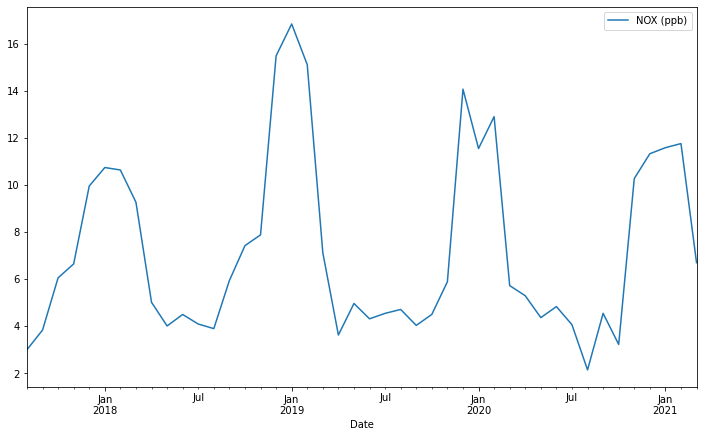

In [ ]:
A = 'M'
df1_w[aa].resample(A).mean().plot(legend = True,figsize = (12,7))
df1_w_c[aa].resample(A).mean().plot()


In [ ]:
print(len(df1_w_c)*100/len(df1_w))

[0]	validation_0-rmse:10.7034
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:10.382
[2]	validation_0-rmse:10.1032
[3]	validation_0-rmse:9.8539
[4]	validation_0-rmse:9.6427
[5]	validation_0-rmse:9.4513
[6]	validation_0-rmse:9.27574
[7]	validation_0-rmse:9.12805
[8]	validation_0-rmse:8.99605
[9]	validation_0-rmse:8.86771
[10]	validation_0-rmse:8.76224
[11]	validation_0-rmse:8.65456
[12]	validation_0-rmse:8.56829
[13]	validation_0-rmse:8.49113
[14]	validation_0-rmse:8.41164
[15]	validation_0-rmse:8.35648
[16]	validation_0-rmse:8.30162
[17]	validation_0-rmse:8.2415
[18]	validation_0-rmse:8.19096
[19]	validation_0-rmse:8.14361
[20]	validation_0-rmse:8.10289
[21]	validation_0-rmse:8.05568
[22]	validation_0-rmse:8.02291
[23]	validation_0-rmse:7.99533
[24]	validation_0-rmse:7.96101
[25]	validation_0-rmse:7.9288
[26]	validation_0-rmse:7.90293
[27]	validation_0-rmse:7.87236
[28]	validation_0-rmse:7.85159
[29]	validation_0-rmse:7.83385
[30]	validation_0-rms

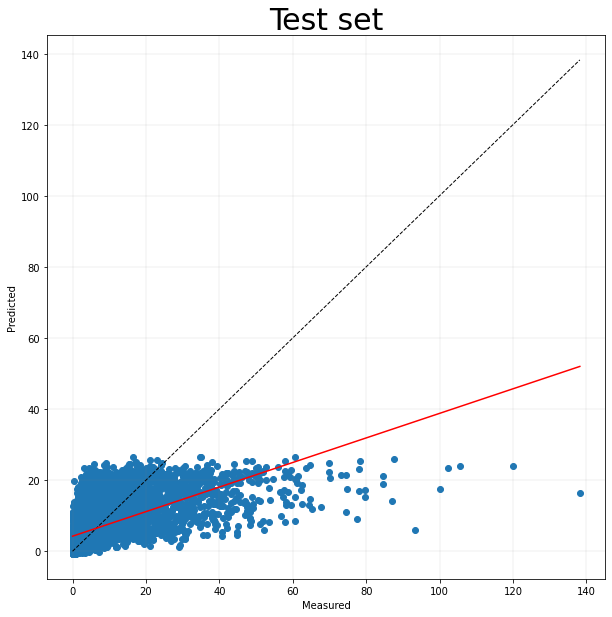

[0.34549059 4.23715445]
RMSE
[7.83393014]
R2
0.37261750880504196


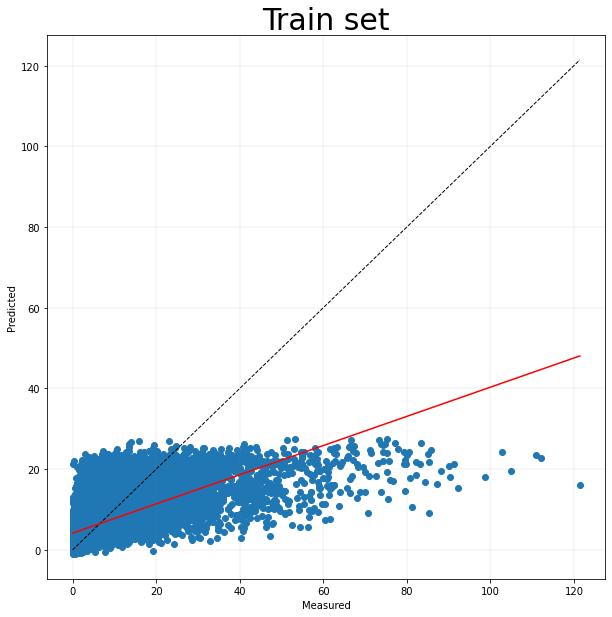

[0.36155897 4.16671863]
RMSE
[7.62701016]
R2
0.3963207822184819


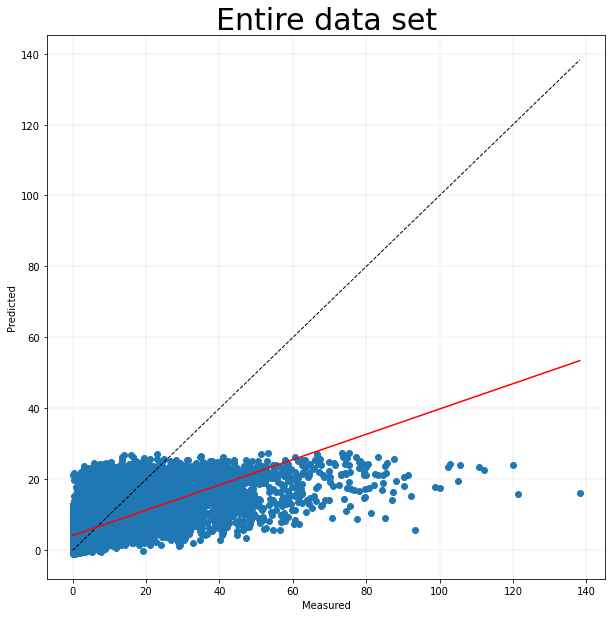

[0.35667617 4.1877833 ]
RMSE
[7.68967081]
R2
0.3891615529615696


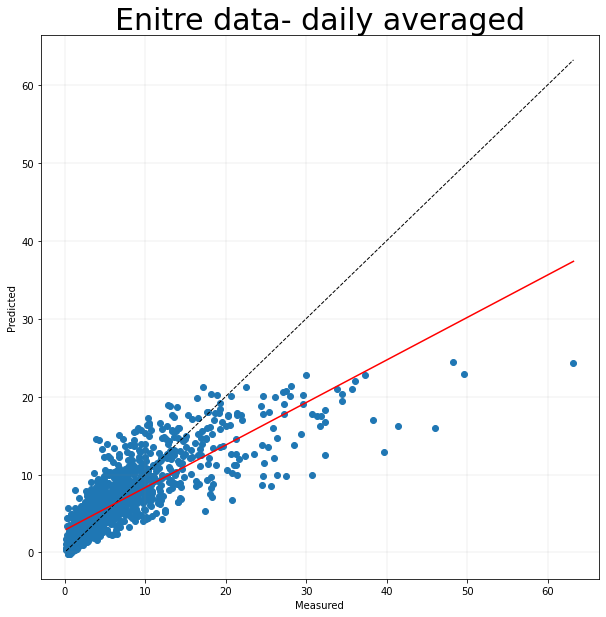

[0.5458412  2.85946683]
RMSE
[4.05374937]
R2
0.6470073436113101


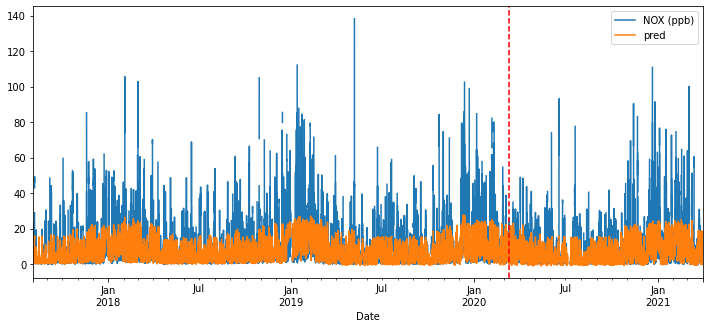

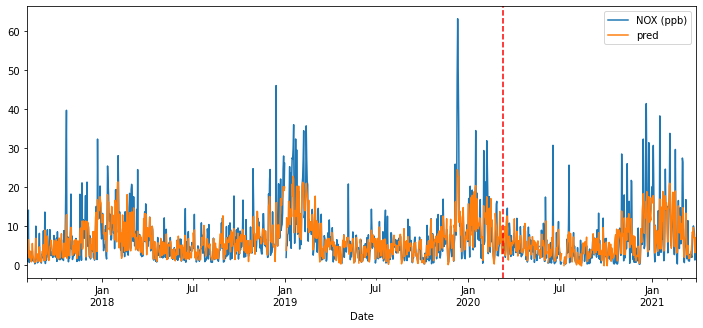

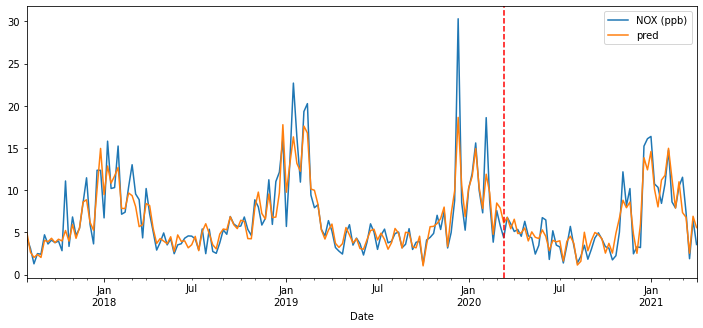

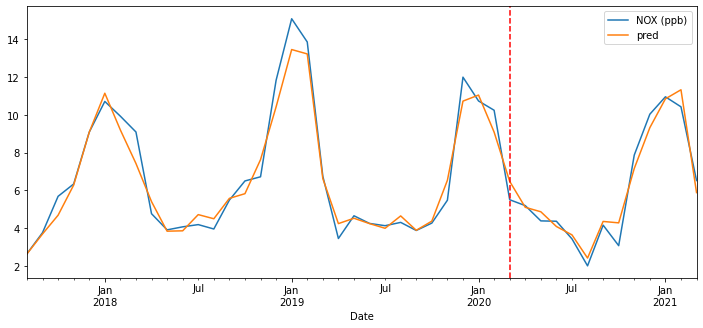

In [ ]:
model= xgb.XGBRegressor(booster = booster, reg_lambda=lambdaa, alpha=alpha,  
                          max_depth = max_depth, eta = eta, gamma = gamma,
                          grow_policy = grow_policy,
                          # n_estimators=n_estimators,
                          objective ='reg:squarederror', 
                          #normalize_type=normalize_type,sample_type=sample_type,rate_drop=rate_drop,skip_drop=skip_drop,
                          random_state=42)

eval_set = [(X_val, y_val)]
model.fit(X_traine, y_traine, early_stopping_rounds=20, eval_metric="rmse", eval_set=eval_set)


preds = model.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))


# df3= df3.copy()
df4 = df1_w_c.copy() #hereee
df4['pred'] = model.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean().copy()
df10.dropna(inplace= True)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(df10[aa]).reshape(-1,1)
y_pred = np.array(df10['pred']).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Enitre data- daily averaged',fontsize=30)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()
print(par)
print('RMSE')
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))



df4[aa].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4.columns

Index(['NOX (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = [ 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend']
test_col = [aa]


df1_w_c = df1_w[[aa, 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2[aa] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 [aa] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Buffalo Viewpoint_NOX_OT_XG_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Buffalo Viewpoint_NOX_OT_XG_Test.csv')


[7.62701016]
0.3963207822184819
[7.83393014]
0.37261750880504196


In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
111
10.819327354431152
2021-01-16 15:00:00
112
10.903346061706543
2021-01-16 16:00:00
113
11.41751766204834
2021-01-16 17:00:00
110
11.65234088897705
2021-01-16 18:00:00
108
11.024811744689941
2021-01-16 19:00:00
109
11.399100303649902
2021-01-16 20:00:00
108
11.022418022155762
2021-01-16 21:00:00
110
11.693723678588867
2021-01-16 22:00:00
113
11.31490421295166
2021-01-16 23:00:00
113
11.336846351623535
2021-01-17 00:00:00
111
10.637015342712402
2021-01-17 01:00:00
113
10.727532386779785
2021-01-17 02:00:00
111
10.804483413696289
2021-01-17 03:00:00
112
11.147965431213379
2021-01-17 04:00:00
108
11.350462913513184
2021-01-17 05:00:00
111
11.137768745422363
2021-01-17 06:00:00
109
11.549863815307617
2021-01-17 07:00:00
109
11.448762893676758
2021-01-17 08:00:00
113
11.964754104614258
2021-01-17 09:00:00
111
12.054322242736816
2021-01-17 10:00:00
107
11.597222328186035
2021-01-17 11:00:00
103
10.721786499023438
2021-01-17 12:00:00
101
10

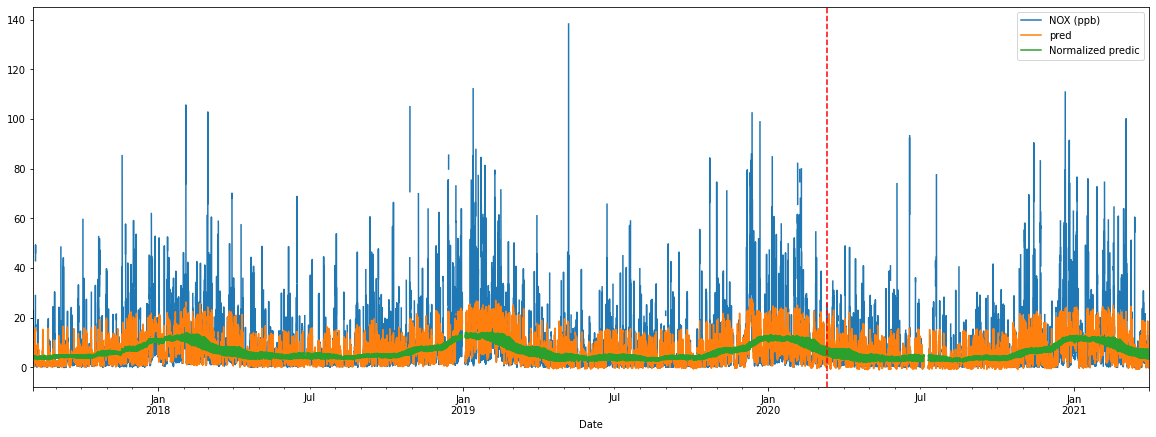

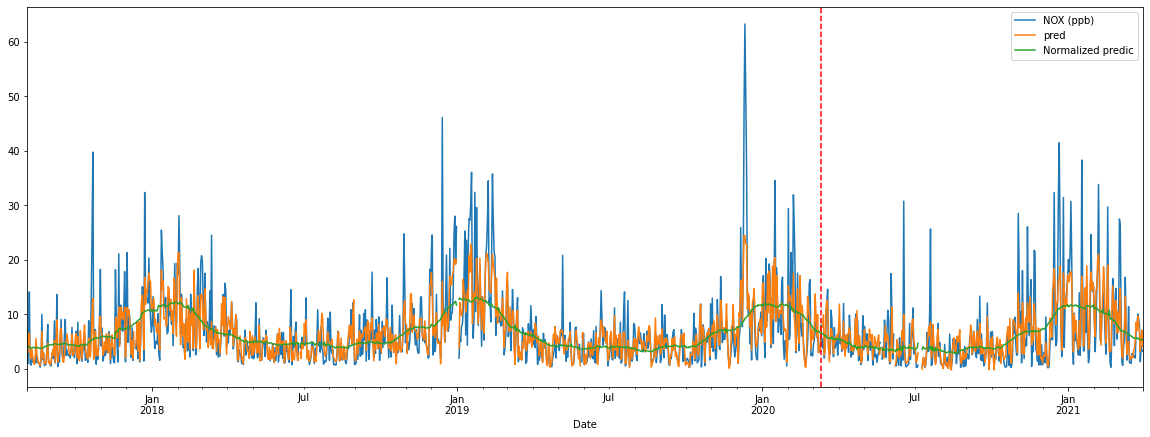

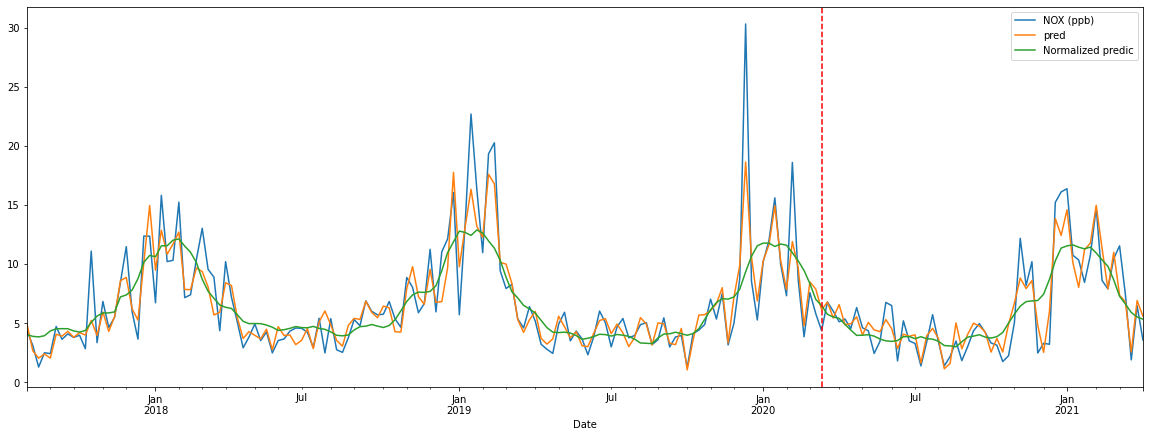

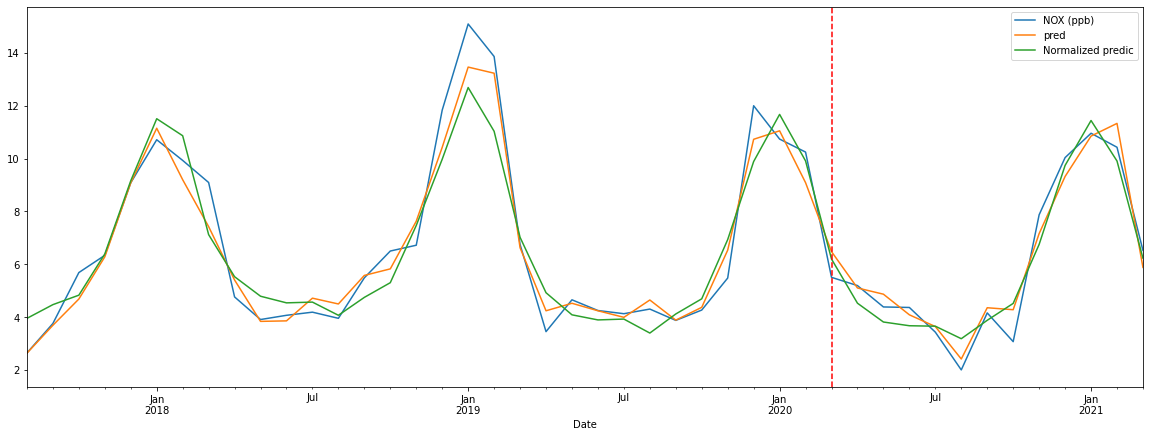

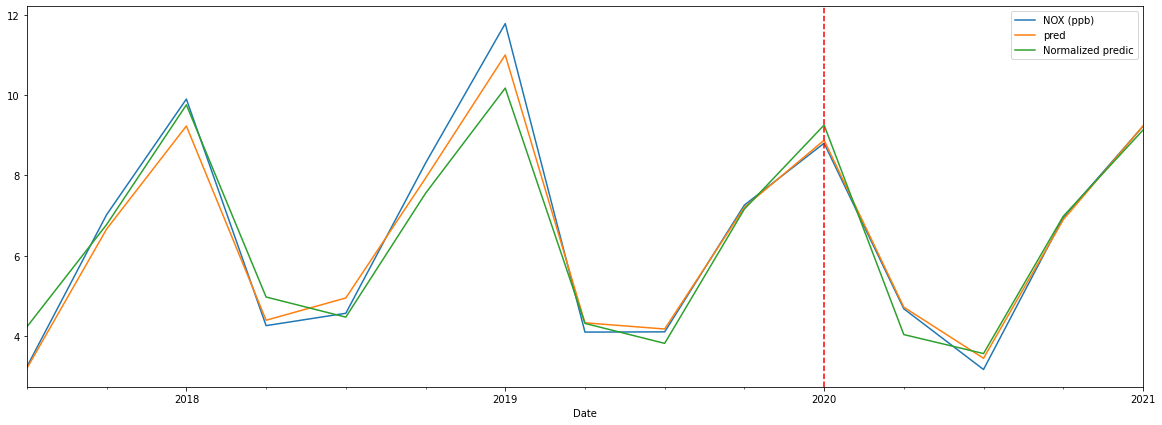

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_NOX_OT_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_NOX_OT_realRH_SO2_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_NOX_OT_realRH_SO2_Monthly_normalized_pred.csv')

for i in ['H','D','W','M','Q']:
    df4_h[aa].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

In [ ]:
############

In [ ]:
maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

avg = df1_w['score'].mean()
std = df1_w['score'].std()

print(avg,std)

6.016874961286912 4.858161777180881


In [ ]:
df1_w

NOX (ppb)  RH %  T ( C)  ...  Day-year      trend      score
Date                                          ...                                
2017-08-04 07:00:00       11.2  92.0    15.5  ...       216  17.588229   8.947872
2017-08-04 08:00:00       22.9  87.0    16.4  ...       216  17.588342  12.062423
2017-08-04 09:00:00       15.9  81.0    17.1  ...       216  17.588456   7.265785
2017-08-04 10:00:00       16.4  78.0    17.5  ...       216  17.588570   5.283310
2017-08-04 11:00:00       14.8  75.0    18.3  ...       216  17.588684  15.643602
...                        ...   ...     ...  ...       ...        ...        ...
2021-03-31 19:00:00        9.4  51.5     5.6  ...        90  21.245332   2.551347
2021-03-31 20:00:00        1.6  53.6     4.2  ...        90  21.245446   2.593244
2021-03-31 21:00:00        0.0  45.6     5.3  ...        90  21.245560   4.394658
2021-03-31 22:00:00        0.0  43.5     5.4  ...        90  21.245674   3.260428
2021-03-31 23:00:00        0.0  46.1     4.6  ...        90  21.245788   5.822751

[30583 rows x 15 columns]

In [ ]:
df1_w

NOX (ppb)  RH %  T ( C)  ...  Day-year      trend      score
Date                                          ...                                
2017-08-04 07:00:00       11.2  92.0    15.5  ...       216  17.588229   8.947872
2017-08-04 08:00:00       22.9  87.0    16.4  ...       216  17.588342  12.062423
2017-08-04 09:00:00       15.9  81.0    17.1  ...       216  17.588456   7.265785
2017-08-04 10:00:00       16.4  78.0    17.5  ...       216  17.588570   5.283310
2017-08-04 11:00:00       14.8  75.0    18.3  ...       216  17.588684  15.643602
...                        ...   ...     ...  ...       ...        ...        ...
2021-03-31 19:00:00        9.4  51.5     5.6  ...        90  21.245332   2.551347
2021-03-31 20:00:00        1.6  53.6     4.2  ...        90  21.245446   2.593244
2021-03-31 21:00:00        0.0  45.6     5.3  ...        90  21.245560   4.394658
2021-03-31 22:00:00        0.0  43.5     5.4  ...        90  21.245674   3.260428
2021-03-31 23:00:00        0.0  46.1     4.6  ...        90  21.245788   5.822751

[30583 rows x 15 columns]

In [ ]:
aa

'NOX (ppb)'

In [ ]:
class Objective(object):
    def __init__(self,df1_w, max_epochs, learn_rate_epochs,
                  ):
        # self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y_scaler, test_size=0.001, random_state=42)
        # self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.11, random_state=42)
        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.df1_w = df1_w.copy()
        self.n_features = len(self.df1_w.columns)-1

    def __call__(self, trial):        
        dict_params = {
                        "score" : trial.suggest_float( 'score', avg + 2*std, avg + 5 * std ),
                        'layers': trial.suggest_int('layers', 2,3),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                        'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,5000,500)),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 20,40),
                        'delta': trial.suggest_float(  'delta',1, 100),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                       'drop_out1': trial.suggest_float('drop_out1',0.05, 0.3)}  
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        dict_params['num_dense_nodes2'] = trial.suggest_int('num_dense_nodes2', 20,40)
        dict_params['drop_out2'] =trial.suggest_float('drop_out2',0.05, 0.5)

        if dict_params['layers'] == 3:
            dict_params['num_dense_nodes3'] = trial.suggest_int('num_dense_nodes3', 5,40)
            dict_params['drop_out3'] = trial.suggest_float('drop_out3',0.05, 0.5)

        self.df_nn =  self.df1_w[self.df1_w['score'] <  dict_params["score"]].copy()
        self.df_nn.drop(columns = ['score'], inplace = True)
        self.Y =   self.df_nn[aa]
        self.Y = np.array(self.Y).reshape(-1,1)
        self.X = np.array( self.df_nn[  self.df_nn.columns[1:]])
        self.X_train =self.X
        self.y_train =self.Y
        # self.X_train,  self.X_test,  self.y_train, self.y_test = train_test_split( self.X,   self.Y, test_size=0.000000001, random_state = 42)

          
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(dict_params['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha= dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out1']))
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        model.add(Dense(dict_params['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out2']))
        if dict_params['layers'] == 3 :
            model.add(Dense(dict_params['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
            model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
            model.add(Dropout(dict_params['drop_out3']))
        model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params[ 'learning_rate'])
        model.compile(loss=
                      # 'mse',
                      tf.keras.losses.Huber( delta=dict_params[ 'delta']),
                      # 'mse'
                          optimizer=opt)
        fn = "gdrive/My Drive/Colab Notebooks/Stations/BuffaloViewpoint___NOX___SO2" +str(trial.number) + ".ckpt" 
        fnn = os.path.dirname(fn)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 4
        kf = KFold(n_splits=n_f )
        acc = 0 
        for train_index, test_index in kf.split( self.X_train):   
                X_tr, X_tes =  self.X_train[train_index],  self.X_train[test_index]
                y_tr, y_tes =   self.y_train[train_index],   self.y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
                h = model.fit(x=X_tra, y=y_tra,
                                  validation_data=(X_val, y_val),
                                  batch_size=dict_params['batchsize'],
                                  epochs=self.max_epochs,
                                  shuffle=True, verbose=0,
                                  callbacks=callbacks_list)
                model.load_weights(fn)
                preds = model.predict(X_tes)
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 

        print(acc)
        return acc    

In [ ]:
objective = Objective(df1_w,maximum_epochs,learning_rate_epochs)
study = optuna.create_study(direction=optimizer_direction, study_name='BuffaloViewpoint___NOX___NN', storage='sqlite:///Buffalo Viewpoint___NOX___NN.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=500)
df_results = study.trials_dataframe()
df_results.to_csv('gdrive/My Drive/Colab Notebooks/results/NN_OT_BuffaloViewpoint_NOX__HUBer.csv')
#df_results.to_pickle('Desktop\heel\df_optuna_results.pkl')

[I 2021-05-16 23:21:51,562] A new study created in RDB with name: BuffaloViewpoint___NOX___NN
[I 2021-05-16 23:24:01,705] Trial 0 finished with value: 81.16551048672626 and parameters: {'score': 17.31658064670639, 'layers': 2, 'alpha': 0.7217210948618895, 'batchsize': 1600.0, 'num_dense_nodes1': 23, 'delta': 11.714812258646555, 'learning_rate': 0.008646076654699733, 'drop_out1': 0.07242327193911423, 'num_dense_nodes2': 36, 'drop_out2': 0.3911615393564524}. Best is trial 0 with value: 81.16551048672626.


81.16551048672626


[I 2021-05-16 23:25:18,334] Trial 1 finished with value: 82.28961821727873 and parameters: {'score': 20.263983075926944, 'layers': 3, 'alpha': 0.6306866617050346, 'batchsize': 1600.0, 'num_dense_nodes1': 28, 'delta': 96.18382591678942, 'learning_rate': 0.09969684166878183, 'drop_out1': 0.2539579486063449, 'num_dense_nodes2': 33, 'drop_out2': 0.436753398375211, 'num_dense_nodes3': 10, 'drop_out3': 0.42169551500609376}. Best is trial 0 with value: 81.16551048672626.


82.28961821727873


[I 2021-05-16 23:32:40,914] Trial 2 finished with value: 84.36831769935847 and parameters: {'score': 19.151798042573134, 'layers': 2, 'alpha': 0.6744307737378215, 'batchsize': 100.0, 'num_dense_nodes1': 38, 'delta': 35.327381658454165, 'learning_rate': 0.08773967958808805, 'drop_out1': 0.2177848158481454, 'num_dense_nodes2': 30, 'drop_out2': 0.10786226614427974}. Best is trial 0 with value: 81.16551048672626.


84.36831769935847


[I 2021-05-16 23:33:43,624] Trial 3 finished with value: 77.49632647781527 and parameters: {'score': 27.76859571678783, 'layers': 3, 'alpha': 0.37985737360318517, 'batchsize': 3600.0, 'num_dense_nodes1': 37, 'delta': 90.10291973926988, 'learning_rate': 0.07550551492197331, 'drop_out1': 0.18269020351425508, 'num_dense_nodes2': 36, 'drop_out2': 0.0786791599859712, 'num_dense_nodes3': 39, 'drop_out3': 0.42071207030180957}. Best is trial 3 with value: 77.49632647781527.


77.49632647781527


[I 2021-05-16 23:34:46,146] Trial 4 finished with value: 78.84072765468756 and parameters: {'score': 25.406147376747086, 'layers': 2, 'alpha': 0.02288810758602427, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 93.27530367866538, 'learning_rate': 0.030074417355832876, 'drop_out1': 0.19673862859696023, 'num_dense_nodes2': 34, 'drop_out2': 0.35615335899999173}. Best is trial 3 with value: 77.49632647781527.


78.84072765468756


[I 2021-05-16 23:35:47,858] Trial 5 finished with value: 81.44965285923324 and parameters: {'score': 23.882240637867476, 'layers': 3, 'alpha': 0.5416295651602293, 'batchsize': 4100.0, 'num_dense_nodes1': 23, 'delta': 26.98881768850936, 'learning_rate': 0.08390773362696294, 'drop_out1': 0.14514332914972217, 'num_dense_nodes2': 23, 'drop_out2': 0.37764156549416017, 'num_dense_nodes3': 21, 'drop_out3': 0.051183589022822176}. Best is trial 3 with value: 77.49632647781527.


81.44965285923324


[I 2021-05-16 23:36:58,460] Trial 6 finished with value: 69.15613949918647 and parameters: {'score': 19.263631516740794, 'layers': 2, 'alpha': 0.2916525234616962, 'batchsize': 2100.0, 'num_dense_nodes1': 34, 'delta': 74.02299777938097, 'learning_rate': 0.02407414924553377, 'drop_out1': 0.06850627351892406, 'num_dense_nodes2': 22, 'drop_out2': 0.05746066989929895}. Best is trial 6 with value: 69.15613949918647.


69.15613949918647


[I 2021-05-16 23:38:06,551] Trial 7 finished with value: 83.91549778290891 and parameters: {'score': 18.049089221665376, 'layers': 2, 'alpha': 0.8558201605072819, 'batchsize': 2100.0, 'num_dense_nodes1': 31, 'delta': 98.21729731866651, 'learning_rate': 0.03445049180739697, 'drop_out1': 0.09629440964676413, 'num_dense_nodes2': 25, 'drop_out2': 0.29627519064873054}. Best is trial 6 with value: 69.15613949918647.


83.91549778290891


[I 2021-05-16 23:39:16,636] Trial 8 finished with value: 85.03775997358625 and parameters: {'score': 26.894072566220785, 'layers': 3, 'alpha': 0.17031434086979597, 'batchsize': 2600.0, 'num_dense_nodes1': 26, 'delta': 11.715543991278105, 'learning_rate': 0.007170576260891692, 'drop_out1': 0.20212254850045036, 'num_dense_nodes2': 34, 'drop_out2': 0.4363407576799588, 'num_dense_nodes3': 11, 'drop_out3': 0.27839829815185546}. Best is trial 6 with value: 69.15613949918647.


85.03775997358625


[I 2021-05-16 23:41:14,254] Trial 9 finished with value: 70.13227853435302 and parameters: {'score': 16.28072824809679, 'layers': 3, 'alpha': 0.24686493137875937, 'batchsize': 600.0, 'num_dense_nodes1': 35, 'delta': 35.896295103790386, 'learning_rate': 0.03764761705443239, 'drop_out1': 0.2350766352502487, 'num_dense_nodes2': 21, 'drop_out2': 0.43555832083651747, 'num_dense_nodes3': 7, 'drop_out3': 0.4106911020295129}. Best is trial 6 with value: 69.15613949918647.


70.13227853435302


[I 2021-05-16 23:42:19,876] Trial 10 finished with value: 72.73699029558234 and parameters: {'score': 21.361491090271077, 'layers': 2, 'alpha': 0.019383874180166683, 'batchsize': 2600.0, 'num_dense_nodes1': 33, 'delta': 68.42588119745133, 'learning_rate': 0.060361254834629806, 'drop_out1': 0.10921026530396476, 'num_dense_nodes2': 27, 'drop_out2': 0.17258506985571503}. Best is trial 6 with value: 69.15613949918647.


72.73699029558234


[I 2021-05-16 23:44:19,351] Trial 11 finished with value: 67.28748544025353 and parameters: {'score': 16.109432027997947, 'layers': 3, 'alpha': 0.28186449512076783, 'batchsize': 600.0, 'num_dense_nodes1': 35, 'delta': 62.30092957332503, 'learning_rate': 0.031444269869412886, 'drop_out1': 0.28351795823009346, 'num_dense_nodes2': 20, 'drop_out2': 0.217678627144631, 'num_dense_nodes3': 5, 'drop_out3': 0.2725272861550326}. Best is trial 11 with value: 67.28748544025353.


67.28748544025353


[I 2021-05-16 23:46:15,432] Trial 12 finished with value: 68.1157007539789 and parameters: {'score': 15.987703957280722, 'layers': 2, 'alpha': 0.3514581636782161, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 65.82102332350543, 'learning_rate': 0.016326739107655246, 'drop_out1': 0.2968612027619436, 'num_dense_nodes2': 20, 'drop_out2': 0.20000150134736494}. Best is trial 11 with value: 67.28748544025353.


68.1157007539789


[I 2021-05-16 23:48:13,344] Trial 13 finished with value: 69.26535832167329 and parameters: {'score': 15.84550029428961, 'layers': 3, 'alpha': 0.42744287987878465, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 58.48144737634244, 'learning_rate': 0.01592690072553357, 'drop_out1': 0.29275752797006654, 'num_dense_nodes2': 20, 'drop_out2': 0.20217695665991386, 'num_dense_nodes3': 38, 'drop_out3': 0.1524850346823852}. Best is trial 11 with value: 67.28748544025353.


69.26535832167329


[I 2021-05-16 23:55:45,518] Trial 14 finished with value: 70.52551675222813 and parameters: {'score': 15.737431616529534, 'layers': 3, 'alpha': 0.14561305721126372, 'batchsize': 100.0, 'num_dense_nodes1': 40, 'delta': 52.380664094587644, 'learning_rate': 0.04910430186687069, 'drop_out1': 0.28691038539750596, 'num_dense_nodes2': 27, 'drop_out2': 0.21267288546184057, 'num_dense_nodes3': 23, 'drop_out3': 0.2537123943413368}. Best is trial 11 with value: 67.28748544025353.


70.52551675222813


[I 2021-05-16 23:57:11,869] Trial 15 finished with value: 78.36597103841763 and parameters: {'score': 22.553540665208157, 'layers': 2, 'alpha': 0.34198568762219317, 'batchsize': 1100.0, 'num_dense_nodes1': 37, 'delta': 77.2616020735363, 'learning_rate': 0.05025510782722008, 'drop_out1': 0.2660995257248138, 'num_dense_nodes2': 40, 'drop_out2': 0.26361287478152157}. Best is trial 11 with value: 67.28748544025353.


78.36597103841763


[I 2021-05-16 23:59:04,807] Trial 16 finished with value: 73.27403376136299 and parameters: {'score': 17.505414392374288, 'layers': 2, 'alpha': 0.5162497376368805, 'batchsize': 600.0, 'num_dense_nodes1': 40, 'delta': 64.7590525772236, 'learning_rate': 0.018058293568130303, 'drop_out1': 0.29808718081801516, 'num_dense_nodes2': 20, 'drop_out2': 0.12633823840843647}. Best is trial 11 with value: 67.28748544025353.


73.27403376136299


[I 2021-05-17 00:00:40,848] Trial 17 finished with value: 72.37780485465561 and parameters: {'score': 15.781009222402842, 'layers': 3, 'alpha': 0.16357724279907038, 'batchsize': 1100.0, 'num_dense_nodes1': 32, 'delta': 44.74357985613741, 'learning_rate': 0.002023470122747466, 'drop_out1': 0.2654161884000954, 'num_dense_nodes2': 24, 'drop_out2': 0.27841548518103054, 'num_dense_nodes3': 21, 'drop_out3': 0.2841421062999602}. Best is trial 11 with value: 67.28748544025353.


72.37780485465561


[I 2021-05-17 00:08:15,398] Trial 18 finished with value: 83.72520327122945 and parameters: {'score': 30.205673749099912, 'layers': 3, 'alpha': 0.24397816354757013, 'batchsize': 100.0, 'num_dense_nodes1': 36, 'delta': 85.5356336852605, 'learning_rate': 0.04086948560697801, 'drop_out1': 0.16347378638256077, 'num_dense_nodes2': 27, 'drop_out2': 0.1730896215323291, 'num_dense_nodes3': 29, 'drop_out3': 0.14436083725813148}. Best is trial 11 with value: 67.28748544025353.


83.72520327122945


[I 2021-05-17 00:09:39,295] Trial 19 finished with value: 79.27279696427019 and parameters: {'score': 20.78158560108732, 'layers': 2, 'alpha': 0.49401928960616026, 'batchsize': 1100.0, 'num_dense_nodes1': 39, 'delta': 56.527465117957625, 'learning_rate': 0.06007588290550906, 'drop_out1': 0.23866910512342068, 'num_dense_nodes2': 20, 'drop_out2': 0.3056048948535475}. Best is trial 11 with value: 67.28748544025353.


79.27279696427019


[I 2021-05-17 00:10:53,943] Trial 20 finished with value: 79.21948876760135 and parameters: {'score': 18.63793639369544, 'layers': 2, 'alpha': 0.07657024228211048, 'batchsize': 1600.0, 'num_dense_nodes1': 35, 'delta': 80.19824787290287, 'learning_rate': 0.024392299391662507, 'drop_out1': 0.2846973828970293, 'num_dense_nodes2': 30, 'drop_out2': 0.2348832931521147}. Best is trial 11 with value: 67.28748544025353.


79.21948876760135


[I 2021-05-17 00:11:57,363] Trial 21 finished with value: 69.19543165377094 and parameters: {'score': 19.28986707249639, 'layers': 2, 'alpha': 0.29600469328910584, 'batchsize': 3100.0, 'num_dense_nodes1': 34, 'delta': 72.87976151049932, 'learning_rate': 0.020600088079613797, 'drop_out1': 0.055145674768981176, 'num_dense_nodes2': 22, 'drop_out2': 0.07059052986461183}. Best is trial 11 with value: 67.28748544025353.


69.19543165377094


[I 2021-05-17 00:12:59,171] Trial 22 finished with value: 71.7235474309415 and parameters: {'score': 17.055445209244922, 'layers': 2, 'alpha': 0.395384791089641, 'batchsize': 4600.0, 'num_dense_nodes1': 29, 'delta': 66.48838348435375, 'learning_rate': 0.02715115945748466, 'drop_out1': 0.12742008468900906, 'num_dense_nodes2': 25, 'drop_out2': 0.1405951818243787}. Best is trial 11 with value: 67.28748544025353.


71.7235474309415


[I 2021-05-17 00:14:11,183] Trial 23 finished with value: 71.81602104079465 and parameters: {'score': 16.87600484958331, 'layers': 2, 'alpha': 0.27757413977049283, 'batchsize': 2100.0, 'num_dense_nodes1': 33, 'delta': 45.73913096239484, 'learning_rate': 0.012108825391280841, 'drop_out1': 0.0758133262122361, 'num_dense_nodes2': 22, 'drop_out2': 0.1645370427404977}. Best is trial 11 with value: 67.28748544025353.


71.81602104079465


[I 2021-05-17 00:16:14,375] Trial 24 finished with value: 73.32016070051812 and parameters: {'score': 19.883339510849357, 'layers': 2, 'alpha': 0.33114447353731863, 'batchsize': 600.0, 'num_dense_nodes1': 31, 'delta': 60.453222326604056, 'learning_rate': 0.0011756842298139402, 'drop_out1': 0.15489085138339734, 'num_dense_nodes2': 22, 'drop_out2': 0.053417079310416615}. Best is trial 11 with value: 67.28748544025353.


73.32016070051812


[I 2021-05-17 00:17:39,945] Trial 25 finished with value: 78.36575283693152 and parameters: {'score': 22.135004069031766, 'layers': 2, 'alpha': 0.23013492916838185, 'batchsize': 1100.0, 'num_dense_nodes1': 38, 'delta': 81.77781016395843, 'learning_rate': 0.04243670146080249, 'drop_out1': 0.29928326212569, 'num_dense_nodes2': 20, 'drop_out2': 0.3386790915486537}. Best is trial 11 with value: 67.28748544025353.


78.36575283693152


[I 2021-05-17 00:18:48,621] Trial 26 finished with value: 81.478129385268 and parameters: {'score': 23.8556931758179, 'layers': 2, 'alpha': 0.44800885577956334, 'batchsize': 2100.0, 'num_dense_nodes1': 35, 'delta': 73.54215491439054, 'learning_rate': 0.030163397108844768, 'drop_out1': 0.23414420382164303, 'num_dense_nodes2': 25, 'drop_out2': 0.24452287366777642}. Best is trial 11 with value: 67.28748544025353.


81.478129385268


[I 2021-05-17 00:20:05,865] Trial 27 finished with value: 80.0377935665832 and parameters: {'score': 18.394912866032268, 'layers': 3, 'alpha': 0.12197542038428502, 'batchsize': 1600.0, 'num_dense_nodes1': 33, 'delta': 69.92387582118755, 'learning_rate': 0.021859165311532362, 'drop_out1': 0.27154822778216486, 'num_dense_nodes2': 23, 'drop_out2': 0.10203525197829842, 'num_dense_nodes3': 16, 'drop_out3': 0.3370635444767862}. Best is trial 11 with value: 67.28748544025353.


80.0377935665832


[I 2021-05-17 00:27:08,059] Trial 28 finished with value: 70.34101815147565 and parameters: {'score': 16.752597667005215, 'layers': 2, 'alpha': 0.5674409454877878, 'batchsize': 100.0, 'num_dense_nodes1': 37, 'delta': 51.992837773412425, 'learning_rate': 0.013989355395937045, 'drop_out1': 0.052975878992297054, 'num_dense_nodes2': 20, 'drop_out2': 0.32060955029709626}. Best is trial 11 with value: 67.28748544025353.


70.34101815147565


[I 2021-05-17 00:28:17,796] Trial 29 finished with value: 69.39954639132347 and parameters: {'score': 17.66137387977412, 'layers': 2, 'alpha': 0.3533270541111019, 'batchsize': 3100.0, 'num_dense_nodes1': 30, 'delta': 86.22881574039772, 'learning_rate': 0.00509542048316039, 'drop_out1': 0.09214363528619957, 'num_dense_nodes2': 40, 'drop_out2': 0.18782868312958484}. Best is trial 11 with value: 67.28748544025353.


69.39954639132347


[I 2021-05-17 00:29:34,671] Trial 30 finished with value: 77.50262252223138 and parameters: {'score': 19.5695196839569, 'layers': 3, 'alpha': 0.21346295674172558, 'batchsize': 1600.0, 'num_dense_nodes1': 36, 'delta': 63.41690476414744, 'learning_rate': 0.033376114973349365, 'drop_out1': 0.25035661013776334, 'num_dense_nodes2': 28, 'drop_out2': 0.22874181822915912, 'num_dense_nodes3': 5, 'drop_out3': 0.1497793926366027}. Best is trial 11 with value: 67.28748544025353.


77.50262252223138


[I 2021-05-17 00:30:37,528] Trial 31 finished with value: 76.39459176191045 and parameters: {'score': 21.509628541570034, 'layers': 2, 'alpha': 0.3152880982583218, 'batchsize': 3100.0, 'num_dense_nodes1': 34, 'delta': 72.05140960586392, 'learning_rate': 0.022013926563412386, 'drop_out1': 0.05006750248518063, 'num_dense_nodes2': 22, 'drop_out2': 0.053446264996380916}. Best is trial 11 with value: 67.28748544025353.


76.39459176191045


[I 2021-05-17 00:31:48,338] Trial 32 finished with value: 74.07752258477913 and parameters: {'score': 18.98045563547329, 'layers': 2, 'alpha': 0.29374874097603276, 'batchsize': 3100.0, 'num_dense_nodes1': 34, 'delta': 73.47806255775308, 'learning_rate': 0.010115165135358772, 'drop_out1': 0.064633231969158, 'num_dense_nodes2': 21, 'drop_out2': 0.09093731783709039}. Best is trial 11 with value: 67.28748544025353.


74.07752258477913


[I 2021-05-17 00:32:53,024] Trial 33 finished with value: 73.7634936065082 and parameters: {'score': 20.237743857175037, 'layers': 2, 'alpha': 0.4158857202877274, 'batchsize': 3600.0, 'num_dense_nodes1': 32, 'delta': 56.888544489871116, 'learning_rate': 0.01919252893267833, 'drop_out1': 0.07608301726630504, 'num_dense_nodes2': 23, 'drop_out2': 0.1391698028783609}. Best is trial 11 with value: 67.28748544025353.


73.7634936065082


[I 2021-05-17 00:34:01,349] Trial 34 finished with value: 70.94333527417645 and parameters: {'score': 17.85514739604074, 'layers': 2, 'alpha': 0.279789225124583, 'batchsize': 2600.0, 'num_dense_nodes1': 26, 'delta': 83.18938543660195, 'learning_rate': 0.026499241925463247, 'drop_out1': 0.11815109669757445, 'num_dense_nodes2': 21, 'drop_out2': 0.06907291682918364}. Best is trial 11 with value: 67.28748544025353.


70.94333527417645


[I 2021-05-17 00:35:00,984] Trial 35 finished with value: 67.8629161664377 and parameters: {'score': 16.384428489570915, 'layers': 2, 'alpha': 0.47275525825158926, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 77.20749187044007, 'learning_rate': 0.045176956325028765, 'drop_out1': 0.06543832499478938, 'num_dense_nodes2': 24, 'drop_out2': 0.109091586212228}. Best is trial 11 with value: 67.28748544025353.


67.8629161664377


[I 2021-05-17 00:36:00,674] Trial 36 finished with value: 70.73195509248026 and parameters: {'score': 16.554787608997604, 'layers': 2, 'alpha': 0.5991977452909398, 'batchsize': 4600.0, 'num_dense_nodes1': 38, 'delta': 93.75920990952051, 'learning_rate': 0.043770695750335875, 'drop_out1': 0.08747105549784362, 'num_dense_nodes2': 24, 'drop_out2': 0.12496347426425228}. Best is trial 11 with value: 67.28748544025353.


70.73195509248026


[I 2021-05-17 00:37:00,557] Trial 37 finished with value: 74.14179302415613 and parameters: {'score': 15.763123455314657, 'layers': 2, 'alpha': 0.6787095257153701, 'batchsize': 4100.0, 'num_dense_nodes1': 39, 'delta': 46.01600531278055, 'learning_rate': 0.05796140784143966, 'drop_out1': 0.1816771301285394, 'num_dense_nodes2': 31, 'drop_out2': 0.2559936031253171}. Best is trial 11 with value: 67.28748544025353.


74.14179302415613


[I 2021-05-17 00:38:01,696] Trial 38 finished with value: 71.55414988810348 and parameters: {'score': 17.577906368445976, 'layers': 2, 'alpha': 0.4840369684988487, 'batchsize': 4100.0, 'num_dense_nodes1': 38, 'delta': 77.39217369471818, 'learning_rate': 0.035189137312027705, 'drop_out1': 0.1319015518669062, 'num_dense_nodes2': 24, 'drop_out2': 0.15306320636116943}. Best is trial 11 with value: 67.28748544025353.


71.55414988810348


[I 2021-05-17 00:39:56,539] Trial 39 finished with value: 82.69962912739898 and parameters: {'score': 16.511456987667977, 'layers': 3, 'alpha': 0.801293986447426, 'batchsize': 600.0, 'num_dense_nodes1': 20, 'delta': 88.62505778993905, 'learning_rate': 0.07275882197092615, 'drop_out1': 0.21779561857060822, 'num_dense_nodes2': 38, 'drop_out2': 0.20649763931647896, 'num_dense_nodes3': 32, 'drop_out3': 0.4881897499619918}. Best is trial 11 with value: 67.28748544025353.


82.69962912739898


[I 2021-05-17 00:41:06,829] Trial 40 finished with value: 74.19057808274908 and parameters: {'score': 18.490470447429065, 'layers': 2, 'alpha': 0.3765560774033987, 'batchsize': 2100.0, 'num_dense_nodes1': 36, 'delta': 98.90744122057657, 'learning_rate': 0.04490952072887937, 'drop_out1': 0.06386675886072353, 'num_dense_nodes2': 26, 'drop_out2': 0.11536734567977716}. Best is trial 11 with value: 67.28748544025353.


74.19057808274908


[I 2021-05-17 00:42:08,633] Trial 41 finished with value: 74.90565798923997 and parameters: {'score': 23.678454545357063, 'layers': 2, 'alpha': 0.2052885436205158, 'batchsize': 3600.0, 'num_dense_nodes1': 34, 'delta': 64.18806539673322, 'learning_rate': 0.02856916026012484, 'drop_out1': 0.053357696169715745, 'num_dense_nodes2': 22, 'drop_out2': 0.07488924439276975}. Best is trial 11 with value: 67.28748544025353.


74.90565798923997


[I 2021-05-17 00:43:11,030] Trial 42 finished with value: 71.22084995607355 and parameters: {'score': 19.2831900006334, 'layers': 2, 'alpha': 0.4561852836465013, 'batchsize': 3100.0, 'num_dense_nodes1': 39, 'delta': 76.33894013274313, 'learning_rate': 0.03720277113973045, 'drop_out1': 0.1091605090727556, 'num_dense_nodes2': 21, 'drop_out2': 0.08768234131705374}. Best is trial 11 with value: 67.28748544025353.


71.22084995607355


[I 2021-05-17 00:44:14,690] Trial 43 finished with value: 83.17972605742666 and parameters: {'score': 24.78280857767426, 'layers': 2, 'alpha': 0.3632551768629877, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'delta': 68.37117417577079, 'learning_rate': 0.031013380415021385, 'drop_out1': 0.08197974025714348, 'num_dense_nodes2': 23, 'drop_out2': 0.0628162140678464}. Best is trial 11 with value: 67.28748544025353.


83.17972605742666


[I 2021-05-17 00:45:21,184] Trial 44 finished with value: 75.51708685865401 and parameters: {'score': 21.027976322497054, 'layers': 2, 'alpha': 0.2927309739612098, 'batchsize': 2600.0, 'num_dense_nodes1': 37, 'delta': 59.88667615556177, 'learning_rate': 0.0172227429583608, 'drop_out1': 0.06083479915428985, 'num_dense_nodes2': 21, 'drop_out2': 0.18723921043503294}. Best is trial 11 with value: 67.28748544025353.


75.51708685865401


[I 2021-05-17 00:46:22,956] Trial 45 finished with value: 61.32352773290566 and parameters: {'score': 16.122759553534554, 'layers': 2, 'alpha': 0.09617218978106626, 'batchsize': 3600.0, 'num_dense_nodes1': 35, 'delta': 78.9167389268078, 'learning_rate': 0.055041242412241655, 'drop_out1': 0.10435381509781971, 'num_dense_nodes2': 32, 'drop_out2': 0.10083850397077052}. Best is trial 45 with value: 61.32352773290566.


61.32352773290566


[I 2021-05-17 00:47:24,595] Trial 46 finished with value: 62.55315717326485 and parameters: {'score': 16.034572249423043, 'layers': 2, 'alpha': 0.10128687469676864, 'batchsize': 3600.0, 'num_dense_nodes1': 35, 'delta': 90.39779335355321, 'learning_rate': 0.05490271360783617, 'drop_out1': 0.10008469908188024, 'num_dense_nodes2': 31, 'drop_out2': 0.10346617678289229}. Best is trial 45 with value: 61.32352773290566.


62.55315717326485


[I 2021-05-17 00:48:26,102] Trial 47 finished with value: 83.48665247516867 and parameters: {'score': 16.3186780983871, 'layers': 2, 'alpha': 0.043887905891526434, 'batchsize': 3600.0, 'num_dense_nodes1': 40, 'delta': 93.95066069744641, 'learning_rate': 0.07163577275117723, 'drop_out1': 0.13700012849268917, 'num_dense_nodes2': 32, 'drop_out2': 0.14425724651923227}. Best is trial 45 with value: 61.32352773290566.


83.48665247516867


[I 2021-05-17 00:49:28,156] Trial 48 finished with value: 77.96666176728715 and parameters: {'score': 15.784798855677572, 'layers': 3, 'alpha': 0.10272421663299025, 'batchsize': 4600.0, 'num_dense_nodes1': 39, 'delta': 4.342790302364577, 'learning_rate': 0.05348576273107212, 'drop_out1': 0.10031657376176839, 'num_dense_nodes2': 34, 'drop_out2': 0.48913618672490305, 'num_dense_nodes3': 12, 'drop_out3': 0.20858881991929312}. Best is trial 45 with value: 61.32352773290566.


77.96666176728715


[I 2021-05-17 00:50:29,596] Trial 49 finished with value: 71.59688473348781 and parameters: {'score': 17.177259110702096, 'layers': 2, 'alpha': 0.0378551391236279, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 88.85534492444371, 'learning_rate': 0.055301496095891224, 'drop_out1': 0.10915732965693695, 'num_dense_nodes2': 29, 'drop_out2': 0.10519650479699515}. Best is trial 45 with value: 61.32352773290566.


71.59688473348781


[I 2021-05-17 00:51:30,082] Trial 50 finished with value: 79.76760321693813 and parameters: {'score': 29.14445694176717, 'layers': 2, 'alpha': 0.18354215357501688, 'batchsize': 3600.0, 'num_dense_nodes1': 35, 'delta': 90.93917433541307, 'learning_rate': 0.06669127738425765, 'drop_out1': 0.1680947641183721, 'num_dense_nodes2': 32, 'drop_out2': 0.22506941500250083}. Best is trial 45 with value: 61.32352773290566.


79.76760321693813


[I 2021-05-17 00:52:30,900] Trial 51 finished with value: 62.94288736830203 and parameters: {'score': 16.061888990508212, 'layers': 2, 'alpha': 0.08362989706131319, 'batchsize': 4100.0, 'num_dense_nodes1': 32, 'delta': 79.05606858524608, 'learning_rate': 0.04873561358768608, 'drop_out1': 0.09774149592755195, 'num_dense_nodes2': 33, 'drop_out2': 0.12207160985815359}. Best is trial 45 with value: 61.32352773290566.


62.94288736830203


[I 2021-05-17 00:53:31,698] Trial 52 finished with value: 62.58766474446363 and parameters: {'score': 16.115893789418035, 'layers': 2, 'alpha': 0.06839584673777481, 'batchsize': 4100.0, 'num_dense_nodes1': 32, 'delta': 79.33047565969235, 'learning_rate': 0.06376449712033745, 'drop_out1': 0.09840928518888752, 'num_dense_nodes2': 35, 'drop_out2': 0.11926279759277592}. Best is trial 45 with value: 61.32352773290566.


62.58766474446363


[I 2021-05-17 00:54:32,469] Trial 53 finished with value: 70.58709197719052 and parameters: {'score': 16.411587682084864, 'layers': 2, 'alpha': 0.09676853094874838, 'batchsize': 4100.0, 'num_dense_nodes1': 32, 'delta': 80.3723976656531, 'learning_rate': 0.0647468493930956, 'drop_out1': 0.11975548455395023, 'num_dense_nodes2': 35, 'drop_out2': 0.12264144445846044}. Best is trial 45 with value: 61.32352773290566.


70.58709197719052


[I 2021-05-17 00:55:32,929] Trial 54 finished with value: 61.10592259040279 and parameters: {'score': 15.81193595241685, 'layers': 2, 'alpha': 0.0693459098845384, 'batchsize': 4600.0, 'num_dense_nodes1': 31, 'delta': 84.10608436930836, 'learning_rate': 0.04723479410468056, 'drop_out1': 0.14584776652598969, 'num_dense_nodes2': 36, 'drop_out2': 0.10179421317688263}. Best is trial 54 with value: 61.10592259040279.


61.10592259040279


[I 2021-05-17 00:56:33,720] Trial 55 finished with value: 66.16413628724236 and parameters: {'score': 15.79476105136447, 'layers': 2, 'alpha': 0.010190675509252511, 'batchsize': 4600.0, 'num_dense_nodes1': 30, 'delta': 82.62878983899243, 'learning_rate': 0.08154508115886157, 'drop_out1': 0.1038549323365419, 'num_dense_nodes2': 37, 'drop_out2': 0.09064816313349525}. Best is trial 54 with value: 61.10592259040279.


66.16413628724236


[I 2021-05-17 00:57:31,992] Trial 56 finished with value: 58.44955467506097 and parameters: {'score': 15.743899238076496, 'layers': 2, 'alpha': 0.015144062296507318, 'batchsize': 4600.0, 'num_dense_nodes1': 27, 'delta': 85.5220940033019, 'learning_rate': 0.09931832580249142, 'drop_out1': 0.10130886790376113, 'num_dense_nodes2': 37, 'drop_out2': 0.09219449785571843}. Best is trial 56 with value: 58.44955467506097.


58.44955467506097


[I 2021-05-17 00:58:31,728] Trial 57 finished with value: 70.15205412526234 and parameters: {'score': 17.200851590376697, 'layers': 2, 'alpha': 0.07137669241827493, 'batchsize': 4600.0, 'num_dense_nodes1': 28, 'delta': 96.82464028705496, 'learning_rate': 0.09508054657401632, 'drop_out1': 0.12299010554206781, 'num_dense_nodes2': 36, 'drop_out2': 0.15736604899416265}. Best is trial 56 with value: 58.44955467506097.


70.15205412526234


[I 2021-05-17 00:59:31,409] Trial 58 finished with value: 72.73142090578335 and parameters: {'score': 17.85810828335086, 'layers': 2, 'alpha': 0.13746053499903352, 'batchsize': 4600.0, 'num_dense_nodes1': 27, 'delta': 86.07278308205113, 'learning_rate': 0.051879849215419084, 'drop_out1': 0.14573042201871794, 'num_dense_nodes2': 33, 'drop_out2': 0.13214582240007003}. Best is trial 56 with value: 58.44955467506097.


72.73142090578335


[I 2021-05-17 01:00:32,683] Trial 59 finished with value: 74.09356840642207 and parameters: {'score': 26.76342902926314, 'layers': 2, 'alpha': 0.062103246729169906, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 90.81545149125053, 'learning_rate': 0.06475043325622515, 'drop_out1': 0.08859281878123353, 'num_dense_nodes2': 38, 'drop_out2': 0.08516222965692395}. Best is trial 56 with value: 58.44955467506097.


74.09356840642207


[I 2021-05-17 01:01:36,940] Trial 60 finished with value: 73.07186103516378 and parameters: {'score': 17.014256811228933, 'layers': 2, 'alpha': 0.10043844594262236, 'batchsize': 4100.0, 'num_dense_nodes1': 29, 'delta': 21.374208597988698, 'learning_rate': 0.047382124816849606, 'drop_out1': 0.14033786442089174, 'num_dense_nodes2': 35, 'drop_out2': 0.09922538955175875}. Best is trial 56 with value: 58.44955467506097.


73.07186103516378


[I 2021-05-17 01:02:36,165] Trial 61 finished with value: 61.627584419318644 and parameters: {'score': 15.7362393162179, 'layers': 2, 'alpha': 0.016041928634921987, 'batchsize': 4600.0, 'num_dense_nodes1': 30, 'delta': 83.332013415374, 'learning_rate': 0.08878849424012718, 'drop_out1': 0.09844621751417496, 'num_dense_nodes2': 38, 'drop_out2': 0.0892932848113331}. Best is trial 56 with value: 58.44955467506097.


61.627584419318644


[I 2021-05-17 01:03:36,165] Trial 62 finished with value: 64.15199288623168 and parameters: {'score': 15.777596629549986, 'layers': 2, 'alpha': 0.023326673085566428, 'batchsize': 4600.0, 'num_dense_nodes1': 31, 'delta': 85.64100681381245, 'learning_rate': 0.09759932360048734, 'drop_out1': 0.10066563616692577, 'num_dense_nodes2': 39, 'drop_out2': 0.11364959543041653}. Best is trial 56 with value: 58.44955467506097.


64.15199288623168


[I 2021-05-17 01:04:36,081] Trial 63 finished with value: 62.07788612781752 and parameters: {'score': 16.138287617933365, 'layers': 2, 'alpha': 0.0582041439994003, 'batchsize': 4100.0, 'num_dense_nodes1': 29, 'delta': 99.65027513642053, 'learning_rate': 0.0891664695213365, 'drop_out1': 0.08199898894485647, 'num_dense_nodes2': 36, 'drop_out2': 0.07855820231773411}. Best is trial 56 with value: 58.44955467506097.


62.07788612781752


[I 2021-05-17 01:05:37,143] Trial 64 finished with value: 66.3703003313639 and parameters: {'score': 16.80133917243694, 'layers': 2, 'alpha': 0.13619156527807993, 'batchsize': 4600.0, 'num_dense_nodes1': 29, 'delta': 99.54523128296943, 'learning_rate': 0.09315924698324761, 'drop_out1': 0.11623878933911462, 'num_dense_nodes2': 36, 'drop_out2': 0.07561884201899907}. Best is trial 56 with value: 58.44955467506097.


66.3703003313639


[I 2021-05-17 01:06:37,458] Trial 65 finished with value: 65.1236776927667 and parameters: {'score': 18.257457927884985, 'layers': 2, 'alpha': 0.013112694485974269, 'batchsize': 4100.0, 'num_dense_nodes1': 28, 'delta': 96.6305842316311, 'learning_rate': 0.08832400904522511, 'drop_out1': 0.07990604935880513, 'num_dense_nodes2': 37, 'drop_out2': 0.052893177236929045}. Best is trial 56 with value: 58.44955467506097.


65.1236776927667


[I 2021-05-17 01:07:37,346] Trial 66 finished with value: 68.10756301304393 and parameters: {'score': 17.312164974926873, 'layers': 2, 'alpha': 0.048064861277883744, 'batchsize': 4600.0, 'num_dense_nodes1': 26, 'delta': 95.04042446228624, 'learning_rate': 0.08092900090256071, 'drop_out1': 0.15319904110679022, 'num_dense_nodes2': 35, 'drop_out2': 0.09846328747071834}. Best is trial 56 with value: 58.44955467506097.


68.10756301304393


[I 2021-05-17 01:08:38,770] Trial 67 finished with value: 61.20748123584996 and parameters: {'score': 16.296516338170022, 'layers': 2, 'alpha': 0.1748761205300347, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 91.92272555475442, 'learning_rate': 0.0889396667836304, 'drop_out1': 0.09166939526735828, 'num_dense_nodes2': 37, 'drop_out2': 0.06398015327570691}. Best is trial 56 with value: 58.44955467506097.


61.20748123584996


[I 2021-05-17 01:09:41,372] Trial 68 finished with value: 69.7288410767599 and parameters: {'score': 16.79028080926009, 'layers': 2, 'alpha': 0.16138280575389752, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 90.34788458315558, 'learning_rate': 0.08738550627858688, 'drop_out1': 0.07177635651637905, 'num_dense_nodes2': 39, 'drop_out2': 0.06399923708752775}. Best is trial 56 with value: 58.44955467506097.


69.7288410767599


[I 2021-05-17 01:10:47,307] Trial 69 finished with value: 60.03264509776655 and parameters: {'score': 16.12614007432416, 'layers': 2, 'alpha': 0.114141190039313, 'batchsize': 3600.0, 'num_dense_nodes1': 25, 'delta': 83.54764161615981, 'learning_rate': 0.09038080577356834, 'drop_out1': 0.11316944083347005, 'num_dense_nodes2': 37, 'drop_out2': 0.05358701885842411}. Best is trial 56 with value: 58.44955467506097.


60.03264509776655


[I 2021-05-17 01:11:50,922] Trial 70 finished with value: 74.95692075293476 and parameters: {'score': 17.500935843184546, 'layers': 2, 'alpha': 0.120669000029932, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 85.6769717080339, 'learning_rate': 0.09937758605458413, 'drop_out1': 0.11236576357755237, 'num_dense_nodes2': 37, 'drop_out2': 0.05181692484337351}. Best is trial 56 with value: 58.44955467506097.


74.95692075293476


[I 2021-05-17 01:12:56,031] Trial 71 finished with value: 70.45997984382694 and parameters: {'score': 15.779933169811077, 'layers': 2, 'alpha': 0.19059599259871074, 'batchsize': 3600.0, 'num_dense_nodes1': 25, 'delta': 92.25637413286859, 'learning_rate': 0.09172882396189168, 'drop_out1': 0.08853126590596319, 'num_dense_nodes2': 38, 'drop_out2': 0.08134218664115221}. Best is trial 56 with value: 58.44955467506097.


70.45997984382694


[I 2021-05-17 01:13:59,911] Trial 72 finished with value: 66.06072859380114 and parameters: {'score': 16.15037419433066, 'layers': 2, 'alpha': 0.011916254767174589, 'batchsize': 3100.0, 'num_dense_nodes1': 27, 'delta': 82.7559641291196, 'learning_rate': 0.08711436138282441, 'drop_out1': 0.1293415507413785, 'num_dense_nodes2': 39, 'drop_out2': 0.05066742896978173}. Best is trial 56 with value: 58.44955467506097.


66.06072859380114


[I 2021-05-17 01:15:02,097] Trial 73 finished with value: 78.47811651067022 and parameters: {'score': 16.653516723796805, 'layers': 2, 'alpha': 0.11667528946073065, 'batchsize': 3600.0, 'num_dense_nodes1': 26, 'delta': 88.60058518375769, 'learning_rate': 0.07758878773931062, 'drop_out1': 0.08291405355936929, 'num_dense_nodes2': 37, 'drop_out2': 0.0644517424289939}. Best is trial 56 with value: 58.44955467506097.


78.47811651067022


[I 2021-05-17 01:16:02,901] Trial 74 finished with value: 76.13123725018 and parameters: {'score': 18.073330899346843, 'layers': 2, 'alpha': 0.03950982328086519, 'batchsize': 4100.0, 'num_dense_nodes1': 25, 'delta': 99.2852832562809, 'learning_rate': 0.0908390041391188, 'drop_out1': 0.10856004968995808, 'num_dense_nodes2': 36, 'drop_out2': 0.3951020223034301}. Best is trial 56 with value: 58.44955467506097.


76.13123725018


[I 2021-05-17 01:17:06,568] Trial 75 finished with value: 73.70933097252264 and parameters: {'score': 16.20931858630791, 'layers': 2, 'alpha': 0.15050600557780705, 'batchsize': 4600.0, 'num_dense_nodes1': 30, 'delta': 83.96508856081972, 'learning_rate': 0.08426755004324231, 'drop_out1': 0.09492924987808023, 'num_dense_nodes2': 36, 'drop_out2': 0.09527036635153671}. Best is trial 56 with value: 58.44955467506097.


73.70933097252264


[I 2021-05-17 01:18:12,517] Trial 76 finished with value: 73.58864543329409 and parameters: {'score': 16.991499754758575, 'layers': 2, 'alpha': 0.08570243911726357, 'batchsize': 3100.0, 'num_dense_nodes1': 31, 'delta': 92.87825435286601, 'learning_rate': 0.09583456125566901, 'drop_out1': 0.1266756427163891, 'num_dense_nodes2': 31, 'drop_out2': 0.08088545263514833}. Best is trial 56 with value: 58.44955467506097.


73.58864543329409


[I 2021-05-17 01:19:16,104] Trial 77 finished with value: 67.53186597924477 and parameters: {'score': 15.803068681828847, 'layers': 2, 'alpha': 0.25053178110217716, 'batchsize': 3600.0, 'num_dense_nodes1': 22, 'delta': 88.4191004979143, 'learning_rate': 0.0989885557287549, 'drop_out1': 0.08992365036955673, 'num_dense_nodes2': 34, 'drop_out2': 0.14160696161434502}. Best is trial 56 with value: 58.44955467506097.


67.53186597924477


[I 2021-05-17 01:20:18,056] Trial 78 finished with value: 72.8904092638347 and parameters: {'score': 16.54794968908753, 'layers': 2, 'alpha': 0.05848960587665199, 'batchsize': 4100.0, 'num_dense_nodes1': 29, 'delta': 75.95072374540334, 'learning_rate': 0.08372135121063881, 'drop_out1': 0.10382851387714856, 'num_dense_nodes2': 38, 'drop_out2': 0.10983634616193202}. Best is trial 56 with value: 58.44955467506097.


72.8904092638347


[I 2021-05-17 01:21:23,673] Trial 79 finished with value: 72.14870209604642 and parameters: {'score': 17.68188246716294, 'layers': 2, 'alpha': 0.11773228443117822, 'batchsize': 3100.0, 'num_dense_nodes1': 28, 'delta': 96.30781632422537, 'learning_rate': 0.03999074757347663, 'drop_out1': 0.11548731547291771, 'num_dense_nodes2': 40, 'drop_out2': 0.07455916540161758}. Best is trial 56 with value: 58.44955467506097.


72.14870209604642


[I 2021-05-17 01:22:25,244] Trial 80 finished with value: 73.96527326556736 and parameters: {'score': 18.633459033232594, 'layers': 2, 'alpha': 0.17979434793777344, 'batchsize': 4100.0, 'num_dense_nodes1': 27, 'delta': 81.07317309241654, 'learning_rate': 0.09042392065770824, 'drop_out1': 0.07151670854701615, 'num_dense_nodes2': 29, 'drop_out2': 0.06326925391749003}. Best is trial 56 with value: 58.44955467506097.


73.96527326556736


[I 2021-05-17 01:23:28,090] Trial 81 finished with value: 65.16579280573588 and parameters: {'score': 16.12038874501101, 'layers': 2, 'alpha': 0.07193010488940126, 'batchsize': 4100.0, 'num_dense_nodes1': 33, 'delta': 79.23095707592321, 'learning_rate': 0.05820208696989246, 'drop_out1': 0.09691615869766394, 'num_dense_nodes2': 35, 'drop_out2': 0.1306531662831047}. Best is trial 56 with value: 58.44955467506097.


65.16579280573588


[I 2021-05-17 01:24:29,270] Trial 82 finished with value: 69.84974988157104 and parameters: {'score': 16.1597535030266, 'layers': 2, 'alpha': 0.02843159442833979, 'batchsize': 3600.0, 'num_dense_nodes1': 31, 'delta': 70.90410287047787, 'learning_rate': 0.0768130068385027, 'drop_out1': 0.10374962963057267, 'num_dense_nodes2': 37, 'drop_out2': 0.101999896995067}. Best is trial 56 with value: 58.44955467506097.


69.84974988157104


[I 2021-05-17 01:25:32,527] Trial 83 finished with value: 71.30062036683877 and parameters: {'score': 16.567215299033613, 'layers': 2, 'alpha': 0.06953868091655263, 'batchsize': 4600.0, 'num_dense_nodes1': 29, 'delta': 86.93319133889462, 'learning_rate': 0.055041353753143236, 'drop_out1': 0.08206004215778748, 'num_dense_nodes2': 34, 'drop_out2': 0.08805884448462156}. Best is trial 56 with value: 58.44955467506097.


71.30062036683877


[I 2021-05-17 01:26:32,356] Trial 84 finished with value: 66.52680864154928 and parameters: {'score': 15.745827078767704, 'layers': 2, 'alpha': 0.14977959014281547, 'batchsize': 4100.0, 'num_dense_nodes1': 30, 'delta': 75.3559327962853, 'learning_rate': 0.06120717550174587, 'drop_out1': 0.09341917991870981, 'num_dense_nodes2': 36, 'drop_out2': 0.11551589476302675}. Best is trial 56 with value: 58.44955467506097.


66.52680864154928


[I 2021-05-17 01:27:33,268] Trial 85 finished with value: 72.58765073136476 and parameters: {'score': 17.339478705198818, 'layers': 2, 'alpha': 0.09966193193893291, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 83.4659664047955, 'learning_rate': 0.0949942387288149, 'drop_out1': 0.0781965750132528, 'num_dense_nodes2': 31, 'drop_out2': 0.1776406265523532}. Best is trial 56 with value: 58.44955467506097.


72.58765073136476


[I 2021-05-17 01:28:32,359] Trial 86 finished with value: 65.04360667260487 and parameters: {'score': 16.93565857651101, 'layers': 2, 'alpha': 0.050509737577812346, 'batchsize': 4600.0, 'num_dense_nodes1': 25, 'delta': 79.32325171599395, 'learning_rate': 0.051659186025058, 'drop_out1': 0.12372102606337572, 'num_dense_nodes2': 32, 'drop_out2': 0.1514088825369916}. Best is trial 56 with value: 58.44955467506097.


65.04360667260487


[I 2021-05-17 01:29:32,017] Trial 87 finished with value: 68.51271118622505 and parameters: {'score': 16.139769353722183, 'layers': 2, 'alpha': 0.1282024862823643, 'batchsize': 4100.0, 'num_dense_nodes1': 33, 'delta': 92.05901099916197, 'learning_rate': 0.07030692762261745, 'drop_out1': 0.19387298746494908, 'num_dense_nodes2': 39, 'drop_out2': 0.07334620151046857}. Best is trial 56 with value: 58.44955467506097.


68.51271118622505


[I 2021-05-17 01:30:32,292] Trial 88 finished with value: 63.731979320576365 and parameters: {'score': 15.734282217887312, 'layers': 2, 'alpha': 0.2118827000350667, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'delta': 87.15670833025366, 'learning_rate': 0.07962544169476606, 'drop_out1': 0.13512359350755204, 'num_dense_nodes2': 38, 'drop_out2': 0.09249161109000026}. Best is trial 56 with value: 58.44955467506097.


63.731979320576365


[I 2021-05-17 01:31:31,433] Trial 89 finished with value: 68.81947424448597 and parameters: {'score': 16.422432955478495, 'layers': 2, 'alpha': 0.0865235730632368, 'batchsize': 4600.0, 'num_dense_nodes1': 32, 'delta': 84.3156629507629, 'learning_rate': 0.08582510761507392, 'drop_out1': 0.059775504788499, 'num_dense_nodes2': 35, 'drop_out2': 0.05000920842884049}. Best is trial 56 with value: 58.44955467506097.


68.81947424448597


[I 2021-05-17 01:32:34,621] Trial 90 finished with value: 65.95163228819982 and parameters: {'score': 17.283953954076317, 'layers': 2, 'alpha': 0.02769199073045621, 'batchsize': 4100.0, 'num_dense_nodes1': 35, 'delta': 68.2341514986091, 'learning_rate': 0.046910440538019585, 'drop_out1': 0.10737942054898429, 'num_dense_nodes2': 37, 'drop_out2': 0.1298192863995667}. Best is trial 56 with value: 58.44955467506097.


65.95163228819982


[I 2021-05-17 01:33:36,773] Trial 91 finished with value: 68.53476797091263 and parameters: {'score': 16.015008820330078, 'layers': 2, 'alpha': 0.08608413218704727, 'batchsize': 4100.0, 'num_dense_nodes1': 32, 'delta': 78.59049605720716, 'learning_rate': 0.04922740515459395, 'drop_out1': 0.09499096097367525, 'num_dense_nodes2': 32, 'drop_out2': 0.1037809116584675}. Best is trial 56 with value: 58.44955467506097.


68.53476797091263


[I 2021-05-17 01:34:36,627] Trial 92 finished with value: 62.77359983410945 and parameters: {'score': 16.105006609750717, 'layers': 2, 'alpha': 0.011777388011416796, 'batchsize': 4100.0, 'num_dense_nodes1': 31, 'delta': 80.32956293703529, 'learning_rate': 0.04241442167067653, 'drop_out1': 0.08563080821715084, 'num_dense_nodes2': 33, 'drop_out2': 0.11748089776848221}. Best is trial 56 with value: 58.44955467506097.


62.77359983410945


[I 2021-05-17 01:35:37,096] Trial 93 finished with value: 73.50311394366736 and parameters: {'score': 16.711324821289768, 'layers': 2, 'alpha': 0.01266204194622887, 'batchsize': 4600.0, 'num_dense_nodes1': 31, 'delta': 74.15976906252207, 'learning_rate': 0.04101808345905368, 'drop_out1': 0.08608170843453453, 'num_dense_nodes2': 33, 'drop_out2': 0.11931632340456594}. Best is trial 56 with value: 58.44955467506097.


73.50311394366736


[I 2021-05-17 01:36:36,607] Trial 94 finished with value: 65.37221650456071 and parameters: {'score': 16.363347853002495, 'layers': 2, 'alpha': 0.05556107174725723, 'batchsize': 4100.0, 'num_dense_nodes1': 30, 'delta': 81.95442537059124, 'learning_rate': 0.056929448071460845, 'drop_out1': 0.11294488908549954, 'num_dense_nodes2': 36, 'drop_out2': 0.0823139421610624}. Best is trial 56 with value: 58.44955467506097.


65.37221650456071


[I 2021-05-17 01:37:40,553] Trial 95 finished with value: 68.28413154424462 and parameters: {'score': 17.052407768841512, 'layers': 2, 'alpha': 0.1105084978321777, 'batchsize': 3100.0, 'num_dense_nodes1': 34, 'delta': 89.8674132907634, 'learning_rate': 0.06118885446718313, 'drop_out1': 0.10052765783431784, 'num_dense_nodes2': 34, 'drop_out2': 0.05934793750473666}. Best is trial 56 with value: 58.44955467506097.


68.28413154424462


[I 2021-05-17 01:38:41,370] Trial 96 finished with value: 68.05237832312417 and parameters: {'score': 16.002516564993872, 'layers': 2, 'alpha': 0.041619773108309055, 'batchsize': 3600.0, 'num_dense_nodes1': 31, 'delta': 94.71980732464486, 'learning_rate': 0.08981143502224684, 'drop_out1': 0.06770339093625015, 'num_dense_nodes2': 30, 'drop_out2': 0.16042230695137275}. Best is trial 56 with value: 58.44955467506097.


68.05237832312417


[I 2021-05-17 01:39:40,336] Trial 97 finished with value: 71.00238097643656 and parameters: {'score': 17.930339252775934, 'layers': 2, 'alpha': 0.16175646319529485, 'batchsize': 4600.0, 'num_dense_nodes1': 26, 'delta': 34.311981927070455, 'learning_rate': 0.09341526020908326, 'drop_out1': 0.0743738721635415, 'num_dense_nodes2': 33, 'drop_out2': 0.10602028205926775}. Best is trial 56 with value: 58.44955467506097.


71.00238097643656


[I 2021-05-17 01:40:43,053] Trial 98 finished with value: 65.64036186853104 and parameters: {'score': 16.722193144780437, 'layers': 2, 'alpha': 0.06989587282536167, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 77.54546303026234, 'learning_rate': 0.038752534677815906, 'drop_out1': 0.08506885484777088, 'num_dense_nodes2': 35, 'drop_out2': 0.13788346096897214}. Best is trial 56 with value: 58.44955467506097.


65.64036186853104


[I 2021-05-17 01:41:43,303] Trial 99 finished with value: 67.11913991525441 and parameters: {'score': 16.417826019660566, 'layers': 2, 'alpha': 0.014535438993504325, 'batchsize': 4100.0, 'num_dense_nodes1': 30, 'delta': 80.65802957661015, 'learning_rate': 0.04230259084936983, 'drop_out1': 0.1460678575046559, 'num_dense_nodes2': 37, 'drop_out2': 0.09450250650126545}. Best is trial 56 with value: 58.44955467506097.


67.11913991525441


[I 2021-05-17 01:42:41,760] Trial 100 finished with value: 64.65197119976528 and parameters: {'score': 15.949301160614214, 'layers': 2, 'alpha': 0.13438042998018876, 'batchsize': 4600.0, 'num_dense_nodes1': 33, 'delta': 85.08928870799869, 'learning_rate': 0.05363281766706382, 'drop_out1': 0.11889159714959785, 'num_dense_nodes2': 38, 'drop_out2': 0.07310201489819415}. Best is trial 56 with value: 58.44955467506097.


64.65197119976528


[I 2021-05-17 01:43:42,829] Trial 101 finished with value: 67.09654837485023 and parameters: {'score': 15.763542234806694, 'layers': 2, 'alpha': 0.0864342804720156, 'batchsize': 4100.0, 'num_dense_nodes1': 32, 'delta': 72.48813054969392, 'learning_rate': 0.04829976987424123, 'drop_out1': 0.09732325066333164, 'num_dense_nodes2': 33, 'drop_out2': 0.12033716778895773}. Best is trial 56 with value: 58.44955467506097.


67.09654837485023


[I 2021-05-17 01:44:43,704] Trial 102 finished with value: 71.7341491603726 and parameters: {'score': 16.237530128425984, 'layers': 2, 'alpha': 0.09940174382927065, 'batchsize': 4100.0, 'num_dense_nodes1': 32, 'delta': 88.17121713366433, 'learning_rate': 0.045672861692943593, 'drop_out1': 0.09108346585914709, 'num_dense_nodes2': 31, 'drop_out2': 0.12406954254974482}. Best is trial 56 with value: 58.44955467506097.


71.7341491603726


[I 2021-05-17 01:45:46,659] Trial 103 finished with value: 63.57345172124066 and parameters: {'score': 16.894367754580113, 'layers': 2, 'alpha': 0.058669821704519745, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 81.90096178751759, 'learning_rate': 0.04406813839623459, 'drop_out1': 0.10673815358982698, 'num_dense_nodes2': 34, 'drop_out2': 0.10952195920969811}. Best is trial 56 with value: 58.44955467506097.


63.57345172124066


[I 2021-05-17 01:46:49,287] Trial 104 finished with value: 63.614333662150074 and parameters: {'score': 16.036256905154595, 'layers': 2, 'alpha': 0.02740928147953143, 'batchsize': 4100.0, 'num_dense_nodes1': 31, 'delta': 75.00522907692172, 'learning_rate': 0.050838342494010376, 'drop_out1': 0.09794515797659406, 'num_dense_nodes2': 32, 'drop_out2': 0.08461315772107497}. Best is trial 56 with value: 58.44955467506097.


63.614333662150074


[I 2021-05-17 01:47:50,846] Trial 105 finished with value: 68.60471003901225 and parameters: {'score': 17.558794852145883, 'layers': 2, 'alpha': 0.07819611129616602, 'batchsize': 4600.0, 'num_dense_nodes1': 29, 'delta': 78.63718834594317, 'learning_rate': 0.09743855904307115, 'drop_out1': 0.11274727841703755, 'num_dense_nodes2': 30, 'drop_out2': 0.09732550582181346}. Best is trial 56 with value: 58.44955467506097.


68.60471003901225


[I 2021-05-17 01:48:56,540] Trial 106 finished with value: 77.49134879043724 and parameters: {'score': 16.621704442866164, 'layers': 2, 'alpha': 0.11261252157043218, 'batchsize': 3600.0, 'num_dense_nodes1': 34, 'delta': 84.35062763872261, 'learning_rate': 0.035569762064663835, 'drop_out1': 0.10255369936913003, 'num_dense_nodes2': 36, 'drop_out2': 0.1469396057984819}. Best is trial 56 with value: 58.44955467506097.


77.49134879043724


[I 2021-05-17 01:49:59,025] Trial 107 finished with value: 73.57215513983492 and parameters: {'score': 17.17679187373877, 'layers': 2, 'alpha': 0.039394761048230253, 'batchsize': 4100.0, 'num_dense_nodes1': 24, 'delta': 91.56585410271451, 'learning_rate': 0.0537557766477218, 'drop_out1': 0.08037491915331291, 'num_dense_nodes2': 33, 'drop_out2': 0.13477136975570272}. Best is trial 56 with value: 58.44955467506097.


73.57215513983492


[I 2021-05-17 01:51:03,460] Trial 108 finished with value: 75.47323594876934 and parameters: {'score': 15.779307495178482, 'layers': 2, 'alpha': 0.1454326914061353, 'batchsize': 3100.0, 'num_dense_nodes1': 32, 'delta': 89.66562597250434, 'learning_rate': 0.08463211696651467, 'drop_out1': 0.0934714729399521, 'num_dense_nodes2': 31, 'drop_out2': 0.06976820614466538}. Best is trial 56 with value: 58.44955467506097.


75.47323594876934


[I 2021-05-17 01:52:05,131] Trial 109 finished with value: 65.68378539069673 and parameters: {'score': 16.34024924313285, 'layers': 2, 'alpha': 0.17101843577568426, 'batchsize': 4100.0, 'num_dense_nodes1': 36, 'delta': 70.46317622471885, 'learning_rate': 0.049684964355629524, 'drop_out1': 0.12257690890329476, 'num_dense_nodes2': 35, 'drop_out2': 0.16545957126832164}. Best is trial 56 with value: 58.44955467506097.


65.68378539069673


[I 2021-05-17 01:53:05,866] Trial 110 finished with value: 59.603543285063864 and parameters: {'score': 15.998093797727568, 'layers': 2, 'alpha': 0.010466529964596804, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 97.43198659901864, 'learning_rate': 0.08878578548925259, 'drop_out1': 0.07725824948042088, 'num_dense_nodes2': 37, 'drop_out2': 0.11381923991238528}. Best is trial 56 with value: 58.44955467506097.


59.603543285063864


[I 2021-05-17 01:54:06,641] Trial 111 finished with value: 81.44113502757787 and parameters: {'score': 15.755653351189324, 'layers': 2, 'alpha': 0.8999520805404677, 'batchsize': 3600.0, 'num_dense_nodes1': 30, 'delta': 98.89056367346762, 'learning_rate': 0.08879521186229189, 'drop_out1': 0.07512971222819889, 'num_dense_nodes2': 37, 'drop_out2': 0.11744854197839855}. Best is trial 56 with value: 58.44955467506097.


81.44113502757787


[I 2021-05-17 01:55:07,107] Trial 112 finished with value: 59.74285885396149 and parameters: {'score': 15.974383551314602, 'layers': 2, 'alpha': 0.05553522447661021, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 94.20231818378711, 'learning_rate': 0.08241292256662541, 'drop_out1': 0.07062181218052861, 'num_dense_nodes2': 38, 'drop_out2': 0.1090593681249678}. Best is trial 56 with value: 58.44955467506097.


59.74285885396149


[I 2021-05-17 01:56:08,561] Trial 113 finished with value: 63.347386992953744 and parameters: {'score': 16.35760785600774, 'layers': 2, 'alpha': 0.05750194460705135, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 94.68440563061849, 'learning_rate': 0.08220356125244618, 'drop_out1': 0.05658441862992725, 'num_dense_nodes2': 38, 'drop_out2': 0.08590719200330721}. Best is trial 56 with value: 58.44955467506097.


63.347386992953744


[I 2021-05-17 01:57:12,319] Trial 114 finished with value: 63.74613265366765 and parameters: {'score': 16.77996797481235, 'layers': 2, 'alpha': 0.014966019105081864, 'batchsize': 3100.0, 'num_dense_nodes1': 27, 'delta': 96.7413041068954, 'learning_rate': 0.09227705105342038, 'drop_out1': 0.08601781218805958, 'num_dense_nodes2': 39, 'drop_out2': 0.10931868921224547}. Best is trial 56 with value: 58.44955467506097.


63.74613265366765


[I 2021-05-17 01:58:14,681] Trial 115 finished with value: 60.82978731861293 and parameters: {'score': 15.990007363946047, 'layers': 2, 'alpha': 0.03529802646764759, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 99.97082753460494, 'learning_rate': 0.08687672231699499, 'drop_out1': 0.07063109230329256, 'num_dense_nodes2': 37, 'drop_out2': 0.06026767305897073}. Best is trial 56 with value: 58.44955467506097.


60.82978731861293


[I 2021-05-17 01:59:17,067] Trial 116 finished with value: 62.78235002560848 and parameters: {'score': 15.777066418827665, 'layers': 2, 'alpha': 0.03284570706809935, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 99.94661539041813, 'learning_rate': 0.08620279696908252, 'drop_out1': 0.06722474968409167, 'num_dense_nodes2': 37, 'drop_out2': 0.06223815924364258}. Best is trial 56 with value: 58.44955467506097.


62.78235002560848


[I 2021-05-17 02:00:19,553] Trial 117 finished with value: 61.730573575260365 and parameters: {'score': 16.587267933193125, 'layers': 2, 'alpha': 0.09506912302152531, 'batchsize': 3100.0, 'num_dense_nodes1': 26, 'delta': 93.83039514075732, 'learning_rate': 0.08873223807932411, 'drop_out1': 0.07235426840263617, 'num_dense_nodes2': 36, 'drop_out2': 0.07640886846099296}. Best is trial 56 with value: 58.44955467506097.


61.730573575260365


[I 2021-05-17 02:01:24,149] Trial 118 finished with value: 69.30070398645367 and parameters: {'score': 16.577619830467274, 'layers': 2, 'alpha': 0.12486154886420571, 'batchsize': 3100.0, 'num_dense_nodes1': 26, 'delta': 93.2940255671258, 'learning_rate': 0.08980826729021994, 'drop_out1': 0.050438836045383934, 'num_dense_nodes2': 40, 'drop_out2': 0.05795539669040359}. Best is trial 56 with value: 58.44955467506097.


69.30070398645367


[I 2021-05-17 02:02:29,492] Trial 119 finished with value: 71.89199447703876 and parameters: {'score': 16.988445613779746, 'layers': 2, 'alpha': 0.10126472776605201, 'batchsize': 3100.0, 'num_dense_nodes1': 25, 'delta': 96.36014109292145, 'learning_rate': 0.07975176101913149, 'drop_out1': 0.06189336630930746, 'num_dense_nodes2': 36, 'drop_out2': 0.07928046291706697}. Best is trial 56 with value: 58.44955467506097.


71.89199447703876


[I 2021-05-17 02:03:36,981] Trial 120 finished with value: 70.49586335945688 and parameters: {'score': 17.388373623935607, 'layers': 2, 'alpha': 0.19740209065601322, 'batchsize': 2600.0, 'num_dense_nodes1': 28, 'delta': 98.58150464005486, 'learning_rate': 0.09405770474984215, 'drop_out1': 0.06954381008772097, 'num_dense_nodes2': 38, 'drop_out2': 0.051130323762110054}. Best is trial 56 with value: 58.44955467506097.


70.49586335945688


[I 2021-05-17 02:04:37,085] Trial 121 finished with value: 70.76246068298833 and parameters: {'score': 16.0028768254969, 'layers': 2, 'alpha': 0.06967554227134444, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 87.42914358511162, 'learning_rate': 0.09643008172596479, 'drop_out1': 0.07817806883168682, 'num_dense_nodes2': 37, 'drop_out2': 0.09660845213560704}. Best is trial 56 with value: 58.44955467506097.


70.76246068298833


[I 2021-05-17 02:05:38,758] Trial 122 finished with value: 60.598793019127925 and parameters: {'score': 16.32422139240215, 'layers': 2, 'alpha': 0.05273053392922415, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 91.47818468378706, 'learning_rate': 0.08342325799485065, 'drop_out1': 0.07166359554656611, 'num_dense_nodes2': 36, 'drop_out2': 0.07067001628823734}. Best is trial 56 with value: 58.44955467506097.


60.598793019127925


[I 2021-05-17 02:06:41,105] Trial 123 finished with value: 83.77359789770372 and parameters: {'score': 16.408121617956233, 'layers': 2, 'alpha': 0.04696085904878239, 'batchsize': 3600.0, 'num_dense_nodes1': 26, 'delta': 93.23356368655558, 'learning_rate': 0.07423398280588014, 'drop_out1': 0.07236863691729341, 'num_dense_nodes2': 36, 'drop_out2': 0.06936109035267486}. Best is trial 56 with value: 58.44955467506097.


83.77359789770372


[I 2021-05-17 02:07:42,663] Trial 124 finished with value: 60.11166896947432 and parameters: {'score': 16.70778025024018, 'layers': 2, 'alpha': 0.08614472396674754, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 97.60793001432161, 'learning_rate': 0.08742735708635212, 'drop_out1': 0.0657063908646101, 'num_dense_nodes2': 38, 'drop_out2': 0.09004985875223057}. Best is trial 56 with value: 58.44955467506097.


60.11166896947432


[I 2021-05-17 02:08:46,610] Trial 125 finished with value: 68.27692309096236 and parameters: {'score': 16.779579352275025, 'layers': 2, 'alpha': 0.08772830518237876, 'batchsize': 3100.0, 'num_dense_nodes1': 27, 'delta': 97.17690609031384, 'learning_rate': 0.08259777153900483, 'drop_out1': 0.05843356786693947, 'num_dense_nodes2': 39, 'drop_out2': 0.08915811299065995}. Best is trial 56 with value: 58.44955467506097.


68.27692309096236


[I 2021-05-17 02:09:50,728] Trial 126 finished with value: 61.56179979157105 and parameters: {'score': 16.304660032469975, 'layers': 2, 'alpha': 0.03441340379489998, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 94.534705798562, 'learning_rate': 0.08577986756249567, 'drop_out1': 0.06591146920449276, 'num_dense_nodes2': 38, 'drop_out2': 0.06730010096754743}. Best is trial 56 with value: 58.44955467506097.


61.56179979157105


[I 2021-05-17 02:10:59,576] Trial 127 finished with value: 75.0146663699267 and parameters: {'score': 17.06640842759945, 'layers': 2, 'alpha': 0.030572453357380566, 'batchsize': 2600.0, 'num_dense_nodes1': 28, 'delta': 95.02028456581596, 'learning_rate': 0.08634618420703197, 'drop_out1': 0.06363546470107574, 'num_dense_nodes2': 38, 'drop_out2': 0.06489909077209007}. Best is trial 56 with value: 58.44955467506097.


75.0146663699267


[I 2021-05-17 02:12:01,130] Trial 128 finished with value: 66.82175647960682 and parameters: {'score': 16.547838724532497, 'layers': 2, 'alpha': 0.010848262722181154, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 91.85598226362153, 'learning_rate': 0.08470855541669049, 'drop_out1': 0.06638779913740504, 'num_dense_nodes2': 39, 'drop_out2': 0.05767575342972216}. Best is trial 56 with value: 58.44955467506097.


66.82175647960682


[I 2021-05-17 02:13:01,901] Trial 129 finished with value: 63.0211454573524 and parameters: {'score': 17.74440475571691, 'layers': 2, 'alpha': 0.04623771021896782, 'batchsize': 3600.0, 'num_dense_nodes1': 26, 'delta': 89.74820829180507, 'learning_rate': 0.09207346718669362, 'drop_out1': 0.051412779637130104, 'num_dense_nodes2': 38, 'drop_out2': 0.0764297778744718}. Best is trial 56 with value: 58.44955467506097.


63.0211454573524


[I 2021-05-17 02:14:06,250] Trial 130 finished with value: 66.16335252710073 and parameters: {'score': 15.772312262807302, 'layers': 2, 'alpha': 0.07669830752382598, 'batchsize': 3100.0, 'num_dense_nodes1': 25, 'delta': 97.44011759057635, 'learning_rate': 0.07805633533107033, 'drop_out1': 0.07467208290260181, 'num_dense_nodes2': 37, 'drop_out2': 0.09369985579195406}. Best is trial 56 with value: 58.44955467506097.


66.16335252710073


[I 2021-05-17 02:15:08,234] Trial 131 finished with value: 63.36560560977996 and parameters: {'score': 16.249434998191603, 'layers': 2, 'alpha': 0.05894367065938468, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'delta': 99.76759372998345, 'learning_rate': 0.08880200064624331, 'drop_out1': 0.07952781218675899, 'num_dense_nodes2': 36, 'drop_out2': 0.08031900999708544}. Best is trial 56 with value: 58.44955467506097.


63.36560560977996


[I 2021-05-17 02:16:11,019] Trial 132 finished with value: 66.7335458534476 and parameters: {'score': 16.002326881721327, 'layers': 2, 'alpha': 0.03216418565220568, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 94.75543370848646, 'learning_rate': 0.08837380797361094, 'drop_out1': 0.07134132478070115, 'num_dense_nodes2': 37, 'drop_out2': 0.0685909006420158}. Best is trial 56 with value: 58.44955467506097.


66.7335458534476


[I 2021-05-17 02:17:12,605] Trial 133 finished with value: 74.45884978858635 and parameters: {'score': 23.217583571001548, 'layers': 2, 'alpha': 0.10054287601051723, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'delta': 92.72430720354514, 'learning_rate': 0.08304687839782125, 'drop_out1': 0.16454997976621302, 'num_dense_nodes2': 38, 'drop_out2': 0.08603871640599384}. Best is trial 56 with value: 58.44955467506097.


74.45884978858635


[I 2021-05-17 02:18:13,819] Trial 134 finished with value: 71.28266035292317 and parameters: {'score': 15.750579504244815, 'layers': 2, 'alpha': 0.05500789781121088, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 86.46110694662619, 'learning_rate': 0.0804390446536783, 'drop_out1': 0.06092578026565815, 'num_dense_nodes2': 37, 'drop_out2': 0.05335202095170992}. Best is trial 56 with value: 58.44955467506097.


71.28266035292317


[I 2021-05-17 02:19:16,899] Trial 135 finished with value: 82.59933222420021 and parameters: {'score': 24.79445220044767, 'layers': 2, 'alpha': 0.11946781584313272, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 99.80613206136961, 'learning_rate': 0.08692816794809344, 'drop_out1': 0.08883637903312828, 'num_dense_nodes2': 37, 'drop_out2': 0.10194364057100254}. Best is trial 56 with value: 58.44955467506097.


82.59933222420021


[I 2021-05-17 02:20:21,294] Trial 136 finished with value: 59.33878368416221 and parameters: {'score': 16.33959779077316, 'layers': 2, 'alpha': 0.08344584177043886, 'batchsize': 3100.0, 'num_dense_nodes1': 29, 'delta': 90.55869354250392, 'learning_rate': 0.09959519171570791, 'drop_out1': 0.05706027849016467, 'num_dense_nodes2': 38, 'drop_out2': 0.07649083602558696}. Best is trial 56 with value: 58.44955467506097.


59.33878368416221


[I 2021-05-17 02:21:26,696] Trial 137 finished with value: 66.36866108763778 and parameters: {'score': 16.63288458908119, 'layers': 2, 'alpha': 0.08212845938392416, 'batchsize': 3100.0, 'num_dense_nodes1': 27, 'delta': 89.91288073802846, 'learning_rate': 0.09923436065138855, 'drop_out1': 0.05442642649571139, 'num_dense_nodes2': 38, 'drop_out2': 0.06923205813198369}. Best is trial 56 with value: 58.44955467506097.


66.36866108763778


[I 2021-05-17 02:22:33,435] Trial 138 finished with value: 69.11463039833498 and parameters: {'score': 17.19947133596756, 'layers': 2, 'alpha': 0.023177816361933626, 'batchsize': 2600.0, 'num_dense_nodes1': 29, 'delta': 87.52275450634906, 'learning_rate': 0.0908431701822999, 'drop_out1': 0.05816126705253353, 'num_dense_nodes2': 39, 'drop_out2': 0.058376719814896186}. Best is trial 56 with value: 58.44955467506097.


69.11463039833498


[I 2021-05-17 02:23:37,213] Trial 139 finished with value: 63.74553313378099 and parameters: {'score': 16.34471533478593, 'layers': 2, 'alpha': 0.13476276342452118, 'batchsize': 3100.0, 'num_dense_nodes1': 28, 'delta': 91.61863290187429, 'learning_rate': 0.09388712395994064, 'drop_out1': 0.06527816258660431, 'num_dense_nodes2': 38, 'drop_out2': 0.28701665230199724}. Best is trial 56 with value: 58.44955467506097.


63.74553313378099


[I 2021-05-17 02:24:39,478] Trial 140 finished with value: 69.46243010021766 and parameters: {'score': 16.89141619059669, 'layers': 2, 'alpha': 0.010041515589924277, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 95.24501078960147, 'learning_rate': 0.09670362465560481, 'drop_out1': 0.07538200787815912, 'num_dense_nodes2': 39, 'drop_out2': 0.09320151433708167}. Best is trial 56 with value: 58.44955467506097.


69.46243010021766


[I 2021-05-17 02:25:43,024] Trial 141 finished with value: 72.87203550339333 and parameters: {'score': 16.16761176576986, 'layers': 2, 'alpha': 0.044512533657154185, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'delta': 97.80767848115663, 'learning_rate': 0.08418844597887794, 'drop_out1': 0.08211755267545114, 'num_dense_nodes2': 36, 'drop_out2': 0.07891350397970323}. Best is trial 56 with value: 58.44955467506097.


72.87203550339333


[I 2021-05-17 02:26:46,963] Trial 142 finished with value: 75.1722900992163 and parameters: {'score': 15.95590742712518, 'layers': 2, 'alpha': 0.07540461059104217, 'batchsize': 3600.0, 'num_dense_nodes1': 26, 'delta': 93.79824068949692, 'learning_rate': 0.0871474936943298, 'drop_out1': 0.06931876518469575, 'num_dense_nodes2': 37, 'drop_out2': 0.07624679376033347}. Best is trial 56 with value: 58.44955467506097.


75.1722900992163


[I 2021-05-17 02:27:48,291] Trial 143 finished with value: 64.30083563969762 and parameters: {'score': 16.457235229219346, 'layers': 2, 'alpha': 0.11167287576831945, 'batchsize': 3600.0, 'num_dense_nodes1': 29, 'delta': 85.11374818790316, 'learning_rate': 0.09167240827161084, 'drop_out1': 0.09117566365717378, 'num_dense_nodes2': 36, 'drop_out2': 0.08701443390890815}. Best is trial 56 with value: 58.44955467506097.


64.30083563969762


[I 2021-05-17 02:29:00,359] Trial 144 finished with value: 74.35549010221031 and parameters: {'score': 15.787364314927885, 'layers': 2, 'alpha': 0.09170215167567833, 'batchsize': 2100.0, 'num_dense_nodes1': 27, 'delta': 91.03412983389042, 'learning_rate': 0.08862818154344199, 'drop_out1': 0.0793631644114169, 'num_dense_nodes2': 38, 'drop_out2': 0.10532379442707501}. Best is trial 56 with value: 58.44955467506097.


74.35549010221031


[I 2021-05-17 02:30:05,709] Trial 145 finished with value: 67.3196334145455 and parameters: {'score': 16.25529978414131, 'layers': 2, 'alpha': 0.05214658783020567, 'batchsize': 3100.0, 'num_dense_nodes1': 28, 'delta': 88.56153694849837, 'learning_rate': 0.09027228062495235, 'drop_out1': 0.06364501908684461, 'num_dense_nodes2': 40, 'drop_out2': 0.06594020248652227}. Best is trial 56 with value: 58.44955467506097.


67.3196334145455


[I 2021-05-17 02:31:08,513] Trial 146 finished with value: 73.48599091078276 and parameters: {'score': 15.748641714628972, 'layers': 2, 'alpha': 0.06549166316519013, 'batchsize': 3600.0, 'num_dense_nodes1': 26, 'delta': 99.94663971790891, 'learning_rate': 0.08595017406357519, 'drop_out1': 0.08313593098611194, 'num_dense_nodes2': 36, 'drop_out2': 0.05262590786782058}. Best is trial 56 with value: 58.44955467506097.


73.48599091078276


[I 2021-05-17 02:32:10,098] Trial 147 finished with value: 69.51064611177165 and parameters: {'score': 16.75760671576555, 'layers': 2, 'alpha': 0.010537294625540022, 'batchsize': 3600.0, 'num_dense_nodes1': 30, 'delta': 83.3345366209892, 'learning_rate': 0.09511233003013474, 'drop_out1': 0.06996566974452172, 'num_dense_nodes2': 37, 'drop_out2': 0.07387326262796123}. Best is trial 56 with value: 58.44955467506097.


69.51064611177165


[I 2021-05-17 02:33:12,945] Trial 148 finished with value: 62.37527332772535 and parameters: {'score': 16.58053016190738, 'layers': 2, 'alpha': 0.1452170620603646, 'batchsize': 3100.0, 'num_dense_nodes1': 28, 'delta': 96.5368552487119, 'learning_rate': 0.08156319916220561, 'drop_out1': 0.0547520859761329, 'num_dense_nodes2': 35, 'drop_out2': 0.09930851311728506}. Best is trial 56 with value: 58.44955467506097.


62.37527332772535


[I 2021-05-17 02:34:15,163] Trial 149 finished with value: 65.58959311088158 and parameters: {'score': 21.936780286375765, 'layers': 2, 'alpha': 0.03104278046354877, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 93.4215747177597, 'learning_rate': 0.07810583553142064, 'drop_out1': 0.17444808665312156, 'num_dense_nodes2': 37, 'drop_out2': 0.05023835030332384}. Best is trial 56 with value: 58.44955467506097.


65.58959311088158


[I 2021-05-17 02:35:15,274] Trial 150 finished with value: 66.60082661417134 and parameters: {'score': 17.406179898314342, 'layers': 2, 'alpha': 0.10363114240787372, 'batchsize': 4600.0, 'num_dense_nodes1': 29, 'delta': 86.65174229463811, 'learning_rate': 0.09288820649194338, 'drop_out1': 0.07547904919515107, 'num_dense_nodes2': 38, 'drop_out2': 0.4984711145894818}. Best is trial 56 with value: 58.44955467506097.


66.60082661417134


[I 2021-05-17 02:36:20,700] Trial 151 finished with value: 70.19662348073297 and parameters: {'score': 16.481661617531987, 'layers': 2, 'alpha': 0.16540170227369783, 'batchsize': 3100.0, 'num_dense_nodes1': 28, 'delta': 97.78705427367561, 'learning_rate': 0.08234559427535176, 'drop_out1': 0.05063716731388342, 'num_dense_nodes2': 35, 'drop_out2': 0.09846044685639481}. Best is trial 56 with value: 58.44955467506097.


70.19662348073297


[I 2021-05-17 02:37:23,847] Trial 152 finished with value: 66.0972431456322 and parameters: {'score': 16.054190397574718, 'layers': 2, 'alpha': 0.14750511673311295, 'batchsize': 3100.0, 'num_dense_nodes1': 29, 'delta': 95.6172708160738, 'learning_rate': 0.08495361907669353, 'drop_out1': 0.056894883118223154, 'num_dense_nodes2': 36, 'drop_out2': 0.11217023812714695}. Best is trial 56 with value: 58.44955467506097.


66.0972431456322


[I 2021-05-17 02:38:33,652] Trial 153 finished with value: 73.79491704922827 and parameters: {'score': 16.96911475264113, 'layers': 2, 'alpha': 0.11955563949941884, 'batchsize': 2600.0, 'num_dense_nodes1': 28, 'delta': 96.19950059470787, 'learning_rate': 0.08066105838352167, 'drop_out1': 0.06241443655205861, 'num_dense_nodes2': 37, 'drop_out2': 0.08703892248480173}. Best is trial 56 with value: 58.44955467506097.


73.79491704922827


[I 2021-05-17 02:39:37,438] Trial 154 finished with value: 68.68423694910615 and parameters: {'score': 16.235978239383662, 'layers': 2, 'alpha': 0.08878108794648584, 'batchsize': 3100.0, 'num_dense_nodes1': 27, 'delta': 99.93115652901871, 'learning_rate': 0.08799054583024472, 'drop_out1': 0.06824550328564336, 'num_dense_nodes2': 35, 'drop_out2': 0.08100545586471153}. Best is trial 56 with value: 58.44955467506097.


68.68423694910615


[I 2021-05-17 02:40:40,443] Trial 155 finished with value: 73.70927163861451 and parameters: {'score': 16.75081973473483, 'layers': 2, 'alpha': 0.06779367862588298, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 91.42795683409152, 'learning_rate': 0.07446988208937075, 'drop_out1': 0.05023850350056017, 'num_dense_nodes2': 36, 'drop_out2': 0.10451404997489175}. Best is trial 56 with value: 58.44955467506097.


73.70927163861451


[I 2021-05-17 02:41:41,518] Trial 156 finished with value: 73.39977230834506 and parameters: {'score': 15.742020022114799, 'layers': 2, 'alpha': 0.789285403272028, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 93.65785979181165, 'learning_rate': 0.08345576656978478, 'drop_out1': 0.08603747991236368, 'num_dense_nodes2': 38, 'drop_out2': 0.09277337227317352}. Best is trial 56 with value: 58.44955467506097.


73.39977230834506


[I 2021-05-17 02:42:46,991] Trial 157 finished with value: 64.82858599203142 and parameters: {'score': 16.06113568310652, 'layers': 2, 'alpha': 0.22969640576844408, 'batchsize': 3100.0, 'num_dense_nodes1': 26, 'delta': 97.93003000227397, 'learning_rate': 0.0692290253232232, 'drop_out1': 0.09225580921521402, 'num_dense_nodes2': 37, 'drop_out2': 0.06936979143442851}. Best is trial 56 with value: 58.44955467506097.


64.82858599203142


[I 2021-05-17 02:43:51,139] Trial 158 finished with value: 78.00860861780322 and parameters: {'score': 16.503416892733433, 'layers': 2, 'alpha': 0.05120960631026304, 'batchsize': 3600.0, 'num_dense_nodes1': 30, 'delta': 88.15655056993322, 'learning_rate': 0.08982090141578784, 'drop_out1': 0.055538763840338984, 'num_dense_nodes2': 36, 'drop_out2': 0.06086938751565467}. Best is trial 56 with value: 58.44955467506097.


78.00860861780322


[I 2021-05-17 02:44:53,592] Trial 159 finished with value: 76.40381619113231 and parameters: {'score': 27.193999857056653, 'layers': 2, 'alpha': 0.1338758265276739, 'batchsize': 3600.0, 'num_dense_nodes1': 25, 'delta': 90.01204294543139, 'learning_rate': 0.08597815262090362, 'drop_out1': 0.1076337714770791, 'num_dense_nodes2': 38, 'drop_out2': 0.09964940604018867}. Best is trial 56 with value: 58.44955467506097.


76.40381619113231


[I 2021-05-17 02:45:52,101] Trial 160 finished with value: 63.664296202416054 and parameters: {'score': 15.745812305743538, 'layers': 2, 'alpha': 0.036664615009977225, 'batchsize': 4600.0, 'num_dense_nodes1': 29, 'delta': 84.50762152422611, 'learning_rate': 0.0980674465498331, 'drop_out1': 0.15583369569047698, 'num_dense_nodes2': 39, 'drop_out2': 0.11040747023258125}. Best is trial 56 with value: 58.44955467506097.


63.664296202416054


[I 2021-05-17 02:46:53,518] Trial 161 finished with value: 62.31756310414011 and parameters: {'score': 16.061319101334867, 'layers': 2, 'alpha': 0.09629246291828039, 'batchsize': 3600.0, 'num_dense_nodes1': 35, 'delta': 91.3469590361526, 'learning_rate': 0.08743941703514363, 'drop_out1': 0.1024514308204864, 'num_dense_nodes2': 37, 'drop_out2': 0.12911663304315407}. Best is trial 56 with value: 58.44955467506097.


62.31756310414011


[I 2021-05-17 02:47:56,876] Trial 162 finished with value: 73.92188331291925 and parameters: {'score': 16.22654158503561, 'layers': 2, 'alpha': 0.11023525770553333, 'batchsize': 3600.0, 'num_dense_nodes1': 28, 'delta': 96.11302198801947, 'learning_rate': 0.08766756912967234, 'drop_out1': 0.09880528227581946, 'num_dense_nodes2': 37, 'drop_out2': 0.1268540397229598}. Best is trial 56 with value: 58.44955467506097.


73.92188331291925


[I 2021-05-17 02:49:04,660] Trial 163 finished with value: 66.5803795993471 and parameters: {'score': 16.523609930205293, 'layers': 2, 'alpha': 0.08729594038943937, 'batchsize': 3600.0, 'num_dense_nodes1': 35, 'delta': 92.17848060278786, 'learning_rate': 0.09091382198496596, 'drop_out1': 0.10315975278768759, 'num_dense_nodes2': 36, 'drop_out2': 0.08363173380740367}. Best is trial 56 with value: 58.44955467506097.


66.5803795993471


[I 2021-05-17 02:50:18,522] Trial 164 finished with value: 77.60889293274296 and parameters: {'score': 16.98656414478218, 'layers': 2, 'alpha': 0.15231312805746264, 'batchsize': 3100.0, 'num_dense_nodes1': 28, 'delta': 94.2472427869175, 'learning_rate': 0.08432994875668601, 'drop_out1': 0.11143772709241571, 'num_dense_nodes2': 37, 'drop_out2': 0.09519813127652177}. Best is trial 56 with value: 58.44955467506097.


77.60889293274296


[I 2021-05-17 02:51:23,965] Trial 165 finished with value: 56.44614968928316 and parameters: {'score': 15.99326813217884, 'layers': 2, 'alpha': 0.06303981467664176, 'batchsize': 3600.0, 'num_dense_nodes1': 36, 'delta': 89.8359887304443, 'learning_rate': 0.08110968559322373, 'drop_out1': 0.07298652496727333, 'num_dense_nodes2': 38, 'drop_out2': 0.0754534794367895}. Best is trial 165 with value: 56.44614968928316.


56.44614968928316


[I 2021-05-17 02:52:28,706] Trial 166 finished with value: 58.76511054790813 and parameters: {'score': 15.980011359237242, 'layers': 2, 'alpha': 0.06764031412708105, 'batchsize': 3600.0, 'num_dense_nodes1': 27, 'delta': 89.15334130445181, 'learning_rate': 0.09192373488233321, 'drop_out1': 0.08097654143757436, 'num_dense_nodes2': 38, 'drop_out2': 0.07573517893637538}. Best is trial 165 with value: 56.44614968928316.


58.76511054790813


[I 2021-05-17 02:53:36,207] Trial 167 finished with value: 74.58579205467757 and parameters: {'score': 15.785588598460636, 'layers': 2, 'alpha': 0.06740743191161062, 'batchsize': 4100.0, 'num_dense_nodes1': 37, 'delta': 85.94096065582467, 'learning_rate': 0.09963482171099099, 'drop_out1': 0.07566095223861731, 'num_dense_nodes2': 39, 'drop_out2': 0.0743787786922091}. Best is trial 165 with value: 56.44614968928316.


74.58579205467757


[I 2021-05-17 02:54:40,473] Trial 168 finished with value: 57.71123037928639 and parameters: {'score': 15.992685480874444, 'layers': 2, 'alpha': 0.011451079190799171, 'batchsize': 3600.0, 'num_dense_nodes1': 26, 'delta': 81.9956156783651, 'learning_rate': 0.09465508508616033, 'drop_out1': 0.08171252231139062, 'num_dense_nodes2': 38, 'drop_out2': 0.06108883982516458}. Best is trial 165 with value: 56.44614968928316.


57.71123037928639


[I 2021-05-17 02:55:45,347] Trial 169 finished with value: 60.94932815655535 and parameters: {'score': 15.972914163996276, 'layers': 2, 'alpha': 0.010577835616204088, 'batchsize': 3600.0, 'num_dense_nodes1': 26, 'delta': 82.28818946895572, 'learning_rate': 0.09518115507573527, 'drop_out1': 0.07110407266272795, 'num_dense_nodes2': 38, 'drop_out2': 0.06047157128775096}. Best is trial 165 with value: 56.44614968928316.


60.94932815655535


[I 2021-05-17 02:56:50,900] Trial 170 finished with value: 61.00814758296049 and parameters: {'score': 15.996828746830081, 'layers': 2, 'alpha': 0.01213354156615852, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 81.57811526675638, 'learning_rate': 0.09365869063807641, 'drop_out1': 0.07957681876228433, 'num_dense_nodes2': 38, 'drop_out2': 0.059612639023420136}. Best is trial 165 with value: 56.44614968928316.


61.00814758296049


[I 2021-05-17 02:57:55,120] Trial 171 finished with value: 62.345350704982366 and parameters: {'score': 15.97458593709944, 'layers': 2, 'alpha': 0.010796044567733615, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 81.95509693017067, 'learning_rate': 0.09530226775591301, 'drop_out1': 0.08014489065694716, 'num_dense_nodes2': 38, 'drop_out2': 0.060484001232292424}. Best is trial 165 with value: 56.44614968928316.


62.345350704982366


[I 2021-05-17 02:58:59,434] Trial 172 finished with value: 61.613133013225564 and parameters: {'score': 16.26151499664818, 'layers': 2, 'alpha': 0.02480798741504357, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 82.72902353333701, 'learning_rate': 0.0931534704866202, 'drop_out1': 0.08496796182388881, 'num_dense_nodes2': 38, 'drop_out2': 0.05219855502963528}. Best is trial 165 with value: 56.44614968928316.


61.613133013225564


[I 2021-05-17 03:00:05,248] Trial 173 finished with value: 67.05815327384455 and parameters: {'score': 16.278967852983833, 'layers': 2, 'alpha': 0.026881547568684862, 'batchsize': 3600.0, 'num_dense_nodes1': 22, 'delta': 82.27157840606809, 'learning_rate': 0.09311993846031207, 'drop_out1': 0.085859419517069, 'num_dense_nodes2': 38, 'drop_out2': 0.05766737372506337}. Best is trial 165 with value: 56.44614968928316.


67.05815327384455


[I 2021-05-17 03:01:11,716] Trial 174 finished with value: 58.202376270827244 and parameters: {'score': 15.74770397626222, 'layers': 2, 'alpha': 0.040483910834394427, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 76.86170583062582, 'learning_rate': 0.09797244963116836, 'drop_out1': 0.07696466683757623, 'num_dense_nodes2': 39, 'drop_out2': 0.05013799714943953}. Best is trial 165 with value: 56.44614968928316.


58.202376270827244


[I 2021-05-17 03:02:18,546] Trial 175 finished with value: 67.9394751369691 and parameters: {'score': 15.770686208166074, 'layers': 2, 'alpha': 0.03934338565071421, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 79.79860188341323, 'learning_rate': 0.09808118498389441, 'drop_out1': 0.06702607350889313, 'num_dense_nodes2': 39, 'drop_out2': 0.05087326760553522}. Best is trial 165 with value: 56.44614968928316.


67.9394751369691


[I 2021-05-17 03:03:24,136] Trial 176 finished with value: 70.9792804763372 and parameters: {'score': 15.994320978435898, 'layers': 2, 'alpha': 0.010147358506973745, 'batchsize': 3600.0, 'num_dense_nodes1': 22, 'delta': 77.03703700094313, 'learning_rate': 0.09689808250085556, 'drop_out1': 0.07263986605169098, 'num_dense_nodes2': 39, 'drop_out2': 0.06652028300642691}. Best is trial 165 with value: 56.44614968928316.


70.9792804763372


[I 2021-05-17 03:04:31,990] Trial 177 finished with value: 65.75052830036248 and parameters: {'score': 15.760080113380194, 'layers': 2, 'alpha': 0.04692226934536103, 'batchsize': 3600.0, 'num_dense_nodes1': 25, 'delta': 85.7368105377409, 'learning_rate': 0.09522625833405346, 'drop_out1': 0.0784485861630547, 'num_dense_nodes2': 39, 'drop_out2': 0.061614613274905125}. Best is trial 165 with value: 56.44614968928316.


65.75052830036248


[I 2021-05-17 03:05:39,405] Trial 178 finished with value: 58.461891026098776 and parameters: {'score': 15.737711715810821, 'layers': 2, 'alpha': 0.06597519438230168, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 80.60741429214518, 'learning_rate': 0.099793145869982, 'drop_out1': 0.06499755546027335, 'num_dense_nodes2': 40, 'drop_out2': 0.06806408561275051}. Best is trial 165 with value: 56.44614968928316.


58.461891026098776


[I 2021-05-17 03:06:44,870] Trial 179 finished with value: 73.60399605558827 and parameters: {'score': 30.277879314586993, 'layers': 2, 'alpha': 0.07018843448117668, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 80.94916121338309, 'learning_rate': 0.09859022489525951, 'drop_out1': 0.07169865503276865, 'num_dense_nodes2': 40, 'drop_out2': 0.07209985841195962}. Best is trial 165 with value: 56.44614968928316.


73.60399605558827


[I 2021-05-17 03:07:50,971] Trial 180 finished with value: 61.0279975174362 and parameters: {'score': 15.745390770591236, 'layers': 2, 'alpha': 0.05985075837316058, 'batchsize': 3600.0, 'num_dense_nodes1': 22, 'delta': 77.96137231570005, 'learning_rate': 0.0998695511816362, 'drop_out1': 0.07784385219254823, 'num_dense_nodes2': 40, 'drop_out2': 0.05083745347349447}. Best is trial 165 with value: 56.44614968928316.


61.0279975174362


[I 2021-05-17 03:08:57,626] Trial 181 finished with value: 65.59169735489274 and parameters: {'score': 15.758712141210918, 'layers': 2, 'alpha': 0.05193752398115575, 'batchsize': 3600.0, 'num_dense_nodes1': 22, 'delta': 77.00427893055797, 'learning_rate': 0.09988510040598864, 'drop_out1': 0.07724527097534903, 'num_dense_nodes2': 40, 'drop_out2': 0.05301958551901885}. Best is trial 165 with value: 56.44614968928316.


65.59169735489274


[I 2021-05-17 03:10:03,708] Trial 182 finished with value: 61.81306092819789 and parameters: {'score': 15.981544942964137, 'layers': 2, 'alpha': 0.06935638139623679, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 78.38427716225816, 'learning_rate': 0.09985896478817437, 'drop_out1': 0.08889508808508324, 'num_dense_nodes2': 40, 'drop_out2': 0.05005300065339018}. Best is trial 165 with value: 56.44614968928316.


61.81306092819789


[I 2021-05-17 03:11:11,443] Trial 183 finished with value: 65.44559504534413 and parameters: {'score': 15.76142514111866, 'layers': 2, 'alpha': 0.058765589268604236, 'batchsize': 3600.0, 'num_dense_nodes1': 21, 'delta': 75.12224821724408, 'learning_rate': 0.0960729013002018, 'drop_out1': 0.06163559980051263, 'num_dense_nodes2': 39, 'drop_out2': 0.06206883750652188}. Best is trial 165 with value: 56.44614968928316.


65.44559504534413


[I 2021-05-17 03:12:16,446] Trial 184 finished with value: 61.091880454312815 and parameters: {'score': 16.078148001403903, 'layers': 2, 'alpha': 0.025816764751785272, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 80.44805336899863, 'learning_rate': 0.0942666111153712, 'drop_out1': 0.08078351727640654, 'num_dense_nodes2': 40, 'drop_out2': 0.07989347125085847}. Best is trial 165 with value: 56.44614968928316.


61.091880454312815


[I 2021-05-17 03:13:22,184] Trial 185 finished with value: 60.02701818576133 and parameters: {'score': 15.737517338289656, 'layers': 2, 'alpha': 0.01585236251933711, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 80.81974289886993, 'learning_rate': 0.09458617207750847, 'drop_out1': 0.08070948969470745, 'num_dense_nodes2': 40, 'drop_out2': 0.08024114878768404}. Best is trial 165 with value: 56.44614968928316.


60.02701818576133


[I 2021-05-17 03:14:27,525] Trial 186 finished with value: 71.70182920691724 and parameters: {'score': 15.978575576242699, 'layers': 2, 'alpha': 0.015221237667949845, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 80.73469401958697, 'learning_rate': 0.09432976949913956, 'drop_out1': 0.0753831803509218, 'num_dense_nodes2': 40, 'drop_out2': 0.08279814716206829}. Best is trial 165 with value: 56.44614968928316.


71.70182920691724


[I 2021-05-17 03:15:32,563] Trial 187 finished with value: 66.3383294652481 and parameters: {'score': 16.0491098221913, 'layers': 2, 'alpha': 0.03376162095163805, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 82.73675212203014, 'learning_rate': 0.09708806049104399, 'drop_out1': 0.0697906873812924, 'num_dense_nodes2': 40, 'drop_out2': 0.07237588145643625}. Best is trial 165 with value: 56.44614968928316.


66.3383294652481


[I 2021-05-17 03:16:37,039] Trial 188 finished with value: 64.24556584954323 and parameters: {'score': 15.740988969102274, 'layers': 2, 'alpha': 0.013132327502124286, 'batchsize': 3600.0, 'num_dense_nodes1': 21, 'delta': 80.65385718002562, 'learning_rate': 0.0920328078760648, 'drop_out1': 0.07853292464440723, 'num_dense_nodes2': 40, 'drop_out2': 0.05080322687100254}. Best is trial 165 with value: 56.44614968928316.


64.24556584954323
67.81623442559975


[I 2021-05-17 03:17:42,682] Trial 189 finished with value: 67.81623442559975 and parameters: {'score': 16.304034513328542, 'layers': 2, 'alpha': 0.04331699675718151, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 84.1952174409279, 'learning_rate': 0.09488810424362848, 'drop_out1': 0.0667079124724183, 'num_dense_nodes2': 39, 'drop_out2': 0.07997414707665537}. Best is trial 165 with value: 56.44614968928316.
[I 2021-05-17 03:18:48,556] Trial 190 finished with value: 65.39218607985846 and parameters: {'score': 16.615987510860457, 'layers': 2, 'alpha': 0.024051324851144862, 'batchsize': 3600.0, 'num_dense_nodes1': 22, 'delta': 76.31312534072332, 'learning_rate': 0.09736477886152758, 'drop_out1': 0.08179037377825715, 'num_dense_nodes2': 39, 'drop_out2': 0.0671442800400106}. Best is trial 165 with value: 56.44614968928316.


65.39218607985846


[I 2021-05-17 03:19:57,517] Trial 191 finished with value: 70.64685069541558 and parameters: {'score': 16.32093907923267, 'layers': 2, 'alpha': 0.5356162169865286, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 84.66912736116387, 'learning_rate': 0.09153280157402678, 'drop_out1': 0.08170863652029248, 'num_dense_nodes2': 38, 'drop_out2': 0.06038278755752266}. Best is trial 165 with value: 56.44614968928316.


70.64685069541558


[I 2021-05-17 03:21:04,937] Trial 192 finished with value: 70.45575751648214 and parameters: {'score': 15.766415934314244, 'layers': 2, 'alpha': 0.010131216381701138, 'batchsize': 3600.0, 'num_dense_nodes1': 22, 'delta': 87.60388758754918, 'learning_rate': 0.09964411081254769, 'drop_out1': 0.07261563849350479, 'num_dense_nodes2': 40, 'drop_out2': 0.07411267465264601}. Best is trial 165 with value: 56.44614968928316.


70.45575751648214


[I 2021-05-17 03:22:10,226] Trial 193 finished with value: 63.053153199132296 and parameters: {'score': 15.738511259711386, 'layers': 2, 'alpha': 0.05671746225948267, 'batchsize': 3600.0, 'num_dense_nodes1': 21, 'delta': 79.44742207266626, 'learning_rate': 0.09361226424027344, 'drop_out1': 0.08983866903224215, 'num_dense_nodes2': 38, 'drop_out2': 0.09070043801284203}. Best is trial 165 with value: 56.44614968928316.


63.053153199132296


[I 2021-05-17 03:23:14,271] Trial 194 finished with value: 57.52891632170963 and parameters: {'score': 16.072863825868918, 'layers': 2, 'alpha': 0.03754033572676406, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 81.86795772342882, 'learning_rate': 0.0960940179754833, 'drop_out1': 0.0785243269939287, 'num_dense_nodes2': 38, 'drop_out2': 0.05870654742689193}. Best is trial 165 with value: 56.44614968928316.


57.52891632170963


[I 2021-05-17 03:24:20,758] Trial 195 finished with value: 57.67082583426428 and parameters: {'score': 16.03316971938777, 'layers': 2, 'alpha': 0.03546112073215356, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 81.8514997260815, 'learning_rate': 0.09574450782595893, 'drop_out1': 0.06318198897639954, 'num_dense_nodes2': 39, 'drop_out2': 0.05083615960976507}. Best is trial 165 with value: 56.44614968928316.


57.67082583426428


[I 2021-05-17 03:25:26,918] Trial 196 finished with value: 58.24690661666409 and parameters: {'score': 16.059441176204093, 'layers': 2, 'alpha': 0.032061997519260636, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 81.99129863533977, 'learning_rate': 0.0961717729192108, 'drop_out1': 0.062234347038851064, 'num_dense_nodes2': 39, 'drop_out2': 0.05147442486804455}. Best is trial 165 with value: 56.44614968928316.


58.24690661666409


[I 2021-05-17 03:26:33,044] Trial 197 finished with value: 58.643964385421256 and parameters: {'score': 15.737836061390636, 'layers': 2, 'alpha': 0.040183749212674445, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 78.29181554435118, 'learning_rate': 0.09981045831445845, 'drop_out1': 0.06050202299673703, 'num_dense_nodes2': 39, 'drop_out2': 0.05179255681721677}. Best is trial 165 with value: 56.44614968928316.


58.643964385421256


[I 2021-05-17 03:27:36,918] Trial 198 finished with value: 62.236160956856466 and parameters: {'score': 16.41579261454315, 'layers': 2, 'alpha': 0.01041351635864183, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 82.92486095969701, 'learning_rate': 0.09593283006718216, 'drop_out1': 0.05988187731495784, 'num_dense_nodes2': 39, 'drop_out2': 0.050192217354188245}. Best is trial 165 with value: 56.44614968928316.


62.236160956856466


[I 2021-05-17 03:28:42,609] Trial 199 finished with value: 60.220036477613974 and parameters: {'score': 16.07595572386297, 'layers': 2, 'alpha': 0.03535090315477251, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 85.71034375498786, 'learning_rate': 0.09787273442668201, 'drop_out1': 0.06502600501404318, 'num_dense_nodes2': 39, 'drop_out2': 0.0502214389298634}. Best is trial 165 with value: 56.44614968928316.


60.220036477613974


[I 2021-05-17 03:29:48,195] Trial 200 finished with value: 72.59326268644367 and parameters: {'score': 28.637035889116497, 'layers': 2, 'alpha': 0.04167866627080321, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 86.04857564573147, 'learning_rate': 0.09780077458365077, 'drop_out1': 0.0629050999778234, 'num_dense_nodes2': 39, 'drop_out2': 0.3682719502425774}. Best is trial 165 with value: 56.44614968928316.


72.59326268644367


[I 2021-05-17 03:30:53,010] Trial 201 finished with value: 64.32888372209048 and parameters: {'score': 16.038946908034596, 'layers': 2, 'alpha': 0.0295144678066139, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 82.19674218298152, 'learning_rate': 0.09666536042888381, 'drop_out1': 0.0672203526091305, 'num_dense_nodes2': 38, 'drop_out2': 0.057455396684078244}. Best is trial 165 with value: 56.44614968928316.


64.32888372209048


[I 2021-05-17 03:31:57,983] Trial 202 finished with value: 59.691385631566504 and parameters: {'score': 16.140469941189348, 'layers': 2, 'alpha': 0.01066683148341805, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 83.9244065481608, 'learning_rate': 0.09997447380380092, 'drop_out1': 0.05943422664972757, 'num_dense_nodes2': 39, 'drop_out2': 0.050239775425406995}. Best is trial 165 with value: 56.44614968928316.


59.691385631566504


[I 2021-05-17 03:33:05,996] Trial 203 finished with value: 66.76480939549964 and parameters: {'score': 16.669464118464614, 'layers': 2, 'alpha': 0.04357516061396463, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 84.19132800549052, 'learning_rate': 0.09998452203631031, 'drop_out1': 0.05812988444565082, 'num_dense_nodes2': 39, 'drop_out2': 0.456565566917949}. Best is trial 165 with value: 56.44614968928316.


66.76480939549964


[I 2021-05-17 03:34:13,410] Trial 204 finished with value: 59.00697417339766 and parameters: {'score': 16.33933235442208, 'layers': 2, 'alpha': 0.07292668308440911, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 89.28933596302885, 'learning_rate': 0.09966085560169524, 'drop_out1': 0.06314333372500154, 'num_dense_nodes2': 39, 'drop_out2': 0.05122943327859418}. Best is trial 165 with value: 56.44614968928316.


59.00697417339766


[I 2021-05-17 03:35:20,347] Trial 205 finished with value: 66.80920224654587 and parameters: {'score': 16.418054922348453, 'layers': 2, 'alpha': 0.07579169352481144, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 89.13682350131246, 'learning_rate': 0.09867742543967299, 'drop_out1': 0.0628927868743868, 'num_dense_nodes2': 39, 'drop_out2': 0.05079674121548976}. Best is trial 165 with value: 56.44614968928316.


66.80920224654587


[I 2021-05-17 03:36:28,086] Trial 206 finished with value: 67.08679351096126 and parameters: {'score': 16.22324940153753, 'layers': 2, 'alpha': 0.0795365249823472, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 86.37644652984439, 'learning_rate': 0.09992369284776727, 'drop_out1': 0.05876040782796724, 'num_dense_nodes2': 39, 'drop_out2': 0.05080213849080249}. Best is trial 165 with value: 56.44614968928316.


67.08679351096126


[I 2021-05-17 03:37:33,806] Trial 207 finished with value: 66.24895262330422 and parameters: {'score': 16.4444874324786, 'layers': 2, 'alpha': 0.04590332691796854, 'batchsize': 3600.0, 'num_dense_nodes1': 22, 'delta': 88.36758497543168, 'learning_rate': 0.09775408867483262, 'drop_out1': 0.05049880790089999, 'num_dense_nodes2': 39, 'drop_out2': 0.06594621392967123}. Best is trial 165 with value: 56.44614968928316.


66.24895262330422


[I 2021-05-17 03:38:39,989] Trial 208 finished with value: 65.13966979064973 and parameters: {'score': 20.40892160671401, 'layers': 2, 'alpha': 0.06250803059054771, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 87.465887397336, 'learning_rate': 0.09997780896619735, 'drop_out1': 0.05613235623220084, 'num_dense_nodes2': 38, 'drop_out2': 0.06980835079829016}. Best is trial 165 with value: 56.44614968928316.


65.13966979064973


[I 2021-05-17 03:39:46,889] Trial 209 finished with value: 63.34819042457744 and parameters: {'score': 16.81691707361944, 'layers': 2, 'alpha': 0.02998520286614862, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 84.16074221667994, 'learning_rate': 0.09651117294269826, 'drop_out1': 0.06527393875086623, 'num_dense_nodes2': 39, 'drop_out2': 0.05131890258215411}. Best is trial 165 with value: 56.44614968928316.


63.34819042457744


[I 2021-05-17 03:40:52,949] Trial 210 finished with value: 61.076468107861615 and parameters: {'score': 15.73934616922138, 'layers': 2, 'alpha': 0.08102633174080623, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 90.03241439120804, 'learning_rate': 0.09195562912883151, 'drop_out1': 0.06224155312972858, 'num_dense_nodes2': 39, 'drop_out2': 0.06532102680581908}. Best is trial 165 with value: 56.44614968928316.


61.076468107861615


[I 2021-05-17 03:41:56,811] Trial 211 finished with value: 61.99792164250856 and parameters: {'score': 16.038758997382946, 'layers': 2, 'alpha': 0.02830051016045986, 'batchsize': 3600.0, 'num_dense_nodes1': 24, 'delta': 79.55618467676989, 'learning_rate': 0.09600725704977982, 'drop_out1': 0.07178046283528626, 'num_dense_nodes2': 38, 'drop_out2': 0.05865510743120865}. Best is trial 165 with value: 56.44614968928316.


61.99792164250856


[I 2021-05-17 03:43:04,383] Trial 212 finished with value: 67.82768802304493 and parameters: {'score': 15.739728685444621, 'layers': 2, 'alpha': 0.04677107755346171, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 85.4699157017152, 'learning_rate': 0.09999775068454449, 'drop_out1': 0.06981909642458514, 'num_dense_nodes2': 38, 'drop_out2': 0.05778644367741549}. Best is trial 165 with value: 56.44614968928316.


67.82768802304493


[I 2021-05-17 03:44:09,203] Trial 213 finished with value: 64.50746218512712 and parameters: {'score': 16.161462740673134, 'layers': 2, 'alpha': 0.012000421450519765, 'batchsize': 3600.0, 'num_dense_nodes1': 25, 'delta': 48.690644625528606, 'learning_rate': 0.09804056230708962, 'drop_out1': 0.06648009778485968, 'num_dense_nodes2': 38, 'drop_out2': 0.07317769299836802}. Best is trial 165 with value: 56.44614968928316.


64.50746218512712


[I 2021-05-17 03:45:17,192] Trial 214 finished with value: 65.82443079504131 and parameters: {'score': 16.20623239262161, 'layers': 2, 'alpha': 0.05642957243530734, 'batchsize': 3600.0, 'num_dense_nodes1': 25, 'delta': 81.78494007450134, 'learning_rate': 0.09527256583105852, 'drop_out1': 0.053003706470717345, 'num_dense_nodes2': 38, 'drop_out2': 0.050621660411437494}. Best is trial 165 with value: 56.44614968928316.


65.82443079504131


[I 2021-05-17 03:46:21,767] Trial 215 finished with value: 56.94172633817337 and parameters: {'score': 15.752273043285804, 'layers': 2, 'alpha': 0.033477123991899914, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 84.0576087912426, 'learning_rate': 0.09122707532007968, 'drop_out1': 0.07286016526624907, 'num_dense_nodes2': 39, 'drop_out2': 0.06456305913733748}. Best is trial 165 with value: 56.44614968928316.


56.94172633817337


[I 2021-05-17 03:47:26,097] Trial 216 finished with value: 60.6936425167559 and parameters: {'score': 16.59818866407748, 'layers': 2, 'alpha': 0.03774309052436228, 'batchsize': 3600.0, 'num_dense_nodes1': 22, 'delta': 87.03109447865467, 'learning_rate': 0.09063681754776205, 'drop_out1': 0.06026227394406871, 'num_dense_nodes2': 39, 'drop_out2': 0.08327080060710343}. Best is trial 165 with value: 56.44614968928316.


60.6936425167559


[I 2021-05-17 03:48:44,673] Trial 217 finished with value: 57.828248365851735 and parameters: {'score': 16.748418834164806, 'layers': 3, 'alpha': 0.07490437356985874, 'batchsize': 1600.0, 'num_dense_nodes1': 22, 'delta': 86.90025214051961, 'learning_rate': 0.09102729218611894, 'drop_out1': 0.05959808078973994, 'num_dense_nodes2': 40, 'drop_out2': 0.08835129413901753, 'num_dense_nodes3': 33, 'drop_out3': 0.05359502337149741}. Best is trial 165 with value: 56.44614968928316.


57.828248365851735


[I 2021-05-17 03:49:59,383] Trial 218 finished with value: 72.43971144179324 and parameters: {'score': 16.875868316416017, 'layers': 3, 'alpha': 0.0809818184274568, 'batchsize': 2100.0, 'num_dense_nodes1': 22, 'delta': 88.96296743176671, 'learning_rate': 0.09276968988332567, 'drop_out1': 0.0539035231357342, 'num_dense_nodes2': 40, 'drop_out2': 0.07360474717142217, 'num_dense_nodes3': 32, 'drop_out3': 0.05046222819423584}. Best is trial 165 with value: 56.44614968928316.


72.43971144179324


[I 2021-05-17 03:51:03,903] Trial 219 finished with value: 60.051342908623596 and parameters: {'score': 15.733763652729952, 'layers': 3, 'alpha': 0.06451579021241434, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 84.85325868113159, 'learning_rate': 0.09021750409124947, 'drop_out1': 0.0646111874480751, 'num_dense_nodes2': 40, 'drop_out2': 0.08861624664559506, 'num_dense_nodes3': 35, 'drop_out3': 0.09134281770295866}. Best is trial 165 with value: 56.44614968928316.


60.051342908623596


[I 2021-05-17 03:52:23,675] Trial 220 finished with value: 69.85130026116433 and parameters: {'score': 15.750661287083831, 'layers': 3, 'alpha': 0.0669160929460566, 'batchsize': 1600.0, 'num_dense_nodes1': 23, 'delta': 84.26991995179849, 'learning_rate': 0.09087759695963125, 'drop_out1': 0.057442337656558526, 'num_dense_nodes2': 40, 'drop_out2': 0.08837650269707396, 'num_dense_nodes3': 35, 'drop_out3': 0.10075869721025955}. Best is trial 165 with value: 56.44614968928316.


69.85130026116433


[I 2021-05-17 03:53:28,189] Trial 221 finished with value: 59.25520960174335 and parameters: {'score': 16.330449860849566, 'layers': 3, 'alpha': 0.05732727766381991, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 86.01691472943035, 'learning_rate': 0.09310563150040542, 'drop_out1': 0.06468782073166555, 'num_dense_nodes2': 40, 'drop_out2': 0.07985174379376551, 'num_dense_nodes3': 26, 'drop_out3': 0.09037054757776594}. Best is trial 165 with value: 56.44614968928316.


59.25520960174335


[I 2021-05-17 03:54:33,864] Trial 222 finished with value: 58.355997362920476 and parameters: {'score': 15.739019122010871, 'layers': 3, 'alpha': 0.0891167308551382, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 86.10494824490954, 'learning_rate': 0.09336645275438477, 'drop_out1': 0.06438076950967858, 'num_dense_nodes2': 40, 'drop_out2': 0.09089648075579546, 'num_dense_nodes3': 26, 'drop_out3': 0.10255012635943636}. Best is trial 165 with value: 56.44614968928316.


58.355997362920476


[I 2021-05-17 03:55:38,960] Trial 223 finished with value: 56.635462016798925 and parameters: {'score': 15.74513163711578, 'layers': 3, 'alpha': 0.09977307398378046, 'batchsize': 3600.0, 'num_dense_nodes1': 22, 'delta': 82.87612652803857, 'learning_rate': 0.09358782813216923, 'drop_out1': 0.06219570335570951, 'num_dense_nodes2': 40, 'drop_out2': 0.09084340624404816, 'num_dense_nodes3': 26, 'drop_out3': 0.08740555923531937}. Best is trial 165 with value: 56.44614968928316.


56.635462016798925


[I 2021-05-17 03:57:41,378] Trial 224 finished with value: 58.87580801779553 and parameters: {'score': 15.748511205180339, 'layers': 3, 'alpha': 0.10062129429227959, 'batchsize': 600.0, 'num_dense_nodes1': 22, 'delta': 83.61282944838685, 'learning_rate': 0.09302332817195837, 'drop_out1': 0.050515159521525355, 'num_dense_nodes2': 40, 'drop_out2': 0.08434759409123985, 'num_dense_nodes3': 27, 'drop_out3': 0.08793255842604035}. Best is trial 165 with value: 56.44614968928316.


58.87580801779553


[I 2021-05-17 04:05:24,174] Trial 225 finished with value: 71.100148054816 and parameters: {'score': 15.928550391308262, 'layers': 3, 'alpha': 0.10187363898773658, 'batchsize': 100.0, 'num_dense_nodes1': 21, 'delta': 83.56113619027303, 'learning_rate': 0.09340189451963779, 'drop_out1': 0.050011611543390275, 'num_dense_nodes2': 40, 'drop_out2': 0.0789622303837522, 'num_dense_nodes3': 27, 'drop_out3': 0.08573890135072333}. Best is trial 165 with value: 56.44614968928316.


71.100148054816


[I 2021-05-17 04:06:46,703] Trial 226 finished with value: 64.16039853101793 and parameters: {'score': 15.774310713490378, 'layers': 3, 'alpha': 0.09645803078554213, 'batchsize': 1600.0, 'num_dense_nodes1': 22, 'delta': 78.79602403446427, 'learning_rate': 0.09416042422470569, 'drop_out1': 0.054978981664180804, 'num_dense_nodes2': 40, 'drop_out2': 0.08370395827622842, 'num_dense_nodes3': 26, 'drop_out3': 0.05443414892081199}. Best is trial 165 with value: 56.44614968928316.


64.16039853101793


[I 2021-05-17 04:08:49,913] Trial 227 finished with value: 63.83208260290036 and parameters: {'score': 16.335850320747646, 'layers': 3, 'alpha': 0.10940497688918627, 'batchsize': 600.0, 'num_dense_nodes1': 22, 'delta': 81.23099246480979, 'learning_rate': 0.09179188177167734, 'drop_out1': 0.05527404388238104, 'num_dense_nodes2': 40, 'drop_out2': 0.09363293529562103, 'num_dense_nodes3': 25, 'drop_out3': 0.1101934669432353}. Best is trial 165 with value: 56.44614968928316.


63.83208260290036


[I 2021-05-17 04:10:21,553] Trial 228 finished with value: 70.828802471486 and parameters: {'score': 15.741958963538965, 'layers': 3, 'alpha': 0.6383908630367098, 'batchsize': 1100.0, 'num_dense_nodes1': 22, 'delta': 86.66810327231724, 'learning_rate': 0.09528614610268399, 'drop_out1': 0.06045960121828937, 'num_dense_nodes2': 40, 'drop_out2': 0.07889787405174936, 'num_dense_nodes3': 30, 'drop_out3': 0.12005583299715825}. Best is trial 165 with value: 56.44614968928316.


70.828802471486


[I 2021-05-17 04:11:26,960] Trial 229 finished with value: 68.97123387256451 and parameters: {'score': 16.159815083957817, 'layers': 3, 'alpha': 0.08310875753387968, 'batchsize': 4100.0, 'num_dense_nodes1': 24, 'delta': 82.7198670989581, 'learning_rate': 0.09274473040289322, 'drop_out1': 0.075423744683434, 'num_dense_nodes2': 40, 'drop_out2': 0.3105510237343055, 'num_dense_nodes3': 24, 'drop_out3': 0.06595942180092405}. Best is trial 165 with value: 56.44614968928316.


68.97123387256451


[I 2021-05-17 04:12:34,398] Trial 230 finished with value: 68.99687547990362 and parameters: {'score': 16.011794147457366, 'layers': 3, 'alpha': 0.07359349514684654, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 87.96641154168418, 'learning_rate': 0.0961141850301758, 'drop_out1': 0.05969016120430036, 'num_dense_nodes2': 39, 'drop_out2': 0.06629109622191634, 'num_dense_nodes3': 19, 'drop_out3': 0.1949285998790572}. Best is trial 165 with value: 56.44614968928316.


68.99687547990362


[I 2021-05-17 04:14:07,889] Trial 231 finished with value: 65.39216964927054 and parameters: {'score': 15.75742104081495, 'layers': 3, 'alpha': 0.06160818758328375, 'batchsize': 1100.0, 'num_dense_nodes1': 23, 'delta': 84.64878664773238, 'learning_rate': 0.08971649109174426, 'drop_out1': 0.06431551308386224, 'num_dense_nodes2': 40, 'drop_out2': 0.08971538616612743, 'num_dense_nodes3': 34, 'drop_out3': 0.08315314137602524}. Best is trial 165 with value: 56.44614968928316.


65.39216964927054


[I 2021-05-17 04:15:12,326] Trial 232 finished with value: 57.028467526527876 and parameters: {'score': 15.980624726550802, 'layers': 3, 'alpha': 0.06026503146252775, 'batchsize': 3600.0, 'num_dense_nodes1': 23, 'delta': 85.42396609061932, 'learning_rate': 0.09116347376436171, 'drop_out1': 0.06821543951981092, 'num_dense_nodes2': 40, 'drop_out2': 0.09437431765389889, 'num_dense_nodes3': 28, 'drop_out3': 0.119372010795911}. Best is trial 165 with value: 56.44614968928316.


57.028467526527876


[I 2021-05-17 04:16:17,730] Trial 233 finished with value: 59.37835424259959 and parameters: {'score': 15.743478699093659, 'layers': 3, 'alpha': 0.08770048352982447, 'batchsize': 3600.0, 'num_dense_nodes1': 21, 'delta': 80.94355694332425, 'learning_rate': 0.09356989913684098, 'drop_out1': 0.06910741331960421, 'num_dense_nodes2': 40, 'drop_out2': 0.10500833172116099, 'num_dense_nodes3': 28, 'drop_out3': 0.12984691044776336}. Best is trial 165 with value: 56.44614968928316.


59.37835424259959


[I 2021-05-17 04:17:24,695] Trial 234 finished with value: 62.29959429758097 and parameters: {'score': 15.975097867218388, 'layers': 3, 'alpha': 0.05261281703209762, 'batchsize': 3600.0, 'num_dense_nodes1': 20, 'delta': 80.97354011390881, 'learning_rate': 0.09376012448584461, 'drop_out1': 0.06867274486764668, 'num_dense_nodes2': 40, 'drop_out2': 0.10338728740866156, 'num_dense_nodes3': 28, 'drop_out3': 0.12747874045165575}. Best is trial 165 with value: 56.44614968928316.


62.29959429758097


[I 2021-05-17 04:18:32,358] Trial 235 finished with value: 58.71825066312711 and parameters: {'score': 16.329474231300733, 'layers': 3, 'alpha': 0.08479008633914675, 'batchsize': 3600.0, 'num_dense_nodes1': 21, 'delta': 78.23030895968523, 'learning_rate': 0.0924976042818674, 'drop_out1': 0.050195841889740814, 'num_dense_nodes2': 40, 'drop_out2': 0.1120776998385295, 'num_dense_nodes3': 27, 'drop_out3': 0.17462990311643173}. Best is trial 165 with value: 56.44614968928316.


58.71825066312711


[I 2021-05-17 04:19:41,027] Trial 236 finished with value: 59.12954867703288 and parameters: {'score': 16.38314928332622, 'layers': 3, 'alpha': 0.08335061907692722, 'batchsize': 3600.0, 'num_dense_nodes1': 21, 'delta': 76.331422030436, 'learning_rate': 0.09169183974593202, 'drop_out1': 0.05186397179904435, 'num_dense_nodes2': 39, 'drop_out2': 0.10794336453875876, 'num_dense_nodes3': 27, 'drop_out3': 0.17844537981385983}. Best is trial 165 with value: 56.44614968928316.


59.12954867703288


[I 2021-05-17 04:20:55,872] Trial 237 finished with value: 72.50682207710058 and parameters: {'score': 16.439062041362373, 'layers': 3, 'alpha': 0.0933684318644923, 'batchsize': 2100.0, 'num_dense_nodes1': 21, 'delta': 72.76243614072393, 'learning_rate': 0.09238263073778212, 'drop_out1': 0.05241816519509229, 'num_dense_nodes2': 39, 'drop_out2': 0.10779106494436641, 'num_dense_nodes3': 27, 'drop_out3': 0.18463655529784387}. Best is trial 165 with value: 56.44614968928316.


72.50682207710058


[W 2021-05-17 04:21:27,454] Trial 238 failed because of the following error: UnknownError()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/optuna/_optimize.py", line 217, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-29-70662106217c>", line 87, in __call__
    callbacks=callbacks_list)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py", line 1145, in fit
    callbacks.on_epoch_end(epoch, epoch_logs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/callbacks.py", line 428, in on_epoch_end
    callback.on_epoch_end(epoch, logs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/callbacks.py", line 1344, in on_epoch_end
    self._save_model(epoch=epoch, logs=logs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/callbacks.py", line 1394, in _save_model
    filepath, overwrite=True, options=self._options)
  File "/usr/local/lib/

UnknownError: ignored

In [ ]:
 Trial 165 finished with value: 56.44614968928316 and parameters: {'score': 15.99326813217884, 'layers': 2, 'alpha': 0.06303981467664176, 'batchsize': 3600.0, 'num_dense_nodes1': 36, 'delta': 89.8359887304443, 'learning_rate': 0.08110968559322373, 'drop_out1': 0.07298652496727333, 'num_dense_nodes2': 38, 'drop_out2': 0.0754534794367895}. Best is trial 165 with value: 56.44614968928316

In [ ]:
study.best_trials

[FrozenTrial(number=235, values=[4.660612377861246], datetime_start=datetime.datetime(2021, 5, 16, 10, 54, 41, 516248), datetime_complete=datetime.datetime(2021, 5, 16, 10, 55, 36, 387411), params={'score': 15.640110039479996, 'layers': 2, 'alpha': 0.013415048072314037, 'batchsize': 4100.0, 'num_dense_nodes1': 30, 'delta': 40.7733375378376, 'learning_rate': 0.07595118783416013, 'drop_out1': 0.19048348272484705, 'num_dense_nodes2': 35, 'drop_out2': 0.11477434957541588}, distributions={'score': UniformDistribution(high=28.63970440678223, low=14.828334832978484), 'layers': IntUniformDistribution(high=3, low=2, step=1), 'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=4600.0, low=100.0, q=500.0), 'num_dense_nodes1': IntUniformDistribution(high=40, low=20, step=1), 'delta': UniformDistribution(high=100.0, low=1.0), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'drop_out1': UniformDistribution(high=0.3, low=0.05), 'num_dense_nodes2'

In [ ]:
study.best_params

{'alpha': 0.013415048072314037,
 'batchsize': 4100.0,
 'delta': 40.7733375378376,
 'drop_out1': 0.19048348272484705,
 'drop_out2': 0.11477434957541588,
 'layers': 2,
 'learning_rate': 0.07595118783416013,
 'num_dense_nodes1': 30,
 'num_dense_nodes2': 35,
 'score': 15.640110039479996}

In [ ]:
best_params = {'score': 15.99326813217884,
               'layers': 2, 
               'alpha': 0.06303981467664176, 
               'batchsize': 3600.0, 'num_dense_nodes1': 36,
               'delta': 89.8359887304443,
               'learning_rate': 0.08110968559322373, 
               'drop_out1': 0.07298652496727333, 'num_dense_nodes2': 38,
               'drop_out2': 0.0754534794367895}  # Best is trial 165 with value: 56.44614968928316

In [ ]:
df1_w_cn=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_cn.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_Buffalo Viewpoint__NOX_Dataset.csv')

df1_w_c = df1_w_cn.copy()  
# df1_w_c = df1_w.copy() 
df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c[aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


96.9133178563254


In [ ]:
df1_w_c.columns

Index(['NOX (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)

maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds
best_params

{'alpha': 0.06303981467664176,
 'batchsize': 3600.0,
 'delta': 89.8359887304443,
 'drop_out1': 0.07298652496727333,
 'drop_out2': 0.0754534794367895,
 'layers': 2,
 'learning_rate': 0.08110968559322373,
 'num_dense_nodes1': 36,
 'num_dense_nodes2': 38,
 'score': 15.99326813217884}

In [ ]:
df1_w_c.columns

Index(['NOX (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

Epoch 1/250
5/5 - 3s - loss: 65.5065 - val_loss: 222.0730
Epoch 2/250
5/5 - 0s - loss: 47.4374 - val_loss: 731.3478
Epoch 3/250
5/5 - 0s - loss: 40.2742 - val_loss: 449.4367
Epoch 4/250
5/5 - 0s - loss: 39.0921 - val_loss: 404.3959
Epoch 5/250
5/5 - 0s - loss: 38.0560 - val_loss: 193.5382
Epoch 6/250
5/5 - 0s - loss: 37.4552 - val_loss: 651.2111
Epoch 7/250
5/5 - 0s - loss: 36.8666 - val_loss: 578.8850
Epoch 8/250
5/5 - 0s - loss: 36.6535 - val_loss: 540.1053
Epoch 9/250
5/5 - 0s - loss: 36.5162 - val_loss: 330.8274
Epoch 10/250
5/5 - 0s - loss: 35.9927 - val_loss: 164.1192
Epoch 11/250
5/5 - 0s - loss: 35.7683 - val_loss: 242.6301
Epoch 12/250
5/5 - 0s - loss: 35.8374 - val_loss: 188.7757
Epoch 13/250
5/5 - 0s - loss: 35.3173 - val_loss: 171.4623
Epoch 14/250
5/5 - 0s - loss: 35.2596 - val_loss: 163.6648
Epoch 15/250
5/5 - 0s - loss: 35.1952 - val_loss: 136.5976
Epoch 16/250
5/5 - 0s - loss: 36.0625 - val_loss: 110.2666
Epoch 17/250
5/5 - 0s - loss: 36.6654 - val_loss: 204.7229
Epoch 

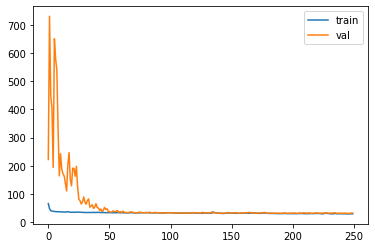

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 13)                52        
_________________________________________________________________
dense (Dense)                (None, 36)                504       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 36)                0         
_________________________________________________________________
dropout (Dropout)            (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                1406      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 38)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38)                0

In [ ]:
model_NN = Sequential()
model_NN.add(BatchNormalization())
model_NN.add(Dense(best_params ['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha= best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out1']))
# if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
model_NN.add(Dense(best_params ['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out2']))
if best_params ['layers'] == 3 :
    model_NN.add(Dense(best_params ['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
    model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
    model_NN.add(Dropout(best_params ['drop_out3']))
model_NN.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
# instantiate and compile model
opt = keras.optimizers.Adam(learning_rate=best_params [ 'learning_rate'])
model_NN.compile(loss=
                #  'mse',
              tf.keras.losses.Huber( delta=best_params[ 'delta']),
              # 'mse'
                  optimizer=opt)
fn = "gdrive/My Drive/Colab Notebooks/Stations/Training_NOX_Maildlake_OUT.ckpt" 
fnn = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer
callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_epochs),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model_NN.fit(x=X_traine, y= y_traine,
                  validation_data=(X_val, y_val),
                  batch_size=int(best_params['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()
model_NN.summary()

In [ ]:
model_NN.load_weights(fn)
precovid_model = 'gdrive/My Drive/Colab Notebooks/BuffaloViewpoint_NOX_OUT.h5'
model_NN.save(precovid_model )

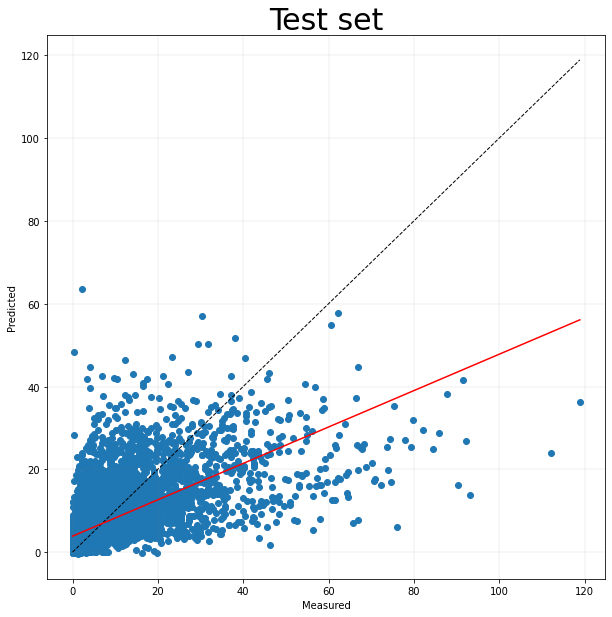

[0.43952772 3.84807339]
RMSE
[7.69714407]
R2
0.4048964047364466


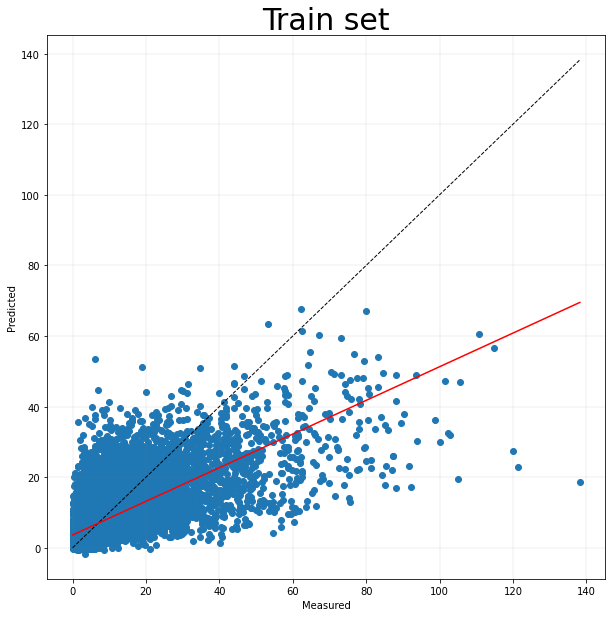

[0.47665543 3.63135732]
RMSE
[7.38284825]
R2
0.4989707268537388


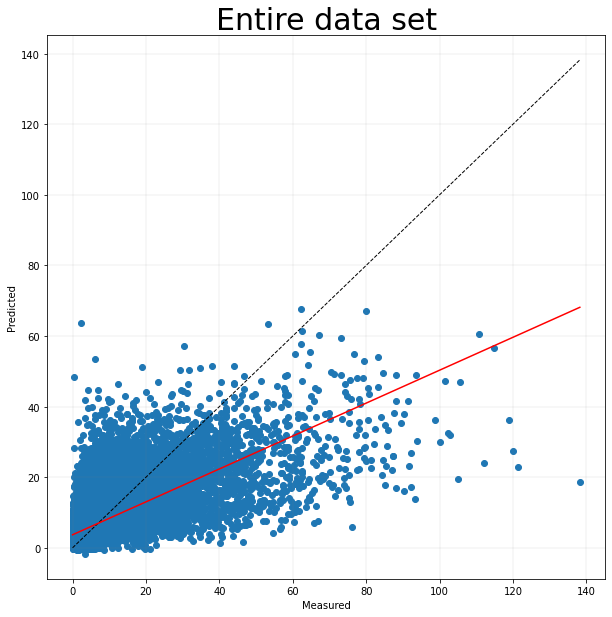

[0.46620632 3.69296138]
RMSE
[7.47852725]
R2
0.4724956214342304


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model_NN.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model_NN.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 13)                52        
_________________________________________________________________
dense (Dense)                (None, 36)                504       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 36)                0         
_________________________________________________________________
dropout (Dropout)            (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                1406      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 38)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 38)                0

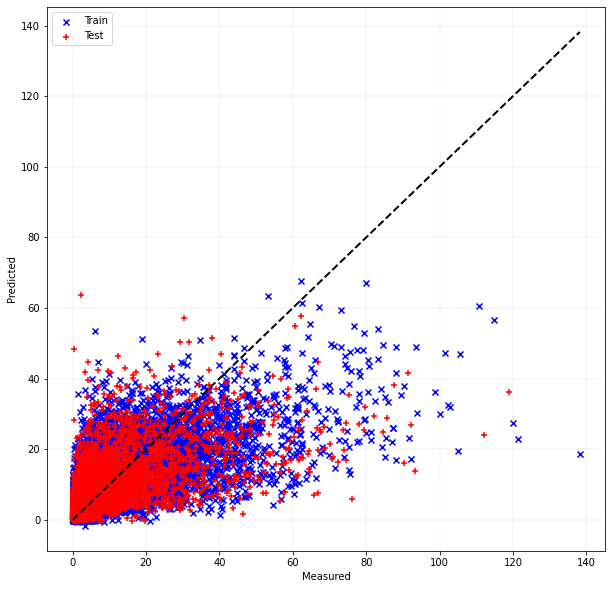

In [ ]:
model_NN = load_model(precovid_model )
model_NN.summary()
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.5], [0,0.5], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

In [ ]:
# df3= df3.copy()
df4 = df1_w_c.copy()
df4['pred'] = model_NN.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

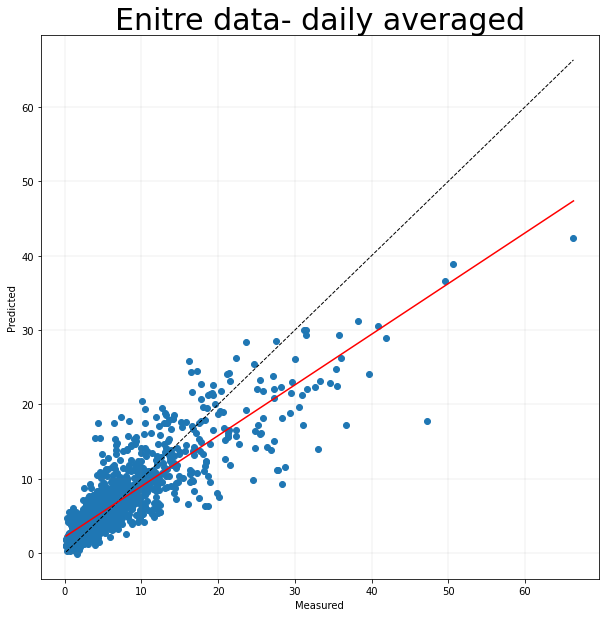

[0.68109817 2.19571448]
RMSE
[3.55012137]
R2
0.7466136570688005


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10[aa]).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


In [ ]:
df4.columns

Index(['NOX (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

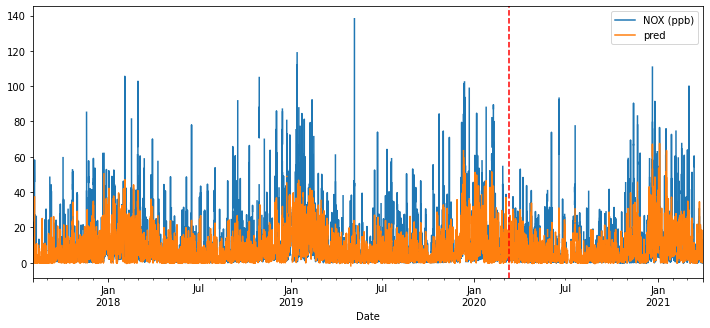

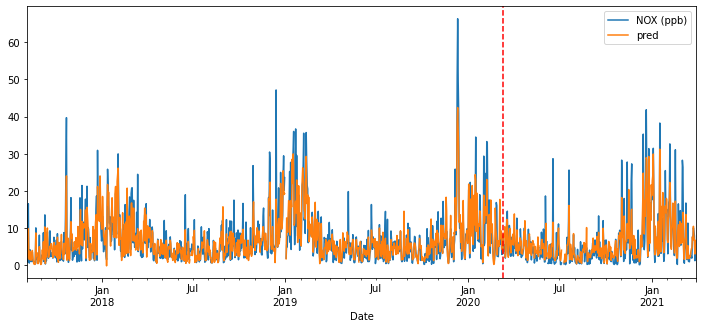

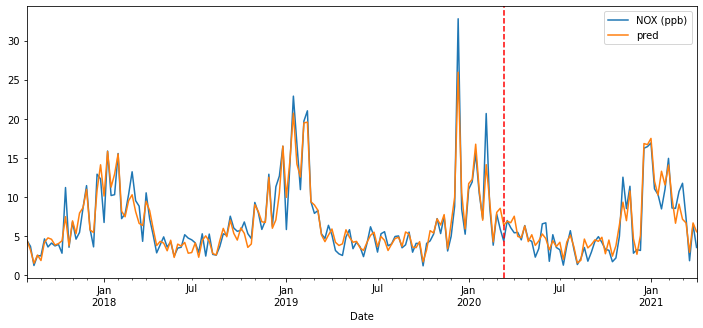

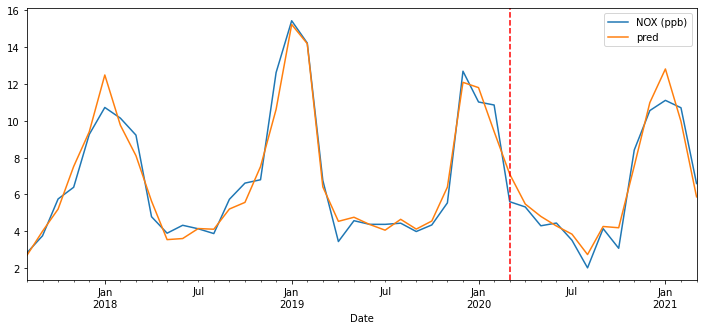

In [ ]:
df4[aa].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4[aa].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
preds1 = model_NN.predict(X_train) 
y_real1 = y_train.reshape(-1,1)
y_pred1 = preds1.reshape(-1,1)
print(rmse(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))

[7.38284825]
0.4989707268537388


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

[7.69714407]
0.4048964047364466


In [ ]:
df4.columns

Index(['NOX (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model_NN.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model_NN.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = [ 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend']
test_col = [aa]


df1_w_c = df1_w[[aa, 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ aa]
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2[aa] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 [aa] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/BuffaloViewpoint_NOX_NN_OR_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/BuffaloViewpoint_NOX_NN_OR_Test.csv')

[7.38284825]
0.4989707268537388
[7.69714407]
0.4048964047364466


In [ ]:
df4.columns

Index(['NOX (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)

In [ ]:
# df4_D = df4_h.resample('D').mean()
# df4_M = df4_h.resample('M').mean()
# df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Mannix_SO2_hourly_pred.csv')
# df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Mannix_SO_monthly_pred.csv')

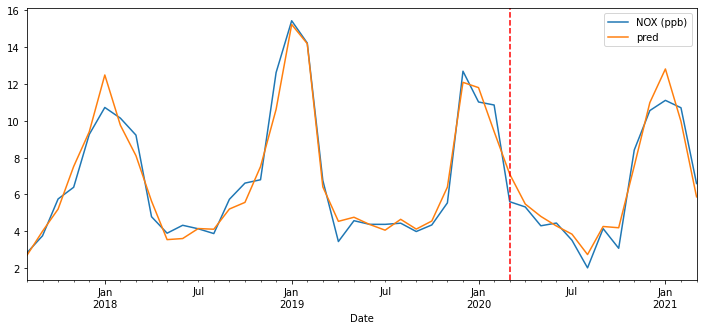

In [ ]:
df4_h[aa].resample('M').mean().plot(figsize = (12,5), legend = True)
df4_h['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
df4

NOX (ppb)  RH %  ...  Day-year      trend
Date                                  ...                     
2017-08-04 07:00:00       11.2  92.0  ...       216  17.588229
2017-08-04 08:00:00       22.9  87.0  ...       216  17.588342
2017-08-04 09:00:00       15.9  81.0  ...       216  17.588456
2017-08-04 10:00:00       16.4  78.0  ...       216  17.588570
2017-08-04 11:00:00       14.8  75.0  ...       216  17.588684
...                        ...   ...  ...       ...        ...
2021-03-31 19:00:00        9.4  51.5  ...        90  21.245332
2021-03-31 20:00:00        1.6  53.6  ...        90  21.245446
2021-03-31 21:00:00        0.0  45.6  ...        90  21.245560
2021-03-31 22:00:00        0.0  43.5  ...        90  21.245674
2021-03-31 23:00:00        0.0  46.1  ...        90  21.245788

[29639 rows x 14 columns]

In [ ]:
df4_h

NOX (ppb)  RH %  T ( C)  ...  Day-year      trend       pred
Date                                          ...                                
2017-08-04 07:00:00       11.2  92.0    15.5  ...       216  17.588229   4.451302
2017-08-04 08:00:00       22.9  87.0    16.4  ...       216  17.588342  10.204370
2017-08-04 09:00:00       15.9  81.0    17.1  ...       216  17.588456  10.747374
2017-08-04 10:00:00       16.4  78.0    17.5  ...       216  17.588570   8.424481
2017-08-04 11:00:00       14.8  75.0    18.3  ...       216  17.588684  10.370214
...                        ...   ...     ...  ...       ...        ...        ...
2021-03-31 19:00:00        9.4  51.5     5.6  ...        90  21.245332   5.456183
2021-03-31 20:00:00        1.6  53.6     4.2  ...        90  21.245446   0.850604
2021-03-31 21:00:00        0.0  45.6     5.3  ...        90  21.245560   0.094036
2021-03-31 22:00:00        0.0  43.5     5.4  ...        90  21.245674   0.214069
2021-03-31 23:00:00        0.0  46.1     4.6  ...        90  21.245788   0.963986

[29639 rows x 15 columns]

In [ ]:
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model_NN.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
113
11.132562637329102
2021-01-17 10:00:00
108
10.298262596130371
2021-01-17 11:00:00
104
10.584552764892578
2021-01-17 12:00:00
103
10.537163734436035
2021-01-17 14:00:00
111
10.247818946838379
2021-01-17 15:00:00
112
11.319769859313965
2021-01-17 16:00:00
113
12.00935173034668
2021-01-17 17:00:00
112
12.374770164489746
2021-01-17 18:00:00
111
12.98945426940918
2021-01-17 19:00:00
110
13.81789779663086
2021-01-17 20:00:00
110
14.132201194763184
2021-01-17 21:00:00
111
14.559267044067383
2021-01-17 22:00:00
113
13.764291763305664
2021-01-17 23:00:00
114
14.416891098022461
2021-01-18 01:00:00
113
10.422650337219238
2021-01-18 02:00:00
112
10.633790016174316
2021-01-18 03:00:00
112
10.708212852478027
2021-01-18 04:00:00
110
10.336529731750488
2021-01-18 05:00:00
111
10.434290885925293
2021-01-18 06:00:00
111
11.092817306518555
2021-01-18 07:00:00
110
10.753201484680176
2021-01-18 08:00:00
113
10.994481086730957
2021-01-18 09:00:00
113
10

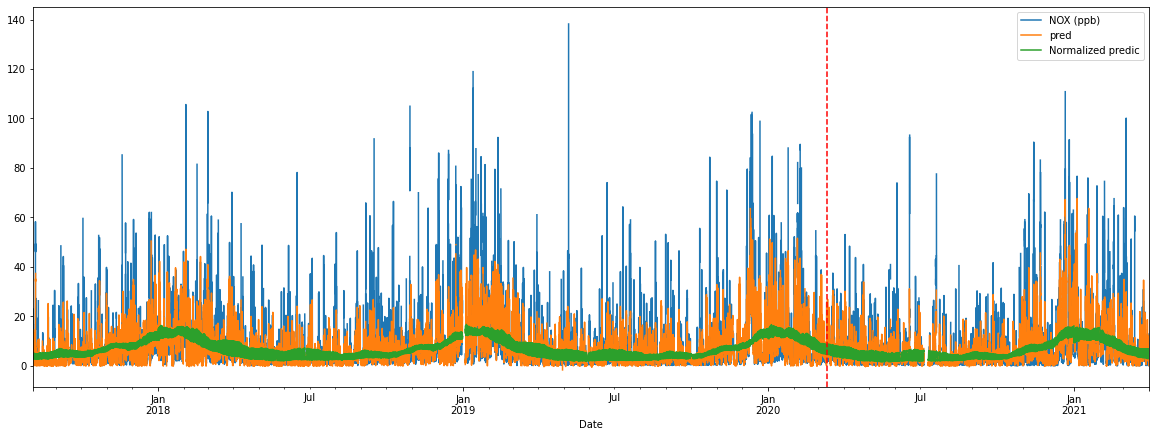

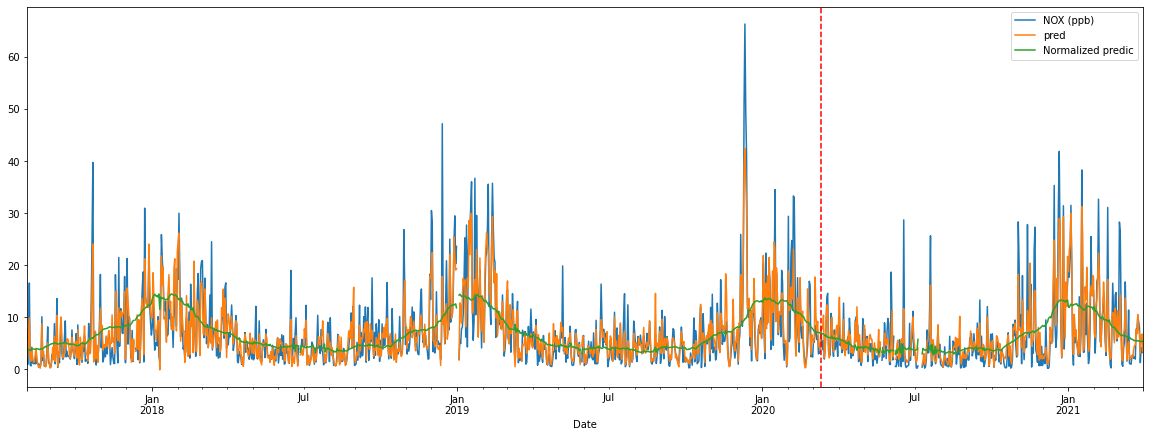

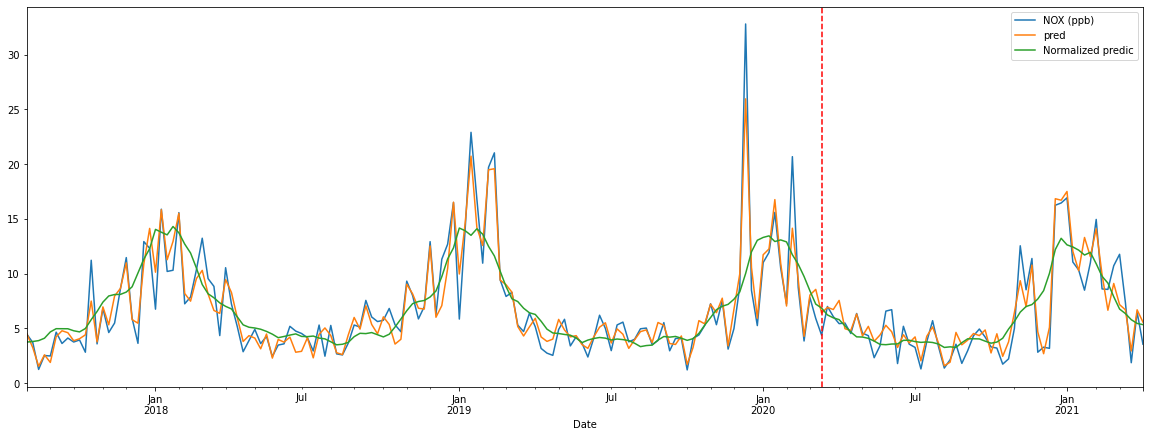

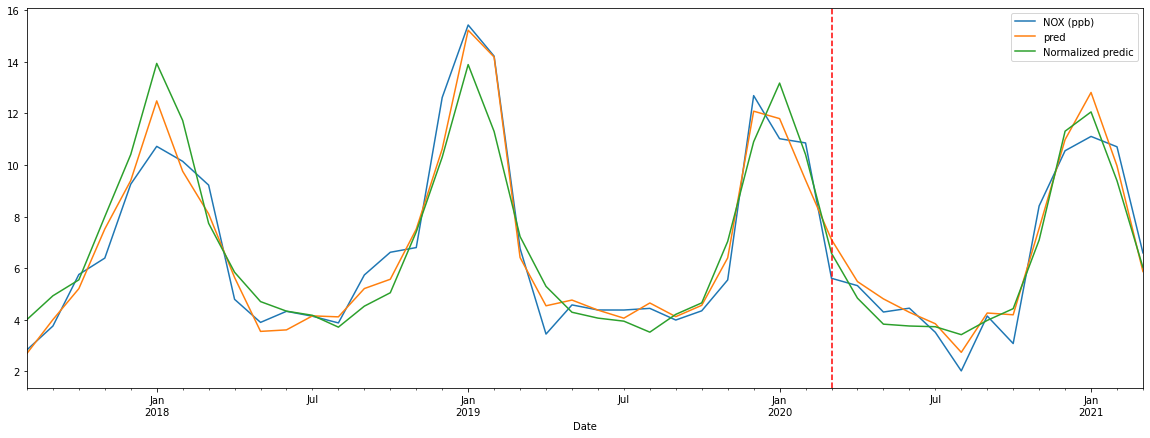

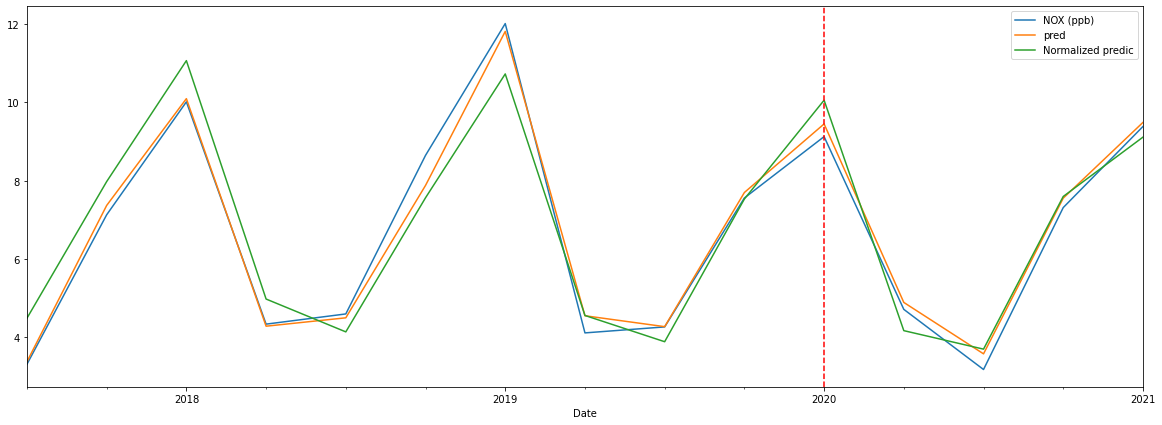

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_BuffaloViewpoint_OT_NOX_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_BuffaloViewpoint_OT_NOX_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_BuffaloViewpoint_OT_NOX__Monthly_normalized_pred.csv')


for i in ['H','D','W','M','Q']:
    df4_h[aa].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

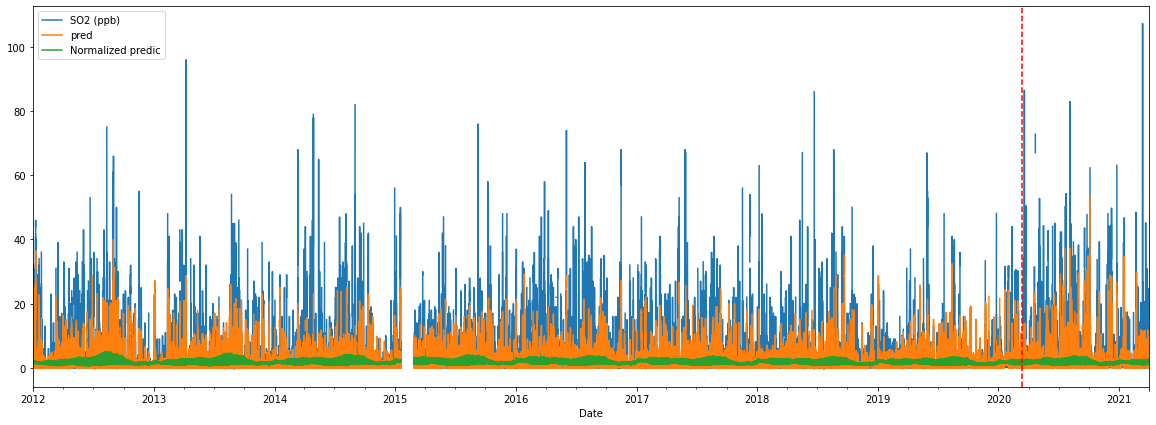

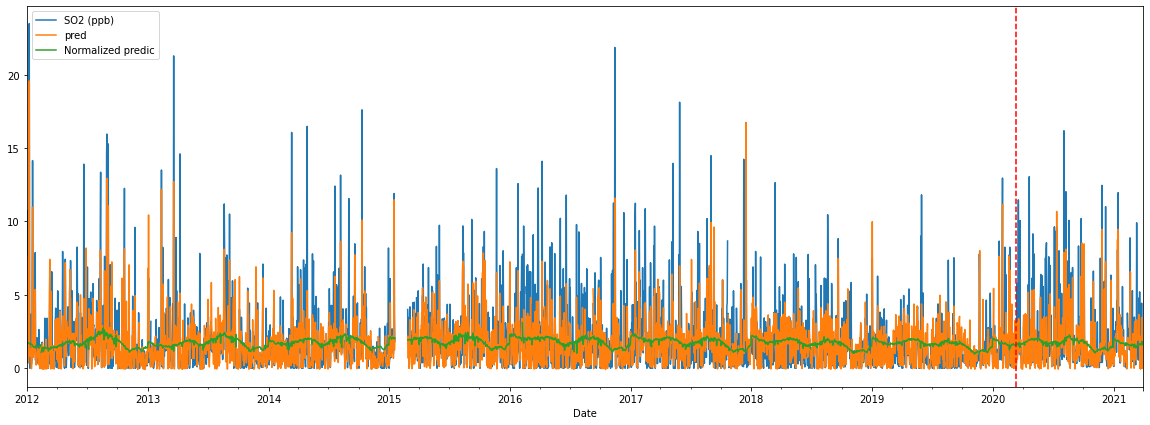

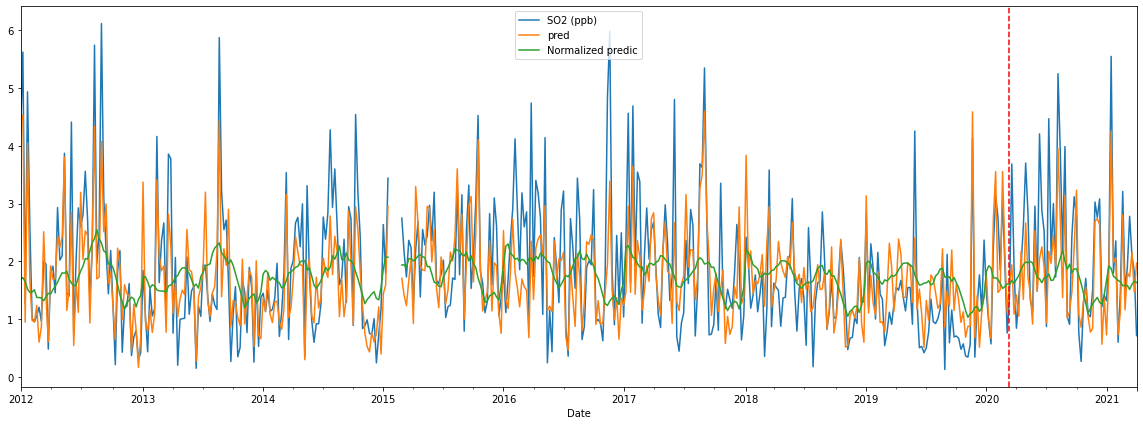

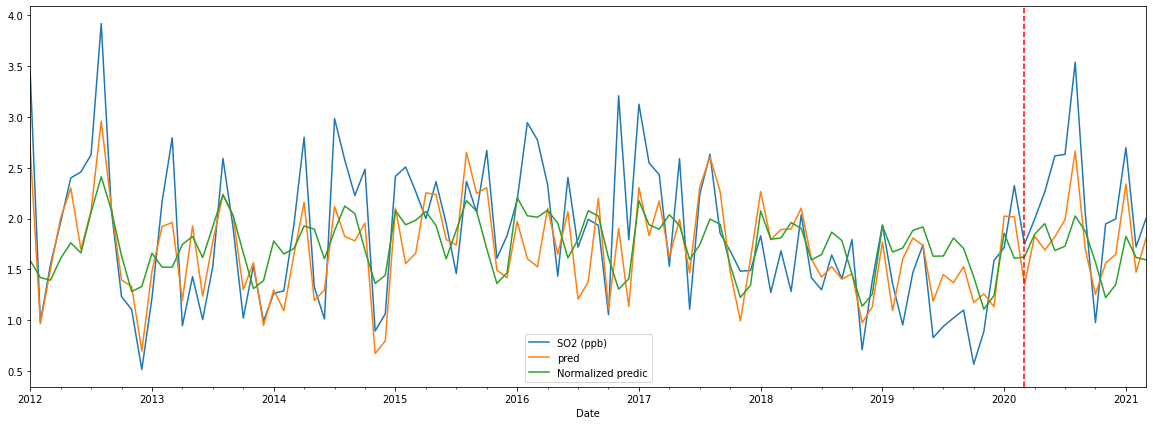

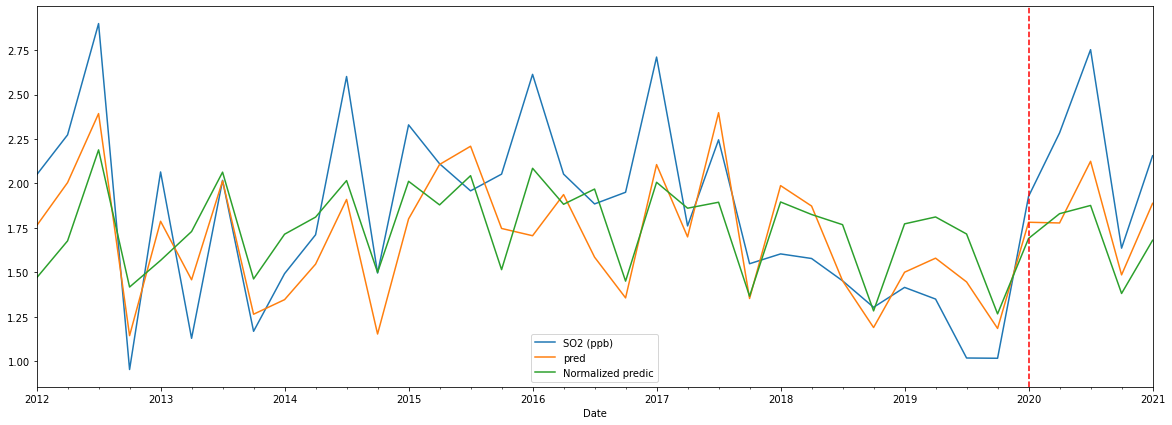

In [ ]:
for i in ['H','D','W','M','Q']:
    df4_h['SO2 (ppb)'].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

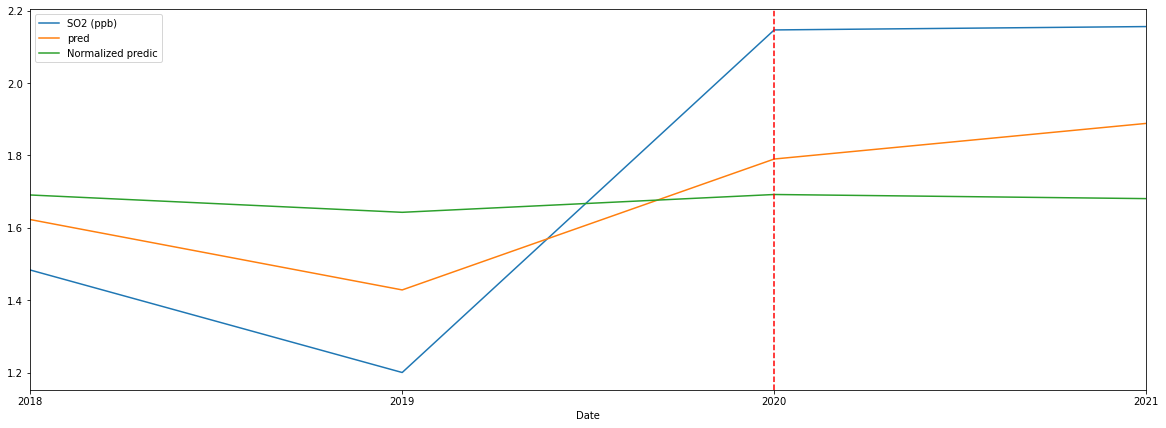

In [ ]:
df4_h['SO2 (ppb)'].resample('Y').mean().loc['2018':].plot(legend= True)
df4_h['pred'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
df4_h['Normalized predic'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
####

In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, concatenate


df2_w_c = df2_w[[ 'CO(ppm)', 'T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ', 'Wind Dir (deg)',
       'Wind speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend',
       'driving', 'transit','walking',
]]
df2_w_c.columns

Index(['CO(ppm)', 'T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ', 'Wind Dir (deg)',
       'Wind speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'driving', 'transit',
       'walking'],
      dtype='object')

In [ ]:
df2_w_c[['driving', 'transit', 'walking']]=df2_w_c[['driving', 'transit', 'walking']]/100

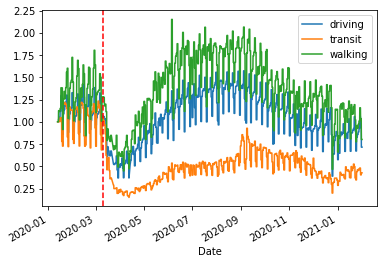

In [ ]:
df2_w_c[['driving', 'transit', 'walking']].plot()
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
a = df2_w_c[['driving', 'transit', 'walking']].loc[:'2020-03-11'].copy()
a.mean()

driving    1.124019
transit    1.025378
walking    1.331329
dtype: float64

In [ ]:
Y_a = df2_w_c['CO(ppm)']
Y_a = np.array(Y_a).reshape(-1,1)
X_a = np.array(df2_w_c[['T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ',
       'Wind Dir (deg)', 'Wind speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',]])
X_b =  np.array(df2_w_c[ ['driving', 'transit', 'walking']])


X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, Y_a, test_size=0.2, random_state=42)

X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state = 42)
X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split(X_train_b, y_train_b, test_size=0.25, random_state = 42)

maximum_epochs = 450
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
print(np.shape(X_a),np.shape(X_b),np.shape(Y_a))

(9075, 12) (9075, 3) (9075, 1)


In [ ]:
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [ ]:
print(np.shape(X_train_a),np.shape(X_train_b))
print(np.shape(X_traine_a),np.shape(X_traine_b))
print(np.shape(X_val_a),np.shape(X_val_b))

(7260, 12) (7260, 3)
(5445, 12) (5445, 3)
(1815, 12) (1815, 3)


In [ ]:
best_params

{'batchsize': 2500.0,
 'drop_out1': 0.0057066589968766,
 'drop_out2': 0.008999530008727568,
 'drop_out3': 0.0006990849923195847,
 'layers': 3,
 'num_dense_nodes1': 35,
 'num_dense_nodes2': 24,
 'num_dense_nodes3': 28}

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
dense (Dense)                (None, 35)                455       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 35)                0         
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35)                140       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                864       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24)                0

In [ ]:
class Objective2(object):
    def __init__(self, X_a,X_b, Y, max_epochs, learn_rate_epochs,
                  ):
        self.X_train_a, self.X_test_a, self.y_train_a, self.y_test_a = train_test_split(X_a, Y, test_size=0.001, random_state=42)
        self.X_train_b, self.X_test_b, self.y_train_b, self.y_test_b = train_test_split(X_b, Y, test_size=0.001, random_state=42)

        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.model_fixed = load_model(precovid_model)
        for i in range(0,len(self.model_fixed.layers)):
            self.model_fixed.layers[i].trainable = False

    def __call__(self, trial):        
        dict_params = { 
                        'last_layer' :trial.suggest_int('last_layer',0,1),
                        'two_layer' :trial.suggest_int('two_layer',0,1),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 1,3),
                       'num_dense_nodes2': trial.suggest_int('num_dense_nodes2', 1,8),
                        # 'layers': trial.suggest_int('layers', 2,3),
                       'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,2000,100)),
                      #  'drop_out1': trial.suggest_float('drop_out1',0.0, 0.2),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                       'layer_back' :-(trial.suggest_int('layer_back', 1,2)),
                       }  
        # print(dict_params[ 'layer_back'])
        l1 = Input(shape=(3,))
        l1_2 = BatchNormalization()(l1)
        l2 = Dense(dict_params['num_dense_nodes1'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l1_2 )
        l2_2 = LeakyReLU(alpha=dict_params['alpha'])(l2)
        if dict_params['two_layer'] ==1 :
             l2_3 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l2_2 )
             merged = concatenate([self.model_fixed.layers[dict_params[ 'layer_back']].output,l2_3])
        else :
             merged = concatenate([self.model_fixed.layers[dict_params[ 'layer_back']].output,l2_2])
        merged2 = BatchNormalization()(merged)

        if dict_params['last_layer'] == 0:
            l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2)
            l5_3 = LeakyReLU(alpha=dict_params['alpha'])(l5_2)

        if dict_params['last_layer'] == 1:
            l5 = Dense(dict_params['num_dense_nodes2'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2) 
            l5_1 = LeakyReLU(alpha=dict_params['alpha'])(l5)
            l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l5_1)
            l5_3 = LeakyReLU(alpha=dict_params['alpha'])(l5_2)          
        
        model = Model(inputs=[self.model_fixed.input,l1], outputs=l5_3)

        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params['learning_rate'])
        model.compile(loss='mse',optimizer=opt)
        fn2 = "gdrive/My Drive/Colab Notebooks/Stations/East_ED_NOX_apple" +str(trial.number) + ".ckpt" 
        fnn2 = os.path.dirname(fn2)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn2, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 5
        kf = KFold(n_splits=n_f )
        acc = 0 

        for train_index, test_index in kf.split( self.X_train_a):   
                X_tr_a, X_tes_a =  self.X_train_a[train_index],  self.X_train_a[test_index]
                X_tr_b, X_tes_b =  self.X_train_b[train_index],  self.X_train_b[test_index]
                y_tr, y_tes =   self.y_train_a[train_index],   self.y_train_a[test_index]    
                # fit the model
                X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split( X_tr_a,  y_tr, test_size=0.12, random_state = 42)
                X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split( X_tr_b,  y_tr, test_size=0.12, random_state = 42)


                model.fit(x=[X_traine_a,X_traine_b], y= y_traine_a,
                  validation_data=([X_val_a,X_val_b], y_val_a),
                  batch_size=dict_params['batchsize'],
                  epochs=self.max_epochs,
                  shuffle=True, verbose=0,
                  callbacks=callbacks_list)
                
                model.load_weights(fn2)
                preds = model.predict([X_tes_a,X_tes_b]) 
                # print(np.shape(y_tes),np.shape( preds))
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 
        print(acc)
        return acc    

In [ ]:
objective2 = Objective2(X_a, X_b ,Y_a ,maximum_epochs, learning_rate_epochs)
study2 = optuna.create_study(direction=optimizer_direction, study_name='east_edm_CO_p2',storage='sqlite:///east_edm_CO_p2.db',load_if_exists=True)
study2.optimize(objective2, n_trials=300)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/CO_Edmonton_east_Hyperparams_Stations.csv')
study2.best_trial

[I 2021-04-18 06:37:44,453] A new study created in RDB with name: east_edm_CO_p2
[I 2021-04-18 06:40:22,320] Trial 0 finished with value: 0.0047897337392556185 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 3, 'batchsize': 1300.0, 'learning_rate': 0.08684742896034063, 'alpha': 0.47486431649895633, 'layer_back': 1}. Best is trial 0 with value: 0.0047897337392556185.


0.0047897337392556185


[I 2021-04-18 06:46:17,741] Trial 1 finished with value: 0.0037995427144006185 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 200.0, 'learning_rate': 0.026645640165432177, 'alpha': 0.2464432589680267, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.0037995427144006185


[I 2021-04-18 06:49:06,028] Trial 2 finished with value: 0.004990117939045318 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1200.0, 'learning_rate': 0.04246052710121524, 'alpha': 0.14036321226448864, 'layer_back': 1}. Best is trial 1 with value: 0.0037995427144006185.


0.004990117939045318


[I 2021-04-18 06:51:38,749] Trial 3 finished with value: 0.004435081840883617 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.08019349670014007, 'alpha': 0.801795208357617, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004435081840883617


[I 2021-04-18 06:55:41,325] Trial 4 finished with value: 0.004397006773851628 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 1, 'num_dense_nodes2': 6, 'batchsize': 400.0, 'learning_rate': 0.0922021495386216, 'alpha': 0.8714206976745991, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004397006773851628


[I 2021-04-18 06:58:39,803] Trial 5 finished with value: 0.004472224808431502 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 1, 'num_dense_nodes2': 1, 'batchsize': 900.0, 'learning_rate': 0.054032085513753485, 'alpha': 0.36356263089297863, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004472224808431502


[I 2021-04-18 07:02:19,968] Trial 6 finished with value: 0.004032658481373844 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 500.0, 'learning_rate': 0.0034103388646587085, 'alpha': 0.8298599523597091, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004032658481373844


[I 2021-04-18 07:04:57,913] Trial 7 finished with value: 0.004412881161440907 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1400.0, 'learning_rate': 0.024560851403922612, 'alpha': 0.8657303593335849, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004412881161440907


[I 2021-04-18 07:07:33,362] Trial 8 finished with value: 0.003962766007027832 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1600.0, 'learning_rate': 0.0387484515918348, 'alpha': 0.5935061142207385, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.003962766007027832


[I 2021-04-18 07:10:45,080] Trial 9 finished with value: 0.004464174746733434 and parameters: {'last_layer': 0, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 700.0, 'learning_rate': 0.07156430296741274, 'alpha': 0.6837562117270939, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.004464174746733434


[I 2021-04-18 07:20:10,927] Trial 10 finished with value: 0.0047593223285363065 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 6, 'batchsize': 100.0, 'learning_rate': 0.006393597974084786, 'alpha': 0.09784392044369339, 'layer_back': 1}. Best is trial 1 with value: 0.0037995427144006185.


0.0047593223285363065


[I 2021-04-18 07:22:40,517] Trial 11 finished with value: 0.0038559859859853907 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 4, 'batchsize': 1900.0, 'learning_rate': 0.029641261114048665, 'alpha': 0.3455488342982123, 'layer_back': 2}. Best is trial 1 with value: 0.0037995427144006185.


0.0038559859859853907


[I 2021-04-18 07:25:12,650] Trial 12 finished with value: 0.0037802072596256108 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 2000.0, 'learning_rate': 0.021318248161901757, 'alpha': 0.27421676161966496, 'layer_back': 2}. Best is trial 12 with value: 0.0037802072596256108.


0.0037802072596256108


[I 2021-04-18 07:34:39,100] Trial 13 finished with value: 0.003838305552608133 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 6, 'batchsize': 100.0, 'learning_rate': 0.01618259930894679, 'alpha': 0.2237909588852787, 'layer_back': 2}. Best is trial 12 with value: 0.0037802072596256108.


0.003838305552608133


[I 2021-04-18 07:37:13,171] Trial 14 finished with value: 0.0037727934709037452 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 5, 'batchsize': 1600.0, 'learning_rate': 0.05463156741271952, 'alpha': 0.023432883667647286, 'layer_back': 2}. Best is trial 14 with value: 0.0037727934709037452.


0.0037727934709037452


[I 2021-04-18 07:39:46,194] Trial 15 finished with value: 0.004717376020706112 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 1700.0, 'learning_rate': 0.057774493852787316, 'alpha': 0.013468966566860257, 'layer_back': 1}. Best is trial 14 with value: 0.0037727934709037452.


0.004717376020706112


[I 2021-04-18 07:42:17,141] Trial 16 finished with value: 0.003891606393255513 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 4, 'batchsize': 1600.0, 'learning_rate': 0.06483099406582218, 'alpha': 0.048701457819810334, 'layer_back': 2}. Best is trial 14 with value: 0.0037727934709037452.


0.003891606393255513


[I 2021-04-18 07:44:50,068] Trial 17 finished with value: 0.003705317767648349 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 2000.0, 'learning_rate': 0.042981081545902175, 'alpha': 0.17151924705879706, 'layer_back': 2}. Best is trial 17 with value: 0.003705317767648349.


0.003705317767648349


[I 2021-04-18 07:47:22,992] Trial 18 finished with value: 0.003652074267837431 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043120594200074316, 'alpha': 0.15356515832757994, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003652074267837431


[I 2021-04-18 07:49:56,748] Trial 19 finished with value: 0.004855364207538971 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 7, 'batchsize': 2000.0, 'learning_rate': 0.03948108446690251, 'alpha': 0.1731767923827432, 'layer_back': 1}. Best is trial 18 with value: 0.003652074267837431.


0.004855364207538971


[I 2021-04-18 07:52:46,818] Trial 20 finished with value: 0.0036661417054684184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.045596783441498825, 'alpha': 0.46487314129271234, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0036661417054684184


[I 2021-04-18 07:55:47,695] Trial 21 finished with value: 0.003772814522212643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.04376219782019011, 'alpha': 0.495381372771252, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003772814522212643


[I 2021-04-18 07:58:33,572] Trial 22 finished with value: 0.0037000579251144777 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 1100.0, 'learning_rate': 0.03235269324681574, 'alpha': 0.40139723428257024, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037000579251144777


[I 2021-04-18 08:01:16,242] Trial 23 finished with value: 0.0037201394146138406 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.0335829823820747, 'alpha': 0.561915944028579, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037201394146138406


[I 2021-04-18 08:04:15,280] Trial 24 finished with value: 0.0037030372913319023 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.01268992251227287, 'alpha': 0.3938061003278891, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0037030372913319023


[I 2021-04-18 08:07:38,080] Trial 25 finished with value: 0.003918046517575021 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.04897050026188292, 'alpha': 0.6753399284001078, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.003918046517575021


[I 2021-04-18 08:10:15,782] Trial 26 finished with value: 0.0038008433695184197 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.06522149016140043, 'alpha': 0.42163733919230845, 'layer_back': 2}. Best is trial 18 with value: 0.003652074267837431.


0.0038008433695184197


[I 2021-04-18 08:13:05,072] Trial 27 finished with value: 0.0036111388857046787 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.03298839085103375, 'alpha': 0.3150552800923347, 'layer_back': 2}. Best is trial 27 with value: 0.0036111388857046787.


0.0036111388857046787


[I 2021-04-18 08:16:08,056] Trial 28 finished with value: 0.003597443791057043 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.04885615301916258, 'alpha': 0.29269304131799223, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.003597443791057043


[I 2021-04-18 08:19:12,662] Trial 29 finished with value: 0.0046809329310916956 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 800.0, 'learning_rate': 0.05995146156015323, 'alpha': 0.30446311601011683, 'layer_back': 1}. Best is trial 28 with value: 0.003597443791057043.


0.0046809329310916956


[I 2021-04-18 08:21:45,673] Trial 30 finished with value: 0.004425357656736 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.0759352310855712, 'alpha': 0.21269011576180244, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.004425357656736


[I 2021-04-18 08:24:37,569] Trial 31 finished with value: 0.0036547160400316313 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.049811468875869416, 'alpha': 0.510738346787994, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0036547160400316313


[I 2021-04-18 08:27:52,823] Trial 32 finished with value: 0.0037521087301732345 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.049503947678833926, 'alpha': 0.31735277463906175, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0037521087301732345


[I 2021-04-18 08:30:36,307] Trial 33 finished with value: 0.0037683419447327986 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1200.0, 'learning_rate': 0.03290226547777786, 'alpha': 0.5286190169685012, 'layer_back': 2}. Best is trial 28 with value: 0.003597443791057043.


0.0037683419447327986


[I 2021-04-18 08:33:27,324] Trial 34 finished with value: 0.003597358919918322 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.036818841872599595, 'alpha': 0.12570513379804832, 'layer_back': 2}. Best is trial 34 with value: 0.003597358919918322.


0.003597358919918322


[I 2021-04-18 08:37:26,272] Trial 35 finished with value: 0.003661138596451478 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 400.0, 'learning_rate': 0.03671876888449163, 'alpha': 0.08397801305678194, 'layer_back': 2}. Best is trial 34 with value: 0.003597358919918322.


0.003661138596451478


[I 2021-04-18 08:40:27,101] Trial 36 finished with value: 0.00359203525150731 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.02437141103670945, 'alpha': 0.12749087727003588, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.00359203525150731


[I 2021-04-18 08:43:26,782] Trial 37 finished with value: 0.0036756314419160397 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 800.0, 'learning_rate': 0.018931547569790746, 'alpha': 0.2516407308762111, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036756314419160397


[I 2021-04-18 08:48:02,902] Trial 38 finished with value: 0.0036545643870157882 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 300.0, 'learning_rate': 0.02603462599572944, 'alpha': 0.14443719906111, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036545643870157882


[I 2021-04-18 08:51:18,641] Trial 39 finished with value: 0.004398658143913983 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.02412418866542985, 'alpha': 0.09261962247455818, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.004398658143913983


[I 2021-04-18 08:54:03,235] Trial 40 finished with value: 0.00366032853048446 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 1200.0, 'learning_rate': 0.028075997597257207, 'alpha': 0.20259126107498393, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.00366032853048446


[I 2021-04-18 08:57:05,594] Trial 41 finished with value: 0.003674477629447893 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 800.0, 'learning_rate': 0.03773808729024592, 'alpha': 0.13311556018712936, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.003674477629447893


[I 2021-04-18 08:59:59,665] Trial 42 finished with value: 0.0036705861586692643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1000.0, 'learning_rate': 0.014115297813961467, 'alpha': 0.28611068588955, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036705861586692643


[I 2021-04-18 09:03:13,164] Trial 43 finished with value: 0.0036713389468197555 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.04560695580139573, 'alpha': 0.3437569312771207, 'layer_back': 2}. Best is trial 36 with value: 0.00359203525150731.


0.0036713389468197555


[I 2021-04-18 09:06:35,814] Trial 44 finished with value: 0.0035783836209078556 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.009070889461271204, 'alpha': 0.13887248911600195, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035783836209078556


[I 2021-04-18 09:09:57,729] Trial 45 finished with value: 0.003673148714195081 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 600.0, 'learning_rate': 0.009253166791610645, 'alpha': 0.2451607156425593, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003673148714195081


[I 2021-04-18 09:14:01,355] Trial 46 finished with value: 0.004344271113195811 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 1, 'batchsize': 400.0, 'learning_rate': 0.001551960808838477, 'alpha': 0.10569886410992255, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004344271113195811


[I 2021-04-18 09:17:39,621] Trial 47 finished with value: 0.0037050254039840223 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 500.0, 'learning_rate': 0.021082510170567333, 'alpha': 0.0668001215058446, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037050254039840223


[I 2021-04-18 09:20:38,142] Trial 48 finished with value: 0.0036692619534721047 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.007585468046031375, 'alpha': 0.2061475495973082, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036692619534721047


[I 2021-04-18 09:23:49,174] Trial 49 finished with value: 0.004457879746783033 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.03483835282389286, 'alpha': 0.018344801879960376, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004457879746783033


[I 2021-04-18 09:26:34,895] Trial 50 finished with value: 0.0035807581552902102 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1100.0, 'learning_rate': 0.03005652498704963, 'alpha': 0.11696356203274105, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035807581552902102


[I 2021-04-18 09:29:21,811] Trial 51 finished with value: 0.0036236342891670654 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.09983893132352316, 'alpha': 0.11957067974916365, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036236342891670654


[I 2021-04-18 09:32:02,631] Trial 52 finished with value: 0.0036302435793163423 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1200.0, 'learning_rate': 0.02754867420830222, 'alpha': 0.05647608660638647, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036302435793163423


[I 2021-04-18 09:34:44,744] Trial 53 finished with value: 0.003627053068071688 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04005811816852655, 'alpha': 0.17080808493297003, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003627053068071688


[I 2021-04-18 09:37:45,884] Trial 54 finished with value: 0.0036920503523068266 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 900.0, 'learning_rate': 0.017979831294330218, 'alpha': 0.2570823577331828, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036920503523068266


[I 2021-04-18 09:40:36,692] Trial 55 finished with value: 0.003612690295076574 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1000.0, 'learning_rate': 0.029552755284063505, 'alpha': 0.18039366495456732, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003612690295076574


[I 2021-04-18 09:43:40,566] Trial 56 finished with value: 0.004012695527376038 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 800.0, 'learning_rate': 0.022565925713046567, 'alpha': 0.03734236499524329, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.004012695527376038


[I 2021-04-18 09:47:16,794] Trial 57 finished with value: 0.003698018600704401 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 500.0, 'learning_rate': 0.05338960509962787, 'alpha': 0.35126328332328843, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003698018600704401


[I 2021-04-18 09:50:04,725] Trial 58 finished with value: 0.003619003598112455 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.011669376031158469, 'alpha': 0.2338658479883975, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003619003598112455


[I 2021-04-18 09:53:02,416] Trial 59 finished with value: 0.0036054917675212707 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.031117560438016202, 'alpha': 0.12690434404626497, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036054917675212707


[I 2021-04-18 09:56:06,738] Trial 60 finished with value: 0.003886966241395085 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 900.0, 'learning_rate': 0.003565187588275332, 'alpha': 0.12617304287730674, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003886966241395085


[I 2021-04-18 09:59:11,214] Trial 61 finished with value: 0.003618826532739045 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.03119470670070372, 'alpha': 0.06717581966642143, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003618826532739045


[I 2021-04-18 10:02:02,407] Trial 62 finished with value: 0.0037632189106060355 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1000.0, 'learning_rate': 0.04059941279624269, 'alpha': 0.16862336495408595, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037632189106060355


[I 2021-04-18 10:05:19,179] Trial 63 finished with value: 0.003794832132947586 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 4, 'batchsize': 700.0, 'learning_rate': 0.036734160746832493, 'alpha': 0.01101319432018788, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003794832132947586


[I 2021-04-18 10:08:20,419] Trial 64 finished with value: 0.003758988776972788 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 900.0, 'learning_rate': 0.029855268948976825, 'alpha': 0.4386976096021802, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003758988776972788


[I 2021-04-18 10:11:42,186] Trial 65 finished with value: 0.0035876522982958357 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.024552341120126213, 'alpha': 0.20134794489311997, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035876522982958357


[I 2021-04-18 10:15:04,777] Trial 66 finished with value: 0.0036155628523736184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.016447401975405944, 'alpha': 0.14664495950811754, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036155628523736184


[I 2021-04-18 10:18:40,103] Trial 67 finished with value: 0.0037361543406670638 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 500.0, 'learning_rate': 0.02482879535124779, 'alpha': 0.18911509071408622, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037361543406670638


[I 2021-04-18 10:23:14,465] Trial 68 finished with value: 0.004737399253546576 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 300.0, 'learning_rate': 0.045839207163365064, 'alpha': 0.11572139542681772, 'layer_back': 1}. Best is trial 44 with value: 0.0035783836209078556.


0.004737399253546576


[I 2021-04-18 10:26:17,521] Trial 69 finished with value: 0.0035844609162026856 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.021759460493932996, 'alpha': 0.08938362393003896, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0035844609162026856


[I 2021-04-18 10:29:40,721] Trial 70 finished with value: 0.003647474821726536 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.020584896822209618, 'alpha': 0.08688700495047245, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003647474821726536


[I 2021-04-18 10:32:40,862] Trial 71 finished with value: 0.0036240235360119194 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.026636013810065286, 'alpha': 0.04460753701062606, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036240235360119194


[I 2021-04-18 10:35:57,924] Trial 72 finished with value: 0.003678997217185063 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 700.0, 'learning_rate': 0.02380154186526011, 'alpha': 0.15140441320203327, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003678997217185063


[I 2021-04-18 10:39:01,596] Trial 73 finished with value: 0.003659856745198834 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.015277005770461548, 'alpha': 0.2178303763286192, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003659856745198834


[I 2021-04-18 10:42:16,571] Trial 74 finished with value: 0.0036399907750272265 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 700.0, 'learning_rate': 0.011408912622706538, 'alpha': 0.10321869296892679, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036399907750272265


[I 2021-04-18 10:45:19,285] Trial 75 finished with value: 0.0037281104148537535 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 6, 'batchsize': 900.0, 'learning_rate': 0.035323452421033984, 'alpha': 0.2846749869393032, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0037281104148537535


[I 2021-04-18 10:48:06,701] Trial 76 finished with value: 0.00361764726075232 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.018785055346852722, 'alpha': 0.08247223174383175, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.00361764726075232


[I 2021-04-18 10:51:06,829] Trial 77 finished with value: 0.0036951690746862827 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 800.0, 'learning_rate': 0.030036815811613576, 'alpha': 0.15370233117847767, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036951690746862827


[I 2021-04-18 10:53:48,194] Trial 78 finished with value: 0.003591197553125669 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.021596734858180668, 'alpha': 0.19705749126102656, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003591197553125669


[I 2021-04-18 10:56:31,899] Trial 79 finished with value: 0.0036875580454355968 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.004996727049177942, 'alpha': 0.19630957319700593, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.0036875580454355968


[I 2021-04-18 10:59:15,173] Trial 80 finished with value: 0.003672630637413495 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.009725768873874269, 'alpha': 0.23904793658858925, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003672630637413495


[I 2021-04-18 11:02:33,338] Trial 81 finished with value: 0.003608277041588192 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 600.0, 'learning_rate': 0.021177055101469718, 'alpha': 0.13273475258504627, 'layer_back': 2}. Best is trial 44 with value: 0.0035783836209078556.


0.003608277041588192


[I 2021-04-18 11:05:23,493] Trial 82 finished with value: 0.0035357134156083006 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.03251063586877488, 'alpha': 0.16601335847048496, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035357134156083006


[I 2021-04-18 11:08:10,650] Trial 83 finished with value: 0.0035800395220561315 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.027507014638668944, 'alpha': 0.26952999743969175, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035800395220561315


[I 2021-04-18 11:10:53,530] Trial 84 finished with value: 0.003641285084880817 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.024468913257262442, 'alpha': 0.26941083528596615, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003641285084880817


[I 2021-04-18 11:13:33,120] Trial 85 finished with value: 0.003613639352689042 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.027506935493900007, 'alpha': 0.16554636650660334, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003613639352689042


[I 2021-04-18 11:16:13,848] Trial 86 finished with value: 0.0035454609704569555 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.034075180962035656, 'alpha': 0.19205737194876213, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035454609704569555


[I 2021-04-18 11:18:54,396] Trial 87 finished with value: 0.0036217548071173097 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.018105506543334197, 'alpha': 0.2172761829124636, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0036217548071173097


[I 2021-04-18 11:21:32,202] Trial 88 finished with value: 0.0036196131119005967 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.013644839043071016, 'alpha': 0.18554443324755185, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0036196131119005967


[I 2021-04-18 11:24:10,911] Trial 89 finished with value: 0.003572944589854708 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02174303974596932, 'alpha': 0.06885902281378707, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003572944589854708


[I 2021-04-18 11:26:50,606] Trial 90 finished with value: 0.003906346283951516 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1500.0, 'learning_rate': 0.03323653174387488, 'alpha': 0.03163285232628042, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003906346283951516


[I 2021-04-18 11:29:31,353] Trial 91 finished with value: 0.003578888868218704 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.022580602914511808, 'alpha': 0.06713185538847133, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003578888868218704


[I 2021-04-18 11:32:08,581] Trial 92 finished with value: 0.0035789263141083713 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.021256605621501615, 'alpha': 0.06634621015162126, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035789263141083713


[I 2021-04-18 11:34:49,916] Trial 93 finished with value: 0.003544189206426239 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02748340529865124, 'alpha': 0.07868991239964429, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.003544189206426239


[I 2021-04-18 11:37:33,179] Trial 94 finished with value: 0.0035499476797488643 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02892486834145689, 'alpha': 0.07221984870581319, 'layer_back': 2}. Best is trial 82 with value: 0.0035357134156083006.


0.0035499476797488643


[I 2021-04-18 11:40:14,572] Trial 95 finished with value: 0.0035273632980514285 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.027834554447690413, 'alpha': 0.06732285000688103, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035273632980514285


[I 2021-04-18 11:42:52,853] Trial 96 finished with value: 0.0036086771352365947 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.02637530840203316, 'alpha': 0.05953489610216768, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0036086771352365947


[I 2021-04-18 11:45:38,794] Trial 97 finished with value: 0.0035684357428775186 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.027517728652115728, 'alpha': 0.07593898838347986, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035684357428775186


[I 2021-04-18 11:48:20,507] Trial 98 finished with value: 0.003583852513729412 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03367874759681739, 'alpha': 0.06942447131849512, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003583852513729412


[I 2021-04-18 11:50:57,066] Trial 99 finished with value: 0.003541288425685317 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.041358766423868744, 'alpha': 0.021920382234198947, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003541288425685317


[I 2021-04-18 11:53:42,845] Trial 100 finished with value: 0.0036243488752047467 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04030568364072326, 'alpha': 0.02384229949250582, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0036243488752047467


[I 2021-04-18 11:56:21,539] Trial 101 finished with value: 0.003627937411450544 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.035398043970041676, 'alpha': 0.03950052041260174, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003627937411450544


[I 2021-04-18 11:59:00,418] Trial 102 finished with value: 0.003627126043875543 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03832592467033967, 'alpha': 0.10048283220351684, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003627126043875543


[I 2021-04-18 12:01:36,789] Trial 103 finished with value: 0.0035408315369076784 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.032256016881253326, 'alpha': 0.07030089565296588, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035408315369076784


[I 2021-04-18 12:04:17,971] Trial 104 finished with value: 0.003566082616285739 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04262395762710679, 'alpha': 0.01173160141920479, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.003566082616285739


[I 2021-04-18 12:06:58,238] Trial 105 finished with value: 0.0035737931205732376 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04227819138674002, 'alpha': 0.010660044984515019, 'layer_back': 2}. Best is trial 95 with value: 0.0035273632980514285.


0.0035737931205732376


[I 2021-04-18 12:09:32,119] Trial 106 finished with value: 0.0035184089995725617 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043629287038235834, 'alpha': 0.010426390915745402, 'layer_back': 2}. Best is trial 106 with value: 0.0035184089995725617.


0.0035184089995725617


[I 2021-04-18 12:12:07,413] Trial 107 finished with value: 0.0034912184906821125 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04304162747051637, 'alpha': 0.044280753511746956, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0034912184906821125


[I 2021-04-18 12:14:44,123] Trial 108 finished with value: 0.0036380100736029142 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046899784330746694, 'alpha': 0.011423731168029368, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036380100736029142


[I 2021-04-18 12:17:20,619] Trial 109 finished with value: 0.0035930917231830005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05312662202242775, 'alpha': 0.04766526633420203, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035930917231830005


[I 2021-04-18 12:19:56,882] Trial 110 finished with value: 0.0035019395412586403 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04297554301809757, 'alpha': 0.03108575464071467, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035019395412586403


[I 2021-04-18 12:22:26,683] Trial 111 finished with value: 0.0035799057324392095 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.042791521010711986, 'alpha': 0.033242351358857565, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035799057324392095


[I 2021-04-18 12:25:01,093] Trial 112 finished with value: 0.003567586631908924 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04188075691123601, 'alpha': 0.012902457195305648, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003567586631908924


[I 2021-04-18 12:27:37,137] Trial 113 finished with value: 0.003552786707766206 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04705313553365665, 'alpha': 0.024024393886675065, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003552786707766206


[I 2021-04-18 12:30:14,683] Trial 114 finished with value: 0.0035491374611036066 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.04792414670441766, 'alpha': 0.04942912887788908, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035491374611036066


[I 2021-04-18 12:32:47,942] Trial 115 finished with value: 0.003934744163417141 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.05138779832449931, 'alpha': 0.7678284116404237, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003934744163417141


[I 2021-04-18 12:35:21,813] Trial 116 finished with value: 0.0035480745063304685 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04672929967596791, 'alpha': 0.0543681486748597, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035480745063304685


[I 2021-04-18 12:37:57,950] Trial 117 finished with value: 0.003645209428448006 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.058597540974892046, 'alpha': 0.054075814336391005, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003645209428448006


[I 2021-04-18 12:40:31,646] Trial 118 finished with value: 0.003635834268763575 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.04497558570260886, 'alpha': 0.10395749038880057, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003635834268763575


[I 2021-04-18 12:43:09,338] Trial 119 finished with value: 0.0036447334704852665 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1800.0, 'learning_rate': 0.04781462434994531, 'alpha': 0.04268750205527756, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036447334704852665


[I 2021-04-18 12:45:44,270] Trial 120 finished with value: 0.003567690380984065 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.037831602089136926, 'alpha': 0.0894939850401166, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003567690380984065


[I 2021-04-18 12:48:19,955] Trial 121 finished with value: 0.0036418865284299482 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.049910163797960434, 'alpha': 0.02265761100617698, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036418865284299482


[I 2021-04-18 12:50:50,152] Trial 122 finished with value: 0.003626350371093418 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.04409374352769631, 'alpha': 0.04839758470877351, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003626350371093418


[I 2021-04-18 12:53:25,935] Trial 123 finished with value: 0.004068899031879057 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 2, 'batchsize': 1900.0, 'learning_rate': 0.04692551724599392, 'alpha': 0.027164865650236767, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.004068899031879057


[I 2021-04-18 12:56:09,582] Trial 124 finished with value: 0.003549524306460534 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.05601252997839943, 'alpha': 0.08216270418670965, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003549524306460534


[I 2021-04-18 12:58:52,986] Trial 125 finished with value: 0.0036022166677025626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.051026693295636215, 'alpha': 0.08169432284004574, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036022166677025626


[I 2021-04-18 13:01:25,923] Trial 126 finished with value: 0.0036323884269265395 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.05755736475611723, 'alpha': 0.10764012747900042, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036323884269265395


[I 2021-04-18 13:04:06,681] Trial 127 finished with value: 0.0035868803510106743 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.06484074739859898, 'alpha': 0.04916233098402338, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035868803510106743


[I 2021-04-18 13:06:48,784] Trial 128 finished with value: 0.003632038891645508 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.05481967090549042, 'alpha': 0.09493718561374137, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003632038891645508


[I 2021-04-18 13:09:24,704] Trial 129 finished with value: 0.0036332687347207073 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.06164699827462552, 'alpha': 0.11368639196612304, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036332687347207073


[I 2021-04-18 13:12:02,225] Trial 130 finished with value: 0.0036107090038871685 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.031913432524153476, 'alpha': 0.07944764608488178, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036107090038871685


[I 2021-04-18 13:14:37,997] Trial 131 finished with value: 0.003543857849946714 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04047866711207972, 'alpha': 0.03334890991576665, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003543857849946714


[I 2021-04-18 13:17:10,956] Trial 132 finished with value: 0.003614544482168527 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03927975006627224, 'alpha': 0.05750478466882326, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003614544482168527


[I 2021-04-18 13:19:52,496] Trial 133 finished with value: 0.0036289459230039846 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03602600147397279, 'alpha': 0.03879102885756539, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036289459230039846


[I 2021-04-18 13:22:21,926] Trial 134 finished with value: 0.004397730627210862 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04121745337090514, 'alpha': 0.07727507999023213, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.004397730627210862


[I 2021-04-18 13:25:09,682] Trial 135 finished with value: 0.0035954891884910044 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.05591938878661566, 'alpha': 0.011489115255243473, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035954891884910044


[I 2021-04-18 13:27:46,099] Trial 136 finished with value: 0.003632190940638184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.04473961188420494, 'alpha': 0.05883472932516892, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003632190940638184


[I 2021-04-18 13:30:22,676] Trial 137 finished with value: 0.004797824764292689 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03394020855741806, 'alpha': 0.6177230050734727, 'layer_back': 1}. Best is trial 107 with value: 0.0034912184906821125.


0.004797824764292689


[I 2021-04-18 13:32:54,827] Trial 138 finished with value: 0.0035575625191086686 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03925631108791122, 'alpha': 0.02976577533102045, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035575625191086686


[I 2021-04-18 13:35:35,526] Trial 139 finished with value: 0.0037383972180743746 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1400.0, 'learning_rate': 0.02925391477758371, 'alpha': 0.13393207397187767, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0037383972180743746


[I 2021-04-18 13:38:16,882] Trial 140 finished with value: 0.003617621733455551 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03195637257591547, 'alpha': 0.0947751465706642, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003617621733455551


[I 2021-04-18 13:40:50,663] Trial 141 finished with value: 0.003579242154278799 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.0485447382823182, 'alpha': 0.01176858180870248, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003579242154278799


[I 2021-04-18 13:43:25,476] Trial 142 finished with value: 0.0035750086655864273 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.046567743860348884, 'alpha': 0.026818371099279946, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035750086655864273


[I 2021-04-18 13:46:00,498] Trial 143 finished with value: 0.003623829402881311 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03742158374219033, 'alpha': 0.04975293319513799, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003623829402881311


[I 2021-04-18 13:48:38,218] Trial 144 finished with value: 0.0036066806414085484 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.05148602571649974, 'alpha': 0.010300864640383572, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036066806414085484


[I 2021-04-18 13:51:09,839] Trial 145 finished with value: 0.003610979298586066 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.043772802510158214, 'alpha': 0.07001141819525372, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003610979298586066


[I 2021-04-18 13:53:44,355] Trial 146 finished with value: 0.0035619962671982527 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04082403791540483, 'alpha': 0.035248606443724864, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035619962671982527


[I 2021-04-18 13:56:26,877] Trial 147 finished with value: 0.003548864702878114 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04862893209367515, 'alpha': 0.11504554485639235, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003548864702878114


[I 2021-04-18 13:59:07,487] Trial 148 finished with value: 0.0036127803252306075 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.034866037784612974, 'alpha': 0.15803031484071783, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036127803252306075


[I 2021-04-18 14:01:52,630] Trial 149 finished with value: 0.0035717142472204513 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04905384303207223, 'alpha': 0.11415311920269179, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035717142472204513


[I 2021-04-18 14:04:32,812] Trial 150 finished with value: 0.0035749882689068164 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04526973875676865, 'alpha': 0.14572957071712894, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035749882689068164


[I 2021-04-18 14:07:16,399] Trial 151 finished with value: 0.0035993304069324022 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.052491361045237814, 'alpha': 0.08397349335013253, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035993304069324022


[I 2021-04-18 14:09:58,621] Trial 152 finished with value: 0.0035685056911281127 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04837346606791395, 'alpha': 0.06310254703879091, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035685056911281127


[I 2021-04-18 14:12:29,525] Trial 153 finished with value: 0.003629879513305761 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0438214208862195, 'alpha': 0.10403865238259322, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003629879513305761


[I 2021-04-18 14:15:14,227] Trial 154 finished with value: 0.0036221795403482207 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.03029487512047642, 'alpha': 0.04348614544060133, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036221795403482207


[I 2021-04-18 14:17:57,080] Trial 155 finished with value: 0.0035922583407074988 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.03843837268200991, 'alpha': 0.08433177217864488, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035922583407074988


[I 2021-04-18 14:20:36,152] Trial 156 finished with value: 0.003578072413719791 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.046367859672450995, 'alpha': 0.12254720867272155, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003578072413719791


[I 2021-04-18 14:23:15,649] Trial 157 finished with value: 0.0038583845758324883 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0871450624590979, 'alpha': 0.056755344230540905, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0038583845758324883


[I 2021-04-18 14:25:52,255] Trial 158 finished with value: 0.003580582397543033 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.041182684797758676, 'alpha': 0.031335914276621774, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003580582397543033


[I 2021-04-18 14:28:31,244] Trial 159 finished with value: 0.003571554999049949 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.050511120203456654, 'alpha': 0.011355553310716315, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003571554999049949


[I 2021-04-18 14:31:10,768] Trial 160 finished with value: 0.0035740442082979025 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1300.0, 'learning_rate': 0.054629022232272034, 'alpha': 0.09769506994297086, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035740442082979025


[I 2021-04-18 14:33:46,785] Trial 161 finished with value: 0.0035316717327896836 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03947842688021926, 'alpha': 0.02587334876105694, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035316717327896836


[I 2021-04-18 14:36:22,973] Trial 162 finished with value: 0.003583261784611461 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.0426931007941171, 'alpha': 0.06941424492182441, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003583261784611461


[I 2021-04-18 14:38:56,920] Trial 163 finished with value: 0.0035638605296477717 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03698103592588202, 'alpha': 0.02604575458608599, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035638605296477717


[I 2021-04-18 14:41:34,556] Trial 164 finished with value: 0.0036057247992290833 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.033843190233136235, 'alpha': 0.054628128789041205, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036057247992290833


[I 2021-04-18 14:44:05,291] Trial 165 finished with value: 0.0036577139832949667 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.02862847367159879, 'alpha': 0.041190982009615476, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0036577139832949667


[I 2021-04-18 14:46:34,411] Trial 166 finished with value: 0.0035796291367728578 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1100.0, 'learning_rate': 0.03989602686737119, 'alpha': 0.07720076451956273, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0035796291367728578


[I 2021-04-18 14:48:58,970] Trial 167 finished with value: 0.003644684403214736 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.031894620734671836, 'alpha': 0.011244612673171901, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003644684403214736


[I 2021-04-18 14:51:15,955] Trial 168 finished with value: 0.003719212403160626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.061535654734255804, 'alpha': 0.04944139280228774, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003719212403160626


[I 2021-04-18 14:53:47,133] Trial 169 finished with value: 0.003569251268532048 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04736210238892834, 'alpha': 0.0924816749854882, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.003569251268532048


[I 2021-04-18 14:56:10,412] Trial 170 finished with value: 0.0037302293516410364 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 4, 'batchsize': 1800.0, 'learning_rate': 0.042194509368665326, 'alpha': 0.026662365080105572, 'layer_back': 2}. Best is trial 107 with value: 0.0034912184906821125.


0.0037302293516410364


[I 2021-04-18 14:58:32,142] Trial 171 finished with value: 0.003412203995094343 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03982358083063548, 'alpha': 0.02422528261030567, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003412203995094343


[I 2021-04-18 15:00:56,204] Trial 172 finished with value: 0.003615212962045835 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 2000.0, 'learning_rate': 0.035269743884066396, 'alpha': 0.06515792117672077, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003615212962045835


[I 2021-04-18 15:03:19,432] Trial 173 finished with value: 0.0035065927685166407 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04495904398462532, 'alpha': 0.03706846553808014, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035065927685166407


[I 2021-04-18 15:05:42,080] Trial 174 finished with value: 0.0036824767911479953 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.044788002773288774, 'alpha': 0.04279176989414291, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036824767911479953


[I 2021-04-18 15:07:59,615] Trial 175 finished with value: 0.0036000802274304988 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03973925069572923, 'alpha': 0.06946943028331976, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036000802274304988


[I 2021-04-18 15:10:20,601] Trial 176 finished with value: 0.0035611477676499243 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03702719792209683, 'alpha': 0.1178740272614942, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035611477676499243


[I 2021-04-18 15:12:44,718] Trial 177 finished with value: 0.0035568862168302313 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.04446509916080676, 'alpha': 0.035536762139547574, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035568862168302313


[I 2021-04-18 15:15:03,641] Trial 178 finished with value: 0.0035634161691522025 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.02555669877180687, 'alpha': 0.01426667868106541, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035634161691522025


[I 2021-04-18 15:17:27,644] Trial 179 finished with value: 0.0035478477954239184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.041044999411233324, 'alpha': 0.05809175905373737, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035478477954239184


[I 2021-04-18 15:19:49,604] Trial 180 finished with value: 0.003577680895181763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04266781899508782, 'alpha': 0.057332493065063835, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003577680895181763


[I 2021-04-18 15:22:18,574] Trial 181 finished with value: 0.0037241810267514214 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1200.0, 'learning_rate': 0.04124794281390582, 'alpha': 0.08344018331911048, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0037241810267514214


[I 2021-04-18 15:24:42,413] Trial 182 finished with value: 0.003574937953275326 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1300.0, 'learning_rate': 0.03909174129413975, 'alpha': 0.04955591990925821, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003574937953275326


[I 2021-04-18 15:27:09,745] Trial 183 finished with value: 0.0035062207386055725 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.032919202764146074, 'alpha': 0.10296721914045874, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035062207386055725


[I 2021-04-18 15:29:33,614] Trial 184 finished with value: 0.003607310672142692 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03299384364237505, 'alpha': 0.13543758486151475, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003607310672142692


[I 2021-04-18 15:31:56,820] Trial 185 finished with value: 0.0035645622965729045 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1400.0, 'learning_rate': 0.036200243037322145, 'alpha': 0.10015962959305305, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035645622965729045


[I 2021-04-18 15:34:23,869] Trial 186 finished with value: 0.0035128649499357135 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04591334979902456, 'alpha': 0.01300643385682445, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035128649499357135


[I 2021-04-18 15:36:50,059] Trial 187 finished with value: 0.003512579959993758 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.045967118012657425, 'alpha': 0.02955287318190126, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003512579959993758


[I 2021-04-18 15:39:17,519] Trial 188 finished with value: 0.003601852298015445 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04515211154273283, 'alpha': 0.02414511899844717, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003601852298015445


[I 2021-04-18 15:41:44,658] Trial 189 finished with value: 0.003551257039072739 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.043685650639080496, 'alpha': 0.011272541261604586, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003551257039072739


[I 2021-04-18 15:44:08,778] Trial 190 finished with value: 0.0035124462407048578 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04088523362317096, 'alpha': 0.027965921768034883, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035124462407048578


[I 2021-04-18 15:46:32,527] Trial 191 finished with value: 0.0036034748711966606 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04059492734596064, 'alpha': 0.0316931464485652, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036034748711966606


[I 2021-04-18 15:48:52,857] Trial 192 finished with value: 0.0035462040161388982 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038480226797782575, 'alpha': 0.013080349410333715, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035462040161388982


[I 2021-04-18 15:51:15,074] Trial 193 finished with value: 0.003514729419201148 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038804046086792734, 'alpha': 0.01722318588576137, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003514729419201148


[I 2021-04-18 15:53:39,774] Trial 194 finished with value: 0.003530635344402702 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.038022625191625484, 'alpha': 0.010260560665283323, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003530635344402702


[I 2021-04-18 15:56:01,357] Trial 195 finished with value: 0.0036120263950969846 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.037603653740255726, 'alpha': 0.010350360726464305, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036120263950969846


[I 2021-04-18 15:58:21,259] Trial 196 finished with value: 0.0035517522803226497 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03532284563567649, 'alpha': 0.012252207673505294, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035517522803226497


[I 2021-04-18 16:00:42,685] Trial 197 finished with value: 0.0035774729128351572 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03851591509172416, 'alpha': 0.024592933498452187, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035774729128351572


[I 2021-04-18 16:03:10,397] Trial 198 finished with value: 0.0036300873338133174 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03161093718448926, 'alpha': 0.011231732922341914, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036300873338133174


[I 2021-04-18 16:05:32,864] Trial 199 finished with value: 0.003594899268962292 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03400517384369343, 'alpha': 0.010987625678645163, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003594899268962292


[I 2021-04-18 16:07:55,556] Trial 200 finished with value: 0.003507502110225467 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03903066389229184, 'alpha': 0.03436414346888904, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003507502110225467


[I 2021-04-18 16:10:20,454] Trial 201 finished with value: 0.0035410174116621788 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0385769119015159, 'alpha': 0.03980816279456982, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035410174116621788


[I 2021-04-18 16:12:45,074] Trial 202 finished with value: 0.003500324891873184 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.042028674607372564, 'alpha': 0.035300834875109204, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003500324891873184


[I 2021-04-18 16:15:09,269] Trial 203 finished with value: 0.0035591510309502424 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04246721082689016, 'alpha': 0.03438254597895686, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035591510309502424


[I 2021-04-18 16:17:27,832] Trial 204 finished with value: 0.0035809591968109468 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03985309920583796, 'alpha': 0.03051312835022787, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035809591968109468


[I 2021-04-18 16:19:46,336] Trial 205 finished with value: 0.0035329556853449626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04302937726174949, 'alpha': 0.041497953561731075, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035329556853449626


[I 2021-04-18 16:22:06,046] Trial 206 finished with value: 0.0035995980573277605 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.042934896863311735, 'alpha': 0.039304783000125264, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035995980573277605


[I 2021-04-18 16:24:23,248] Trial 207 finished with value: 0.0036285669261463425 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04139101863112104, 'alpha': 0.04261236299648191, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036285669261463425


[I 2021-04-18 16:26:41,935] Trial 208 finished with value: 0.0035261087563540814 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.036838583737843406, 'alpha': 0.010914683684806366, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035261087563540814


[I 2021-04-18 16:28:57,689] Trial 209 finished with value: 0.0036736991070403626 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03673113267779741, 'alpha': 0.01411948992981912, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036736991070403626


[I 2021-04-18 16:31:14,218] Trial 210 finished with value: 0.003515510628468558 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0375123413072075, 'alpha': 0.026801330195408788, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003515510628468558


[I 2021-04-18 16:33:31,616] Trial 211 finished with value: 0.0036619003719104474 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03820623138649496, 'alpha': 0.010153124386418449, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036619003719104474


[I 2021-04-18 16:35:49,042] Trial 212 finished with value: 0.003602818230449912 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03959580915067272, 'alpha': 0.027499310441006536, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003602818230449912


[I 2021-04-18 16:38:08,801] Trial 213 finished with value: 0.003561704765028999 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03612046104363647, 'alpha': 0.044035880327440075, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003561704765028999


[I 2021-04-18 16:40:34,504] Trial 214 finished with value: 0.003592007871833824 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04370049977603333, 'alpha': 0.02920150412919489, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003592007871833824


[I 2021-04-18 16:42:55,087] Trial 215 finished with value: 0.00351462664371098 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0454740119732067, 'alpha': 0.010495159169710357, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00351462664371098


[I 2021-04-18 16:45:14,094] Trial 216 finished with value: 0.003586321240898763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04511581530325534, 'alpha': 0.05695382241574087, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003586321240898763


[I 2021-04-18 16:47:33,201] Trial 217 finished with value: 0.003550850628097577 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.046083333365054775, 'alpha': 0.010031182438903608, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003550850628097577


[I 2021-04-18 16:49:49,786] Trial 218 finished with value: 0.003574316805279423 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03776962442231015, 'alpha': 0.01087974243831754, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003574316805279423


[I 2021-04-18 16:52:07,807] Trial 219 finished with value: 0.003592576788837446 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04233420788943894, 'alpha': 0.044863914777429736, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003592576788837446


[I 2021-04-18 16:54:23,320] Trial 220 finished with value: 0.0035791068843512115 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03540338546231751, 'alpha': 0.06466753594289008, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035791068843512115


[I 2021-04-18 16:56:45,624] Trial 221 finished with value: 0.0035080006628703977 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04080187257128169, 'alpha': 0.02517051340915846, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035080006628703977


[I 2021-04-18 16:59:10,209] Trial 222 finished with value: 0.003534858951378764 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.039077436368116635, 'alpha': 0.02885009674334453, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003534858951378764


[I 2021-04-18 17:01:32,489] Trial 223 finished with value: 0.0035600183170591336 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04037327285207486, 'alpha': 0.010218259695493757, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035600183170591336


[I 2021-04-18 17:03:59,538] Trial 224 finished with value: 0.00357621728770453 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04402809698710642, 'alpha': 0.030946556782538822, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00357621728770453


[I 2021-04-18 17:06:22,498] Trial 225 finished with value: 0.004343070192053122 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04210862734231485, 'alpha': 0.8978062302113005, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.004343070192053122


[I 2021-04-18 17:08:42,266] Trial 226 finished with value: 0.00348994671120034 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.039712978464816924, 'alpha': 0.024397619671189186, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00348994671120034


[I 2021-04-18 17:10:59,711] Trial 227 finished with value: 0.0036327829172039363 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03987289215731558, 'alpha': 0.02250455655984187, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036327829172039363


[I 2021-04-18 17:13:17,616] Trial 228 finished with value: 0.0035863816006844592 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.045535379101367554, 'alpha': 0.01124262972279364, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035863816006844592


[I 2021-04-18 17:15:35,516] Trial 229 finished with value: 0.003724723343216221 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03704451183437776, 'alpha': 0.04707960454629442, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003724723343216221


[I 2021-04-18 17:17:56,682] Trial 230 finished with value: 0.003542300775869218 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043373142611203674, 'alpha': 0.027741305329135237, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003542300775869218


[I 2021-04-18 17:20:22,682] Trial 231 finished with value: 0.0034967214164662516 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.0413254155114597, 'alpha': 0.05450900763386603, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0034967214164662516


[I 2021-04-18 17:22:44,729] Trial 232 finished with value: 0.0034902379436158775 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04068791995954499, 'alpha': 0.010222168909410259, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0034902379436158775


[I 2021-04-18 17:25:06,837] Trial 233 finished with value: 0.0035696997278384553 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04139126758896274, 'alpha': 0.026033995263578885, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035696997278384553


[I 2021-04-18 17:27:27,456] Trial 234 finished with value: 0.0035369994402819037 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.03942127208063995, 'alpha': 0.04286247942073264, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035369994402819037


[I 2021-04-18 17:29:47,698] Trial 235 finished with value: 0.004392673197272246 and parameters: {'last_layer': 0, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04159869114156704, 'alpha': 0.02367062769838194, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.004392673197272246


[I 2021-04-18 17:32:05,575] Trial 236 finished with value: 0.003575454952037897 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04328736011313493, 'alpha': 0.05601924009082433, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003575454952037897


[I 2021-04-18 17:34:26,141] Trial 237 finished with value: 0.0035897550318074005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.038692258908575666, 'alpha': 0.012438389557101647, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035897550318074005


[I 2021-04-18 17:36:45,489] Trial 238 finished with value: 0.0035113323695952704 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04512252439416322, 'alpha': 0.03956753671308763, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035113323695952704


[I 2021-04-18 17:39:05,122] Trial 239 finished with value: 0.003584000428339544 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.047813674417420904, 'alpha': 0.010920917339477658, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003584000428339544


[I 2021-04-18 17:41:26,047] Trial 240 finished with value: 0.0035293567432161024 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04591099537879329, 'alpha': 0.04788686542870845, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035293567432161024


[I 2021-04-18 17:43:44,806] Trial 241 finished with value: 0.0035365143888050027 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0454319059745853, 'alpha': 0.04686285373530562, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035365143888050027


[I 2021-04-18 17:46:08,022] Trial 242 finished with value: 0.0035210658084785856 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.046339728963809036, 'alpha': 0.010471024026785167, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035210658084785856


[I 2021-04-18 17:48:29,934] Trial 243 finished with value: 0.003556893132441123 and parameters: {'last_layer': 1, 'two_layer': 1, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.045764190567635574, 'alpha': 0.011848043731819085, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003556893132441123


[I 2021-04-18 17:50:53,782] Trial 244 finished with value: 0.003512689556017564 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04972302364098935, 'alpha': 0.010679543273126932, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003512689556017564


[I 2021-04-18 17:53:13,307] Trial 245 finished with value: 0.0035453134197271506 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04959138720064781, 'alpha': 0.05462870622434733, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035453134197271506


[I 2021-04-18 17:55:33,896] Trial 246 finished with value: 0.0035509187170758008 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04681538132569639, 'alpha': 0.03530358983480915, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035509187170758008


[I 2021-04-18 17:57:53,468] Trial 247 finished with value: 0.0035945304744609613 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.0489170612101526, 'alpha': 0.012016072897793495, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035945304744609613


[I 2021-04-18 18:00:12,340] Trial 248 finished with value: 0.003594461041794751 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.044638671537672245, 'alpha': 0.0639759181815157, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003594461041794751


[I 2021-04-18 18:02:34,344] Trial 249 finished with value: 0.0045477205315565955 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.046710061525816006, 'alpha': 0.011139267598519425, 'layer_back': 1}. Best is trial 171 with value: 0.003412203995094343.


0.0045477205315565955


[I 2021-04-18 18:04:55,855] Trial 250 finished with value: 0.0035781031672798575 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.049944254157000614, 'alpha': 0.032012199626475495, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035781031672798575


[I 2021-04-18 18:07:13,728] Trial 251 finished with value: 0.0036355280457136927 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043756771131670855, 'alpha': 0.01035371316557724, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036355280457136927


[I 2021-04-18 18:09:34,549] Trial 252 finished with value: 0.003547550522620159 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04134146453588229, 'alpha': 0.04305486485387794, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003547550522620159


[I 2021-04-18 18:11:55,090] Trial 253 finished with value: 0.0035328942806100686 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04722011354069931, 'alpha': 0.05887719313144072, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035328942806100686


[I 2021-04-18 18:14:16,245] Trial 254 finished with value: 0.0035652527257973646 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04440826933940222, 'alpha': 0.025686391422111023, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035652527257973646


[I 2021-04-18 18:16:33,284] Trial 255 finished with value: 0.0036024245892215994 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.041749163700951185, 'alpha': 0.03872395194163038, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036024245892215994


[I 2021-04-18 18:18:57,458] Trial 256 finished with value: 0.0043164087416414365 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 1, 'batchsize': 1700.0, 'learning_rate': 0.04546093492413028, 'alpha': 0.010251060844410263, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0043164087416414365


[I 2021-04-18 18:21:15,604] Trial 257 finished with value: 0.003591252456109896 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04784028159113087, 'alpha': 0.39811980716193374, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003591252456109896


[I 2021-04-18 18:23:37,528] Trial 258 finished with value: 0.003746425212177314 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 5, 'batchsize': 1500.0, 'learning_rate': 0.04279841819460297, 'alpha': 0.07024407706968394, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003746425212177314


[I 2021-04-18 18:25:58,122] Trial 259 finished with value: 0.00361357732181617 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05159560529990878, 'alpha': 0.01020152753447857, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00361357732181617


[I 2021-04-18 18:28:18,035] Trial 260 finished with value: 0.0035362959446181372 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03677053865341993, 'alpha': 0.027761419825134706, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035362959446181372


[I 2021-04-18 18:30:36,058] Trial 261 finished with value: 0.0035777906284825637 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.040310822965333726, 'alpha': 0.049462864350921475, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035777906284825637


[I 2021-04-18 18:32:57,401] Trial 262 finished with value: 0.003570475495003743 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.044139009615794325, 'alpha': 0.027875323408408682, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003570475495003743


[I 2021-04-18 18:35:16,566] Trial 263 finished with value: 0.003522829834462358 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04198898881507155, 'alpha': 0.0580045705131251, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003522829834462358


[I 2021-04-18 18:37:34,064] Trial 264 finished with value: 0.0036007924735055267 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.041834497824705524, 'alpha': 0.06335278451503193, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036007924735055267


[I 2021-04-18 18:39:53,735] Trial 265 finished with value: 0.00348047469245996 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046222652876472946, 'alpha': 0.07368192148073911, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00348047469245996


[I 2021-04-18 18:42:12,703] Trial 266 finished with value: 0.003568839741377355 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04374559623977401, 'alpha': 0.08301680728880435, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003568839741377355


[I 2021-04-18 18:44:32,571] Trial 267 finished with value: 0.0036106532294807115 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04856506403341819, 'alpha': 0.059921462082078616, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036106532294807115


[I 2021-04-18 18:46:54,806] Trial 268 finished with value: 0.0035951168812917724 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04059449904679494, 'alpha': 0.07437962110547948, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035951168812917724


[I 2021-04-18 18:49:14,594] Trial 269 finished with value: 0.0038806843614589267 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 3, 'batchsize': 1800.0, 'learning_rate': 0.04228778414610149, 'alpha': 0.040595160927241594, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0038806843614589267


[I 2021-04-18 18:51:36,459] Trial 270 finished with value: 0.003508514168830134 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.045758882185338856, 'alpha': 0.01019736087977181, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003508514168830134


[I 2021-04-18 18:53:59,279] Trial 271 finished with value: 0.003553706935151663 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.046600657692945004, 'alpha': 0.010547895437206084, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003553706935151663


[I 2021-04-18 18:56:21,879] Trial 272 finished with value: 0.0035704764601707352 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.05043397257419762, 'alpha': 0.02650206841715339, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035704764601707352


[I 2021-04-18 18:58:44,313] Trial 273 finished with value: 0.003537743421816448 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04449406510721561, 'alpha': 0.02856531842383624, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003537743421816448


[I 2021-04-18 19:01:02,888] Trial 274 finished with value: 0.0035872021893232162 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04642553813259407, 'alpha': 0.04624146580754622, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035872021893232162


[I 2021-04-18 19:03:22,574] Trial 275 finished with value: 0.0035351187876377214 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04065895930001007, 'alpha': 0.023704805099300657, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035351187876377214


[I 2021-04-18 19:05:42,370] Trial 276 finished with value: 0.0035990310487486314 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04867882801126025, 'alpha': 0.04208190753853736, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035990310487486314


[I 2021-04-18 19:08:03,409] Trial 277 finished with value: 0.003558197358314823 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.043930643367720706, 'alpha': 0.013485130866568936, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003558197358314823


[I 2021-04-18 19:10:23,407] Trial 278 finished with value: 0.0035541437503373557 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04255502288658978, 'alpha': 0.011078767415770078, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035541437503373557


[I 2021-04-18 19:12:43,428] Trial 279 finished with value: 0.003620482810610077 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1900.0, 'learning_rate': 0.03854967804178356, 'alpha': 0.37579417109166946, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003620482810610077


[I 2021-04-18 19:15:07,358] Trial 280 finished with value: 0.0035629539820494893 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04529240827319963, 'alpha': 0.05895876175064578, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035629539820494893


[I 2021-04-18 19:17:32,667] Trial 281 finished with value: 0.003644936734817557 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 7, 'batchsize': 1700.0, 'learning_rate': 0.04743933522020218, 'alpha': 0.011229961339488842, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003644936734817557


[I 2021-04-18 19:19:51,695] Trial 282 finished with value: 0.003577890922236646 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03634827316862001, 'alpha': 0.03637036111412592, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003577890922236646


[I 2021-04-18 19:22:13,904] Trial 283 finished with value: 0.003560479118491405 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04043227290610643, 'alpha': 0.07344504222599207, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003560479118491405


[I 2021-04-18 19:24:43,874] Trial 284 finished with value: 0.0035526678878083024 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.043180320438559995, 'alpha': 0.028436472804207344, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035526678878083024


[I 2021-04-18 19:27:15,410] Trial 285 finished with value: 0.0036757146176305084 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.052504334338170644, 'alpha': 0.05281089842190032, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036757146176305084


[I 2021-04-18 19:29:40,892] Trial 286 finished with value: 0.0036856981873373005 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.03862798538332946, 'alpha': 0.5490775185484104, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036856981873373005


[I 2021-04-18 19:32:06,610] Trial 287 finished with value: 0.0035415069069481627 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04570583980728427, 'alpha': 0.02605355475095221, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035415069069481627


[I 2021-04-18 19:34:30,143] Trial 288 finished with value: 0.003740877917673408 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04190653811523166, 'alpha': 0.46924555745458885, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003740877917673408


[I 2021-04-18 19:36:56,774] Trial 289 finished with value: 0.0035775193145280654 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.03972018828716774, 'alpha': 0.011138839350697517, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035775193145280654


[I 2021-04-18 19:39:20,105] Trial 290 finished with value: 0.003692058852467178 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 1, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.034729016394914915, 'alpha': 0.010556512764700383, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003692058852467178


[I 2021-04-18 19:41:44,804] Trial 291 finished with value: 0.0035475416741049203 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.049954519743499, 'alpha': 0.04441757839268543, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035475416741049203


[I 2021-04-18 19:44:12,704] Trial 292 finished with value: 0.0036324451159960094 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04430093709294941, 'alpha': 0.010225541250839246, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036324451159960094


[I 2021-04-18 19:46:36,967] Trial 293 finished with value: 0.003543922988091805 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 2, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.03731682739206002, 'alpha': 0.061919915711980765, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003543922988091805


[I 2021-04-18 19:49:00,478] Trial 294 finished with value: 0.0035996695672530763 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.0481214227016496, 'alpha': 0.036533457449013804, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035996695672530763


[I 2021-04-18 19:51:28,050] Trial 295 finished with value: 0.00356117903500133 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1500.0, 'learning_rate': 0.04215437992851492, 'alpha': 0.08474282494115523, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.00356117903500133


[I 2021-04-18 19:53:54,926] Trial 296 finished with value: 0.0038629873621217974 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1800.0, 'learning_rate': 0.04644820116770873, 'alpha': 0.7525864522902106, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0038629873621217974


[I 2021-04-18 19:56:15,892] Trial 297 finished with value: 0.0036611473822737274 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1700.0, 'learning_rate': 0.04033473569538667, 'alpha': 0.050588041390175045, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0036611473822737274


[I 2021-04-18 19:58:46,046] Trial 298 finished with value: 0.0035034252484806043 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04324237328637403, 'alpha': 0.026717366574066884, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.0035034252484806043


[I 2021-04-18 20:01:13,035] Trial 299 finished with value: 0.003613095679125333 and parameters: {'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'batchsize': 1600.0, 'learning_rate': 0.04407463674017211, 'alpha': 0.06965159817543136, 'layer_back': 2}. Best is trial 171 with value: 0.003412203995094343.


0.003613095679125333


FrozenTrial(number=171, values=[0.003412203995094343], datetime_start=datetime.datetime(2021, 4, 18, 14, 56, 10, 420979), datetime_complete=datetime.datetime(2021, 4, 18, 14, 58, 32, 108827), params={'alpha': 0.02422528261030567, 'batchsize': 1800.0, 'last_layer': 1, 'layer_back': 2, 'learning_rate': 0.03982358083063548, 'num_dense_nodes1': 3, 'num_dense_nodes2': 8, 'two_layer': 0}, distributions={'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=2000.0, low=100.0, q=100.0), 'last_layer': IntUniformDistribution(high=1, low=0, step=1), 'layer_back': IntUniformDistribution(high=2, low=1, step=1), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'num_dense_nodes1': IntUniformDistribution(high=3, low=1, step=1), 'num_dense_nodes2': IntUniformDistribution(high=8, low=1, step=1), 'two_layer': IntUniformDistribution(high=1, low=0, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=172, state=TrialState.COMPLETE, v

In [ ]:
best_params2={'last_layer': 1, 'two_layer': 0, 'num_dense_nodes1': 3, 
              'num_dense_nodes2': 8, 'batchsize': 1800.0,
              'learning_rate': 0.03982358083063548, 'alpha': 0.02422528261030567, 'layer_back': 2}
              #  Best is trial 171 with value: 0.003412203995094343
best_params2['layer_back']=-best_params2['layer_back'] 

In [ ]:
# study2.best_params

In [ ]:
best_params2

{'alpha': 0.02422528261030567,
 'batchsize': 1800.0,
 'last_layer': 1,
 'layer_back': -2,
 'learning_rate': 0.03982358083063548,
 'num_dense_nodes1': 3,
 'num_dense_nodes2': 8,
 'two_layer': 0}

Epoch 1/450
4/4 - 1s - loss: 0.0410 - val_loss: 0.0159
Epoch 2/450
4/4 - 0s - loss: 0.0103 - val_loss: 0.0083
Epoch 3/450
4/4 - 0s - loss: 0.0079 - val_loss: 0.0079
Epoch 4/450
4/4 - 0s - loss: 0.0078 - val_loss: 0.0097
Epoch 5/450
4/4 - 0s - loss: 0.0074 - val_loss: 0.0086
Epoch 6/450
4/4 - 0s - loss: 0.0080 - val_loss: 0.0084
Epoch 7/450
4/4 - 0s - loss: 0.0072 - val_loss: 0.0076
Epoch 8/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0070
Epoch 9/450
4/4 - 0s - loss: 0.0051 - val_loss: 0.0071
Epoch 10/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0070
Epoch 11/450
4/4 - 0s - loss: 0.0052 - val_loss: 0.0066
Epoch 12/450
4/4 - 0s - loss: 0.0048 - val_loss: 0.0063
Epoch 13/450
4/4 - 0s - loss: 0.0046 - val_loss: 0.0064
Epoch 14/450
4/4 - 0s - loss: 0.0047 - val_loss: 0.0065
Epoch 15/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 16/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0062
Epoch 17/450
4/4 - 0s - loss: 0.0043 - val_loss: 0.0066
Epoch 18/450
4/4 - 0s - loss: 0.0044 - val_loss: 0.0065
E

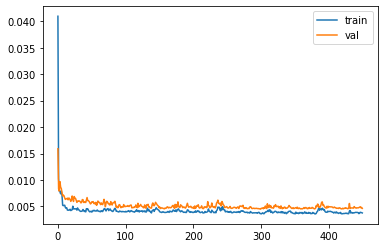

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
batch_normalization_input (Inpu [(None, 12)]         0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12)           48          batch_normalization_input[0][0]  
__________________________________________________________________________________________________
dense (Dense)                   (None, 35)           455         batch_normalization[0][0]        
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 35)           0           dense[0][0]                      
______________________________________________________________________________________________

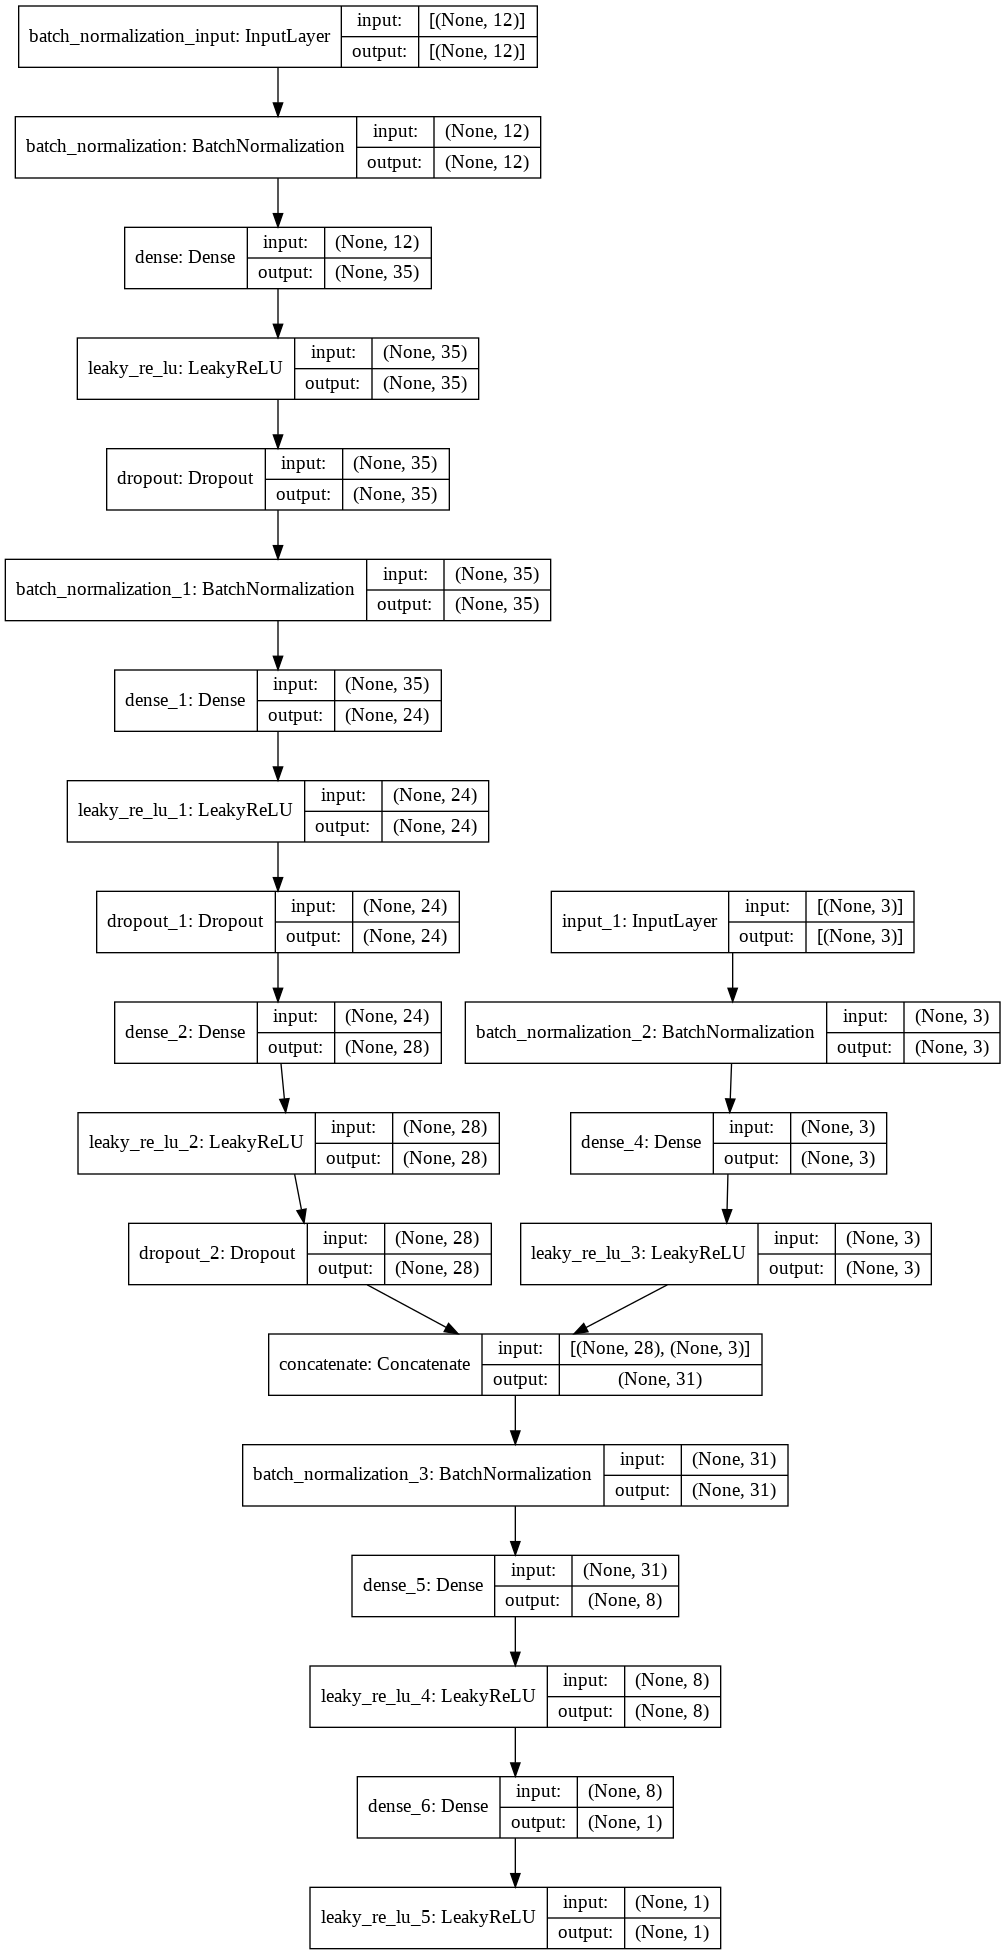

In [ ]:
model_fixed = load_model(precovid_model)
from keras.layers import Concatenate
from keras.layers.merge import concatenate
from keras.layers import Input, Dense, concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

for i in range(0,len(model_fixed.layers)):
  model_fixed.layers[i].trainable = False

l1 = Input(shape=(3,))
l1_2 = BatchNormalization()(l1)
l2 = Dense(best_params2['num_dense_nodes1'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l1_2 )
l2_2 = LeakyReLU(alpha=best_params2['alpha'])(l2)
if best_params2['two_layer'] ==1 :
      l2_3 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l2_2 )
      merged = concatenate([model_fixed.layers[best_params2[ 'layer_back']].output,l2_3])
else :
      merged = concatenate([model_fixed.layers[best_params2[ 'layer_back']].output,l2_2])
merged2 = BatchNormalization()(merged)

if best_params2['last_layer'] ==0:
    l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2)
    l5_3 = LeakyReLU(alpha=best_params2['alpha'])(l5_2)

if best_params2['last_layer'] ==1:
    l5 = Dense(best_params2['num_dense_nodes2'],kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(merged2) 
    l5_1 = LeakyReLU(alpha=best_params2['alpha'])(l5)
    l5_2 = Dense(1,kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros())(l5_1)
    l5_3 = LeakyReLU(alpha=best_params2['alpha'])(l5_2)          

model = Model(inputs=[model_fixed.input,l1], outputs=l5_3)

opt = keras.optimizers.Adam(learning_rate=best_params2['learning_rate'])
model.compile(loss='mse',optimizer=opt)
fn_f = "gdrive/My Drive/Colab Notebooks/Stations/Training_CO_aftercovid.ckpt" 
fnn_f = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer

callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn_f, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model.fit(x=[X_traine_a,X_traine_b], y= y_traine_a,
                  validation_data=([X_val_a,X_val_b], y_val_a),
                  batch_size=int(best_params2['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

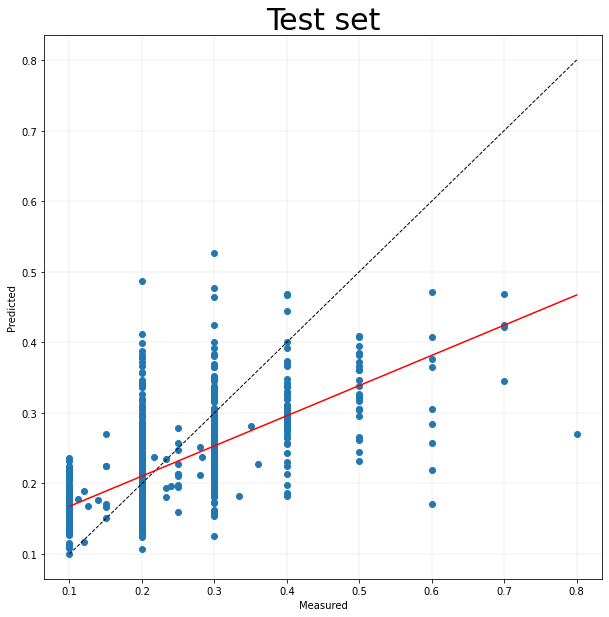

[0.42761824 0.12493499]
RMSE
[0.06297126]
R2
0.42194653306663965


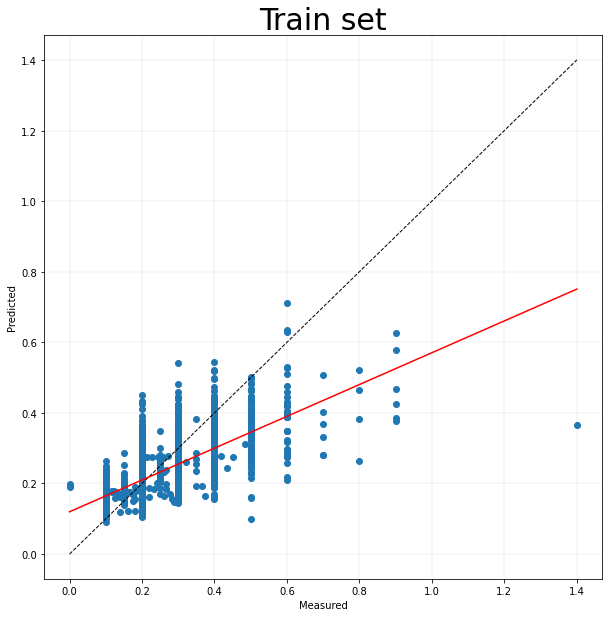

[0.45061179 0.11989867]
RMSE
[0.06110412]
R2
0.47311888956403503


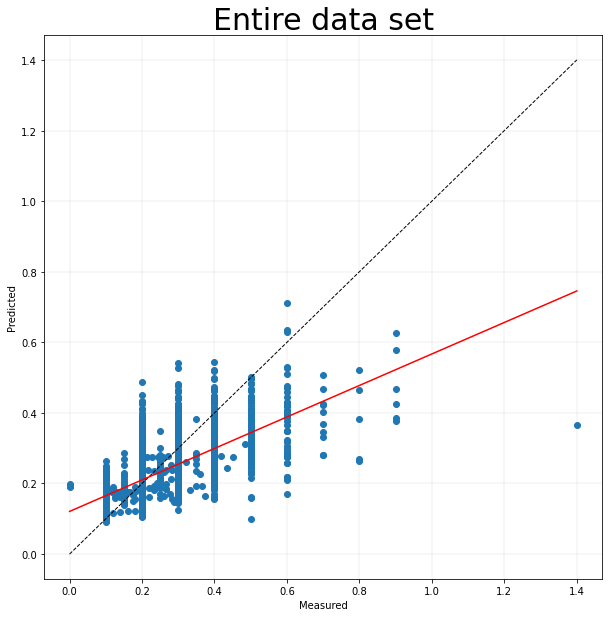

[0.4461315  0.12088052]
RMSE
[0.06148209]
R2
0.4631478722431982


In [ ]:
model.load_weights(fn_f )
model.save('gdrive/My Drive/Colab Notebooks/Model_Edmonton_east_after_Covid.h5')
preds = model.predict([X_test_a,X_test_b]) 
y_real = y_test_a.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

model.load_weights(fn_f)
preds = model.predict([X_train_a,X_train_b]) 
y_real_t = y_train_a.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
model.load_weights(fn_f)
preds = model.predict([X_a,X_b]) 
y_real_to = Y_a.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

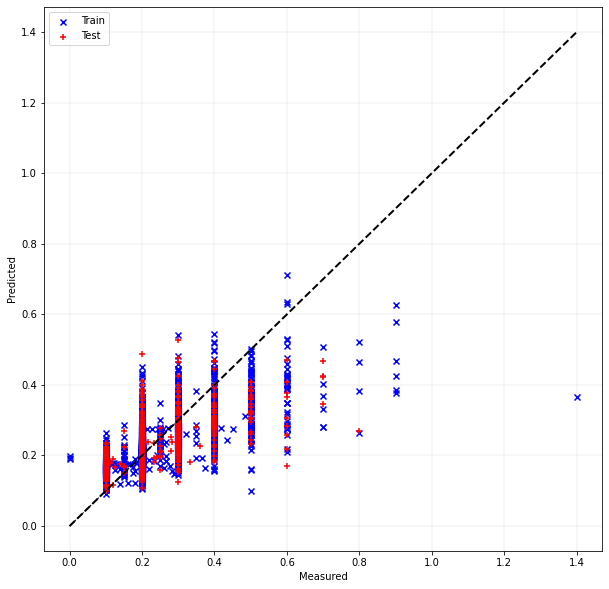

In [ ]:
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.3], [0,0.3], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()


In [ ]:
df2_w_c

CO(ppm)  T( C)  RH(%)  ...  driving  transit  walking
Date                                        ...                           
2020-01-13 00:00:00      0.1  -25.4   68.0  ...   1.0000   1.0000   1.0000
2020-01-13 01:00:00      0.1  -25.7   68.0  ...   1.0000   1.0000   1.0000
2020-01-13 02:00:00      0.1  -25.8   66.0  ...   1.0000   1.0000   1.0000
2020-01-13 03:00:00      0.1  -25.8   65.0  ...   1.0000   1.0000   1.0000
2020-01-13 04:00:00      0.1  -26.0   65.0  ...   1.0000   1.0000   1.0000
...                      ...    ...    ...  ...      ...      ...      ...
2021-01-31 19:00:00      0.4  -15.5   76.0  ...   0.7143   0.4266   0.8011
2021-01-31 20:00:00      0.4  -15.4   78.0  ...   0.7143   0.4266   0.8011
2021-01-31 21:00:00      0.2  -15.5   79.0  ...   0.7143   0.4266   0.8011
2021-01-31 22:00:00      0.2  -16.3   80.0  ...   0.7143   0.4266   0.8011
2021-01-31 23:00:00      0.2  -16.7   81.0  ...   0.7143   0.4266   0.8011

[9075 rows x 16 columns]

In [ ]:
# df3= df3.copy()
df4 = df2_w_c.copy()
df4['pred'] = model.predict([X_a,X_b])
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

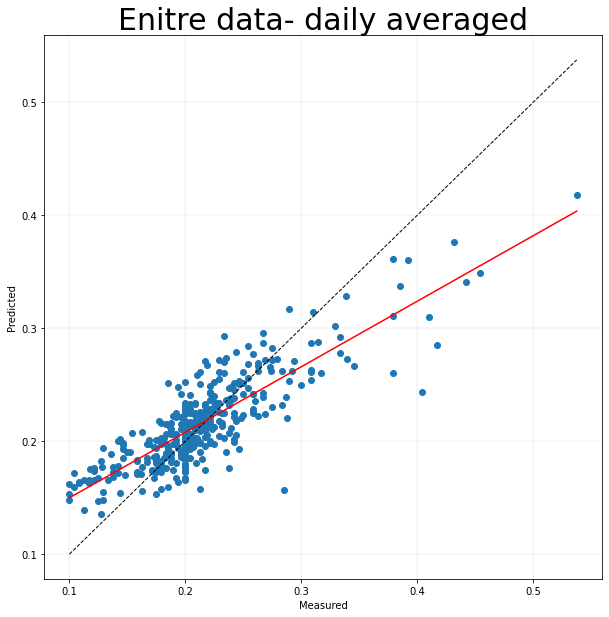

[0.57997188 0.09186987]
RMSE
[0.03240749]
R2
0.6798581783938966


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10['CO(ppm)']).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


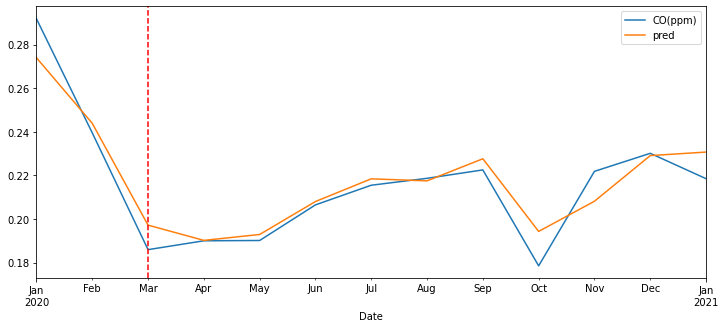

In [ ]:
df4['CO(ppm)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
df3_w_c = df2_w_c.copy()
df3_w_c['driving'] = 1.124019
df3_w_c['transit']  = 1.025378
df3_w_c['walking'] = 1.331329

In [ ]:
Y_a = df3_w_c['CO(ppm)']
Y_a = np.array(Y_a).reshape(-1,1)
X_a = np.array(df3_w_c[['T( C)', 'RH(%)', 'Wind Dir (STD)Unknown ',
       'Wind Dir (deg)', 'Wind speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',]])
X_b =  np.array(df3_w_c[ ['driving', 'transit', 'walking']])




X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, Y_a, test_size=0.2, random_state=42)
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_b, Y_a, test_size=0.2, random_state=42)

X_traine_a, X_val_a, y_traine_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.25, random_state = 42)
X_traine_b, X_val_b, y_traine_b, y_val_b = train_test_split(X_train_b, y_train_b, test_size=0.25, random_state = 42)

maximum_epochs = 450
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

In [ ]:
# df3= df3.copy()
df44 = df3_w_c.copy()
df44['No lockdown'] = model.predict([X_a,X_b])
df104 = df44.resample('D').mean()
df104.dropna(inplace= True)

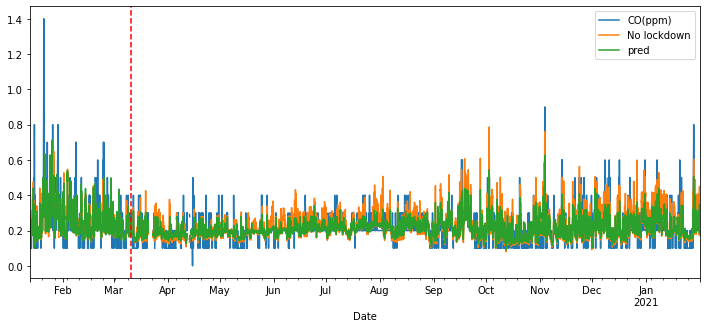

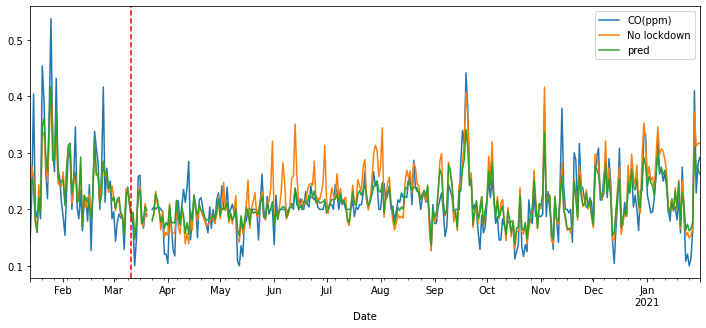

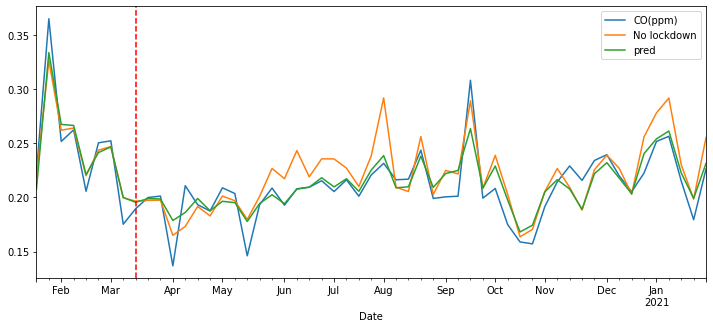

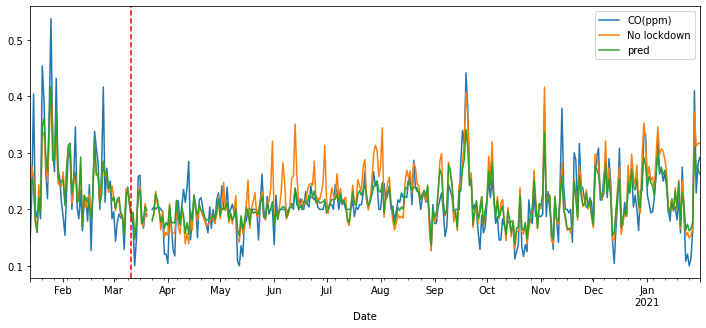

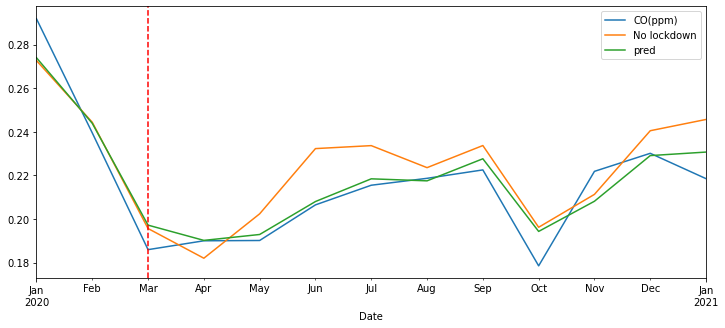

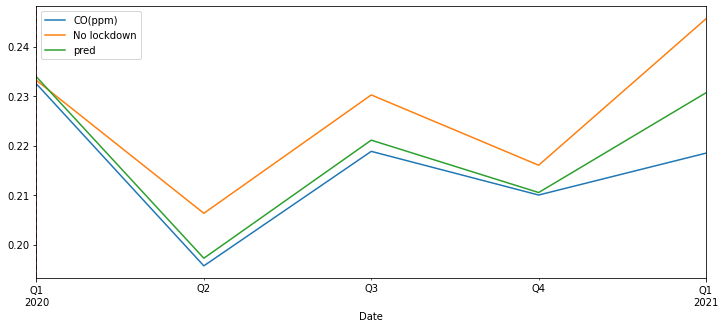

In [ ]:


df4['CO(ppm)'].resample('H').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('H').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('D').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('D').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('W').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('W').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()
df4['CO(ppm)'].resample('D').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('D').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('M').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('M').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['CO(ppm)'].resample('Q').mean().plot(figsize = (12,5), legend = True)
df44['No lockdown'].resample('Q').mean().plot(figsize = (12,5), legend = True)
df4['pred'].resample('Q').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4['No lockdown']=df44['No lockdown'].copy()
print('No lockdown:',df4['No lockdown'].mean())
print('pred:',df4['pred'].mean())
print('CO(ppm):',df4['CO(ppm)'].mean())

No lockdown: 0.22312191128730774
pred: 0.2163834571838379
CO(ppm): 0.21406886884590973


In [ ]:
df4.head()

CO(ppm)  T( C)  RH(%)  ...  walking      pred  No lockdown
Date                                        ...                                
2020-01-13 00:00:00      0.1  -25.4   68.0  ...      1.0  0.144256     0.140617
2020-01-13 01:00:00      0.1  -25.7   68.0  ...      1.0  0.154986     0.151347
2020-01-13 02:00:00      0.1  -25.8   66.0  ...      1.0  0.158600     0.154960
2020-01-13 03:00:00      0.1  -25.8   65.0  ...      1.0  0.166749     0.168830
2020-01-13 04:00:00      0.1  -26.0   65.0  ...      1.0  0.185634     0.212358

[5 rows x 18 columns]

In [ ]:
df4.to_csv('gdrive/My Drive/Colab Notebooks/Edmonton East/NOX_mobility_aftercov_Edmonton_east-COVID_hourly_pred.csv')

In [ ]:
df4

NOX(ppm)  T( C)  RH(%)  ...  walking      pred  No lockdown
Date                                         ...                                
2020-01-13 00:00:00    0.0084  -25.4   68.0  ...   1.0000  0.012064     0.011699
2020-01-13 01:00:00    0.0078  -25.7   68.0  ...   1.0000  0.015269     0.014904
2020-01-13 02:00:00    0.0053  -25.8   66.0  ...   1.0000  0.015456     0.015090
2020-01-13 03:00:00    0.0050  -25.8   65.0  ...   1.0000  0.018650     0.018285
2020-01-13 04:00:00    0.0069  -26.0   65.0  ...   1.0000  0.023630     0.023264
...                       ...    ...    ...  ...      ...       ...          ...
2021-01-31 19:00:00    0.1137  -15.5   76.0  ...   0.8011  0.037565     0.041811
2021-01-31 20:00:00    0.1007  -15.4   78.0  ...   0.8011  0.024746     0.028993
2021-01-31 21:00:00    0.0515  -15.5   79.0  ...   0.8011  0.019648     0.023895
2021-01-31 22:00:00    0.0502  -16.3   80.0  ...   0.8011  0.030382     0.034629
2021-01-31 23:00:00    0.0408  -16.7   81.0  ...   0.8011  0.025745     0.029992

[9075 rows x 18 columns]